In [1]:
import pandas as pd
import ps1
import requests
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os

from mgefit.find_galaxy import find_galaxy
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours

import jampy as jam

from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.coordinates import match_coordinates_sky

from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

from astroquery.mast import Catalogs

In [2]:
df_init = pd.read_csv('data/E-INSPIRE+DESI.csv')
df_init

TARGETID/OBJECID          RA        DEC SURVEY/GALAXY_ID         z  \
0        2842538385866755  154.980678   0.545429             main  0.095395   
1       39627799404745422  154.980678   0.545429             main  0.095340   
2        2842592249118720  125.282385   2.790324             main  0.087817   
3       39627853267993428  125.282385   2.790324             main  0.087814   
4       39627788415669218  219.963584   0.112548             main  0.132770   
...                   ...         ...        ...              ...       ...   
1041  1239999939308683264  150.486263  23.666846       J1001+2340  0.281205   
1042  1239999939308683264  123.968583   6.591744       J0815+0635  0.226798   
1043  1239999939308683264  147.690738  27.317412       J0950+2719  0.198904   
1044  1239999939308683264  225.616233  23.112215       J1502+2306  0.179275   
1045  1239999939308683264   15.854679  14.446294       J0103+1426  0.188857   

         z_err  sigma_star_ppxf        SNR     R_kpc  logMstar_CG     [M/H]  \
0     0.000009       170.203819  44.483378  2.858704    11.037738  0.232955   
1     0.000015       167.059578  25.431042  2.857244    10.989772  0.221067   
2     0.000009       293.274463  70.871579  3.321782    11.127935  0.097605   
3     0.000014       277.174350  35.694413  3.321690    11.149500  0.158185   
4     0.000022       210.484802  22.771146  1.976462    11.039669  0.303601   
...        ...              ...        ...       ...          ...       ...   
1041  0.000032       210.127320  18.691985  3.724436    11.373000 -0.047213   
1042  0.000039       341.387018  22.774130  3.675536    11.399000 -0.513152   
1043  0.000031       275.039176  19.989580  4.007681    11.434000  0.223974   
1044  0.000036       383.443739  21.962870  3.540446    11.458000 -0.203211   
1045  0.000062       488.833135  23.466670  3.864564    11.481000  0.053283   

      alphaFe  alpha_flag      t_uni  GroupID  GroupSize  
0         0.0          -1  12.499479      1.0        2.0  
1         0.2           0  12.500170      1.0        2.0  
2         0.4           0  12.595415      2.0        2.0  
3         0.2           0  12.595450      2.0        2.0  
4         0.2           0  12.041125      3.0        2.0  
...       ...         ...        ...      ...        ...  
1041      0.0          -1  10.449861      NaN        NaN  
1042      0.0          -1  10.989153      NaN        NaN  
1043      0.0          -1  11.281181      NaN        NaN  
1044      0.0          -1  11.493345      NaN        NaN  
1045      0.0          -1  11.389079      NaN        NaN  

[1046 rows x 16 columns]

In [3]:
df_init['dist'] = np.round(np.sqrt((df_init['RA'] - df_init['RA'].mean())**2 + (df_init['DEC'] - df_init['DEC'].mean())**2), 3)

In [4]:
max_distance = 2 * u.arcsec
coords = SkyCoord(ra=df_init['RA'], dec=df_init['DEC'], unit='deg', frame='icrs')
idx, d2d, d3d = match_coordinates_sky(coords, coords, nthneighbor=2)
mask = d2d > max_distance
df = df_init[mask]
df

TARGETID/OBJECID          RA        DEC SURVEY/GALAXY_ID         z  \
24       2842417304698883  134.650339  -4.602488             main  0.020090   
25       2842484900102147  206.999339  -1.800780             main  0.126141   
26       2842508174295043  154.216207  -0.796265             main  0.070927   
27       2842701061947396  151.622269   7.235106             main  0.121163   
28       2842716870279169   20.929319   8.024270             main  0.048054   
...                   ...         ...        ...              ...       ...   
1041  1239999939308683264  150.486263  23.666846       J1001+2340  0.281205   
1042  1239999939308683264  123.968583   6.591744       J0815+0635  0.226798   
1043  1239999939308683264  147.690738  27.317412       J0950+2719  0.198904   
1044  1239999939308683264  225.616233  23.112215       J1502+2306  0.179275   
1045  1239999939308683264   15.854679  14.446294       J0103+1426  0.188857   

         z_err  sigma_star_ppxf        SNR     R_kpc  logMstar_CG     [M/H]  \
24    0.000006       178.638682  61.723548  0.460497     9.974388 -0.115198   
25    0.000015       190.372478  30.837826  2.010297    10.757466  0.022276   
26    0.000012       303.894305  50.441946  3.554527    11.222319  0.172896   
27    0.000010       189.460148  43.946447  1.944288    10.823942  0.323368   
28    0.000010       321.260852  52.807433  2.475157    10.930000  0.099452   
...        ...              ...        ...       ...          ...       ...   
1041  0.000032       210.127320  18.691985  3.724436    11.373000 -0.047213   
1042  0.000039       341.387018  22.774130  3.675536    11.399000 -0.513152   
1043  0.000031       275.039176  19.989580  4.007681    11.434000  0.223974   
1044  0.000036       383.443739  21.962870  3.540446    11.458000 -0.203211   
1045  0.000062       488.833135  23.466670  3.864564    11.481000  0.053283   

      alphaFe  alpha_flag      t_uni  GroupID  GroupSize     dist  
24        0.4           1  13.500777      NaN        NaN   59.142  
25        0.3           0  12.120667      NaN        NaN   31.572  
26        0.4           0  12.813015      NaN        NaN   40.428  
27        0.1           0  12.180881      NaN        NaN   38.712  
28        0.2           0  13.116210      NaN        NaN  166.824  
...       ...         ...        ...      ...        ...      ...  
1041      0.0          -1  10.449861      NaN        NaN   36.631  
1042      0.0          -1  10.989153      NaN        NaN   65.163  
1043      0.0          -1  11.281181      NaN        NaN   39.682  
1044      0.0          -1  11.493345      NaN        NaN   38.513  
1045      0.0          -1  11.389079      NaN        NaN  171.450  

[1022 rows x 17 columns]

In [5]:
df = pd.concat([df, df_init[~mask].groupby("dist").first().reset_index(drop=True)], ignore_index=True)
df_init = df.copy()
df_init

TARGETID/OBJECID          RA        DEC SURVEY/GALAXY_ID         z  \
0      2842417304698883  134.650339  -4.602488             main  0.020090   
1      2842484900102147  206.999339  -1.800780             main  0.126141   
2      2842508174295043  154.216207  -0.796265             main  0.070927   
3      2842701061947396  151.622269   7.235106             main  0.121163   
4      2842716870279169   20.929319   8.024270             main  0.048054   
...                 ...         ...        ...              ...       ...   
1029  39633153941310268  236.337511  44.360624              sv3  0.129454   
1030  39627819067637938  246.754521   1.223455             main  0.162922   
1031   2842592249118720  125.282385   2.790324             main  0.087817   
1032  39628149075479853  349.568591  15.124893             main  0.170340   
1033  39627923711329320   12.093095   5.781772             main  0.120614   

         z_err  sigma_star_ppxf        SNR     R_kpc  logMstar_CG     [M/H]  \
0     0.000006       178.638682  61.723548  0.460497     9.974388 -0.115198   
1     0.000015       190.372478  30.837826  2.010297    10.757466  0.022276   
2     0.000012       303.894305  50.441946  3.554527    11.222319  0.172896   
3     0.000010       189.460148  43.946447  1.944288    10.823942  0.323368   
4     0.000010       321.260852  52.807433  2.475157    10.930000  0.099452   
...        ...              ...        ...       ...          ...       ...   
1029  0.000023       211.839189  18.568846  1.446545    10.815265  0.163872   
1030  0.000030       213.159834  18.355419  1.570440    10.921475  0.348071   
1031  0.000009       293.274463  70.871579  3.321782    11.127935  0.097605   
1032  0.000012       206.210348  38.470528  3.097403    11.228371  0.420216   
1033  0.000021       250.068929  22.275367  2.866395    11.218470  0.139595   

      alphaFe  alpha_flag      t_uni  GroupID  GroupSize     dist  
0         0.4           1  13.500777      NaN        NaN   59.142  
1         0.3           0  12.120667      NaN        NaN   31.572  
2         0.4           0  12.813015      NaN        NaN   40.428  
3         0.1           0  12.180881      NaN        NaN   38.712  
4         0.2           0  13.116210      NaN        NaN  166.824  
...       ...         ...        ...      ...        ...      ...  
1029      0.0           0  12.080821     11.0        2.0      NaN  
1030      0.2           0  11.688546      5.0        2.0      NaN  
1031      0.4           0  12.595415      2.0        2.0      NaN  
1032      0.3           0  11.604057      9.0        2.0      NaN  
1033      0.4           1  12.187549      7.0        2.0      NaN  

[1034 rows x 17 columns]

In [6]:
target1 = df_init['TARGETID/OBJECID'].values
target2 = df_init['SURVEY/GALAXY_ID'].values
targetid = [str(t1) if str(t1) != '1239999939308683264' else str(t2) for t1, t2 in zip(target1, target2)]
df_init['targetid'] = targetid
df_init

TARGETID/OBJECID          RA        DEC SURVEY/GALAXY_ID         z  \
0      2842417304698883  134.650339  -4.602488             main  0.020090   
1      2842484900102147  206.999339  -1.800780             main  0.126141   
2      2842508174295043  154.216207  -0.796265             main  0.070927   
3      2842701061947396  151.622269   7.235106             main  0.121163   
4      2842716870279169   20.929319   8.024270             main  0.048054   
...                 ...         ...        ...              ...       ...   
1029  39633153941310268  236.337511  44.360624              sv3  0.129454   
1030  39627819067637938  246.754521   1.223455             main  0.162922   
1031   2842592249118720  125.282385   2.790324             main  0.087817   
1032  39628149075479853  349.568591  15.124893             main  0.170340   
1033  39627923711329320   12.093095   5.781772             main  0.120614   

         z_err  sigma_star_ppxf        SNR     R_kpc  logMstar_CG     [M/H]  \
0     0.000006       178.638682  61.723548  0.460497     9.974388 -0.115198   
1     0.000015       190.372478  30.837826  2.010297    10.757466  0.022276   
2     0.000012       303.894305  50.441946  3.554527    11.222319  0.172896   
3     0.000010       189.460148  43.946447  1.944288    10.823942  0.323368   
4     0.000010       321.260852  52.807433  2.475157    10.930000  0.099452   
...        ...              ...        ...       ...          ...       ...   
1029  0.000023       211.839189  18.568846  1.446545    10.815265  0.163872   
1030  0.000030       213.159834  18.355419  1.570440    10.921475  0.348071   
1031  0.000009       293.274463  70.871579  3.321782    11.127935  0.097605   
1032  0.000012       206.210348  38.470528  3.097403    11.228371  0.420216   
1033  0.000021       250.068929  22.275367  2.866395    11.218470  0.139595   

      alphaFe  alpha_flag      t_uni  GroupID  GroupSize     dist  \
0         0.4           1  13.500777      NaN        NaN   59.142   
1         0.3           0  12.120667      NaN        NaN   31.572   
2         0.4           0  12.813015      NaN        NaN   40.428   
3         0.1           0  12.180881      NaN        NaN   38.712   
4         0.2           0  13.116210      NaN        NaN  166.824   
...       ...         ...        ...      ...        ...      ...   
1029      0.0           0  12.080821     11.0        2.0      NaN   
1030      0.2           0  11.688546      5.0        2.0      NaN   
1031      0.4           0  12.595415      2.0        2.0      NaN   
1032      0.3           0  11.604057      9.0        2.0      NaN   
1033      0.4           1  12.187549      7.0        2.0      NaN   

               targetid  
0      2842417304698883  
1      2842484900102147  
2      2842508174295043  
3      2842701061947396  
4      2842716870279169  
...                 ...  
1029  39633153941310268  
1030  39627819067637938  
1031   2842592249118720  
1032  39628149075479853  
1033  39627923711329320  

[1034 rows x 18 columns]

In [ ]:
# Create directories for saving figures
os.makedirs('./figs/e-inspire/griz_galaxy', exist_ok=True)
os.makedirs('./figs/e-inspire/background', exist_ok=True)
os.makedirs('./figs/e-inspire/find_galaxy', exist_ok=True)
os.makedirs('./figs/e-inspire/sector_photometry', exist_ok=True)
os.makedirs('./figs/e-inspire/mge_fit', exist_ok=True)
os.makedirs('./figs/e-inspire/mge_contours', exist_ok=True)
print("Created directories for saving figures")

In [21]:
def plot_image(im, row):
    plt.figure(figsize=(4, 4))
    plt.imshow(im, origin='lower')
    idx = row['targetid']
    plt.title(f"Target: {idx}")
    # at RA: {row['TARGET_RA']:.6f}, Dec: {row['TARGET_DEC']:6f}")

    # Add scale bar annotation with text and line
    plt.annotate(
        f'3"',
        xy=(12, 6),
        fontsize=12,
        color='white',
        # bbox=dict(facecolor='black', alpha=0.5),
        ha='center'
    )
    plt.plot([5, 17], [5, 5], color='white', lw=2)  # Example scale bar line


    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"./figs/e-inspire/griz_galaxy/ps1_{idx}.png", bbox_inches='tight')
    plt.close()
    # plt.show()


In [26]:
def get_background(data, row, isshow=False):
    """
    Get the background of the image using sigma clipping.
    """
    
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    threshold = detect_threshold(data, nsigma=2.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(data, threshold, npixels=12)
    footprint = circular_footprint(radius=12)

    mask = segment_img.make_source_mask(footprint=footprint)
    
    mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
    print(np.array((mean, median, std)))


    if isshow:
        arr = np.ma.masked_array(data, mask=mask)
        plt.figure(figsize=(5, 4))
        plt.imshow(arr, origin='lower', vmin=mean - 3 * std, vmax=mean + 3 * std)
        plt.colorbar()
        plt.title("Background")
        plt.tight_layout()
        plt.savefig(f"./figs/e-inspire/background/{row['targetid']}_background.png", bbox_inches='tight')
        plt.close()
        # plt.show()
    
    return mean, median, std

def get_galaxy_size(filename, row):
    """
    Get the galaxy size from the row data.
    """
    hdul = fits.open(filename)
    # psf_fwhm = row["psf_fwhm"]
    img = hdul[0].data # * 1e10 # type: ignore # Convert to Jy/arcsec^2
    header = hdul[0].header # type: ignore
    scale = abs(header['CDELT2']) * 3600.0  # arcsec/pixel

    # get background
    mean, median, skysigma = get_background(img, row, isshow=True)
    img -= median  # type: ignore
    if np.isnan(img).any():
        print(f"Image {filename} contains NaN values after background subtraction.")
        img = np.nan_to_num(img, nan=0.0)  # Replace NaNs with 0

    size = 30.0 / scale # 10 arcsec in pixels
    img = Cutout2D(img,
        position=(img.shape[1] // 2, img.shape[0] // 2),
        size=(size, size),
        mode='partial').data  # type: ignore

    found = False
    count = 0
    while not found and count < 5:
        f = find_galaxy(img, fraction=0.1, plot=True)
        dist = np.sqrt((f.xpeak - img.shape[1] // 2)**2 + (f.ypeak - img.shape[0] // 2)**2)
        if dist < 0.2 * img.shape[0]:  # 10%
            found = True
        else:
            print(f"Galaxy not found, trying again. Distance: {dist:.2f} pixels")
            size *= 0.8
            plt.close()
            img = Cutout2D(img,
            position=(img.shape[1] // 2, img.shape[0] // 2),
            size=(size, size),
            mode='partial').data # type: ignore
            print(f"Trying again with size {size:.2f} pixels {idx}")
        count += 1
    if not found:
        print(f"Galaxy not found after {count} attempts, using last found position.")
        return None

    print(f"Galaxy found at ({f.xpeak:.2f}, {f.ypeak:.2f}) in image of size {img.shape[0]}x{img.shape[1]} pixels")
    
    minlevel = max(skysigma, 0.01)  # Ensure minimum level is positive
    plt.savefig(f"./figs/e-inspire/find_galaxy/ps1_{row['targetid']}_find_galaxy.png", bbox_inches='tight')
    plt.close()

    print(f" Galaxy: {filename} | Sky Level: {median:.3f}, Sigma: {skysigma:.3f}")

    # get FWHM
    galaxy_name = row['targetid']
    skyCellID = header['STK_ID']
    print(f"Sky Cell ID: {skyCellID}")
    coord = SkyCoord(f"{row['RA']:.6f} {row['DEC']:.6f}", unit='deg', frame='icrs')

    try:
        catalog_data = Catalogs.query_region( # type: ignore
            coord,
            radius=1/60.0,
            catalog="Panstarrs",
            data_release="dr2",
            # skyCellID=int(skyCellID),
            table="stack").to_pandas()
    except Exception as e:
        print(f"Error querying catalog: {e}")
        
    if not catalog_data.empty:
        temp = catalog_data['rpsfMinorFWHM'].values
        # print(catalog_data)
        FWHM = np.nanmedian(temp)
        print(f"FWHM from catalog: {FWHM:.3f} arcsec")
    else:
        print("No catalog data found, using default FWHM.")
        FWHM = 1.2  # Default FWHM if no data available
        print(f"Using default FWHM: {FWHM:.3f} arcsec")
        
    # Convert FWHM to sigma and normalization
    sigma_psf = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma
    norm_psf = 1
    
    # Sector photometry with more robust parameters
    try:
        s = sectors_photometry(img, f.eps, f.theta, 
                               f.xpeak, f.ypeak, 
                               minlevel=minlevel, 
                               plot=True,
                               )
    except Exception as e:
        print(f"Error in sectors_photometry: {e}")
        # Try with different parameters
        s = sectors_photometry(img, f.eps, f.theta, 
                               f.xpeak, f.ypeak, 
                               minlevel=minlevel*2, 
                               plot=True,
                               )
    plt.savefig(f"./figs/e-inspire/sector_photometry/ps1_{row['targetid']}_sectors_photometry.png", bbox_inches='tight')
    plt.close()


    ngauss = 3  # Number of Gaussian components for MGE fit
    # MGE fit

    print(f"Performing MGE fit for {filename} with ngauss={ngauss}, scale={scale}, sigmapsf={sigma_psf}, normpsf={norm_psf}")
    print(f"Galaxy: {filename} | Sigma PSF: {sigma_psf:.3f}, Normalization PSF: {norm_psf:.3f}")

    m = mge_fit_sectors(s.radius, s.angle, s.counts, f.eps,
                        ngauss=ngauss, scale=scale, plot=True,
                        sigmapsf=sigma_psf, normpsf=norm_psf)
    plt.savefig(f"./figs/e-inspire/mge_fit/ps1_{row['targetid']}_mge_fit.png", bbox_inches='tight')
    plt.close()
    
    total_counts, sigma, q_obs = m.sol
    surf = total_counts / (2 * np.pi * q_obs * sigma**2)
    reff, reff_maj, eps_e, lum_tot = jam.mge.half_light_isophote(surf, sigma * scale, q_obs)

    # plt.figure()
    mge_print_contours(img, f.theta, f.xpeak, f.ypeak, m.sol, scale=scale,
                       sigmapsf=sigma_psf, normpsf=norm_psf, binning=1, minlevel=minlevel)
    plt.title(f"Contours of {galaxy_name}")
    plt.savefig(f"./figs/e-inspire/mge_contours/ps1_{row['targetid']}_mge_contours.png", bbox_inches='tight')
    plt.close()

    return {
        "RA": row['RA'],
        "DEC": row['DEC'],
        "Target ID": row['targetid'],
        "Sky Cell ID": skyCellID,
        "FWHM (arcsec)": FWHM,
        "Sigma PSF": sigma_psf,
        "minlevel": minlevel,
        "Reff (arcsec)": reff,
        "Reff_maj (arcsec)": reff_maj,
        "Eccentricity": eps_e,
        "Luminosity": lum_tot
    }

In [ ]:
df_results = None
for i, row in df_init.iterrows():
    ra = row['RA']
    dec = row['DEC']
    idx = row['targetid']
    # if i < 444:
    #     continue

    filename = f"./data/e-inspire/{idx}_r.fits"
    if os.path.exists(filename):
        print(f"File {filename} already exists, skipping download.")
    else:
    
        url = ps1.geturl(ra, dec, size=240, filters='r', format="fits")

        if not url:
            print(f"No valid image URL found for RA: {ra}, DEC: {dec}")
            continue
        
        response = requests.get(url[0])

        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded image for RA: {ra}, DEC: {dec} to {filename}")
        
    im = ps1.getcolorim(
        ra=row['RA'],
        dec=row['DEC'],
        size=60,
        filters="grizy",  # Use all available filters
    )
    if im is None:
        print(f"No image data found for RA: {ra}, DEC: {dec}")
        continue

    plot_image(im, row)

    res = get_galaxy_size(filename, row)
    if res is None:
        print(f"Failed to get galaxy size for RA: {ra}, DEC: {dec}")
        continue

    if df_results is None:
        df_results = pd.DataFrame(res, index=[i])
    else:
        df_results = pd.concat([df_results, pd.DataFrame(res, index=[i])])

    # print(f"Downloaded image for RA: {ra}, DEC: {dec}")
    if i > 0 and i % 20 == 0:
        print(f"Processed {i+1} rows, breaking the loop for testing.")
        df_results.to_csv('results.csv', index_label='Index')
        # break
df_results

File ./data/e-inspire/2842417304698883_r.fits already exists, skipping download.
[ 13.435364  12.87404  106.200584]
 Pixels used: 1414
 Peak img[j, k]: 61 61
 Mean (j, k): 61.03 60.65
 Theta (deg): 146.7
 Astro PA (deg): 123.3
 Eps: 0.142
 Major axis (pix): 22.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2842417304698883_r.fits | Sky Level: 12.874, Sigma: 106.201
Sky Cell ID: 4500357
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/2842417304698883_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.534609828626229, normpsf=1
Galaxy: ./data/e-inspire/2842417304698883_r.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 44.42  Nonzero: 2/3
Iteration: 9  chi2: 3.296  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  To

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/2842484900102147_r.fits already exists, skipping download.
[-6.1443224 -6.277052  91.75756  ]
 Pixels used: 1083
 Peak img[j, k]: 61 61
 Mean (j, k): 59.89 60.14
 Theta (deg): 102.9
 Astro PA (deg): 167.1
 Eps: 0.466
 Major axis (pix): 36.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2842484900102147_r.fits | Sky Level: -6.277, Sigma: 91.758
Sky Cell ID: 3894861
FWHM from catalog: 1.022 arcsec
Performing MGE fit for ./data/e-inspire/2842484900102147_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43411598231880505, normpsf=1
Galaxy: ./data/e-inspire/2842484900102147_r.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 58.68  Nonzero: 3/3
Iteration: 9  chi2: 8.895  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/2842508174295043_r.fits already exists, skipping download.


[42.59827  40.711376 92.558044]
Image ./data/e-inspire/2842508174295043_r.fits contains NaN values after background subtraction.
 Pixels used: 943
 Peak img[j, k]: 114 98
 Mean (j, k): 111.34 97.30
 Theta (deg): 179.4
 Astro PA (deg): 90.6
 Eps: 0.475
 Major axis (pix): 24.5
Galaxy not found, trying again. Distance: 66.03 pixels
Trying again with size 96.00 pixels 2842508174295043
 Pixels used: 518
 Peak img[j, k]: 48 48
 Mean (j, k): 48.18 48.43
 Theta (deg): 81.7
 Astro PA (deg): 8.3
 Eps: 0.073
 Major axis (pix): 13.4
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/2842508174295043_r.fits | Sky Level: 40.711, Sigma: 92.558
Sky Cell ID: 4549942
FWHM from catalog: 1.264 arcsec
Performing MGE fit for ./data/e-inspire/2842508174295043_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5365738948066175, normpsf=1
Galaxy: ./data/e-inspire/2842508174295043_r.fits | Sigma PSF: 0.537, Normalization PSF: 1.000
Iteration: 0  chi2: 76.82  Nonzero: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/2842701061947396_r.fits already exists, skipping download.
[ -0.85398614  -1.1441818  110.34451   ]
 Pixels used: 1414
 Peak img[j, k]: 60 61
 Mean (j, k): 59.86 61.15
 Theta (deg): 113.7
 Astro PA (deg): 156.3
 Eps: 0.223
 Major axis (pix): 28.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2842701061947396_r.fits | Sky Level: -1.144, Sigma: 110.345
Sky Cell ID: 4557472
FWHM from catalog: 1.194 arcsec
Performing MGE fit for ./data/e-inspire/2842701061947396_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5069262025435163, normpsf=1
Galaxy: ./data/e-inspire/2842701061947396_r.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 43.25  Nonzero: 2/3
Iteration: 7  chi2: 3.163  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/2842716870279169_r.fits already exists, skipping download.
[ 19.327927  18.571905 132.25449 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.62 60.25
 Theta (deg): 34.6
 Astro PA (deg): 55.4
 Eps: 0.578
 Major axis (pix): 36.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2842716870279169_r.fits | Sky Level: 18.572, Sigma: 132.254
Sky Cell ID: 4091925
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/2842716870279169_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4740680929340707, normpsf=1
Galaxy: ./data/e-inspire/2842716870279169_r.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 52.40  Nonzero: 2/3
Iteration: 9  chi2: 8.001  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/2842925104889859_r.fits already exists, skipping download.
[-21.646399 -23.532042 121.15781 ]
 Pixels used: 624
 Peak img[j, k]: 61 60
 Mean (j, k): 61.15 60.54
 Theta (deg): 35.1
 Astro PA (deg): 54.9
 Eps: 0.164
 Major axis (pix): 18.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2842925104889859_r.fits | Sky Level: -23.532, Sigma: 121.158
Sky Cell ID: 4483305
FWHM from catalog: 1.030 arcsec
Performing MGE fit for ./data/e-inspire/2842925104889859_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.437400714998684, normpsf=1
Galaxy: ./data/e-inspire/2842925104889859_r.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 17.05  Nonzero: 2/3
Iteration: 8  chi2: 2.998  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627217155660583_r.fits already exists, skipping download.
[ 10.354095  10.10251  289.40848 ]
 Pixels used: 246
 Peak img[j, k]: 112 39
 Mean (j, k): 112.72 39.22
 Theta (deg): 24.2
 Astro PA (deg): 65.8
 Eps: 0.250
 Major axis (pix): 16.2
Galaxy not found, trying again. Distance: 56.08 pixels
Trying again with size 96.00 pixels 39627217155660583
 Pixels used: 188
 Peak img[j, k]: 41 40
 Mean (j, k): 48.64 47.95
 Theta (deg): 167.1
 Astro PA (deg): 102.9
 Eps: 0.388
 Major axis (pix): 11.0
Galaxy found at (41.00, 40.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627217155660583_r.fits | Sky Level: 10.103, Sigma: 289.408
Sky Cell ID: 4212866
FWHM from catalog: 1.134 arcsec
Performing MGE fit for ./data/e-inspire/39627217155660583_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4815612351164943, normpsf=1
Galaxy: ./data/e-inspire/39627217155660583_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 0.8603  Nonzero: 1/3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:799: RuntimeWarning: invalid value encountered in scalar divide
  ratio = actred/prered
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/p

File ./data/e-inspire/39627295337487452_r.fits already exists, skipping download.
[  5.1563      3.9240313 147.59816  ]
 Pixels used: 823
 Peak img[j, k]: 61 60
 Mean (j, k): 60.71 57.50
 Theta (deg): 172.3
 Astro PA (deg): 97.7
 Eps: 0.458
 Major axis (pix): 21.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627295337487452_r.fits | Sky Level: 3.924, Sigma: 147.598
Sky Cell ID: 4213197
FWHM from catalog: 0.934 arcsec
Performing MGE fit for ./data/e-inspire/39627295337487452_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3966356158964295, normpsf=1
Galaxy: ./data/e-inspire/39627295337487452_r.fits | Sigma PSF: 0.397, Normalization PSF: 1.000
Iteration: 0  chi2: 47.42  Nonzero: 2/3
Iteration: 5  chi2: 13.84  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627386567789773_r.fits already exists, skipping download.
[20.12716  19.677788 96.88402 ]
 Pixels used: 1188
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 61.24
 Theta (deg): 90.5
 Astro PA (deg): 179.5
 Eps: 0.255
 Major axis (pix): 24.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627386567789773_r.fits | Sky Level: 19.678, Sigma: 96.884
Sky Cell ID: 4282590
FWHM from catalog: 1.114 arcsec
Performing MGE fit for ./data/e-inspire/39627386567789773_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4732442203893775, normpsf=1
Galaxy: ./data/e-inspire/39627386567789773_r.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 32.61  Nonzero: 2/3
Iteration: 8  chi2: 3.651  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  To

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627438686213304_r.fits already exists, skipping download.
[130.42023 128.57166 140.09889]
 Pixels used: 1088
 Peak img[j, k]: 61 62
 Mean (j, k): 61.21 61.26
 Theta (deg): 84.6
 Astro PA (deg): 5.4
 Eps: 0.142
 Major axis (pix): 24.0
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627438686213304_r.fits | Sky Level: 128.572, Sigma: 140.099
Sky Cell ID: 4040026
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/39627438686213304_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4844403974321956, normpsf=1
Galaxy: ./data/e-inspire/39627438686213304_r.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 100.8  Nonzero: 3/3
Iteration: 10  chi2: 9.255  Nonzero: 3/3
Iteration: 13  chi2: 9.253  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627461767463365_r.fits already exists, skipping download.
[ 1.974939   1.5479949 85.70444  ]
 Pixels used: 1191
 Peak img[j, k]: 61 62
 Mean (j, k): 60.73 61.88
 Theta (deg): 22.8
 Astro PA (deg): 67.2
 Eps: 0.363
 Major axis (pix): 26.2
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627461767463365_r.fits | Sky Level: 1.548, Sigma: 85.704
Sky Cell ID: 4023839
FWHM from catalog: 1.219 arcsec
Performing MGE fit for ./data/e-inspire/39627461767463365_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5177168598456808, normpsf=1
Galaxy: ./data/e-inspire/39627461767463365_r.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 49.20  Nonzero: 2/3
Iteration: 7  chi2: 6.040  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627480033656882_r.fits already exists, skipping download.
[  8.658827   8.449566 148.19437 ]
 Pixels used: 1088
 Peak img[j, k]: 62 61
 Mean (j, k): 61.75 60.92
 Theta (deg): 18.0
 Astro PA (deg): 72.0
 Eps: 0.317
 Major axis (pix): 23.1
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627480033656882_r.fits | Sky Level: 8.450, Sigma: 148.194
Sky Cell ID: 4283016
FWHM from catalog: 1.408 arcsec
Performing MGE fit for ./data/e-inspire/39627480033656882_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5978673645214752, normpsf=1
Galaxy: ./data/e-inspire/39627480033656882_r.fits | Sigma PSF: 0.598, Normalization PSF: 1.000
Iteration: 0  chi2: 33.90  Nonzero: 2/3
Iteration: 9  chi2: 5.566  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627532055613156_r.fits already exists, skipping download.
[  4.4544516   4.231852  123.89284  ]
 Pixels used: 1437
 Peak img[j, k]: 61 61
 Mean (j, k): 60.97 60.96
 Theta (deg): 92.3
 Astro PA (deg): 177.7
 Eps: 0.071
 Major axis (pix): 24.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627532055613156_r.fits | Sky Level: 4.232, Sigma: 123.893
Sky Cell ID: 3837739
FWHM from catalog: 1.204 arcsec
Performing MGE fit for ./data/e-inspire/39627532055613156_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5111260819822321, normpsf=1
Galaxy: ./data/e-inspire/39627532055613156_r.fits | Sigma PSF: 0.511, Normalization PSF: 1.000
Iteration: 0  chi2: 47.54  Nonzero: 2/3
Iteration: 10  chi2: 3.233  Nonzero: 3/3
Iteration: 12  chi2: 3.233  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627538590339572_r.fits already exists, skipping download.
[ 3.1574578  3.2531786 96.63135  ]
 Pixels used: 714
 Peak img[j, k]: 104 104
 Mean (j, k): 104.02 103.73
 Theta (deg): 60.9
 Astro PA (deg): 29.1
 Eps: 0.024
 Major axis (pix): 18.9
Galaxy not found, trying again. Distance: 62.23 pixels
Trying again with size 96.00 pixels 39627538590339572
 Pixels used: 513
 Peak img[j, k]: 49 50
 Mean (j, k): 48.65 49.45
 Theta (deg): 134.8
 Astro PA (deg): 135.2
 Eps: 0.105
 Major axis (pix): 15.0
Galaxy found at (49.00, 50.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627538590339572_r.fits | Sky Level: 3.253, Sigma: 96.631
Sky Cell ID: 4024032
FWHM from catalog: 1.245 arcsec
Performing MGE fit for ./data/e-inspire/39627538590339572_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5288429486192355, normpsf=1
Galaxy: ./data/e-inspire/39627538590339572_r.fits | Sigma PSF: 0.529, Normalization PSF: 1.000
Iteration: 0  chi2: 13.40  Nonzero: 2/3
I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627544558829655_r.fits already exists, skipping download.
[ 30.146662  28.417572 123.13774 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 60.31
 Theta (deg): 166.6
 Astro PA (deg): 103.4
 Eps: 0.021
 Major axis (pix): 23.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627544558829655_r.fits | Sky Level: 28.418, Sigma: 123.138
Sky Cell ID: 4024020
FWHM from catalog: 1.166 arcsec
Performing MGE fit for ./data/e-inspire/39627544558829655_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4950229414263486, normpsf=1
Galaxy: ./data/e-inspire/39627544558829655_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 86.97  Nonzero: 3/3
Iteration: 10  chi2: 5.038  Nonzero: 3/3
Iteration: 13  chi2: 5.035  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627544995045039_r.fits already exists, skipping download.
[-1.1194025 -1.0473286 88.85543  ]
 Pixels used: 1042
 Peak img[j, k]: 62 61
 Mean (j, k): 59.11 58.91
 Theta (deg): 125.7
 Astro PA (deg): 144.3
 Eps: 0.265
 Major axis (pix): 29.2
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627544995045039_r.fits | Sky Level: -1.047, Sigma: 88.855
Sky Cell ID: 4163317
FWHM from catalog: 1.288 arcsec
Performing MGE fit for ./data/e-inspire/39627544995045039_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.547167095052616, normpsf=1
Galaxy: ./data/e-inspire/39627544995045039_r.fits | Sigma PSF: 0.547, Normalization PSF: 1.000
Iteration: 0  chi2: 35.94  Nonzero: 2/3
Iteration: 7  chi2: 6.876  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.876  Nonzero: 2/2
Iteration: 1  chi2: 6.875  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627561638037573_r.fits already exists, skipping download.
[  5.7102966   6.1560063 101.98082  ]
 Pixels used: 1361
 Peak img[j, k]: 69 49
 Mean (j, k): 64.87 54.75
 Theta (deg): 36.5
 Astro PA (deg): 53.5
 Eps: 0.526
 Major axis (pix): 27.8
Galaxy found at (69.00, 49.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627561638037573_r.fits | Sky Level: 6.156, Sigma: 101.981
Sky Cell ID: 3817492
FWHM from catalog: 0.958 arcsec
Performing MGE fit for ./data/e-inspire/39627561638037573_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40700136464816966, normpsf=1
Galaxy: ./data/e-inspire/39627561638037573_r.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 118.7  Nonzero: 3/3
Iteration: 6  chi2: 35.64  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627570915837647_r.fits already exists, skipping download.
[ 3.0423677  2.5541363 58.61829  ]
 Pixels used: 908
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 60.32
 Theta (deg): 68.4
 Astro PA (deg): 21.6
 Eps: 0.158
 Major axis (pix): 22.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627570915837647_r.fits | Sky Level: 2.554, Sigma: 58.618
Sky Cell ID: 4409599
FWHM from catalog: 1.199 arcsec
Performing MGE fit for ./data/e-inspire/39627570915837647_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5089815682498107, normpsf=1
Galaxy: ./data/e-inspire/39627570915837647_r.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 29.97  Nonzero: 2/3
Iteration: 10  chi2: 4.925  Nonzero: 3/3
Iteration: 13  chi2: 4.920  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627581011531436_r.fits already exists, skipping download.
[  3.5907013   3.4169083 111.09016  ]
 Pixels used: 1332
 Peak img[j, k]: 61 61
 Mean (j, k): 60.69 61.36
 Theta (deg): 113.2
 Astro PA (deg): 156.8
 Eps: 0.120
 Major axis (pix): 22.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627581011531436_r.fits | Sky Level: 3.417, Sigma: 111.090
Sky Cell ID: 4163678
FWHM from catalog: 1.314 arcsec
Performing MGE fit for ./data/e-inspire/39627581011531436_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5578557965770293, normpsf=1
Galaxy: ./data/e-inspire/39627581011531436_r.fits | Sigma PSF: 0.558, Normalization PSF: 1.000
Iteration: 0  chi2: 59.66  Nonzero: 2/3
Iteration: 10  chi2: 4.989  Nonzero: 3/3
Iteration: 14  chi2: 4.987  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627583356142626_r.fits already exists, skipping download.
[9.8108836e-02 6.3940339e-02 7.7480728e+01]
 Pixels used: 735
 Peak img[j, k]: 60 61
 Mean (j, k): 59.11 59.90
 Theta (deg): 101.8
 Astro PA (deg): 168.2
 Eps: 0.225
 Major axis (pix): 26.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627583356142626_r.fits | Sky Level: 0.064, Sigma: 77.481
Sky Cell ID: 3892991
FWHM from catalog: 0.968 arcsec
Performing MGE fit for ./data/e-inspire/39627583356142626_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41094010263726805, normpsf=1
Galaxy: ./data/e-inspire/39627583356142626_r.fits | Sigma PSF: 0.411, Normalization PSF: 1.000
Iteration: 0  chi2: 33.81  Nonzero: 3/3
Iteration: 8  chi2: 5.062  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627583557471733_r.fits already exists, skipping download.
[ 0.8023224   0.37706077 87.97145   ]
 Pixels used: 971
 Peak img[j, k]: 60 61
 Mean (j, k): 60.00 60.63
 Theta (deg): 71.3
 Astro PA (deg): 18.7
 Eps: 0.093
 Major axis (pix): 22.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627583557471733_r.fits | Sky Level: 0.377, Sigma: 87.971
Sky Cell ID: 3506434
FWHM from catalog: 1.187 arcsec
Performing MGE fit for ./data/e-inspire/39627583557471733_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5040470149160529, normpsf=1
Galaxy: ./data/e-inspire/39627583557471733_r.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 21.97  Nonzero: 2/3
Iteration: 6  chi2: 6.299  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 21 rows, breaking the loop for testing.
File ./data/e-inspire/39627588791964676_r.fits already exists, skipping download.
[ 1.4204     1.0115223 56.906273 ]
 Pixels used: 776
 Peak img[j, k]: 61 61
 Mean (j, k): 60.96 60.72
 Theta (deg): 45.1
 Astro PA (deg): 44.9
 Eps: 0.108
 Major axis (pix): 19.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627588791964676_r.fits | Sky Level: 1.012, Sigma: 56.906
Sky Cell ID: 4409506
FWHM from catalog: 1.247 arcsec
Performing MGE fit for ./data/e-inspire/39627588791964676_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5294629855437126, normpsf=1
Galaxy: ./data/e-inspire/39627588791964676_r.fits | Sigma PSF: 0.529, Normalization PSF: 1.000
Iteration: 0  chi2: 15.44  Nonzero: 2/3
Iteration: 7  chi2: 5.188  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function v

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627588917791425_r.fits already exists, skipping download.
[ 3.6596193  3.9492137 79.92785  ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 59.74 60.21
 Theta (deg): 92.1
 Astro PA (deg): 177.9
 Eps: 0.240
 Major axis (pix): 25.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627588917791425_r.fits | Sky Level: 3.949, Sigma: 79.928
Sky Cell ID: 4398353
FWHM from catalog: 1.053 arcsec
Performing MGE fit for ./data/e-inspire/39627588917791425_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4470362700372745, normpsf=1
Galaxy: ./data/e-inspire/39627588917791425_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 53.06  Nonzero: 2/3
Iteration: 10  chi2: 3.042  Nonzero: 3/3
Iteration: 11  chi2: 3.042  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627592919157485_r.fits already exists, skipping download.
[ -4.287994  -4.483125 113.51046 ]
 Pixels used: 1009
 Peak img[j, k]: 43 21
 Mean (j, k): 43.04 21.29
 Theta (deg): 172.9
 Astro PA (deg): 97.1
 Eps: 0.177
 Major axis (pix): 25.2
Galaxy not found, trying again. Distance: 42.54 pixels
Trying again with size 96.00 pixels 39627592919157485
 Pixels used: 620
 Peak img[j, k]: 48 49
 Mean (j, k): 30.98 9.72
 Theta (deg): 175.9
 Astro PA (deg): 94.1
 Eps: 0.051
 Major axis (pix): 16.4
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627592919157485_r.fits | Sky Level: -4.483, Sigma: 113.510
Sky Cell ID: 4163555
FWHM from catalog: 1.047 arcsec
Performing MGE fit for ./data/e-inspire/39627592919157485_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44441399679515736, normpsf=1
Galaxy: ./data/e-inspire/39627592919157485_r.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 31.04  Nonzero: 2/3
It

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627594441690472_r.fits already exists, skipping download.
[12.590594 12.536305 71.39765 ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.31 59.87
 Theta (deg): 172.6
 Astro PA (deg): 97.4
 Eps: 0.241
 Major axis (pix): 26.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627594441690472_r.fits | Sky Level: 12.536, Sigma: 71.398
Sky Cell ID: 4479489
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/39627594441690472_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4668976757184614, normpsf=1
Galaxy: ./data/e-inspire/39627594441690472_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 82.67  Nonzero: 3/3
Iteration: 10  chi2: 3.942  Nonzero: 3/3
Iteration: 19  chi2: 3.834  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627598485003608_r.fits already exists, skipping download.
[ 10.227799  10.673268 105.9914  ]
 Pixels used: 1373
 Peak img[j, k]: 61 61
 Mean (j, k): 61.41 60.63
 Theta (deg): 23.9
 Astro PA (deg): 66.1
 Eps: 0.116
 Major axis (pix): 22.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627598485003608_r.fits | Sky Level: 10.673, Sigma: 105.991
Sky Cell ID: 4018490
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/39627598485003608_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4955537797011744, normpsf=1
Galaxy: ./data/e-inspire/39627598485003608_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 32.57  Nonzero: 2/3
Iteration: 10  chi2: 2.503  Nonzero: 3/3
Iteration: 12  chi2: 2.503  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627598656969782_r.fits already exists, skipping download.


[15.472396 15.011354 81.98811 ]
Image ./data/e-inspire/39627598656969782_r.fits contains NaN values after background subtraction.
 Pixels used: 912
 Peak img[j, k]: 15 43
 Mean (j, k): 98.28 6.17
 Theta (deg): 93.2
 Astro PA (deg): 176.8
 Eps: 0.568
 Major axis (pix): 34.4
Galaxy not found, trying again. Distance: 48.10 pixels
Trying again with size 96.00 pixels 39627598656969782
 Pixels used: 370
 Peak img[j, k]: 48 49
 Mean (j, k): 48.29 48.88
 Theta (deg): 66.0
 Astro PA (deg): 24.0
 Eps: 0.191
 Major axis (pix): 12.8
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627598656969782_r.fits | Sky Level: 15.011, Sigma: 81.988
Sky Cell ID: 4065890
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/39627598656969782_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4706516631559694, normpsf=1
Galaxy: ./data/e-inspire/39627598656969782_r.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 15.54  Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627603392335444_r.fits already exists, skipping download.
[ 1.8387641  2.2058787 93.94993  ]
 Pixels used: 1439
 Peak img[j, k]: 61 62
 Mean (j, k): 60.92 61.63
 Theta (deg): 72.4
 Astro PA (deg): 17.6
 Eps: 0.337
 Major axis (pix): 33.5
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627603392335444_r.fits | Sky Level: 2.206, Sigma: 93.950
Sky Cell ID: 3894513
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/39627603392335444_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4812129958934801, normpsf=1
Galaxy: ./data/e-inspire/39627603392335444_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 86.92  Nonzero: 2/3
Iteration: 6  chi2: 10.67  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 10.67  Nonzero: 2/2
Iteration: 2  chi2: 10.67  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627607653744878_r.fits already exists, skipping download.


[ 26.922693  25.577864 109.58318 ]
Image ./data/e-inspire/39627607653744878_r.fits contains NaN values after background subtraction.
 Pixels used: 1112
 Peak img[j, k]: 60 61
 Mean (j, k): 59.84 60.68
 Theta (deg): 106.7
 Astro PA (deg): 163.3
 Eps: 0.085
 Major axis (pix): 20.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627607653744878_r.fits | Sky Level: 25.578, Sigma: 109.583
Sky Cell ID: 3514827
FWHM from catalog: 1.165 arcsec
Performing MGE fit for ./data/e-inspire/39627607653744878_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4945452325401772, normpsf=1
Galaxy: ./data/e-inspire/39627607653744878_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 33.92  Nonzero: 2/3
Iteration: 10  chi2: 3.578  Nonzero: 3/3
Iteration: 11  chi2: 3.578  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on sma

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627610455545837_r.fits already exists, skipping download.
[-21.39759  -21.325998 107.061554]
 Pixels used: 952
 Peak img[j, k]: 60 61
 Mean (j, k): 59.83 54.03
 Theta (deg): 2.1
 Astro PA (deg): 87.9
 Eps: 0.624
 Major axis (pix): 34.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627610455545837_r.fits | Sky Level: -21.326, Sigma: 107.062
Sky Cell ID: 4018503
FWHM from catalog: 1.160 arcsec
Performing MGE fit for ./data/e-inspire/39627610455545837_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49278287579198804, normpsf=1
Galaxy: ./data/e-inspire/39627610455545837_r.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 59.15  Nonzero: 3/3
Iteration: 4  chi2: 5.043  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.043  Nonzero: 2/2
Iteration: 1  chi2: 5.043  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627611067909729_r.fits already exists, skipping download.
[ -2.680429   -2.9668734 100.44045  ]
 Pixels used: 1301
 Peak img[j, k]: 61 61
 Mean (j, k): 60.31 61.46
 Theta (deg): 36.4
 Astro PA (deg): 53.6
 Eps: 0.260
 Major axis (pix): 30.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627611067909729_r.fits | Sky Level: -2.967, Sigma: 100.440
Sky Cell ID: 4291921
FWHM from catalog: 1.120 arcsec
Performing MGE fit for ./data/e-inspire/39627611067909729_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47574125103260856, normpsf=1
Galaxy: ./data/e-inspire/39627611067909729_r.fits | Sigma PSF: 0.476, Normalization PSF: 1.000
Iteration: 0  chi2: 32.12  Nonzero: 2/3
Iteration: 8  chi2: 7.175  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627613395749400_r.fits already exists, skipping download.
[667.47516 640.46466 316.4115 ]
 Pixels used: 1420
 Peak img[j, k]: 44 46
 Mean (j, k): 48.57 50.37
 Theta (deg): 132.3
 Astro PA (deg): 137.7
 Eps: 0.373
 Major axis (pix): 27.1
Galaxy found at (44.00, 46.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627613395749400_r.fits | Sky Level: 640.465, Sigma: 316.411
Sky Cell ID: 3516624
FWHM from catalog: 0.819 arcsec
Performing MGE fit for ./data/e-inspire/39627613395749400_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.34799559730395063, normpsf=1
Galaxy: ./data/e-inspire/39627613395749400_r.fits | Sigma PSF: 0.348, Normalization PSF: 1.000
Iteration: 0  chi2: 134.9  Nonzero: 3/3
Iteration: 9  chi2: 8.701  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627618114340629_r.fits already exists, skipping download.
[ -3.5288448  -3.9167078 117.655655 ]
 Pixels used: 443
 Peak img[j, k]: 60 61
 Mean (j, k): 59.97 60.53
 Theta (deg): 44.1
 Astro PA (deg): 45.9
 Eps: 0.372
 Major axis (pix): 25.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627618114340629_r.fits | Sky Level: -3.917, Sigma: 117.656
Sky Cell ID: 4500112
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/39627618114340629_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.443218572894553, normpsf=1
Galaxy: ./data/e-inspire/39627618114340629_r.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 16.45  Nonzero: 2/3
Iteration: 10  chi2: 6.515  Nonzero: 2/3
Iteration: 11  chi2: 6.515  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.515  Nonzero: 2/2
Iteration: 1  chi2: 6.515  Nonzero: 2/2
Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627619393607370_r.fits already exists, skipping download.
[ 0.82828736  0.9106261  63.794987  ]
 Pixels used: 1320
 Peak img[j, k]: 60 60
 Mean (j, k): 60.16 60.62
 Theta (deg): 31.5
 Astro PA (deg): 58.5
 Eps: 0.054
 Major axis (pix): 25.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627619393607370_r.fits | Sky Level: 0.911, Sigma: 63.795
Sky Cell ID: 3516633
FWHM from catalog: 0.798 arcsec
Performing MGE fit for ./data/e-inspire/39627619393607370_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3389184703608783, normpsf=1
Galaxy: ./data/e-inspire/39627619393607370_r.fits | Sigma PSF: 0.339, Normalization PSF: 1.000
Iteration: 0  chi2: 43.24  Nonzero: 3/3
Iteration: 10  chi2: 5.952  Nonzero: 3/3
Iteration: 11  chi2: 5.952  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function varia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627619519432040_r.fits already exists, skipping download.
[ 3.1623118  2.8004527 86.96102  ]
 Pixels used: 1277
 Peak img[j, k]: 61 61
 Mean (j, k): 61.17 60.50
 Theta (deg): 20.5
 Astro PA (deg): 69.5
 Eps: 0.095
 Major axis (pix): 24.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627619519432040_r.fits | Sky Level: 2.800, Sigma: 86.961
Sky Cell ID: 3511436
FWHM from catalog: 1.165 arcsec
Performing MGE fit for ./data/e-inspire/39627619519432040_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.494912531520055, normpsf=1
Galaxy: ./data/e-inspire/39627619519432040_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 28.05  Nonzero: 2/3
Iteration: 10  chi2: 6.993  Nonzero: 3/3
Iteration: 12  chi2: 6.993  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627623000706605_r.fits already exists, skipping download.
[  2.6572845    0.95610523 117.81923   ]
 Pixels used: 1251
 Peak img[j, k]: 60 61
 Mean (j, k): 60.27 61.20
 Theta (deg): 77.0
 Astro PA (deg): 13.0
 Eps: 0.353
 Major axis (pix): 25.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627623000706605_r.fits | Sky Level: 0.956, Sigma: 117.819
Sky Cell ID: 4290727
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/39627623000706605_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45361001308482785, normpsf=1
Galaxy: ./data/e-inspire/39627623000706605_r.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 49.97  Nonzero: 2/3
Iteration: 10  chi2: 4.655  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627630567228320_r.fits already exists, skipping download.
[ 7.350277  7.040895 91.70823 ]
 Pixels used: 1363
 Peak img[j, k]: 61 61
 Mean (j, k): 61.01 61.02
 Theta (deg): 64.9
 Astro PA (deg): 25.1
 Eps: 0.250
 Major axis (pix): 28.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627630567228320_r.fits | Sky Level: 7.041, Sigma: 91.708
Sky Cell ID: 4535389
FWHM from catalog: 1.096 arcsec
Performing MGE fit for ./data/e-inspire/39627630567228320_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4654750534412198, normpsf=1
Galaxy: ./data/e-inspire/39627630567228320_r.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 31.52  Nonzero: 2/3
Iteration: 10  chi2: 6.489  Nonzero: 3/3
Iteration: 13  chi2: 6.465  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627630726612503_r.fits already exists, skipping download.
[69.29428 67.99767 84.8519 ]
 Pixels used: 1438
 Peak img[j, k]: 60 61
 Mean (j, k): 60.31 60.07
 Theta (deg): 85.8
 Astro PA (deg): 4.2
 Eps: 0.224
 Major axis (pix): 24.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627630726612503_r.fits | Sky Level: 67.998, Sigma: 84.852
Sky Cell ID: 4412152
FWHM from catalog: 1.139 arcsec
Performing MGE fit for ./data/e-inspire/39627630726612503_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4837269601055581, normpsf=1
Galaxy: ./data/e-inspire/39627630726612503_r.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 108.4  Nonzero: 3/3
Iteration: 10  chi2: 2.716  Nonzero: 3/3
Iteration: 18  chi2: 2.604  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627630735000441_r.fits already exists, skipping download.
[ 5.200231  4.506676 82.553665]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.27 60.91
 Theta (deg): 71.8
 Astro PA (deg): 18.2
 Eps: 0.404
 Major axis (pix): 29.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627630735000441_r.fits | Sky Level: 4.507, Sigma: 82.554
Sky Cell ID: 4412151
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/39627630735000441_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5006008944410046, normpsf=1
Galaxy: ./data/e-inspire/39627630735000441_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 82.99  Nonzero: 2/3
Iteration: 10  chi2: 6.243  Nonzero: 3/3
Iteration: 20  chi2: 5.230  Nonzero: 3/3
Iteration: 22  chi2: 5.230  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627630902774408_r.fits already exists, skipping download.
[ 2.2115982  1.6636466 72.05011  ]
 Pixels used: 1379
 Peak img[j, k]: 60 60
 Mean (j, k): 59.91 59.82
 Theta (deg): 114.3
 Astro PA (deg): 155.7
 Eps: 0.065
 Major axis (pix): 25.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627630902774408_r.fits | Sky Level: 1.664, Sigma: 72.050
Sky Cell ID: 4406787
FWHM from catalog: 1.080 arcsec
Performing MGE fit for ./data/e-inspire/39627630902774408_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45872083752987153, normpsf=1
Galaxy: ./data/e-inspire/39627630902774408_r.fits | Sigma PSF: 0.459, Normalization PSF: 1.000
Iteration: 0  chi2: 35.78  Nonzero: 2/3
Iteration: 10  chi2: 4.587  Nonzero: 3/3
Iteration: 11  chi2: 4.587  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627634933500540_r.fits already exists, skipping download.
[11.230496 11.151886 95.62858 ]
 Pixels used: 1119
 Peak img[j, k]: 61 61
 Mean (j, k): 61.01 60.99
 Theta (deg): 113.2
 Astro PA (deg): 156.8
 Eps: 0.325
 Major axis (pix): 25.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627634933500540_r.fits | Sky Level: 11.152, Sigma: 95.629
Sky Cell ID: 4161121
FWHM from catalog: 1.138 arcsec
Performing MGE fit for ./data/e-inspire/39627634933500540_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.483276841040079, normpsf=1
Galaxy: ./data/e-inspire/39627634933500540_r.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 43.11  Nonzero: 3/3
Iteration: 10  chi2: 6.024  Nonzero: 3/3
Iteration: 13  chi2: 6.024  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 41 rows, breaking the loop for testing.
File ./data/e-inspire/39627636346979673_r.fits already exists, skipping download.
[  2.584896    2.0876381 112.730865 ]
 Pixels used: 655
 Peak img[j, k]: 61 60
 Mean (j, k): 61.50 61.15
 Theta (deg): 163.6
 Astro PA (deg): 106.4
 Eps: 0.062
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627636346979673_r.fits | Sky Level: 2.088, Sigma: 112.731
Sky Cell ID: 4511028
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/39627636346979673_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4939867791328969, normpsf=1
Galaxy: ./data/e-inspire/39627636346979673_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 10.35  Nonzero: 3/3
Iteration: 6  chi2: 4.064  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 4.081
Starting nonlinear fit...
Iteration: 0  chi2: 4.081  Nonzero: 2/2
Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627639601761288_r.fits already exists, skipping download.
[  4.738616    4.8013434 124.15623  ]
 Pixels used: 1033
 Peak img[j, k]: 61 61
 Mean (j, k): 61.47 60.50
 Theta (deg): 128.1
 Astro PA (deg): 141.9
 Eps: 0.097
 Major axis (pix): 24.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627639601761288_r.fits | Sky Level: 4.801, Sigma: 124.156
Sky Cell ID: 3858106
FWHM from catalog: 1.165 arcsec
Performing MGE fit for ./data/e-inspire/39627639601761288_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4949167838960883, normpsf=1
Galaxy: ./data/e-inspire/39627639601761288_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 19.72  Nonzero: 2/3
Iteration: 10  chi2: 5.426  Nonzero: 3/3
Iteration: 15  chi2: 5.077  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function va

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627647096983886_r.fits already exists, skipping download.
[  2.236397    1.6756164 133.19182  ]
 Pixels used: 790
 Peak img[j, k]: 61 61
 Mean (j, k): 60.79 61.19
 Theta (deg): 116.6
 Astro PA (deg): 153.4
 Eps: 0.162
 Major axis (pix): 27.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627647096983886_r.fits | Sky Level: 1.676, Sigma: 133.192
Sky Cell ID: 4291987
FWHM from catalog: 1.060 arcsec
Performing MGE fit for ./data/e-inspire/39627647096983886_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4502127696224007, normpsf=1
Galaxy: ./data/e-inspire/39627647096983886_r.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 22.17  Nonzero: 2/3
Iteration: 5  chi2: 7.206  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627649114444853_r.fits already exists, skipping download.


[ 29.846542  28.762447 101.79578 ]
Image ./data/e-inspire/39627649114444853_r.fits contains NaN values after background subtraction.
 Pixels used: 1380
 Peak img[j, k]: 61 61
 Mean (j, k): 60.68 61.10
 Theta (deg): 128.5
 Astro PA (deg): 141.5
 Eps: 0.132
 Major axis (pix): 22.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627649114444853_r.fits | Sky Level: 28.762, Sigma: 101.796
Sky Cell ID: 3440608
FWHM from catalog: 0.895 arcsec
Performing MGE fit for ./data/e-inspire/39627649114444853_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3799666055869695, normpsf=1
Galaxy: ./data/e-inspire/39627649114444853_r.fits | Sigma PSF: 0.380, Normalization PSF: 1.000
Iteration: 0  chi2: 54.08  Nonzero: 3/3
Iteration: 9  chi2: 6.590  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627653191305073_r.fits already exists, skipping download.
[ -5.7061605  -5.5813236 100.88655  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.75 60.85
 Theta (deg): 37.3
 Astro PA (deg): 52.7
 Eps: 0.205
 Major axis (pix): 27.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627653191305073_r.fits | Sky Level: -5.581, Sigma: 100.887
Sky Cell ID: 4292045
FWHM from catalog: 1.083 arcsec
Performing MGE fit for ./data/e-inspire/39627653191305073_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4600181918964649, normpsf=1
Galaxy: ./data/e-inspire/39627653191305073_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 54.81  Nonzero: 3/3
Iteration: 10  chi2: 2.029  Nonzero: 3/3
Iteration: 13  chi2: 2.027  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627655225545120_r.fits already exists, skipping download.
[ -0.61562914  -0.31895205 102.473656  ]
 Pixels used: 1249
 Peak img[j, k]: 61 60
 Mean (j, k): 61.56 61.00
 Theta (deg): 169.4
 Astro PA (deg): 100.6
 Eps: 0.430
 Major axis (pix): 35.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627655225545120_r.fits | Sky Level: -0.319, Sigma: 102.474
Sky Cell ID: 3433894
FWHM from catalog: 0.899 arcsec
Performing MGE fit for ./data/e-inspire/39627655225545120_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3818096435768622, normpsf=1
Galaxy: ./data/e-inspire/39627655225545120_r.fits | Sigma PSF: 0.382, Normalization PSF: 1.000
Iteration: 0  chi2: 49.35  Nonzero: 2/3
Iteration: 10  chi2: 12.04  Nonzero: 3/3
Iteration: 14  chi2: 11.83  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small functio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627667238029405_r.fits already exists, skipping download.
[ 8.717402  8.519878 89.44511 ]
 Pixels used: 1198
 Peak img[j, k]: 62 60
 Mean (j, k): 60.84 60.54
 Theta (deg): 65.9
 Astro PA (deg): 24.1
 Eps: 0.073
 Major axis (pix): 27.4
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627667238029405_r.fits | Sky Level: 8.520, Sigma: 89.445
Sky Cell ID: 3893416
FWHM from catalog: 0.946 arcsec
Performing MGE fit for ./data/e-inspire/39627667238029405_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4016243110893258, normpsf=1
Galaxy: ./data/e-inspire/39627667238029405_r.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 34.23  Nonzero: 3/3
Iteration: 7  chi2: 5.893  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Tota

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627667699407167_r.fits already exists, skipping download.
[15.4507885 15.542092  95.412674 ]
 Pixels used: 1440
 Peak img[j, k]: 62 61
 Mean (j, k): 62.03 60.54
 Theta (deg): 56.6
 Astro PA (deg): 33.4
 Eps: 0.182
 Major axis (pix): 27.3
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627667699407167_r.fits | Sky Level: 15.542, Sigma: 95.413
Sky Cell ID: 3514779
FWHM from catalog: 1.067 arcsec
Performing MGE fit for ./data/e-inspire/39627667699407167_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4531429098269776, normpsf=1
Galaxy: ./data/e-inspire/39627667699407167_r.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 72.51  Nonzero: 2/3
Iteration: 10  chi2: 4.706  Nonzero: 3/3
Iteration: 15  chi2: 4.675  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627667842010217_r.fits already exists, skipping download.
[14.765269 14.001927 98.79133 ]
 Pixels used: 944
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.23
 Theta (deg): 149.5
 Astro PA (deg): 120.5
 Eps: 0.197
 Major axis (pix): 23.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627667842010217_r.fits | Sky Level: 14.002, Sigma: 98.791
Sky Cell ID: 3893694
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/39627667842010217_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43140025805100335, normpsf=1
Galaxy: ./data/e-inspire/39627667842010217_r.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 61.62  Nonzero: 3/3
Iteration: 10  chi2: 4.707  Nonzero: 3/3
Iteration: 12  chi2: 4.707  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627672854201536_r.fits already exists, skipping download.
[ 0.6789762   0.37590498 69.00073   ]
 Pixels used: 693
 Peak img[j, k]: 60 60
 Mean (j, k): 60.95 60.47
 Theta (deg): 77.7
 Astro PA (deg): 12.3
 Eps: 0.149
 Major axis (pix): 22.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627672854201536_r.fits | Sky Level: 0.376, Sigma: 69.001
Sky Cell ID: 4412170
FWHM from catalog: 1.121 arcsec
Performing MGE fit for ./data/e-inspire/39627672854201536_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47584102999881894, normpsf=1
Galaxy: ./data/e-inspire/39627672854201536_r.fits | Sigma PSF: 0.476, Normalization PSF: 1.000
Iteration: 0  chi2: 21.32  Nonzero: 3/3
Iteration: 10  chi2: 6.105  Nonzero: 3/3
Iteration: 18  chi2: 5.708  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function varia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627672950669798_r.fits already exists, skipping download.
[ 15.445176  13.372939 193.85274 ]
 Pixels used: 1368
 Peak img[j, k]: 58 63
 Mean (j, k): 58.55 62.00
 Theta (deg): 148.1
 Astro PA (deg): 121.9
 Eps: 0.138
 Major axis (pix): 29.7
Galaxy found at (58.00, 63.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627672950669798_r.fits | Sky Level: 13.373, Sigma: 193.853
Sky Cell ID: 4412433
FWHM from catalog: 1.066 arcsec
Performing MGE fit for ./data/e-inspire/39627672950669798_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.452773459347321, normpsf=1
Galaxy: ./data/e-inspire/39627672950669798_r.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 28.28  Nonzero: 2/3
Iteration: 10  chi2: 11.80  Nonzero: 3/3
Iteration: 15  chi2: 11.35  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function varia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627673131028270_r.fits already exists, skipping download.
[ 0.21633933  0.51583433 67.642746  ]
 Pixels used: 876
 Peak img[j, k]: 61 61
 Mean (j, k): 61.07 60.42
 Theta (deg): 62.7
 Astro PA (deg): 27.3
 Eps: 0.161
 Major axis (pix): 23.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627673131028270_r.fits | Sky Level: 0.516, Sigma: 67.643
Sky Cell ID: 3440538
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/39627673131028270_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4601540654354343, normpsf=1
Galaxy: ./data/e-inspire/39627673131028270_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 23.38  Nonzero: 3/3
Iteration: 6  chi2: 5.416  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.416  Nonzero: 2/2
Iteration: 1  chi2: 5.416  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627673307190035_r.fits already exists, skipping download.
[ 2.458689   2.7664201 81.83976  ]
 Pixels used: 1360
 Peak img[j, k]: 61 60
 Mean (j, k): 61.21 60.12
 Theta (deg): 43.3
 Astro PA (deg): 46.7
 Eps: 0.140
 Major axis (pix): 23.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627673307190035_r.fits | Sky Level: 2.766, Sigma: 81.840
Sky Cell ID: 3433911
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/39627673307190035_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41255253781852064, normpsf=1
Galaxy: ./data/e-inspire/39627673307190035_r.fits | Sigma PSF: 0.413, Normalization PSF: 1.000
Iteration: 0  chi2: 35.61  Nonzero: 3/3
Iteration: 9  chi2: 5.215  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627673533680710_r.fits already exists, skipping download.
[-2.4425268 -1.772548  98.92571  ]
 Pixels used: 906
 Peak img[j, k]: 60 60
 Mean (j, k): 60.68 59.99
 Theta (deg): 135.9
 Astro PA (deg): 134.1
 Eps: 0.313
 Major axis (pix): 21.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627673533680710_r.fits | Sky Level: -1.773, Sigma: 98.926
Sky Cell ID: 3507429
FWHM from catalog: 0.978 arcsec
Performing MGE fit for ./data/e-inspire/39627673533680710_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4154385343099897, normpsf=1
Galaxy: ./data/e-inspire/39627673533680710_r.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 27.13  Nonzero: 2/3
Iteration: 6  chi2: 4.615  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627675760855505_r.fits already exists, skipping download.
[  8.514721   8.579351 102.75036 ]
 Pixels used: 1440
 Peak img[j, k]: 61 62
 Mean (j, k): 61.48 61.60
 Theta (deg): 125.8
 Astro PA (deg): 144.2
 Eps: 0.127
 Major axis (pix): 24.1
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627675760855505_r.fits | Sky Level: 8.579, Sigma: 102.750
Sky Cell ID: 3858138
FWHM from catalog: 1.211 arcsec
Performing MGE fit for ./data/e-inspire/39627675760855505_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5142409980501615, normpsf=1
Galaxy: ./data/e-inspire/39627675760855505_r.fits | Sigma PSF: 0.514, Normalization PSF: 1.000
Iteration: 0  chi2: 70.92  Nonzero: 2/3
Iteration: 10  chi2: 5.368  Nonzero: 3/3
Iteration: 20  chi2: 3.481  Nonzero: 3/3
Iteration: 21  chi2: 3.481  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627682681457364_r.fits already exists, skipping download.
[15.874587 15.403525 93.34667 ]
 Pixels used: 1364
 Peak img[j, k]: 63 119
 Mean (j, k): 64.27 116.36
 Theta (deg): 91.7
 Astro PA (deg): 178.3
 Eps: 0.354
 Major axis (pix): 32.4
Galaxy not found, trying again. Distance: 59.08 pixels
Trying again with size 96.00 pixels 39627682681457364
 Pixels used: 815
 Peak img[j, k]: 53 95
 Mean (j, k): 51.27 90.46
 Theta (deg): 91.4
 Astro PA (deg): 178.6
 Eps: 0.614
 Major axis (pix): 32.1
Galaxy not found, trying again. Distance: 47.27 pixels
Trying again with size 76.80 pixels 39627682681457364
 Pixels used: 452
 Peak img[j, k]: 39 39
 Mean (j, k): 40.19 72.45
 Theta (deg): 90.5
 Astro PA (deg): 179.5
 Eps: 0.748
 Major axis (pix): 28.4
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39627682681457364_r.fits | Sky Level: 15.404, Sigma: 93.347
Sky Cell ID: 4065873
FWHM from catalog: 1.174 arcsec
Performing MGE fit for ./data/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627683037974614_r.fits already exists, skipping download.
[37.253574 35.118076 99.76871 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.22 60.84
 Theta (deg): 72.9
 Astro PA (deg): 17.1
 Eps: 0.322
 Major axis (pix): 26.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627683037974614_r.fits | Sky Level: 35.118, Sigma: 99.769
Sky Cell ID: 4166267
FWHM from catalog: 1.105 arcsec
Performing MGE fit for ./data/e-inspire/39627683037974614_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4690931673397585, normpsf=1
Galaxy: ./data/e-inspire/39627683037974614_r.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 113.7  Nonzero: 2/3
Iteration: 10  chi2: 2.819  Nonzero: 3/3
Iteration: 18  chi2: 2.729  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627684682141773_r.fits already exists, skipping download.
[ 2.3031569  2.228788  71.51205  ]
 Pixels used: 538
 Peak img[j, k]: 12 7
 Mean (j, k): 11.89 7.60
 Theta (deg): 99.2
 Astro PA (deg): 170.8
 Eps: 0.054
 Major axis (pix): 16.1
Galaxy not found, trying again. Distance: 71.51 pixels
Trying again with size 96.00 pixels 39627684682141773
 Pixels used: 473
 Peak img[j, k]: 48 48
 Mean (j, k): 47.78 48.31
 Theta (deg): 154.3
 Astro PA (deg): 115.7
 Eps: 0.051
 Major axis (pix): 18.9
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627684682141773_r.fits | Sky Level: 2.229, Sigma: 71.512
Sky Cell ID: 4535345
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/39627684682141773_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4966918724606153, normpsf=1
Galaxy: ./data/e-inspire/39627684682141773_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 13.52  Nonzero: 2/3
Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627687412633496_r.fits already exists, skipping download.
[-9.64235  -9.919235 79.401054]
 Pixels used: 908
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 60.31
 Theta (deg): 133.8
 Astro PA (deg): 136.2
 Eps: 0.254
 Major axis (pix): 23.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627687412633496_r.fits | Sky Level: -9.919, Sigma: 79.401
Sky Cell ID: 3894483
FWHM from catalog: 0.973 arcsec
Performing MGE fit for ./data/e-inspire/39627687412633496_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4131827500713631, normpsf=1
Galaxy: ./data/e-inspire/39627687412633496_r.fits | Sigma PSF: 0.413, Normalization PSF: 1.000
Iteration: 0  chi2: 39.79  Nonzero: 3/3
Iteration: 10  chi2: 3.973  Nonzero: 3/3
Iteration: 12  chi2: 3.972  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627689241350509_r.fits already exists, skipping download.
[ -2.3828583  -2.3924994 107.40001  ]
 Pixels used: 799
 Peak img[j, k]: 61 61
 Mean (j, k): 60.96 60.86
 Theta (deg): 165.8
 Astro PA (deg): 104.2
 Eps: 0.080
 Major axis (pix): 22.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627689241350509_r.fits | Sky Level: -2.392, Sigma: 107.400
Sky Cell ID: 4292606
FWHM from catalog: 1.178 arcsec
Performing MGE fit for ./data/e-inspire/39627689241350509_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5001379929356635, normpsf=1
Galaxy: ./data/e-inspire/39627689241350509_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 23.78  Nonzero: 2/3
Iteration: 9  chi2: 8.768  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 8.815
Starting nonlinear fit...
Iteration: 0  chi2: 8.815  Nonzero: 2/2
Iteration: 3  chi2: 8.801  Nonzero: 2/2
Nonzero Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 61 rows, breaking the loop for testing.
File ./data/e-inspire/39627691388830411_r.fits already exists, skipping download.
[ 7.405125  7.294667 99.54278 ]
 Pixels used: 1202
 Peak img[j, k]: 61 59
 Mean (j, k): 60.95 59.35
 Theta (deg): 152.5
 Astro PA (deg): 117.5
 Eps: 0.256
 Major axis (pix): 26.6
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627691388830411_r.fits | Sky Level: 7.295, Sigma: 99.543
Sky Cell ID: 3516521
FWHM from catalog: 0.918 arcsec
Performing MGE fit for ./data/e-inspire/39627691388830411_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3898760845150395, normpsf=1
Galaxy: ./data/e-inspire/39627691388830411_r.fits | Sigma PSF: 0.390, Normalization PSF: 1.000
Iteration: 0  chi2: 37.05  Nonzero: 2/3
Iteration: 10  chi2: 4.569  Nonzero: 3/3
Iteration: 13  chi2: 4.520  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
#########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627691699210094_r.fits already exists, skipping download.
[ 2.8005736  2.7474604 74.15433  ]
 Pixels used: 1021
 Peak img[j, k]: 60 60
 Mean (j, k): 60.32 59.93
 Theta (deg): 63.6
 Astro PA (deg): 26.4
 Eps: 0.129
 Major axis (pix): 27.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627691699210094_r.fits | Sky Level: 2.747, Sigma: 74.154
Sky Cell ID: 3893613
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/39627691699210094_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4424987823156277, normpsf=1
Galaxy: ./data/e-inspire/39627691699210094_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 22.07  Nonzero: 2/3
Iteration: 10  chi2: 5.641  Nonzero: 3/3
Iteration: 13  chi2: 5.617  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627693293047094_r.fits already exists, skipping download.
[-12.295746 -11.952544 104.94224 ]
 Pixels used: 653
 Peak img[j, k]: 60 60
 Mean (j, k): 60.57 60.63
 Theta (deg): 104.5
 Astro PA (deg): 165.5
 Eps: 0.347
 Major axis (pix): 23.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627693293047094_r.fits | Sky Level: -11.953, Sigma: 104.942
Sky Cell ID: 3746630
FWHM from catalog: 0.977 arcsec
Performing MGE fit for ./data/e-inspire/39627693293047094_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41480961295701446, normpsf=1
Galaxy: ./data/e-inspire/39627693293047094_r.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 24.75  Nonzero: 2/3
Iteration: 5  chi2: 7.785  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627696799483936_r.fits already exists, skipping download.
[-5.8285980e-03 -3.8079578e-01  8.4004654e+01]
 Pixels used: 1437
 Peak img[j, k]: 60 60
 Mean (j, k): 60.38 60.06
 Theta (deg): 76.9
 Astro PA (deg): 13.1
 Eps: 0.312
 Major axis (pix): 27.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627696799483936_r.fits | Sky Level: -0.381, Sigma: 84.005
Sky Cell ID: 4549857
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/39627696799483936_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4659804280833699, normpsf=1
Galaxy: ./data/e-inspire/39627696799483936_r.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 48.76  Nonzero: 2/3
Iteration: 10  chi2: 4.251  Nonzero: 3/3
Iteration: 14  chi2: 4.235  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627701379666157_r.fits already exists, skipping download.
[  6.5288243   6.084444  122.634315 ]
 Pixels used: 1377
 Peak img[j, k]: 61 60
 Mean (j, k): 61.32 60.29
 Theta (deg): 25.8
 Astro PA (deg): 64.2
 Eps: 0.343
 Major axis (pix): 27.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627701379666157_r.fits | Sky Level: 6.084, Sigma: 122.634
Sky Cell ID: 4292106
FWHM from catalog: 1.260 arcsec
Performing MGE fit for ./data/e-inspire/39627701379666157_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5351491716531214, normpsf=1
Galaxy: ./data/e-inspire/39627701379666157_r.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 49.23  Nonzero: 2/3
Iteration: 10  chi2: 5.325  Nonzero: 3/3
Iteration: 13  chi2: 5.306  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function vari

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627702939946842_r.fits already exists, skipping download.
[-2.0747542 -2.1590977 71.6154   ]
 Pixels used: 1307
 Peak img[j, k]: 60 61
 Mean (j, k): 60.41 60.48
 Theta (deg): 147.2
 Astro PA (deg): 122.8
 Eps: 0.216
 Major axis (pix): 30.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627702939946842_r.fits | Sky Level: -2.159, Sigma: 71.615
Sky Cell ID: 4535557
FWHM from catalog: 1.255 arcsec
Performing MGE fit for ./data/e-inspire/39627702939946842_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5327371125952703, normpsf=1
Galaxy: ./data/e-inspire/39627702939946842_r.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 31.57  Nonzero: 2/3
Iteration: 10  chi2: 4.401  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627703799775919_r.fits already exists, skipping download.
[ 3.302294  3.755355 92.1804  ]
 Pixels used: 1367
 Peak img[j, k]: 49 54
 Mean (j, k): 49.47 54.07
 Theta (deg): 107.8
 Astro PA (deg): 162.2
 Eps: 0.111
 Major axis (pix): 24.5
Galaxy found at (49.00, 54.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627703799775919_r.fits | Sky Level: 3.755, Sigma: 92.180
Sky Cell ID: 3895006
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/39627703799775919_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4689700003053649, normpsf=1
Galaxy: ./data/e-inspire/39627703799775919_r.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 28.00  Nonzero: 3/3
Iteration: 10  chi2: 5.918  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627709067823130_r.fits already exists, skipping download.
[  4.9716377   5.0344896 115.27287  ]
 Pixels used: 1387
 Peak img[j, k]: 60 61
 Mean (j, k): 60.16 60.59
 Theta (deg): 127.9
 Astro PA (deg): 142.1
 Eps: 0.153
 Major axis (pix): 25.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627709067823130_r.fits | Sky Level: 5.034, Sigma: 115.273
Sky Cell ID: 4412620
FWHM from catalog: 1.038 arcsec
Performing MGE fit for ./data/e-inspire/39627709067823130_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44077254545195965, normpsf=1
Galaxy: ./data/e-inspire/39627709067823130_r.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 25.54  Nonzero: 2/3
Iteration: 10  chi2: 3.937  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627716042951294_r.fits already exists, skipping download.
[  4.1323833   3.8990932 105.60229  ]
 Pixels used: 1329
 Peak img[j, k]: 60 60
 Mean (j, k): 60.26 60.32
 Theta (deg): 35.9
 Astro PA (deg): 54.1
 Eps: 0.179
 Major axis (pix): 25.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627716042951294_r.fits | Sky Level: 3.899, Sigma: 105.602
Sky Cell ID: 3895060
FWHM from catalog: 0.952 arcsec
Performing MGE fit for ./data/e-inspire/39627716042951294_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4044321701711827, normpsf=1
Galaxy: ./data/e-inspire/39627716042951294_r.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 29.35  Nonzero: 3/3
Iteration: 10  chi2: 5.255  Nonzero: 3/3
Iteration: 12  chi2: 5.255  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627720946091327_r.fits already exists, skipping download.
[-1.6380571 -1.6098299 96.711334 ]
 Pixels used: 1321
 Peak img[j, k]: 61 60
 Mean (j, k): 61.18 59.81
 Theta (deg): 28.5
 Astro PA (deg): 61.5
 Eps: 0.303
 Major axis (pix): 26.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627720946091327_r.fits | Sky Level: -1.610, Sigma: 96.711
Sky Cell ID: 4535781
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/39627720946091327_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49448364902298036, normpsf=1
Galaxy: ./data/e-inspire/39627720946091327_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 36.51  Nonzero: 2/3
Iteration: 8  chi2: 3.612  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627721579430410_r.fits already exists, skipping download.
[ 7.6031075  7.2480645 85.75745  ]
 Pixels used: 1437
 Peak img[j, k]: 61 60
 Mean (j, k): 60.84 59.97
 Theta (deg): 75.7
 Astro PA (deg): 14.3
 Eps: 0.358
 Major axis (pix): 27.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627721579430410_r.fits | Sky Level: 7.248, Sigma: 85.757
Sky Cell ID: 3516548
FWHM from catalog: 0.951 arcsec
Performing MGE fit for ./data/e-inspire/39627721579430410_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40393171866676164, normpsf=1
Galaxy: ./data/e-inspire/39627721579430410_r.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 40.89  Nonzero: 2/3
Iteration: 10  chi2: 4.618  Nonzero: 3/3
Iteration: 14  chi2: 4.616  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627724658049439_r.fits already exists, skipping download.
[ 15.693851  14.916731 147.38333 ]
 Pixels used: 1368
 Peak img[j, k]: 61 61
 Mean (j, k): 60.22 61.78
 Theta (deg): 57.2
 Astro PA (deg): 32.8
 Eps: 0.179
 Major axis (pix): 29.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627724658049439_r.fits | Sky Level: 14.917, Sigma: 147.383
Sky Cell ID: 4012525
FWHM from catalog: 1.190 arcsec
Performing MGE fit for ./data/e-inspire/39627724658049439_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5054823690096323, normpsf=1
Galaxy: ./data/e-inspire/39627724658049439_r.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 34.11  Nonzero: 2/3
Iteration: 8  chi2: 4.235  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627725136203781_r.fits already exists, skipping download.
[-4.4895935 -4.553152  72.44653  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.28 60.85
 Theta (deg): 154.5
 Astro PA (deg): 115.5
 Eps: 0.439
 Major axis (pix): 28.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627725136203781_r.fits | Sky Level: -4.553, Sigma: 72.447
Sky Cell ID: 4166622
FWHM from catalog: 1.058 arcsec
Performing MGE fit for ./data/e-inspire/39627725136203781_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4493103293681395, normpsf=1
Galaxy: ./data/e-inspire/39627725136203781_r.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 57.68  Nonzero: 2/3
Iteration: 9  chi2: 3.513  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627726830702609_r.fits already exists, skipping download.
[  6.2994776   5.9327855 102.6658   ]
 Pixels used: 885
 Peak img[j, k]: 102 66
 Mean (j, k): 101.60 66.47
 Theta (deg): 74.4
 Astro PA (deg): 15.6
 Eps: 0.114
 Major axis (pix): 18.2
Galaxy not found, trying again. Distance: 42.43 pixels
Trying again with size 96.00 pixels 39627726830702609
 Pixels used: 486
 Peak img[j, k]: 90 54
 Mean (j, k): 88.18 54.60
 Theta (deg): 12.6
 Astro PA (deg): 77.4
 Eps: 0.128
 Major axis (pix): 15.2
Galaxy not found, trying again. Distance: 42.43 pixels
Trying again with size 76.80 pixels 39627726830702609
 Pixels used: 381
 Peak img[j, k]: 39 38
 Mean (j, k): 39.46 38.05
 Theta (deg): 20.3
 Astro PA (deg): 69.7
 Eps: 0.276
 Major axis (pix): 13.1
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39627726830702609_r.fits | Sky Level: 5.933, Sigma: 102.666
Sky Cell ID: 4511514
FWHM from catalog: 1.128 arcsec
Performing MGE fit for ./dat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627726885230231_r.fits already exists, skipping download.
[ 2.4338236  2.1808157 91.402306 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.48 61.50
 Theta (deg): 38.2
 Astro PA (deg): 51.8
 Eps: 0.463
 Major axis (pix): 32.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627726885230231_r.fits | Sky Level: 2.181, Sigma: 91.402
Sky Cell ID: 4551584
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/39627726885230231_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5346056268737198, normpsf=1
Galaxy: ./data/e-inspire/39627726885230231_r.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 54.06  Nonzero: 2/3
Iteration: 10  chi2: 3.859  Nonzero: 3/3
Iteration: 16  chi2: 3.759  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627727858307461_r.fits already exists, skipping download.
[ 2.641047  2.399663 80.4185  ]
 Pixels used: 1161
 Peak img[j, k]: 61 60
 Mean (j, k): 60.44 60.32
 Theta (deg): 88.1
 Astro PA (deg): 1.9
 Eps: 0.460
 Major axis (pix): 28.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627727858307461_r.fits | Sky Level: 2.400, Sigma: 80.419
Sky Cell ID: 3894940
FWHM from catalog: 0.921 arcsec
Performing MGE fit for ./data/e-inspire/39627727858307461_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3910659651397433, normpsf=1
Galaxy: ./data/e-inspire/39627727858307461_r.fits | Sigma PSF: 0.391, Normalization PSF: 1.000
Iteration: 0  chi2: 39.31  Nonzero: 2/3
Iteration: 10  chi2: 7.054  Nonzero: 3/3
Iteration: 14  chi2: 7.053  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627729812853020_r.fits already exists, skipping download.
[-6.1981516 -6.4568605 85.98349  ]
 Pixels used: 1203
 Peak img[j, k]: 60 61
 Mean (j, k): 60.00 60.09
 Theta (deg): 140.1
 Astro PA (deg): 129.9
 Eps: 0.372
 Major axis (pix): 26.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627729812853020_r.fits | Sky Level: -6.457, Sigma: 85.983
Sky Cell ID: 3739455
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/39627729812853020_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.495761893009186, normpsf=1
Galaxy: ./data/e-inspire/39627729812853020_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 49.07  Nonzero: 2/3
Iteration: 9  chi2: 7.673  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627730437806056_r.fits already exists, skipping download.
[  9.330751   8.518528 154.99146 ]
 Pixels used: 1112
 Peak img[j, k]: 61 61
 Mean (j, k): 60.69 61.37
 Theta (deg): 59.0
 Astro PA (deg): 31.0
 Eps: 0.294
 Major axis (pix): 30.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627730437806056_r.fits | Sky Level: 8.519, Sigma: 154.991
Sky Cell ID: 3952945
FWHM from catalog: 1.124 arcsec
Performing MGE fit for ./data/e-inspire/39627730437806056_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47738892018670864, normpsf=1
Galaxy: ./data/e-inspire/39627730437806056_r.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 26.05  Nonzero: 2/3
Iteration: 8  chi2: 5.347  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627734057485183_r.fits already exists, skipping download.
[ 7.281759   6.1498365 89.8894   ]
 Pixels used: 1282
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 60.22
 Theta (deg): 107.7
 Astro PA (deg): 162.3
 Eps: 0.516
 Major axis (pix): 32.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627734057485183_r.fits | Sky Level: 6.150, Sigma: 89.889
Sky Cell ID: 3521350
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/39627734057485183_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45554226238025286, normpsf=1
Galaxy: ./data/e-inspire/39627734057485183_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 88.74  Nonzero: 2/3
Iteration: 10  chi2: 10.73  Nonzero: 3/3
Iteration: 20  chi2: 8.237  Nonzero: 3/3
Iteration: 24  chi2: 8.235  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627737563925004_r.fits already exists, skipping download.
[  3.984412    2.8109992 110.618805 ]
 Pixels used: 1161
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.10
 Theta (deg): 11.7
 Astro PA (deg): 78.3
 Eps: 0.255
 Major axis (pix): 28.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627737563925004_r.fits | Sky Level: 2.811, Sigma: 110.619
Sky Cell ID: 4292629
FWHM from catalog: 1.085 arcsec
Performing MGE fit for ./data/e-inspire/39627737563925004_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46060846218870877, normpsf=1
Galaxy: ./data/e-inspire/39627737563925004_r.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 39.99  Nonzero: 2/3
Iteration: 8  chi2: 7.335  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 81 rows, breaking the loop for testing.
File ./data/e-inspire/39627738700579765_r.fits already exists, skipping download.
[  2.6822395   2.7625887 102.61283  ]
 Pixels used: 874
 Peak img[j, k]: 61 60
 Mean (j, k): 61.34 59.47
 Theta (deg): 50.3
 Astro PA (deg): 39.7
 Eps: 0.282
 Major axis (pix): 27.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627738700579765_r.fits | Sky Level: 2.763, Sigma: 102.613
Sky Cell ID: 4511210
FWHM from catalog: 1.254 arcsec
Performing MGE fit for ./data/e-inspire/39627738700579765_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5327073712747993, normpsf=1
Galaxy: ./data/e-inspire/39627738700579765_r.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 36.62  Nonzero: 2/3
Iteration: 5  chi2: 6.709  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.709  Nonzero: 2/2
Iteration: 1  chi2: 6.709  Nonzero: 2/2

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627739237455559_r.fits already exists, skipping download.
[  1.829936    1.8838397 112.55412  ]
 Pixels used: 924
 Peak img[j, k]: 61 59
 Mean (j, k): 60.50 59.73
 Theta (deg): 39.1
 Astro PA (deg): 50.9
 Eps: 0.406
 Major axis (pix): 23.5
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627739237455559_r.fits | Sky Level: 1.884, Sigma: 112.554
Sky Cell ID: 4412465
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/39627739237455559_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5214326265224132, normpsf=1
Galaxy: ./data/e-inspire/39627739237455559_r.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 48.49  Nonzero: 2/3
Iteration: 8  chi2: 3.442  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627739585579211_r.fits already exists, skipping download.
[14.575361 14.279957 87.26526 ]
 Pixels used: 1022
 Peak img[j, k]: 89 18
 Mean (j, k): 88.22 16.78
 Theta (deg): 126.8
 Astro PA (deg): 143.2
 Eps: 0.381
 Major axis (pix): 30.3
Galaxy not found, trying again. Distance: 51.04 pixels
Trying again with size 96.00 pixels 39627739585579211
 Pixels used: 566
 Peak img[j, k]: 77 6
 Mean (j, k): 76.86 5.68
 Theta (deg): 90.4
 Astro PA (deg): 179.6
 Eps: 0.141
 Major axis (pix): 16.4
Galaxy not found, trying again. Distance: 51.04 pixels
Trying again with size 76.80 pixels 39627739585579211
 Pixels used: 363
 Peak img[j, k]: 39 38
 Mean (j, k): 38.77 38.13
 Theta (deg): 171.1
 Astro PA (deg): 98.9
 Eps: 0.350
 Major axis (pix): 13.4
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39627739585579211_r.fits | Sky Level: 14.280, Sigma: 87.265
Sky Cell ID: 3434480
FWHM from catalog: 1.147 arcsec
Performing MGE fit for ./data/e-i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627739984040153_r.fits already exists, skipping download.
[ 4.731242   4.7328854 83.07878  ]
 Pixels used: 1436
 Peak img[j, k]: 62 60
 Mean (j, k): 60.05 60.20
 Theta (deg): 49.4
 Astro PA (deg): 40.6
 Eps: 0.166
 Major axis (pix): 25.7
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627739984040153_r.fits | Sky Level: 4.733, Sigma: 83.079
Sky Cell ID: 3894944
FWHM from catalog: 1.001 arcsec
Performing MGE fit for ./data/e-inspire/39627739984040153_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42509403501711746, normpsf=1
Galaxy: ./data/e-inspire/39627739984040153_r.fits | Sigma PSF: 0.425, Normalization PSF: 1.000
Iteration: 0  chi2: 42.07  Nonzero: 2/3
Iteration: 10  chi2: 6.532  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627745398885107_r.fits already exists, skipping download.
[112.5718  110.40088 169.1488 ]
 Pixels used: 1440
 Peak img[j, k]: 64 62
 Mean (j, k): 61.26 59.96
 Theta (deg): 122.7
 Astro PA (deg): 147.3
 Eps: 0.108
 Major axis (pix): 23.5
Galaxy found at (64.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627745398885107_r.fits | Sky Level: 110.401, Sigma: 169.149
Sky Cell ID: 4412729
FWHM from catalog: 1.203 arcsec
Performing MGE fit for ./data/e-inspire/39627745398885107_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5108797985369692, normpsf=1
Galaxy: ./data/e-inspire/39627745398885107_r.fits | Sigma PSF: 0.511, Normalization PSF: 1.000
Iteration: 0  chi2: 98.17  Nonzero: 2/3
Iteration: 10  chi2: 3.013  Nonzero: 3/3
Iteration: 13  chi2: 3.013  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627745461798909_r.fits already exists, skipping download.
[-0.30920583 -0.4597331  74.52411   ]
 Pixels used: 531
 Peak img[j, k]: 62 61
 Mean (j, k): 61.54 60.31
 Theta (deg): 68.1
 Astro PA (deg): 21.9
 Eps: 0.227
 Major axis (pix): 21.1
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627745461798909_r.fits | Sky Level: -0.460, Sigma: 74.524
Sky Cell ID: 3440705
FWHM from catalog: 1.058 arcsec
Performing MGE fit for ./data/e-inspire/39627745461798909_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.449301849927835, normpsf=1
Galaxy: ./data/e-inspire/39627745461798909_r.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 18.95  Nonzero: 3/3
Iteration: 7  chi2: 6.793  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 6.797
Starting nonlinear fit...
Iteration: 0  chi2: 6.797  Nonzero: 2/2
Iteration: 2  chi2: 6.795  Nonzero: 2/2
Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627745465993118_r.fits already exists, skipping download.
[163.01219  158.1352   121.483894]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.45 59.74
 Theta (deg): 64.1
 Astro PA (deg): 25.9
 Eps: 0.176
 Major axis (pix): 23.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627745465993118_r.fits | Sky Level: 158.135, Sigma: 121.484
Sky Cell ID: 3440704
FWHM from catalog: 1.040 arcsec
Performing MGE fit for ./data/e-inspire/39627745465993118_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44182146487351137, normpsf=1
Galaxy: ./data/e-inspire/39627745465993118_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 104.2  Nonzero: 3/3
Iteration: 9  chi2: 2.912  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627751417711955_r.fits already exists, skipping download.
[31.664557 30.64548  81.746315]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.49 60.14
 Theta (deg): 89.1
 Astro PA (deg): 0.9
 Eps: 0.093
 Major axis (pix): 23.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627751417711955_r.fits | Sky Level: 30.645, Sigma: 81.746
Sky Cell ID: 4412689
FWHM from catalog: 1.412 arcsec
Performing MGE fit for ./data/e-inspire/39627751417711955_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5994216079616528, normpsf=1
Galaxy: ./data/e-inspire/39627751417711955_r.fits | Sigma PSF: 0.599, Normalization PSF: 1.000
Iteration: 0  chi2: 71.18  Nonzero: 3/3
Iteration: 10  chi2: 2.503  Nonzero: 3/3
Iteration: 11  chi2: 2.502  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627753875581154_r.fits already exists, skipping download.
[ 2.3985994  2.1103284 81.4268   ]
 Pixels used: 1357
 Peak img[j, k]: 61 60
 Mean (j, k): 61.43 60.19
 Theta (deg): 154.8
 Astro PA (deg): 115.2
 Eps: 0.158
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627753875581154_r.fits | Sky Level: 2.110, Sigma: 81.427
Sky Cell ID: 3739375
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/39627753875581154_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46999770847027417, normpsf=1
Galaxy: ./data/e-inspire/39627753875581154_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 31.87  Nonzero: 2/3
Iteration: 10  chi2: 7.495  Nonzero: 3/3
Iteration: 13  chi2: 7.486  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function varia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627753967846943_r.fits already exists, skipping download.
[-4.5075088 -4.6515703 96.34897  ]
 Pixels used: 876
 Peak img[j, k]: 61 60
 Mean (j, k): 60.75 60.47
 Theta (deg): 60.7
 Astro PA (deg): 29.3
 Eps: 0.251
 Major axis (pix): 21.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627753967846943_r.fits | Sky Level: -4.652, Sigma: 96.349
Sky Cell ID: 3739520
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/39627753967846943_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4813446170564161, normpsf=1
Galaxy: ./data/e-inspire/39627753967846943_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 35.18  Nonzero: 2/3
Iteration: 10  chi2: 9.864  Nonzero: 3/3
Iteration: 12  chi2: 9.858  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627757608505858_r.fits already exists, skipping download.
[ 36.45352  34.78683 118.51208]
 Pixels used: 1292
 Peak img[j, k]: 61 60
 Mean (j, k): 60.99 60.09
 Theta (deg): 105.1
 Astro PA (deg): 164.9
 Eps: 0.174
 Major axis (pix): 25.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627757608505858_r.fits | Sky Level: 34.787, Sigma: 118.512
Sky Cell ID: 3894679
FWHM from catalog: 1.172 arcsec
Performing MGE fit for ./data/e-inspire/39627757608505858_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49767710748871563, normpsf=1
Galaxy: ./data/e-inspire/39627757608505858_r.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 24.79  Nonzero: 2/3
Iteration: 10  chi2: 4.716  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627758153761861_r.fits already exists, skipping download.
[ -0.86832964  -1.4237614  103.63051   ]
 Pixels used: 943
 Peak img[j, k]: 61 61
 Mean (j, k): 60.75 61.79
 Theta (deg): 72.5
 Astro PA (deg): 17.5
 Eps: 0.176
 Major axis (pix): 33.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627758153761861_r.fits | Sky Level: -1.424, Sigma: 103.631
Sky Cell ID: 3515575
FWHM from catalog: 0.998 arcsec
Performing MGE fit for ./data/e-inspire/39627758153761861_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42401626018676825, normpsf=1
Galaxy: ./data/e-inspire/39627758153761861_r.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 20.24  Nonzero: 3/3
Iteration: 5  chi2: 4.252  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627761765061064_r.fits already exists, skipping download.
[ 47.754436  46.683357 140.96797 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.87 60.79
 Theta (deg): 35.5
 Astro PA (deg): 54.5
 Eps: 0.350
 Major axis (pix): 27.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627761765061064_r.fits | Sky Level: 46.683, Sigma: 140.968
Sky Cell ID: 4292190
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/39627761765061064_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4785376438862328, normpsf=1
Galaxy: ./data/e-inspire/39627761765061064_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 81.89  Nonzero: 2/3
Iteration: 10  chi2: 4.713  Nonzero: 3/3
Iteration: 20  chi2: 4.445  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627763044321503_r.fits already exists, skipping download.
[  6.0257025   6.0691333 137.51274  ]
 Pixels used: 823
 Peak img[j, k]: 61 60
 Mean (j, k): 61.94 59.30
 Theta (deg): 40.5
 Astro PA (deg): 49.5
 Eps: 0.335
 Major axis (pix): 24.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627763044321503_r.fits | Sky Level: 6.069, Sigma: 137.513
Sky Cell ID: 4511576
FWHM from catalog: 1.283 arcsec
Performing MGE fit for ./data/e-inspire/39627763044321503_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.544958846303219, normpsf=1
Galaxy: ./data/e-inspire/39627763044321503_r.fits | Sigma PSF: 0.545, Normalization PSF: 1.000
Iteration: 0  chi2: 64.97  Nonzero: 2/3
Iteration: 10  chi2: 10.27  Nonzero: 3/3
Iteration: 13  chi2: 10.27  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627763530862194_r.fits already exists, skipping download.
[ 0.7490466  0.9193597 75.69908  ]
 Pixels used: 786
 Peak img[j, k]: 61 60
 Mean (j, k): 61.21 59.55
 Theta (deg): 130.6
 Astro PA (deg): 139.4
 Eps: 0.090
 Major axis (pix): 22.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627763530862194_r.fits | Sky Level: 0.919, Sigma: 75.699
Sky Cell ID: 4412694
FWHM from catalog: 1.057 arcsec
Performing MGE fit for ./data/e-inspire/39627763530862194_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4486669803107655, normpsf=1
Galaxy: ./data/e-inspire/39627763530862194_r.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 19.14  Nonzero: 3/3
Iteration: 9  chi2: 5.020  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627763757356398_r.fits already exists, skipping download.
[ 5.6813617  5.4861712 75.17978  ]
 Pixels used: 957
 Peak img[j, k]: 57 64
 Mean (j, k): 58.72 62.13
 Theta (deg): 78.0
 Astro PA (deg): 12.0
 Eps: 0.102
 Major axis (pix): 21.5
Galaxy found at (57.00, 64.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627763757356398_r.fits | Sky Level: 5.486, Sigma: 75.180
Sky Cell ID: 3435208
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/39627763757356398_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4901266341651286, normpsf=1
Galaxy: ./data/e-inspire/39627763757356398_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 57.48  Nonzero: 3/3
Iteration: 10  chi2: 13.12  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627764235503633_r.fits already exists, skipping download.
[-4.305209  -4.2735653 88.24821  ]
 Pixels used: 750
 Peak img[j, k]: 9 74
 Mean (j, k): 9.63 73.87
 Theta (deg): 175.9
 Astro PA (deg): 94.1
 Eps: 0.013
 Major axis (pix): 23.2
Galaxy not found, trying again. Distance: 52.89 pixels
Trying again with size 96.00 pixels 39627764235503633
 Pixels used: 372
 Peak img[j, k]: 0 62
 Mean (j, k): 2.10 61.98
 Theta (deg): 179.6
 Astro PA (deg): 90.4
 Eps: 0.333
 Major axis (pix): 20.1
Galaxy not found, trying again. Distance: 50.00 pixels
Trying again with size 76.80 pixels 39627764235503633
 Pixels used: 312
 Peak img[j, k]: 39 38
 Mean (j, k): 39.08 37.81
 Theta (deg): 154.9
 Astro PA (deg): 115.1
 Eps: 0.177
 Major axis (pix): 12.4
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39627764235503633_r.fits | Sky Level: -4.274, Sigma: 88.248
Sky Cell ID: 3521376
FWHM from catalog: 0.999 arcsec
Performing MGE fit for ./data/e-i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627766248768624_r.fits already exists, skipping download.


[ 4.3196306  3.6467621 92.602585 ]
Image ./data/e-inspire/39627766248768624_r.fits contains NaN values after background subtraction.
 Pixels used: 833
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 60.56
 Theta (deg): 52.6
 Astro PA (deg): 37.4
 Eps: 0.262
 Major axis (pix): 22.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627766248768624_r.fits | Sky Level: 3.647, Sigma: 92.603
Sky Cell ID: 3869439
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/39627766248768624_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47026522848394164, normpsf=1
Galaxy: ./data/e-inspire/39627766248768624_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 22.94  Nonzero: 2/3
Iteration: 8  chi2: 6.016  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627766852749038_r.fits already exists, skipping download.
[  8.912313   8.951784 149.51761 ]
 Pixels used: 1437
 Peak img[j, k]: 62 61
 Mean (j, k): 61.27 60.90
 Theta (deg): 83.3
 Astro PA (deg): 6.7
 Eps: 0.150
 Major axis (pix): 30.7
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627766852749038_r.fits | Sky Level: 8.952, Sigma: 149.518
Sky Cell ID: 4014273
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/39627766852749038_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4843512494060685, normpsf=1
Galaxy: ./data/e-inspire/39627766852749038_r.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 32.81  Nonzero: 2/3
Iteration: 10  chi2: 4.376  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627767309928793_r.fits already exists, skipping download.
[-0.8067786 -0.8226518 74.42148  ]
 Pixels used: 377
 Peak img[j, k]: 61 61
 Mean (j, k): 60.98 60.88
 Theta (deg): 111.8
 Astro PA (deg): 158.2
 Eps: 0.094
 Major axis (pix): 19.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627767309928793_r.fits | Sky Level: -0.823, Sigma: 74.421
Sky Cell ID: 4066241
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/39627767309928793_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48231284258038315, normpsf=1
Galaxy: ./data/e-inspire/39627767309928793_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 11.11  Nonzero: 2/3
Iteration: 5  chi2: 5.190  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.190  Nonzero: 2/2
Iteration: 1  chi2: 5.190  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 101 rows, breaking the loop for testing.
File ./data/e-inspire/39627769486770373_r.fits already exists, skipping download.
[-0.22610167 -0.48426685 68.1832    ]
 Pixels used: 1239
 Peak img[j, k]: 60 60
 Mean (j, k): 60.21 60.34
 Theta (deg): 48.3
 Astro PA (deg): 41.7
 Eps: 0.278
 Major axis (pix): 23.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627769486770373_r.fits | Sky Level: -0.484, Sigma: 68.183
Sky Cell ID: 4412593
FWHM from catalog: 1.289 arcsec
Performing MGE fit for ./data/e-inspire/39627769486770373_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5473496687926656, normpsf=1
Galaxy: ./data/e-inspire/39627769486770373_r.fits | Sigma PSF: 0.547, Normalization PSF: 1.000
Iteration: 0  chi2: 52.90  Nonzero: 2/3
Iteration: 10  chi2: 4.426  Nonzero: 3/3
Iteration: 13  chi2: 4.426  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
###################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627770589878047_r.fits already exists, skipping download.
[ 0.402211    0.34832647 73.82637   ]
 Pixels used: 774
 Peak img[j, k]: 61 59
 Mean (j, k): 59.98 60.49
 Theta (deg): 76.5
 Astro PA (deg): 13.5
 Eps: 0.273
 Major axis (pix): 25.2
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627770589878047_r.fits | Sky Level: 0.348, Sigma: 73.826
Sky Cell ID: 3577496
FWHM from catalog: 1.011 arcsec
Performing MGE fit for ./data/e-inspire/39627770589878047_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42935129622052104, normpsf=1
Galaxy: ./data/e-inspire/39627770589878047_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 27.49  Nonzero: 3/3
Iteration: 8  chi2: 5.217  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627772062078238_r.fits already exists, skipping download.
[-4.1086097 -4.2456236 78.02479  ]
 Pixels used: 1425
 Peak img[j, k]: 60 60
 Mean (j, k): 60.45 60.64
 Theta (deg): 120.3
 Astro PA (deg): 149.7
 Eps: 0.163
 Major axis (pix): 25.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627772062078238_r.fits | Sky Level: -4.246, Sigma: 78.025
Sky Cell ID: 3739598
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/39627772062078238_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4507945351625779, normpsf=1
Galaxy: ./data/e-inspire/39627772062078238_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 41.03  Nonzero: 2/3
Iteration: 8  chi2: 5.599  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627773240673668_r.fits already exists, skipping download.
[  3.2534533   3.8050282 103.918465 ]
 Pixels used: 1429
 Peak img[j, k]: 61 61
 Mean (j, k): 60.36 61.39
 Theta (deg): 49.8
 Astro PA (deg): 40.2
 Eps: 0.055
 Major axis (pix): 24.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627773240673668_r.fits | Sky Level: 3.805, Sigma: 103.918
Sky Cell ID: 4066150
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/39627773240673668_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4943838447450079, normpsf=1
Galaxy: ./data/e-inspire/39627773240673668_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 33.97  Nonzero: 3/3
Iteration: 6  chi2: 6.628  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627775652400690_r.fits already exists, skipping download.
[ 1.6080048  1.6811068 82.54608  ]
 Pixels used: 998
 Peak img[j, k]: 60 60
 Mean (j, k): 60.82 59.90
 Theta (deg): 76.0
 Astro PA (deg): 14.0
 Eps: 0.312
 Major axis (pix): 34.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627775652400690_r.fits | Sky Level: 1.681, Sigma: 82.546
Sky Cell ID: 3440736
FWHM from catalog: 1.105 arcsec
Performing MGE fit for ./data/e-inspire/39627775652400690_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.469432901810706, normpsf=1
Galaxy: ./data/e-inspire/39627775652400690_r.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 42.88  Nonzero: 2/3
Iteration: 7  chi2: 5.237  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627775715315624_r.fits already exists, skipping download.
[ 0.5370003   0.62257487 74.273674  ]
 Pixels used: 562
 Peak img[j, k]: 61 59
 Mean (j, k): 60.62 59.85
 Theta (deg): 8.9
 Astro PA (deg): 81.1
 Eps: 0.129
 Major axis (pix): 17.9
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627775715315624_r.fits | Sky Level: 0.623, Sigma: 74.274
Sky Cell ID: 3894694
FWHM from catalog: 1.168 arcsec
Performing MGE fit for ./data/e-inspire/39627775715315624_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4959041451122053, normpsf=1
Galaxy: ./data/e-inspire/39627775715315624_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 21.39  Nonzero: 3/3
Iteration: 6  chi2: 5.286  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 5.286
Starting nonlinear fit...
Iteration: 0  chi2: 5.286  Nonzero: 2/2
Iteration: 1  chi2: 5.286  Nonzero: 2/2
Nonzero Gaussians: 2

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627775732094832_r.fits already exists, skipping download.
[ 9.652892  9.626876 93.1021  ]
 Pixels used: 603
 Peak img[j, k]: 61 60
 Mean (j, k): 60.63 60.39
 Theta (deg): 133.4
 Astro PA (deg): 136.6
 Eps: 0.162
 Major axis (pix): 18.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627775732094832_r.fits | Sky Level: 9.627, Sigma: 93.102
Sky Cell ID: 3894692
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/39627775732094832_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5005095949150988, normpsf=1
Galaxy: ./data/e-inspire/39627775732094832_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 24.11  Nonzero: 3/3
Iteration: 6  chi2: 8.568  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627778865237784_r.fits already exists, skipping download.
[  2.0864224   1.5999031 146.71004  ]
 Pixels used: 1243
 Peak img[j, k]: 61 61
 Mean (j, k): 61.24 60.91
 Theta (deg): 138.9
 Astro PA (deg): 131.1
 Eps: 0.083
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627778865237784_r.fits | Sky Level: 1.600, Sigma: 146.710
Sky Cell ID: 3957200
FWHM from catalog: 1.173 arcsec
Performing MGE fit for ./data/e-inspire/39627778865237784_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4982503935885883, normpsf=1
Galaxy: ./data/e-inspire/39627778865237784_r.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 29.72  Nonzero: 3/3
Iteration: 8  chi2: 5.353  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627781738333439_r.fits already exists, skipping download.
[ 4.5048966  4.287637  78.48515  ]
 Pixels used: 1188
 Peak img[j, k]: 55 39
 Mean (j, k): 56.57 44.19
 Theta (deg): 164.6
 Astro PA (deg): 105.4
 Eps: 0.643
 Major axis (pix): 39.5
Galaxy found at (55.00, 39.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627781738333439_r.fits | Sky Level: 4.288, Sigma: 78.485
Sky Cell ID: 3440739
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/39627781738333439_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45087097668412923, normpsf=1
Galaxy: ./data/e-inspire/39627781738333439_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 68.66  Nonzero: 3/3
Iteration: 6  chi2: 16.67  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 16.67  Nonzero: 2/2
Iteration: 1  chi2: 16.67  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627781780275286_r.fits already exists, skipping download.
[18.132656 17.541891 76.94479 ]
 Pixels used: 1440
 Peak img[j, k]: 43 50
 Mean (j, k): 49.55 53.62
 Theta (deg): 122.7
 Astro PA (deg): 147.3
 Eps: 0.496
 Major axis (pix): 29.2
Galaxy found at (43.00, 50.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627781780275286_r.fits | Sky Level: 17.542, Sigma: 76.945
Sky Cell ID: 3894699
FWHM from catalog: 1.184 arcsec
Performing MGE fit for ./data/e-inspire/39627781780275286_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5029174269086787, normpsf=1
Galaxy: ./data/e-inspire/39627781780275286_r.fits | Sigma PSF: 0.503, Normalization PSF: 1.000
Iteration: 0  chi2: 161.4  Nonzero: 3/3
Iteration: 10  chi2: 28.95  Nonzero: 3/3
Iteration: 12  chi2: 28.92  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627781897716512_r.fits already exists, skipping download.
[17.950294 17.315878 84.091255]
 Pixels used: 1438
 Peak img[j, k]: 60 60
 Mean (j, k): 60.52 60.48
 Theta (deg): 11.1
 Astro PA (deg): 78.9
 Eps: 0.424
 Major axis (pix): 29.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627781897716512_r.fits | Sky Level: 17.316, Sigma: 84.091
Sky Cell ID: 3435225
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/39627781897716512_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47521679132183275, normpsf=1
Galaxy: ./data/e-inspire/39627781897716512_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 62.53  Nonzero: 2/3
Iteration: 10  chi2: 4.993  Nonzero: 3/3
Iteration: 13  chi2: 4.982  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627782258429689_r.fits already exists, skipping download.
[ 12.344005  11.87679  111.362366]
 Pixels used: 1424
 Peak img[j, k]: 60 60
 Mean (j, k): 60.50 59.67
 Theta (deg): 154.7
 Astro PA (deg): 115.3
 Eps: 0.097
 Major axis (pix): 26.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627782258429689_r.fits | Sky Level: 11.877, Sigma: 111.362
Sky Cell ID: 3894994
FWHM from catalog: 0.995 arcsec
Performing MGE fit for ./data/e-inspire/39627782258429689_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4227410156443719, normpsf=1
Galaxy: ./data/e-inspire/39627782258429689_r.fits | Sigma PSF: 0.423, Normalization PSF: 1.000
Iteration: 0  chi2: 44.74  Nonzero: 3/3
Iteration: 6  chi2: 5.415  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627782308764149_r.fits already exists, skipping download.
[  5.50206     5.5797505 110.6196   ]
 Pixels used: 1282
 Peak img[j, k]: 51 29
 Mean (j, k): 54.19 35.95
 Theta (deg): 165.9
 Astro PA (deg): 104.1
 Eps: 0.669
 Major axis (pix): 33.8
Galaxy not found, trying again. Distance: 32.28 pixels
Trying again with size 96.00 pixels 39627782308764149
 Pixels used: 718
 Peak img[j, k]: 39 17
 Mean (j, k): 40.16 17.21
 Theta (deg): 175.7
 Astro PA (deg): 94.3
 Eps: 0.374
 Major axis (pix): 20.6
Galaxy not found, trying again. Distance: 32.28 pixels
Trying again with size 76.80 pixels 39627782308764149
 Pixels used: 450
 Peak img[j, k]: 29 7
 Mean (j, k): 29.87 8.81
 Theta (deg): 161.8
 Astro PA (deg): 108.2
 Eps: 0.242
 Major axis (pix): 17.7
Galaxy not found, trying again. Distance: 32.28 pixels
Trying again with size 61.44 pixels 39627782308764149
 Pixels used: 245
 Peak img[j, k]: 21 0
 Mean (j, k): 21.95 4.47
 Theta (deg): 127.3
 Astro PA (deg): 142.7
 Eps: 0.2

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627784963754460_r.fits already exists, skipping download.
[  8.601807   9.224594 162.3288  ]
 Pixels used: 1435
 Peak img[j, k]: 61 61
 Mean (j, k): 61.33 60.79
 Theta (deg): 78.9
 Astro PA (deg): 11.1
 Eps: 0.199
 Major axis (pix): 26.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627784963754460_r.fits | Sky Level: 9.225, Sigma: 162.329
Sky Cell ID: 4007327
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/39627784963754460_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46971317895247344, normpsf=1
Galaxy: ./data/e-inspire/39627784963754460_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 32.33  Nonzero: 2/3
Iteration: 10  chi2: 2.374  Nonzero: 3/3
Iteration: 14  chi2: 2.373  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627785324465814_r.fits already exists, skipping download.
[ 2.3100758  2.086942  74.40509  ]
 Pixels used: 740
 Peak img[j, k]: 60 62
 Mean (j, k): 60.22 61.63
 Theta (deg): 63.9
 Astro PA (deg): 26.1
 Eps: 0.122
 Major axis (pix): 22.8
Galaxy found at (60.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627785324465814_r.fits | Sky Level: 2.087, Sigma: 74.405
Sky Cell ID: 4035489
FWHM from catalog: 1.235 arcsec
Performing MGE fit for ./data/e-inspire/39627785324465814_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.524562375282935, normpsf=1
Galaxy: ./data/e-inspire/39627785324465814_r.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 19.90  Nonzero: 2/3
Iteration: 6  chi2: 6.626  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627787698438393_r.fits already exists, skipping download.
[ 2.593132   2.5381572 63.022312 ]
 Pixels used: 606
 Peak img[j, k]: 61 60
 Mean (j, k): 61.07 60.66
 Theta (deg): 64.8
 Astro PA (deg): 25.2
 Eps: 0.115
 Major axis (pix): 18.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627787698438393_r.fits | Sky Level: 2.538, Sigma: 63.022
Sky Cell ID: 4412709
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/39627787698438393_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49571514218458157, normpsf=1
Galaxy: ./data/e-inspire/39627787698438393_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 11.66  Nonzero: 2/3
Iteration: 6  chi2: 4.150  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 4.180
Starting nonlinear fit...
Iteration: 0  chi2: 4.180  Nonzero: 2/2
Iteration: 3  chi2: 4.166  Nonzero: 2/2
Nonzero Gaussians: 2/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627787782324887_r.fits already exists, skipping download.
[ 0.90125805  0.7874738  77.175255  ]
 Pixels used: 441
 Peak img[j, k]: 62 60
 Mean (j, k): 61.11 60.03
 Theta (deg): 128.8
 Astro PA (deg): 141.2
 Eps: 0.085
 Major axis (pix): 18.5
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627787782324887_r.fits | Sky Level: 0.787, Sigma: 77.175
Sky Cell ID: 3440848
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/39627787782324887_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48095820769615044, normpsf=1
Galaxy: ./data/e-inspire/39627787782324887_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 9.635  Nonzero: 3/3
Iteration: 9  chi2: 3.802  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627787874602426_r.fits already exists, skipping download.
[ 4.7870154  4.8252873 63.197308 ]
 Pixels used: 1414
 Peak img[j, k]: 61 60
 Mean (j, k): 64.28 62.27
 Theta (deg): 122.0
 Astro PA (deg): 148.0
 Eps: 0.645
 Major axis (pix): 49.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627787874602426_r.fits | Sky Level: 4.825, Sigma: 63.197
Sky Cell ID: 3434524
FWHM from catalog: 1.029 arcsec
Performing MGE fit for ./data/e-inspire/39627787874602426_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.436980337253676, normpsf=1
Galaxy: ./data/e-inspire/39627787874602426_r.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 110.3  Nonzero: 2/3
Iteration: 8  chi2: 5.421  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627788436637535_r.fits already exists, skipping download.
[34.01969  32.883648 87.55281 ]
 Pixels used: 860
 Peak img[j, k]: 60 61
 Mean (j, k): 59.99 60.74
 Theta (deg): 126.3
 Astro PA (deg): 143.7
 Eps: 0.274
 Major axis (pix): 19.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627788436637535_r.fits | Sky Level: 32.884, Sigma: 87.553
Sky Cell ID: 3521616
FWHM from catalog: 1.015 arcsec
Performing MGE fit for ./data/e-inspire/39627788436637535_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43084395614350185, normpsf=1
Galaxy: ./data/e-inspire/39627788436637535_r.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 133.0  Nonzero: 3/3
Iteration: 8  chi2: 31.66  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627788637962906_r.fits already exists, skipping download.
[ 13.88967   12.745773 154.10733 ]
 Pixels used: 1434
 Peak img[j, k]: 60 61
 Mean (j, k): 60.35 59.51
 Theta (deg): 151.9
 Astro PA (deg): 118.1
 Eps: 0.251
 Major axis (pix): 32.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627788637962906_r.fits | Sky Level: 12.746, Sigma: 154.107
Sky Cell ID: 3577732
FWHM from catalog: 1.003 arcsec
Performing MGE fit for ./data/e-inspire/39627788637962906_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42613872737439795, normpsf=1
Galaxy: ./data/e-inspire/39627788637962906_r.fits | Sigma PSF: 0.426, Normalization PSF: 1.000
Iteration: 0  chi2: 63.14  Nonzero: 2/3
Iteration: 10  chi2: 26.32  Nonzero: 3/3
Iteration: 16  chi2: 20.13  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 121 rows, breaking the loop for testing.
File ./data/e-inspire/39627790009504316_r.fits already exists, skipping download.
[ 4.753724   4.5499806 85.794655 ]
 Pixels used: 1427
 Peak img[j, k]: 61 61
 Mean (j, k): 60.39 60.06
 Theta (deg): 160.0
 Astro PA (deg): 110.0
 Eps: 0.093
 Major axis (pix): 28.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627790009504316_r.fits | Sky Level: 4.550, Sigma: 85.795
Sky Cell ID: 3748806
FWHM from catalog: 1.053 arcsec
Performing MGE fit for ./data/e-inspire/39627790009504316_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4473186986788207, normpsf=1
Galaxy: ./data/e-inspire/39627790009504316_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 41.76  Nonzero: 3/3
Iteration: 8  chi2: 2.955  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small functi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627792937125541_r.fits already exists, skipping download.
[ 1.647804   1.1111778 93.012665 ]
 Pixels used: 1100
 Peak img[j, k]: 61 60
 Mean (j, k): 60.78 61.40
 Theta (deg): 35.2
 Astro PA (deg): 54.8
 Eps: 0.200
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627792937125541_r.fits | Sky Level: 1.111, Sigma: 93.013
Sky Cell ID: 4498700
FWHM from catalog: 1.301 arcsec
Performing MGE fit for ./data/e-inspire/39627792937125541_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5524923354344349, normpsf=1
Galaxy: ./data/e-inspire/39627792937125541_r.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 33.32  Nonzero: 2/3
Iteration: 5  chi2: 7.231  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627793364944333_r.fits already exists, skipping download.
[ 1.6232053  1.6307516 91.46157  ]
 Pixels used: 354
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 59.81
 Theta (deg): 90.0
 Astro PA (deg): 0.0
 Eps: 0.231
 Major axis (pix): 18.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627793364944333_r.fits | Sky Level: 1.631, Sigma: 91.462
Sky Cell ID: 4549962
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/39627793364944333_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4798562095094686, normpsf=1
Galaxy: ./data/e-inspire/39627793364944333_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 11.61  Nonzero: 2/3
Iteration: 5  chi2: 4.889  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.889  Nonzero: 2/2
Iteration: 1  chi2: 4.889  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627794749066149_r.fits already exists, skipping download.


[449.71722 379.4825  367.68808]
Image ./data/e-inspire/39627794749066149_r.fits contains NaN values after background subtraction.
 Pixels used: 1150
 Peak img[j, k]: 61 61
 Mean (j, k): 62.36 60.40
 Theta (deg): 95.7
 Astro PA (deg): 174.3
 Eps: 0.166
 Major axis (pix): 22.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627794749066149_r.fits | Sky Level: 379.483, Sigma: 367.688
Sky Cell ID: 3896056
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/39627794749066149_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45336372963956484, normpsf=1
Galaxy: ./data/e-inspire/39627794749066149_r.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 102.8  Nonzero: 3/3
Iteration: 10  chi2: 8.727  Nonzero: 3/3
Iteration: 17  chi2: 7.503  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627796259018757_r.fits already exists, skipping download.


[12.67705  12.334865 99.22772 ]
Image ./data/e-inspire/39627796259018757_r.fits contains NaN values after background subtraction.
 Pixels used: 1044
 Peak img[j, k]: 0 51
 Mean (j, k): 104.52 12.02
 Theta (deg): 80.4
 Astro PA (deg): 9.6
 Eps: 0.378
 Major axis (pix): 43.9
Galaxy not found, trying again. Distance: 60.67 pixels
Trying again with size 96.00 pixels 39627796259018757
 Pixels used: 710
 Peak img[j, k]: 49 48
 Mean (j, k): 74.95 8.45
 Theta (deg): 80.5
 Astro PA (deg): 9.5
 Eps: 0.629
 Major axis (pix): 27.7
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627796259018757_r.fits | Sky Level: 12.335, Sigma: 99.228
Sky Cell ID: 3739833
FWHM from catalog: 1.079 arcsec
Performing MGE fit for ./data/e-inspire/39627796259018757_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45826431458858036, normpsf=1
Galaxy: ./data/e-inspire/39627796259018757_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 57.66  Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627796674256996_r.fits already exists, skipping download.
[ 2.9820142  2.7306046 87.51871  ]
 Pixels used: 1414
 Peak img[j, k]: 61 61
 Mean (j, k): 60.96 61.57
 Theta (deg): 125.5
 Astro PA (deg): 144.5
 Eps: 0.376
 Major axis (pix): 30.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627796674256996_r.fits | Sky Level: 2.731, Sigma: 87.519
Sky Cell ID: 3956606
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/39627796674256996_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4346107007091098, normpsf=1
Galaxy: ./data/e-inspire/39627796674256996_r.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 53.52  Nonzero: 2/3
Iteration: 5  chi2: 5.160  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627799207609792_r.fits already exists, skipping download.
[  5.9047766   5.8498507 110.95447  ]
 Pixels used: 1284
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 59.72
 Theta (deg): 16.8
 Astro PA (deg): 73.2
 Eps: 0.267
 Major axis (pix): 36.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627799207609792_r.fits | Sky Level: 5.850, Sigma: 110.954
Sky Cell ID: 4544618
FWHM from catalog: 1.190 arcsec
Performing MGE fit for ./data/e-inspire/39627799207609792_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5053252335904964, normpsf=1
Galaxy: ./data/e-inspire/39627799207609792_r.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 33.28  Nonzero: 2/3
Iteration: 7  chi2: 4.983  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627799828367167_r.fits already exists, skipping download.
[-4.5443788 -4.959219  64.52251  ]
 Pixels used: 1352
 Peak img[j, k]: 62 60
 Mean (j, k): 61.44 60.17
 Theta (deg): 121.5
 Astro PA (deg): 148.5
 Eps: 0.364
 Major axis (pix): 29.5
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627799828367167_r.fits | Sky Level: -4.959, Sigma: 64.523
Sky Cell ID: 3434543
FWHM from catalog: 1.174 arcsec
Performing MGE fit for ./data/e-inspire/39627799828367167_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4987472381669097, normpsf=1
Galaxy: ./data/e-inspire/39627799828367167_r.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 56.34  Nonzero: 2/3
Iteration: 10  chi2: 3.348  Nonzero: 3/3
Iteration: 14  chi2: 3.343  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627800084222817_r.fits already exists, skipping download.
[-1.6972504 -1.63743   83.51927  ]
 Pixels used: 884
 Peak img[j, k]: 60 60
 Mean (j, k): 60.85 60.04
 Theta (deg): 56.5
 Astro PA (deg): 33.5
 Eps: 0.040
 Major axis (pix): 23.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627800084222817_r.fits | Sky Level: -1.637, Sigma: 83.519
Sky Cell ID: 3516130
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/39627800084222817_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48003245530899236, normpsf=1
Galaxy: ./data/e-inspire/39627800084222817_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 17.75  Nonzero: 2/3
Iteration: 7  chi2: 4.263  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627800436545057_r.fits already exists, skipping download.
[  2.1345973   2.0358853 120.24358  ]
 Pixels used: 1372
 Peak img[j, k]: 61 60
 Mean (j, k): 60.50 60.09
 Theta (deg): 40.9
 Astro PA (deg): 49.1
 Eps: 0.079
 Major axis (pix): 25.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627800436545057_r.fits | Sky Level: 2.036, Sigma: 120.244
Sky Cell ID: 3515127
FWHM from catalog: 1.092 arcsec
Performing MGE fit for ./data/e-inspire/39627800436545057_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4636617694276793, normpsf=1
Galaxy: ./data/e-inspire/39627800436545057_r.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 39.31  Nonzero: 2/3
Iteration: 7  chi2: 4.781  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627802823100388_r.fits already exists, skipping download.
[ 95.22194  88.38848 190.39642]
 Pixels used: 1233
 Peak img[j, k]: 62 60
 Mean (j, k): 61.68 60.56
 Theta (deg): 106.2
 Astro PA (deg): 163.8
 Eps: 0.331
 Major axis (pix): 25.2
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627802823100388_r.fits | Sky Level: 88.388, Sigma: 190.396
Sky Cell ID: 3957211
FWHM from catalog: 1.086 arcsec
Performing MGE fit for ./data/e-inspire/39627802823100388_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4613388583959553, normpsf=1
Galaxy: ./data/e-inspire/39627802823100388_r.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 117.6  Nonzero: 2/3
Iteration: 10  chi2: 11.38  Nonzero: 3/3
Iteration: 20  chi2: 10.83  Nonzero: 3/3
Iteration: 23  chi2: 10.83  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
Cap

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627803359977209_r.fits already exists, skipping download.
[ 6.8934298  6.7764726 85.09786  ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 61.29
 Theta (deg): 1.9
 Astro PA (deg): 88.1
 Eps: 0.450
 Major axis (pix): 29.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627803359977209_r.fits | Sky Level: 6.776, Sigma: 85.098
Sky Cell ID: 4035401
FWHM from catalog: 1.168 arcsec
Performing MGE fit for ./data/e-inspire/39627803359977209_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49606975997164576, normpsf=1
Galaxy: ./data/e-inspire/39627803359977209_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 73.83  Nonzero: 2/3
Iteration: 10  chi2: 4.104  Nonzero: 3/3
Iteration: 13  chi2: 4.103  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627805343876510_r.fits already exists, skipping download.
[ -7.3119135  -8.6647415 231.62311  ]
 Pixels used: 1412
 Peak img[j, k]: 61 60
 Mean (j, k): 61.28 59.73
 Theta (deg): 4.8
 Astro PA (deg): 85.2
 Eps: 0.476
 Major axis (pix): 30.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627805343876510_r.fits | Sky Level: -8.665, Sigma: 231.623
Sky Cell ID: 4552691
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/39627805343876510_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5006199795096303, normpsf=1
Galaxy: ./data/e-inspire/39627805343876510_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 52.01  Nonzero: 2/3
Iteration: 10  chi2: 7.205  Nonzero: 3/3
Iteration: 13  chi2: 7.203  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function vari

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627805612313067_r.fits already exists, skipping download.
[ 9.4731245  9.158114  77.729866 ]
 Pixels used: 1439
 Peak img[j, k]: 61 59
 Mean (j, k): 60.87 59.18
 Theta (deg): 21.2
 Astro PA (deg): 68.8
 Eps: 0.163
 Major axis (pix): 23.6
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627805612313067_r.fits | Sky Level: 9.158, Sigma: 77.730
Sky Cell ID: 4535879
FWHM from catalog: 1.236 arcsec
Performing MGE fit for ./data/e-inspire/39627805612313067_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5246897946933619, normpsf=1
Galaxy: ./data/e-inspire/39627805612313067_r.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 58.65  Nonzero: 2/3
Iteration: 10  chi2: 1.717  Nonzero: 3/3
Iteration: 11  chi2: 1.717  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627805671033736_r.fits already exists, skipping download.
[ 2.2045488  1.84341   95.46437  ]
 Pixels used: 630
 Peak img[j, k]: 60 61
 Mean (j, k): 60.83 60.09
 Theta (deg): 32.2
 Astro PA (deg): 57.8
 Eps: 0.174
 Major axis (pix): 22.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627805671033736_r.fits | Sky Level: 1.843, Sigma: 95.464
Sky Cell ID: 4419723
FWHM from catalog: 1.197 arcsec
Performing MGE fit for ./data/e-inspire/39627805671033736_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5084082568381759, normpsf=1
Galaxy: ./data/e-inspire/39627805671033736_r.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 15.64  Nonzero: 2/3
Iteration: 4  chi2: 2.756  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 2.756  Nonzero: 2/2
Iteration: 1  chi2: 2.756  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627805792668440_r.fits already exists, skipping download.
[ 1.4592911  1.6065794 83.23539  ]
 Pixels used: 498
 Peak img[j, k]: 60 60
 Mean (j, k): 60.50 60.33
 Theta (deg): 157.8
 Astro PA (deg): 112.2
 Eps: 0.124
 Major axis (pix): 19.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627805792668440_r.fits | Sky Level: 1.607, Sigma: 83.235
Sky Cell ID: 4412854
FWHM from catalog: 1.126 arcsec
Performing MGE fit for ./data/e-inspire/39627805792668440_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4782870827531744, normpsf=1
Galaxy: ./data/e-inspire/39627805792668440_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 11.91  Nonzero: 3/3
Iteration: 6  chi2: 4.103  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.103  Nonzero: 2/2
Iteration: 1  chi2: 4.103  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627805801056244_r.fits already exists, skipping download.
[ 3.3511732  2.9755645 95.34668  ]
 Pixels used: 1020
 Peak img[j, k]: 61 60
 Mean (j, k): 60.99 60.49
 Theta (deg): 13.0
 Astro PA (deg): 77.0
 Eps: 0.126
 Major axis (pix): 22.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627805801056244_r.fits | Sky Level: 2.976, Sigma: 95.347
Sky Cell ID: 4412863
FWHM from catalog: 1.161 arcsec
Performing MGE fit for ./data/e-inspire/39627805801056244_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4930015947283208, normpsf=1
Galaxy: ./data/e-inspire/39627805801056244_r.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 21.69  Nonzero: 2/3
Iteration: 6  chi2: 4.949  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627805847195436_r.fits already exists, skipping download.
[ 2.654623   2.4985962 71.30707  ]
 Pixels used: 815
 Peak img[j, k]: 60 60
 Mean (j, k): 60.22 60.12
 Theta (deg): 161.8
 Astro PA (deg): 108.2
 Eps: 0.056
 Major axis (pix): 24.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627805847195436_r.fits | Sky Level: 2.499, Sigma: 71.307
Sky Cell ID: 3434546
FWHM from catalog: 1.069 arcsec
Performing MGE fit for ./data/e-inspire/39627805847195436_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.454102630598878, normpsf=1
Galaxy: ./data/e-inspire/39627805847195436_r.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 20.59  Nonzero: 2/3
Iteration: 9  chi2: 8.577  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627806476341525_r.fits already exists, skipping download.
[  1.2570426   1.0183487 119.76622  ]
 Pixels used: 977
 Peak img[j, k]: 61 61
 Mean (j, k): 61.00 60.74
 Theta (deg): 22.5
 Astro PA (deg): 67.5
 Eps: 0.203
 Major axis (pix): 25.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627806476341525_r.fits | Sky Level: 1.018, Sigma: 119.766
Sky Cell ID: 3515137
FWHM from catalog: 0.954 arcsec
Performing MGE fit for ./data/e-inspire/39627806476341525_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40531461413338243, normpsf=1
Galaxy: ./data/e-inspire/39627806476341525_r.fits | Sigma PSF: 0.405, Normalization PSF: 1.000
Iteration: 0  chi2: 18.54  Nonzero: 2/3
Iteration: 10  chi2: 4.798  Nonzero: 3/3
Iteration: 16  chi2: 4.774  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627808674154981_r.fits already exists, skipping download.
[ 15.029217  10.782349 115.04566 ]
 Pixels used: 751
 Peak img[j, k]: 61 61
 Mean (j, k): 11.78 35.01
 Theta (deg): 38.3
 Astro PA (deg): 51.7
 Eps: 0.225
 Major axis (pix): 29.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627808674154981_r.fits | Sky Level: 10.782, Sigma: 115.046
Sky Cell ID: 3948513
FWHM from catalog: 1.069 arcsec
Performing MGE fit for ./data/e-inspire/39627808674154981_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4541068829749113, normpsf=1
Galaxy: ./data/e-inspire/39627808674154981_r.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 21.78  Nonzero: 2/3
Iteration: 8  chi2: 6.410  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 141 rows, breaking the loop for testing.
File ./data/e-inspire/39627811106854789_r.fits already exists, skipping download.
[ 2.3014467  2.0578556 60.97598  ]
 Pixels used: 769
 Peak img[j, k]: 60 60
 Mean (j, k): 60.52 60.30
 Theta (deg): 19.4
 Astro PA (deg): 70.6
 Eps: 0.110
 Major axis (pix): 20.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627811106854789_r.fits | Sky Level: 2.058, Sigma: 60.976
Sky Cell ID: 4525780
FWHM from catalog: 1.208 arcsec
Performing MGE fit for ./data/e-inspire/39627811106854789_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5130413217735239, normpsf=1
Galaxy: ./data/e-inspire/39627811106854789_r.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 16.72  Nonzero: 2/3
Iteration: 10  chi2: 6.468  Nonzero: 3/3
Iteration: 20  chi2: 6.412  Nonzero: 3/3
Iteration: 22  chi2: 6.410  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627811257848897_r.fits already exists, skipping download.
[-4.0795274 -4.6808133 87.923836 ]
 Pixels used: 1107
 Peak img[j, k]: 60 61
 Mean (j, k): 60.31 60.69
 Theta (deg): 159.9
 Astro PA (deg): 110.1
 Eps: 0.238
 Major axis (pix): 25.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627811257848897_r.fits | Sky Level: -4.681, Sigma: 87.924
Sky Cell ID: 4511602
FWHM from catalog: 1.217 arcsec
Performing MGE fit for ./data/e-inspire/39627811257848897_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5166466785439626, normpsf=1
Galaxy: ./data/e-inspire/39627811257848897_r.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 30.76  Nonzero: 2/3
Iteration: 8  chi2: 3.212  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627812235119064_r.fits already exists, skipping download.
[ 0.500231    0.42702907 66.288414  ]
 Pixels used: 1299
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.71
 Theta (deg): 144.7
 Astro PA (deg): 125.3
 Eps: 0.120
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627812235119064_r.fits | Sky Level: 0.427, Sigma: 66.288
Sky Cell ID: 3895765
FWHM from catalog: 1.183 arcsec
Performing MGE fit for ./data/e-inspire/39627812235119064_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5023483678730772, normpsf=1
Galaxy: ./data/e-inspire/39627812235119064_r.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 30.13  Nonzero: 2/3
Iteration: 8  chi2: 4.061  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627812553887147_r.fits already exists, skipping download.
[ 10.824645  10.424349 128.06085 ]
 Pixels used: 1312
 Peak img[j, k]: 61 60
 Mean (j, k): 60.82 59.82
 Theta (deg): 87.8
 Astro PA (deg): 2.2
 Eps: 0.313
 Major axis (pix): 25.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627812553887147_r.fits | Sky Level: 10.424, Sigma: 128.061
Sky Cell ID: 3521636
FWHM from catalog: 1.012 arcsec
Performing MGE fit for ./data/e-inspire/39627812553887147_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4299606768931527, normpsf=1
Galaxy: ./data/e-inspire/39627812553887147_r.fits | Sigma PSF: 0.430, Normalization PSF: 1.000
Iteration: 0  chi2: 59.16  Nonzero: 3/3
Iteration: 10  chi2: 6.716  Nonzero: 3/3
Iteration: 13  chi2: 6.715  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627815573783661_r.fits already exists, skipping download.
[  5.649707   4.609155 114.08214 ]
 Pixels used: 1423
 Peak img[j, k]: 60 61
 Mean (j, k): 60.41 60.77
 Theta (deg): 10.3
 Astro PA (deg): 79.7
 Eps: 0.216
 Major axis (pix): 27.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627815573783661_r.fits | Sky Level: 4.609, Sigma: 114.082
Sky Cell ID: 4035614
FWHM from catalog: 1.145 arcsec
Performing MGE fit for ./data/e-inspire/39627815573783661_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4862834480779693, normpsf=1
Galaxy: ./data/e-inspire/39627815573783661_r.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 41.10  Nonzero: 2/3
Iteration: 10  chi2: 4.040  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627817159231624_r.fits already exists, skipping download.
[ 2.1804292  1.8138541 82.27949  ]
 Pixels used: 1138
 Peak img[j, k]: 61 61
 Mean (j, k): 61.04 60.57
 Theta (deg): 166.9
 Astro PA (deg): 103.1
 Eps: 0.131
 Major axis (pix): 27.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627817159231624_r.fits | Sky Level: 1.814, Sigma: 82.279
Sky Cell ID: 4525788
FWHM from catalog: 1.308 arcsec
Performing MGE fit for ./data/e-inspire/39627817159231624_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5554628225878041, normpsf=1
Galaxy: ./data/e-inspire/39627817159231624_r.fits | Sigma PSF: 0.555, Normalization PSF: 1.000
Iteration: 0  chi2: 20.75  Nonzero: 2/3
Iteration: 10  chi2: 8.409  Nonzero: 3/3
Iteration: 17  chi2: 7.509  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627817444444059_r.fits already exists, skipping download.
[ -3.5814433  -2.4496412 107.11298  ]
 Pixels used: 279
 Peak img[j, k]: 104 102
 Mean (j, k): 8.34 89.17
 Theta (deg): 82.9
 Astro PA (deg): 7.1
 Eps: 0.221
 Major axis (pix): 13.3
Galaxy not found, trying again. Distance: 60.83 pixels
Trying again with size 96.00 pixels 39627817444444059
 Pixels used: 254
 Peak img[j, k]: 92 90
 Mean (j, k): 9.67 74.29
 Theta (deg): 67.9
 Astro PA (deg): 22.1
 Eps: 0.411
 Major axis (pix): 15.6
Galaxy not found, trying again. Distance: 60.83 pixels
Trying again with size 76.80 pixels 39627817444444059
 Pixels used: 267
 Peak img[j, k]: 39 37
 Mean (j, k): 38.68 38.01
 Theta (deg): 19.1
 Astro PA (deg): 70.9
 Eps: 0.302
 Major axis (pix): 11.5
Galaxy found at (39.00, 37.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39627817444444059_r.fits | Sky Level: -2.450, Sigma: 107.113
Sky Cell ID: 4551933
FWHM from catalog: 1.176 arcsec
Performing MGE fit for ./data/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627817763213266_r.fits already exists, skipping download.
[ 2.936967   2.9851515 73.41301  ]
 Pixels used: 1150
 Peak img[j, k]: 62 60
 Mean (j, k): 62.45 58.97
 Theta (deg): 43.3
 Astro PA (deg): 46.7
 Eps: 0.508
 Major axis (pix): 29.8
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627817763213266_r.fits | Sky Level: 2.985, Sigma: 73.413
Sky Cell ID: 4419729
FWHM from catalog: 1.186 arcsec
Performing MGE fit for ./data/e-inspire/39627817763213266_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5035756339704072, normpsf=1
Galaxy: ./data/e-inspire/39627817763213266_r.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 57.81  Nonzero: 2/3
Iteration: 10  chi2: 14.80  Nonzero: 3/3
Iteration: 18  chi2: 13.28  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627819109586351_r.fits already exists, skipping download.
[ -7.8136425  -7.332075  103.28679  ]
 Pixels used: 1172
 Peak img[j, k]: 61 60
 Mean (j, k): 61.48 60.43
 Theta (deg): 159.2
 Astro PA (deg): 110.8
 Eps: 0.118
 Major axis (pix): 28.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627819109586351_r.fits | Sky Level: -7.332, Sigma: 103.287
Sky Cell ID: 3584459
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/39627819109586351_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46862391258212943, normpsf=1
Galaxy: ./data/e-inspire/39627819109586351_r.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 29.61  Nonzero: 2/3
Iteration: 8  chi2: 5.479  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627820334319181_r.fits already exists, skipping download.


[ -1.9284619  -3.3983762 117.69999  ]
Image ./data/e-inspire/39627820334319181_r.fits contains NaN values after background subtraction.
 Pixels used: 971
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 61.31
 Theta (deg): 129.1
 Astro PA (deg): 140.9
 Eps: 0.242
 Major axis (pix): 24.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627820334319181_r.fits | Sky Level: -3.398, Sigma: 117.700
Sky Cell ID: 3739753
FWHM from catalog: 1.112 arcsec
Performing MGE fit for ./data/e-inspire/39627820334319181_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4724055151520919, normpsf=1
Galaxy: ./data/e-inspire/39627820334319181_r.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 35.60  Nonzero: 2/3
Iteration: 7  chi2: 5.562  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627821336760403_r.fits already exists, skipping download.
[  5.2309217   4.641382  143.94608  ]
 Pixels used: 1061
 Peak img[j, k]: 60 61
 Mean (j, k): 60.72 61.32
 Theta (deg): 1.4
 Astro PA (deg): 88.6
 Eps: 0.164
 Major axis (pix): 23.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627821336760403_r.fits | Sky Level: 4.641, Sigma: 143.946
Sky Cell ID: 4007566
FWHM from catalog: 1.197 arcsec
Performing MGE fit for ./data/e-inspire/39627821336760403_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5084167615902425, normpsf=1
Galaxy: ./data/e-inspire/39627821336760403_r.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 25.00  Nonzero: 2/3
Iteration: 7  chi2: 5.753  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627827322031611_r.fits already exists, skipping download.
[ -4.5856013  -4.9509788 143.64061  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.68 60.96
 Theta (deg): 10.9
 Astro PA (deg): 79.1
 Eps: 0.392
 Major axis (pix): 28.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627827322031611_r.fits | Sky Level: -4.951, Sigma: 143.641
Sky Cell ID: 4007447
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/39627827322031611_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43135353253816106, normpsf=1
Galaxy: ./data/e-inspire/39627827322031611_r.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 32.60  Nonzero: 3/3
Iteration: 10  chi2: 3.635  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627830161573880_r.fits already exists, skipping download.
[ 1.8557239  1.7990952 77.0999   ]
 Pixels used: 1211
 Peak img[j, k]: 60 60
 Mean (j, k): 60.54 60.58
 Theta (deg): 167.8
 Astro PA (deg): 102.2
 Eps: 0.322
 Major axis (pix): 27.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627830161573880_r.fits | Sky Level: 1.799, Sigma: 77.100
Sky Cell ID: 3434173
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/39627830161573880_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44543957877205004, normpsf=1
Galaxy: ./data/e-inspire/39627830161573880_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 39.78  Nonzero: 2/3
Iteration: 7  chi2: 6.744  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627830346121836_r.fits already exists, skipping download.
[  3.2136793   2.5150018 143.74443  ]
 Pixels used: 1032
 Peak img[j, k]: 61 60
 Mean (j, k): 61.29 59.84
 Theta (deg): 130.5
 Astro PA (deg): 139.5
 Eps: 0.249
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627830346121836_r.fits | Sky Level: 2.515, Sigma: 143.744
Sky Cell ID: 3895781
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/39627830346121836_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4686769913472596, normpsf=1
Galaxy: ./data/e-inspire/39627830346121836_r.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 32.01  Nonzero: 2/3
Iteration: 7  chi2: 5.559  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627830601973880_r.fits already exists, skipping download.
[13.861327 13.448893 91.23912 ]
 Pixels used: 1419
 Peak img[j, k]: 60 60
 Mean (j, k): 60.56 59.95
 Theta (deg): 161.8
 Astro PA (deg): 108.2
 Eps: 0.531
 Major axis (pix): 31.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627830601973880_r.fits | Sky Level: 13.449, Sigma: 91.239
Sky Cell ID: 3515163
FWHM from catalog: 0.995 arcsec
Performing MGE fit for ./data/e-inspire/39627830601973880_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42237664017301696, normpsf=1
Galaxy: ./data/e-inspire/39627830601973880_r.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 73.34  Nonzero: 2/3
Iteration: 10  chi2: 9.221  Nonzero: 3/3
Iteration: 20  chi2: 5.021  Nonzero: 3/3
Iteration: 26  chi2: 5.016  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
Cap

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627831164011584_r.fits already exists, skipping download.
[-3.0616014 -3.6470299 97.14008  ]
 Pixels used: 977
 Peak img[j, k]: 61 60
 Mean (j, k): 51.19 63.02
 Theta (deg): 77.5
 Astro PA (deg): 12.5
 Eps: 0.497
 Major axis (pix): 26.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627831164011584_r.fits | Sky Level: -3.647, Sigma: 97.140
Sky Cell ID: 3584469
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/39627831164011584_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44197009554058064, normpsf=1
Galaxy: ./data/e-inspire/39627831164011584_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 47.47  Nonzero: 2/3
Iteration: 9  chi2: 9.940  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627832220978265_r.fits already exists, skipping download.
[-6.630874  -6.2363696 73.01034  ]
 Pixels used: 721
 Peak img[j, k]: 43 101
 Mean (j, k): 43.00 101.13
 Theta (deg): 29.0
 Astro PA (deg): 61.0
 Eps: 0.036
 Major axis (pix): 15.7
Galaxy not found, trying again. Distance: 44.38 pixels
Trying again with size 96.00 pixels 39627832220978265
 Pixels used: 501
 Peak img[j, k]: 31 89
 Mean (j, k): 31.00 88.84
 Theta (deg): 78.9
 Astro PA (deg): 11.1
 Eps: 0.096
 Major axis (pix): 15.3
Galaxy not found, trying again. Distance: 44.38 pixels
Trying again with size 76.80 pixels 39627832220978265
 Pixels used: 351
 Peak img[j, k]: 39 39
 Mean (j, k): 38.55 38.57
 Theta (deg): 41.4
 Astro PA (deg): 48.6
 Eps: 0.186
 Major axis (pix): 12.0
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39627832220978265_r.fits | Sky Level: -6.236, Sigma: 73.010
Sky Cell ID: 3750053
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627835513506793_r.fits already exists, skipping download.
[  2.3029797   2.014228  151.5225   ]
 Pixels used: 412
 Peak img[j, k]: 60 60
 Mean (j, k): 60.26 60.39
 Theta (deg): 37.2
 Astro PA (deg): 52.8
 Eps: 0.118
 Major axis (pix): 15.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627835513506793_r.fits | Sky Level: 2.014, Sigma: 151.523
Sky Cell ID: 4552705
FWHM from catalog: 1.237 arcsec
Performing MGE fit for ./data/e-inspire/39627835513506793_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5253501279431071, normpsf=1
Galaxy: ./data/e-inspire/39627835513506793_r.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 15.74  Nonzero: 2/3
Iteration: 5  chi2: 7.428  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 7.428  Nonzero: 2/2
Iteration: 1  chi2: 7.428  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627837279306243_r.fits already exists, skipping download.
[-7.710953 -7.629108 86.829575]
 Pixels used: 1247
 Peak img[j, k]: 61 60
 Mean (j, k): 61.05 60.30
 Theta (deg): 89.5
 Astro PA (deg): 0.5
 Eps: 0.291
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627837279306243_r.fits | Sky Level: -7.629, Sigma: 86.830
Sky Cell ID: 3582777
FWHM from catalog: 1.048 arcsec
Performing MGE fit for ./data/e-inspire/39627837279306243_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4451592763185205, normpsf=1
Galaxy: ./data/e-inspire/39627837279306243_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 37.20  Nonzero: 3/3
Iteration: 10  chi2: 5.886  Nonzero: 3/3
Iteration: 20  chi2: 5.667  Nonzero: 3/3
Iteration: 25  chi2: 5.655  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627838415968270_r.fits already exists, skipping download.
[ 22.954674  22.601295 118.47883 ]
 Pixels used: 1438
 Peak img[j, k]: 60 60
 Mean (j, k): 60.38 60.29
 Theta (deg): 98.8
 Astro PA (deg): 171.2
 Eps: 0.210
 Major axis (pix): 24.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627838415968270_r.fits | Sky Level: 22.601, Sigma: 118.479
Sky Cell ID: 3745820
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/39627838415968270_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.428550786432249, normpsf=1
Galaxy: ./data/e-inspire/39627838415968270_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 65.90  Nonzero: 2/3
Iteration: 10  chi2: 5.061  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 161 rows, breaking the loop for testing.
File ./data/e-inspire/39627838982199615_r.fits already exists, skipping download.
[  6.805202   6.688451 140.653   ]
 Pixels used: 1366
 Peak img[j, k]: 61 60
 Mean (j, k): 60.39 60.33
 Theta (deg): 95.2
 Astro PA (deg): 174.8
 Eps: 0.292
 Major axis (pix): 28.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627838982199615_r.fits | Sky Level: 6.688, Sigma: 140.653
Sky Cell ID: 3956645
FWHM from catalog: 1.008 arcsec
Performing MGE fit for ./data/e-inspire/39627838982199615_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4281006673667699, normpsf=1
Galaxy: ./data/e-inspire/39627838982199615_r.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 34.01  Nonzero: 2/3
Iteration: 10  chi2: 5.048  Nonzero: 3/3
Iteration: 11  chi2: 5.048  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
#####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627841771408562_r.fits already exists, skipping download.
[ 7.858095   7.6199994 95.2477   ]
 Pixels used: 1440
 Peak img[j, k]: 50 67
 Mean (j, k): 49.89 66.73
 Theta (deg): 69.2
 Astro PA (deg): 20.8
 Eps: 0.075
 Major axis (pix): 23.8
Galaxy found at (50.00, 67.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627841771408562_r.fits | Sky Level: 7.620, Sigma: 95.248
Sky Cell ID: 4535709
FWHM from catalog: 1.287 arcsec
Performing MGE fit for ./data/e-inspire/39627841771408562_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.546360206700294, normpsf=1
Galaxy: ./data/e-inspire/39627841771408562_r.fits | Sigma PSF: 0.546, Normalization PSF: 1.000
Iteration: 0  chi2: 32.14  Nonzero: 3/3
Iteration: 10  chi2: 4.235  Nonzero: 3/3
Iteration: 11  chi2: 4.235  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627843302327169_r.fits already exists, skipping download.
[-8.397899  -7.9147053 65.3685   ]
 Pixels used: 1246
 Peak img[j, k]: 76 34
 Mean (j, k): 75.38 34.82
 Theta (deg): 30.7
 Astro PA (deg): 59.3
 Eps: 0.540
 Major axis (pix): 41.0
Galaxy not found, trying again. Distance: 30.53 pixels
Trying again with size 96.00 pixels 39627843302327169
 Pixels used: 646
 Peak img[j, k]: 64 22
 Mean (j, k): 64.17 21.44
 Theta (deg): 115.3
 Astro PA (deg): 154.7
 Eps: 0.029
 Major axis (pix): 16.5
Galaxy not found, trying again. Distance: 30.53 pixels
Trying again with size 76.80 pixels 39627843302327169
 Pixels used: 452
 Peak img[j, k]: 54 12
 Mean (j, k): 54.17 11.41
 Theta (deg): 126.2
 Astro PA (deg): 143.8
 Eps: 0.024
 Major axis (pix): 13.0
Galaxy not found, trying again. Distance: 30.53 pixels
Trying again with size 61.44 pixels 39627843302327169
 Pixels used: 290
 Peak img[j, k]: 46 4
 Mean (j, k): 46.16 3.86
 Theta (deg): 93.9
 Astro PA (deg): 176.1
 Eps: 0.161


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627860062766900_r.fits already exists, skipping download.
[ 8.363184   8.3713045 60.818394 ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.63 60.32
 Theta (deg): 40.1
 Astro PA (deg): 49.9
 Eps: 0.060
 Major axis (pix): 23.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627860062766900_r.fits | Sky Level: 8.371, Sigma: 60.818
Sky Cell ID: 4412815
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/39627860062766900_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4941566716801328, normpsf=1
Galaxy: ./data/e-inspire/39627860062766900_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 42.01  Nonzero: 3/3
Iteration: 10  chi2: 4.004  Nonzero: 3/3
Iteration: 17  chi2: 4.001  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627860679333668_r.fits already exists, skipping download.
[ 3.1677194  2.571933  95.57517  ]
 Pixels used: 406
 Peak img[j, k]: 60 60
 Mean (j, k): 61.24 60.11
 Theta (deg): 85.7
 Astro PA (deg): 4.3
 Eps: 0.228
 Major axis (pix): 16.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627860679333668_r.fits | Sky Level: 2.572, Sigma: 95.575
Sky Cell ID: 3895914
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/39627860679333668_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45774623344185444, normpsf=1
Galaxy: ./data/e-inspire/39627860679333668_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 11.72  Nonzero: 3/3
Iteration: 6  chi2: 5.737  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.737  Nonzero: 2/2
Iteration: 3  chi2: 5.737  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627863023944788_r.fits already exists, skipping download.
[-11.031076 -11.517533 100.44414 ]
 Pixels used: 1424
 Peak img[j, k]: 60 61
 Mean (j, k): 60.58 60.89
 Theta (deg): 151.5
 Astro PA (deg): 118.5
 Eps: 0.120
 Major axis (pix): 27.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627863023944788_r.fits | Sky Level: -11.518, Sigma: 100.444
Sky Cell ID: 3948562
FWHM from catalog: 1.175 arcsec
Performing MGE fit for ./data/e-inspire/39627863023944788_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4988237050002231, normpsf=1
Galaxy: ./data/e-inspire/39627863023944788_r.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 35.79  Nonzero: 2/3
Iteration: 9  chi2: 4.411  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627863384660600_r.fits already exists, skipping download.
[ 15.491395  13.971095 124.07258 ]
 Pixels used: 1109
 Peak img[j, k]: 61 61
 Mean (j, k): 61.03 60.29
 Theta (deg): 13.5
 Astro PA (deg): 76.5
 Eps: 0.187
 Major axis (pix): 27.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627863384660600_r.fits | Sky Level: 13.971, Sigma: 124.073
Sky Cell ID: 3957410
FWHM from catalog: 1.246 arcsec
Performing MGE fit for ./data/e-inspire/39627863384660600_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.529051061927247, normpsf=1
Galaxy: ./data/e-inspire/39627863384660600_r.fits | Sigma PSF: 0.529, Normalization PSF: 1.000
Iteration: 0  chi2: 32.53  Nonzero: 2/3
Iteration: 6  chi2: 6.371  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627865397921808_r.fits already exists, skipping download.
[ 8.286173  8.527586 80.1293  ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 61.14 60.37
 Theta (deg): 79.7
 Astro PA (deg): 10.3
 Eps: 0.441
 Major axis (pix): 29.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627865397921808_r.fits | Sky Level: 8.528, Sigma: 80.129
Sky Cell ID: 4498749
FWHM from catalog: 1.215 arcsec
Performing MGE fit for ./data/e-inspire/39627865397921808_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5159714619781008, normpsf=1
Galaxy: ./data/e-inspire/39627865397921808_r.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 69.27  Nonzero: 2/3
Iteration: 10  chi2: 3.656  Nonzero: 3/3
Iteration: 17  chi2: 3.616  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627868648506132_r.fits already exists, skipping download.
[11.896688 11.604903 90.2286  ]
 Pixels used: 1379
 Peak img[j, k]: 61 61
 Mean (j, k): 61.06 60.49
 Theta (deg): 155.4
 Astro PA (deg): 114.6
 Eps: 0.091
 Major axis (pix): 22.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627868648506132_r.fits | Sky Level: 11.605, Sigma: 90.229
Sky Cell ID: 3739798
FWHM from catalog: 1.007 arcsec
Performing MGE fit for ./data/e-inspire/39627868648506132_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42751249795078056, normpsf=1
Galaxy: ./data/e-inspire/39627868648506132_r.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 37.94  Nonzero: 3/3
Iteration: 8  chi2: 3.375  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627868791112609_r.fits already exists, skipping download.
[  3.2725623   2.191252  108.48187  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.13 59.92
 Theta (deg): 9.7
 Astro PA (deg): 80.3
 Eps: 0.100
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627868791112609_r.fits | Sky Level: 2.191, Sigma: 108.482
Sky Cell ID: 3858571
FWHM from catalog: 1.011 arcsec
Performing MGE fit for ./data/e-inspire/39627868791112609_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.429158040916864, normpsf=1
Galaxy: ./data/e-inspire/39627868791112609_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 61.81  Nonzero: 3/3
Iteration: 10  chi2: 4.568  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627869185381661_r.fits already exists, skipping download.
[  6.6861644   6.3421183 102.617424 ]
 Pixels used: 1355
 Peak img[j, k]: 61 60
 Mean (j, k): 60.82 60.07
 Theta (deg): 73.6
 Astro PA (deg): 16.4
 Eps: 0.075
 Major axis (pix): 25.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627869185381661_r.fits | Sky Level: 6.342, Sigma: 102.617
Sky Cell ID: 3957828
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/39627869185381661_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4783932655951968, normpsf=1
Galaxy: ./data/e-inspire/39627869185381661_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 37.35  Nonzero: 3/3
Iteration: 8  chi2: 5.080  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627872104612161_r.fits already exists, skipping download.
[14.153357 13.721347 83.55547 ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 61.46 60.45
 Theta (deg): 85.1
 Astro PA (deg): 4.9
 Eps: 0.387
 Major axis (pix): 27.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627872104612161_r.fits | Sky Level: 13.721, Sigma: 83.555
Sky Cell ID: 4419791
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/39627872104612161_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4688383791424289, normpsf=1
Galaxy: ./data/e-inspire/39627872104612161_r.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 67.92  Nonzero: 2/3
Iteration: 10  chi2: 4.277  Nonzero: 3/3
Iteration: 16  chi2: 4.267  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627872658266266_r.fits already exists, skipping download.
[-3.8585417 -4.2038317 88.15762  ]
 Pixels used: 1332
 Peak img[j, k]: 60 60
 Mean (j, k): 60.32 59.62
 Theta (deg): 37.3
 Astro PA (deg): 52.7
 Eps: 0.131
 Major axis (pix): 23.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627872658266266_r.fits | Sky Level: -4.204, Sigma: 88.158
Sky Cell ID: 3516094
FWHM from catalog: 1.238 arcsec
Performing MGE fit for ./data/e-inspire/39627872658266266_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5257471935552182, normpsf=1
Galaxy: ./data/e-inspire/39627872658266266_r.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 29.95  Nonzero: 2/3
Iteration: 9  chi2: 2.224  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627872742152224_r.fits already exists, skipping download.
[ 1.5184313  1.1198368 87.17208  ]
 Pixels used: 741
 Peak img[j, k]: 60 60
 Mean (j, k): 59.77 60.89
 Theta (deg): 52.7
 Astro PA (deg): 37.3
 Eps: 0.133
 Major axis (pix): 23.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627872742152224_r.fits | Sky Level: 1.120, Sigma: 87.172
Sky Cell ID: 3895923
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/39627872742152224_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.441931874779805, normpsf=1
Galaxy: ./data/e-inspire/39627872742152224_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 20.09  Nonzero: 3/3
Iteration: 7  chi2: 6.763  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627872964446410_r.fits already exists, skipping download.
[-19.077198 -19.403341  86.68319 ]
 Pixels used: 1387
 Peak img[j, k]: 60 60
 Mean (j, k): 59.68 60.18
 Theta (deg): 110.5
 Astro PA (deg): 159.5
 Eps: 0.043
 Major axis (pix): 24.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627872964446410_r.fits | Sky Level: -19.403, Sigma: 86.683
Sky Cell ID: 3895975
FWHM from catalog: 0.914 arcsec
Performing MGE fit for ./data/e-inspire/39627872964446410_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3881935610645235, normpsf=1
Galaxy: ./data/e-inspire/39627872964446410_r.fits | Sigma PSF: 0.388, Normalization PSF: 1.000
Iteration: 0  chi2: 22.30  Nonzero: 3/3
Iteration: 10  chi2: 4.241  Nonzero: 3/3
Iteration: 11  chi2: 4.241  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence tes

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627872964448592_r.fits already exists, skipping download.
[21.349855 21.25208  87.37393 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 60.39
 Theta (deg): 35.9
 Astro PA (deg): 54.1
 Eps: 0.239
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627872964448592_r.fits | Sky Level: 21.252, Sigma: 87.374
Sky Cell ID: 3895975
FWHM from catalog: 0.904 arcsec
Performing MGE fit for ./data/e-inspire/39627872964448592_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.383818701414389, normpsf=1
Galaxy: ./data/e-inspire/39627872964448592_r.fits | Sigma PSF: 0.384, Normalization PSF: 1.000
Iteration: 0  chi2: 72.09  Nonzero: 3/3
Iteration: 10  chi2: 5.395  Nonzero: 3/3
Iteration: 18  chi2: 5.368  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627875296483101_r.fits already exists, skipping download.
[ -2.8244302  -3.0836124 190.826    ]
 Pixels used: 1405
 Peak img[j, k]: 60 62
 Mean (j, k): 60.62 61.56
 Theta (deg): 26.6
 Astro PA (deg): 63.4
 Eps: 0.049
 Major axis (pix): 24.5
Galaxy found at (60.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627875296483101_r.fits | Sky Level: -3.084, Sigma: 190.826
Sky Cell ID: 3957288
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/39627875296483101_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.445613673071795, normpsf=1
Galaxy: ./data/e-inspire/39627875296483101_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 39.43  Nonzero: 2/3
Iteration: 10  chi2: 3.590  Nonzero: 3/3
Iteration: 12  chi2: 3.590  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627877997609157_r.fits already exists, skipping download.
[ 6.158186  6.170524 61.98227 ]
 Pixels used: 1001
 Peak img[j, k]: 60 61
 Mean (j, k): 60.89 60.21
 Theta (deg): 59.1
 Astro PA (deg): 30.9
 Eps: 0.492
 Major axis (pix): 28.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627877997609157_r.fits | Sky Level: 6.171, Sigma: 61.982
Sky Cell ID: 4535746
FWHM from catalog: 1.222 arcsec
Performing MGE fit for ./data/e-inspire/39627877997609157_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5188040000280082, normpsf=1
Galaxy: ./data/e-inspire/39627877997609157_r.fits | Sigma PSF: 0.519, Normalization PSF: 1.000
Iteration: 0  chi2: 84.84  Nonzero: 2/3
Iteration: 10  chi2: 11.21  Nonzero: 3/3
Iteration: 20  chi2: 8.145  Nonzero: 3/3
Iteration: 24  chi2: 8.145  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627880879096962_r.fits already exists, skipping download.
[ 37.74349   37.093803 114.77054 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.52 60.63
 Theta (deg): 70.5
 Astro PA (deg): 19.5
 Eps: 0.258
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627880879096962_r.fits | Sky Level: 37.094, Sigma: 114.771
Sky Cell ID: 3858573
FWHM from catalog: 0.900 arcsec
Performing MGE fit for ./data/e-inspire/39627880879096962_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38212621778548544, normpsf=1
Galaxy: ./data/e-inspire/39627880879096962_r.fits | Sigma PSF: 0.382, Normalization PSF: 1.000
Iteration: 0  chi2: 87.97  Nonzero: 3/3
Iteration: 10  chi2: 4.265  Nonzero: 3/3
Iteration: 20  chi2: 4.054  Nonzero: 3/3
Iteration: 21  chi2: 4.053  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 181 rows, breaking the loop for testing.
File ./data/e-inspire/39627882087058941_r.fits already exists, skipping download.
[ -0.27486336  -0.81816375 116.1093    ]
 Pixels used: 851
 Peak img[j, k]: 61 61
 Mean (j, k): 61.40 60.91
 Theta (deg): 96.5
 Astro PA (deg): 173.5
 Eps: 0.090
 Major axis (pix): 24.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627882087058941_r.fits | Sky Level: -0.818, Sigma: 116.109
Sky Cell ID: 4036184
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/39627882087058941_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4955495273251411, normpsf=1
Galaxy: ./data/e-inspire/39627882087058941_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 18.82  Nonzero: 2/3
Iteration: 6  chi2: 6.040  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/cap

File ./data/e-inspire/39627883567647314_r.fits already exists, skipping download.
[ 4.6074696  4.1405478 96.43819  ]
 Pixels used: 1145
 Peak img[j, k]: 60 61
 Mean (j, k): 60.44 60.76
 Theta (deg): 1.0
 Astro PA (deg): 89.0
 Eps: 0.266
 Major axis (pix): 27.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627883567647314_r.fits | Sky Level: 4.141, Sigma: 96.438
Sky Cell ID: 4525836
FWHM from catalog: 1.210 arcsec
Performing MGE fit for ./data/e-inspire/39627883567647314_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5138354529977459, normpsf=1
Galaxy: ./data/e-inspire/39627883567647314_r.fits | Sigma PSF: 0.514, Normalization PSF: 1.000
Iteration: 0  chi2: 42.84  Nonzero: 2/3
Iteration: 8  chi2: 5.668  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627884079350362_r.fits already exists, skipping download.
[ 3.6310813  3.2596898 82.8954   ]
 Pixels used: 781
 Peak img[j, k]: 61 59
 Mean (j, k): 61.10 59.83
 Theta (deg): 3.2
 Astro PA (deg): 86.8
 Eps: 0.069
 Major axis (pix): 21.8
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627884079350362_r.fits | Sky Level: 3.260, Sigma: 82.895
Sky Cell ID: 4546257
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/39627884079350362_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4970273798672916, normpsf=1
Galaxy: ./data/e-inspire/39627884079350362_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 18.39  Nonzero: 3/3
Iteration: 4  chi2: 7.399  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 7.399  Nonzero: 2/2
Iteration: 1  chi2: 7.399  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627884775604523_r.fits already exists, skipping download.
[-3.2086744 -2.9083767 87.00421  ]
 Pixels used: 743
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.63
 Theta (deg): 94.1
 Astro PA (deg): 175.9
 Eps: 0.282
 Major axis (pix): 20.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627884775604523_r.fits | Sky Level: -2.908, Sigma: 87.004
Sky Cell ID: 3482873
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/39627884775604523_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43779352823476175, normpsf=1
Galaxy: ./data/e-inspire/39627884775604523_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 20.46  Nonzero: 2/3
Iteration: 6  chi2: 8.016  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627886923090977_r.fits already exists, skipping download.
[  4.9648285   4.350136  129.58727  ]
 Pixels used: 906
 Peak img[j, k]: 111 71
 Mean (j, k): 110.34 68.24
 Theta (deg): 171.2
 Astro PA (deg): 98.8
 Eps: 0.673
 Major axis (pix): 29.6
Galaxy not found, trying again. Distance: 52.17 pixels
Trying again with size 96.00 pixels 39627886923090977
 Pixels used: 496
 Peak img[j, k]: 49 49
 Mean (j, k): 49.49 48.75
 Theta (deg): 45.5
 Astro PA (deg): 44.5
 Eps: 0.196
 Major axis (pix): 15.1
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627886923090977_r.fits | Sky Level: 4.350, Sigma: 129.587
Sky Cell ID: 3873026
FWHM from catalog: 0.939 arcsec
Performing MGE fit for ./data/e-inspire/39627886923090977_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39858629215466557, normpsf=1
Galaxy: ./data/e-inspire/39627886923090977_r.fits | Sigma PSF: 0.399, Normalization PSF: 1.000
Iteration: 0  chi2: 16.41  Nonzero: 3/3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627887912947438_r.fits already exists, skipping download.
[11.215059 10.848547 68.34811 ]
 Pixels used: 1053
 Peak img[j, k]: 61 61
 Mean (j, k): 60.79 61.46
 Theta (deg): 173.1
 Astro PA (deg): 96.9
 Eps: 0.418
 Major axis (pix): 28.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627887912947438_r.fits | Sky Level: 10.849, Sigma: 68.348
Sky Cell ID: 4035789
FWHM from catalog: 1.115 arcsec
Performing MGE fit for ./data/e-inspire/39627887912947438_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47344595513333904, normpsf=1
Galaxy: ./data/e-inspire/39627887912947438_r.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 25.34  Nonzero: 2/3
Iteration: 10  chi2: 5.779  Nonzero: 3/3
Iteration: 13  chi2: 5.767  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627889833935501_r.fits already exists, skipping download.
[-10.324291 -10.463318 104.15734 ]
 Pixels used: 1284
 Peak img[j, k]: 61 60
 Mean (j, k): 59.63 60.05
 Theta (deg): 99.0
 Astro PA (deg): 171.0
 Eps: 0.134
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627889833935501_r.fits | Sky Level: -10.463, Sigma: 104.157
Sky Cell ID: 4607885
FWHM from catalog: 1.201 arcsec
Performing MGE fit for ./data/e-inspire/39627889833935501_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5098563933716174, normpsf=1
Galaxy: ./data/e-inspire/39627889833935501_r.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 31.37  Nonzero: 2/3
Iteration: 10  chi2: 4.799  Nonzero: 3/3
Iteration: 13  chi2: 4.799  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627890999953529_r.fits already exists, skipping download.
[-1.4857953 -1.4692587 94.54853  ]
 Pixels used: 417
 Peak img[j, k]: 62 60
 Mean (j, k): 61.52 60.24
 Theta (deg): 128.5
 Astro PA (deg): 141.5
 Eps: 0.186
 Major axis (pix): 15.2
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627890999953529_r.fits | Sky Level: -1.469, Sigma: 94.549
Sky Cell ID: 3566755
FWHM from catalog: 1.115 arcsec
Performing MGE fit for ./data/e-inspire/39627890999953529_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4732845926499319, normpsf=1
Galaxy: ./data/e-inspire/39627890999953529_r.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 13.39  Nonzero: 3/3
Iteration: 6  chi2: 5.329  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.329  Nonzero: 2/2
Iteration: 1  chi2: 5.329  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627894024049063_r.fits already exists, skipping download.
[ 3.4504821  3.3512533 72.5464   ]
 Pixels used: 1052
 Peak img[j, k]: 60 61
 Mean (j, k): 60.54 60.62
 Theta (deg): 68.3
 Astro PA (deg): 21.7
 Eps: 0.123
 Major axis (pix): 26.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627894024049063_r.fits | Sky Level: 3.351, Sigma: 72.546
Sky Cell ID: 4035896
FWHM from catalog: 1.224 arcsec
Performing MGE fit for ./data/e-inspire/39627894024049063_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5195938282526728, normpsf=1
Galaxy: ./data/e-inspire/39627894024049063_r.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 24.60  Nonzero: 2/3
Iteration: 7  chi2: 5.372  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627895462690966_r.fits already exists, skipping download.
[-0.8413565 -1.1246396 94.39706  ]
 Pixels used: 833
 Peak img[j, k]: 60 60
 Mean (j, k): 61.46 62.32
 Theta (deg): 150.8
 Astro PA (deg): 119.2
 Eps: 0.423
 Major axis (pix): 25.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627895462690966_r.fits | Sky Level: -1.125, Sigma: 94.397
Sky Cell ID: 4482305
FWHM from catalog: 1.213 arcsec
Performing MGE fit for ./data/e-inspire/39627895462690966_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5151306558645606, normpsf=1
Galaxy: ./data/e-inspire/39627895462690966_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 134.5  Nonzero: 3/3
Iteration: 8  chi2: 18.94  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627896230250955_r.fits already exists, skipping download.
[ 9.130979  8.885934 91.4536  ]
 Pixels used: 1439
 Peak img[j, k]: 60 61
 Mean (j, k): 60.01 60.49
 Theta (deg): 161.8
 Astro PA (deg): 108.2
 Eps: 0.206
 Major axis (pix): 25.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627896230250955_r.fits | Sky Level: 8.886, Sigma: 91.454
Sky Cell ID: 4421727
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/39627896230250955_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4797393957273629, normpsf=1
Galaxy: ./data/e-inspire/39627896230250955_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 44.56  Nonzero: 2/3
Iteration: 10  chi2: 3.271  Nonzero: 3/3
Iteration: 13  chi2: 3.270  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627897241079811_r.fits already exists, skipping download.
[  8.118034   7.13884  117.6489  ]
 Pixels used: 1405
 Peak img[j, k]: 60 60
 Mean (j, k): 60.45 60.05
 Theta (deg): 14.0
 Astro PA (deg): 76.0
 Eps: 0.117
 Major axis (pix): 24.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627897241079811_r.fits | Sky Level: 7.139, Sigma: 117.649
Sky Cell ID: 3595251
FWHM from catalog: 1.135 arcsec
Performing MGE fit for ./data/e-inspire/39627897241079811_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48184999169856624, normpsf=1
Galaxy: ./data/e-inspire/39627897241079811_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 53.12  Nonzero: 2/3
Iteration: 10  chi2: 4.300  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627901607346463_r.fits already exists, skipping download.
[16.839712 16.236069 87.66415 ]
 Pixels used: 970
 Peak img[j, k]: 113 115
 Mean (j, k): 112.26 113.84
 Theta (deg): 116.3
 Astro PA (deg): 153.7
 Eps: 0.087
 Major axis (pix): 27.8
Galaxy not found, trying again. Distance: 76.38 pixels
Trying again with size 96.00 pixels 39627901607346463
 Pixels used: 542
 Peak img[j, k]: 49 49
 Mean (j, k): 48.57 48.70
 Theta (deg): 138.2
 Astro PA (deg): 131.8
 Eps: 0.126
 Major axis (pix): 14.4
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627901607346463_r.fits | Sky Level: 16.236, Sigma: 87.664
Sky Cell ID: 4525864
FWHM from catalog: 1.324 arcsec
Performing MGE fit for ./data/e-inspire/39627901607346463_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5623274737172081, normpsf=1
Galaxy: ./data/e-inspire/39627901607346463_r.fits | Sigma PSF: 0.562, Normalization PSF: 1.000
Iteration: 0  chi2: 49.10  Nonzero: 3/3
I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627902744007882_r.fits already exists, skipping download.
[ 12.180852  11.993995 107.00151 ]
 Pixels used: 1421
 Peak img[j, k]: 61 60
 Mean (j, k): 61.02 59.94
 Theta (deg): 37.3
 Astro PA (deg): 52.7
 Eps: 0.303
 Major axis (pix): 26.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627902744007882_r.fits | Sky Level: 11.994, Sigma: 107.002
Sky Cell ID: 3482979
FWHM from catalog: 1.187 arcsec
Performing MGE fit for ./data/e-inspire/39627902744007882_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5039323273219638, normpsf=1
Galaxy: ./data/e-inspire/39627902744007882_r.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 42.74  Nonzero: 2/3
Iteration: 10  chi2: 3.462  Nonzero: 3/3
Iteration: 13  chi2: 3.461  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627903347984921_r.fits already exists, skipping download.
[-11.549643 -11.975051 144.36966 ]
 Pixels used: 753
 Peak img[j, k]: 61 61
 Mean (j, k): 60.60 60.69
 Theta (deg): 24.4
 Astro PA (deg): 65.6
 Eps: 0.039
 Major axis (pix): 17.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627903347984921_r.fits | Sky Level: -11.975, Sigma: 144.370
Sky Cell ID: 3595412
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/39627903347984921_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47376445303588216, normpsf=1
Galaxy: ./data/e-inspire/39627903347984921_r.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 27.72  Nonzero: 2/3
Iteration: 6  chi2: 5.757  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627908720890545_r.fits already exists, skipping download.
[ -1.8957336  -1.9288335 104.619774 ]
 Pixels used: 753
 Peak img[j, k]: 61 61
 Mean (j, k): 61.95 60.89
 Theta (deg): 51.0
 Astro PA (deg): 39.0
 Eps: 0.293
 Major axis (pix): 25.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627908720890545_r.fits | Sky Level: -1.929, Sigma: 104.620
Sky Cell ID: 3896419
FWHM from catalog: 1.093 arcsec
Performing MGE fit for ./data/e-inspire/39627908720890545_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46401421040320256, normpsf=1
Galaxy: ./data/e-inspire/39627908720890545_r.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 31.71  Nonzero: 3/3
Iteration: 7  chi2: 8.070  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 8.070  Nonzero: 2/2
Iteration: 1  chi2: 8.070  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627909505225209_r.fits already exists, skipping download.
[ 15.994313  13.49433  104.68248 ]
 Pixels used: 1342
 Peak img[j, k]: 73 63
 Mean (j, k): 72.56 62.76
 Theta (deg): 98.7
 Astro PA (deg): 171.3
 Eps: 0.083
 Major axis (pix): 26.2
Galaxy found at (73.00, 63.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627909505225209_r.fits | Sky Level: 13.494, Sigma: 104.682
Sky Cell ID: 3896705
FWHM from catalog: 1.064 arcsec
Performing MGE fit for ./data/e-inspire/39627909505225209_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45185618640046743, normpsf=1
Galaxy: ./data/e-inspire/39627909505225209_r.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 29.87  Nonzero: 2/3
Iteration: 8  chi2: 5.309  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627911019368713_r.fits already exists, skipping download.


[  7.047371    5.9307103 134.45686  ]
Image ./data/e-inspire/39627911019368713_r.fits contains NaN values after background subtraction.
 Pixels used: 841
 Peak img[j, k]: 61 60
 Mean (j, k): 60.74 59.80
 Theta (deg): 142.3
 Astro PA (deg): 127.7
 Eps: 0.246
 Major axis (pix): 19.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627911019368713_r.fits | Sky Level: 5.931, Sigma: 134.457
Sky Cell ID: 3873082
FWHM from catalog: 0.936 arcsec
Performing MGE fit for ./data/e-inspire/39627911019368713_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3975787827759145, normpsf=1
Galaxy: ./data/e-inspire/39627911019368713_r.fits | Sigma PSF: 0.398, Normalization PSF: 1.000
Iteration: 0  chi2: 55.10  Nonzero: 2/3
Iteration: 8  chi2: 8.038  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627914215426244_r.fits already exists, skipping download.
[13.335304 13.320516 75.84797 ]
 Pixels used: 1130
 Peak img[j, k]: 60 60
 Mean (j, k): 60.05 60.51
 Theta (deg): 149.2
 Astro PA (deg): 120.8
 Eps: 0.232
 Major axis (pix): 23.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627914215426244_r.fits | Sky Level: 13.321, Sigma: 75.848
Sky Cell ID: 4421647
FWHM from catalog: 1.314 arcsec
Performing MGE fit for ./data/e-inspire/39627914215426244_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.558212489928586, normpsf=1
Galaxy: ./data/e-inspire/39627914215426244_r.fits | Sigma PSF: 0.558, Normalization PSF: 1.000
Iteration: 0  chi2: 30.17  Nonzero: 2/3
Iteration: 10  chi2: 3.547  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627915029122227_r.fits already exists, skipping download.
[ 13.518994  13.313691 102.85041 ]
 Pixels used: 1345
 Peak img[j, k]: 61 61
 Mean (j, k): 61.37 60.83
 Theta (deg): 59.2
 Astro PA (deg): 30.8
 Eps: 0.229
 Major axis (pix): 23.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627915029122227_r.fits | Sky Level: 13.314, Sigma: 102.850
Sky Cell ID: 3565444
FWHM from catalog: 0.969 arcsec
Performing MGE fit for ./data/e-inspire/39627915029122227_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4114864317105009, normpsf=1
Galaxy: ./data/e-inspire/39627915029122227_r.fits | Sigma PSF: 0.411, Normalization PSF: 1.000
Iteration: 0  chi2: 79.44  Nonzero: 2/3
Iteration: 10  chi2: 4.129  Nonzero: 3/3
Iteration: 14  chi2: 4.125  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 201 rows, breaking the loop for testing.
File ./data/e-inspire/39627915180118917_r.fits already exists, skipping download.
[-0.44323635 -0.1942389  83.24782   ]
 Pixels used: 1334
 Peak img[j, k]: 61 60
 Mean (j, k): 60.78 60.01
 Theta (deg): 46.7
 Astro PA (deg): 43.3
 Eps: 0.183
 Major axis (pix): 26.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627915180118917_r.fits | Sky Level: -0.194, Sigma: 83.248
Sky Cell ID: 3896551
FWHM from catalog: 0.996 arcsec
Performing MGE fit for ./data/e-inspire/39627915180118917_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4231503701169839, normpsf=1
Galaxy: ./data/e-inspire/39627915180118917_r.fits | Sigma PSF: 0.423, Normalization PSF: 1.000
Iteration: 0  chi2: 29.39  Nonzero: 3/3
Iteration: 9  chi2: 5.028  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627917356959552_r.fits already exists, skipping download.
[ 22.236109  21.778257 102.93472 ]
 Pixels used: 1410
 Peak img[j, k]: 61 60
 Mean (j, k): 61.28 60.26
 Theta (deg): 6.1
 Astro PA (deg): 83.9
 Eps: 0.106
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627917356959552_r.fits | Sky Level: 21.778, Sigma: 102.935
Sky Cell ID: 3959991
FWHM from catalog: 1.199 arcsec
Performing MGE fit for ./data/e-inspire/39627917356959552_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5093255550967916, normpsf=1
Galaxy: ./data/e-inspire/39627917356959552_r.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 61.59  Nonzero: 2/3
Iteration: 10  chi2: 4.868  Nonzero: 3/3
Iteration: 11  chi2: 4.868  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627917977718411_r.fits already exists, skipping download.
[15.423594 14.898023 67.120804]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 61.05 61.22
 Theta (deg): 144.4
 Astro PA (deg): 125.6
 Eps: 0.070
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627917977718411_r.fits | Sky Level: 14.898, Sigma: 67.121
Sky Cell ID: 4082227
FWHM from catalog: 1.243 arcsec
Performing MGE fit for ./data/e-inspire/39627917977718411_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5278662183432018, normpsf=1
Galaxy: ./data/e-inspire/39627917977718411_r.fits | Sigma PSF: 0.528, Normalization PSF: 1.000
Iteration: 0  chi2: 66.90  Nonzero: 2/3
Iteration: 10  chi2: 3.620  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627918002883495_r.fits already exists, skipping download.
[-1.1394304  -0.90534973 81.76301   ]
 Pixels used: 864
 Peak img[j, k]: 61 61
 Mean (j, k): 61.00 60.94
 Theta (deg): 86.1
 Astro PA (deg): 3.9
 Eps: 0.197
 Major axis (pix): 25.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627918002883495_r.fits | Sky Level: -0.905, Sigma: 81.763
Sky Cell ID: 4035824
FWHM from catalog: 1.158 arcsec
Performing MGE fit for ./data/e-inspire/39627918002883495_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4917403602462484, normpsf=1
Galaxy: ./data/e-inspire/39627918002883495_r.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 21.42  Nonzero: 2/3
Iteration: 6  chi2: 4.225  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627919827404486_r.fits already exists, skipping download.
[10.119427  9.890599 91.07294 ]
 Pixels used: 1294
 Peak img[j, k]: 61 61
 Mean (j, k): 60.74 60.91
 Theta (deg): 119.6
 Astro PA (deg): 150.4
 Eps: 0.251
 Major axis (pix): 24.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627919827404486_r.fits | Sky Level: 9.891, Sigma: 91.073
Sky Cell ID: 4607822
FWHM from catalog: 1.055 arcsec
Performing MGE fit for ./data/e-inspire/39627919827404486_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4479195745993857, normpsf=1
Galaxy: ./data/e-inspire/39627919827404486_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 54.12  Nonzero: 2/3
Iteration: 8  chi2: 2.832  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627920729182571_r.fits already exists, skipping download.
[ -0.6331682  -1.0695766 100.35728  ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 61.05 60.47
 Theta (deg): 69.2
 Astro PA (deg): 20.8
 Eps: 0.324
 Major axis (pix): 26.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627920729182571_r.fits | Sky Level: -1.070, Sigma: 100.357
Sky Cell ID: 3475798
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/39627920729182571_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4737304846511398, normpsf=1
Galaxy: ./data/e-inspire/39627920729182571_r.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 42.52  Nonzero: 2/3
Iteration: 8  chi2: 4.761  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627921446408092_r.fits already exists, skipping download.
[ 3.4181452  3.044297  79.93128  ]
 Pixels used: 525
 Peak img[j, k]: 61 61
 Mean (j, k): 61.38 60.43
 Theta (deg): 148.3
 Astro PA (deg): 121.7
 Eps: 0.090
 Major axis (pix): 17.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627921446408092_r.fits | Sky Level: 3.044, Sigma: 79.931
Sky Cell ID: 3896686
FWHM from catalog: 0.994 arcsec
Performing MGE fit for ./data/e-inspire/39627921446408092_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42229489583730506, normpsf=1
Galaxy: ./data/e-inspire/39627921446408092_r.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 22.46  Nonzero: 3/3
Iteration: 10  chi2: 9.330  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627923694556126_r.fits already exists, skipping download.
[ 11.229014  11.742092 164.87656 ]
 Pixels used: 933
 Peak img[j, k]: 61 61
 Mean (j, k): 59.41 60.07
 Theta (deg): 119.2
 Astro PA (deg): 150.8
 Eps: 0.431
 Major axis (pix): 29.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627923694556126_r.fits | Sky Level: 11.742, Sigma: 164.877
Sky Cell ID: 3957968
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/39627923694556126_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45115122851413453, normpsf=1
Galaxy: ./data/e-inspire/39627923694556126_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 30.20  Nonzero: 2/3
Iteration: 6  chi2: 6.433  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.433  Nonzero: 2/2
Iteration: 1  chi2: 6.433  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627927712700378_r.fits already exists, skipping download.
[ 3.7450364  3.239705  93.536964 ]
 Pixels used: 769
 Peak img[j, k]: 59 58
 Mean (j, k): 59.64 58.45
 Theta (deg): 139.8
 Astro PA (deg): 130.2
 Eps: 0.133
 Major axis (pix): 18.8
Galaxy found at (59.00, 58.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627927712700378_r.fits | Sky Level: 3.240, Sigma: 93.537
Sky Cell ID: 3601076
FWHM from catalog: 0.986 arcsec
Performing MGE fit for ./data/e-inspire/39627927712700378_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41877234649658657, normpsf=1
Galaxy: ./data/e-inspire/39627927712700378_r.fits | Sigma PSF: 0.419, Normalization PSF: 1.000
Iteration: 0  chi2: 28.80  Nonzero: 3/3
Iteration: 8  chi2: 7.313  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627928727717425_r.fits already exists, skipping download.
[-11.845748 -12.548263  98.317986]
 Pixels used: 1141
 Peak img[j, k]: 61 61
 Mean (j, k): 61.14 60.47
 Theta (deg): 130.3
 Astro PA (deg): 139.7
 Eps: 0.423
 Major axis (pix): 28.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627928727717425_r.fits | Sky Level: -12.548, Sigma: 98.318
Sky Cell ID: 3747458
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/39627928727717425_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4342242407253199, normpsf=1
Galaxy: ./data/e-inspire/39627928727717425_r.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 56.93  Nonzero: 2/3
Iteration: 10  chi2: 6.980  Nonzero: 3/3
Iteration: 11  chi2: 6.980  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627928962598357_r.fits already exists, skipping download.
[17.03806  16.386404 83.61401 ]
 Pixels used: 1410
 Peak img[j, k]: 60 61
 Mean (j, k): 60.30 61.05
 Theta (deg): 167.5
 Astro PA (deg): 102.5
 Eps: 0.131
 Major axis (pix): 25.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627928962598357_r.fits | Sky Level: 16.386, Sigma: 83.614
Sky Cell ID: 3758673
FWHM from catalog: 0.957 arcsec
Performing MGE fit for ./data/e-inspire/39627928962598357_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4065973129897182, normpsf=1
Galaxy: ./data/e-inspire/39627928962598357_r.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 55.57  Nonzero: 3/3
Iteration: 10  chi2: 4.615  Nonzero: 3/3
Iteration: 11  chi2: 4.615  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627932154464288_r.fits already exists, skipping download.
[  9.613265   9.198972 100.71274 ]
 Pixels used: 1234
 Peak img[j, k]: 60 60
 Mean (j, k): 60.29 60.60
 Theta (deg): 97.5
 Astro PA (deg): 172.5
 Eps: 0.278
 Major axis (pix): 25.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627932154464288_r.fits | Sky Level: 9.199, Sigma: 100.713
Sky Cell ID: 4549104
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/39627932154464288_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5007601560481573, normpsf=1
Galaxy: ./data/e-inspire/39627932154464288_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 52.71  Nonzero: 2/3
Iteration: 10  chi2: 4.775  Nonzero: 3/3
Iteration: 15  chi2: 4.725  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627935119838474_r.fits already exists, skipping download.
[ 2.9154617e-01 -7.8380302e-02  1.0885165e+02]
 Pixels used: 598
 Peak img[j, k]: 60 61
 Mean (j, k): 60.37 61.16
 Theta (deg): 165.4
 Astro PA (deg): 104.6
 Eps: 0.101
 Major axis (pix): 18.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627935119838474_r.fits | Sky Level: -0.078, Sigma: 108.852
Sky Cell ID: 3948668
FWHM from catalog: 1.095 arcsec
Performing MGE fit for ./data/e-inspire/39627935119838474_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46480408925139133, normpsf=1
Galaxy: ./data/e-inspire/39627935119838474_r.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 12.11  Nonzero: 2/3
Iteration: 6  chi2: 3.414  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627939066677298_r.fits already exists, skipping download.
[ 5.92423    5.3180685 90.573204 ]
 Pixels used: 750
 Peak img[j, k]: 61 61
 Mean (j, k): 11.47 83.45
 Theta (deg): 174.6
 Astro PA (deg): 95.4
 Eps: 0.411
 Major axis (pix): 20.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627939066677298_r.fits | Sky Level: 5.318, Sigma: 90.573
Sky Cell ID: 3482715
FWHM from catalog: 1.027 arcsec
Performing MGE fit for ./data/e-inspire/39627939066677298_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4361097645079027, normpsf=1
Galaxy: ./data/e-inspire/39627939066677298_r.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 91.72  Nonzero: 2/3
Iteration: 7  chi2: 11.87  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627939712600808_r.fits already exists, skipping download.
[ 0.4795271   0.51876104 67.70058   ]
 Pixels used: 573
 Peak img[j, k]: 63 24
 Mean (j, k): 62.77 23.60
 Theta (deg): 36.3
 Astro PA (deg): 53.7
 Eps: 0.060
 Major axis (pix): 15.8
Galaxy not found, trying again. Distance: 36.12 pixels
Trying again with size 96.00 pixels 39627939712600808
 Pixels used: 435
 Peak img[j, k]: 51 12
 Mean (j, k): 50.76 11.58
 Theta (deg): 46.4
 Astro PA (deg): 43.6
 Eps: 0.038
 Major axis (pix): 12.9
Galaxy not found, trying again. Distance: 36.12 pixels
Trying again with size 76.80 pixels 39627939712600808
 Pixels used: 288
 Peak img[j, k]: 39 38
 Mean (j, k): 38.72 37.96
 Theta (deg): 26.9
 Astro PA (deg): 63.1
 Eps: 0.172
 Major axis (pix): 10.7
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39627939712600808_r.fits | Sky Level: 0.519, Sigma: 67.701
Sky Cell ID: 3601088
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627948227035208_r.fits already exists, skipping download.
[ 0.59174204  0.9044025  76.89642   ]
 Pixels used: 563
 Peak img[j, k]: 60 62
 Mean (j, k): 59.68 61.43
 Theta (deg): 90.2
 Astro PA (deg): 179.8
 Eps: 0.066
 Major axis (pix): 21.8
Galaxy found at (60.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627948227035208_r.fits | Sky Level: 0.904, Sigma: 76.896
Sky Cell ID: 4036049
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/39627948227035208_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44199130679722304, normpsf=1
Galaxy: ./data/e-inspire/39627948227035208_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 13.50  Nonzero: 2/3
Iteration: 6  chi2: 3.777  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 3.777  Nonzero: 2/2
Iteration: 1  chi2: 3.777  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627949745378709_r.fits already exists, skipping download.
[ 3.574179   2.9647646 94.74416  ]
 Pixels used: 1429
 Peak img[j, k]: 61 61
 Mean (j, k): 61.15 61.05
 Theta (deg): 142.9
 Astro PA (deg): 127.1
 Eps: 0.076
 Major axis (pix): 24.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627949745378709_r.fits | Sky Level: 2.965, Sigma: 94.744
Sky Cell ID: 4529326
FWHM from catalog: 1.371 arcsec
Performing MGE fit for ./data/e-inspire/39627949745378709_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5820826965563726, normpsf=1
Galaxy: ./data/e-inspire/39627949745378709_r.fits | Sigma PSF: 0.582, Normalization PSF: 1.000
Iteration: 0  chi2: 37.43  Nonzero: 2/3
Iteration: 10  chi2: 5.008  Nonzero: 3/3
Iteration: 11  chi2: 5.008  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627951368569021_r.fits already exists, skipping download.
[ 7.5976062e-01 -4.5120772e-02  1.1441212e+02]
 Pixels used: 987
 Peak img[j, k]: 61 60
 Mean (j, k): 60.72 60.13
 Theta (deg): 12.6
 Astro PA (deg): 77.4
 Eps: 0.169
 Major axis (pix): 22.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627951368569021_r.fits | Sky Level: -0.045, Sigma: 114.412
Sky Cell ID: 3595310
FWHM from catalog: 0.969 arcsec
Performing MGE fit for ./data/e-inspire/39627951368569021_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41129978277675283, normpsf=1
Galaxy: ./data/e-inspire/39627951368569021_r.fits | Sigma PSF: 0.411, Normalization PSF: 1.000
Iteration: 0  chi2: 24.67  Nonzero: 2/3
Iteration: 10  chi2: 5.245  Nonzero: 3/3
Iteration: 14  chi2: 5.049  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small fun

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627953717381729_r.fits already exists, skipping download.
[179.44637 162.21616 235.57016]
 Pixels used: 1409
 Peak img[j, k]: 60 61
 Mean (j, k): 60.83 61.37
 Theta (deg): 46.1
 Astro PA (deg): 43.9
 Eps: 0.108
 Major axis (pix): 24.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627953717381729_r.fits | Sky Level: 162.216, Sigma: 235.570
Sky Cell ID: 3962158
FWHM from catalog: 0.989 arcsec
Performing MGE fit for ./data/e-inspire/39627953717381729_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41980915423997195, normpsf=1
Galaxy: ./data/e-inspire/39627953717381729_r.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 79.39  Nonzero: 3/3
Iteration: 10  chi2: 14.41  Nonzero: 3/3
Iteration: 14  chi2: 14.41  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627956783420375_r.fits already exists, skipping download.
[  1.7871861   1.3568751 126.32031  ]
 Pixels used: 1402
 Peak img[j, k]: 60 60
 Mean (j, k): 60.20 59.97
 Theta (deg): 106.1
 Astro PA (deg): 163.9
 Eps: 0.422
 Major axis (pix): 27.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627956783420375_r.fits | Sky Level: 1.357, Sigma: 126.320
Sky Cell ID: 3475834
FWHM from catalog: 1.193 arcsec
Performing MGE fit for ./data/e-inspire/39627956783420375_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5065227836791174, normpsf=1
Galaxy: ./data/e-inspire/39627956783420375_r.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 76.31  Nonzero: 2/3
Iteration: 10  chi2: 7.812  Nonzero: 3/3
Iteration: 16  chi2: 7.800  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 221 rows, breaking the loop for testing.
File ./data/e-inspire/39627957836189954_r.fits already exists, skipping download.
[-5.918332 -6.228622 90.03182 ]
 Pixels used: 963
 Peak img[j, k]: 107 19
 Mean (j, k): 107.39 18.94
 Theta (deg): 5.9
 Astro PA (deg): 84.1
 Eps: 0.180
 Major axis (pix): 25.8
Galaxy not found, trying again. Distance: 62.37 pixels
Trying again with size 96.00 pixels 39627957836189954
 Pixels used: 468
 Peak img[j, k]: 95 7
 Mean (j, k): 93.27 7.11
 Theta (deg): 30.8
 Astro PA (deg): 59.2
 Eps: 0.337
 Major axis (pix): 25.7
Galaxy not found, trying again. Distance: 62.37 pixels
Trying again with size 76.80 pixels 39627957836189954
 Pixels used: 407
 Peak img[j, k]: 39 38
 Mean (j, k): 39.85 38.24
 Theta (deg): 59.6
 Astro PA (deg): 30.4
 Eps: 0.148
 Major axis (pix): 18.7
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39627957836189954_r.fits | Sky Level: -6.229, Sigma: 90.032
Sky Cell ID: 3653013
FWHM from catalog:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627959304193307_r.fits already exists, skipping download.
[ 13.264958  12.941074 114.05072 ]
 Pixels used: 1424
 Peak img[j, k]: 61 61
 Mean (j, k): 61.34 60.37
 Theta (deg): 59.1
 Astro PA (deg): 30.9
 Eps: 0.271
 Major axis (pix): 25.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627959304193307_r.fits | Sky Level: 12.941, Sigma: 114.051
Sky Cell ID: 3948834
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/39627959304193307_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4893027616204354, normpsf=1
Galaxy: ./data/e-inspire/39627959304193307_r.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 42.81  Nonzero: 2/3
Iteration: 10  chi2: 3.412  Nonzero: 3/3
Iteration: 14  chi2: 3.411  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627961883691343_r.fits already exists, skipping download.
[ -2.21722    -2.4472558 107.38166  ]
 Pixels used: 832
 Peak img[j, k]: 70 61
 Mean (j, k): 66.61 61.36
 Theta (deg): 100.8
 Astro PA (deg): 169.2
 Eps: 0.293
 Major axis (pix): 24.0
Galaxy found at (70.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627961883691343_r.fits | Sky Level: -2.447, Sigma: 107.382
Sky Cell ID: 4607872
FWHM from catalog: 1.219 arcsec
Performing MGE fit for ./data/e-inspire/39627961883691343_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5174578192723179, normpsf=1
Galaxy: ./data/e-inspire/39627961883691343_r.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 29.56  Nonzero: 3/3
Iteration: 5  chi2: 9.316  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 9.316  Nonzero: 2/2
Iteration: 1  chi2: 9.316  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627965339799302_r.fits already exists, skipping download.
[ 3.2649052e-01 -4.8478987e-02  1.3378468e+02]
 Pixels used: 1439
 Peak img[j, k]: 60 62
 Mean (j, k): 60.53 61.48
 Theta (deg): 170.7
 Astro PA (deg): 99.3
 Eps: 0.570
 Major axis (pix): 37.3
Galaxy found at (60.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627965339799302_r.fits | Sky Level: -0.048, Sigma: 133.785
Sky Cell ID: 3950689
FWHM from catalog: 1.087 arcsec
Performing MGE fit for ./data/e-inspire/39627965339799302_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46179748221350103, normpsf=1
Galaxy: ./data/e-inspire/39627965339799302_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 81.28  Nonzero: 2/3
Iteration: 10  chi2: 9.933  Nonzero: 3/3
Iteration: 20  chi2: 9.628  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627965834724371_r.fits already exists, skipping download.
[ 24.713736  24.903538 190.93599 ]
 Pixels used: 879
 Peak img[j, k]: 61 60
 Mean (j, k): 61.13 59.83
 Theta (deg): 14.6
 Astro PA (deg): 75.4
 Eps: 0.066
 Major axis (pix): 20.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627965834724371_r.fits | Sky Level: 24.904, Sigma: 190.936
Sky Cell ID: 4081984
FWHM from catalog: 1.129 arcsec
Performing MGE fit for ./data/e-inspire/39627965834724371_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4795355854189089, normpsf=1
Galaxy: ./data/e-inspire/39627965834724371_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 49.40  Nonzero: 3/3
Iteration: 10  chi2: 13.47  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627966182854961_r.fits already exists, skipping download.
[ 3.4938571  3.260312  92.17559  ]
 Pixels used: 757
 Peak img[j, k]: 77 52
 Mean (j, k): 70.09 56.86
 Theta (deg): 72.6
 Astro PA (deg): 17.4
 Eps: 0.352
 Major axis (pix): 25.6
Galaxy found at (77.00, 52.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627966182854961_r.fits | Sky Level: 3.260, Sigma: 92.176
Sky Cell ID: 4035965
FWHM from catalog: 1.112 arcsec
Performing MGE fit for ./data/e-inspire/39627966182854961_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4722441779804469, normpsf=1
Galaxy: ./data/e-inspire/39627966182854961_r.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 13.81  Nonzero: 2/3
Iteration: 7  chi2: 3.140  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627967592138973_r.fits already exists, skipping download.
[ 0.3050975   0.26804817 83.31813   ]
 Pixels used: 1262
 Peak img[j, k]: 61 61
 Mean (j, k): 60.95 61.18
 Theta (deg): 155.3
 Astro PA (deg): 114.7
 Eps: 0.147
 Major axis (pix): 24.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627967592138973_r.fits | Sky Level: 0.268, Sigma: 83.318
Sky Cell ID: 4482329
FWHM from catalog: 1.230 arcsec
Performing MGE fit for ./data/e-inspire/39627967592138973_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5221333067209507, normpsf=1
Galaxy: ./data/e-inspire/39627967592138973_r.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 38.08  Nonzero: 2/3
Iteration: 10  chi2: 4.633  Nonzero: 3/3
Iteration: 15  chi2: 4.595  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627968049318748_r.fits already exists, skipping download.
[ 7.290468  6.835757 94.43348 ]
 Pixels used: 1341
 Peak img[j, k]: 61 61
 Mean (j, k): 60.13 60.90
 Theta (deg): 109.6
 Astro PA (deg): 160.4
 Eps: 0.441
 Major axis (pix): 29.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627968049318748_r.fits | Sky Level: 6.836, Sigma: 94.433
Sky Cell ID: 4557476
FWHM from catalog: 1.059 arcsec
Performing MGE fit for ./data/e-inspire/39627968049318748_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4497392371769762, normpsf=1
Galaxy: ./data/e-inspire/39627968049318748_r.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 47.98  Nonzero: 2/3
Iteration: 10  chi2: 5.081  Nonzero: 3/3
Iteration: 13  chi2: 5.081  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627968934319129_r.fits already exists, skipping download.
[  3.8683693   3.6007683 107.575966 ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 61.41 60.81
 Theta (deg): 120.3
 Astro PA (deg): 149.7
 Eps: 0.439
 Major axis (pix): 30.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627968934319129_r.fits | Sky Level: 3.601, Sigma: 107.576
Sky Cell ID: 3483147
FWHM from catalog: 1.171 arcsec
Performing MGE fit for ./data/e-inspire/39627968934319129_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4973203888253969, normpsf=1
Galaxy: ./data/e-inspire/39627968934319129_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 74.06  Nonzero: 2/3
Iteration: 10  chi2: 6.476  Nonzero: 3/3
Iteration: 15  chi2: 6.470  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627974282054297_r.fits already exists, skipping download.
[ 6.4521437  6.5480795 85.79907  ]
 Pixels used: 1335
 Peak img[j, k]: 60 61
 Mean (j, k): 60.56 60.64
 Theta (deg): 124.1
 Astro PA (deg): 145.9
 Eps: 0.197
 Major axis (pix): 26.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627974282054297_r.fits | Sky Level: 6.548, Sigma: 85.799
Sky Cell ID: 4421704
FWHM from catalog: 1.281 arcsec
Performing MGE fit for ./data/e-inspire/39627974282054297_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5437995169753737, normpsf=1
Galaxy: ./data/e-inspire/39627974282054297_r.fits | Sigma PSF: 0.544, Normalization PSF: 1.000
Iteration: 0  chi2: 41.13  Nonzero: 2/3
Iteration: 7  chi2: 3.048  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627974865061681_r.fits already exists, skipping download.
[-3.1998484 -2.9111397 94.602    ]
 Pixels used: 1416
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.74
 Theta (deg): 94.8
 Astro PA (deg): 175.2
 Eps: 0.267
 Major axis (pix): 27.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627974865061681_r.fits | Sky Level: -2.911, Sigma: 94.602
Sky Cell ID: 3483056
FWHM from catalog: 1.100 arcsec
Performing MGE fit for ./data/e-inspire/39627974865061681_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46708027477027303, normpsf=1
Galaxy: ./data/e-inspire/39627974865061681_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 37.08  Nonzero: 2/3
Iteration: 7  chi2: 3.243  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627974886033727_r.fits already exists, skipping download.
[ 1.198291    0.92300904 73.47186   ]
 Pixels used: 1216
 Peak img[j, k]: 60 61
 Mean (j, k): 60.08 60.47
 Theta (deg): 112.6
 Astro PA (deg): 157.4
 Eps: 0.144
 Major axis (pix): 31.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627974886033727_r.fits | Sky Level: 0.923, Sigma: 73.472
Sky Cell ID: 3483164
FWHM from catalog: 1.053 arcsec
Performing MGE fit for ./data/e-inspire/39627974886033727_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44698531746016096, normpsf=1
Galaxy: ./data/e-inspire/39627974886033727_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 23.16  Nonzero: 2/3
Iteration: 10  chi2: 6.423  Nonzero: 3/3
Iteration: 14  chi2: 6.421  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627975032836685_r.fits already exists, skipping download.
[ 5.4242845  5.4925027 79.20101  ]
 Pixels used: 1370
 Peak img[j, k]: 61 61
 Mean (j, k): 61.03 60.87
 Theta (deg): 68.0
 Astro PA (deg): 22.0
 Eps: 0.103
 Major axis (pix): 25.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627975032836685_r.fits | Sky Level: 5.493, Sigma: 79.201
Sky Cell ID: 3482758
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/39627975032836685_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47522104369786605, normpsf=1
Galaxy: ./data/e-inspire/39627975032836685_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 41.56  Nonzero: 2/3
Iteration: 10  chi2: 4.837  Nonzero: 3/3
Iteration: 12  chi2: 4.837  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627976815412073_r.fits already exists, skipping download.
[43.878624 42.694298 85.46406 ]
 Pixels used: 1431
 Peak img[j, k]: 61 60
 Mean (j, k): 60.72 60.03
 Theta (deg): 103.5
 Astro PA (deg): 166.5
 Eps: 0.378
 Major axis (pix): 28.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627976815412073_r.fits | Sky Level: 42.694, Sigma: 85.464
Sky Cell ID: 3853078
FWHM from catalog: 0.991 arcsec
Performing MGE fit for ./data/e-inspire/39627976815412073_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4209298325070859, normpsf=1
Galaxy: ./data/e-inspire/39627976815412073_r.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 112.0  Nonzero: 3/3
Iteration: 10  chi2: 8.239  Nonzero: 3/3
Iteration: 20  chi2: 7.841  Nonzero: 3/3
Iteration: 30  chi2: 7.807  Nonzero: 3/3
Iteration: 34  chi2: 7.805  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
########

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627977113211300_r.fits already exists, skipping download.
[ 14.26583   13.739247 149.72116 ]
 Pixels used: 1084
 Peak img[j, k]: 61 61
 Mean (j, k): 61.42 61.56
 Theta (deg): 87.3
 Astro PA (deg): 2.7
 Eps: 0.204
 Major axis (pix): 21.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627977113211300_r.fits | Sky Level: 13.739, Sigma: 149.721
Sky Cell ID: 3948700
FWHM from catalog: 0.924 arcsec
Performing MGE fit for ./data/e-inspire/39627977113211300_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3925531324103477, normpsf=1
Galaxy: ./data/e-inspire/39627977113211300_r.fits | Sigma PSF: 0.393, Normalization PSF: 1.000
Iteration: 0  chi2: 59.99  Nonzero: 3/3
Iteration: 10  chi2: 3.852  Nonzero: 3/3
Iteration: 11  chi2: 3.852  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627977352286907_r.fits already exists, skipping download.
[ 0.65134805  0.51593876 96.82911   ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 61.25 60.84
 Theta (deg): 179.4
 Astro PA (deg): 90.6
 Eps: 0.426
 Major axis (pix): 30.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627977352286907_r.fits | Sky Level: 0.516, Sigma: 96.829
Sky Cell ID: 3950694
FWHM from catalog: 1.142 arcsec
Performing MGE fit for ./data/e-inspire/39627977352286907_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48502646597193033, normpsf=1
Galaxy: ./data/e-inspire/39627977352286907_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 72.64  Nonzero: 2/3
Iteration: 10  chi2: 2.909  Nonzero: 3/3
Iteration: 13  chi2: 2.909  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627977444561125_r.fits already exists, skipping download.
[ 4.580375  4.285806 87.62054 ]
 Pixels used: 1081
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 60.73
 Theta (deg): 48.5
 Astro PA (deg): 41.5
 Eps: 0.165
 Major axis (pix): 21.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627977444561125_r.fits | Sky Level: 4.286, Sigma: 87.621
Sky Cell ID: 3971305
FWHM from catalog: 1.319 arcsec
Performing MGE fit for ./data/e-inspire/39627977444561125_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.560306076395656, normpsf=1
Galaxy: ./data/e-inspire/39627977444561125_r.fits | Sigma PSF: 0.560, Normalization PSF: 1.000
Iteration: 0  chi2: 32.08  Nonzero: 3/3
Iteration: 9  chi2: 9.935  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627980367990511_r.fits already exists, skipping download.
[ 2.1302245  2.4182677 77.37045  ]
 Pixels used: 1338
 Peak img[j, k]: 61 60
 Mean (j, k): 61.04 60.00
 Theta (deg): 113.2
 Astro PA (deg): 156.8
 Eps: 0.400
 Major axis (pix): 30.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627980367990511_r.fits | Sky Level: 2.418, Sigma: 77.370
Sky Cell ID: 4421804
FWHM from catalog: 1.109 arcsec
Performing MGE fit for ./data/e-inspire/39627980367990511_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4710720915245016, normpsf=1
Galaxy: ./data/e-inspire/39627980367990511_r.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 33.65  Nonzero: 2/3
Iteration: 9  chi2: 6.626  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627980988747138_r.fits already exists, skipping download.
[ 3.1437695  3.158769  81.69223  ]
 Pixels used: 1123
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 60.52
 Theta (deg): 104.5
 Astro PA (deg): 165.5
 Eps: 0.359
 Major axis (pix): 28.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627980988747138_r.fits | Sky Level: 3.159, Sigma: 81.692
Sky Cell ID: 3482957
FWHM from catalog: 1.076 arcsec
Performing MGE fit for ./data/e-inspire/39627980988747138_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4571177170770728, normpsf=1
Galaxy: ./data/e-inspire/39627980988747138_r.fits | Sigma PSF: 0.457, Normalization PSF: 1.000
Iteration: 0  chi2: 23.41  Nonzero: 2/3
Iteration: 8  chi2: 4.989  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627981416566918_r.fits already exists, skipping download.
[  2.9203708   3.4640892 118.43931  ]
 Pixels used: 644
 Peak img[j, k]: 61 61
 Mean (j, k): 61.76 59.89
 Theta (deg): 28.9
 Astro PA (deg): 61.1
 Eps: 0.243
 Major axis (pix): 23.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627981416566918_r.fits | Sky Level: 3.464, Sigma: 118.439
Sky Cell ID: 3595739
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/39627981416566918_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46021564895263106, normpsf=1
Galaxy: ./data/e-inspire/39627981416566918_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 28.03  Nonzero: 2/3
Iteration: 8  chi2: 4.098  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 241 rows, breaking the loop for testing.
File ./data/e-inspire/39627989859700957_r.fits already exists, skipping download.


[ 50.887314  50.605137 135.75041 ]
Image ./data/e-inspire/39627989859700957_r.fits contains NaN values after background subtraction.
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.25 60.43
 Theta (deg): 10.5
 Astro PA (deg): 79.5
 Eps: 0.034
 Major axis (pix): 22.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627989859700957_r.fits | Sky Level: 50.605, Sigma: 135.750
Sky Cell ID: 4091930
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/39627989859700957_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4604916737183652, normpsf=1
Galaxy: ./data/e-inspire/39627989859700957_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 78.50  Nonzero: 3/3
Iteration: 10  chi2: 6.217  Nonzero: 3/3
Iteration: 14  chi2: 6.213  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627991847797701_r.fits already exists, skipping download.
[ 22.499115  21.55007  154.68689 ]
 Pixels used: 1122
 Peak img[j, k]: 77 119
 Mean (j, k): 77.24 116.35
 Theta (deg): 90.9
 Astro PA (deg): 179.1
 Eps: 0.340
 Major axis (pix): 28.9
Galaxy not found, trying again. Distance: 61.40 pixels
Trying again with size 96.00 pixels 39627991847797701
 Pixels used: 552
 Peak img[j, k]: 48 48
 Mean (j, k): 64.83 90.99
 Theta (deg): 89.8
 Astro PA (deg): 0.2
 Eps: 0.640
 Major axis (pix): 24.4
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39627991847797701_r.fits | Sky Level: 21.550, Sigma: 154.687
Sky Cell ID: 4544488
FWHM from catalog: 1.263 arcsec
Performing MGE fit for ./data/e-inspire/39627991847797701_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5364189108872603, normpsf=1
Galaxy: ./data/e-inspire/39627991847797701_r.fits | Sigma PSF: 0.536, Normalization PSF: 1.000
Iteration: 0  chi2: 70.86  Nonzero: 3/3
It

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39627993613602098_r.fits already exists, skipping download.
[-6.759351 -7.220851 78.98125 ]
 Pixels used: 1363
 Peak img[j, k]: 61 60
 Mean (j, k): 60.96 59.85
 Theta (deg): 168.1
 Astro PA (deg): 101.9
 Eps: 0.092
 Major axis (pix): 23.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627993613602098_r.fits | Sky Level: -7.221, Sigma: 78.981
Sky Cell ID: 3602751
FWHM from catalog: 1.043 arcsec
Performing MGE fit for ./data/e-inspire/39627993613602098_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4427302077565362, normpsf=1
Galaxy: ./data/e-inspire/39627993613602098_r.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 34.56  Nonzero: 2/3
Iteration: 10  chi2: 3.806  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627999317856912_r.fits already exists, skipping download.
[ -6.228327  -6.512119 103.3167  ]
 Pixels used: 1421
 Peak img[j, k]: 59 60
 Mean (j, k): 59.59 60.19
 Theta (deg): 138.1
 Astro PA (deg): 131.9
 Eps: 0.481
 Major axis (pix): 32.0
Galaxy found at (59.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627999317856912_r.fits | Sky Level: -6.512, Sigma: 103.317
Sky Cell ID: 3595643
FWHM from catalog: 1.140 arcsec
Performing MGE fit for ./data/e-inspire/39627999317856912_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4841325304697358, normpsf=1
Galaxy: ./data/e-inspire/39627999317856912_r.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 73.24  Nonzero: 2/3
Iteration: 10  chi2: 4.929  Nonzero: 3/3
Iteration: 16  chi2: 4.914  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627999330439677_r.fits already exists, skipping download.
[ 5.401063  5.211103 87.856316]
 Pixels used: 1244
 Peak img[j, k]: 60 60
 Mean (j, k): 60.21 59.93
 Theta (deg): 94.3
 Astro PA (deg): 175.7
 Eps: 0.056
 Major axis (pix): 20.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627999330439677_r.fits | Sky Level: 5.211, Sigma: 87.856
Sky Cell ID: 3595641
FWHM from catalog: 1.223 arcsec
Performing MGE fit for ./data/e-inspire/39627999330439677_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5193390400553431, normpsf=1
Galaxy: ./data/e-inspire/39627999330439677_r.fits | Sigma PSF: 0.519, Normalization PSF: 1.000
Iteration: 0  chi2: 43.11  Nonzero: 2/3
Iteration: 10  chi2: 3.543  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628001041712163_r.fits already exists, skipping download.
[ -6.304805  -6.497871 122.70724 ]
 Pixels used: 1287
 Peak img[j, k]: 61 61
 Mean (j, k): 61.28 60.32
 Theta (deg): 16.6
 Astro PA (deg): 73.4
 Eps: 0.111
 Major axis (pix): 26.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628001041712163_r.fits | Sky Level: -6.498, Sigma: 122.707
Sky Cell ID: 3949089
FWHM from catalog: 1.085 arcsec
Performing MGE fit for ./data/e-inspire/39628001041712163_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4605574842998332, normpsf=1
Galaxy: ./data/e-inspire/39628001041712163_r.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 40.52  Nonzero: 3/3
Iteration: 8  chi2: 17.95  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628001540836484_r.fits already exists, skipping download.
[  3.7263362   4.146074  121.805    ]
 Pixels used: 847
 Peak img[j, k]: 61 61
 Mean (j, k): 61.39 59.98
 Theta (deg): 78.1
 Astro PA (deg): 11.9
 Eps: 0.203
 Major axis (pix): 22.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628001540836484_r.fits | Sky Level: 4.146, Sigma: 121.805
Sky Cell ID: 3974987
FWHM from catalog: 1.048 arcsec
Performing MGE fit for ./data/e-inspire/39628001540836484_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4449490621342544, normpsf=1
Galaxy: ./data/e-inspire/39628001540836484_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 19.63  Nonzero: 2/3
Iteration: 6  chi2: 9.045  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628005395400012_r.fits already exists, skipping download.
[ 24.171259  22.887741 155.26239 ]
 Pixels used: 1400
 Peak img[j, k]: 61 61
 Mean (j, k): 61.43 61.03
 Theta (deg): 177.9
 Astro PA (deg): 92.1
 Eps: 0.229
 Major axis (pix): 25.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628005395400012_r.fits | Sky Level: 22.888, Sigma: 155.262
Sky Cell ID: 3595980
FWHM from catalog: 1.281 arcsec
Performing MGE fit for ./data/e-inspire/39628005395400012_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5440182105999443, normpsf=1
Galaxy: ./data/e-inspire/39628005395400012_r.fits | Sigma PSF: 0.544, Normalization PSF: 1.000
Iteration: 0  chi2: 64.97  Nonzero: 2/3
Iteration: 10  chi2: 3.449  Nonzero: 3/3
Iteration: 11  chi2: 3.448  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628005764505116_r.fits already exists, skipping download.
[-5.841342  -6.1193004 90.19798  ]
 Pixels used: 1082
 Peak img[j, k]: 60 61
 Mean (j, k): 61.93 61.22
 Theta (deg): 96.9
 Astro PA (deg): 173.1
 Eps: 0.447
 Major axis (pix): 27.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628005764505116_r.fits | Sky Level: -6.119, Sigma: 90.198
Sky Cell ID: 3653159
FWHM from catalog: 0.956 arcsec
Performing MGE fit for ./data/e-inspire/39628005764505116_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4059864389231224, normpsf=1
Galaxy: ./data/e-inspire/39628005764505116_r.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 67.91  Nonzero: 2/3
Iteration: 10  chi2: 19.68  Nonzero: 3/3
Iteration: 16  chi2: 17.86  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628013578489338_r.fits already exists, skipping download.
[1.9502254e-01 7.9956912e-02 1.2267697e+02]
 Pixels used: 1434
 Peak img[j, k]: 60 61
 Mean (j, k): 60.42 61.32
 Theta (deg): 76.7
 Astro PA (deg): 13.3
 Eps: 0.413
 Major axis (pix): 29.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628013578489338_r.fits | Sky Level: 0.080, Sigma: 122.677
Sky Cell ID: 3958082
FWHM from catalog: 1.040 arcsec
Performing MGE fit for ./data/e-inspire/39628013578489338_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44150294165920617, normpsf=1
Galaxy: ./data/e-inspire/39628013578489338_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 35.54  Nonzero: 2/3
Iteration: 10  chi2: 8.721  Nonzero: 3/3
Iteration: 18  chi2: 8.710  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628022856289256_r.fits already exists, skipping download.
[ 4.5843134  4.0017576 86.71275  ]
 Pixels used: 770
 Peak img[j, k]: 60 60
 Mean (j, k): 60.45 60.06
 Theta (deg): 166.4
 Astro PA (deg): 103.6
 Eps: 0.142
 Major axis (pix): 21.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628022856289256_r.fits | Sky Level: 4.002, Sigma: 86.713
Sky Cell ID: 3896919
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/39628022856289256_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4577589652581923, normpsf=1
Galaxy: ./data/e-inspire/39628022856289256_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 25.27  Nonzero: 2/3
Iteration: 8  chi2: 5.407  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628024701782850_r.fits already exists, skipping download.
[ 0.3571217   0.44683498 80.78765   ]
 Pixels used: 1432
 Peak img[j, k]: 61 61
 Mean (j, k): 61.24 60.85
 Theta (deg): 102.6
 Astro PA (deg): 167.4
 Eps: 0.349
 Major axis (pix): 28.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628024701782850_r.fits | Sky Level: 0.447, Sigma: 80.788
Sky Cell ID: 3759071
FWHM from catalog: 1.038 arcsec
Performing MGE fit for ./data/e-inspire/39628024701782850_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44061541003282373, normpsf=1
Galaxy: ./data/e-inspire/39628024701782850_r.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 43.10  Nonzero: 2/3
Iteration: 10  chi2: 5.115  Nonzero: 3/3
Iteration: 13  chi2: 5.114  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628041244118003_r.fits already exists, skipping download.
[ 14.456185  15.518534 110.33872 ]
 Pixels used: 1440
 Peak img[j, k]: 74 57
 Mean (j, k): 69.42 57.82
 Theta (deg): 77.1
 Astro PA (deg): 12.9
 Eps: 0.399
 Major axis (pix): 28.7
Galaxy found at (74.00, 57.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628041244118003_r.fits | Sky Level: 15.519, Sigma: 110.339
Sky Cell ID: 3602200
FWHM from catalog: 1.184 arcsec
Performing MGE fit for ./data/e-inspire/39628041244118003_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5029768589260967, normpsf=1
Galaxy: ./data/e-inspire/39628041244118003_r.fits | Sigma PSF: 0.503, Normalization PSF: 1.000
Iteration: 0  chi2: 108.8  Nonzero: 3/3
Iteration: 9  chi2: 14.17  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628046663157388_r.fits already exists, skipping download.
[ 4.6275682  4.4281163 71.809685 ]
 Pixels used: 752
 Peak img[j, k]: 61 60
 Mean (j, k): 60.88 60.19
 Theta (deg): 47.4
 Astro PA (deg): 42.6
 Eps: 0.242
 Major axis (pix): 17.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628046663157388_r.fits | Sky Level: 4.428, Sigma: 71.810
Sky Cell ID: 3896931
FWHM from catalog: 1.051 arcsec
Performing MGE fit for ./data/e-inspire/39628046663157388_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4463398169030082, normpsf=1
Galaxy: ./data/e-inspire/39628046663157388_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 38.57  Nonzero: 2/3
Iteration: 10  chi2: 4.799  Nonzero: 3/3
Iteration: 13  chi2: 4.799  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628051616632405_r.fits already exists, skipping download.
[ 6.125162   5.5538373 96.91662  ]
 Pixels used: 1242
 Peak img[j, k]: 60 60
 Mean (j, k): 60.19 60.16
 Theta (deg): 42.9
 Astro PA (deg): 47.1
 Eps: 0.040
 Major axis (pix): 21.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628051616632405_r.fits | Sky Level: 5.554, Sigma: 96.917
Sky Cell ID: 4556051
FWHM from catalog: 1.137 arcsec
Performing MGE fit for ./data/e-inspire/39628051616632405_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48291799618874365, normpsf=1
Galaxy: ./data/e-inspire/39628051616632405_r.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 33.20  Nonzero: 3/3
Iteration: 8  chi2: 7.240  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628052476462611_r.fits already exists, skipping download.
[ 9.064824  8.857378 82.97579 ]
 Pixels used: 1397
 Peak img[j, k]: 61 61
 Mean (j, k): 60.87 60.33
 Theta (deg): 104.1
 Astro PA (deg): 165.9
 Eps: 0.187
 Major axis (pix): 26.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628052476462611_r.fits | Sky Level: 8.857, Sigma: 82.976
Sky Cell ID: 3482333
FWHM from catalog: 1.128 arcsec
Performing MGE fit for ./data/e-inspire/39628052476462611_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.479089693417701, normpsf=1
Galaxy: ./data/e-inspire/39628052476462611_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 30.75  Nonzero: 3/3
Iteration: 10  chi2: 4.679  Nonzero: 3/3
Iteration: 11  chi2: 4.679  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628057245389007_r.fits already exists, skipping download.
[ 7.3955574  8.042479  95.05251  ]
 Pixels used: 1415
 Peak img[j, k]: 73 89
 Mean (j, k): 66.44 73.33
 Theta (deg): 158.0
 Astro PA (deg): 112.0
 Eps: 0.694
 Major axis (pix): 31.3
Galaxy not found, trying again. Distance: 31.78 pixels
Trying again with size 96.00 pixels 39628057245389007
 Pixels used: 921
 Peak img[j, k]: 61 77
 Mean (j, k): 54.52 61.64
 Theta (deg): 157.6
 Astro PA (deg): 112.4
 Eps: 0.745
 Major axis (pix): 26.7
Galaxy not found, trying again. Distance: 31.78 pixels
Trying again with size 76.80 pixels 39628057245389007
 Pixels used: 399
 Peak img[j, k]: 39 38
 Mean (j, k): 38.94 38.28
 Theta (deg): 61.7
 Astro PA (deg): 28.3
 Eps: 0.176
 Major axis (pix): 12.8
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39628057245389007_r.fits | Sky Level: 8.042, Sigma: 95.053
Sky Cell ID: 4529363
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628060286259748_r.fits already exists, skipping download.
[-11.687845 -12.547701  88.94319 ]
 Pixels used: 1132
 Peak img[j, k]: 61 61
 Mean (j, k): 61.05 61.29
 Theta (deg): 159.2
 Astro PA (deg): 110.8
 Eps: 0.223
 Major axis (pix): 27.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628060286259748_r.fits | Sky Level: -12.548, Sigma: 88.943
Sky Cell ID: 3846468
FWHM from catalog: 1.032 arcsec
Performing MGE fit for ./data/e-inspire/39628060286259748_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4380674268124792, normpsf=1
Galaxy: ./data/e-inspire/39628060286259748_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 27.20  Nonzero: 2/3
Iteration: 10  chi2: 7.357  Nonzero: 3/3
Iteration: 15  chi2: 7.239  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function vari

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628063574591188_r.fits already exists, skipping download.
[ 1.1080219   0.86003655 72.47682   ]
 Pixels used: 689
 Peak img[j, k]: 61 60
 Mean (j, k): 60.98 59.72
 Theta (deg): 76.5
 Astro PA (deg): 13.5
 Eps: 0.144
 Major axis (pix): 20.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628063574591188_r.fits | Sky Level: 0.860, Sigma: 72.477
Sky Cell ID: 4556477
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/39628063574591188_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.484516864265509, normpsf=1
Galaxy: ./data/e-inspire/39628063574591188_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 26.43  Nonzero: 2/3
Iteration: 6  chi2: 11.92  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/cap

Processed 261 rows, breaking the loop for testing.
File ./data/e-inspire/39628075540938970_r.fits already exists, skipping download.
[-8.6243105 -8.595754  93.951355 ]
 Pixels used: 990
 Peak img[j, k]: 61 60
 Mean (j, k): 60.53 60.19
 Theta (deg): 143.0
 Astro PA (deg): 127.0
 Eps: 0.170
 Major axis (pix): 24.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628075540938970_r.fits | Sky Level: -8.596, Sigma: 93.951
Sky Cell ID: 4556921
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/39628075540938970_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4803381707716734, normpsf=1
Galaxy: ./data/e-inspire/39628075540938970_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 24.84  Nonzero: 2/3
Iteration: 9  chi2: 5.158  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small functi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628082667063652_r.fits already exists, skipping download.
[ 0.8250192  0.6356341 93.68297  ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 60.56 59.92
 Theta (deg): 162.7
 Astro PA (deg): 107.3
 Eps: 0.106
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628082667063652_r.fits | Sky Level: 0.636, Sigma: 93.683
Sky Cell ID: 3603478
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/39628082667063652_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.451618382395509, normpsf=1
Galaxy: ./data/e-inspire/39628082667063652_r.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 48.46  Nonzero: 2/3
Iteration: 8  chi2: 3.143  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628106490710630_r.fits already exists, skipping download.
[ 16.41409   15.326154 102.21717 ]
 Pixels used: 1373
 Peak img[j, k]: 61 61
 Mean (j, k): 60.66 60.63
 Theta (deg): 140.2
 Astro PA (deg): 129.8
 Eps: 0.450
 Major axis (pix): 32.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628106490710630_r.fits | Sky Level: 15.326, Sigma: 102.217
Sky Cell ID: 3604790
FWHM from catalog: 1.053 arcsec
Performing MGE fit for ./data/e-inspire/39628106490710630_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4472401056574906, normpsf=1
Galaxy: ./data/e-inspire/39628106490710630_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 114.8  Nonzero: 2/3
Iteration: 10  chi2: 13.32  Nonzero: 3/3
Iteration: 20  chi2: 10.54  Nonzero: 3/3
Iteration: 30  chi2: 10.40  Nonzero: 3/3
Iteration: 34  chi2: 10.39  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
####

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628110668235409_r.fits already exists, skipping download.
[ 1.9393473  1.9598255 74.64584  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.43 60.08
 Theta (deg): 176.2
 Astro PA (deg): 93.8
 Eps: 0.377
 Major axis (pix): 31.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628110668235409_r.fits | Sky Level: 1.960, Sigma: 74.646
Sky Cell ID: 4556655
FWHM from catalog: 1.205 arcsec
Performing MGE fit for ./data/e-inspire/39628110668235409_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5118862448217119, normpsf=1
Galaxy: ./data/e-inspire/39628110668235409_r.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 50.96  Nonzero: 2/3
Iteration: 10  chi2: 5.058  Nonzero: 3/3
Iteration: 14  chi2: 5.055  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628113767829382_r.fits already exists, skipping download.
[  3.3206334   3.3881059 105.91456  ]
 Pixels used: 715
 Peak img[j, k]: 104 39
 Mean (j, k): 103.88 38.88
 Theta (deg): 6.9
 Astro PA (deg): 83.1
 Eps: 0.025
 Major axis (pix): 17.0
Galaxy not found, trying again. Distance: 48.75 pixels
Trying again with size 96.00 pixels 39628113767829382
 Pixels used: 541
 Peak img[j, k]: 49 49
 Mean (j, k): 49.32 48.99
 Theta (deg): 67.7
 Astro PA (deg): 22.3
 Eps: 0.397
 Major axis (pix): 17.4
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39628113767829382_r.fits | Sky Level: 3.388, Sigma: 105.915
Sky Cell ID: 3949427
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/39628113767829382_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43784450612363734, normpsf=1
Galaxy: ./data/e-inspire/39628113767829382_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 38.82  Nonzero: 2/3
I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628119283341855_r.fits already exists, skipping download.
[ 19.393003  19.320267 115.14517 ]
 Pixels used: 1296
 Peak img[j, k]: 61 61
 Mean (j, k): 60.30 60.88
 Theta (deg): 81.6
 Astro PA (deg): 8.4
 Eps: 0.321
 Major axis (pix): 28.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628119283341855_r.fits | Sky Level: 19.320, Sigma: 115.145
Sky Cell ID: 3759426
FWHM from catalog: 1.198 arcsec
Performing MGE fit for ./data/e-inspire/39628119283341855_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5087437642448522, normpsf=1
Galaxy: ./data/e-inspire/39628119283341855_r.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 38.92  Nonzero: 2/3
Iteration: 10  chi2: 6.971  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628120512268006_r.fits already exists, skipping download.
[43.312855 41.83018  56.99489 ]
 Pixels used: 1437
 Peak img[j, k]: 62 62
 Mean (j, k): 61.25 61.27
 Theta (deg): 168.6
 Astro PA (deg): 101.4
 Eps: 0.530
 Major axis (pix): 32.9
Galaxy found at (62.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628120512268006_r.fits | Sky Level: 41.830, Sigma: 56.995
Sky Cell ID: 4030939
FWHM from catalog: 1.039 arcsec
Performing MGE fit for ./data/e-inspire/39628120512268006_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44116958575230864, normpsf=1
Galaxy: ./data/e-inspire/39628120512268006_r.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 135.0  Nonzero: 2/3
Iteration: 10  chi2: 8.317  Nonzero: 3/3
Iteration: 20  chi2: 8.253  Nonzero: 3/3
Iteration: 21  chi2: 8.253  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
Cap

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628129806848614_r.fits already exists, skipping download.
[ 1.0973512  0.9068079 97.98491  ]
 Pixels used: 1402
 Peak img[j, k]: 61 60
 Mean (j, k): 60.94 60.10
 Theta (deg): 101.9
 Astro PA (deg): 168.1
 Eps: 0.023
 Major axis (pix): 22.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628129806848614_r.fits | Sky Level: 0.907, Sigma: 97.985
Sky Cell ID: 3603607
FWHM from catalog: 0.980 arcsec
Performing MGE fit for ./data/e-inspire/39628129806848614_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41595747605662714, normpsf=1
Galaxy: ./data/e-inspire/39628129806848614_r.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 36.11  Nonzero: 3/3
Iteration: 10  chi2: 4.750  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628138057039957_r.fits already exists, skipping download.
[ 0.4116319  -0.21436548 81.68118   ]
 Pixels used: 485
 Peak img[j, k]: 60 61
 Mean (j, k): 60.17 59.78
 Theta (deg): 3.8
 Astro PA (deg): 86.2
 Eps: 0.317
 Major axis (pix): 22.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628138057039957_r.fits | Sky Level: -0.214, Sigma: 81.681
Sky Cell ID: 4081854
FWHM from catalog: 0.970 arcsec
Performing MGE fit for ./data/e-inspire/39628138057039957_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41205039042603864, normpsf=1
Galaxy: ./data/e-inspire/39628138057039957_r.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 22.25  Nonzero: 3/3
Iteration: 9  chi2: 4.990  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.990  Nonzero: 2/2
Iteration: 2  chi2: 4.988  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628139436969006_r.fits already exists, skipping download.
[-29.20453  -29.986492 115.77629 ]
 Pixels used: 528
 Peak img[j, k]: 61 61
 Mean (j, k): 60.71 61.16
 Theta (deg): 127.3
 Astro PA (deg): 142.7
 Eps: 0.252
 Major axis (pix): 23.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628139436969006_r.fits | Sky Level: -29.986, Sigma: 115.776
Sky Cell ID: 4393753
FWHM from catalog: 1.157 arcsec
Performing MGE fit for ./data/e-inspire/39628139436969006_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4914366950362978, normpsf=1
Galaxy: ./data/e-inspire/39628139436969006_r.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 21.46  Nonzero: 3/3
Iteration: 7  chi2: 7.237  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 7.275
Starting nonlinear fit...
Iteration: 0  chi2: 7.275  Nonzero: 2/2
Iteration: 2  chi2: 7.256  Nonzero: 2/2
Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628143056651076_r.fits already exists, skipping download.
[ 5.693885  5.282662 83.01715 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.99
 Theta (deg): 34.6
 Astro PA (deg): 55.4
 Eps: 0.312
 Major axis (pix): 27.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628143056651076_r.fits | Sky Level: 5.283, Sigma: 83.017
Sky Cell ID: 3949458
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/39628143056651076_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.477921859337789, normpsf=1
Galaxy: ./data/e-inspire/39628143056651076_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 52.21  Nonzero: 2/3
Iteration: 10  chi2: 3.157  Nonzero: 3/3
Iteration: 12  chi2: 3.156  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628151134880526_r.fits already exists, skipping download.
[-10.672902 -11.563198  85.40511 ]
 Pixels used: 825
 Peak img[j, k]: 67 60
 Mean (j, k): 66.56 60.07
 Theta (deg): 80.1
 Astro PA (deg): 9.9
 Eps: 0.051
 Major axis (pix): 22.4
Galaxy found at (67.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628151134880526_r.fits | Sky Level: -11.563, Sigma: 85.405
Sky Cell ID: 4393771
FWHM from catalog: 1.246 arcsec
Performing MGE fit for ./data/e-inspire/39628151134880526_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5292039196585875, normpsf=1
Galaxy: ./data/e-inspire/39628151134880526_r.fits | Sigma PSF: 0.529, Normalization PSF: 1.000
Iteration: 0  chi2: 15.48  Nonzero: 2/3
Iteration: 8  chi2: 4.355  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628151306848769_r.fits already exists, skipping download.
[ 32.845318  31.157425 116.82411 ]
 Pixels used: 1438
 Peak img[j, k]: 60 60
 Mean (j, k): 59.90 60.19
 Theta (deg): 8.6
 Astro PA (deg): 81.4
 Eps: 0.080
 Major axis (pix): 24.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628151306848769_r.fits | Sky Level: 31.157, Sigma: 116.824
Sky Cell ID: 4543752
FWHM from catalog: 1.096 arcsec
Performing MGE fit for ./data/e-inspire/39628151306848769_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4652457288765659, normpsf=1
Galaxy: ./data/e-inspire/39628151306848769_r.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 87.06  Nonzero: 2/3
Iteration: 10  chi2: 4.579  Nonzero: 3/3
Iteration: 19  chi2: 4.553  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628156952381866_r.fits already exists, skipping download.
[  2.6532836   1.5040734 146.47392  ]
 Pixels used: 1369
 Peak img[j, k]: 63 82
 Mean (j, k): 61.68 66.33
 Theta (deg): 174.7
 Astro PA (deg): 95.3
 Eps: 0.500
 Major axis (pix): 26.9
Galaxy found at (63.00, 82.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628156952381866_r.fits | Sky Level: 1.504, Sigma: 146.474
Sky Cell ID: 4393773
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/39628156952381866_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4865403624633156, normpsf=1
Galaxy: ./data/e-inspire/39628156952381866_r.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 155.7  Nonzero: 3/3
Iteration: 9  chi2: 61.34  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628158583967307_r.fits already exists, skipping download.
[ 2.79651    2.4485724 70.52652  ]
 Pixels used: 771
 Peak img[j, k]: 60 60
 Mean (j, k): 59.89 60.65
 Theta (deg): 1.4
 Astro PA (deg): 88.6
 Eps: 0.137
 Major axis (pix): 21.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628158583967307_r.fits | Sky Level: 2.449, Sigma: 70.527
Sky Cell ID: 3565728
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/39628158583967307_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4203546227132934, normpsf=1
Galaxy: ./data/e-inspire/39628158583967307_r.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 18.34  Nonzero: 3/3
Iteration: 6  chi2: 8.024  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 8.024  Nonzero: 2/2
Iteration: 1  chi2: 8.024  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628159087284132_r.fits already exists, skipping download.
[-1.4421761 -2.13145   98.259445 ]
 Pixels used: 1347
 Peak img[j, k]: 61 60
 Mean (j, k): 60.66 59.81
 Theta (deg): 117.2
 Astro PA (deg): 152.8
 Eps: 0.378
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628159087284132_r.fits | Sky Level: -2.131, Sigma: 98.259
Sky Cell ID: 3603624
FWHM from catalog: 1.022 arcsec
Performing MGE fit for ./data/e-inspire/39628159087284132_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4338165947966498, normpsf=1
Galaxy: ./data/e-inspire/39628159087284132_r.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 64.21  Nonzero: 2/3
Iteration: 9  chi2: 2.305  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628162799244553_r.fits already exists, skipping download.
[ -7.313829   -5.7909393 100.2845   ]
 Pixels used: 457
 Peak img[j, k]: 60 60
 Mean (j, k): 60.33 61.23
 Theta (deg): 54.6
 Astro PA (deg): 35.4
 Eps: 0.117
 Major axis (pix): 16.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628162799244553_r.fits | Sky Level: -5.791, Sigma: 100.285
Sky Cell ID: 4391599
FWHM from catalog: 1.270 arcsec
Performing MGE fit for ./data/e-inspire/39628162799244553_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5393490510918373, normpsf=1
Galaxy: ./data/e-inspire/39628162799244553_r.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 10.02  Nonzero: 2/3
Iteration: 6  chi2: 4.272  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 4.301
Starting nonlinear fit...
Iteration: 0  chi2: 4.301  Nonzero: 2/2
Iteration: 3  chi2: 4.290  Nonzero: 2/2
Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628170642592639_r.fits already exists, skipping download.
[  0.7010228    0.29848784 109.503654  ]
 Pixels used: 970
 Peak img[j, k]: 60 60
 Mean (j, k): 60.96 59.85
 Theta (deg): 28.7
 Astro PA (deg): 61.3
 Eps: 0.161
 Major axis (pix): 24.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628170642592639_r.fits | Sky Level: 0.298, Sigma: 109.504
Sky Cell ID: 3897913
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/39628170642592639_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4312601321360007, normpsf=1
Galaxy: ./data/e-inspire/39628170642592639_r.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 28.37  Nonzero: 2/3
Iteration: 10  chi2: 8.052  Nonzero: 3/3
Iteration: 12  chi2: 8.050  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function va

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628171980576396_r.fits already exists, skipping download.
[ -9.22812   -9.608099 107.36793 ]
 Pixels used: 863
 Peak img[j, k]: 61 61
 Mean (j, k): 56.54 63.63
 Theta (deg): 54.3
 Astro PA (deg): 35.7
 Eps: 0.716
 Major axis (pix): 32.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628171980576396_r.fits | Sky Level: -9.608, Sigma: 107.368
Sky Cell ID: 3759215
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/39628171980576396_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4675898511649323, normpsf=1
Galaxy: ./data/e-inspire/39628171980576396_r.fits | Sigma PSF: 0.468, Normalization PSF: 1.000
Iteration: 0  chi2: 79.92  Nonzero: 2/3
Iteration: 10  chi2: 4.030  Nonzero: 3/3
Iteration: 17  chi2: 3.921  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628174421660271_r.fits already exists, skipping download.
[-9.056678 -8.690639 75.1122  ]
 Pixels used: 786
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 59.34
 Theta (deg): 164.7
 Astro PA (deg): 105.3
 Eps: 0.204
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628174421660271_r.fits | Sky Level: -8.691, Sigma: 75.112
Sky Cell ID: 4440534
FWHM from catalog: 1.180 arcsec
Performing MGE fit for ./data/e-inspire/39628174421660271_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5010574173822958, normpsf=1
Galaxy: ./data/e-inspire/39628174421660271_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 27.10  Nonzero: 3/3
Iteration: 9  chi2: 9.510  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 9.510  Nonzero: 2/2
Iteration: 1  chi2: 9.510  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 281 rows, breaking the loop for testing.
File ./data/e-inspire/39628176439121011_r.fits already exists, skipping download.
[17.77122  16.944628 82.625694]
 Pixels used: 1420
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.21
 Theta (deg): 128.6
 Astro PA (deg): 141.4
 Eps: 0.336
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628176439121011_r.fits | Sky Level: 16.945, Sigma: 82.626
Sky Cell ID: 3898325
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/39628176439121011_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45561019914973755, normpsf=1
Galaxy: ./data/e-inspire/39628176439121011_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 87.47  Nonzero: 3/3
Iteration: 10  chi2: 6.722  Nonzero: 3/3
Iteration: 20  chi2: 4.974  Nonzero: 3/3
Iteration: 23  chi2: 4.971  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are neede

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628178137812869_r.fits already exists, skipping download.
[-1.1716872 -1.3925818 92.24587  ]
 Pixels used: 931
 Peak img[j, k]: 60 60
 Mean (j, k): 60.64 60.63
 Theta (deg): 88.4
 Astro PA (deg): 1.6
 Eps: 0.132
 Major axis (pix): 28.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628178137812869_r.fits | Sky Level: -1.393, Sigma: 92.246
Sky Cell ID: 3950907
FWHM from catalog: 1.242 arcsec
Performing MGE fit for ./data/e-inspire/39628178137812869_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5274288310940606, normpsf=1
Galaxy: ./data/e-inspire/39628178137812869_r.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 18.35  Nonzero: 2/3
Iteration: 4  chi2: 7.128  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628181493256868_r.fits already exists, skipping download.
[ 7.0101485  6.4396806 98.5434   ]
 Pixels used: 1182
 Peak img[j, k]: 62 59
 Mean (j, k): 61.73 59.61
 Theta (deg): 66.6
 Astro PA (deg): 23.4
 Eps: 0.219
 Major axis (pix): 26.1
Galaxy found at (62.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628181493256868_r.fits | Sky Level: 6.440, Sigma: 98.543
Sky Cell ID: 3476783
FWHM from catalog: 1.147 arcsec
Performing MGE fit for ./data/e-inspire/39628181493256868_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48714126369564276, normpsf=1
Galaxy: ./data/e-inspire/39628181493256868_r.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 29.26  Nonzero: 2/3
Iteration: 8  chi2: 7.550  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628186002134493_r.fits already exists, skipping download.
[  3.5812733   1.9431444 102.97906  ]
 Pixels used: 1201
 Peak img[j, k]: 60 61
 Mean (j, k): 60.57 61.08
 Theta (deg): 42.5
 Astro PA (deg): 47.5
 Eps: 0.311
 Major axis (pix): 25.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628186002134493_r.fits | Sky Level: 1.943, Sigma: 102.979
Sky Cell ID: 4440589
FWHM from catalog: 1.138 arcsec
Performing MGE fit for ./data/e-inspire/39628186002134493_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48313668981331426, normpsf=1
Galaxy: ./data/e-inspire/39628186002134493_r.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 37.59  Nonzero: 2/3
Iteration: 9  chi2: 4.535  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628188409663941_r.fits already exists, skipping download.
[-10.332347 -10.296317 124.04399 ]
 Pixels used: 1257
 Peak img[j, k]: 61 61
 Mean (j, k): 60.70 60.71
 Theta (deg): 107.8
 Astro PA (deg): 162.2
 Eps: 0.264
 Major axis (pix): 25.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628188409663941_r.fits | Sky Level: -10.296, Sigma: 124.044
Sky Cell ID: 3650303
FWHM from catalog: 1.150 arcsec
Performing MGE fit for ./data/e-inspire/39628188409663941_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48817742598909447, normpsf=1
Galaxy: ./data/e-inspire/39628188409663941_r.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 46.03  Nonzero: 2/3
Iteration: 10  chi2: 4.629  Nonzero: 3/3
Iteration: 11  chi2: 4.629  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function va

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628201126794430_r.fits already exists, skipping download.
[  3.7318954   3.9702783 100.49708  ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 60.62
 Theta (deg): 42.4
 Astro PA (deg): 47.6
 Eps: 0.320
 Major axis (pix): 27.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628201126794430_r.fits | Sky Level: 3.970, Sigma: 100.497
Sky Cell ID: 3877699
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/39628201126794430_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4173265892687828, normpsf=1
Galaxy: ./data/e-inspire/39628201126794430_r.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 37.06  Nonzero: 2/3
Iteration: 10  chi2: 4.501  Nonzero: 3/3
Iteration: 11  chi2: 4.501  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628201395227280_r.fits already exists, skipping download.
[16.862997 15.940724 90.2013  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.15 60.71
 Theta (deg): 160.2
 Astro PA (deg): 109.8
 Eps: 0.134
 Major axis (pix): 23.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628201395227280_r.fits | Sky Level: 15.941, Sigma: 90.201
Sky Cell ID: 3975407
FWHM from catalog: 1.191 arcsec
Performing MGE fit for ./data/e-inspire/39628201395227280_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5057095420745075, normpsf=1
Galaxy: ./data/e-inspire/39628201395227280_r.fits | Sigma PSF: 0.506, Normalization PSF: 1.000
Iteration: 0  chi2: 56.02  Nonzero: 2/3
Iteration: 10  chi2: 3.681  Nonzero: 3/3
Iteration: 14  chi2: 3.679  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628203530128312_r.fits already exists, skipping download.


[ 3.3472848  3.043172  87.07286  ]
Image ./data/e-inspire/39628203530128312_r.fits contains NaN values after background subtraction.
 Pixels used: 1399
 Peak img[j, k]: 60 61
 Mean (j, k): 60.74 61.09
 Theta (deg): 55.5
 Astro PA (deg): 34.5
 Eps: 0.248
 Major axis (pix): 25.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628203530128312_r.fits | Sky Level: 3.043, Sigma: 87.073
Sky Cell ID: 4543809
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/39628203530128312_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49568545148763465, normpsf=1
Galaxy: ./data/e-inspire/39628203530128312_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 34.20  Nonzero: 2/3
Iteration: 8  chi2: 4.595  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628209297295614_r.fits already exists, skipping download.
[32.941204 31.77868  90.39868 ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.70 61.00
 Theta (deg): 94.2
 Astro PA (deg): 175.8
 Eps: 0.067
 Major axis (pix): 22.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628209297295614_r.fits | Sky Level: 31.779, Sigma: 90.399
Sky Cell ID: 4543814
FWHM from catalog: 1.045 arcsec
Performing MGE fit for ./data/e-inspire/39628209297295614_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44374090641731223, normpsf=1
Galaxy: ./data/e-inspire/39628209297295614_r.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 73.83  Nonzero: 3/3
Iteration: 10  chi2: 3.422  Nonzero: 3/3
Iteration: 14  chi2: 3.420  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628218562512283_r.fits already exists, skipping download.
[ 5.713284  5.732788 86.84934 ]
 Pixels used: 878
 Peak img[j, k]: 61 60
 Mean (j, k): 60.35 60.04
 Theta (deg): 28.7
 Astro PA (deg): 61.3
 Eps: 0.290
 Major axis (pix): 26.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628218562512283_r.fits | Sky Level: 5.733, Sigma: 86.849
Sky Cell ID: 3950955
FWHM from catalog: 1.060 arcsec
Performing MGE fit for ./data/e-inspire/39628218562512283_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4500131610664558, normpsf=1
Galaxy: ./data/e-inspire/39628218562512283_r.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 17.03  Nonzero: 3/3
Iteration: 7  chi2: 3.120  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628228184247148_r.fits already exists, skipping download.
[  9.317524    9.3520355 107.55896  ]
 Pixels used: 602
 Peak img[j, k]: 61 60
 Mean (j, k): 61.06 59.76
 Theta (deg): 172.5
 Astro PA (deg): 97.5
 Eps: 0.113
 Major axis (pix): 21.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628228184247148_r.fits | Sky Level: 9.352, Sigma: 107.559
Sky Cell ID: 3596691
FWHM from catalog: 1.212 arcsec
Performing MGE fit for ./data/e-inspire/39628228184247148_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.514773962513004, normpsf=1
Galaxy: ./data/e-inspire/39628228184247148_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 18.77  Nonzero: 2/3
Iteration: 6  chi2: 6.711  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628233817197691_r.fits already exists, skipping download.
[-6.147903 -6.203178 98.48766 ]
 Pixels used: 1437
 Peak img[j, k]: 60 60
 Mean (j, k): 59.81 60.34
 Theta (deg): 102.2
 Astro PA (deg): 167.8
 Eps: 0.407
 Major axis (pix): 28.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628233817197691_r.fits | Sky Level: -6.203, Sigma: 98.488
Sky Cell ID: 3541651
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/39628233817197691_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4899525145536215, normpsf=1
Galaxy: ./data/e-inspire/39628233817197691_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 45.26  Nonzero: 2/3
Iteration: 10  chi2: 6.523  Nonzero: 3/3
Iteration: 12  chi2: 6.523  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628234387623578_r.fits already exists, skipping download.
[-2.2787156 -2.3916523 95.12796  ]
 Pixels used: 1155
 Peak img[j, k]: 61 60
 Mean (j, k): 61.59 59.97
 Theta (deg): 149.3
 Astro PA (deg): 120.7
 Eps: 0.120
 Major axis (pix): 22.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628234387623578_r.fits | Sky Level: -2.392, Sigma: 95.128
Sky Cell ID: 3650025
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/39628234387623578_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4422843157553283, normpsf=1
Galaxy: ./data/e-inspire/39628234387623578_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 34.31  Nonzero: 2/3
Iteration: 9  chi2: 2.767  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628242008672645_r.fits already exists, skipping download.
[  4.60179    4.222344 135.64726 ]
 Pixels used: 627
 Peak img[j, k]: 60 61
 Mean (j, k): 38.00 115.01
 Theta (deg): 92.5
 Astro PA (deg): 177.5
 Eps: 0.407
 Major axis (pix): 24.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628242008672645_r.fits | Sky Level: 4.222, Sigma: 135.647
Sky Cell ID: 4095513
FWHM from catalog: 1.166 arcsec
Performing MGE fit for ./data/e-inspire/39628242008672645_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49522254998229354, normpsf=1
Galaxy: ./data/e-inspire/39628242008672645_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 36.05  Nonzero: 3/3
Iteration: 6  chi2: 6.195  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628250648941281_r.fits already exists, skipping download.
[ 6.3531427  6.1472745 99.78587  ]
 Pixels used: 905
 Peak img[j, k]: 61 60
 Mean (j, k): 60.53 60.30
 Theta (deg): 13.8
 Astro PA (deg): 76.2
 Eps: 0.077
 Major axis (pix): 21.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628250648941281_r.fits | Sky Level: 6.147, Sigma: 99.786
Sky Cell ID: 3898065
FWHM from catalog: 1.071 arcsec
Performing MGE fit for ./data/e-inspire/39628250648941281_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4546249641216372, normpsf=1
Galaxy: ./data/e-inspire/39628250648941281_r.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 25.08  Nonzero: 3/3
Iteration: 8  chi2: 5.507  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628257233993989_r.fits already exists, skipping download.
[-2.9639733 -2.7057302 71.76822  ]
 Pixels used: 567
 Peak img[j, k]: 119 70
 Mean (j, k): 116.98 69.65
 Theta (deg): 2.8
 Astro PA (deg): 87.2
 Eps: 0.300
 Major axis (pix): 20.7
Galaxy not found, trying again. Distance: 59.84 pixels
Trying again with size 96.00 pixels 39628257233993989
 Pixels used: 495
 Peak img[j, k]: 49 48
 Mean (j, k): 48.85 48.55
 Theta (deg): 122.0
 Astro PA (deg): 148.0
 Eps: 0.204
 Major axis (pix): 14.4
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39628257233993989_r.fits | Sky Level: -2.706, Sigma: 71.768
Sky Cell ID: 3650013
FWHM from catalog: 0.958 arcsec
Performing MGE fit for ./data/e-inspire/39628257233993989_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4067671802251919, normpsf=1
Galaxy: ./data/e-inspire/39628257233993989_r.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 28.18  Nonzero: 3/3
Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628264460781861_r.fits already exists, skipping download.


[12.1067   11.854083 91.46145 ]
Image ./data/e-inspire/39628264460781861_r.fits contains NaN values after background subtraction.
 Pixels used: 960
 Peak img[j, k]: 61 60
 Mean (j, k): 88.07 7.56
 Theta (deg): 81.8
 Astro PA (deg): 8.2
 Eps: 0.620
 Major axis (pix): 31.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628264460781861_r.fits | Sky Level: 11.854, Sigma: 91.461
Sky Cell ID: 3975643
FWHM from catalog: 1.280 arcsec
Performing MGE fit for ./data/e-inspire/39628264460781861_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5434258141196837, normpsf=1
Galaxy: ./data/e-inspire/39628264460781861_r.fits | Sigma PSF: 0.543, Normalization PSF: 1.000
Iteration: 0  chi2: 87.63  Nonzero: 2/3
Iteration: 5  chi2: 7.229  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 7.229  Nonzero: 2/2
Iteration: 1  chi2: 7.229  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not us

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628281388994288_r.fits already exists, skipping download.
[ 5.7934327  5.5898223 75.72858  ]
 Pixels used: 1339
 Peak img[j, k]: 60 61
 Mean (j, k): 60.11 60.84
 Theta (deg): 121.3
 Astro PA (deg): 148.7
 Eps: 0.136
 Major axis (pix): 22.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628281388994288_r.fits | Sky Level: 5.590, Sigma: 75.729
Sky Cell ID: 3975688
FWHM from catalog: 1.088 arcsec
Performing MGE fit for ./data/e-inspire/39628281388994288_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4621584532528531, normpsf=1
Galaxy: ./data/e-inspire/39628281388994288_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 30.59  Nonzero: 3/3
Iteration: 10  chi2: 3.100  Nonzero: 3/3
Iteration: 13  chi2: 2.960  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628285402941172_r.fits already exists, skipping download.
[  2.8572083   3.0720668 116.458145 ]
 Pixels used: 1396
 Peak img[j, k]: 61 61
 Mean (j, k): 61.16 60.51
 Theta (deg): 73.3
 Astro PA (deg): 16.7
 Eps: 0.229
 Major axis (pix): 26.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628285402941172_r.fits | Sky Level: 3.072, Sigma: 116.458
Sky Cell ID: 3899732
FWHM from catalog: 1.122 arcsec
Performing MGE fit for ./data/e-inspire/39628285402941172_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4765290036927807, normpsf=1
Galaxy: ./data/e-inspire/39628285402941172_r.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 41.48  Nonzero: 3/3
Iteration: 10  chi2: 3.629  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628291010725645_r.fits already exists, skipping download.
[  7.351061    7.1613746 129.68367  ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 61.07 60.62
 Theta (deg): 7.8
 Astro PA (deg): 82.2
 Eps: 0.397
 Major axis (pix): 27.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628291010725645_r.fits | Sky Level: 7.161, Sigma: 129.684
Sky Cell ID: 3899647
FWHM from catalog: 1.098 arcsec
Performing MGE fit for ./data/e-inspire/39628291010725645_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46607805554980153, normpsf=1
Galaxy: ./data/e-inspire/39628291010725645_r.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 55.19  Nonzero: 2/3
Iteration: 10  chi2: 1.914  Nonzero: 3/3
Iteration: 11  chi2: 1.914  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 301 rows, breaking the loop for testing.
File ./data/e-inspire/39628291174302995_r.fits already exists, skipping download.
[-5.5183644 -6.1317797 99.320854 ]
 Pixels used: 998
 Peak img[j, k]: 61 60
 Mean (j, k): 62.95 56.08
 Theta (deg): 24.3
 Astro PA (deg): 65.7
 Eps: 0.329
 Major axis (pix): 25.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628291174302995_r.fits | Sky Level: -6.132, Sigma: 99.321
Sky Cell ID: 3650524
FWHM from catalog: 0.956 arcsec
Performing MGE fit for ./data/e-inspire/39628291174302995_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4060743466729064, normpsf=1
Galaxy: ./data/e-inspire/39628291174302995_r.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 50.75  Nonzero: 3/3
Iteration: 6  chi2: 16.96  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 16.96  Nonzero: 2/2
Iteration: 1  chi2: 16.96  Nonzero: 2/2
N

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628292260631651_r.fits already exists, skipping download.
[-2.5898993 -3.3789597 96.91235  ]
 Pixels used: 908
 Peak img[j, k]: 32 108
 Mean (j, k): 32.08 107.13
 Theta (deg): 27.0
 Astro PA (deg): 63.0
 Eps: 0.059
 Major axis (pix): 20.2
Galaxy not found, trying again. Distance: 55.57 pixels
Trying again with size 96.00 pixels 39628292260631651
 Pixels used: 470
 Peak img[j, k]: 20 95
 Mean (j, k): 20.14 93.00
 Theta (deg): 83.1
 Astro PA (deg): 6.9
 Eps: 0.191
 Major axis (pix): 17.3
Galaxy not found, trying again. Distance: 54.71 pixels
Trying again with size 76.80 pixels 39628292260631651
 Pixels used: 429
 Peak img[j, k]: 39 39
 Mean (j, k): 39.27 38.69
 Theta (deg): 151.2
 Astro PA (deg): 118.8
 Eps: 0.189
 Major axis (pix): 13.6
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39628292260631651_r.fits | Sky Level: -3.379, Sigma: 96.912
Sky Cell ID: 3760851
FWHM from catalog: 1.013 arcsec
Performing MGE fit for ./data/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628295955809320_r.fits already exists, skipping download.
[-7.9806128 -8.249062  85.54024  ]
 Pixels used: 433
 Peak img[j, k]: 61 61
 Mean (j, k): 60.58 60.32
 Theta (deg): 153.4
 Astro PA (deg): 116.6
 Eps: 0.118
 Major axis (pix): 18.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628295955809320_r.fits | Sky Level: -8.249, Sigma: 85.540
Sky Cell ID: 3899006
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/39628295955809320_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46670231953854985, normpsf=1
Galaxy: ./data/e-inspire/39628295955809320_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 13.84  Nonzero: 3/3
Iteration: 6  chi2: 4.233  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628296828224177_r.fits already exists, skipping download.
[-7.084191  -7.4297333 98.34163  ]
 Pixels used: 1141
 Peak img[j, k]: 60 61
 Mean (j, k): 60.38 60.90
 Theta (deg): 61.5
 Astro PA (deg): 28.5
 Eps: 0.244
 Major axis (pix): 24.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628296828224177_r.fits | Sky Level: -7.430, Sigma: 98.342
Sky Cell ID: 3650465
FWHM from catalog: 0.963 arcsec
Performing MGE fit for ./data/e-inspire/39628296828224177_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40875479900021744, normpsf=1
Galaxy: ./data/e-inspire/39628296828224177_r.fits | Sigma PSF: 0.409, Normalization PSF: 1.000
Iteration: 0  chi2: 35.05  Nonzero: 2/3
Iteration: 8  chi2: 5.663  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628303581057484_r.fits already exists, skipping download.
[  7.5229583   7.93276   115.9185   ]
 Pixels used: 1376
 Peak img[j, k]: 60 60
 Mean (j, k): 60.51 60.17
 Theta (deg): 24.6
 Astro PA (deg): 65.4
 Eps: 0.214
 Major axis (pix): 26.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628303581057484_r.fits | Sky Level: 7.933, Sigma: 115.919
Sky Cell ID: 3761002
FWHM from catalog: 0.982 arcsec
Performing MGE fit for ./data/e-inspire/39628303581057484_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4171703144495584, normpsf=1
Galaxy: ./data/e-inspire/39628303581057484_r.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 48.75  Nonzero: 3/3
Iteration: 9  chi2: 5.068  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628321390067816_r.fits already exists, skipping download.
[ 4.9682083  4.4594088 99.41322  ]
 Pixels used: 589
 Peak img[j, k]: 61 61
 Mean (j, k): 60.95 60.58
 Theta (deg): 134.0
 Astro PA (deg): 136.0
 Eps: 0.034
 Major axis (pix): 18.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628321390067816_r.fits | Sky Level: 4.459, Sigma: 99.413
Sky Cell ID: 4296376
FWHM from catalog: 0.910 arcsec
Performing MGE fit for ./data/e-inspire/39628321390067816_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38634332187831244, normpsf=1
Galaxy: ./data/e-inspire/39628321390067816_r.fits | Sigma PSF: 0.386, Normalization PSF: 1.000
Iteration: 0  chi2: 11.59  Nonzero: 2/3
Iteration: 9  chi2: 4.568  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628332521752017_r.fits already exists, skipping download.


[  3.8893437   3.545     129.72356  ]
Image ./data/e-inspire/39628332521752017_r.fits contains NaN values after background subtraction.
 Pixels used: 586
 Peak img[j, k]: 60 61
 Mean (j, k): 60.72 60.97
 Theta (deg): 138.3
 Astro PA (deg): 131.7
 Eps: 0.397
 Major axis (pix): 24.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628332521752017_r.fits | Sky Level: 3.545, Sigma: 129.724
Sky Cell ID: 4296388
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/39628332521752017_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48023201324141307, normpsf=1
Galaxy: ./data/e-inspire/39628332521752017_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 41.19  Nonzero: 2/3
Iteration: 6  chi2: 4.930  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.930  Nonzero: 2/2
Iteration: 1  chi2: 4.930  Nonzero: 2/2
Nonzero Gaussians: 2/2
Elimina

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628336053359705_r.fits already exists, skipping download.


[ 8.503365  8.066981 95.60474 ]
Image ./data/e-inspire/39628336053359705_r.fits contains NaN values after background subtraction.
 Pixels used: 714
 Peak img[j, k]: 61 60
 Mean (j, k): 61.38 60.11
 Theta (deg): 77.3
 Astro PA (deg): 12.7
 Eps: 0.427
 Major axis (pix): 23.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628336053359705_r.fits | Sky Level: 8.067, Sigma: 95.605
Sky Cell ID: 3650629
FWHM from catalog: 0.981 arcsec
Performing MGE fit for ./data/e-inspire/39628336053359705_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4164279964023613, normpsf=1
Galaxy: ./data/e-inspire/39628336053359705_r.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 36.24  Nonzero: 2/3
Iteration: 10  chi2: 6.321  Nonzero: 3/3
Iteration: 14  chi2: 6.320  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628340562233744_r.fits already exists, skipping download.
[ 0.50549394  0.11976767 79.87491   ]
 Pixels used: 529
 Peak img[j, k]: 61 60
 Mean (j, k): 60.45 59.90
 Theta (deg): 52.1
 Astro PA (deg): 37.9
 Eps: 0.071
 Major axis (pix): 16.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628340562233744_r.fits | Sky Level: 0.120, Sigma: 79.875
Sky Cell ID: 3898983
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/39628340562233744_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44322707764661967, normpsf=1
Galaxy: ./data/e-inspire/39628340562233744_r.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 19.24  Nonzero: 3/3
Iteration: 10  chi2: 6.461  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628348799848325_r.fits already exists, skipping download.
[  1.6110504   -0.42954552 178.27632   ]
 Pixels used: 1206
 Peak img[j, k]: 60 60
 Mean (j, k): 59.91 60.67
 Theta (deg): 33.2
 Astro PA (deg): 56.8
 Eps: 0.079
 Major axis (pix): 27.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628348799848325_r.fits | Sky Level: -0.430, Sigma: 178.276
Sky Cell ID: 3967809
FWHM from catalog: 1.060 arcsec
Performing MGE fit for ./data/e-inspire/39628348799848325_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45005350801524807, normpsf=1
Galaxy: ./data/e-inspire/39628348799848325_r.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 40.43  Nonzero: 3/3
Iteration: 8  chi2: 8.494  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628352545359683_r.fits already exists, skipping download.
[-6.1067476 -5.9979515 64.15413  ]
 Pixels used: 682
 Peak img[j, k]: 61 60
 Mean (j, k): 60.60 59.91
 Theta (deg): 122.7
 Astro PA (deg): 147.3
 Eps: 0.208
 Major axis (pix): 26.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628352545359683_r.fits | Sky Level: -5.998, Sigma: 64.154
Sky Cell ID: 3604383
FWHM from catalog: 0.937 arcsec
Performing MGE fit for ./data/e-inspire/39628352545359683_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3978371905552249, normpsf=1
Galaxy: ./data/e-inspire/39628352545359683_r.fits | Sigma PSF: 0.398, Normalization PSF: 1.000
Iteration: 0  chi2: 35.30  Nonzero: 2/3
Iteration: 8  chi2: 6.688  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628357981179248_r.fits already exists, skipping download.
[  0.5284941    0.46133745 101.25523   ]
 Pixels used: 707
 Peak img[j, k]: 104 119
 Mean (j, k): 104.44 116.94
 Theta (deg): 87.5
 Astro PA (deg): 2.5
 Eps: 0.104
 Major axis (pix): 26.5
Galaxy not found, trying again. Distance: 73.60 pixels
Trying again with size 96.00 pixels 39628357981179248
 Pixels used: 252
 Peak img[j, k]: 49 49
 Mean (j, k): 48.79 49.07
 Theta (deg): 93.2
 Astro PA (deg): 176.8
 Eps: 0.162
 Major axis (pix): 11.9
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39628357981179248_r.fits | Sky Level: 0.461, Sigma: 101.255
Sky Cell ID: 3606040
FWHM from catalog: 0.881 arcsec
Performing MGE fit for ./data/e-inspire/39628357981179248_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.37395893478708947, normpsf=1
Galaxy: ./data/e-inspire/39628357981179248_r.fits | Sigma PSF: 0.374, Normalization PSF: 1.000
Iteration: 0  chi2: 11.87  Nonzero:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628359377880505_r.fits already exists, skipping download.
[-1.218195  -2.0806906 95.70369  ]
 Pixels used: 973
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 60.14
 Theta (deg): 15.1
 Astro PA (deg): 74.9
 Eps: 0.189
 Major axis (pix): 24.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628359377880505_r.fits | Sky Level: -2.081, Sigma: 95.704
Sky Cell ID: 3950101
FWHM from catalog: 0.915 arcsec
Performing MGE fit for ./data/e-inspire/39628359377880505_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3885953093526236, normpsf=1
Galaxy: ./data/e-inspire/39628359377880505_r.fits | Sigma PSF: 0.389, Normalization PSF: 1.000
Iteration: 0  chi2: 29.41  Nonzero: 2/3
Iteration: 7  chi2: 8.903  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628367036683181_r.fits already exists, skipping download.
[ 8.808608  8.612075 73.13625 ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 61.01 60.14
 Theta (deg): 83.4
 Astro PA (deg): 6.6
 Eps: 0.157
 Major axis (pix): 23.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628367036683181_r.fits | Sky Level: 8.612, Sigma: 73.136
Sky Cell ID: 4483618
FWHM from catalog: 1.161 arcsec
Performing MGE fit for ./data/e-inspire/39628367036683181_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4929633739675451, normpsf=1
Galaxy: ./data/e-inspire/39628367036683181_r.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 56.74  Nonzero: 2/3
Iteration: 10  chi2: 2.816  Nonzero: 3/3
Iteration: 18  chi2: 2.766  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628369045755633_r.fits already exists, skipping download.
[  2.2086813   1.4255074 105.454346 ]
 Pixels used: 1418
 Peak img[j, k]: 56 76
 Mean (j, k): 57.58 69.09
 Theta (deg): 20.3
 Astro PA (deg): 69.7
 Eps: 0.507
 Major axis (pix): 32.5
Galaxy found at (56.00, 76.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628369045755633_r.fits | Sky Level: 1.426, Sigma: 105.454
Sky Cell ID: 3606149
FWHM from catalog: 0.916 arcsec
Performing MGE fit for ./data/e-inspire/39628369045755633_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38878979227674265, normpsf=1
Galaxy: ./data/e-inspire/39628369045755633_r.fits | Sigma PSF: 0.389, Normalization PSF: 1.000
Iteration: 0  chi2: 116.2  Nonzero: 3/3
Iteration: 10  chi2: 27.07  Nonzero: 3/3
Iteration: 11  chi2: 27.07  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628373810480585_r.fits already exists, skipping download.
[-1.4698089 -0.8443395 67.82451  ]
 Pixels used: 747
 Peak img[j, k]: 62 60
 Mean (j, k): 61.14 60.01
 Theta (deg): 169.4
 Astro PA (deg): 100.6
 Eps: 0.132
 Major axis (pix): 22.5
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628373810480585_r.fits | Sky Level: -0.844, Sigma: 67.825
Sky Cell ID: 3900270
FWHM from catalog: 1.298 arcsec
Performing MGE fit for ./data/e-inspire/39628373810480585_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5512863059055093, normpsf=1
Galaxy: ./data/e-inspire/39628373810480585_r.fits | Sigma PSF: 0.551, Normalization PSF: 1.000
Iteration: 0  chi2: 21.88  Nonzero: 3/3
Iteration: 6  chi2: 5.182  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628390206016224_r.fits already exists, skipping download.
[ 2.0713022  2.1315506 66.454445 ]
 Pixels used: 1088
 Peak img[j, k]: 62 60
 Mean (j, k): 61.03 60.55
 Theta (deg): 25.5
 Astro PA (deg): 64.5
 Eps: 0.167
 Major axis (pix): 33.7
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628390206016224_r.fits | Sky Level: 2.132, Sigma: 66.454
Sky Cell ID: 3900290
FWHM from catalog: 1.428 arcsec
Performing MGE fit for ./data/e-inspire/39628390206016224_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6065941007417545, normpsf=1
Galaxy: ./data/e-inspire/39628390206016224_r.fits | Sigma PSF: 0.607, Normalization PSF: 1.000
Iteration: 0  chi2: 25.71  Nonzero: 2/3
Iteration: 7  chi2: 5.813  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628392177338363_r.fits already exists, skipping download.
[-5.48556   -5.6177406 79.58478  ]
 Pixels used: 994
 Peak img[j, k]: 60 61
 Mean (j, k): 60.32 60.18
 Theta (deg): 25.4
 Astro PA (deg): 64.6
 Eps: 0.138
 Major axis (pix): 23.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628392177338363_r.fits | Sky Level: -5.618, Sigma: 79.585
Sky Cell ID: 3950025
FWHM from catalog: 0.925 arcsec
Performing MGE fit for ./data/e-inspire/39628392177338363_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3926469884242259, normpsf=1
Galaxy: ./data/e-inspire/39628392177338363_r.fits | Sigma PSF: 0.393, Normalization PSF: 1.000
Iteration: 0  chi2: 23.17  Nonzero: 2/3
Iteration: 8  chi2: 7.924  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628393083310197_r.fits already exists, skipping download.
[ -7.311886  -7.724227 109.80821 ]
 Pixels used: 1070
 Peak img[j, k]: 60 60
 Mean (j, k): 60.12 60.15
 Theta (deg): 120.7
 Astro PA (deg): 149.3
 Eps: 0.194
 Major axis (pix): 23.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628393083310197_r.fits | Sky Level: -7.724, Sigma: 109.808
Sky Cell ID: 4296558
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/39628393083310197_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48258464028184606, normpsf=1
Galaxy: ./data/e-inspire/39628393083310197_r.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 35.97  Nonzero: 3/3
Iteration: 10  chi2: 4.948  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628394316433121_r.fits already exists, skipping download.
[-23.988451 -25.238142 145.67795 ]
 Pixels used: 1415
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.86
 Theta (deg): 36.4
 Astro PA (deg): 53.6
 Eps: 0.120
 Major axis (pix): 28.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628394316433121_r.fits | Sky Level: -25.238, Sigma: 145.678
Sky Cell ID: 4392250
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/39628394316433121_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48127242791089814, normpsf=1
Galaxy: ./data/e-inspire/39628394316433121_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 30.84  Nonzero: 3/3
Iteration: 8  chi2: 5.548  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 321 rows, breaking the loop for testing.
File ./data/e-inspire/39628403954943560_r.fits already exists, skipping download.
[  2.150668    1.1363109 105.53422  ]
 Pixels used: 1361
 Peak img[j, k]: 60 61
 Mean (j, k): 60.52 60.93
 Theta (deg): 155.2
 Astro PA (deg): 114.8
 Eps: 0.420
 Major axis (pix): 29.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628403954943560_r.fits | Sky Level: 1.136, Sigma: 105.534
Sky Cell ID: 4296566
FWHM from catalog: 0.950 arcsec
Performing MGE fit for ./data/e-inspire/39628403954943560_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40344442927863416, normpsf=1
Galaxy: ./data/e-inspire/39628403954943560_r.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 40.22  Nonzero: 2/3
Iteration: 10  chi2: 6.667  Nonzero: 3/3
Iteration: 13  chi2: 6.654  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628403954944114_r.fits already exists, skipping download.
[  6.5533166   6.217025  108.30981  ]
 Pixels used: 1386
 Peak img[j, k]: 61 61
 Mean (j, k): 60.63 61.08
 Theta (deg): 176.4
 Astro PA (deg): 93.6
 Eps: 0.139
 Major axis (pix): 28.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628403954944114_r.fits | Sky Level: 6.217, Sigma: 108.310
Sky Cell ID: 4296566
FWHM from catalog: 0.885 arcsec
Performing MGE fit for ./data/e-inspire/39628403954944114_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3756197913692452, normpsf=1
Galaxy: ./data/e-inspire/39628403954944114_r.fits | Sigma PSF: 0.376, Normalization PSF: 1.000
Iteration: 0  chi2: 30.48  Nonzero: 3/3
Iteration: 9  chi2: 5.341  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628407222311625_r.fits already exists, skipping download.
[ 2.870918   2.4109313 98.38481  ]
 Pixels used: 1088
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 59.70
 Theta (deg): 77.0
 Astro PA (deg): 13.0
 Eps: 0.244
 Major axis (pix): 23.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628407222311625_r.fits | Sky Level: 2.411, Sigma: 98.385
Sky Cell ID: 3606225
FWHM from catalog: 0.950 arcsec
Performing MGE fit for ./data/e-inspire/39628407222311625_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4035361337927336, normpsf=1
Galaxy: ./data/e-inspire/39628407222311625_r.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 26.30  Nonzero: 2/3
Iteration: 10  chi2: 6.536  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628410829408390_r.fits already exists, skipping download.
[ 7.398103  7.668075 78.51864 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.28 60.66
 Theta (deg): 40.3
 Astro PA (deg): 49.7
 Eps: 0.193
 Major axis (pix): 25.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628410829408390_r.fits | Sky Level: 7.668, Sigma: 78.519
Sky Cell ID: 4509025
FWHM from catalog: 1.034 arcsec
Performing MGE fit for ./data/e-inspire/39628410829408390_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4391248509860975, normpsf=1
Galaxy: ./data/e-inspire/39628410829408390_r.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 46.29  Nonzero: 2/3
Iteration: 10  chi2: 3.127  Nonzero: 3/3
Iteration: 11  chi2: 3.126  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628412754595439_r.fits already exists, skipping download.
[ 8.642517  8.379397 80.1791  ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.19 60.66
 Theta (deg): 32.1
 Astro PA (deg): 57.9
 Eps: 0.358
 Major axis (pix): 29.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628412754595439_r.fits | Sky Level: 8.379, Sigma: 80.179
Sky Cell ID: 3653985
FWHM from catalog: 0.901 arcsec
Performing MGE fit for ./data/e-inspire/39628412754595439_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3827358389198571, normpsf=1
Galaxy: ./data/e-inspire/39628412754595439_r.fits | Sigma PSF: 0.383, Normalization PSF: 1.000
Iteration: 0  chi2: 42.43  Nonzero: 3/3
Iteration: 10  chi2: 3.863  Nonzero: 3/3
Iteration: 18  chi2: 3.789  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628415996791148_r.fits already exists, skipping download.
[-5.8042226 -5.1830974 98.412865 ]
 Pixels used: 872
 Peak img[j, k]: 60 60
 Mean (j, k): 59.95 60.07
 Theta (deg): 163.5
 Astro PA (deg): 106.5
 Eps: 0.192
 Major axis (pix): 29.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628415996791148_r.fits | Sky Level: -5.183, Sigma: 98.413
Sky Cell ID: 4392264
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/39628415996791148_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4476095561371472, normpsf=1
Galaxy: ./data/e-inspire/39628415996791148_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 18.66  Nonzero: 2/3
Iteration: 8  chi2: 6.360  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628428147689416_r.fits already exists, skipping download.
[1.4974585e-01 4.5885064e-02 9.9244606e+01]
 Pixels used: 1264
 Peak img[j, k]: 61 61
 Mean (j, k): 60.71 60.61
 Theta (deg): 25.0
 Astro PA (deg): 65.0
 Eps: 0.229
 Major axis (pix): 29.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628428147689416_r.fits | Sky Level: 0.046, Sigma: 99.245
Sky Cell ID: 3900422
FWHM from catalog: 1.291 arcsec
Performing MGE fit for ./data/e-inspire/39628428147689416_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5481480270811588, normpsf=1
Galaxy: ./data/e-inspire/39628428147689416_r.fits | Sigma PSF: 0.548, Normalization PSF: 1.000
Iteration: 0  chi2: 24.61  Nonzero: 2/3
Iteration: 7  chi2: 4.738  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628430068679916_r.fits already exists, skipping download.
[-2.5274081 -2.4217033 85.854645 ]
 Pixels used: 793
 Peak img[j, k]: 61 60
 Mean (j, k): 60.71 60.38
 Theta (deg): 55.4
 Astro PA (deg): 34.6
 Eps: 0.130
 Major axis (pix): 20.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628430068679916_r.fits | Sky Level: -2.422, Sigma: 85.855
Sky Cell ID: 3950156
FWHM from catalog: 0.898 arcsec
Performing MGE fit for ./data/e-inspire/39628430068679916_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38141385620873736, normpsf=1
Galaxy: ./data/e-inspire/39628430068679916_r.fits | Sigma PSF: 0.381, Normalization PSF: 1.000
Iteration: 0  chi2: 30.58  Nonzero: 3/3
Iteration: 8  chi2: 6.550  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628432065168677_r.fits already exists, skipping download.
[ -0.23835875  -0.81691456 124.097404  ]
 Pixels used: 733
 Peak img[j, k]: 61 60
 Mean (j, k): 61.04 60.59
 Theta (deg): 131.7
 Astro PA (deg): 138.3
 Eps: 0.246
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628432065168677_r.fits | Sky Level: -0.817, Sigma: 124.097
Sky Cell ID: 4392183
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/39628432065168677_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45791184830129494, normpsf=1
Galaxy: ./data/e-inspire/39628432065168677_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 31.47  Nonzero: 2/3
Iteration: 8  chi2: 5.239  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628434258792837_r.fits already exists, skipping download.
[ 6.0219216  5.5718255 96.56841  ]
 Pixels used: 1099
 Peak img[j, k]: 90 105
 Mean (j, k): 89.99 105.00
 Theta (deg): 13.8
 Astro PA (deg): 76.2
 Eps: 0.048
 Major axis (pix): 21.3
Galaxy not found, trying again. Distance: 54.08 pixels
Trying again with size 96.00 pixels 39628434258792837
 Pixels used: 708
 Peak img[j, k]: 78 93
 Mean (j, k): 78.02 92.00
 Theta (deg): 88.9
 Astro PA (deg): 1.1
 Eps: 0.113
 Major axis (pix): 20.5
Galaxy not found, trying again. Distance: 54.08 pixels
Trying again with size 76.80 pixels 39628434258792837
 Pixels used: 337
 Peak img[j, k]: 68 76
 Mean (j, k): 66.87 72.80
 Theta (deg): 90.8
 Astro PA (deg): 179.2
 Eps: 0.412
 Major axis (pix): 17.0
Galaxy not found, trying again. Distance: 48.41 pixels
Trying again with size 61.44 pixels 39628434258792837
 Pixels used: 280
 Peak img[j, k]: 31 30
 Mean (j, k): 30.65 30.32
 Theta (deg): 50.4
 Astro PA (deg): 39.6
 Eps: 0.069
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628435676466720_r.fits already exists, skipping download.
[ 9.103085  9.246499 97.65544 ]
 Pixels used: 1294
 Peak img[j, k]: 87 99
 Mean (j, k): 86.73 98.84
 Theta (deg): 12.3
 Astro PA (deg): 77.7
 Eps: 0.069
 Major axis (pix): 22.5
Galaxy not found, trying again. Distance: 47.43 pixels
Trying again with size 96.00 pixels 39628435676466720
 Pixels used: 830
 Peak img[j, k]: 75 87
 Mean (j, k): 74.73 86.60
 Theta (deg): 75.2
 Astro PA (deg): 14.8
 Eps: 0.036
 Major axis (pix): 19.7
Galaxy not found, trying again. Distance: 47.43 pixels
Trying again with size 76.80 pixels 39628435676466720
 Pixels used: 490
 Peak img[j, k]: 65 76
 Mean (j, k): 64.68 73.85
 Theta (deg): 92.6
 Astro PA (deg): 177.4
 Eps: 0.187
 Major axis (pix): 17.8
Galaxy not found, trying again. Distance: 46.62 pixels
Trying again with size 61.44 pixels 39628435676466720
 Pixels used: 226
 Peak img[j, k]: 56 60
 Mean (j, k): 53.92 56.84
 Theta (deg): 88.5
 Astro PA (deg): 1.5
 Eps: 0.307
 Major

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628435806491150_r.fits already exists, skipping download.
[-6.6835427 -7.1405654 90.77929  ]
 Pixels used: 881
 Peak img[j, k]: 61 60
 Mean (j, k): 61.15 59.94
 Theta (deg): 56.7
 Astro PA (deg): 33.3
 Eps: 0.067
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628435806491150_r.fits | Sky Level: -7.141, Sigma: 90.779
Sky Cell ID: 3970071
FWHM from catalog: 1.113 arcsec
Performing MGE fit for ./data/e-inspire/39628435806491150_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47275800675113944, normpsf=1
Galaxy: ./data/e-inspire/39628435806491150_r.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 21.36  Nonzero: 2/3
Iteration: 8  chi2: 6.117  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628438608283113_r.fits already exists, skipping download.
[ 3.2384312  3.4333637 56.544907 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.82 60.53
 Theta (deg): 151.2
 Astro PA (deg): 118.8
 Eps: 0.421
 Major axis (pix): 28.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628438608283113_r.fits | Sky Level: 3.433, Sigma: 56.545
Sky Cell ID: 3463150
FWHM from catalog: 0.956 arcsec
Performing MGE fit for ./data/e-inspire/39628438608283113_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40604250447618073, normpsf=1
Galaxy: ./data/e-inspire/39628438608283113_r.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 79.79  Nonzero: 2/3
Iteration: 10  chi2: 5.742  Nonzero: 3/3
Iteration: 16  chi2: 5.730  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628438608285887_r.fits already exists, skipping download.
[ 2.3186546e-02 -5.8799885e-02  5.5486767e+01]
 Pixels used: 897
 Peak img[j, k]: 60 61
 Mean (j, k): 60.13 61.16
 Theta (deg): 66.8
 Astro PA (deg): 23.2
 Eps: 0.158
 Major axis (pix): 26.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628438608285887_r.fits | Sky Level: -0.059, Sigma: 55.487
Sky Cell ID: 3463150
FWHM from catalog: 1.014 arcsec
Performing MGE fit for ./data/e-inspire/39628438608285887_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43047875803987856, normpsf=1
Galaxy: ./data/e-inspire/39628438608285887_r.fits | Sigma PSF: 0.430, Normalization PSF: 1.000
Iteration: 0  chi2: 26.80  Nonzero: 3/3
Iteration: 9  chi2: 7.278  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628438989963367_r.fits already exists, skipping download.
[ 0.9697331  0.7080168 82.840195 ]
 Pixels used: 1009
 Peak img[j, k]: 61 60
 Mean (j, k): 60.72 59.77
 Theta (deg): 66.6
 Astro PA (deg): 23.4
 Eps: 0.127
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628438989963367_r.fits | Sky Level: 0.708, Sigma: 82.840
Sky Cell ID: 3900471
FWHM from catalog: 1.064 arcsec
Performing MGE fit for ./data/e-inspire/39628438989963367_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45186466584077195, normpsf=1
Galaxy: ./data/e-inspire/39628438989963367_r.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 27.30  Nonzero: 2/3
Iteration: 8  chi2: 6.832  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628443943438463_r.fits already exists, skipping download.
[-1.5307935 -1.6225731 83.11601  ]
 Pixels used: 461
 Peak img[j, k]: 60 61
 Mean (j, k): 60.88 59.99
 Theta (deg): 66.5
 Astro PA (deg): 23.5
 Eps: 0.202
 Major axis (pix): 20.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628443943438463_r.fits | Sky Level: -1.623, Sigma: 83.116
Sky Cell ID: 3462773
FWHM from catalog: 1.178 arcsec
Performing MGE fit for ./data/e-inspire/39628443943438463_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5003524341842008, normpsf=1
Galaxy: ./data/e-inspire/39628443943438463_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 14.40  Nonzero: 2/3
Iteration: 8  chi2: 7.747  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 7.771
Starting nonlinear fit...
Iteration: 0  chi2: 7.771  Nonzero: 2/2
Iteration: 2  chi2: 7.753  Nonzero: 2/2
Nonzero Gaussians: 2/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628444547416853_r.fits already exists, skipping download.
[  2.1594038   2.6548932 139.91946  ]
 Pixels used: 503
 Peak img[j, k]: 60 61
 Mean (j, k): 60.01 61.09
 Theta (deg): 61.3
 Astro PA (deg): 28.7
 Eps: 0.070
 Major axis (pix): 17.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628444547416853_r.fits | Sky Level: 2.655, Sigma: 139.919
Sky Cell ID: 3612543
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/39628444547416853_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4123780132188199, normpsf=1
Galaxy: ./data/e-inspire/39628444547416853_r.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 14.13  Nonzero: 3/3
Iteration: 10  chi2: 5.701  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.701  Nonzero: 2/2
Iteration: 1  chi2: 5.701  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628446648767290_r.fits already exists, skipping download.
[ 2.572878  2.404417 87.09872 ]
 Pixels used: 872
 Peak img[j, k]: 61 61
 Mean (j, k): 61.97 60.73
 Theta (deg): 31.7
 Astro PA (deg): 58.3
 Eps: 0.067
 Major axis (pix): 22.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628446648767290_r.fits | Sky Level: 2.404, Sigma: 87.099
Sky Cell ID: 4104875
FWHM from catalog: 1.169 arcsec
Performing MGE fit for ./data/e-inspire/39628446648767290_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4965687307379838, normpsf=1
Galaxy: ./data/e-inspire/39628446648767290_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 21.57  Nonzero: 2/3
Iteration: 10  chi2: 6.114  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Tota

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628451660959123_r.fits already exists, skipping download.
[-6.079859 -6.617289 79.49784 ]
 Pixels used: 1050
 Peak img[j, k]: 60 61
 Mean (j, k): 60.12 60.48
 Theta (deg): 164.8
 Astro PA (deg): 105.2
 Eps: 0.374
 Major axis (pix): 30.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628451660959123_r.fits | Sky Level: -6.617, Sigma: 79.498
Sky Cell ID: 3968987
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/39628451660959123_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49377021169634294, normpsf=1
Galaxy: ./data/e-inspire/39628451660959123_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 26.29  Nonzero: 2/3
Iteration: 10  chi2: 8.499  Nonzero: 3/3
Iteration: 20  chi2: 8.417  Nonzero: 3/3
Iteration: 29  chi2: 8.048  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
Cap

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628451795173714_r.fits already exists, skipping download.
[  0.4754893   0.3216223 101.952866 ]
 Pixels used: 755
 Peak img[j, k]: 60 60
 Mean (j, k): 60.81 60.17
 Theta (deg): 91.4
 Astro PA (deg): 178.6
 Eps: 0.132
 Major axis (pix): 23.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628451795173714_r.fits | Sky Level: 0.322, Sigma: 101.953
Sky Cell ID: 3980139
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/39628451795173714_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47519555475342823, normpsf=1
Galaxy: ./data/e-inspire/39628451795173714_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 22.12  Nonzero: 3/3
Iteration: 6  chi2: 9.228  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 341 rows, breaking the loop for testing.
File ./data/e-inspire/39628460427055644_r.fits already exists, skipping download.
[ 2.404049   2.3081887 85.945724 ]
 Pixels used: 1394
 Peak img[j, k]: 61 60
 Mean (j, k): 48.53 65.11
 Theta (deg): 68.6
 Astro PA (deg): 21.4
 Eps: 0.739
 Major axis (pix): 46.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628460427055644_r.fits | Sky Level: 2.308, Sigma: 85.946
Sky Cell ID: 3901423
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/39628460427055644_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41239393431718274, normpsf=1
Galaxy: ./data/e-inspire/39628460427055644_r.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 120.9  Nonzero: 2/3
Iteration: 7  chi2: 14.66  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 14.66  Nonzero: 2/2
Iteration: 1  chi2: 14.66  Nonzero: 2/2


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628460959732231_r.fits already exists, skipping download.
[ -1.4947997  -1.5654211 155.44298  ]
 Pixels used: 790
 Peak img[j, k]: 62 61
 Mean (j, k): 60.84 60.67
 Theta (deg): 83.6
 Astro PA (deg): 6.4
 Eps: 0.092
 Major axis (pix): 18.9
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628460959732231_r.fits | Sky Level: -1.565, Sigma: 155.443
Sky Cell ID: 3661710
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/39628460959732231_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4418808968909294, normpsf=1
Galaxy: ./data/e-inspire/39628460959732231_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 30.60  Nonzero: 2/3
Iteration: 9  chi2: 5.693  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628472548594976_r.fits already exists, skipping download.
[  5.3263044   5.2719073 111.02098  ]
 Pixels used: 1259
 Peak img[j, k]: 61 61
 Mean (j, k): 60.65 60.65
 Theta (deg): 97.9
 Astro PA (deg): 172.1
 Eps: 0.464
 Major axis (pix): 31.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628472548594976_r.fits | Sky Level: 5.272, Sigma: 111.021
Sky Cell ID: 3950420
FWHM from catalog: 0.966 arcsec
Performing MGE fit for ./data/e-inspire/39628472548594976_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41037849791560593, normpsf=1
Galaxy: ./data/e-inspire/39628472548594976_r.fits | Sigma PSF: 0.410, Normalization PSF: 1.000
Iteration: 0  chi2: 93.74  Nonzero: 2/3
Iteration: 8  chi2: 11.66  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628477741138854_r.fits already exists, skipping download.
[-8.253087 -8.383591 74.72223 ]
 Pixels used: 1359
 Peak img[j, k]: 60 60
 Mean (j, k): 60.36 60.02
 Theta (deg): 27.7
 Astro PA (deg): 62.3
 Eps: 0.468
 Major axis (pix): 36.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628477741138854_r.fits | Sky Level: -8.384, Sigma: 74.722
Sky Cell ID: 3950435
FWHM from catalog: 1.079 arcsec
Performing MGE fit for ./data/e-inspire/39628477741138854_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45834923555043616, normpsf=1
Galaxy: ./data/e-inspire/39628477741138854_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 25.45  Nonzero: 2/3
Iteration: 10  chi2: 4.694  Nonzero: 3/3
Iteration: 14  chi2: 4.693  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628478059907401_r.fits already exists, skipping download.
[-1.0439049  -0.68039614 78.32483   ]
 Pixels used: 1089
 Peak img[j, k]: 60 61
 Mean (j, k): 60.01 60.97
 Theta (deg): 78.8
 Astro PA (deg): 11.2
 Eps: 0.247
 Major axis (pix): 27.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628478059907401_r.fits | Sky Level: -0.680, Sigma: 78.325
Sky Cell ID: 3969014
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/39628478059907401_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4704563322878199, normpsf=1
Galaxy: ./data/e-inspire/39628478059907401_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 24.78  Nonzero: 2/3
Iteration: 9  chi2: 6.107  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628478596779936_r.fits already exists, skipping download.
[13.68131   13.6081505 77.0865   ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 61.06 61.07
 Theta (deg): 71.9
 Astro PA (deg): 18.1
 Eps: 0.461
 Major axis (pix): 29.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628478596779936_r.fits | Sky Level: 13.608, Sigma: 77.087
Sky Cell ID: 4296843
FWHM from catalog: 0.952 arcsec
Performing MGE fit for ./data/e-inspire/39628478596779936_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40425934145954284, normpsf=1
Galaxy: ./data/e-inspire/39628478596779936_r.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 63.52  Nonzero: 3/3
Iteration: 10  chi2: 3.676  Nonzero: 3/3
Iteration: 12  chi2: 3.676  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628481771867209_r.fits already exists, skipping download.
[-0.7265365 -1.0600308 66.62723  ]
 Pixels used: 892
 Peak img[j, k]: 60 60
 Mean (j, k): 60.38 60.42
 Theta (deg): 72.1
 Astro PA (deg): 17.9
 Eps: 0.156
 Major axis (pix): 19.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628481771867209_r.fits | Sky Level: -1.060, Sigma: 66.627
Sky Cell ID: 3901576
FWHM from catalog: 0.894 arcsec
Performing MGE fit for ./data/e-inspire/39628481771867209_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3797160571097921, normpsf=1
Galaxy: ./data/e-inspire/39628481771867209_r.fits | Sigma PSF: 0.380, Normalization PSF: 1.000
Iteration: 0  chi2: 61.41  Nonzero: 3/3
Iteration: 10  chi2: 7.240  Nonzero: 3/3
Iteration: 16  chi2: 7.233  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628483273425353_r.fits already exists, skipping download.
[-3.3499305 -3.6617358 79.8527   ]
 Pixels used: 309
 Peak img[j, k]: 61 62
 Mean (j, k): 61.41 61.31
 Theta (deg): 94.7
 Astro PA (deg): 175.3
 Eps: 0.049
 Major axis (pix): 18.6
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628483273425353_r.fits | Sky Level: -3.662, Sigma: 79.853
Sky Cell ID: 3969018
FWHM from catalog: 1.026 arcsec
Performing MGE fit for ./data/e-inspire/39628483273425353_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4356256517459191, normpsf=1
Galaxy: ./data/e-inspire/39628483273425353_r.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 12.34  Nonzero: 3/3
Iteration: 5  chi2: 5.242  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 5.243
Starting nonlinear fit...
Iteration: 0  chi2: 5.243  Nonzero: 2/2
Iteration: 3  chi2: 5.242  Nonzero: 2/2
Nonzero Gaussians: 2

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628483273425554_r.fits already exists, skipping download.
[-3.977245  -4.1384583 80.72189  ]
 Pixels used: 457
 Peak img[j, k]: 62 60
 Mean (j, k): 61.57 60.68
 Theta (deg): 40.5
 Astro PA (deg): 49.5
 Eps: 0.186
 Major axis (pix): 15.3
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628483273425554_r.fits | Sky Level: -4.138, Sigma: 80.722
Sky Cell ID: 3969026
FWHM from catalog: 1.090 arcsec
Performing MGE fit for ./data/e-inspire/39628483273425554_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4628506793228481, normpsf=1
Galaxy: ./data/e-inspire/39628483273425554_r.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 16.44  Nonzero: 3/3
Iteration: 6  chi2: 3.765  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 3.765  Nonzero: 2/2
Iteration: 1  chi2: 3.765  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628483281815476_r.fits already exists, skipping download.
[ 1.2437842   0.80934334 86.38278   ]
 Pixels used: 1040
 Peak img[j, k]: 61 61
 Mean (j, k): 60.03 61.01
 Theta (deg): 150.6
 Astro PA (deg): 119.4
 Eps: 0.157
 Major axis (pix): 28.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628483281815476_r.fits | Sky Level: 0.809, Sigma: 86.383
Sky Cell ID: 3969071
FWHM from catalog: 1.090 arcsec
Performing MGE fit for ./data/e-inspire/39628483281815476_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46309271039207783, normpsf=1
Galaxy: ./data/e-inspire/39628483281815476_r.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 21.92  Nonzero: 2/3
Iteration: 8  chi2: 5.503  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628487174127938_r.fits already exists, skipping download.
[-10.515931  -10.9034815 107.84018  ]
 Pixels used: 1357
 Peak img[j, k]: 49 68
 Mean (j, k): 49.88 67.94
 Theta (deg): 52.4
 Astro PA (deg): 37.6
 Eps: 0.263
 Major axis (pix): 25.6
Galaxy found at (49.00, 68.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628487174127938_r.fits | Sky Level: -10.903, Sigma: 107.840
Sky Cell ID: 3661270
FWHM from catalog: 1.006 arcsec
Performing MGE fit for ./data/e-inspire/39628487174127938_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42723434699702983, normpsf=1
Galaxy: ./data/e-inspire/39628487174127938_r.fits | Sigma PSF: 0.427, Normalization PSF: 1.000
Iteration: 0  chi2: 47.59  Nonzero: 3/3
Iteration: 10  chi2: 20.20  Nonzero: 3/3
Iteration: 20  chi2: 14.81  Nonzero: 3/3
Iteration: 22  chi2: 14.81  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
##########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628491754310944_r.fits already exists, skipping download.
[13.943845 13.828751 91.70224 ]
 Pixels used: 707
 Peak img[j, k]: 61 60
 Mean (j, k): 60.95 60.27
 Theta (deg): 159.8
 Astro PA (deg): 110.2
 Eps: 0.219
 Major axis (pix): 16.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628491754310944_r.fits | Sky Level: 13.829, Sigma: 91.702
Sky Cell ID: 3546674
FWHM from catalog: 1.257 arcsec
Performing MGE fit for ./data/e-inspire/39628491754310944_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5337053381192374, normpsf=1
Galaxy: ./data/e-inspire/39628491754310944_r.fits | Sigma PSF: 0.534, Normalization PSF: 1.000
Iteration: 0  chi2: 73.71  Nonzero: 2/3
Iteration: 10  chi2: 5.039  Nonzero: 3/3
Iteration: 11  chi2: 5.039  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628494279280464_r.fits already exists, skipping download.
[ 32.44961   30.642317 103.34297 ]
 Pixels used: 1121
 Peak img[j, k]: 60 61
 Mean (j, k): 60.46 60.76
 Theta (deg): 88.7
 Astro PA (deg): 1.3
 Eps: 0.218
 Major axis (pix): 21.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628494279280464_r.fits | Sky Level: 30.642, Sigma: 103.343
Sky Cell ID: 4296849
FWHM from catalog: 0.955 arcsec
Performing MGE fit for ./data/e-inspire/39628494279280464_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4056469196021527, normpsf=1
Galaxy: ./data/e-inspire/39628494279280464_r.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 66.38  Nonzero: 3/3
Iteration: 10  chi2: 3.963  Nonzero: 3/3
Iteration: 12  chi2: 3.963  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628496787473908_r.fits already exists, skipping download.
[-0.69214714 -0.7247812  94.18809   ]
 Pixels used: 1418
 Peak img[j, k]: 61 61
 Mean (j, k): 61.04 60.39
 Theta (deg): 151.0
 Astro PA (deg): 119.0
 Eps: 0.294
 Major axis (pix): 26.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628496787473908_r.fits | Sky Level: -0.725, Sigma: 94.188
Sky Cell ID: 3466616
FWHM from catalog: 1.190 arcsec
Performing MGE fit for ./data/e-inspire/39628496787473908_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.505490873761699, normpsf=1
Galaxy: ./data/e-inspire/39628496787473908_r.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 55.46  Nonzero: 2/3
Iteration: 10  chi2: 2.799  Nonzero: 3/3
Iteration: 12  chi2: 2.799  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628497047520211_r.fits already exists, skipping download.
[ -3.0631185  -4.550298  159.98857  ]
 Pixels used: 1149
 Peak img[j, k]: 61 61
 Mean (j, k): 60.96 60.41
 Theta (deg): 5.9
 Astro PA (deg): 84.1
 Eps: 0.336
 Major axis (pix): 31.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628497047520211_r.fits | Sky Level: -4.550, Sigma: 159.989
Sky Cell ID: 3901325
FWHM from catalog: 1.148 arcsec
Performing MGE fit for ./data/e-inspire/39628497047520211_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4874257679016814, normpsf=1
Galaxy: ./data/e-inspire/39628497047520211_r.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 37.84  Nonzero: 2/3
Iteration: 7  chi2: 7.146  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628497487924686_r.fits already exists, skipping download.
[-3.2664144 -3.3854427 94.22995  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.84 60.58
 Theta (deg): 51.2
 Astro PA (deg): 38.8
 Eps: 0.623
 Major axis (pix): 36.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628497487924686_r.fits | Sky Level: -3.385, Sigma: 94.230
Sky Cell ID: 3901662
FWHM from catalog: 1.030 arcsec
Performing MGE fit for ./data/e-inspire/39628497487924686_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4373073145965236, normpsf=1
Galaxy: ./data/e-inspire/39628497487924686_r.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 96.05  Nonzero: 3/3
Iteration: 10  chi2: 6.897  Nonzero: 3/3
Iteration: 13  chi2: 6.894  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628498637165218_r.fits already exists, skipping download.
[-0.8203072 -1.038445  64.03736  ]
 Pixels used: 1255
 Peak img[j, k]: 37 117
 Mean (j, k): 34.25 116.04
 Theta (deg): 97.2
 Astro PA (deg): 172.8
 Eps: 0.210
 Major axis (pix): 28.2
Galaxy not found, trying again. Distance: 61.47 pixels
Trying again with size 96.00 pixels 39628498637165218
 Pixels used: 694
 Peak img[j, k]: 22 95
 Mean (j, k): 21.46 90.65
 Theta (deg): 91.5
 Astro PA (deg): 178.5
 Eps: 0.483
 Major axis (pix): 25.9
Galaxy not found, trying again. Distance: 53.71 pixels
Trying again with size 76.80 pixels 39628498637165218
 Pixels used: 320
 Peak img[j, k]: 39 38
 Mean (j, k): 13.10 72.24
 Theta (deg): 93.1
 Astro PA (deg): 176.9
 Eps: 0.601
 Major axis (pix): 19.3
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39628498637165218_r.fits | Sky Level: -1.038, Sigma: 64.037
Sky Cell ID: 3950450
FWHM from catalog: 1.057 arcsec
Performing MGE fit for ./da

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628499320833887_r.fits already exists, skipping download.
[-4.3675013 -4.6893907 88.456055 ]
 Pixels used: 1157
 Peak img[j, k]: 60 61
 Mean (j, k): 57.44 71.65
 Theta (deg): 13.3
 Astro PA (deg): 76.7
 Eps: 0.627
 Major axis (pix): 35.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628499320833887_r.fits | Sky Level: -4.689, Sigma: 88.456
Sky Cell ID: 4101155
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/39628499320833887_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4864702995058143, normpsf=1
Galaxy: ./data/e-inspire/39628499320833887_r.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 67.05  Nonzero: 2/3
Iteration: 6  chi2: 3.798  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 3.798  Nonzero: 2/2
Iteration: 1  chi2: 3.798  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628501363460990_r.fits already exists, skipping download.
[12.162039 11.469036 93.686035]
 Pixels used: 1263
 Peak img[j, k]: 61 60
 Mean (j, k): 61.37 59.91
 Theta (deg): 100.9
 Astro PA (deg): 169.1
 Eps: 0.208
 Major axis (pix): 24.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628501363460990_r.fits | Sky Level: 11.469, Sigma: 93.686
Sky Cell ID: 4559912
FWHM from catalog: 0.942 arcsec
Performing MGE fit for ./data/e-inspire/39628501363460990_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3999176149060013, normpsf=1
Galaxy: ./data/e-inspire/39628501363460990_r.fits | Sigma PSF: 0.400, Normalization PSF: 1.000
Iteration: 0  chi2: 47.43  Nonzero: 2/3
Iteration: 10  chi2: 4.569  Nonzero: 3/3
Iteration: 11  chi2: 4.569  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628502080686226_r.fits already exists, skipping download.
[ -8.910463  -8.902624 124.81926 ]
 Pixels used: 1344
 Peak img[j, k]: 61 60
 Mean (j, k): 61.51 58.67
 Theta (deg): 23.1
 Astro PA (deg): 66.9
 Eps: 0.427
 Major axis (pix): 32.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628502080686226_r.fits | Sky Level: -8.903, Sigma: 124.819
Sky Cell ID: 3901191
FWHM from catalog: 1.208 arcsec
Performing MGE fit for ./data/e-inspire/39628502080686226_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5127950383282609, normpsf=1
Galaxy: ./data/e-inspire/39628502080686226_r.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 68.60  Nonzero: 2/3
Iteration: 10  chi2: 11.93  Nonzero: 3/3
Iteration: 14  chi2: 11.92  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 361 rows, breaking the loop for testing.
File ./data/e-inspire/39628504681154133_r.fits already exists, skipping download.
[ 0.64620745  0.71367574 93.50932   ]
 Pixels used: 1230
 Peak img[j, k]: 61 60
 Mean (j, k): 60.88 60.39
 Theta (deg): 24.0
 Astro PA (deg): 66.0
 Eps: 0.046
 Major axis (pix): 25.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628504681154133_r.fits | Sky Level: 0.714, Sigma: 93.509
Sky Cell ID: 4296960
FWHM from catalog: 0.958 arcsec
Performing MGE fit for ./data/e-inspire/39628504681154133_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40688246264569045, normpsf=1
Galaxy: ./data/e-inspire/39628504681154133_r.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 23.22  Nonzero: 3/3
Iteration: 10  chi2: 6.791  Nonzero: 3/3
Iteration: 11  chi2: 6.791  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
###################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628507294205200_r.fits already exists, skipping download.
[ 20.045128  19.479591 108.554955]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.49 60.09
 Theta (deg): 172.7
 Astro PA (deg): 97.3
 Eps: 0.143
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628507294205200_r.fits | Sky Level: 19.480, Sigma: 108.555
Sky Cell ID: 3901286
FWHM from catalog: 1.198 arcsec
Performing MGE fit for ./data/e-inspire/39628507294205200_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5087161491123978, normpsf=1
Galaxy: ./data/e-inspire/39628507294205200_r.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 49.43  Nonzero: 3/3
Iteration: 10  chi2: 5.203  Nonzero: 3/3
Iteration: 15  chi2: 5.172  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628509378777076_r.fits already exists, skipping download.
[ 3.4505332  3.3179135 97.3197   ]
 Pixels used: 809
 Peak img[j, k]: 14 82
 Mean (j, k): 13.81 82.34
 Theta (deg): 166.6
 Astro PA (deg): 103.4
 Eps: 0.055
 Major axis (pix): 17.9
Galaxy not found, trying again. Distance: 50.99 pixels
Trying again with size 96.00 pixels 39628509378777076
 Pixels used: 477
 Peak img[j, k]: 49 49
 Mean (j, k): 48.89 48.57
 Theta (deg): 123.4
 Astro PA (deg): 146.6
 Eps: 0.262
 Major axis (pix): 14.5
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39628509378777076_r.fits | Sky Level: 3.318, Sigma: 97.320
Sky Cell ID: 3980024
FWHM from catalog: 0.923 arcsec
Performing MGE fit for ./data/e-inspire/39628509378777076_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39182061001508456, normpsf=1
Galaxy: ./data/e-inspire/39628509378777076_r.fits | Sigma PSF: 0.392, Normalization PSF: 1.000
Iteration: 0  chi2: 42.06  Nonzero: 3/3
It

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628509483634639_r.fits already exists, skipping download.
[-3.610487 -3.328849 93.50979 ]
 Pixels used: 1260
 Peak img[j, k]: 60 61
 Mean (j, k): 60.19 60.99
 Theta (deg): 81.7
 Astro PA (deg): 8.3
 Eps: 0.144
 Major axis (pix): 27.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628509483634639_r.fits | Sky Level: -3.329, Sigma: 93.510
Sky Cell ID: 3979735
FWHM from catalog: 1.052 arcsec
Performing MGE fit for ./data/e-inspire/39628509483634639_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.446624371732571, normpsf=1
Galaxy: ./data/e-inspire/39628509483634639_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 20.95  Nonzero: 2/3
Iteration: 9  chi2: 4.837  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628514164475985_r.fits already exists, skipping download.
[ 0.7804139  1.4046502 89.67298  ]
 Pixels used: 1367
 Peak img[j, k]: 70 59
 Mean (j, k): 67.33 59.86
 Theta (deg): 82.2
 Astro PA (deg): 7.8
 Eps: 0.285
 Major axis (pix): 26.6
Galaxy found at (70.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628514164475985_r.fits | Sky Level: 1.405, Sigma: 89.673
Sky Cell ID: 3950466
FWHM from catalog: 1.001 arcsec
Performing MGE fit for ./data/e-inspire/39628514164475985_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42523421155564434, normpsf=1
Galaxy: ./data/e-inspire/39628514164475985_r.fits | Sigma PSF: 0.425, Normalization PSF: 1.000
Iteration: 0  chi2: 37.51  Nonzero: 3/3
Iteration: 6  chi2: 8.289  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628517406675418_r.fits already exists, skipping download.
[ 0.9330391   0.88393635 88.06276   ]
 Pixels used: 566
 Peak img[j, k]: 60 60
 Mean (j, k): 60.12 59.86
 Theta (deg): 101.8
 Astro PA (deg): 168.2
 Eps: 0.071
 Major axis (pix): 17.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628517406675418_r.fits | Sky Level: 0.884, Sigma: 88.063
Sky Cell ID: 3462942
FWHM from catalog: 1.086 arcsec
Performing MGE fit for ./data/e-inspire/39628517406675418_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4611286442116892, normpsf=1
Galaxy: ./data/e-inspire/39628517406675418_r.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 15.29  Nonzero: 3/3
Iteration: 6  chi2: 5.961  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 5.985
Starting nonlinear fit...
Iteration: 0  chi2: 5.985  Nonzero: 2/2
Iteration: 2  chi2: 5.974  Nonzero: 2/2
Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628519482853375_r.fits already exists, skipping download.
[ 2.8582647  2.4618485 73.06313  ]
 Pixels used: 767
 Peak img[j, k]: 61 60
 Mean (j, k): 58.80 59.48
 Theta (deg): 118.4
 Astro PA (deg): 151.6
 Eps: 0.269
 Major axis (pix): 22.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628519482853375_r.fits | Sky Level: 2.462, Sigma: 73.063
Sky Cell ID: 3964261
FWHM from catalog: 0.945 arcsec
Performing MGE fit for ./data/e-inspire/39628519482853375_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40131431793884936, normpsf=1
Galaxy: ./data/e-inspire/39628519482853375_r.fits | Sigma PSF: 0.401, Normalization PSF: 1.000
Iteration: 0  chi2: 48.44  Nonzero: 2/3
Iteration: 5  chi2: 16.74  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628522037182800_r.fits already exists, skipping download.
[15.587076 15.37118  90.32161 ]
 Pixels used: 1087
 Peak img[j, k]: 0 85
 Mean (j, k): 2.50 85.42
 Theta (deg): 177.9
 Astro PA (deg): 92.1
 Eps: 0.359
 Major axis (pix): 28.7
Galaxy not found, trying again. Distance: 65.00 pixels
Trying again with size 96.00 pixels 39628522037182800
 Pixels used: 505
 Peak img[j, k]: 50 47
 Mean (j, k): 4.43 74.78
 Theta (deg): 178.7
 Astro PA (deg): 91.3
 Eps: 0.539
 Major axis (pix): 20.7
Galaxy found at (50.00, 47.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39628522037182800_r.fits | Sky Level: 15.371, Sigma: 90.322
Sky Cell ID: 4452121
FWHM from catalog: 1.112 arcsec
Performing MGE fit for ./data/e-inspire/39628522037182800_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4722505059209726, normpsf=1
Galaxy: ./data/e-inspire/39628522037182800_r.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 97.51  Nonzero: 2/3
Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39628522557279114_r.fits already exists, skipping download.
[  2.317709    1.8607005 113.570305 ]
 Pixels used: 947
 Peak img[j, k]: 61 60
 Mean (j, k): 61.72 60.06
 Theta (deg): 108.5
 Astro PA (deg): 161.5
 Eps: 0.363
 Major axis (pix): 27.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628522557279114_r.fits | Sky Level: 1.861, Sigma: 113.570
Sky Cell ID: 3466739
FWHM from catalog: 1.047 arcsec
Performing MGE fit for ./data/e-inspire/39628522557279114_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4447346461974792, normpsf=1
Galaxy: ./data/e-inspire/39628522557279114_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 48.43  Nonzero: 2/3
Iteration: 8  chi2: 15.53  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39628523333226021_r.fits already exists, skipping download.
[  6.6571684   6.10932   116.84193  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.18 60.05
 Theta (deg): 112.4
 Astro PA (deg): 157.6
 Eps: 0.179
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628523333226021_r.fits | Sky Level: 6.109, Sigma: 116.842
Sky Cell ID: 3902745
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/39628523333226021_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41725991808740326, normpsf=1
Galaxy: ./data/e-inspire/39628523333226021_r.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 57.47  Nonzero: 3/3
Iteration: 10  chi2: 3.486  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628526579618239_r.fits already exists, skipping download.


[  6.9792914   6.1726875 155.37396  ]
Image ./data/e-inspire/39628526579618239_r.fits contains NaN values after background subtraction.
 Pixels used: 685
 Peak img[j, k]: 61 60
 Mean (j, k): 60.14 59.37
 Theta (deg): 116.9
 Astro PA (deg): 153.1
 Eps: 0.306
 Major axis (pix): 31.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628526579618239_r.fits | Sky Level: 6.173, Sigma: 155.374
Sky Cell ID: 4490208
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/39628526579618239_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4454056103873077, normpsf=1
Galaxy: ./data/e-inspire/39628526579618239_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 44.15  Nonzero: 2/3
Iteration: 6  chi2: 15.98  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 15.98  Nonzero: 2/2
Iteration: 1  chi2: 15.98  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39628527942762780_r.fits already exists, skipping download.
[ 17.7045    17.626749 115.19243 ]
 Pixels used: 1198
 Peak img[j, k]: 61 60
 Mean (j, k): 61.01 59.88
 Theta (deg): 115.7
 Astro PA (deg): 154.3
 Eps: 0.082
 Major axis (pix): 21.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628527942762780_r.fits | Sky Level: 17.627, Sigma: 115.192
Sky Cell ID: 3902418
FWHM from catalog: 1.373 arcsec
Performing MGE fit for ./data/e-inspire/39628527942762780_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5829193009174036, normpsf=1
Galaxy: ./data/e-inspire/39628527942762780_r.fits | Sigma PSF: 0.583, Normalization PSF: 1.000
Iteration: 0  chi2: 59.22  Nonzero: 3/3
Iteration: 8  chi2: 2.763  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39628528358003773_r.fits already exists, skipping download.
[ 0.7637111  0.2234233 89.34887  ]
 Pixels used: 1433
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 60.08
 Theta (deg): 157.0
 Astro PA (deg): 113.0
 Eps: 0.425
 Major axis (pix): 30.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628528358003773_r.fits | Sky Level: 0.223, Sigma: 89.349
Sky Cell ID: 3629981
FWHM from catalog: 0.954 arcsec
Performing MGE fit for ./data/e-inspire/39628528358003773_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4050107843969781, normpsf=1
Galaxy: ./data/e-inspire/39628528358003773_r.fits | Sigma PSF: 0.405, Normalization PSF: 1.000
Iteration: 0  chi2: 55.12  Nonzero: 2/3
Iteration: 10  chi2: 5.871  Nonzero: 3/3
Iteration: 20  chi2: 5.492  Nonzero: 3/3
Iteration: 22  chi2: 5.492  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
Ca

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39632930946944382_r.fits already exists, skipping download.
[-1.8903893 -1.6193022 89.38023  ]
 Pixels used: 1239
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.11
 Theta (deg): 34.9
 Astro PA (deg): 55.1
 Eps: 0.258
 Major axis (pix): 30.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632930946944382_r.fits | Sky Level: -1.619, Sigma: 89.380
Sky Cell ID: 3902155
FWHM from catalog: 1.196 arcsec
Performing MGE fit for ./data/e-inspire/39632930946944382_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5078880495034334, normpsf=1
Galaxy: ./data/e-inspire/39632930946944382_r.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 45.06  Nonzero: 2/3
Iteration: 7  chi2: 8.845  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632931051801020_r.fits already exists, skipping download.
[ 18.166927  16.97008  105.85632 ]
 Pixels used: 1440
 Peak img[j, k]: 61 59
 Mean (j, k): 61.07 59.64
 Theta (deg): 166.7
 Astro PA (deg): 103.3
 Eps: 0.058
 Major axis (pix): 23.7
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632931051801020_r.fits | Sky Level: 16.970, Sigma: 105.856
Sky Cell ID: 3902328
FWHM from catalog: 1.198 arcsec
Performing MGE fit for ./data/e-inspire/39632931051801020_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5089518522411016, normpsf=1
Galaxy: ./data/e-inspire/39632931051801020_r.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 43.96  Nonzero: 3/3
Iteration: 10  chi2: 3.061  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39632931152464700_r.fits already exists, skipping download.
[  3.0471814   2.8768306 106.422104 ]
 Pixels used: 1418
 Peak img[j, k]: 60 60
 Mean (j, k): 60.90 60.05
 Theta (deg): 98.1
 Astro PA (deg): 171.9
 Eps: 0.176
 Major axis (pix): 33.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632931152464700_r.fits | Sky Level: 2.877, Sigma: 106.422
Sky Cell ID: 3902514
FWHM from catalog: 1.313 arcsec
Performing MGE fit for ./data/e-inspire/39632931152464700_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5577878598075446, normpsf=1
Galaxy: ./data/e-inspire/39632931152464700_r.fits | Sigma PSF: 0.558, Normalization PSF: 1.000
Iteration: 0  chi2: 39.85  Nonzero: 2/3
Iteration: 9  chi2: 6.601  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632931186017621_r.fits already exists, skipping download.
[ 6.697771   6.2141156 89.4564   ]
 Pixels used: 1396
 Peak img[j, k]: 61 60
 Mean (j, k): 60.67 57.46
 Theta (deg): 130.7
 Astro PA (deg): 139.3
 Eps: 0.038
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632931186017621_r.fits | Sky Level: 6.214, Sigma: 89.456
Sky Cell ID: 3902509
FWHM from catalog: 1.080 arcsec
Performing MGE fit for ./data/e-inspire/39632931186017621_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4584511913281874, normpsf=1
Galaxy: ./data/e-inspire/39632931186017621_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 43.80  Nonzero: 2/3
Iteration: 10  chi2: 6.185  Nonzero: 3/3
Iteration: 11  chi2: 6.185  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39632934679876230_r.fits already exists, skipping download.
[-33.994816 -34.478245 158.2588  ]
 Pixels used: 569
 Peak img[j, k]: 61 61
 Mean (j, k): 61.16 60.46
 Theta (deg): 97.2
 Astro PA (deg): 172.8
 Eps: 0.012
 Major axis (pix): 18.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632934679876230_r.fits | Sky Level: -34.478, Sigma: 158.259
Sky Cell ID: 4397780
FWHM from catalog: 1.100 arcsec
Performing MGE fit for ./data/e-inspire/39632934679876230_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46712697497135325, normpsf=1
Galaxy: ./data/e-inspire/39632934679876230_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 12.32  Nonzero: 3/3
Iteration: 4  chi2: 6.738  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.738  Nonzero: 2/2
Iteration: 1  chi2: 6.738  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39632936483423126_r.fits already exists, skipping download.
[ 6.897072   6.3422394 97.68752  ]
 Pixels used: 1440
 Peak img[j, k]: 77 67
 Mean (j, k): 75.85 66.53
 Theta (deg): 113.2
 Astro PA (deg): 156.8
 Eps: 0.399
 Major axis (pix): 30.4
Galaxy found at (77.00, 67.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632936483423126_r.fits | Sky Level: 6.342, Sigma: 97.688
Sky Cell ID: 3629749
FWHM from catalog: 0.908 arcsec
Performing MGE fit for ./data/e-inspire/39632936483423126_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3856439072678801, normpsf=1
Galaxy: ./data/e-inspire/39632936483423126_r.fits | Sigma PSF: 0.386, Normalization PSF: 1.000
Iteration: 0  chi2: 114.5  Nonzero: 3/3
Iteration: 7  chi2: 24.29  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39632936508592012_r.fits already exists, skipping download.
[ 8.003091  8.114564 96.56624 ]
 Pixels used: 1269
 Peak img[j, k]: 61 60
 Mean (j, k): 61.09 60.25
 Theta (deg): 160.4
 Astro PA (deg): 109.6
 Eps: 0.346
 Major axis (pix): 26.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632936508592012_r.fits | Sky Level: 8.115, Sigma: 96.566
Sky Cell ID: 3629747
FWHM from catalog: 1.029 arcsec
Performing MGE fit for ./data/e-inspire/39632936508592012_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43699304375825176, normpsf=1
Galaxy: ./data/e-inspire/39632936508592012_r.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 32.16  Nonzero: 2/3
Iteration: 8  chi2: 3.077  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 381 rows, breaking the loop for testing.
File ./data/e-inspire/39632939750785747_r.fits already exists, skipping download.
[ 3.4627836  3.1725724 90.056885 ]
 Pixels used: 737
 Peak img[j, k]: 0 15
 Mean (j, k): 2.09 15.43
 Theta (deg): 1.3
 Astro PA (deg): 88.7
 Eps: 0.269
 Major axis (pix): 23.6
Galaxy not found, trying again. Distance: 75.00 pixels
Trying again with size 96.00 pixels 39632939750785747
 Pixels used: 697
 Peak img[j, k]: 49 48
 Mean (j, k): 48.38 48.03
 Theta (deg): 20.9
 Astro PA (deg): 69.1
 Eps: 0.062
 Major axis (pix): 16.2
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39632939750785747_r.fits | Sky Level: 3.173, Sigma: 90.057
Sky Cell ID: 4397701
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/39632939750785747_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43854731251019147, normpsf=1
Galaxy: ./data/e-inspire/39632939750785747_r.fits | Sigma PSF: 0.439, Normalization PSF: 1.00

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632941390760056_r.fits already exists, skipping download.
[ 4.327868   3.8220747 94.84203  ]
 Pixels used: 1436
 Peak img[j, k]: 61 60
 Mean (j, k): 61.25 60.55
 Theta (deg): 83.5
 Astro PA (deg): 6.5
 Eps: 0.242
 Major axis (pix): 27.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632941390760056_r.fits | Sky Level: 3.822, Sigma: 94.842
Sky Cell ID: 3612756
FWHM from catalog: 1.056 arcsec
Performing MGE fit for ./data/e-inspire/39632941390760056_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4485183496436962, normpsf=1
Galaxy: ./data/e-inspire/39632941390760056_r.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 59.52  Nonzero: 2/3
Iteration: 7  chi2: 4.827  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  To

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632946289707254_r.fits already exists, skipping download.
[ 7.524263   7.6851935 98.80667  ]
 Pixels used: 495
 Peak img[j, k]: 60 60
 Mean (j, k): 59.63 60.38
 Theta (deg): 88.2
 Astro PA (deg): 1.8
 Eps: 0.138
 Major axis (pix): 20.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632946289707254_r.fits | Sky Level: 7.685, Sigma: 98.807
Sky Cell ID: 3902346
FWHM from catalog: 1.247 arcsec
Performing MGE fit for ./data/e-inspire/39632946289707254_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5297474897497512, normpsf=1
Galaxy: ./data/e-inspire/39632946289707254_r.fits | Sigma PSF: 0.530, Normalization PSF: 1.000
Iteration: 0  chi2: 13.88  Nonzero: 3/3
Iteration: 6  chi2: 5.273  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 5.281
Starting nonlinear fit...
Iteration: 0  chi2: 5.281  Nonzero: 2/2
Iteration: 3  chi2: 5.274  Nonzero: 2/2
Nonzero Gaussians: 2/2


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39632946302288740_r.fits already exists, skipping download.
[  5.8313847   5.4040117 123.06848  ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.78
 Theta (deg): 19.7
 Astro PA (deg): 70.3
 Eps: 0.237
 Major axis (pix): 24.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632946302288740_r.fits | Sky Level: 5.404, Sigma: 123.068
Sky Cell ID: 3902345
FWHM from catalog: 1.227 arcsec
Performing MGE fit for ./data/e-inspire/39632946302288740_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5208720722388783, normpsf=1
Galaxy: ./data/e-inspire/39632946302288740_r.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 38.32  Nonzero: 2/3
Iteration: 10  chi2: 2.625  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632950043609027_r.fits already exists, skipping download.
[-0.350905   -0.40144503 88.47725   ]
 Pixels used: 672
 Peak img[j, k]: 61 61
 Mean (j, k): 61.03 60.73
 Theta (deg): 166.9
 Astro PA (deg): 103.1
 Eps: 0.148
 Major axis (pix): 21.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632950043609027_r.fits | Sky Level: -0.401, Sigma: 88.477
Sky Cell ID: 4490129
FWHM from catalog: 1.155 arcsec
Performing MGE fit for ./data/e-inspire/39632950043609027_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4906723304443089, normpsf=1
Galaxy: ./data/e-inspire/39632950043609027_r.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 21.66  Nonzero: 3/3
Iteration: 6  chi2: 6.944  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.944  Nonzero: 2/2
Iteration: 1  chi2: 6.944  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39632950186216752_r.fits already exists, skipping download.
[5.0970745e-01 1.5799725e-02 8.4555153e+01]
 Pixels used: 1413
 Peak img[j, k]: 45 56
 Mean (j, k): 45.88 55.72
 Theta (deg): 110.0
 Astro PA (deg): 160.0
 Eps: 0.123
 Major axis (pix): 27.8
Galaxy found at (45.00, 56.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632950186216752_r.fits | Sky Level: 0.016, Sigma: 84.555
Sky Cell ID: 4524272
FWHM from catalog: 0.955 arcsec
Performing MGE fit for ./data/e-inspire/39632950186216752_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4056462741522191, normpsf=1
Galaxy: ./data/e-inspire/39632950186216752_r.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 42.14  Nonzero: 3/3
Iteration: 10  chi2: 12.82  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39632950874080348_r.fits already exists, skipping download.
[ 8.999328  8.595147 98.1577  ]
 Pixels used: 1172
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 59.99
 Theta (deg): 157.2
 Astro PA (deg): 112.8
 Eps: 0.196
 Major axis (pix): 31.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632950874080348_r.fits | Sky Level: 8.595, Sigma: 98.158
Sky Cell ID: 3901818
FWHM from catalog: 1.205 arcsec
Performing MGE fit for ./data/e-inspire/39632950874080348_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5115868826113187, normpsf=1
Galaxy: ./data/e-inspire/39632950874080348_r.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 39.20  Nonzero: 2/3
Iteration: 5  chi2: 9.331  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632950890857966_r.fits already exists, skipping download.
[ 1.6195652  1.4221818 84.191666 ]
 Pixels used: 1141
 Peak img[j, k]: 61 61
 Mean (j, k): 60.88 60.55
 Theta (deg): 100.0
 Astro PA (deg): 170.0
 Eps: 0.202
 Major axis (pix): 25.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632950890857966_r.fits | Sky Level: 1.422, Sigma: 84.192
Sky Cell ID: 3468892
FWHM from catalog: 1.309 arcsec
Performing MGE fit for ./data/e-inspire/39632950890857966_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5556942733404746, normpsf=1
Galaxy: ./data/e-inspire/39632950890857966_r.fits | Sigma PSF: 0.556, Normalization PSF: 1.000
Iteration: 0  chi2: 27.66  Nonzero: 2/3
Iteration: 8  chi2: 4.995  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632951016686702_r.fits already exists, skipping download.
[ 8.677176  8.522712 98.15359 ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 59.66 59.79
 Theta (deg): 54.4
 Astro PA (deg): 35.6
 Eps: 0.212
 Major axis (pix): 24.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632951016686702_r.fits | Sky Level: 8.523, Sigma: 98.154
Sky Cell ID: 3901983
FWHM from catalog: 1.349 arcsec
Performing MGE fit for ./data/e-inspire/39632951016686702_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5730798596350729, normpsf=1
Galaxy: ./data/e-inspire/39632951016686702_r.fits | Sigma PSF: 0.573, Normalization PSF: 1.000
Iteration: 0  chi2: 51.25  Nonzero: 3/3
Iteration: 10  chi2: 3.930  Nonzero: 3/3
Iteration: 14  chi2: 3.927  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39632951096380350_r.fits already exists, skipping download.
[20.632824 20.228943 84.62304 ]
 Pixels used: 1439
 Peak img[j, k]: 60 61
 Mean (j, k): 60.29 60.48
 Theta (deg): 178.8
 Astro PA (deg): 91.2
 Eps: 0.153
 Major axis (pix): 23.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632951096380350_r.fits | Sky Level: 20.229, Sigma: 84.623
Sky Cell ID: 3902048
FWHM from catalog: 1.273 arcsec
Performing MGE fit for ./data/e-inspire/39632951096380350_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5406676420268351, normpsf=1
Galaxy: ./data/e-inspire/39632951096380350_r.fits | Sigma PSF: 0.541, Normalization PSF: 1.000
Iteration: 0  chi2: 66.85  Nonzero: 3/3
Iteration: 10  chi2: 3.149  Nonzero: 3/3
Iteration: 13  chi2: 3.147  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39632961120766172_r.fits already exists, skipping download.
[54.86379  53.944782 83.91758 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.80 60.15
 Theta (deg): 167.6
 Astro PA (deg): 102.4
 Eps: 0.233
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632961120766172_r.fits | Sky Level: 53.945, Sigma: 83.918
Sky Cell ID: 3463316
FWHM from catalog: 1.158 arcsec
Performing MGE fit for ./data/e-inspire/39632961120766172_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49182100352030883, normpsf=1
Galaxy: ./data/e-inspire/39632961120766172_r.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 101.1  Nonzero: 3/3
Iteration: 10  chi2: 7.713  Nonzero: 3/3
Iteration: 14  chi2: 7.706  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39632961393397163_r.fits already exists, skipping download.
[  7.6050434   7.4697165 121.178055 ]
 Pixels used: 1343
 Peak img[j, k]: 61 60
 Mean (j, k): 60.96 60.32
 Theta (deg): 155.5
 Astro PA (deg): 114.5
 Eps: 0.179
 Major axis (pix): 25.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632961393397163_r.fits | Sky Level: 7.470, Sigma: 121.178
Sky Cell ID: 3902358
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/39632961393397163_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5000127503367775, normpsf=1
Galaxy: ./data/e-inspire/39632961393397163_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 44.23  Nonzero: 2/3
Iteration: 7  chi2: 4.939  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632965856135794_r.fits already exists, skipping download.
[  4.1943126   3.9600108 102.97417  ]
 Pixels used: 972
 Peak img[j, k]: 62 61
 Mean (j, k): 61.61 60.26
 Theta (deg): 134.9
 Astro PA (deg): 135.1
 Eps: 0.312
 Major axis (pix): 33.1
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632965856135794_r.fits | Sky Level: 3.960, Sigma: 102.974
Sky Cell ID: 4452517
FWHM from catalog: 1.026 arcsec
Performing MGE fit for ./data/e-inspire/39632965856135794_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4358125031737641, normpsf=1
Galaxy: ./data/e-inspire/39632965856135794_r.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 33.68  Nonzero: 3/3
Iteration: 9  chi2: 5.063  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39632966137153043_r.fits already exists, skipping download.
[ 4.3136916  4.0892167 69.585625 ]
 Pixels used: 672
 Peak img[j, k]: 62 61
 Mean (j, k): 61.41 61.23
 Theta (deg): 34.8
 Astro PA (deg): 55.2
 Eps: 0.201
 Major axis (pix): 23.4
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632966137153043_r.fits | Sky Level: 4.089, Sigma: 69.586
Sky Cell ID: 3463316
FWHM from catalog: 1.185 arcsec
Performing MGE fit for ./data/e-inspire/39632966137153043_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5033760254144622, normpsf=1
Galaxy: ./data/e-inspire/39632966137153043_r.fits | Sigma PSF: 0.503, Normalization PSF: 1.000
Iteration: 0  chi2: 21.00  Nonzero: 3/3
Iteration: 6  chi2: 5.675  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39632967139591613_r.fits already exists, skipping download.
[ -0.49811718  -0.8927485  121.48811   ]
 Pixels used: 1315
 Peak img[j, k]: 60 60
 Mean (j, k): 60.38 60.48
 Theta (deg): 76.8
 Astro PA (deg): 13.2
 Eps: 0.163
 Major axis (pix): 30.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632967139591613_r.fits | Sky Level: -0.893, Sigma: 121.488
Sky Cell ID: 3662016
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/39632967139591613_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4420083163013563, normpsf=1
Galaxy: ./data/e-inspire/39632967139591613_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 33.76  Nonzero: 2/3
Iteration: 7  chi2: 3.994  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632971539416449_r.fits already exists, skipping download.
[19.551163 18.728987 96.143456]
 Pixels used: 1440
 Peak img[j, k]: 57 37
 Mean (j, k): 58.69 46.99
 Theta (deg): 169.9
 Astro PA (deg): 100.1
 Eps: 0.585
 Major axis (pix): 34.3
Galaxy found at (57.00, 37.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632971539416449_r.fits | Sky Level: 18.729, Sigma: 96.143
Sky Cell ID: 3902542
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/39632971539416449_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4786820221772688, normpsf=1
Galaxy: ./data/e-inspire/39632971539416449_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 129.0  Nonzero: 3/3
Iteration: 10  chi2: 21.57  Nonzero: 3/3
Iteration: 11  chi2: 21.57  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39632971887545205_r.fits already exists, skipping download.
[  8.333625    7.6961446 144.06468  ]
 Pixels used: 1357
 Peak img[j, k]: 61 61
 Mean (j, k): 60.38 60.78
 Theta (deg): 127.5
 Astro PA (deg): 142.5
 Eps: 0.535
 Major axis (pix): 37.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632971887545205_r.fits | Sky Level: 7.696, Sigma: 144.065
Sky Cell ID: 3630013
FWHM from catalog: 0.985 arcsec
Performing MGE fit for ./data/e-inspire/39632971887545205_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41825488548803225, normpsf=1
Galaxy: ./data/e-inspire/39632971887545205_r.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 58.63  Nonzero: 2/3
Iteration: 10  chi2: 13.82  Nonzero: 3/3
Iteration: 15  chi2: 12.29  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function v

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39632986315951669_r.fits already exists, skipping download.
[ -0.81549615  -1.460742   149.10664   ]
 Pixels used: 905
 Peak img[j, k]: 61 60
 Mean (j, k): 61.69 61.37
 Theta (deg): 143.7
 Astro PA (deg): 126.3
 Eps: 0.168
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632986315951669_r.fits | Sky Level: -1.461, Sigma: 149.107
Sky Cell ID: 3902385
FWHM from catalog: 1.256 arcsec
Performing MGE fit for ./data/e-inspire/39632986315951669_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5335736663327771, normpsf=1
Galaxy: ./data/e-inspire/39632986315951669_r.fits | Sigma PSF: 0.534, Normalization PSF: 1.000
Iteration: 0  chi2: 19.23  Nonzero: 3/3
Iteration: 9  chi2: 5.602  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39632987083510023_r.fits already exists, skipping download.
[ 53.27327   52.083702 119.42977 ]
 Pixels used: 1245
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 59.84
 Theta (deg): 79.1
 Astro PA (deg): 10.9
 Eps: 0.161
 Major axis (pix): 21.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632987083510023_r.fits | Sky Level: 52.084, Sigma: 119.430
Sky Cell ID: 3902898
FWHM from catalog: 1.111 arcsec
Performing MGE fit for ./data/e-inspire/39632987083510023_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4716198886799365, normpsf=1
Galaxy: ./data/e-inspire/39632987083510023_r.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 93.90  Nonzero: 3/3
Iteration: 10  chi2: 5.099  Nonzero: 3/3
Iteration: 16  chi2: 5.072  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39632989738504192_r.fits already exists, skipping download.
[  4.1357713   3.6610696 108.9052   ]
 Pixels used: 984
 Peak img[j, k]: 61 60
 Mean (j, k): 61.10 60.14
 Theta (deg): 150.1
 Astro PA (deg): 119.9
 Eps: 0.168
 Major axis (pix): 20.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632989738504192_r.fits | Sky Level: 3.661, Sigma: 108.905
Sky Cell ID: 4397633
FWHM from catalog: 1.169 arcsec
Performing MGE fit for ./data/e-inspire/39632989738504192_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4965453679815627, normpsf=1
Galaxy: ./data/e-inspire/39632989738504192_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 52.76  Nonzero: 2/3
Iteration: 10  chi2: 4.096  Nonzero: 3/3
Iteration: 11  chi2: 4.095  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 401 rows, breaking the loop for testing.
File ./data/e-inspire/39633014229042613_r.fits already exists, skipping download.
[  2.0603971   1.737751  113.29681  ]
 Pixels used: 516
 Peak img[j, k]: 61 60
 Mean (j, k): 60.53 60.08
 Theta (deg): 38.8
 Astro PA (deg): 51.2
 Eps: 0.269
 Major axis (pix): 19.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633014229042613_r.fits | Sky Level: 1.738, Sigma: 113.297
Sky Cell ID: 4398186
FWHM from catalog: 1.175 arcsec
Performing MGE fit for ./data/e-inspire/39633014229042613_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49885339569717, normpsf=1
Galaxy: ./data/e-inspire/39633014229042613_r.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 16.95  Nonzero: 2/3
Iteration: 8  chi2: 4.883  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 4.891
Starting nonlinear fit...
Iteration: 0  chi2: 4.891  Nonzero: 2/2
Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633016087119426_r.fits already exists, skipping download.
[ 5.3972907  5.3358297 71.38347  ]
 Pixels used: 1363
 Peak img[j, k]: 61 61
 Mean (j, k): 60.61 60.88
 Theta (deg): 167.7
 Astro PA (deg): 102.3
 Eps: 0.128
 Major axis (pix): 24.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633016087119426_r.fits | Sky Level: 5.336, Sigma: 71.383
Sky Cell ID: 3630045
FWHM from catalog: 0.931 arcsec
Performing MGE fit for ./data/e-inspire/39633016087119426_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39521852423920745, normpsf=1
Galaxy: ./data/e-inspire/39633016087119426_r.fits | Sigma PSF: 0.395, Normalization PSF: 1.000
Iteration: 0  chi2: 43.97  Nonzero: 3/3
Iteration: 10  chi2: 6.861  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633020243674398_r.fits already exists, skipping download.
[  9.797096   9.770786 102.19795 ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 60.71 60.15
 Theta (deg): 86.9
 Astro PA (deg): 3.1
 Eps: 0.484
 Major axis (pix): 30.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633020243674398_r.fits | Sky Level: 9.771, Sigma: 102.198
Sky Cell ID: 3462134
FWHM from catalog: 1.183 arcsec
Performing MGE fit for ./data/e-inspire/39633020243674398_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5022804311035926, normpsf=1
Galaxy: ./data/e-inspire/39633020243674398_r.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 51.95  Nonzero: 2/3
Iteration: 10  chi2: 7.904  Nonzero: 3/3
Iteration: 18  chi2: 4.643  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633020474360310_r.fits already exists, skipping download.
[  5.3567743   4.7670217 116.839745 ]
 Pixels used: 717
 Peak img[j, k]: 60 60
 Mean (j, k): 60.33 60.27
 Theta (deg): 168.7
 Astro PA (deg): 101.3
 Eps: 0.101
 Major axis (pix): 18.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633020474360310_r.fits | Sky Level: 4.767, Sigma: 116.840
Sky Cell ID: 3903281
FWHM from catalog: 1.241 arcsec
Performing MGE fit for ./data/e-inspire/39633020474360310_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5267960876650077, normpsf=1
Galaxy: ./data/e-inspire/39633020474360310_r.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 27.57  Nonzero: 3/3
Iteration: 8  chi2: 5.691  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633021158032244_r.fits already exists, skipping download.
[-6.1889112e-02 -6.2740588e-01  7.5624107e+01]
 Pixels used: 797
 Peak img[j, k]: 90 119
 Mean (j, k): 89.36 116.33
 Theta (deg): 90.0
 Astro PA (deg): 180.0
 Eps: 0.332
 Major axis (pix): 23.8
Galaxy not found, trying again. Distance: 66.19 pixels
Trying again with size 96.00 pixels 39633021158032244
 Pixels used: 466
 Peak img[j, k]: 48 48
 Mean (j, k): 48.34 48.48
 Theta (deg): 32.3
 Astro PA (deg): 57.7
 Eps: 0.098
 Major axis (pix): 14.7
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39633021158032244_r.fits | Sky Level: -0.627, Sigma: 75.624
Sky Cell ID: 3662059
FWHM from catalog: 1.123 arcsec
Performing MGE fit for ./data/e-inspire/39633021158032244_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47704708483950653, normpsf=1
Galaxy: ./data/e-inspire/39633021158032244_r.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 12.00  Non

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633024429589071_r.fits already exists, skipping download.
[6.185956e-01 5.513553e-03 9.240511e+01]
 Pixels used: 912
 Peak img[j, k]: 61 60
 Mean (j, k): 60.41 60.28
 Theta (deg): 63.0
 Astro PA (deg): 27.0
 Eps: 0.116
 Major axis (pix): 26.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633024429589071_r.fits | Sky Level: 0.006, Sigma: 92.405
Sky Cell ID: 4537204
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/39633024429589071_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4656576524930315, normpsf=1
Galaxy: ./data/e-inspire/39633024429589071_r.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 17.61  Nonzero: 2/3
Iteration: 10  chi2: 7.109  Nonzero: 3/3
Iteration: 18  chi2: 6.805  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633026031817219_r.fits already exists, skipping download.
[ -9.825952 -10.0891    88.52445 ]
 Pixels used: 919
 Peak img[j, k]: 61 60
 Mean (j, k): 60.63 59.94
 Theta (deg): 158.2
 Astro PA (deg): 111.8
 Eps: 0.166
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633026031817219_r.fits | Sky Level: -10.089, Sigma: 88.524
Sky Cell ID: 3662157
FWHM from catalog: 1.050 arcsec
Performing MGE fit for ./data/e-inspire/39633026031817219_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4457113511617508, normpsf=1
Galaxy: ./data/e-inspire/39633026031817219_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 27.88  Nonzero: 2/3
Iteration: 9  chi2: 6.084  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633028833611745_r.fits already exists, skipping download.
[-3.99874151e-02 -1.08549766e-01  9.30925751e+01]
 Pixels used: 1437
 Peak img[j, k]: 61 60
 Mean (j, k): 60.51 59.78
 Theta (deg): 107.6
 Astro PA (deg): 162.4
 Eps: 0.444
 Major axis (pix): 31.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633028833611745_r.fits | Sky Level: -0.109, Sigma: 93.093
Sky Cell ID: 4400482
FWHM from catalog: 1.192 arcsec
Performing MGE fit for ./data/e-inspire/39633028833611745_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5060896234942474, normpsf=1
Galaxy: ./data/e-inspire/39633028833611745_r.fits | Sigma PSF: 0.506, Normalization PSF: 1.000
Iteration: 0  chi2: 36.90  Nonzero: 2/3
Iteration: 10  chi2: 3.066  Nonzero: 3/3
Iteration: 14  chi2: 3.054  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633029425006539_r.fits already exists, skipping download.
[13.689517 13.201599 78.96857 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.55 60.26
 Theta (deg): 66.4
 Astro PA (deg): 23.6
 Eps: 0.231
 Major axis (pix): 25.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633029425006539_r.fits | Sky Level: 13.202, Sigma: 78.969
Sky Cell ID: 4568201
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/39633029425006539_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5214878567873221, normpsf=1
Galaxy: ./data/e-inspire/39633029425006539_r.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 49.08  Nonzero: 3/3
Iteration: 10  chi2: 2.645  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  To

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633030100290304_r.fits already exists, skipping download.
[ 14.038938  13.750174 111.62226 ]
 Pixels used: 1433
 Peak img[j, k]: 60 61
 Mean (j, k): 60.35 60.69
 Theta (deg): 156.6
 Astro PA (deg): 113.4
 Eps: 0.046
 Major axis (pix): 25.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633030100290304_r.fits | Sky Level: 13.750, Sigma: 111.622
Sky Cell ID: 3548450
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/39633030100290304_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49982589890893253, normpsf=1
Galaxy: ./data/e-inspire/39633030100290304_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 34.18  Nonzero: 2/3
Iteration: 8  chi2: 3.290  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633030645551827_r.fits already exists, skipping download.
[ 1.0392617  0.6028105 79.4168   ]
 Pixels used: 1421
 Peak img[j, k]: 61 60
 Mean (j, k): 61.52 60.03
 Theta (deg): 145.0
 Astro PA (deg): 125.0
 Eps: 0.165
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633030645551827_r.fits | Sky Level: 0.603, Sigma: 79.417
Sky Cell ID: 3681162
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/39633030645551827_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4175495352693867, normpsf=1
Galaxy: ./data/e-inspire/39633030645551827_r.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 45.52  Nonzero: 3/3
Iteration: 10  chi2: 6.421  Nonzero: 3/3
Iteration: 15  chi2: 6.419  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633030947537879_r.fits already exists, skipping download.
[-9.665533 -9.3254   93.04324 ]
 Pixels used: 634
 Peak img[j, k]: 108 116
 Mean (j, k): 107.26 114.76
 Theta (deg): 112.2
 Astro PA (deg): 157.8
 Eps: 0.102
 Major axis (pix): 20.7
Galaxy not found, trying again. Distance: 73.76 pixels
Trying again with size 96.00 pixels 39633030947537879
 Pixels used: 636
 Peak img[j, k]: 49 48
 Mean (j, k): 48.75 48.44
 Theta (deg): 34.5
 Astro PA (deg): 55.5
 Eps: 0.053
 Major axis (pix): 15.9
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39633030947537879_r.fits | Sky Level: -9.325, Sigma: 93.043
Sky Cell ID: 3674313
FWHM from catalog: 1.070 arcsec
Performing MGE fit for ./data/e-inspire/39633030947537879_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45451455421534354, normpsf=1
Galaxy: ./data/e-inspire/39633030947537879_r.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 18.87  Nonzero: 2/3
It

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633048358092940_r.fits already exists, skipping download.
[ 6.199573  8.248419 91.80927 ]
 Pixels used: 834
 Peak img[j, k]: 61 60
 Mean (j, k): 61.36 59.98
 Theta (deg): 128.7
 Astro PA (deg): 141.3
 Eps: 0.165
 Major axis (pix): 22.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633048358092940_r.fits | Sky Level: 8.248, Sigma: 91.809
Sky Cell ID: 4537241
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/39633048358092940_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4556059467737042, normpsf=1
Galaxy: ./data/e-inspire/39633048358092940_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 18.68  Nonzero: 2/3
Iteration: 10  chi2: 5.254  Nonzero: 3/3
Iteration: 15  chi2: 5.240  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633049159206931_r.fits already exists, skipping download.
[ 20.62374  20.91382 103.41778]
 Pixels used: 1064
 Peak img[j, k]: 61 60
 Mean (j, k): 60.94 60.01
 Theta (deg): 44.2
 Astro PA (deg): 45.8
 Eps: 0.136
 Major axis (pix): 19.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633049159206931_r.fits | Sky Level: 20.914, Sigma: 103.418
Sky Cell ID: 3903242
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/39633049159206931_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5007219352873816, normpsf=1
Galaxy: ./data/e-inspire/39633049159206931_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 43.66  Nonzero: 2/3
Iteration: 10  chi2: 10.28  Nonzero: 3/3
Iteration: 16  chi2: 10.27  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633049838683037_r.fits already exists, skipping download.
[ -0.19927423  -0.7105121  112.97423   ]
 Pixels used: 1333
 Peak img[j, k]: 54 56
 Mean (j, k): 57.40 57.85
 Theta (deg): 147.2
 Astro PA (deg): 122.8
 Eps: 0.254
 Major axis (pix): 25.9
Galaxy found at (54.00, 56.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633049838683037_r.fits | Sky Level: -0.711, Sigma: 112.974
Sky Cell ID: 3681588
FWHM from catalog: 1.153 arcsec
Performing MGE fit for ./data/e-inspire/39633049838683037_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4897423003693554, normpsf=1
Galaxy: ./data/e-inspire/39633049838683037_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 51.67  Nonzero: 3/3
Iteration: 10  chi2: 13.59  Nonzero: 3/3
Iteration: 17  chi2: 13.58  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (x

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633052699200632_r.fits already exists, skipping download.
[1.0058633e+00 1.1493869e-01 1.2694498e+02]
 Pixels used: 383
 Peak img[j, k]: 61 61
 Mean (j, k): 18.97 99.92
 Theta (deg): 71.9
 Astro PA (deg): 18.1
 Eps: 0.581
 Major axis (pix): 25.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633052699200632_r.fits | Sky Level: 0.115, Sigma: 126.945
Sky Cell ID: 4400535
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/39633052699200632_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44247541955920655, normpsf=1
Galaxy: ./data/e-inspire/39633052699200632_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 47.35  Nonzero: 3/3
Iteration: 6  chi2: 4.936  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633053881993921_r.fits already exists, skipping download.
[ 6.7575593  6.2599773 82.26707  ]
 Pixels used: 1175
 Peak img[j, k]: 62 60
 Mean (j, k): 61.36 59.95
 Theta (deg): 67.5
 Astro PA (deg): 22.5
 Eps: 0.155
 Major axis (pix): 23.8
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633053881993921_r.fits | Sky Level: 6.260, Sigma: 82.267
Sky Cell ID: 3903243
FWHM from catalog: 1.142 arcsec
Performing MGE fit for ./data/e-inspire/39633053881993921_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4848714314290489, normpsf=1
Galaxy: ./data/e-inspire/39633053881993921_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 25.67  Nonzero: 2/3
Iteration: 6  chi2: 5.015  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633053991045729_r.fits already exists, skipping download.
[  2.0271778   1.5256728 104.359886 ]
 Pixels used: 1147
 Peak img[j, k]: 60 60
 Mean (j, k): 60.24 60.31
 Theta (deg): 2.6
 Astro PA (deg): 87.4
 Eps: 0.253
 Major axis (pix): 28.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633053991045729_r.fits | Sky Level: 1.526, Sigma: 104.360
Sky Cell ID: 3903379
FWHM from catalog: 1.195 arcsec
Performing MGE fit for ./data/e-inspire/39633053991045729_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5073636151044196, normpsf=1
Galaxy: ./data/e-inspire/39633053991045729_r.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 23.58  Nonzero: 2/3
Iteration: 10  chi2: 4.407  Nonzero: 3/3
Iteration: 12  chi2: 4.407  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633057333903755_r.fits already exists, skipping download.
[ -1.0259517   -0.41109207 130.72852   ]
 Pixels used: 798
 Peak img[j, k]: 61 61
 Mean (j, k): 60.41 60.88
 Theta (deg): 158.9
 Astro PA (deg): 111.1
 Eps: 0.129
 Major axis (pix): 22.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633057333903755_r.fits | Sky Level: -0.411, Sigma: 130.729
Sky Cell ID: 4397550
FWHM from catalog: 1.005 arcsec
Performing MGE fit for ./data/e-inspire/39633057333903755_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4266461775810405, normpsf=1
Galaxy: ./data/e-inspire/39633057333903755_r.fits | Sigma PSF: 0.427, Normalization PSF: 1.000
Iteration: 0  chi2: 20.47  Nonzero: 2/3
Iteration: 6  chi2: 7.325  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633058848050254_r.fits already exists, skipping download.
[ 4.8505483  4.237253  69.10218  ]
 Pixels used: 1416
 Peak img[j, k]: 60 61
 Mean (j, k): 60.23 60.99
 Theta (deg): 107.9
 Astro PA (deg): 162.1
 Eps: 0.174
 Major axis (pix): 24.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633058848050254_r.fits | Sky Level: 4.237, Sigma: 69.102
Sky Cell ID: 3613999
FWHM from catalog: 1.065 arcsec
Performing MGE fit for ./data/e-inspire/39633058848050254_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4520727791487835, normpsf=1
Galaxy: ./data/e-inspire/39633058848050254_r.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 46.92  Nonzero: 2/3
Iteration: 10  chi2: 3.250  Nonzero: 3/3
Iteration: 15  chi2: 3.215  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 421 rows, breaking the loop for testing.
File ./data/e-inspire/39633059322007196_r.fits already exists, skipping download.
[ 20.828444  20.098783 107.19607 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.77 60.25
 Theta (deg): 111.2
 Astro PA (deg): 158.8
 Eps: 0.195
 Major axis (pix): 23.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633059322007196_r.fits | Sky Level: 20.099, Sigma: 107.196
Sky Cell ID: 3662132
FWHM from catalog: 1.088 arcsec
Performing MGE fit for ./data/e-inspire/39633059322007196_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4620756331672518, normpsf=1
Galaxy: ./data/e-inspire/39633059322007196_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 98.81  Nonzero: 2/3
Iteration: 8  chi2: 2.523  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol conver

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633063365313605_r.fits already exists, skipping download.
[  3.9083567   2.711531  105.741615 ]
 Pixels used: 1019
 Peak img[j, k]: 61 60
 Mean (j, k): 61.01 60.20
 Theta (deg): 101.4
 Astro PA (deg): 168.6
 Eps: 0.296
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633063365313605_r.fits | Sky Level: 2.712, Sigma: 105.742
Sky Cell ID: 3548482
FWHM from catalog: 0.995 arcsec
Performing MGE fit for ./data/e-inspire/39633063365313605_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4223558339045682, normpsf=1
Galaxy: ./data/e-inspire/39633063365313605_r.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 26.42  Nonzero: 2/3
Iteration: 10  chi2: 5.338  Nonzero: 3/3
Iteration: 16  chi2: 5.093  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633067047911893_r.fits already exists, skipping download.
[ 1.6521534  1.878896  98.24338  ]
 Pixels used: 1358
 Peak img[j, k]: 61 60
 Mean (j, k): 60.43 60.12
 Theta (deg): 154.0
 Astro PA (deg): 116.0
 Eps: 0.039
 Major axis (pix): 27.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633067047911893_r.fits | Sky Level: 1.879, Sigma: 98.243
Sky Cell ID: 4524458
FWHM from catalog: 1.234 arcsec
Performing MGE fit for ./data/e-inspire/39633067047911893_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5239550954865578, normpsf=1
Galaxy: ./data/e-inspire/39633067047911893_r.fits | Sigma PSF: 0.524, Normalization PSF: 1.000
Iteration: 0  chi2: 20.12  Nonzero: 2/3
Iteration: 7  chi2: 4.649  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633067211492094_r.fits already exists, skipping download.
[-3.6042173 -4.0764318 62.957893 ]
 Pixels used: 1189
 Peak img[j, k]: 61 60
 Mean (j, k): 58.60 61.56
 Theta (deg): 54.7
 Astro PA (deg): 35.3
 Eps: 0.253
 Major axis (pix): 24.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633067211492094_r.fits | Sky Level: -4.076, Sigma: 62.958
Sky Cell ID: 4537280
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/39633067211492094_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45572911380809783, normpsf=1
Galaxy: ./data/e-inspire/39633067211492094_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 65.53  Nonzero: 3/3
Iteration: 5  chi2: 19.08  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 19.08  Nonzero: 2/2
Iteration: 1  chi2: 19.08  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633071342883679_r.fits already exists, skipping download.
[-9.017292 -8.970724 92.107605]
 Pixels used: 450
 Peak img[j, k]: 61 60
 Mean (j, k): 9.39 79.03
 Theta (deg): 147.6
 Astro PA (deg): 122.4
 Eps: 0.480
 Major axis (pix): 20.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633071342883679_r.fits | Sky Level: -8.971, Sigma: 92.108
Sky Cell ID: 4398253
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/39633071342883679_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4533679820155982, normpsf=1
Galaxy: ./data/e-inspire/39633071342883679_r.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 74.43  Nonzero: 2/3
Iteration: 7  chi2: 12.43  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633071493875362_r.fits already exists, skipping download.
[ -7.582747  -7.697599 115.63369 ]
 Pixels used: 450
 Peak img[j, k]: 61 60
 Mean (j, k): 61.43 59.68
 Theta (deg): 34.8
 Astro PA (deg): 55.2
 Eps: 0.267
 Major axis (pix): 19.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633071493875362_r.fits | Sky Level: -7.698, Sigma: 115.634
Sky Cell ID: 4400543
FWHM from catalog: 1.076 arcsec
Performing MGE fit for ./data/e-inspire/39633071493875362_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4571262218291395, normpsf=1
Galaxy: ./data/e-inspire/39633071493875362_r.fits | Sigma PSF: 0.457, Normalization PSF: 1.000
Iteration: 0  chi2: 12.64  Nonzero: 2/3
Iteration: 10  chi2: 4.282  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633075931452256_r.fits already exists, skipping download.
[  1.8415365   1.9245476 107.26517  ]
 Pixels used: 1295
 Peak img[j, k]: 60 61
 Mean (j, k): 60.13 61.14
 Theta (deg): 84.5
 Astro PA (deg): 5.5
 Eps: 0.232
 Major axis (pix): 25.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633075931452256_r.fits | Sky Level: 1.925, Sigma: 107.265
Sky Cell ID: 4367439
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/39633075931452256_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48132340579977373, normpsf=1
Galaxy: ./data/e-inspire/39633075931452256_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 54.97  Nonzero: 2/3
Iteration: 10  chi2: 3.252  Nonzero: 3/3
Iteration: 15  chi2: 3.249  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633080767480033_r.fits already exists, skipping download.


[  7.0541663   6.990233  144.48978  ]
Image ./data/e-inspire/39633080767480033_r.fits contains NaN values after background subtraction.
 Pixels used: 1194
 Peak img[j, k]: 66 14
 Mean (j, k): 66.11 13.72
 Theta (deg): 86.1
 Astro PA (deg): 3.9
 Eps: 0.081
 Major axis (pix): 24.4
Galaxy not found, trying again. Distance: 46.39 pixels
Trying again with size 96.00 pixels 39633080767480033
 Pixels used: 685
 Peak img[j, k]: 54 2
 Mean (j, k): 54.08 2.80
 Theta (deg): 90.2
 Astro PA (deg): 179.8
 Eps: 0.229
 Major axis (pix): 24.2
Galaxy not found, trying again. Distance: 46.39 pixels
Trying again with size 76.80 pixels 39633080767480033
 Pixels used: 355
 Peak img[j, k]: 38 39
 Mean (j, k): 44.41 2.99
 Theta (deg): 90.7
 Astro PA (deg): 179.3
 Eps: 0.565
 Major axis (pix): 18.7
Galaxy found at (38.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39633080767480033_r.fits | Sky Level: 6.990, Sigma: 144.490
Sky Cell ID: 4502353
FWHM from catalog: 1.094 arcsec
Performing MGE 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633081048498722_r.fits already exists, skipping download.
[  3.8388023   3.6279557 113.209724 ]
 Pixels used: 1299
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 58.36
 Theta (deg): 10.1
 Astro PA (deg): 79.9
 Eps: 0.454
 Major axis (pix): 29.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633081048498722_r.fits | Sky Level: 3.628, Sigma: 113.210
Sky Cell ID: 4604209
FWHM from catalog: 0.979 arcsec
Performing MGE fit for ./data/e-inspire/39633081048498722_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4158682900628569, normpsf=1
Galaxy: ./data/e-inspire/39633081048498722_r.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 102.1  Nonzero: 2/3
Iteration: 7  chi2: 15.01  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633081266605296_r.fits already exists, skipping download.
[ -1.9749988  -2.7383277 111.48311  ]
 Pixels used: 1396
 Peak img[j, k]: 61 61
 Mean (j, k): 61.22 60.72
 Theta (deg): 117.2
 Astro PA (deg): 152.8
 Eps: 0.071
 Major axis (pix): 25.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633081266605296_r.fits | Sky Level: -2.738, Sigma: 111.483
Sky Cell ID: 4577243
FWHM from catalog: 1.156 arcsec
Performing MGE fit for ./data/e-inspire/39633081266605296_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49085277799634175, normpsf=1
Galaxy: ./data/e-inspire/39633081266605296_r.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 32.21  Nonzero: 2/3
Iteration: 7  chi2: 3.587  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633082256460383_r.fits already exists, skipping download.
[ 8.976151  8.541102 70.89911 ]
 Pixels used: 811
 Peak img[j, k]: 113 93
 Mean (j, k): 112.98 93.90
 Theta (deg): 177.8
 Astro PA (deg): 92.2
 Eps: 0.074
 Major axis (pix): 19.8
Galaxy not found, trying again. Distance: 62.43 pixels
Trying again with size 96.00 pixels 39633082256460383
 Pixels used: 584
 Peak img[j, k]: 49 49
 Mean (j, k): 49.53 48.45
 Theta (deg): 122.6
 Astro PA (deg): 147.4
 Eps: 0.033
 Major axis (pix): 14.5
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39633082256460383_r.fits | Sky Level: 8.541, Sigma: 70.899
Sky Cell ID: 3626642
FWHM from catalog: 0.999 arcsec
Performing MGE fit for ./data/e-inspire/39633082256460383_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42404279956933333, normpsf=1
Galaxy: ./data/e-inspire/39633082256460383_r.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 48.02  Nonzero: 3/3
Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633082461982530_r.fits already exists, skipping download.
[12.506924 11.617079 80.14258 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.24 59.94
 Theta (deg): 44.6
 Astro PA (deg): 45.4
 Eps: 0.193
 Major axis (pix): 23.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633082461982530_r.fits | Sky Level: 11.617, Sigma: 80.143
Sky Cell ID: 3629142
FWHM from catalog: 1.096 arcsec
Performing MGE fit for ./data/e-inspire/39633082461982530_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46530518620574607, normpsf=1
Galaxy: ./data/e-inspire/39633082461982530_r.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 94.01  Nonzero: 2/3
Iteration: 10  chi2: 2.931  Nonzero: 3/3
Iteration: 15  chi2: 2.908  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633099444716124_r.fits already exists, skipping download.
[ 5.6862593  5.3149376 77.70558  ]
 Pixels used: 952
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.51
 Theta (deg): 168.2
 Astro PA (deg): 101.8
 Eps: 0.160
 Major axis (pix): 22.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633099444716124_r.fits | Sky Level: 5.315, Sigma: 77.706
Sky Cell ID: 4604145
FWHM from catalog: 0.949 arcsec
Performing MGE fit for ./data/e-inspire/39633099444716124_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4028823689452542, normpsf=1
Galaxy: ./data/e-inspire/39633099444716124_r.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 37.54  Nonzero: 3/3
Iteration: 7  chi2: 8.083  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633108072403753_r.fits already exists, skipping download.
[-5.0443057e-02 -5.2158993e-01  1.0170423e+02]
 Pixels used: 1239
 Peak img[j, k]: 61 60
 Mean (j, k): 61.24 60.58
 Theta (deg): 148.3
 Astro PA (deg): 121.7
 Eps: 0.154
 Major axis (pix): 24.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633108072403753_r.fits | Sky Level: -0.522, Sigma: 101.704
Sky Cell ID: 4404596
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/39633108072403753_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4286654487145759, normpsf=1
Galaxy: ./data/e-inspire/39633108072403753_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 28.35  Nonzero: 2/3
Iteration: 8  chi2: 7.568  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Comp

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633108613464874_r.fits already exists, skipping download.
[  6.399214    5.3092074 117.768005 ]
 Pixels used: 505
 Peak img[j, k]: 61 60
 Mean (j, k): 61.08 60.27
 Theta (deg): 106.2
 Astro PA (deg): 163.8
 Eps: 0.089
 Major axis (pix): 19.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633108613464874_r.fits | Sky Level: 5.309, Sigma: 117.768
Sky Cell ID: 4577222
FWHM from catalog: 1.057 arcsec
Performing MGE fit for ./data/e-inspire/39633108613464874_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4489897052775798, normpsf=1
Galaxy: ./data/e-inspire/39633108613464874_r.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 14.86  Nonzero: 3/3
Iteration: 5  chi2: 4.840  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.840  Nonzero: 2/2
Iteration: 1  chi2: 4.840  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633112900044901_r.fits already exists, skipping download.
[ 2.2144487  2.2898712 60.033134 ]
 Pixels used: 1403
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.39
 Theta (deg): 77.2
 Astro PA (deg): 12.8
 Eps: 0.124
 Major axis (pix): 26.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633112900044901_r.fits | Sky Level: 2.290, Sigma: 60.033
Sky Cell ID: 4502535
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/39633112900044901_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49976216389195693, normpsf=1
Galaxy: ./data/e-inspire/39633112900044901_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 36.88  Nonzero: 2/3
Iteration: 10  chi2: 4.810  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633112962960703_r.fits already exists, skipping download.
[12.774644 12.818823 89.943184]
 Pixels used: 1440
 Peak img[j, k]: 62 60
 Mean (j, k): 61.19 59.82
 Theta (deg): 114.6
 Astro PA (deg): 155.4
 Eps: 0.390
 Major axis (pix): 27.4
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633112962960703_r.fits | Sky Level: 12.819, Sigma: 89.943
Sky Cell ID: 4604065
FWHM from catalog: 1.340 arcsec
Performing MGE fit for ./data/e-inspire/39633112962960703_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5688481379996313, normpsf=1
Galaxy: ./data/e-inspire/39633112962960703_r.fits | Sigma PSF: 0.569, Normalization PSF: 1.000
Iteration: 0  chi2: 114.9  Nonzero: 2/3
Iteration: 10  chi2: 3.757  Nonzero: 3/3
Iteration: 18  chi2: 3.733  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633113944426642_r.fits already exists, skipping download.
[ 20.091236  19.073366 108.5841  ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.80 60.44
 Theta (deg): 14.9
 Astro PA (deg): 75.1
 Eps: 0.209
 Major axis (pix): 25.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633113944426642_r.fits | Sky Level: 19.073, Sigma: 108.584
Sky Cell ID: 3904079
FWHM from catalog: 1.071 arcsec
Performing MGE fit for ./data/e-inspire/39633113944426642_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45478635191680644, normpsf=1
Galaxy: ./data/e-inspire/39633113944426642_r.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 70.46  Nonzero: 3/3
Iteration: 10  chi2: 3.741  Nonzero: 3/3
Iteration: 17  chi2: 3.730  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633122978958378_r.fits already exists, skipping download.
[ 2.3943377  1.7187198 72.43091  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.36 60.68
 Theta (deg): 78.4
 Astro PA (deg): 11.6
 Eps: 0.178
 Major axis (pix): 26.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633122978958378_r.fits | Sky Level: 1.719, Sigma: 72.431
Sky Cell ID: 3904177
FWHM from catalog: 1.091 arcsec
Performing MGE fit for ./data/e-inspire/39633122978958378_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46325409818724705, normpsf=1
Galaxy: ./data/e-inspire/39633122978958378_r.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 70.97  Nonzero: 3/3
Iteration: 10  chi2: 2.833  Nonzero: 3/3
Iteration: 12  chi2: 2.833  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633126263096880_r.fits already exists, skipping download.
[ 3.3133745  3.3857596 80.38687  ]
 Pixels used: 1423
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.27
 Theta (deg): 148.4
 Astro PA (deg): 121.6
 Eps: 0.166
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633126263096880_r.fits | Sky Level: 3.386, Sigma: 80.387
Sky Cell ID: 4502443
FWHM from catalog: 1.292 arcsec
Performing MGE fit for ./data/e-inspire/39633126263096880_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5487107075527103, normpsf=1
Galaxy: ./data/e-inspire/39633126263096880_r.fits | Sigma PSF: 0.549, Normalization PSF: 1.000
Iteration: 0  chi2: 41.07  Nonzero: 2/3
Iteration: 10  chi2: 2.655  Nonzero: 3/3
Iteration: 20  chi2: 2.522  Nonzero: 3/3
Iteration: 30  chi2: 2.499  Nonzero: 3/3
Iteration: 40  chi2: 2.495  Nonzero: 3/3
Iteration: 48  chi2: 2.494  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 441 rows, breaking the loop for testing.
File ./data/e-inspire/39633127986954400_r.fits already exists, skipping download.
[ 4.501183   4.2350197 87.59925  ]
 Pixels used: 1438
 Peak img[j, k]: 47 80
 Mean (j, k): 51.55 72.99
 Theta (deg): 36.2
 Astro PA (deg): 53.8
 Eps: 0.614
 Major axis (pix): 32.5
Galaxy found at (47.00, 80.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633127986954400_r.fits | Sky Level: 4.235, Sigma: 87.599
Sky Cell ID: 3668190
FWHM from catalog: 1.093 arcsec
Performing MGE fit for ./data/e-inspire/39633127986954400_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4639738887661724, normpsf=1
Galaxy: ./data/e-inspire/39633127986954400_r.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 220.4  Nonzero: 3/3
Iteration: 7  chi2: 45.05  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633130755196949_r.fits already exists, skipping download.
[-6.2649357e-01 -1.3075212e-02  9.8065697e+01]
 Pixels used: 572
 Peak img[j, k]: 61 61
 Mean (j, k): 60.33 61.49
 Theta (deg): 24.7
 Astro PA (deg): 65.3
 Eps: 0.277
 Major axis (pix): 20.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633130755196949_r.fits | Sky Level: -0.013, Sigma: 98.066
Sky Cell ID: 4502566
FWHM from catalog: 1.213 arcsec
Performing MGE fit for ./data/e-inspire/39633130755196949_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5151178987364606, normpsf=1
Galaxy: ./data/e-inspire/39633130755196949_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 20.71  Nonzero: 2/3
Iteration: 8  chi2: 4.367  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633131032020400_r.fits already exists, skipping download.
[  2.2972953   2.5927207 104.40089  ]
 Pixels used: 1105
 Peak img[j, k]: 61 60
 Mean (j, k): 59.17 59.73
 Theta (deg): 93.6
 Astro PA (deg): 176.4
 Eps: 0.284
 Major axis (pix): 30.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633131032020400_r.fits | Sky Level: 2.593, Sigma: 104.401
Sky Cell ID: 4577231
FWHM from catalog: 1.115 arcsec
Performing MGE fit for ./data/e-inspire/39633131032020400_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47349690771045255, normpsf=1
Galaxy: ./data/e-inspire/39633131032020400_r.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 53.99  Nonzero: 2/3
Iteration: 5  chi2: 7.624  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633132126734737_r.fits already exists, skipping download.
[  3.0105233   2.5720458 108.76211  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.16 60.50
 Theta (deg): 116.2
 Astro PA (deg): 153.8
 Eps: 0.323
 Major axis (pix): 27.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633132126734737_r.fits | Sky Level: 2.572, Sigma: 108.762
Sky Cell ID: 3631686
FWHM from catalog: 0.986 arcsec
Performing MGE fit for ./data/e-inspire/39633132126734737_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4186566211202513, normpsf=1
Galaxy: ./data/e-inspire/39633132126734737_r.fits | Sigma PSF: 0.419, Normalization PSF: 1.000
Iteration: 0  chi2: 42.66  Nonzero: 2/3
Iteration: 10  chi2: 2.698  Nonzero: 3/3
Iteration: 14  chi2: 2.697  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633132143509674_r.fits already exists, skipping download.
[-4.074027  -4.7317348 99.51437  ]
 Pixels used: 1009
 Peak img[j, k]: 60 60
 Mean (j, k): 60.23 60.40
 Theta (deg): 90.6
 Astro PA (deg): 179.4
 Eps: 0.229
 Major axis (pix): 28.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633132143509674_r.fits | Sky Level: -4.732, Sigma: 99.514
Sky Cell ID: 3631685
FWHM from catalog: 1.032 arcsec
Performing MGE fit for ./data/e-inspire/39633132143509674_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4384496344202357, normpsf=1
Galaxy: ./data/e-inspire/39633132143509674_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 26.15  Nonzero: 3/3
Iteration: 10  chi2: 2.916  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633134886585847_r.fits already exists, skipping download.
[  4.6204553   3.4848208 149.89023  ]
 Pixels used: 1143
 Peak img[j, k]: 61 60
 Mean (j, k): 60.36 60.37
 Theta (deg): 179.5
 Astro PA (deg): 90.5
 Eps: 0.291
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633134886585847_r.fits | Sky Level: 3.485, Sigma: 149.890
Sky Cell ID: 4404655
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/39633134886585847_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44753949317964586, normpsf=1
Galaxy: ./data/e-inspire/39633134886585847_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 36.29  Nonzero: 2/3
Iteration: 8  chi2: 4.148  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633139596788436_r.fits already exists, skipping download.
[ -2.243943   -2.5786963 119.215485 ]
 Pixels used: 1005
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 60.55
 Theta (deg): 98.0
 Astro PA (deg): 172.0
 Eps: 0.318
 Major axis (pix): 26.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633139596788436_r.fits | Sky Level: -2.579, Sigma: 119.215
Sky Cell ID: 4502570
FWHM from catalog: 1.145 arcsec
Performing MGE fit for ./data/e-inspire/39633139596788436_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48614329685120455, normpsf=1
Galaxy: ./data/e-inspire/39633139596788436_r.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 51.33  Nonzero: 2/3
Iteration: 10  chi2: 10.03  Nonzero: 3/3
Iteration: 20  chi2: 9.300  Nonzero: 3/3
Iteration: 26  chi2: 9.128  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
##########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633139684868563_r.fits already exists, skipping download.
[ 8.935059  7.722879 82.04775 ]
 Pixels used: 1395
 Peak img[j, k]: 61 60
 Mean (j, k): 60.55 60.21
 Theta (deg): 3.4
 Astro PA (deg): 86.6
 Eps: 0.495
 Major axis (pix): 31.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633139684868563_r.fits | Sky Level: 7.723, Sigma: 82.048
Sky Cell ID: 4604206
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/39633139684868563_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.470112345440839, normpsf=1
Galaxy: ./data/e-inspire/39633139684868563_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 46.74  Nonzero: 2/3
Iteration: 10  chi2: 3.806  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633139873613248_r.fits already exists, skipping download.
[ 2.5181406  2.5880222 66.41666  ]
 Pixels used: 380
 Peak img[j, k]: 60 61
 Mean (j, k): 60.58 61.27
 Theta (deg): 168.1
 Astro PA (deg): 101.9
 Eps: 0.268
 Major axis (pix): 22.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633139873613248_r.fits | Sky Level: 2.588, Sigma: 66.417
Sky Cell ID: 4577302
FWHM from catalog: 1.132 arcsec
Performing MGE fit for ./data/e-inspire/39633139873613248_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48057600008839396, normpsf=1
Galaxy: ./data/e-inspire/39633139873613248_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 15.48  Nonzero: 2/3
Iteration: 6  chi2: 3.594  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 3.594  Nonzero: 2/2
Iteration: 1  chi2: 3.594  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633140817331167_r.fits already exists, skipping download.
[ 58.009636  57.24737  124.66939 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.48 60.51
 Theta (deg): 137.7
 Astro PA (deg): 132.3
 Eps: 0.061
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633140817331167_r.fits | Sky Level: 57.247, Sigma: 124.669
Sky Cell ID: 3626099
FWHM from catalog: 1.263 arcsec
Performing MGE fit for ./data/e-inspire/39633140817331167_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.536276658784241, normpsf=1
Galaxy: ./data/e-inspire/39633140817331167_r.fits | Sigma PSF: 0.536, Normalization PSF: 1.000
Iteration: 0  chi2: 88.28  Nonzero: 3/3
Iteration: 10  chi2: 4.082  Nonzero: 3/3
Iteration: 12  chi2: 4.080  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633140880247964_r.fits already exists, skipping download.
[ 5.0662956  4.4147305 99.78516  ]
 Pixels used: 1045
 Peak img[j, k]: 61 61
 Mean (j, k): 60.59 60.88
 Theta (deg): 65.9
 Astro PA (deg): 24.1
 Eps: 0.303
 Major axis (pix): 25.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633140880247964_r.fits | Sky Level: 4.415, Sigma: 99.785
Sky Cell ID: 3626730
FWHM from catalog: 1.010 arcsec
Performing MGE fit for ./data/e-inspire/39633140880247964_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4291071136515126, normpsf=1
Galaxy: ./data/e-inspire/39633140880247964_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 24.37  Nonzero: 2/3
Iteration: 10  chi2: 8.864  Nonzero: 3/3
Iteration: 11  chi2: 8.864  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633145225544957_r.fits already exists, skipping download.
[-9.146603 -9.004116 96.25209 ]
 Pixels used: 607
 Peak img[j, k]: 62 61
 Mean (j, k): 61.05 60.63
 Theta (deg): 105.9
 Astro PA (deg): 164.1
 Eps: 0.273
 Major axis (pix): 20.4
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633145225544957_r.fits | Sky Level: -9.004, Sigma: 96.252
Sky Cell ID: 3626735
FWHM from catalog: 1.045 arcsec
Performing MGE fit for ./data/e-inspire/39633145225544957_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44394899441356167, normpsf=1
Galaxy: ./data/e-inspire/39633145225544957_r.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 20.44  Nonzero: 2/3
Iteration: 6  chi2: 8.563  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 8.616
Starting nonlinear fit...
Iteration: 0  chi2: 8.616  Nonzero: 2/2
Iteration: 2  chi2: 8.594  Nonzero: 2/2
Nonzero Gaussians: 2/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633148316746762_r.fits already exists, skipping download.
[ -9.659651  -9.048539 114.9464  ]
 Pixels used: 994
 Peak img[j, k]: 62 61
 Mean (j, k): 61.44 60.71
 Theta (deg): 57.0
 Astro PA (deg): 33.0
 Eps: 0.181
 Major axis (pix): 25.8
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633148316746762_r.fits | Sky Level: -9.049, Sigma: 114.946
Sky Cell ID: 4502598
FWHM from catalog: 1.055 arcsec
Performing MGE fit for ./data/e-inspire/39633148316746762_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44793445791550235, normpsf=1
Galaxy: ./data/e-inspire/39633148316746762_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 19.91  Nonzero: 2/3
Iteration: 7  chi2: 4.436  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633148966866324_r.fits already exists, skipping download.
[ -0.17212935  -0.6235371  105.17667   ]
 Pixels used: 1345
 Peak img[j, k]: 62 61
 Mean (j, k): 61.53 60.67
 Theta (deg): 76.8
 Astro PA (deg): 13.2
 Eps: 0.417
 Major axis (pix): 30.5
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633148966866324_r.fits | Sky Level: -0.624, Sigma: 105.177
Sky Cell ID: 3477539
FWHM from catalog: 1.134 arcsec
Performing MGE fit for ./data/e-inspire/39633148966866324_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4816673926467546, normpsf=1
Galaxy: ./data/e-inspire/39633148966866324_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 47.71  Nonzero: 2/3
Iteration: 8  chi2: 5.327  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633152255202499_r.fits already exists, skipping download.
[-16.524618 -17.476358 104.16604 ]
 Pixels used: 1321
 Peak img[j, k]: 80 75
 Mean (j, k): 69.89 66.99
 Theta (deg): 127.4
 Astro PA (deg): 142.6
 Eps: 0.631
 Major axis (pix): 27.9
Galaxy not found, trying again. Distance: 25.00 pixels
Trying again with size 96.00 pixels 39633152255202499
 Pixels used: 889
 Peak img[j, k]: 68 63
 Mean (j, k): 58.11 55.28
 Theta (deg): 126.9
 Astro PA (deg): 143.1
 Eps: 0.689
 Major axis (pix): 25.1
Galaxy not found, trying again. Distance: 25.00 pixels
Trying again with size 76.80 pixels 39633152255202499
 Pixels used: 592
 Peak img[j, k]: 58 53
 Mean (j, k): 48.34 45.41
 Theta (deg): 126.7
 Astro PA (deg): 143.3
 Eps: 0.732
 Major axis (pix): 22.7
Galaxy not found, trying again. Distance: 25.00 pixels
Trying again with size 61.44 pixels 39633152255202499
 Pixels used: 239
 Peak img[j, k]: 50 45
 Mean (j, k): 30.60 30.29
 Theta (deg): 179.5
 Astro PA (deg): 90.5
 Eps: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633157154146331_r.fits already exists, skipping download.
[  7.604912    6.9788675 105.784935 ]
 Pixels used: 1108
 Peak img[j, k]: 61 61
 Mean (j, k): 60.64 60.69
 Theta (deg): 60.1
 Astro PA (deg): 29.9
 Eps: 0.219
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633157154146331_r.fits | Sky Level: 6.979, Sigma: 105.785
Sky Cell ID: 4604441
FWHM from catalog: 1.007 arcsec
Performing MGE fit for ./data/e-inspire/39633157154146331_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4278225164130191, normpsf=1
Galaxy: ./data/e-inspire/39633157154146331_r.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 29.08  Nonzero: 3/3
Iteration: 10  chi2: 6.223  Nonzero: 3/3
Iteration: 13  chi2: 6.021  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function vari

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633162212475206_r.fits already exists, skipping download.
[  4.099734    3.6459668 122.95763  ]
 Pixels used: 702
 Peak img[j, k]: 61 60
 Mean (j, k): 61.56 59.39
 Theta (deg): 59.2
 Astro PA (deg): 30.8
 Eps: 0.169
 Major axis (pix): 21.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633162212475206_r.fits | Sky Level: 3.646, Sigma: 122.958
Sky Cell ID: 3904537
FWHM from catalog: 1.019 arcsec
Performing MGE fit for ./data/e-inspire/39633162212475206_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.432593555763591, normpsf=1
Galaxy: ./data/e-inspire/39633162212475206_r.fits | Sigma PSF: 0.433, Normalization PSF: 1.000
Iteration: 0  chi2: 20.93  Nonzero: 2/3
Iteration: 5  chi2: 7.903  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 7.975
Starting nonlinear fit...
Iteration: 0  chi2: 7.975  Nonzero: 2/2
Iteration: 2  chi2: 7.939  Nonzero: 2/2
Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633162338306245_r.fits already exists, skipping download.
[-0.33227947 -0.24729615 91.140594  ]
 Pixels used: 1174
 Peak img[j, k]: 61 60
 Mean (j, k): 61.67 59.76
 Theta (deg): 53.4
 Astro PA (deg): 36.6
 Eps: 0.148
 Major axis (pix): 29.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633162338306245_r.fits | Sky Level: -0.247, Sigma: 91.141
Sky Cell ID: 3904602
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/39633162338306245_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4455924111916284, normpsf=1
Galaxy: ./data/e-inspire/39633162338306245_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 37.29  Nonzero: 3/3
Iteration: 10  chi2: 5.601  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633166528414019_r.fits already exists, skipping download.
[ 5.308318  5.492596 99.23016 ]
 Pixels used: 858
 Peak img[j, k]: 61 61
 Mean (j, k): 60.60 60.93
 Theta (deg): 86.5
 Astro PA (deg): 3.5
 Eps: 0.161
 Major axis (pix): 23.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633166528414019_r.fits | Sky Level: 5.493, Sigma: 99.230
Sky Cell ID: 3446983
FWHM from catalog: 1.037 arcsec
Performing MGE fit for ./data/e-inspire/39633166528414019_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44022049592049145, normpsf=1
Galaxy: ./data/e-inspire/39633166528414019_r.fits | Sigma PSF: 0.440, Normalization PSF: 1.000
Iteration: 0  chi2: 17.71  Nonzero: 2/3
Iteration: 6  chi2: 7.939  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 461 rows, breaking the loop for testing.
File ./data/e-inspire/39633174996717113_r.fits already exists, skipping download.
[ 2.3587584  2.1637743 71.94064  ]
 Pixels used: 1367
 Peak img[j, k]: 60 60
 Mean (j, k): 60.32 60.08
 Theta (deg): 19.1
 Astro PA (deg): 70.9
 Eps: 0.339
 Major axis (pix): 32.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633174996717113_r.fits | Sky Level: 2.164, Sigma: 71.941
Sky Cell ID: 3904467
FWHM from catalog: 0.950 arcsec
Performing MGE fit for ./data/e-inspire/39633174996717113_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40346628598521017, normpsf=1
Galaxy: ./data/e-inspire/39633174996717113_r.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 37.16  Nonzero: 2/3
Iteration: 10  chi2: 8.592  Nonzero: 3/3
Iteration: 14  chi2: 8.592  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633183548901670_r.fits already exists, skipping download.
[ 26.46508   24.796946 100.53396 ]
 Pixels used: 1409
 Peak img[j, k]: 61 61
 Mean (j, k): 60.89 60.78
 Theta (deg): 145.2
 Astro PA (deg): 124.8
 Eps: 0.071
 Major axis (pix): 22.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633183548901670_r.fits | Sky Level: 24.797, Sigma: 100.534
Sky Cell ID: 3447000
FWHM from catalog: 0.984 arcsec
Performing MGE fit for ./data/e-inspire/39633183548901670_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4179198210371927, normpsf=1
Galaxy: ./data/e-inspire/39633183548901670_r.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 62.32  Nonzero: 3/3
Iteration: 10  chi2: 3.512  Nonzero: 3/3
Iteration: 13  chi2: 3.511  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633191291587646_r.fits already exists, skipping download.
[ 5.981087   5.8275723 94.97421  ]
 Pixels used: 1112
 Peak img[j, k]: 60 60
 Mean (j, k): 60.30 60.06
 Theta (deg): 45.8
 Astro PA (deg): 44.2
 Eps: 0.047
 Major axis (pix): 21.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633191291587646_r.fits | Sky Level: 5.828, Sigma: 94.974
Sky Cell ID: 4595914
FWHM from catalog: 0.991 arcsec
Performing MGE fit for ./data/e-inspire/39633191291587646_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4207854542160499, normpsf=1
Galaxy: ./data/e-inspire/39633191291587646_r.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 42.85  Nonzero: 3/3
Iteration: 10  chi2: 3.547  Nonzero: 3/3
Iteration: 14  chi2: 3.542  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633191375471656_r.fits already exists, skipping download.
[ 1.6358467  1.6992258 91.759056 ]
 Pixels used: 724
 Peak img[j, k]: 61 60
 Mean (j, k): 60.66 60.78
 Theta (deg): 113.0
 Astro PA (deg): 157.0
 Eps: 0.334
 Major axis (pix): 26.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633191375471656_r.fits | Sky Level: 1.699, Sigma: 91.759
Sky Cell ID: 4575130
FWHM from catalog: 1.274 arcsec
Performing MGE fit for ./data/e-inspire/39633191375471656_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5408990927795058, normpsf=1
Galaxy: ./data/e-inspire/39633191375471656_r.fits | Sigma PSF: 0.541, Normalization PSF: 1.000
Iteration: 0  chi2: 22.95  Nonzero: 2/3
Iteration: 9  chi2: 8.399  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633191857818063_r.fits already exists, skipping download.
[ 7.7334633  7.5278826 87.9198   ]
 Pixels used: 1440
 Peak img[j, k]: 61 59
 Mean (j, k): 60.60 59.24
 Theta (deg): 97.9
 Astro PA (deg): 172.1
 Eps: 0.163
 Major axis (pix): 24.2
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633191857818063_r.fits | Sky Level: 7.528, Sigma: 87.920
Sky Cell ID: 3904493
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/39633191857818063_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46763232430174123, normpsf=1
Galaxy: ./data/e-inspire/39633191857818063_r.fits | Sigma PSF: 0.468, Normalization PSF: 1.000
Iteration: 0  chi2: 45.44  Nonzero: 2/3
Iteration: 8  chi2: 3.595  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633199302707617_r.fits already exists, skipping download.
[ 4.9063563  4.7329187 70.141304 ]
 Pixels used: 653
 Peak img[j, k]: 61 61
 Mean (j, k): 60.23 60.43
 Theta (deg): 70.0
 Astro PA (deg): 20.0
 Eps: 0.149
 Major axis (pix): 19.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633199302707617_r.fits | Sky Level: 4.733, Sigma: 70.141
Sky Cell ID: 4502959
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/39633199302707617_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46658343019195164, normpsf=1
Galaxy: ./data/e-inspire/39633199302707617_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 20.41  Nonzero: 3/3
Iteration: 10  chi2: 5.196  Nonzero: 3/3
Iteration: 11  chi2: 5.195  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633203866110118_r.fits already exists, skipping download.
[ 2.9208074  2.511315  97.91979  ]
 Pixels used: 954
 Peak img[j, k]: 61 60
 Mean (j, k): 60.85 60.78
 Theta (deg): 135.8
 Astro PA (deg): 134.2
 Eps: 0.175
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633203866110118_r.fits | Sky Level: 2.511, Sigma: 97.920
Sky Cell ID: 4456811
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/39633203866110118_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4966918724606153, normpsf=1
Galaxy: ./data/e-inspire/39633203866110118_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 14.18  Nonzero: 2/3
Iteration: 10  chi2: 5.178  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633204310705961_r.fits already exists, skipping download.
[  3.8696494   3.9806693 108.787766 ]
 Pixels used: 1343
 Peak img[j, k]: 61 61
 Mean (j, k): 60.60 60.76
 Theta (deg): 59.9
 Astro PA (deg): 30.1
 Eps: 0.178
 Major axis (pix): 26.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633204310705961_r.fits | Sky Level: 3.981, Sigma: 108.788
Sky Cell ID: 3904569
FWHM from catalog: 1.058 arcsec
Performing MGE fit for ./data/e-inspire/39633204310705961_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4494950799197299, normpsf=1
Galaxy: ./data/e-inspire/39633204310705961_r.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 34.18  Nonzero: 2/3
Iteration: 8  chi2: 4.231  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633208060412084_r.fits already exists, skipping download.
[  5.678464    5.0272026 144.15808  ]
 Pixels used: 1150
 Peak img[j, k]: 61 61
 Mean (j, k): 63.44 61.24
 Theta (deg): 126.7
 Astro PA (deg): 143.3
 Eps: 0.503
 Major axis (pix): 31.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633208060412084_r.fits | Sky Level: 5.027, Sigma: 144.158
Sky Cell ID: 4456908
FWHM from catalog: 1.087 arcsec
Performing MGE fit for ./data/e-inspire/39633208060412084_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46178049802112986, normpsf=1
Galaxy: ./data/e-inspire/39633208060412084_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 63.08  Nonzero: 2/3
Iteration: 8  chi2: 8.317  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633212430879159_r.fits already exists, skipping download.
[  2.8723972   2.7953408 118.24924  ]
 Pixels used: 675
 Peak img[j, k]: 61 60
 Mean (j, k): 61.13 60.27
 Theta (deg): 34.3
 Astro PA (deg): 55.7
 Eps: 0.084
 Major axis (pix): 27.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633212430879159_r.fits | Sky Level: 2.795, Sigma: 118.249
Sky Cell ID: 3904528
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/39633212430879159_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5214793520352555, normpsf=1
Galaxy: ./data/e-inspire/39633212430879159_r.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 18.68  Nonzero: 3/3
Iteration: 7  chi2: 5.027  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633212544124680_r.fits already exists, skipping download.
[ 10.222142   9.700283 113.04613 ]
 Pixels used: 1361
 Peak img[j, k]: 60 60
 Mean (j, k): 60.45 59.96
 Theta (deg): 151.0
 Astro PA (deg): 119.0
 Eps: 0.167
 Major axis (pix): 28.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633212544124680_r.fits | Sky Level: 9.700, Sigma: 113.046
Sky Cell ID: 3554302
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/39633212544124680_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44556907374696936, normpsf=1
Galaxy: ./data/e-inspire/39633212544124680_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 39.02  Nonzero: 2/3
Iteration: 9  chi2: 8.866  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633216688096245_r.fits already exists, skipping download.
[ 5.070473  4.741281 83.860725]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.96 59.58
 Theta (deg): 90.6
 Astro PA (deg): 179.4
 Eps: 0.249
 Major axis (pix): 25.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633216688096245_r.fits | Sky Level: 4.741, Sigma: 83.861
Sky Cell ID: 3905685
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/39633216688096245_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41725990543152225, normpsf=1
Galaxy: ./data/e-inspire/39633216688096245_r.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 85.82  Nonzero: 2/3
Iteration: 10  chi2: 2.936  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633220039344518_r.fits already exists, skipping download.


[ 18.576975  17.930079 107.466736]
Image ./data/e-inspire/39633220039344518_r.fits contains NaN values after background subtraction.
 Pixels used: 1135
 Peak img[j, k]: 3 31
 Mean (j, k): 5.81 31.29
 Theta (deg): 179.7
 Astro PA (deg): 90.3
 Eps: 0.532
 Major axis (pix): 31.8
Galaxy not found, trying again. Distance: 63.95 pixels
Trying again with size 96.00 pixels 39633220039344518
 Pixels used: 553
 Peak img[j, k]: 49 48
 Mean (j, k): 4.44 20.08
 Theta (deg): 2.4
 Astro PA (deg): 87.6
 Eps: 0.633
 Major axis (pix): 27.3
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39633220039344518_r.fits | Sky Level: 17.930, Sigma: 107.467
Sky Cell ID: 4596066
FWHM from catalog: 1.120 arcsec
Performing MGE fit for ./data/e-inspire/39633220039344518_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47540999600196554, normpsf=1
Galaxy: ./data/e-inspire/39633220039344518_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 120.4  Non

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633224556611819_r.fits already exists, skipping download.
[ 10.238968  10.395557 110.51472 ]
 Pixels used: 1429
 Peak img[j, k]: 60 60
 Mean (j, k): 59.83 60.07
 Theta (deg): 65.3
 Astro PA (deg): 24.7
 Eps: 0.132
 Major axis (pix): 24.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633224556611819_r.fits | Sky Level: 10.396, Sigma: 110.515
Sky Cell ID: 3905435
FWHM from catalog: 1.070 arcsec
Performing MGE fit for ./data/e-inspire/39633224556611819_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45419182924852924, normpsf=1
Galaxy: ./data/e-inspire/39633224556611819_r.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 35.65  Nonzero: 2/3
Iteration: 10  chi2: 2.910  Nonzero: 3/3
Iteration: 11  chi2: 2.910  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633235805735341_r.fits already exists, skipping download.
[ 0.11547938 -0.6192699  96.84865   ]
 Pixels used: 1157
 Peak img[j, k]: 61 60
 Mean (j, k): 61.11 60.58
 Theta (deg): 157.0
 Astro PA (deg): 113.0
 Eps: 0.403
 Major axis (pix): 26.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633235805735341_r.fits | Sky Level: -0.619, Sigma: 96.849
Sky Cell ID: 4570306
FWHM from catalog: 1.110 arcsec
Performing MGE fit for ./data/e-inspire/39633235805735341_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4712631700166177, normpsf=1
Galaxy: ./data/e-inspire/39633235805735341_r.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 35.33  Nonzero: 2/3
Iteration: 10  chi2: 6.282  Nonzero: 3/3
Iteration: 11  chi2: 6.282  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function va

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633239656106038_r.fits already exists, skipping download.
[-1.0564367 -1.3155262 73.79719  ]
 Pixels used: 1317
 Peak img[j, k]: 60 61
 Mean (j, k): 60.33 60.55
 Theta (deg): 113.7
 Astro PA (deg): 156.3
 Eps: 0.249
 Major axis (pix): 26.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633239656106038_r.fits | Sky Level: -1.316, Sigma: 73.797
Sky Cell ID: 4499729
FWHM from catalog: 1.109 arcsec
Performing MGE fit for ./data/e-inspire/39633239656106038_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47087673534459, normpsf=1
Galaxy: ./data/e-inspire/39633239656106038_r.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 33.23  Nonzero: 2/3
Iteration: 10  chi2: 4.297  Nonzero: 3/3
Iteration: 15  chi2: 4.262  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633239714827387_r.fits already exists, skipping download.
[  4.872269    5.0493345 115.85493  ]
 Pixels used: 805
 Peak img[j, k]: 119 35
 Mean (j, k): 115.20 33.37
 Theta (deg): 2.1
 Astro PA (deg): 87.9
 Eps: 0.474
 Major axis (pix): 27.6
Galaxy not found, trying again. Distance: 64.08 pixels
Trying again with size 96.00 pixels 39633239714827387
 Pixels used: 657
 Peak img[j, k]: 49 48
 Mean (j, k): 48.95 48.23
 Theta (deg): 35.5
 Astro PA (deg): 54.5
 Eps: 0.303
 Major axis (pix): 19.1
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39633239714827387_r.fits | Sky Level: 5.049, Sigma: 115.855
Sky Cell ID: 4499841
FWHM from catalog: 1.145 arcsec
Performing MGE fit for ./data/e-inspire/39633239714827387_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.486249479693227, normpsf=1
Galaxy: ./data/e-inspire/39633239714827387_r.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 32.50  Nonzero: 2/3
Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633240117477542_r.fits already exists, skipping download.
[ 3.3579233  3.4265506 73.268845 ]
 Pixels used: 561
 Peak img[j, k]: 62 60
 Mean (j, k): 62.13 60.70
 Theta (deg): 175.1
 Astro PA (deg): 94.9
 Eps: 0.144
 Major axis (pix): 21.7
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633240117477542_r.fits | Sky Level: 3.427, Sigma: 73.269
Sky Cell ID: 4456940
FWHM from catalog: 1.140 arcsec
Performing MGE fit for ./data/e-inspire/39633240117477542_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.484070946952539, normpsf=1
Galaxy: ./data/e-inspire/39633240117477542_r.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 15.47  Nonzero: 3/3
Iteration: 4  chi2: 4.307  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 4.340
Starting nonlinear fit...
Iteration: 0  chi2: 4.340  Nonzero: 2/2
Iteration: 3  chi2: 4.325  Nonzero: 2/2
Nonzero Gaussians: 2/2

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633244051735358_r.fits already exists, skipping download.
[  8.286658    7.8704724 108.907936 ]
 Pixels used: 923
 Peak img[j, k]: 61 60
 Mean (j, k): 61.35 60.22
 Theta (deg): 98.2
 Astro PA (deg): 171.8
 Eps: 0.447
 Major axis (pix): 29.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633244051735358_r.fits | Sky Level: 7.870, Sigma: 108.908
Sky Cell ID: 4456947
FWHM from catalog: 1.299 arcsec
Performing MGE fit for ./data/e-inspire/39633244051735358_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5517364249709884, normpsf=1
Galaxy: ./data/e-inspire/39633244051735358_r.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 32.17  Nonzero: 2/3
Iteration: 9  chi2: 5.899  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633244475360580_r.fits already exists, skipping download.
[ -3.2855644  -3.866498  120.9402   ]
 Pixels used: 1339
 Peak img[j, k]: 61 60
 Mean (j, k): 61.62 59.96
 Theta (deg): 55.0
 Astro PA (deg): 35.0
 Eps: 0.424
 Major axis (pix): 31.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633244475360580_r.fits | Sky Level: -3.866, Sigma: 120.940
Sky Cell ID: 3446710
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/39633244475360580_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48650001551452327, normpsf=1
Galaxy: ./data/e-inspire/39633244475360580_r.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 39.15  Nonzero: 2/3
Iteration: 10  chi2: 3.253  Nonzero: 3/3
Iteration: 14  chi2: 3.244  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 481 rows, breaking the loop for testing.
File ./data/e-inspire/39633247923077318_r.fits already exists, skipping download.
[  1.0060999   0.999476  109.91394  ]
 Pixels used: 309
 Peak img[j, k]: 60 60
 Mean (j, k): 60.37 60.15
 Theta (deg): 30.3
 Astro PA (deg): 59.7
 Eps: 0.234
 Major axis (pix): 13.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633247923077318_r.fits | Sky Level: 0.999, Sigma: 109.914
Sky Cell ID: 4457007
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/39633247923077318_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4812575952183057, normpsf=1
Galaxy: ./data/e-inspire/39633247923077318_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 6.788  Nonzero: 2/3
Iteration: 9  chi2: 3.477  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small funct

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633249059737537_r.fits already exists, skipping download.
[ 30.592007  28.907125 119.41151 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.17 60.46
 Theta (deg): 5.0
 Astro PA (deg): 85.0
 Eps: 0.357
 Major axis (pix): 27.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633249059737537_r.fits | Sky Level: 28.907, Sigma: 119.412
Sky Cell ID: 3668980
FWHM from catalog: 0.978 arcsec
Performing MGE fit for ./data/e-inspire/39633249059737537_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41536761075257694, normpsf=1
Galaxy: ./data/e-inspire/39633249059737537_r.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 94.57  Nonzero: 2/3
Iteration: 10  chi2: 2.830  Nonzero: 3/3
Iteration: 18  chi2: 2.792  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633251823783263_r.fits already exists, skipping download.
[ 4.2754755  3.716799  89.62474  ]
 Pixels used: 1263
 Peak img[j, k]: 61 60
 Mean (j, k): 60.17 59.87
 Theta (deg): 167.0
 Astro PA (deg): 103.0
 Eps: 0.131
 Major axis (pix): 25.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633251823783263_r.fits | Sky Level: 3.717, Sigma: 89.625
Sky Cell ID: 4456958
FWHM from catalog: 1.061 arcsec
Performing MGE fit for ./data/e-inspire/39633251823783263_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4507478096497356, normpsf=1
Galaxy: ./data/e-inspire/39633251823783263_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 38.43  Nonzero: 2/3
Iteration: 10  chi2: 8.071  Nonzero: 3/3
Iteration: 11  chi2: 8.071  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633251861529614_r.fits already exists, skipping download.
[ 2.0026486  1.8866596 86.4522   ]
 Pixels used: 1147
 Peak img[j, k]: 61 60
 Mean (j, k): 62.53 59.90
 Theta (deg): 49.1
 Astro PA (deg): 40.9
 Eps: 0.301
 Major axis (pix): 34.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633251861529614_r.fits | Sky Level: 1.887, Sigma: 86.452
Sky Cell ID: 4457103
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/39633251861529614_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4455435848025316, normpsf=1
Galaxy: ./data/e-inspire/39633251861529614_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 53.20  Nonzero: 2/3
Iteration: 8  chi2: 5.528  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633255258917154_r.fits already exists, skipping download.
[  2.593362    2.3622646 139.09705  ]
 Pixels used: 1164
 Peak img[j, k]: 60 60
 Mean (j, k): 60.40 60.36
 Theta (deg): 176.5
 Astro PA (deg): 93.5
 Eps: 0.180
 Major axis (pix): 26.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633255258917154_r.fits | Sky Level: 2.362, Sigma: 139.097
Sky Cell ID: 4499745
FWHM from catalog: 1.150 arcsec
Performing MGE fit for ./data/e-inspire/39633255258917154_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48836852979297274, normpsf=1
Galaxy: ./data/e-inspire/39633255258917154_r.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 28.69  Nonzero: 2/3
Iteration: 6  chi2: 6.384  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633255707708375_r.fits already exists, skipping download.
[ 0.7021731   0.34135544 71.453125  ]
 Pixels used: 782
 Peak img[j, k]: 62 60
 Mean (j, k): 65.23 64.04
 Theta (deg): 128.1
 Astro PA (deg): 141.9
 Eps: 0.492
 Major axis (pix): 26.8
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633255707708375_r.fits | Sky Level: 0.341, Sigma: 71.453
Sky Cell ID: 4456964
FWHM from catalog: 1.351 arcsec
Performing MGE fit for ./data/e-inspire/39633255707708375_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5738612843547192, normpsf=1
Galaxy: ./data/e-inspire/39633255707708375_r.fits | Sigma PSF: 0.574, Normalization PSF: 1.000
Iteration: 0  chi2: 55.75  Nonzero: 3/3
Iteration: 7  chi2: 22.44  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 22.44  Nonzero: 2/2
Iteration: 2  chi2: 22.44  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633256257162420_r.fits already exists, skipping download.
[ 13.585368  13.65909  116.65653 ]
 Pixels used: 1438
 Peak img[j, k]: 60 61
 Mean (j, k): 59.94 60.86
 Theta (deg): 10.4
 Astro PA (deg): 79.6
 Eps: 0.089
 Major axis (pix): 23.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633256257162420_r.fits | Sky Level: 13.659, Sigma: 116.657
Sky Cell ID: 3558099
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/39633256257162420_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4316593239361284, normpsf=1
Galaxy: ./data/e-inspire/39633256257162420_r.fits | Sigma PSF: 0.432, Normalization PSF: 1.000
Iteration: 0  chi2: 57.51  Nonzero: 3/3
Iteration: 10  chi2: 4.036  Nonzero: 3/3
Iteration: 18  chi2: 4.022  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633260019451571_r.fits already exists, skipping download.
[  7.1896853   7.710507  100.08669  ]
 Pixels used: 1009
 Peak img[j, k]: 61 60
 Mean (j, k): 60.81 60.04
 Theta (deg): 132.4
 Astro PA (deg): 137.6
 Eps: 0.094
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633260019451571_r.fits | Sky Level: 7.711, Sigma: 100.087
Sky Cell ID: 3905691
FWHM from catalog: 1.081 arcsec
Performing MGE fit for ./data/e-inspire/39633260019451571_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.458850357816553, normpsf=1
Galaxy: ./data/e-inspire/39633260019451571_r.fits | Sigma PSF: 0.459, Normalization PSF: 1.000
Iteration: 0  chi2: 19.75  Nonzero: 2/3
Iteration: 10  chi2: 6.057  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633260673763918_r.fits already exists, skipping download.
[ -9.925851 -11.642723 104.25668 ]
 Pixels used: 995
 Peak img[j, k]: 61 60
 Mean (j, k): 60.76 60.14
 Theta (deg): 19.0
 Astro PA (deg): 71.0
 Eps: 0.373
 Major axis (pix): 23.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633260673763918_r.fits | Sky Level: -11.643, Sigma: 104.257
Sky Cell ID: 3687382
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/39633260673763918_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4455223735458892, normpsf=1
Galaxy: ./data/e-inspire/39633260673763918_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 36.62  Nonzero: 2/3
Iteration: 8  chi2: 4.777  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633263366507919_r.fits already exists, skipping download.
[  4.4640307   3.7788277 104.64271  ]
 Pixels used: 804
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 59.34
 Theta (deg): 170.3
 Astro PA (deg): 99.7
 Eps: 0.095
 Major axis (pix): 24.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633263366507919_r.fits | Sky Level: 3.779, Sigma: 104.643
Sky Cell ID: 4457010
FWHM from catalog: 1.059 arcsec
Performing MGE fit for ./data/e-inspire/39633263366507919_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44975624668110953, normpsf=1
Galaxy: ./data/e-inspire/39633263366507919_r.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 30.51  Nonzero: 2/3
Iteration: 10  chi2: 7.441  Nonzero: 3/3
Iteration: 13  chi2: 7.436  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633266776475023_r.fits already exists, skipping download.
[  5.6918116   4.633672  133.03873  ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.75 60.57
 Theta (deg): 32.3
 Astro PA (deg): 57.7
 Eps: 0.270
 Major axis (pix): 27.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633266776475023_r.fits | Sky Level: 4.634, Sigma: 133.039
Sky Cell ID: 4499882
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/39633266776475023_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48936434513763216, normpsf=1
Galaxy: ./data/e-inspire/39633266776475023_r.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 61.69  Nonzero: 2/3
Iteration: 7  chi2: 3.798  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633267120408247_r.fits already exists, skipping download.
[ 10.341888   9.55374  102.362526]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 60.89
 Theta (deg): 177.4
 Astro PA (deg): 92.6
 Eps: 0.451
 Major axis (pix): 30.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633267120408247_r.fits | Sky Level: 9.554, Sigma: 102.363
Sky Cell ID: 4596757
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/39633267120408247_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4419063605236051, normpsf=1
Galaxy: ./data/e-inspire/39633267120408247_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 62.47  Nonzero: 2/3
Iteration: 10  chi2: 4.601  Nonzero: 3/3
Iteration: 19  chi2: 4.386  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633267183323355_r.fits already exists, skipping download.
[ 2.6961515  1.7042724 80.9271   ]
 Pixels used: 616
 Peak img[j, k]: 60 60
 Mean (j, k): 60.30 59.92
 Theta (deg): 116.6
 Astro PA (deg): 153.4
 Eps: 0.079
 Major axis (pix): 18.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633267183323355_r.fits | Sky Level: 1.704, Sigma: 80.927
Sky Cell ID: 4456980
FWHM from catalog: 1.209 arcsec
Performing MGE fit for ./data/e-inspire/39633267183323355_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5134404882618895, normpsf=1
Galaxy: ./data/e-inspire/39633267183323355_r.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 16.53  Nonzero: 2/3
Iteration: 10  chi2: 4.938  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633268315787999_r.fits already exists, skipping download.
[ 2.2663968  1.8594213 91.50054  ]
 Pixels used: 820
 Peak img[j, k]: 61 60
 Mean (j, k): 55.64 56.75
 Theta (deg): 124.9
 Astro PA (deg): 145.1
 Eps: 0.617
 Major axis (pix): 26.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633268315787999_r.fits | Sky Level: 1.859, Sigma: 91.501
Sky Cell ID: 3687384
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/39633268315787999_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49423311320168406, normpsf=1
Galaxy: ./data/e-inspire/39633268315787999_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 150.8  Nonzero: 2/3
Iteration: 8  chi2: 37.43  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 37.43  Nonzero: 2/2
Iteration: 1  chi2: 37.43  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633271193077976_r.fits already exists, skipping download.
[  6.09319    5.620356 127.68464 ]
 Pixels used: 1414
 Peak img[j, k]: 60 60
 Mean (j, k): 60.44 59.99
 Theta (deg): 62.5
 Astro PA (deg): 27.5
 Eps: 0.149
 Major axis (pix): 24.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633271193077976_r.fits | Sky Level: 5.620, Sigma: 127.685
Sky Cell ID: 3905311
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/39633271193077976_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4554658208587016, normpsf=1
Galaxy: ./data/e-inspire/39633271193077976_r.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 64.18  Nonzero: 3/3
Iteration: 7  chi2: 4.110  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633271365042984_r.fits already exists, skipping download.
[ 0.7844861   0.83020055 71.719475  ]
 Pixels used: 1359
 Peak img[j, k]: 61 61
 Mean (j, k): 60.22 60.80
 Theta (deg): 115.8
 Astro PA (deg): 154.2
 Eps: 0.341
 Major axis (pix): 29.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633271365042984_r.fits | Sky Level: 0.830, Sigma: 71.719
Sky Cell ID: 3905684
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/39633271365042984_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47506390827873013, normpsf=1
Galaxy: ./data/e-inspire/39633271365042984_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 36.13  Nonzero: 2/3
Iteration: 7  chi2: 3.711  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633274946980310_r.fits already exists, skipping download.
[  7.366525    6.2126102 111.75165  ]
 Pixels used: 974
 Peak img[j, k]: 61 60
 Mean (j, k): 60.51 60.46
 Theta (deg): 10.1
 Astro PA (deg): 79.9
 Eps: 0.383
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633274946980310_r.fits | Sky Level: 6.213, Sigma: 111.752
Sky Cell ID: 3905322
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/39633274946980310_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49394855837212126, normpsf=1
Galaxy: ./data/e-inspire/39633274946980310_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 52.02  Nonzero: 2/3
Iteration: 10  chi2: 9.610  Nonzero: 3/3
Iteration: 20  chi2: 9.163  Nonzero: 3/3
Iteration: 30  chi2: 9.141  Nonzero: 3/3
Iteration: 31  chi2: 9.141  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
####

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633275861337200_r.fits already exists, skipping download.
[-5.167445  -5.0491605 94.369194 ]
 Pixels used: 574
 Peak img[j, k]: 57 52
 Mean (j, k): 57.42 53.58
 Theta (deg): 157.2
 Astro PA (deg): 112.8
 Eps: 0.349
 Major axis (pix): 18.0
Galaxy found at (57.00, 52.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633275861337200_r.fits | Sky Level: -5.049, Sigma: 94.369
Sky Cell ID: 3687397
FWHM from catalog: 1.201 arcsec
Performing MGE fit for ./data/e-inspire/39633275861337200_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5099540461498111, normpsf=1
Galaxy: ./data/e-inspire/39633275861337200_r.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 32.83  Nonzero: 3/3
Iteration: 6  chi2: 11.02  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633277790716066_r.fits already exists, skipping download.
[ 2.5610666  2.2819824 84.082054 ]
 Pixels used: 860
 Peak img[j, k]: 46 82
 Mean (j, k): 49.08 77.23
 Theta (deg): 34.6
 Astro PA (deg): 55.4
 Eps: 0.709
 Major axis (pix): 30.7
Galaxy not found, trying again. Distance: 26.08 pixels
Trying again with size 96.00 pixels 39633277790716066
 Pixels used: 466
 Peak img[j, k]: 34 70
 Mean (j, k): 33.79 70.03
 Theta (deg): 92.5
 Astro PA (deg): 177.5
 Eps: 0.012
 Major axis (pix): 14.4
Galaxy not found, trying again. Distance: 26.08 pixels
Trying again with size 76.80 pixels 39633277790716066
 Pixels used: 347
 Peak img[j, k]: 24 60
 Mean (j, k): 23.78 60.04
 Theta (deg): 173.6
 Astro PA (deg): 96.4
 Eps: 0.002
 Major axis (pix): 11.3
Galaxy not found, trying again. Distance: 26.08 pixels
Trying again with size 61.44 pixels 39633277790716066
 Pixels used: 230
 Peak img[j, k]: 16 52
 Mean (j, k): 15.82 52.08
 Theta (deg): 148.4
 Astro PA (deg): 121.6
 Eps: 0.019


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 501 rows, breaking the loop for testing.
File ./data/e-inspire/39633278767989732_r.fits already exists, skipping download.
[ 7.808712  7.772495 97.29385 ]
 Pixels used: 1122
 Peak img[j, k]: 62 60
 Mean (j, k): 61.58 60.07
 Theta (deg): 47.7
 Astro PA (deg): 42.3
 Eps: 0.285
 Major axis (pix): 26.4
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633278767989732_r.fits | Sky Level: 7.772, Sigma: 97.294
Sky Cell ID: 3906210
FWHM from catalog: 1.087 arcsec
Performing MGE fit for ./data/e-inspire/39633278767989732_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4615044732553958, normpsf=1
Galaxy: ./data/e-inspire/39633278767989732_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 33.02  Nonzero: 2/3
Iteration: 10  chi2: 6.166  Nonzero: 3/3
Iteration: 11  chi2: 6.166  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
##########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633281720780408_r.fits already exists, skipping download.
[  7.241601   6.488701 105.20613 ]
 Pixels used: 1416
 Peak img[j, k]: 61 60
 Mean (j, k): 61.32 60.21
 Theta (deg): 89.5
 Astro PA (deg): 0.5
 Eps: 0.108
 Major axis (pix): 22.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633281720780408_r.fits | Sky Level: 6.489, Sigma: 105.206
Sky Cell ID: 4512489
FWHM from catalog: 0.978 arcsec
Performing MGE fit for ./data/e-inspire/39633281720780408_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4154979916391699, normpsf=1
Galaxy: ./data/e-inspire/39633281720780408_r.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 68.37  Nonzero: 3/3
Iteration: 9  chi2: 3.152  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633282698051852_r.fits already exists, skipping download.
[ 6.950008   6.0094204 84.42238  ]
 Pixels used: 565
 Peak img[j, k]: 60 60
 Mean (j, k): 62.11 60.00
 Theta (deg): 95.1
 Astro PA (deg): 174.9
 Eps: 0.449
 Major axis (pix): 26.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633282698051852_r.fits | Sky Level: 6.009, Sigma: 84.422
Sky Cell ID: 3906436
FWHM from catalog: 1.018 arcsec
Performing MGE fit for ./data/e-inspire/39633282698051852_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43216677414277094, normpsf=1
Galaxy: ./data/e-inspire/39633282698051852_r.fits | Sigma PSF: 0.432, Normalization PSF: 1.000
Iteration: 0  chi2: 33.11  Nonzero: 3/3
Iteration: 7  chi2: 5.756  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.756  Nonzero: 2/2
Iteration: 2  chi2: 5.755  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633285483071602_r.fits already exists, skipping download.
[ 20.691624  20.58886  103.5556  ]
 Pixels used: 1366
 Peak img[j, k]: 61 61
 Mean (j, k): 60.97 60.66
 Theta (deg): 134.5
 Astro PA (deg): 135.5
 Eps: 0.209
 Major axis (pix): 24.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633285483071602_r.fits | Sky Level: 20.589, Sigma: 103.556
Sky Cell ID: 4512597
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/39633285483071602_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47540364274967767, normpsf=1
Galaxy: ./data/e-inspire/39633285483071602_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 56.47  Nonzero: 2/3
Iteration: 9  chi2: 2.959  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633286124799864_r.fits already exists, skipping download.
[ 6.6555734  6.4500356 93.67695  ]
 Pixels used: 1433
 Peak img[j, k]: 60 60
 Mean (j, k): 60.07 59.70
 Theta (deg): 84.4
 Astro PA (deg): 5.6
 Eps: 0.296
 Major axis (pix): 27.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633286124799864_r.fits | Sky Level: 6.450, Sigma: 93.677
Sky Cell ID: 3906120
FWHM from catalog: 1.158 arcsec
Performing MGE fit for ./data/e-inspire/39633286124799864_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49183798771268, normpsf=1
Galaxy: ./data/e-inspire/39633286124799864_r.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 35.62  Nonzero: 2/3
Iteration: 10  chi2: 6.546  Nonzero: 3/3
Iteration: 15  chi2: 6.382  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633286313544216_r.fits already exists, skipping download.
[ 10.6336565   9.820745  110.82247  ]
 Pixels used: 1436
 Peak img[j, k]: 61 60
 Mean (j, k): 60.62 60.00
 Theta (deg): 93.7
 Astro PA (deg): 176.3
 Eps: 0.134
 Major axis (pix): 25.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633286313544216_r.fits | Sky Level: 9.821, Sigma: 110.822
Sky Cell ID: 3906354
FWHM from catalog: 1.189 arcsec
Performing MGE fit for ./data/e-inspire/39633286313544216_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5050619406411001, normpsf=1
Galaxy: ./data/e-inspire/39633286313544216_r.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 56.47  Nonzero: 2/3
Iteration: 10  chi2: 3.549  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633289471856065_r.fits already exists, skipping download.
[ 61.334354  57.645706 112.45118 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.63 60.17
 Theta (deg): 115.7
 Astro PA (deg): 154.3
 Eps: 0.399
 Major axis (pix): 28.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633289471856065_r.fits | Sky Level: 57.646, Sigma: 112.451
Sky Cell ID: 4596880
FWHM from catalog: 0.999 arcsec
Performing MGE fit for ./data/e-inspire/39633289471856065_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4244239314272005, normpsf=1
Galaxy: ./data/e-inspire/39633289471856065_r.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 98.26  Nonzero: 2/3
Iteration: 10  chi2: 17.53  Nonzero: 3/3
Iteration: 20  chi2: 10.91  Nonzero: 3/3
Iteration: 22  chi2: 10.91  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633289962587991_r.fits already exists, skipping download.
[  3.3607755   3.2762327 126.749916 ]
 Pixels used: 1054
 Peak img[j, k]: 60 60
 Mean (j, k): 59.77 60.25
 Theta (deg): 144.9
 Astro PA (deg): 125.1
 Eps: 0.270
 Major axis (pix): 32.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633289962587991_r.fits | Sky Level: 3.276, Sigma: 126.750
Sky Cell ID: 3906369
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/39633289962587991_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.500828092817642, normpsf=1
Galaxy: ./data/e-inspire/39633289962587991_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 31.51  Nonzero: 2/3
Iteration: 10  chi2: 5.250  Nonzero: 3/3
Iteration: 15  chi2: 5.228  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633290063251922_r.fits already exists, skipping download.
[-1.8410774 -2.1497903 89.43377  ]
 Pixels used: 596
 Peak img[j, k]: 62 61
 Mean (j, k): 59.26 61.07
 Theta (deg): 73.5
 Astro PA (deg): 16.5
 Eps: 0.439
 Major axis (pix): 25.3
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633290063251922_r.fits | Sky Level: -2.150, Sigma: 89.434
Sky Cell ID: 3906458
FWHM from catalog: 1.040 arcsec
Performing MGE fit for ./data/e-inspire/39633290063251922_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44173651859989344, normpsf=1
Galaxy: ./data/e-inspire/39633290063251922_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 39.50  Nonzero: 2/3
Iteration: 10  chi2: 6.492  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633290163912807_r.fits already exists, skipping download.
[  4.5635643   4.5077133 104.4359   ]
 Pixels used: 1354
 Peak img[j, k]: 61 60
 Mean (j, k): 60.74 60.05
 Theta (deg): 162.6
 Astro PA (deg): 107.4
 Eps: 0.246
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633290163912807_r.fits | Sky Level: 4.508, Sigma: 104.436
Sky Cell ID: 3906609
FWHM from catalog: 1.058 arcsec
Performing MGE fit for ./data/e-inspire/39633290163912807_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44930822849188495, normpsf=1
Galaxy: ./data/e-inspire/39633290163912807_r.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 51.84  Nonzero: 2/3
Iteration: 10  chi2: 3.991  Nonzero: 3/3
Iteration: 14  chi2: 3.989  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633290587542042_r.fits already exists, skipping download.
[15.124285 14.168105 84.2989  ]
 Pixels used: 1295
 Peak img[j, k]: 61 61
 Mean (j, k): 60.39 60.25
 Theta (deg): 116.3
 Astro PA (deg): 153.7
 Eps: 0.171
 Major axis (pix): 23.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633290587542042_r.fits | Sky Level: 14.168, Sigma: 84.299
Sky Cell ID: 3678547
FWHM from catalog: 1.043 arcsec
Performing MGE fit for ./data/e-inspire/39633290587542042_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44281515403015415, normpsf=1
Galaxy: ./data/e-inspire/39633290587542042_r.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 60.22  Nonzero: 3/3
Iteration: 10  chi2: 7.424  Nonzero: 3/3
Iteration: 11  chi2: 7.424  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633290721759788_r.fits already exists, skipping download.
[-3.8533344 -4.021086  96.34737  ]
 Pixels used: 670
 Peak img[j, k]: 61 61
 Mean (j, k): 60.74 61.01
 Theta (deg): 41.8
 Astro PA (deg): 48.2
 Eps: 0.134
 Major axis (pix): 22.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633290721759788_r.fits | Sky Level: -4.021, Sigma: 96.347
Sky Cell ID: 3690921
FWHM from catalog: 1.109 arcsec
Performing MGE fit for ./data/e-inspire/39633290721759788_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47105933439640163, normpsf=1
Galaxy: ./data/e-inspire/39633290721759788_r.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 16.14  Nonzero: 2/3
Iteration: 5  chi2: 7.030  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633293125091960_r.fits already exists, skipping download.
[  6.9008226   5.9579163 112.70759  ]
 Pixels used: 1416
 Peak img[j, k]: 60 61
 Mean (j, k): 60.18 60.94
 Theta (deg): 46.6
 Astro PA (deg): 43.4
 Eps: 0.148
 Major axis (pix): 26.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633293125091960_r.fits | Sky Level: 5.958, Sigma: 112.708
Sky Cell ID: 4596882
FWHM from catalog: 1.232 arcsec
Performing MGE fit for ./data/e-inspire/39633293125091960_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.523046352603533, normpsf=1
Galaxy: ./data/e-inspire/39633293125091960_r.fits | Sigma PSF: 0.523, Normalization PSF: 1.000
Iteration: 0  chi2: 36.62  Nonzero: 2/3
Iteration: 8  chi2: 3.969  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633297025794577_r.fits already exists, skipping download.
[ 2.754864   2.6123197 87.00389  ]
 Pixels used: 788
 Peak img[j, k]: 60 60
 Mean (j, k): 60.40 60.17
 Theta (deg): 91.1
 Astro PA (deg): 178.9
 Eps: 0.303
 Major axis (pix): 22.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633297025794577_r.fits | Sky Level: 2.612, Sigma: 87.004
Sky Cell ID: 3906048
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/39633297025794577_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5347585099168224, normpsf=1
Galaxy: ./data/e-inspire/39633297025794577_r.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 32.43  Nonzero: 3/3
Iteration: 10  chi2: 6.819  Nonzero: 3/3
Iteration: 11  chi2: 6.819  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variatio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633297990485560_r.fits already exists, skipping download.
[-0.86775655 -1.1151795  76.89668   ]
 Pixels used: 972
 Peak img[j, k]: 78 42
 Mean (j, k): 72.14 48.47
 Theta (deg): 44.7
 Astro PA (deg): 45.3
 Eps: 0.707
 Major axis (pix): 28.3
Galaxy not found, trying again. Distance: 25.46 pixels
Trying again with size 96.00 pixels 39633297990485560
 Pixels used: 812
 Peak img[j, k]: 66 30
 Mean (j, k): 60.28 36.42
 Theta (deg): 44.7
 Astro PA (deg): 45.3
 Eps: 0.731
 Major axis (pix): 27.5
Galaxy not found, trying again. Distance: 25.46 pixels
Trying again with size 76.80 pixels 39633297990485560
 Pixels used: 586
 Peak img[j, k]: 56 20
 Mean (j, k): 50.45 26.32
 Theta (deg): 45.0
 Astro PA (deg): 45.0
 Eps: 0.756
 Major axis (pix): 25.8
Galaxy not found, trying again. Distance: 25.46 pixels
Trying again with size 61.44 pixels 39633297990485560
 Pixels used: 191
 Peak img[j, k]: 48 12
 Mean (j, k): 48.45 12.44
 Theta (deg): 101.4
 Astro PA (deg): 168.6
 Eps: 0.038

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633301543061669_r.fits already exists, skipping download.
[ 14.409317  14.008552 109.563995]
 Pixels used: 1358
 Peak img[j, k]: 61 60
 Mean (j, k): 61.31 66.03
 Theta (deg): 173.1
 Astro PA (deg): 96.9
 Eps: 0.513
 Major axis (pix): 30.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633301543061669_r.fits | Sky Level: 14.009, Sigma: 109.564
Sky Cell ID: 3906846
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/39633301543061669_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4894047173981866, normpsf=1
Galaxy: ./data/e-inspire/39633301543061669_r.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 162.5  Nonzero: 2/3
Iteration: 9  chi2: 23.55  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633304093197070_r.fits already exists, skipping download.
[ 2.5270104  2.2651982 67.509094 ]
 Pixels used: 1227
 Peak img[j, k]: 61 60
 Mean (j, k): 60.45 59.86
 Theta (deg): 134.1
 Astro PA (deg): 135.9
 Eps: 0.135
 Major axis (pix): 26.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633304093197070_r.fits | Sky Level: 2.265, Sigma: 67.509
Sky Cell ID: 4470136
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/39633304093197070_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45560804764995877, normpsf=1
Galaxy: ./data/e-inspire/39633304093197070_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 25.91  Nonzero: 2/3
Iteration: 9  chi2: 3.643  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633310766337932_r.fits already exists, skipping download.
[-0.14269741 -1.0379775  95.61031   ]
 Pixels used: 627
 Peak img[j, k]: 60 60
 Mean (j, k): 60.14 59.92
 Theta (deg): 114.6
 Astro PA (deg): 155.4
 Eps: 0.077
 Major axis (pix): 22.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633310766337932_r.fits | Sky Level: -1.038, Sigma: 95.610
Sky Cell ID: 4512535
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/39633310766337932_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4902327916953889, normpsf=1
Galaxy: ./data/e-inspire/39633310766337932_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 10.02  Nonzero: 2/3
Iteration: 10  chi2: 4.127  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633311273846597_r.fits already exists, skipping download.
[ 4.254094  4.119196 78.93732 ]
 Pixels used: 1212
 Peak img[j, k]: 60 60
 Mean (j, k): 60.33 59.64
 Theta (deg): 39.1
 Astro PA (deg): 50.9
 Eps: 0.285
 Major axis (pix): 25.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633311273846597_r.fits | Sky Level: 4.119, Sigma: 78.937
Sky Cell ID: 4470137
FWHM from catalog: 1.255 arcsec
Performing MGE fit for ./data/e-inspire/39633311273846597_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5330980583228603, normpsf=1
Galaxy: ./data/e-inspire/39633311273846597_r.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 34.65  Nonzero: 2/3
Iteration: 8  chi2: 3.960  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 521 rows, breaking the loop for testing.
File ./data/e-inspire/39633311580029314_r.fits already exists, skipping download.
[  3.5991168   4.3888526 100.13956  ]
 Pixels used: 1431
 Peak img[j, k]: 60 60
 Mean (j, k): 60.16 60.34
 Theta (deg): 0.0
 Astro PA (deg): 90.0
 Eps: 0.501
 Major axis (pix): 31.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633311580029314_r.fits | Sky Level: 4.389, Sigma: 100.140
Sky Cell ID: 3906306
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/39633311580029314_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5000042455847108, normpsf=1
Galaxy: ./data/e-inspire/39633311580029314_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 51.04  Nonzero: 2/3
Iteration: 10  chi2: 6.376  Nonzero: 3/3
Iteration: 12  chi2: 6.376  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633312326616760_r.fits already exists, skipping download.
[ -4.213803   -3.8681436 129.47394  ]
 Pixels used: 528
 Peak img[j, k]: 61 60
 Mean (j, k): 61.17 60.30
 Theta (deg): 77.5
 Astro PA (deg): 12.5
 Eps: 0.053
 Major axis (pix): 17.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633312326616760_r.fits | Sky Level: -3.868, Sigma: 129.474
Sky Cell ID: 3690928
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/39633312326616760_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48936647132564887, normpsf=1
Galaxy: ./data/e-inspire/39633312326616760_r.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 14.51  Nonzero: 2/3
Iteration: 6  chi2: 7.618  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633314562180345_r.fits already exists, skipping download.


[70.862885 69.10571  99.93255 ]
Image ./data/e-inspire/39633314562180345_r.fits contains NaN values after background subtraction.
 Pixels used: 1115
 Peak img[j, k]: 61 60
 Mean (j, k): 60.27 60.46
 Theta (deg): 60.7
 Astro PA (deg): 29.3
 Eps: 0.039
 Major axis (pix): 19.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633314562180345_r.fits | Sky Level: 69.106, Sigma: 99.933
Sky Cell ID: 4597329
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/39633314562180345_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49018819237056327, normpsf=1
Galaxy: ./data/e-inspire/39633314562180345_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 74.38  Nonzero: 3/3
Iteration: 10  chi2: 10.42  Nonzero: 3/3
Iteration: 15  chi2: 10.41  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633315132607325_r.fits already exists, skipping download.
[  3.7284055   3.1385913 137.06743  ]
 Pixels used: 1035
 Peak img[j, k]: 61 60
 Mean (j, k): 61.21 59.33
 Theta (deg): 61.9
 Astro PA (deg): 28.1
 Eps: 0.191
 Major axis (pix): 29.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633315132607325_r.fits | Sky Level: 3.139, Sigma: 137.067
Sky Cell ID: 3906403
FWHM from catalog: 1.169 arcsec
Performing MGE fit for ./data/e-inspire/39633315132607325_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4966005729347095, normpsf=1
Galaxy: ./data/e-inspire/39633315132607325_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 27.77  Nonzero: 2/3
Iteration: 9  chi2: 3.902  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633318337053835_r.fits already exists, skipping download.
[ 1.353681    0.86410624 97.43223   ]
 Pixels used: 1217
 Peak img[j, k]: 60 61
 Mean (j, k): 60.11 60.75
 Theta (deg): 79.0
 Astro PA (deg): 11.0
 Eps: 0.104
 Major axis (pix): 24.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633318337053835_r.fits | Sky Level: 0.864, Sigma: 97.432
Sky Cell ID: 4464287
FWHM from catalog: 1.155 arcsec
Performing MGE fit for ./data/e-inspire/39633318337053835_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49041539074720053, normpsf=1
Galaxy: ./data/e-inspire/39633318337053835_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 33.88  Nonzero: 3/3
Iteration: 6  chi2: 6.140  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633321344372690_r.fits already exists, skipping download.
[  5.90665    6.336848 117.695274]
 Pixels used: 890
 Peak img[j, k]: 114 57
 Mean (j, k): 113.53 57.01
 Theta (deg): 2.3
 Astro PA (deg): 87.7
 Eps: 0.106
 Major axis (pix): 21.6
Galaxy not found, trying again. Distance: 54.08 pixels
Trying again with size 96.00 pixels 39633321344372690
 Pixels used: 524
 Peak img[j, k]: 49 49
 Mean (j, k): 48.86 48.93
 Theta (deg): 61.2
 Astro PA (deg): 28.8
 Eps: 0.372
 Major axis (pix): 16.3
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39633321344372690_r.fits | Sky Level: 6.337, Sigma: 117.695
Sky Cell ID: 4512548
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/39633321344372690_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47787513382494673, normpsf=1
Galaxy: ./data/e-inspire/39633321344372690_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 31.22  Nonzero: 2/3
Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633321814134437_r.fits already exists, skipping download.
[218.99547 212.3208  143.7411 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.97 60.72
 Theta (deg): 16.0
 Astro PA (deg): 74.0
 Eps: 0.552
 Major axis (pix): 35.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633321814134437_r.fits | Sky Level: 212.321, Sigma: 143.741
Sky Cell ID: 4464293
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/39633321814134437_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42055953408339886, normpsf=1
Galaxy: ./data/e-inspire/39633321814134437_r.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 150.5  Nonzero: 2/3
Iteration: 10  chi2: 8.579  Nonzero: 3/3
Iteration: 14  chi2: 8.574  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633321847688671_r.fits already exists, skipping download.
[ 5.873488   5.5274315 66.37838  ]
 Pixels used: 1373
 Peak img[j, k]: 61 60
 Mean (j, k): 61.03 60.70
 Theta (deg): 55.0
 Astro PA (deg): 35.0
 Eps: 0.105
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633321847688671_r.fits | Sky Level: 5.527, Sigma: 66.378
Sky Cell ID: 4464255
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/39633321847688671_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5347627369810937, normpsf=1
Galaxy: ./data/e-inspire/39633321847688671_r.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 35.81  Nonzero: 2/3
Iteration: 9  chi2: 4.440  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633325287014751_r.fits already exists, skipping download.
[ 46.23676  45.14582 111.87532]
 Pixels used: 827
 Peak img[j, k]: 100 90
 Mean (j, k): 99.37 89.74
 Theta (deg): 85.2
 Astro PA (deg): 4.8
 Eps: 0.181
 Major axis (pix): 18.7
Galaxy not found, trying again. Distance: 50.00 pixels
Trying again with size 96.00 pixels 39633325287014751
 Pixels used: 489
 Peak img[j, k]: 48 49
 Mean (j, k): 86.37 77.81
 Theta (deg): 59.1
 Astro PA (deg): 30.9
 Eps: 0.030
 Major axis (pix): 13.8
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/39633325287014751_r.fits | Sky Level: 45.146, Sigma: 111.875
Sky Cell ID: 4464292
FWHM from catalog: 1.226 arcsec
Performing MGE fit for ./data/e-inspire/39633325287014751_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5207149368197425, normpsf=1
Galaxy: ./data/e-inspire/39633325287014751_r.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 87.12  Nonzero: 3/3
Iteratio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633328013314111_r.fits already exists, skipping download.
[  5.152813   5.083783 115.21651 ]
 Pixels used: 1437
 Peak img[j, k]: 66 78
 Mean (j, k): 65.63 77.49
 Theta (deg): 157.9
 Astro PA (deg): 112.1
 Eps: 0.257
 Major axis (pix): 29.4
Galaxy found at (66.00, 78.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633328013314111_r.fits | Sky Level: 5.084, Sigma: 115.217
Sky Cell ID: 4339652
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/39633328013314111_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4967301185331531, normpsf=1
Galaxy: ./data/e-inspire/39633328013314111_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 52.43  Nonzero: 2/3
Iteration: 10  chi2: 14.19  Nonzero: 3/3
Iteration: 11  chi2: 14.19  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function varia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633331498781991_r.fits already exists, skipping download.


[ -1.8491837  -3.0831923 220.5211   ]
Image ./data/e-inspire/39633331498781991_r.fits contains NaN values after background subtraction.
 Pixels used: 307
 Peak img[j, k]: 59 63
 Mean (j, k): 61.13 61.34
 Theta (deg): 114.9
 Astro PA (deg): 155.1
 Eps: 0.190
 Major axis (pix): 14.6
Galaxy found at (59.00, 63.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633331498781991_r.fits | Sky Level: -3.083, Sigma: 220.521
Sky Cell ID: 4339782
FWHM from catalog: 1.301 arcsec
Performing MGE fit for ./data/e-inspire/39633331498781991_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5524902092464182, normpsf=1
Galaxy: ./data/e-inspire/39633331498781991_r.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 20.91  Nonzero: 2/3
Iteration: 2  chi2: 7.483  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 7.483  Nonzero: 2/2
Iteration: 1  chi2: 7.483  Nonzero: 2/2
Nonzero Gaussians: 2/2
Elimina

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:799: RuntimeWarning: invalid value encountered in scalar divide
  ratio = actred/prered
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/p

File ./data/e-inspire/39633331498782442_r.fits already exists, skipping download.


[1.8919498e-03 1.5464875e+00 2.3495134e+02]
Image ./data/e-inspire/39633331498782442_r.fits contains NaN values after background subtraction.
 Pixels used: 927
 Peak img[j, k]: 60 61
 Mean (j, k): 60.27 60.74
 Theta (deg): 129.6
 Astro PA (deg): 140.4
 Eps: 0.192
 Major axis (pix): 24.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633331498782442_r.fits | Sky Level: 1.546, Sigma: 234.951
Sky Cell ID: 4339782
FWHM from catalog: 1.292 arcsec
Performing MGE fit for ./data/e-inspire/39633331498782442_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5485132758083062, normpsf=1
Galaxy: ./data/e-inspire/39633331498782442_r.fits | Sigma PSF: 0.549, Normalization PSF: 1.000
Iteration: 0  chi2: 21.92  Nonzero: 3/3
Iteration: 8  chi2: 4.498  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633334921332898_r.fits already exists, skipping download.
[  8.054604   8.69984  127.33192 ]
 Pixels used: 707
 Peak img[j, k]: 66 112
 Mean (j, k): 66.18 111.20
 Theta (deg): 91.9
 Astro PA (deg): 178.1
 Eps: 0.102
 Major axis (pix): 22.3
Galaxy not found, trying again. Distance: 52.35 pixels
Trying again with size 96.00 pixels 39633334921332898
 Pixels used: 372
 Peak img[j, k]: 54 95
 Mean (j, k): 54.25 92.63
 Theta (deg): 90.3
 Astro PA (deg): 179.7
 Eps: 0.528
 Major axis (pix): 21.9
Galaxy not found, trying again. Distance: 47.38 pixels
Trying again with size 76.80 pixels 39633334921332898
 Pixels used: 378
 Peak img[j, k]: 38 39
 Mean (j, k): 38.46 38.46
 Theta (deg): 152.9
 Astro PA (deg): 117.1
 Eps: 0.243
 Major axis (pix): 15.5
Galaxy found at (38.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/39633334921332898_r.fits | Sky Level: 8.700, Sigma: 127.332
Sky Cell ID: 4419118
FWHM from catalog: 1.182 arcsec
Performing MGE fit for ./da

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633335596614810_r.fits already exists, skipping download.
[  0.5713267   -0.18004687 107.46455   ]
 Pixels used: 1426
 Peak img[j, k]: 60 59
 Mean (j, k): 59.85 59.66
 Theta (deg): 61.2
 Astro PA (deg): 28.8
 Eps: 0.215
 Major axis (pix): 27.6
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633335596614810_r.fits | Sky Level: -0.180, Sigma: 107.465
Sky Cell ID: 4464267
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/39633335596614810_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4938509055939275, normpsf=1
Galaxy: ./data/e-inspire/39633335596614810_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 35.57  Nonzero: 3/3
Iteration: 10  chi2: 4.566  Nonzero: 3/3
Iteration: 11  chi2: 4.566  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633338301943719_r.fits already exists, skipping download.
[ 5.112627   4.3671455 93.7402   ]
 Pixels used: 498
 Peak img[j, k]: 61 60
 Mean (j, k): 59.86 61.52
 Theta (deg): 35.6
 Astro PA (deg): 54.4
 Eps: 0.487
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633338301943719_r.fits | Sky Level: 4.367, Sigma: 93.740
Sky Cell ID: 4419118
FWHM from catalog: 1.221 arcsec
Performing MGE fit for ./data/e-inspire/39633338301943719_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5184939815657696, normpsf=1
Galaxy: ./data/e-inspire/39633338301943719_r.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 29.23  Nonzero: 1/3
Iteration: 8  chi2: 5.455  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.455  Nonzero: 2/2
Iteration: 1  chi2: 5.455  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633338704593040_r.fits already exists, skipping download.
[ 2.430471   2.4276505 71.29896  ]
 Pixels used: 895
 Peak img[j, k]: 61 60
 Mean (j, k): 63.81 60.69
 Theta (deg): 92.2
 Astro PA (deg): 177.8
 Eps: 0.532
 Major axis (pix): 29.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633338704593040_r.fits | Sky Level: 2.428, Sigma: 71.299
Sky Cell ID: 4597068
FWHM from catalog: 1.135 arcsec
Performing MGE fit for ./data/e-inspire/39633338704593040_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48210903227192914, normpsf=1
Galaxy: ./data/e-inspire/39633338704593040_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 71.53  Nonzero: 2/3
Iteration: 10  chi2: 16.14  Nonzero: 3/3
Iteration: 13  chi2: 15.40  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633338973029842_r.fits already exists, skipping download.
[-6.0337567 -6.328419  68.280655 ]
 Pixels used: 785
 Peak img[j, k]: 61 59
 Mean (j, k): 60.86 59.54
 Theta (deg): 58.6
 Astro PA (deg): 31.4
 Eps: 0.236
 Major axis (pix): 21.8
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633338973029842_r.fits | Sky Level: -6.328, Sigma: 68.281
Sky Cell ID: 3486073
FWHM from catalog: 1.120 arcsec
Performing MGE fit for ./data/e-inspire/39633338973029842_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4754142483779989, normpsf=1
Galaxy: ./data/e-inspire/39633338973029842_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 29.47  Nonzero: 2/3
Iteration: 8  chi2: 5.873  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633341762244228_r.fits already exists, skipping download.
[ 11.048063  10.798851 126.79475 ]
 Pixels used: 1045
 Peak img[j, k]: 60 60
 Mean (j, k): 60.68 60.35
 Theta (deg): 114.5
 Astro PA (deg): 155.5
 Eps: 0.227
 Major axis (pix): 25.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633341762244228_r.fits | Sky Level: 10.799, Sigma: 126.795
Sky Cell ID: 4419381
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/39633341762244228_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4676833021906168, normpsf=1
Galaxy: ./data/e-inspire/39633341762244228_r.fits | Sigma PSF: 0.468, Normalization PSF: 1.000
Iteration: 0  chi2: 32.85  Nonzero: 2/3
Iteration: 8  chi2: 4.945  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633342341057650_r.fits already exists, skipping download.
[-1.5947872 -1.9843509 85.633736 ]
 Pixels used: 1148
 Peak img[j, k]: 61 61
 Mean (j, k): 62.89 62.92
 Theta (deg): 147.5
 Astro PA (deg): 122.5
 Eps: 0.560
 Major axis (pix): 34.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633342341057650_r.fits | Sky Level: -1.984, Sigma: 85.634
Sky Cell ID: 3906954
FWHM from catalog: 1.088 arcsec
Performing MGE fit for ./data/e-inspire/39633342341057650_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4620013178337172, normpsf=1
Galaxy: ./data/e-inspire/39633342341057650_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 86.38  Nonzero: 2/3
Iteration: 9  chi2: 5.639  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633345046381322_r.fits already exists, skipping download.
[ 2.3250163  1.6866277 98.585045 ]
 Pixels used: 807
 Peak img[j, k]: 61 60
 Mean (j, k): 65.73 62.89
 Theta (deg): 122.7
 Astro PA (deg): 147.3
 Eps: 0.665
 Major axis (pix): 28.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633345046381322_r.fits | Sky Level: 1.687, Sigma: 98.585
Sky Cell ID: 4419123
FWHM from catalog: 1.298 arcsec
Performing MGE fit for ./data/e-inspire/39633345046381322_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5513372584826228, normpsf=1
Galaxy: ./data/e-inspire/39633345046381322_r.fits | Sigma PSF: 0.551, Normalization PSF: 1.000
Iteration: 0  chi2: 61.80  Nonzero: 2/3
Iteration: 7  chi2: 4.952  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.952  Nonzero: 2/2
Iteration: 1  chi2: 4.952  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 541 rows, breaking the loop for testing.
File ./data/e-inspire/39633345717469376_r.fits already exists, skipping download.
[ 10.192865  10.102548 115.31773 ]
 Pixels used: 1074
 Peak img[j, k]: 60 60
 Mean (j, k): 57.24 60.00
 Theta (deg): 98.1
 Astro PA (deg): 171.9
 Eps: 0.499
 Major axis (pix): 37.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633345717469376_r.fits | Sky Level: 10.103, Sigma: 115.318
Sky Cell ID: 3906949
FWHM from catalog: 1.329 arcsec
Performing MGE fit for ./data/e-inspire/39633345717469376_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5642278301923832, normpsf=1
Galaxy: ./data/e-inspire/39633345717469376_r.fits | Sigma PSF: 0.564, Normalization PSF: 1.000
Iteration: 0  chi2: 77.94  Nonzero: 2/3
Iteration: 10  chi2: 5.586  Nonzero: 3/3
Iteration: 11  chi2: 5.586  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633345734249672_r.fits already exists, skipping download.
[ 0.44952378  0.43314362 75.012505  ]
 Pixels used: 1361
 Peak img[j, k]: 61 61
 Mean (j, k): 59.84 62.17
 Theta (deg): 29.8
 Astro PA (deg): 60.2
 Eps: 0.328
 Major axis (pix): 28.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633345734249672_r.fits | Sky Level: 0.433, Sigma: 75.013
Sky Cell ID: 3486180
FWHM from catalog: 1.331 arcsec
Performing MGE fit for ./data/e-inspire/39633345734249672_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5651811724002337, normpsf=1
Galaxy: ./data/e-inspire/39633345734249672_r.fits | Sigma PSF: 0.565, Normalization PSF: 1.000
Iteration: 0  chi2: 44.73  Nonzero: 2/3
Iteration: 8  chi2: 8.559  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633346547943757_r.fits already exists, skipping download.
[-1.873093 -2.192648 82.59586 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.94 60.01
 Theta (deg): 103.5
 Astro PA (deg): 166.5
 Eps: 0.271
 Major axis (pix): 27.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633346547943757_r.fits | Sky Level: -2.193, Sigma: 82.596
Sky Cell ID: 3688850
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/39633346547943757_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4433374875529133, normpsf=1
Galaxy: ./data/e-inspire/39633346547943757_r.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 68.58  Nonzero: 2/3
Iteration: 10  chi2: 3.130  Nonzero: 3/3
Iteration: 12  chi2: 3.130  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633348347299038_r.fits already exists, skipping download.
[  0.5676465   0.8866925 108.605286 ]
 Pixels used: 1285
 Peak img[j, k]: 71 48
 Mean (j, k): 69.74 50.05
 Theta (deg): 43.7
 Astro PA (deg): 46.3
 Eps: 0.397
 Major axis (pix): 30.6
Galaxy found at (71.00, 48.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633348347299038_r.fits | Sky Level: 0.887, Sigma: 108.605
Sky Cell ID: 4419188
FWHM from catalog: 1.196 arcsec
Performing MGE fit for ./data/e-inspire/39633348347299038_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5079496583323923, normpsf=1
Galaxy: ./data/e-inspire/39633348347299038_r.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 100.2  Nonzero: 3/3
Iteration: 10  chi2: 25.39  Nonzero: 3/3
Iteration: 15  chi2: 25.37  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633348905142644_r.fits already exists, skipping download.
[12.54728  12.712723 97.97948 ]
 Pixels used: 1371
 Peak img[j, k]: 61 61
 Mean (j, k): 60.50 60.73
 Theta (deg): 71.7
 Astro PA (deg): 18.3
 Eps: 0.136
 Major axis (pix): 24.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633348905142644_r.fits | Sky Level: 12.713, Sigma: 97.979
Sky Cell ID: 4470212
FWHM from catalog: 1.047 arcsec
Performing MGE fit for ./data/e-inspire/39633348905142644_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44474310032602166, normpsf=1
Galaxy: ./data/e-inspire/39633348905142644_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 40.05  Nonzero: 3/3
Iteration: 10  chi2: 3.787  Nonzero: 3/3
Iteration: 13  chi2: 3.786  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633348984834530_r.fits already exists, skipping download.
[ 0.28893834  0.55007946 79.23726   ]
 Pixels used: 1412
 Peak img[j, k]: 61 60
 Mean (j, k): 61.29 59.64
 Theta (deg): 85.5
 Astro PA (deg): 4.5
 Eps: 0.210
 Major axis (pix): 26.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633348984834530_r.fits | Sky Level: 0.550, Sigma: 79.237
Sky Cell ID: 3486092
FWHM from catalog: 1.237 arcsec
Performing MGE fit for ./data/e-inspire/39633348984834530_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5252970238662148, normpsf=1
Galaxy: ./data/e-inspire/39633348984834530_r.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 36.69  Nonzero: 2/3
Iteration: 10  chi2: 7.421  Nonzero: 3/3
Iteration: 13  chi2: 7.418  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633352348664008_r.fits already exists, skipping download.
[ 8.539046  8.376415 86.88638 ]
 Pixels used: 1177
 Peak img[j, k]: 60 60
 Mean (j, k): 60.68 60.00
 Theta (deg): 120.0
 Astro PA (deg): 150.0
 Eps: 0.159
 Major axis (pix): 25.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633352348664008_r.fits | Sky Level: 8.376, Sigma: 86.886
Sky Cell ID: 3907037
FWHM from catalog: 1.176 arcsec
Performing MGE fit for ./data/e-inspire/39633352348664008_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49934178614694896, normpsf=1
Galaxy: ./data/e-inspire/39633352348664008_r.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 31.63  Nonzero: 2/3
Iteration: 7  chi2: 6.995  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633352424163984_r.fits already exists, skipping download.
[ 8.478431  8.191004 79.94435 ]
 Pixels used: 1391
 Peak img[j, k]: 60 61
 Mean (j, k): 60.49 60.46
 Theta (deg): 18.3
 Astro PA (deg): 71.7
 Eps: 0.497
 Major axis (pix): 31.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633352424163984_r.fits | Sky Level: 8.191, Sigma: 79.944
Sky Cell ID: 3907129
FWHM from catalog: 1.230 arcsec
Performing MGE fit for ./data/e-inspire/39633352424163984_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5222692308834442, normpsf=1
Galaxy: ./data/e-inspire/39633352424163984_r.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 39.55  Nonzero: 2/3
Iteration: 10  chi2: 6.668  Nonzero: 3/3
Iteration: 20  chi2: 6.625  Nonzero: 3/3
Iteration: 28  chi2: 6.624  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633356383587555_r.fits already exists, skipping download.
[ -8.994288  -9.94271  101.42865 ]
 Pixels used: 1437
 Peak img[j, k]: 61 52
 Mean (j, k): 60.74 54.50
 Theta (deg): 169.0
 Astro PA (deg): 101.0
 Eps: 0.162
 Major axis (pix): 26.9
Galaxy found at (61.00, 52.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633356383587555_r.fits | Sky Level: -9.943, Sigma: 101.429
Sky Cell ID: 3907879
FWHM from catalog: 1.029 arcsec
Performing MGE fit for ./data/e-inspire/39633356383587555_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4369930690700139, normpsf=1
Galaxy: ./data/e-inspire/39633356383587555_r.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 51.87  Nonzero: 3/3
Iteration: 10  chi2: 12.42  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633368412849053_r.fits already exists, skipping download.
[ 2.905807   2.7760715 91.596146 ]
 Pixels used: 1432
 Peak img[j, k]: 61 61
 Mean (j, k): 60.27 60.80
 Theta (deg): 101.8
 Astro PA (deg): 168.2
 Eps: 0.399
 Major axis (pix): 41.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633368412849053_r.fits | Sky Level: 2.776, Sigma: 91.596
Sky Cell ID: 4464349
FWHM from catalog: 1.126 arcsec
Performing MGE fit for ./data/e-inspire/39633368412849053_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47802378980377813, normpsf=1
Galaxy: ./data/e-inspire/39633368412849053_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 58.53  Nonzero: 2/3
Iteration: 10  chi2: 16.32  Nonzero: 3/3
Iteration: 20  chi2: 4.251  Nonzero: 3/3
Iteration: 21  chi2: 4.251  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633377766146345_r.fits already exists, skipping download.
[ 6.068369   6.2197247 88.622314 ]
 Pixels used: 1295
 Peak img[j, k]: 61 61
 Mean (j, k): 60.94 61.02
 Theta (deg): 30.4
 Astro PA (deg): 59.6
 Eps: 0.133
 Major axis (pix): 27.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633377766146345_r.fits | Sky Level: 6.220, Sigma: 88.622
Sky Cell ID: 4464377
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/39633377766146345_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48237867847361326, normpsf=1
Galaxy: ./data/e-inspire/39633377766146345_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 28.76  Nonzero: 2/3
Iteration: 9  chi2: 4.832  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633377929726492_r.fits already exists, skipping download.
[ 8.951952  9.012021 76.97409 ]
 Pixels used: 1285
 Peak img[j, k]: 60 61
 Mean (j, k): 60.40 60.47
 Theta (deg): 113.7
 Astro PA (deg): 156.3
 Eps: 0.152
 Major axis (pix): 27.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633377929726492_r.fits | Sky Level: 9.012, Sigma: 76.974
Sky Cell ID: 3907078
FWHM from catalog: 1.217 arcsec
Performing MGE fit for ./data/e-inspire/39633377929726492_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5169652017582678, normpsf=1
Galaxy: ./data/e-inspire/39633377929726492_r.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 38.23  Nonzero: 2/3
Iteration: 8  chi2: 8.825  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633387937333926_r.fits already exists, skipping download.
[ -0.84811324  -1.2905165  106.94566   ]
 Pixels used: 1382
 Peak img[j, k]: 61 60
 Mean (j, k): 61.08 60.16
 Theta (deg): 147.7
 Astro PA (deg): 122.3
 Eps: 0.346
 Major axis (pix): 26.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633387937333926_r.fits | Sky Level: -1.291, Sigma: 106.946
Sky Cell ID: 3690637
FWHM from catalog: 1.373 arcsec
Performing MGE fit for ./data/e-inspire/39633387937333926_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5828470864601236, normpsf=1
Galaxy: ./data/e-inspire/39633387937333926_r.fits | Sigma PSF: 0.583, Normalization PSF: 1.000
Iteration: 0  chi2: 40.61  Nonzero: 2/3
Iteration: 10  chi2: 5.129  Nonzero: 3/3
Iteration: 19  chi2: 5.023  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small functio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633393943578264_r.fits already exists, skipping download.
[  9.971746   8.81736  143.38545 ]
 Pixels used: 1366
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 60.08
 Theta (deg): 151.1
 Astro PA (deg): 118.9
 Eps: 0.219
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633393943578264_r.fits | Sky Level: 8.817, Sigma: 143.385
Sky Cell ID: 3690681
FWHM from catalog: 1.341 arcsec
Performing MGE fit for ./data/e-inspire/39633393943578264_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.569674086108817, normpsf=1
Galaxy: ./data/e-inspire/39633393943578264_r.fits | Sigma PSF: 0.570, Normalization PSF: 1.000
Iteration: 0  chi2: 43.33  Nonzero: 2/3
Iteration: 10  chi2: 4.151  Nonzero: 3/3
Iteration: 12  chi2: 4.151  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633399069018009_r.fits already exists, skipping download.
[ 0.7206856  1.0342689 88.88634  ]
 Pixels used: 580
 Peak img[j, k]: 61 62
 Mean (j, k): 61.11 60.78
 Theta (deg): 143.7
 Astro PA (deg): 126.3
 Eps: 0.120
 Major axis (pix): 17.3
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633399069018009_r.fits | Sky Level: 1.034, Sigma: 88.886
Sky Cell ID: 3908153
FWHM from catalog: 1.239 arcsec
Performing MGE fit for ./data/e-inspire/39633399069018009_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5260147135688856, normpsf=1
Galaxy: ./data/e-inspire/39633399069018009_r.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 20.74  Nonzero: 3/3
Iteration: 5  chi2: 6.241  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.241  Nonzero: 2/2
Iteration: 2  chi2: 6.240  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633404274151740_r.fits already exists, skipping download.
[-1.695181  -2.3009567 78.621445 ]
 Pixels used: 1440
 Peak img[j, k]: 49 26
 Mean (j, k): 57.07 36.08
 Theta (deg): 156.0
 Astro PA (deg): 114.0
 Eps: 0.505
 Major axis (pix): 35.6
Galaxy not found, trying again. Distance: 35.74 pixels
Trying again with size 96.00 pixels 39633404274151740
 Pixels used: 623
 Peak img[j, k]: 37 14
 Mean (j, k): 44.27 18.58
 Theta (deg): 122.3
 Astro PA (deg): 147.7
 Eps: 0.712
 Major axis (pix): 19.7
Galaxy not found, trying again. Distance: 35.74 pixels
Trying again with size 76.80 pixels 39633404274151740
 Pixels used: 406
 Peak img[j, k]: 27 4
 Mean (j, k): 34.41 8.82
 Theta (deg): 121.3
 Astro PA (deg): 148.7
 Eps: 0.749
 Major axis (pix): 17.7
Galaxy not found, trying again. Distance: 35.74 pixels
Trying again with size 61.44 pixels 39633404274151740
 Pixels used: 178
 Peak img[j, k]: 35 6
 Mean (j, k): 35.02 6.11
 Theta (deg): 105.4
 Astro PA (deg): 164.6
 Eps: 0.047

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633405591160833_r.fits already exists, skipping download.
[ -5.543797  -6.636379 155.96562 ]
 Pixels used: 1314
 Peak img[j, k]: 35 18
 Mean (j, k): 34.72 18.02
 Theta (deg): 115.5
 Astro PA (deg): 154.5
 Eps: 0.050
 Major axis (pix): 23.2
Galaxy not found, trying again. Distance: 48.88 pixels
Trying again with size 96.00 pixels 39633405591160833
 Pixels used: 841
 Peak img[j, k]: 23 6
 Mean (j, k): 22.74 6.41
 Theta (deg): 95.0
 Astro PA (deg): 175.0
 Eps: 0.146
 Major axis (pix): 21.2
Galaxy not found, trying again. Distance: 48.88 pixels
Trying again with size 76.80 pixels 39633405591160833
 Pixels used: 485
 Peak img[j, k]: 13 0
 Mean (j, k): 13.18 2.60
 Theta (deg): 94.6
 Astro PA (deg): 175.4
 Eps: 0.415
 Major axis (pix): 20.0
Galaxy not found, trying again. Distance: 45.49 pixels
Trying again with size 61.44 pixels 39633405591160833
 Pixels used: 217
 Peak img[j, k]: 31 31
 Mean (j, k): 8.91 2.88
 Theta (deg): 96.7
 Astro PA (deg): 173.3
 Eps: 0.537
 Maj

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633411417048343_r.fits already exists, skipping download.
[  1.2140659   1.3290741 134.51529  ]
 Pixels used: 865
 Peak img[j, k]: 61 60
 Mean (j, k): 60.87 60.21
 Theta (deg): 46.7
 Astro PA (deg): 43.3
 Eps: 0.057
 Major axis (pix): 18.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633411417048343_r.fits | Sky Level: 1.329, Sigma: 134.515
Sky Cell ID: 3908908
FWHM from catalog: 1.124 arcsec
Performing MGE fit for ./data/e-inspire/39633411417048343_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4771447376177002, normpsf=1
Galaxy: ./data/e-inspire/39633411417048343_r.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 49.39  Nonzero: 3/3
Iteration: 10  chi2: 21.82  Nonzero: 3/3
Iteration: 14  chi2: 21.82  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633419134568329_r.fits already exists, skipping download.
[ 6.551561  6.225567 67.16077 ]
 Pixels used: 1264
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 60.54
 Theta (deg): 152.1
 Astro PA (deg): 117.9
 Eps: 0.354
 Major axis (pix): 29.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633419134568329_r.fits | Sky Level: 6.226, Sigma: 67.161
Sky Cell ID: 3908268
FWHM from catalog: 1.276 arcsec
Performing MGE fit for ./data/e-inspire/39633419134568329_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5416974257562369, normpsf=1
Galaxy: ./data/e-inspire/39633419134568329_r.fits | Sigma PSF: 0.542, Normalization PSF: 1.000
Iteration: 0  chi2: 27.29  Nonzero: 2/3
Iteration: 10  chi2: 5.107  Nonzero: 3/3
Iteration: 11  chi2: 5.107  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633419180705340_r.fits already exists, skipping download.
[ 0.39402375  0.07866257 74.96634   ]
 Pixels used: 998
 Peak img[j, k]: 61 61
 Mean (j, k): 61.14 60.14
 Theta (deg): 162.3
 Astro PA (deg): 107.7
 Eps: 0.097
 Major axis (pix): 25.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633419180705340_r.fits | Sky Level: 0.079, Sigma: 74.966
Sky Cell ID: 3908262
FWHM from catalog: 1.262 arcsec
Performing MGE fit for ./data/e-inspire/39633419180705340_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5359177886211436, normpsf=1
Galaxy: ./data/e-inspire/39633419180705340_r.fits | Sigma PSF: 0.536, Normalization PSF: 1.000
Iteration: 0  chi2: 33.86  Nonzero: 2/3
Iteration: 5  chi2: 12.53  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 561 rows, breaking the loop for testing.
File ./data/e-inspire/39633424608133702_r.fits already exists, skipping download.
[ 5.9492984  5.754233  75.58924  ]
 Pixels used: 1149
 Peak img[j, k]: 60 61
 Mean (j, k): 59.78 60.51
 Theta (deg): 140.9
 Astro PA (deg): 129.1
 Eps: 0.152
 Major axis (pix): 24.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633424608133702_r.fits | Sky Level: 5.754, Sigma: 75.589
Sky Cell ID: 3908214
FWHM from catalog: 1.257 arcsec
Performing MGE fit for ./data/e-inspire/39633424608133702_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5336819753628163, normpsf=1
Galaxy: ./data/e-inspire/39633424608133702_r.fits | Sigma PSF: 0.534, Normalization PSF: 1.000
Iteration: 0  chi2: 34.99  Nonzero: 2/3
Iteration: 8  chi2: 3.234  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol converge

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633424671048323_r.fits already exists, skipping download.
[  8.730186   8.627217 103.060524]
 Pixels used: 1347
 Peak img[j, k]: 61 60
 Mean (j, k): 60.12 60.29
 Theta (deg): 140.0
 Astro PA (deg): 130.0
 Eps: 0.198
 Major axis (pix): 25.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633424671048323_r.fits | Sky Level: 8.627, Sigma: 103.061
Sky Cell ID: 3908276
FWHM from catalog: 1.273 arcsec
Performing MGE fit for ./data/e-inspire/39633424671048323_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5405721154366582, normpsf=1
Galaxy: ./data/e-inspire/39633424671048323_r.fits | Sigma PSF: 0.541, Normalization PSF: 1.000
Iteration: 0  chi2: 34.15  Nonzero: 2/3
Iteration: 10  chi2: 5.460  Nonzero: 3/3
Iteration: 18  chi2: 4.603  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633425270833328_r.fits already exists, skipping download.
[  9.41917    8.239657 142.24857 ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 59.57 59.37
 Theta (deg): 2.3
 Astro PA (deg): 87.7
 Eps: 0.024
 Major axis (pix): 25.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633425270833328_r.fits | Sky Level: 8.240, Sigma: 142.249
Sky Cell ID: 3908889
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/39633425270833328_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4512552851681403, normpsf=1
Galaxy: ./data/e-inspire/39633425270833328_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 41.02  Nonzero: 2/3
Iteration: 9  chi2: 3.701  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633426915000712_r.fits already exists, skipping download.
[ 3.3162022  2.914457  68.7765   ]
 Pixels used: 1318
 Peak img[j, k]: 60 60
 Mean (j, k): 60.30 60.06
 Theta (deg): 111.3
 Astro PA (deg): 158.7
 Eps: 0.353
 Major axis (pix): 27.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633426915000712_r.fits | Sky Level: 2.914, Sigma: 68.776
Sky Cell ID: 4513351
FWHM from catalog: 1.192 arcsec
Performing MGE fit for ./data/e-inspire/39633426915000712_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5062573898534666, normpsf=1
Galaxy: ./data/e-inspire/39633426915000712_r.fits | Sigma PSF: 0.506, Normalization PSF: 1.000
Iteration: 0  chi2: 44.45  Nonzero: 2/3
Iteration: 10  chi2: 4.199  Nonzero: 3/3
Iteration: 16  chi2: 3.491  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633429494499441_r.fits already exists, skipping download.
[ -1.4470845  -1.3935634 118.92984  ]
 Pixels used: 1217
 Peak img[j, k]: 61 61
 Mean (j, k): 60.73 60.73
 Theta (deg): 75.9
 Astro PA (deg): 14.1
 Eps: 0.298
 Major axis (pix): 26.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633429494499441_r.fits | Sky Level: -1.394, Sigma: 118.930
Sky Cell ID: 4419507
FWHM from catalog: 1.269 arcsec
Performing MGE fit for ./data/e-inspire/39633429494499441_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5389477837272171, normpsf=1
Galaxy: ./data/e-inspire/39633429494499441_r.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 25.50  Nonzero: 2/3
Iteration: 10  chi2: 7.477  Nonzero: 3/3
Iteration: 12  chi2: 7.466  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633432396957109_r.fits already exists, skipping download.
[-0.2295254  -0.43896738 75.8523    ]
 Pixels used: 551
 Peak img[j, k]: 62 60
 Mean (j, k): 56.26 56.64
 Theta (deg): 128.9
 Astro PA (deg): 141.1
 Eps: 0.626
 Major axis (pix): 24.0
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633432396957109_r.fits | Sky Level: -0.439, Sigma: 75.852
Sky Cell ID: 4587063
FWHM from catalog: 1.226 arcsec
Performing MGE fit for ./data/e-inspire/39633432396957109_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5205280853918974, normpsf=1
Galaxy: ./data/e-inspire/39633432396957109_r.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 38.85  Nonzero: 2/3
Iteration: 5  chi2: 2.584  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 2.584  Nonzero: 2/2
Iteration: 1  chi2: 2.584  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633433332287316_r.fits already exists, skipping download.
[  1.4712136   1.3003781 199.14177  ]
 Pixels used: 682
 Peak img[j, k]: 45 69
 Mean (j, k): 61.76 59.68
 Theta (deg): 34.8
 Astro PA (deg): 55.2
 Eps: 0.363
 Major axis (pix): 31.2
Galaxy found at (45.00, 69.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633433332287316_r.fits | Sky Level: 1.300, Sigma: 199.142
Sky Cell ID: 3908896
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/39633433332287316_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4474312094613689, normpsf=1
Galaxy: ./data/e-inspire/39633433332287316_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 1.429  Nonzero: 2/3
Iteration: 3  chi2: 0.4153  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 0.4153  Nonzero: 2/2
Iteration: 1  chi2: 0.4153  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633437685976071_r.fits already exists, skipping download.
[-5.425445  -5.0942435 95.563515 ]
 Pixels used: 561
 Peak img[j, k]: 61 61
 Mean (j, k): 60.57 60.21
 Theta (deg): 25.6
 Astro PA (deg): 64.4
 Eps: 0.194
 Major axis (pix): 18.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633437685976071_r.fits | Sky Level: -5.094, Sigma: 95.564
Sky Cell ID: 4587073
FWHM from catalog: 1.198 arcsec
Performing MGE fit for ./data/e-inspire/39633437685976071_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5088499470868747, normpsf=1
Galaxy: ./data/e-inspire/39633437685976071_r.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 24.07  Nonzero: 2/3
Iteration: 9  chi2: 4.205  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.205  Nonzero: 2/2
Iteration: 2  chi2: 4.205  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633442639446541_r.fits already exists, skipping download.
[527.7765  487.84918 344.0274 ]
 Pixels used: 1439
 Peak img[j, k]: 60 61
 Mean (j, k): 60.15 60.54
 Theta (deg): 31.4
 Astro PA (deg): 58.6
 Eps: 0.113
 Major axis (pix): 22.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633442639446541_r.fits | Sky Level: 487.849, Sigma: 344.027
Sky Cell ID: 4424682
FWHM from catalog: 1.293 arcsec
Performing MGE fit for ./data/e-inspire/39633442639446541_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5490270792672367, normpsf=1
Galaxy: ./data/e-inspire/39633442639446541_r.fits | Sigma PSF: 0.549, Normalization PSF: 1.000
Iteration: 0  chi2: 93.52  Nonzero: 3/3
Iteration: 10  chi2: 1.222  Nonzero: 3/3
Iteration: 11  chi2: 1.222  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633445692902037_r.fits already exists, skipping download.
[  9.816055   8.703014 102.04676 ]
 Pixels used: 1438
 Peak img[j, k]: 60 60
 Mean (j, k): 60.23 60.01
 Theta (deg): 6.8
 Astro PA (deg): 83.2
 Eps: 0.126
 Major axis (pix): 24.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633445692902037_r.fits | Sky Level: 8.703, Sigma: 102.047
Sky Cell ID: 4472530
FWHM from catalog: 1.319 arcsec
Performing MGE fit for ./data/e-inspire/39633445692902037_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.56016169810462, normpsf=1
Galaxy: ./data/e-inspire/39633445692902037_r.fits | Sigma PSF: 0.560, Normalization PSF: 1.000
Iteration: 0  chi2: 55.93  Nonzero: 3/3
Iteration: 10  chi2: 2.499  Nonzero: 3/3
Iteration: 12  chi2: 2.499  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39633450734455794_r.fits already exists, skipping download.
[ 5.4031916  5.3384843 98.083015 ]
 Pixels used: 1421
 Peak img[j, k]: 61 61
 Mean (j, k): 60.29 61.19
 Theta (deg): 173.7
 Astro PA (deg): 96.3
 Eps: 0.254
 Major axis (pix): 27.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633450734455794_r.fits | Sky Level: 5.338, Sigma: 98.083
Sky Cell ID: 4472539
FWHM from catalog: 1.309 arcsec
Performing MGE fit for ./data/e-inspire/39633450734455794_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5559150931530619, normpsf=1
Galaxy: ./data/e-inspire/39633450734455794_r.fits | Sigma PSF: 0.556, Normalization PSF: 1.000
Iteration: 0  chi2: 37.45  Nonzero: 2/3
Iteration: 8  chi2: 4.848  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633450776396710_r.fits already exists, skipping download.
[ 5.6478543  5.5134277 68.95484  ]
 Pixels used: 1388
 Peak img[j, k]: 60 59
 Mean (j, k): 60.50 59.62
 Theta (deg): 63.3
 Astro PA (deg): 26.7
 Eps: 0.112
 Major axis (pix): 25.4
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633450776396710_r.fits | Sky Level: 5.513, Sigma: 68.955
Sky Cell ID: 3909029
FWHM from catalog: 1.208 arcsec
Performing MGE fit for ./data/e-inspire/39633450776396710_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5129309118672303, normpsf=1
Galaxy: ./data/e-inspire/39633450776396710_r.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 45.49  Nonzero: 2/3
Iteration: 6  chi2: 5.127  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633457676027948_r.fits already exists, skipping download.
[ -3.150946   -3.8744764 127.85356  ]
 Pixels used: 982
 Peak img[j, k]: 61 61
 Mean (j, k): 60.09 61.42
 Theta (deg): 26.5
 Astro PA (deg): 63.5
 Eps: 0.175
 Major axis (pix): 29.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633457676027948_r.fits | Sky Level: -3.874, Sigma: 127.854
Sky Cell ID: 4424699
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/39633457676027948_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48543201102434586, normpsf=1
Galaxy: ./data/e-inspire/39633457676027948_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 47.98  Nonzero: 2/3
Iteration: 4  chi2: 13.18  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633461287322525_r.fits already exists, skipping download.
[-25.060863 -25.2384   176.14449 ]
 Pixels used: 1133
 Peak img[j, k]: 61 61
 Mean (j, k): 60.21 60.61
 Theta (deg): 101.0
 Astro PA (deg): 169.0
 Eps: 0.400
 Major axis (pix): 31.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633461287322525_r.fits | Sky Level: -25.238, Sigma: 176.144
Sky Cell ID: 3909798
FWHM from catalog: 1.030 arcsec
Performing MGE fit for ./data/e-inspire/39633461287322525_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43738800849410825, normpsf=1
Galaxy: ./data/e-inspire/39633461287322525_r.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 41.64  Nonzero: 2/3
Iteration: 7  chi2: 4.888  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633475061419289_r.fits already exists, skipping download.
[-13.411084 -14.934161 225.44753 ]
 Pixels used: 1050
 Peak img[j, k]: 61 60
 Mean (j, k): 60.71 60.01
 Theta (deg): 109.0
 Astro PA (deg): 161.0
 Eps: 0.223
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633475061419289_r.fits | Sky Level: -14.934, Sigma: 225.448
Sky Cell ID: 3695667
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/39633475061419289_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4826228610426217, normpsf=1
Galaxy: ./data/e-inspire/39633475061419289_r.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 22.62  Nonzero: 2/3
Iteration: 10  chi2: 6.856  Nonzero: 3/3
Iteration: 12  chi2: 6.850  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633476219047591_r.fits already exists, skipping download.
[ -4.538079   -4.7650485 146.8514   ]
 Pixels used: 1250
 Peak img[j, k]: 60 61
 Mean (j, k): 60.46 60.83
 Theta (deg): 45.5
 Astro PA (deg): 44.5
 Eps: 0.125
 Major axis (pix): 24.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633476219047591_r.fits | Sky Level: -4.765, Sigma: 146.851
Sky Cell ID: 4370293
FWHM from catalog: 1.270 arcsec
Performing MGE fit for ./data/e-inspire/39633476219047591_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5393533287796327, normpsf=1
Galaxy: ./data/e-inspire/39633476219047591_r.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 25.58  Nonzero: 2/3
Iteration: 8  chi2: 3.350  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633483110288708_r.fits already exists, skipping download.
[  6.1761937   6.729188  109.79231  ]
 Pixels used: 1367
 Peak img[j, k]: 61 60
 Mean (j, k): 60.38 60.39
 Theta (deg): 61.3
 Astro PA (deg): 28.7
 Eps: 0.341
 Major axis (pix): 28.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633483110288708_r.fits | Sky Level: 6.729, Sigma: 109.792
Sky Cell ID: 4575274
FWHM from catalog: 1.113 arcsec
Performing MGE fit for ./data/e-inspire/39633483110288708_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4725371869385521, normpsf=1
Galaxy: ./data/e-inspire/39633483110288708_r.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 58.24  Nonzero: 2/3
Iteration: 10  chi2: 4.083  Nonzero: 3/3
Iteration: 12  chi2: 4.083  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633485362629517_r.fits already exists, skipping download.
[  7.7320757   6.7703614 135.03291  ]
 Pixels used: 670
 Peak img[j, k]: 61 60
 Mean (j, k): 61.07 60.33
 Theta (deg): 118.3
 Astro PA (deg): 151.7
 Eps: 0.318
 Major axis (pix): 20.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633485362629517_r.fits | Sky Level: 6.770, Sigma: 135.033
Sky Cell ID: 4577035
FWHM from catalog: 1.186 arcsec
Performing MGE fit for ./data/e-inspire/39633485362629517_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5036138547311828, normpsf=1
Galaxy: ./data/e-inspire/39633485362629517_r.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 21.70  Nonzero: 2/3
Iteration: 10  chi2: 6.250  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633488227338718_r.fits already exists, skipping download.
[ -8.583304  -9.393953 169.22745 ]
 Pixels used: 1388
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 60.42
 Theta (deg): 62.8
 Astro PA (deg): 27.2
 Eps: 0.374
 Major axis (pix): 31.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633488227338718_r.fits | Sky Level: -9.394, Sigma: 169.227
Sky Cell ID: 3695809
FWHM from catalog: 1.181 arcsec
Performing MGE fit for ./data/e-inspire/39633488227338718_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5015266468281627, normpsf=1
Galaxy: ./data/e-inspire/39633488227338718_r.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 46.77  Nonzero: 2/3
Iteration: 7  chi2: 7.229  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633489246555564_r.fits already exists, skipping download.
[  2.9189174   2.7655115 131.248    ]
 Pixels used: 1046
 Peak img[j, k]: 61 61
 Mean (j, k): 61.18 60.79
 Theta (deg): 22.8
 Astro PA (deg): 67.2
 Eps: 0.367
 Major axis (pix): 32.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633489246555564_r.fits | Sky Level: 2.766, Sigma: 131.248
Sky Cell ID: 4423858
FWHM from catalog: 1.076 arcsec
Performing MGE fit for ./data/e-inspire/39633489246555564_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45682048105469636, normpsf=1
Galaxy: ./data/e-inspire/39633489246555564_r.fits | Sigma PSF: 0.457, Normalization PSF: 1.000
Iteration: 0  chi2: 23.34  Nonzero: 2/3
Iteration: 10  chi2: 8.069  Nonzero: 3/3
Iteration: 12  chi2: 8.068  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 581 rows, breaking the loop for testing.
File ./data/e-inspire/39633489754063344_r.fits already exists, skipping download.
[  5.0227337   5.1661406 216.40161  ]
 Pixels used: 1108
 Peak img[j, k]: 61 61
 Mean (j, k): 65.61 63.46
 Theta (deg): 121.6
 Astro PA (deg): 148.4
 Eps: 0.342
 Major axis (pix): 28.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633489754063344_r.fits | Sky Level: 5.166, Sigma: 216.402
Sky Cell ID: 3910077
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/39633489754063344_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.465793576655525, normpsf=1
Galaxy: ./data/e-inspire/39633489754063344_r.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 53.68  Nonzero: 2/3
Iteration: 6  chi2: 22.10  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small fun

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633497668715130_r.fits already exists, skipping download.
[  2.268817    2.1202695 151.28468  ]
 Pixels used: 965
 Peak img[j, k]: 60 60
 Mean (j, k): 60.33 60.46
 Theta (deg): 130.0
 Astro PA (deg): 140.0
 Eps: 0.345
 Major axis (pix): 22.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633497668715130_r.fits | Sky Level: 2.120, Sigma: 151.285
Sky Cell ID: 4588162
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/39633497668715130_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4740107364811451, normpsf=1
Galaxy: ./data/e-inspire/39633497668715130_r.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 30.25  Nonzero: 2/3
Iteration: 10  chi2: 4.899  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation ti

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633497878430898_r.fits already exists, skipping download.
[ -1.4496177  -1.4661489 127.5384   ]
 Pixels used: 1309
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.46
 Theta (deg): 48.8
 Astro PA (deg): 41.2
 Eps: 0.109
 Major axis (pix): 26.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633497878430898_r.fits | Sky Level: -1.466, Sigma: 127.538
Sky Cell ID: 3910093
FWHM from catalog: 1.330 arcsec
Performing MGE fit for ./data/e-inspire/39633497878430898_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.564896668194195, normpsf=1
Galaxy: ./data/e-inspire/39633497878430898_r.fits | Sigma PSF: 0.565, Normalization PSF: 1.000
Iteration: 0  chi2: 29.73  Nonzero: 3/3
Iteration: 8  chi2: 5.299  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633502194371755_r.fits already exists, skipping download.
[ -1.6628053  -1.0306866 146.47337  ]
 Pixels used: 1356
 Peak img[j, k]: 60 61
 Mean (j, k): 59.89 60.96
 Theta (deg): 39.4
 Astro PA (deg): 50.6
 Eps: 0.205
 Major axis (pix): 24.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633502194371755_r.fits | Sky Level: -1.031, Sigma: 146.473
Sky Cell ID: 3910482
FWHM from catalog: 1.216 arcsec
Performing MGE fit for ./data/e-inspire/39633502194371755_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5161880547264168, normpsf=1
Galaxy: ./data/e-inspire/39633502194371755_r.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 33.02  Nonzero: 2/3
Iteration: 10  chi2: 1.901  Nonzero: 3/3
Iteration: 11  chi2: 1.901  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function var

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633517885260530_r.fits already exists, skipping download.
[  3.6234686   3.5130072 109.903145 ]
 Pixels used: 1346
 Peak img[j, k]: 60 61
 Mean (j, k): 60.47 61.08
 Theta (deg): 144.3
 Astro PA (deg): 125.7
 Eps: 0.186
 Major axis (pix): 28.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633517885260530_r.fits | Sky Level: 3.513, Sigma: 109.903
Sky Cell ID: 4516995
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/39633517885260530_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48902673685470127, normpsf=1
Galaxy: ./data/e-inspire/39633517885260530_r.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 30.03  Nonzero: 2/3
Iteration: 9  chi2: 4.877  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633529239242879_r.fits already exists, skipping download.
[  8.512762   7.758117 132.60889 ]
 Pixels used: 1008
 Peak img[j, k]: 61 60
 Mean (j, k): 60.61 60.64
 Theta (deg): 18.1
 Astro PA (deg): 71.9
 Eps: 0.072
 Major axis (pix): 26.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633529239242879_r.fits | Sky Level: 7.758, Sigma: 132.609
Sky Cell ID: 4575421
FWHM from catalog: 1.174 arcsec
Performing MGE fit for ./data/e-inspire/39633529239242879_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.498384140939541, normpsf=1
Galaxy: ./data/e-inspire/39633529239242879_r.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 22.14  Nonzero: 2/3
Iteration: 6  chi2: 6.322  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633531239927768_r.fits already exists, skipping download.
[ 9.568275  9.620312 99.74495 ]
 Pixels used: 1254
 Peak img[j, k]: 61 60
 Mean (j, k): 60.75 59.93
 Theta (deg): 58.3
 Astro PA (deg): 31.7
 Eps: 0.258
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633531239927768_r.fits | Sky Level: 9.620, Sigma: 99.745
Sky Cell ID: 3649486
FWHM from catalog: 1.178 arcsec
Performing MGE fit for ./data/e-inspire/39633531239927768_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5002590337820404, normpsf=1
Galaxy: ./data/e-inspire/39633531239927768_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 36.52  Nonzero: 2/3
Iteration: 10  chi2: 4.045  Nonzero: 3/3
Iteration: 13  chi2: 3.924  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633532133310923_r.fits already exists, skipping download.
[ 1.3725663  1.2526621 82.46523  ]
 Pixels used: 1256
 Peak img[j, k]: 61 60
 Mean (j, k): 60.93 60.52
 Theta (deg): 30.0
 Astro PA (deg): 60.0
 Eps: 0.186
 Major axis (pix): 26.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633532133310923_r.fits | Sky Level: 1.253, Sigma: 82.465
Sky Cell ID: 4424195
FWHM from catalog: 1.069 arcsec
Performing MGE fit for ./data/e-inspire/39633532133310923_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4539200315470664, normpsf=1
Galaxy: ./data/e-inspire/39633532133310923_r.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 26.81  Nonzero: 2/3
Iteration: 7  chi2: 4.710  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633535086103238_r.fits already exists, skipping download.
[  3.2692647   2.797924  132.41252  ]
 Pixels used: 1249
 Peak img[j, k]: 60 60
 Mean (j, k): 59.93 60.46
 Theta (deg): 68.1
 Astro PA (deg): 21.9
 Eps: 0.096
 Major axis (pix): 25.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633535086103238_r.fits | Sky Level: 2.798, Sigma: 132.413
Sky Cell ID: 4424221
FWHM from catalog: 1.192 arcsec
Performing MGE fit for ./data/e-inspire/39633535086103238_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5060811187421806, normpsf=1
Galaxy: ./data/e-inspire/39633535086103238_r.fits | Sigma PSF: 0.506, Normalization PSF: 1.000
Iteration: 0  chi2: 27.73  Nonzero: 2/3
Iteration: 8  chi2: 4.589  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633537904672910_r.fits already exists, skipping download.
[ 13.582041  13.653956 131.25354 ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.39 60.93
 Theta (deg): 108.6
 Astro PA (deg): 161.4
 Eps: 0.253
 Major axis (pix): 25.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633537904672910_r.fits | Sky Level: 13.654, Sigma: 131.254
Sky Cell ID: 4424230
FWHM from catalog: 1.186 arcsec
Performing MGE fit for ./data/e-inspire/39633537904672910_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5038474316718701, normpsf=1
Galaxy: ./data/e-inspire/39633537904672910_r.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 57.68  Nonzero: 2/3
Iteration: 10  chi2: 4.164  Nonzero: 3/3
Iteration: 13  chi2: 4.164  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39633548235245105_r.fits already exists, skipping download.
[  7.8304796   7.7862463 123.34683  ]
 Pixels used: 1236
 Peak img[j, k]: 60 61
 Mean (j, k): 60.66 61.23
 Theta (deg): 91.7
 Astro PA (deg): 178.3
 Eps: 0.330
 Major axis (pix): 26.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633548235245105_r.fits | Sky Level: 7.786, Sigma: 123.347
Sky Cell ID: 4578511
FWHM from catalog: 1.516 arcsec
Performing MGE fit for ./data/e-inspire/39633548235245105_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6436117934646478, normpsf=1
Galaxy: ./data/e-inspire/39633548235245105_r.fits | Sigma PSF: 0.644, Normalization PSF: 1.000
Iteration: 0  chi2: 29.40  Nonzero: 2/3
Iteration: 10  chi2: 2.884  Nonzero: 3/3
Iteration: 14  chi2: 2.878  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39633560407115140_r.fits already exists, skipping download.
[  3.604224   4.166995 198.2603  ]
 Pixels used: 362
 Peak img[j, k]: 60 59
 Mean (j, k): 59.89 60.18
 Theta (deg): 167.2
 Astro PA (deg): 102.8
 Eps: 0.034
 Major axis (pix): 16.8
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633560407115140_r.fits | Sky Level: 4.167, Sigma: 198.260
Sky Cell ID: 3912136
FWHM from catalog: 1.523 arcsec
Performing MGE fit for ./data/e-inspire/39633560407115140_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6466651260153804, normpsf=1
Galaxy: ./data/e-inspire/39633560407115140_r.fits | Sigma PSF: 0.647, Normalization PSF: 1.000
Iteration: 0  chi2: 12.02  Nonzero: 2/3
Iteration: 4  chi2: 6.061  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.061  Nonzero: 2/2
Iteration: 1  chi2: 6.061  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39633567646484065_r.fits already exists, skipping download.
[  2.195866    1.0098511 103.3974   ]
 Pixels used: 507
 Peak img[j, k]: 61 60
 Mean (j, k): 58.34 60.28
 Theta (deg): 105.0
 Astro PA (deg): 165.0
 Eps: 0.300
 Major axis (pix): 19.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633567646484065_r.fits | Sky Level: 1.010, Sigma: 103.397
Sky Cell ID: 3912829
FWHM from catalog: 1.452 arcsec
Performing MGE fit for ./data/e-inspire/39633567646484065_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.616819951384351, normpsf=1
Galaxy: ./data/e-inspire/39633567646484065_r.fits | Sigma PSF: 0.617, Normalization PSF: 1.000
Iteration: 0  chi2: 25.60  Nonzero: 1/3
Iteration: 7  chi2: 4.550  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.550  Nonzero: 2/2
Iteration: 1  chi2: 4.550  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

File ./data/e-inspire/39636270351128155_r.fits already exists, skipping download.
[ 0.5312603   0.19000036 96.935936  ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.59 61.81
 Theta (deg): 160.9
 Astro PA (deg): 109.1
 Eps: 0.357
 Major axis (pix): 30.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39636270351128155_r.fits | Sky Level: 0.190, Sigma: 96.936
Sky Cell ID: 4283081
FWHM from catalog: 1.148 arcsec
Performing MGE fit for ./data/e-inspire/39636270351128155_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4877188021715488, normpsf=1
Galaxy: ./data/e-inspire/39636270351128155_r.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 71.13  Nonzero: 2/3
Iteration: 10  chi2: 4.976  Nonzero: 3/3
Iteration: 15  chi2: 4.931  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39636311660827080_r.fits already exists, skipping download.
[ 43.319153  42.561016 107.75441 ]
 Pixels used: 1440
 Peak img[j, k]: 64 74
 Mean (j, k): 62.88 68.23
 Theta (deg): 145.7
 Astro PA (deg): 124.3
 Eps: 0.292
 Major axis (pix): 28.7
Galaxy found at (64.00, 74.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39636311660827080_r.fits | Sky Level: 42.561, Sigma: 107.754
Sky Cell ID: 4288016
FWHM from catalog: 1.134 arcsec
Performing MGE fit for ./data/e-inspire/39636311660827080_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4817013610314969, normpsf=1
Galaxy: ./data/e-inspire/39636311660827080_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 146.1  Nonzero: 3/3
Iteration: 7  chi2: 29.82  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39636761525095880_r.fits already exists, skipping download.
[  7.342451    6.8322453 101.67041  ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.42 59.40
 Theta (deg): 179.7
 Astro PA (deg): 90.3
 Eps: 0.378
 Major axis (pix): 28.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39636761525095880_r.fits | Sky Level: 6.832, Sigma: 101.670
Sky Cell ID: 3960055
FWHM from catalog: 1.189 arcsec
Performing MGE fit for ./data/e-inspire/39636761525095880_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5047774364350615, normpsf=1
Galaxy: ./data/e-inspire/39636761525095880_r.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 43.83  Nonzero: 2/3
Iteration: 9  chi2: 3.729  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/2305843015505153711_r.fits already exists, skipping download.
[-0.7202824 -1.0606053 91.52652  ]
 Pixels used: 985
 Peak img[j, k]: 61 60
 Mean (j, k): 60.42 60.08
 Theta (deg): 96.7
 Astro PA (deg): 173.3
 Eps: 0.257
 Major axis (pix): 26.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2305843015505153711_r.fits | Sky Level: -1.061, Sigma: 91.527
Sky Cell ID: 4464305
FWHM from catalog: 1.156 arcsec
Performing MGE fit for ./data/e-inspire/2305843015505153711_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4908740145647463, normpsf=1
Galaxy: ./data/e-inspire/2305843015505153711_r.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 36.32  Nonzero: 2/3
Iteration: 10  chi2: 7.346  Nonzero: 3/3
Iteration: 12  chi2: 7.346  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xt

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/2305843020857087738_r.fits already exists, skipping download.
[ 5.1301403  4.729649  91.16452  ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 59.62
 Theta (deg): 102.3
 Astro PA (deg): 167.7
 Eps: 0.388
 Major axis (pix): 28.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2305843020857087738_r.fits | Sky Level: 4.730, Sigma: 91.165
Sky Cell ID: 3424889
FWHM from catalog: 1.114 arcsec
Performing MGE fit for ./data/e-inspire/2305843020857087738_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4729278486748511, normpsf=1
Galaxy: ./data/e-inspire/2305843020857087738_r.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 65.54  Nonzero: 2/3
Iteration: 10  chi2: 3.039  Nonzero: 3/3
Iteration: 19  chi2: 2.918  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (x

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 357.70492, DEC: 6.15819457 to ./data/e-inspire/J2350+0609_r.fits
[ 70.04139   66.825676 154.88988 ]
 Pixels used: 1072
 Peak img[j, k]: 61 61
 Mean (j, k): 61.06 59.84
 Theta (deg): 17.4
 Astro PA (deg): 72.6
 Eps: 0.146
 Major axis (pix): 28.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2350+0609_r.fits | Sky Level: 66.826, Sigma: 154.890
Sky Cell ID: 3971340
FWHM from catalog: 1.159 arcsec
Performing MGE fit for ./data/e-inspire/J2350+0609_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4921013059738384, normpsf=1
Galaxy: ./data/e-inspire/J2350+0609_r.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 52.69  Nonzero: 2/3
Iteration: 7  chi2: 7.576  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 251.9555515, DEC: 29.94959628 to ./data/e-inspire/J1647+2956_r.fits
[ 0.65747076  0.8580047  71.14046   ]
 Pixels used: 930
 Peak img[j, k]: 60 60
 Mean (j, k): 57.31 61.19
 Theta (deg): 72.0
 Astro PA (deg): 18.0
 Eps: 0.467
 Major axis (pix): 23.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1647+2956_r.fits | Sky Level: 0.858, Sigma: 71.140
Sky Cell ID: 3901576
FWHM from catalog: 0.917 arcsec
Performing MGE fit for ./data/e-inspire/J1647+2956_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38944335463012525, normpsf=1
Galaxy: ./data/e-inspire/J1647+2956_r.fits | Sigma PSF: 0.389, Normalization PSF: 1.000
Iteration: 0  chi2: 130.7  Nonzero: 3/3
Iteration: 10  chi2: 15.77  Nonzero: 3/3
Iteration: 15  chi2: 15.76  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 601 rows, breaking the loop for testing.
Downloaded image for RA: 219.3350999, DEC: 18.00774275 to ./data/e-inspire/J1437+1800_r.fits
[ 8.491598  8.156921 75.500755]
 Pixels used: 1002
 Peak img[j, k]: 86 109
 Mean (j, k): 102.27 108.16
 Theta (deg): 88.1
 Astro PA (deg): 1.9
 Eps: 0.437
 Major axis (pix): 22.8
Galaxy not found, trying again. Distance: 55.47 pixels
Trying again with size 96.00 pixels J1437+1800
 Pixels used: 506
 Peak img[j, k]: 49 48
 Mean (j, k): 49.74 47.73
 Theta (deg): 57.6
 Astro PA (deg): 32.4
 Eps: 0.117
 Major axis (pix): 16.7
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1437+1800_r.fits | Sky Level: 8.157, Sigma: 75.501
Sky Cell ID: 3898209
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/J1437+1800_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4785418962622661, normpsf=1
Galaxy: ./data/e-inspire/J1437+1800_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 140.3406738, DEC: 60.3343248 to ./data/e-inspire/J0921+6020_r.fits
[17.771452 17.276222 76.80583 ]
 Pixels used: 1414
 Peak img[j, k]: 61 60
 Mean (j, k): 60.66 60.45
 Theta (deg): 68.5
 Astro PA (deg): 21.5
 Eps: 0.127
 Major axis (pix): 24.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0921+6020_r.fits | Sky Level: 17.276, Sigma: 76.806
Sky Cell ID: 4591582
FWHM from catalog: 1.151 arcsec
Performing MGE fit for ./data/e-inspire/J0921+6020_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4887507374007293, normpsf=1
Galaxy: ./data/e-inspire/J0921+6020_r.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 64.75  Nonzero: 2/3
Iteration: 10  chi2: 5.632  Nonzero: 3/3
Iteration: 11  chi2: 5.632  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Compu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 121.8080087, DEC: 53.29427742 to ./data/e-inspire/J0807+5317_r.fits
[13.545164 13.327384 86.313126]
 Pixels used: 1282
 Peak img[j, k]: 60 61
 Mean (j, k): 60.32 60.72
 Theta (deg): 41.4
 Astro PA (deg): 48.6
 Eps: 0.268
 Major axis (pix): 25.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0807+5317_r.fits | Sky Level: 13.327, Sigma: 86.313
Sky Cell ID: 4512515
FWHM from catalog: 1.129 arcsec
Performing MGE fit for ./data/e-inspire/J0807+5317_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4793954595039062, normpsf=1
Galaxy: ./data/e-inspire/J0807+5317_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 64.71  Nonzero: 2/3
Iteration: 10  chi2: 3.872  Nonzero: 3/3
Iteration: 13  chi2: 3.871  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Comp

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 206.6492166, DEC: 60.36175994 to ./data/e-inspire/J1346+6021_r.fits
[ 31.634724  30.730597 105.29102 ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.26 60.05
 Theta (deg): 132.1
 Astro PA (deg): 137.9
 Eps: 0.019
 Major axis (pix): 22.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1346+6021_r.fits | Sky Level: 30.731, Sigma: 105.291
Sky Cell ID: 3423815
FWHM from catalog: 1.361 arcsec
Performing MGE fit for ./data/e-inspire/J1346+6021_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5780399019132685, normpsf=1
Galaxy: ./data/e-inspire/J1346+6021_r.fits | Sigma PSF: 0.578, Normalization PSF: 1.000
Iteration: 0  chi2: 45.99  Nonzero: 3/3
Iteration: 10  chi2: 3.025  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 239.7387863, DEC: 27.12821166 to ./data/e-inspire/J1558+2707_r.fits


[15.698333 14.838931 71.1423  ]
Image ./data/e-inspire/J1558+2707_r.fits contains NaN values after background subtraction.
 Pixels used: 1178
 Peak img[j, k]: 60 61
 Mean (j, k): 60.29 60.83
 Theta (deg): 83.7
 Astro PA (deg): 6.3
 Eps: 0.283
 Major axis (pix): 27.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1558+2707_r.fits | Sky Level: 14.839, Sigma: 71.142
Sky Cell ID: 3900755
FWHM from catalog: 1.003 arcsec
Performing MGE fit for ./data/e-inspire/J1558+2707_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42607714385720113, normpsf=1
Galaxy: ./data/e-inspire/J1558+2707_r.fits | Sigma PSF: 0.426, Normalization PSF: 1.000
Iteration: 0  chi2: 46.17  Nonzero: 3/3
Iteration: 10  chi2: 4.117  Nonzero: 3/3
Iteration: 15  chi2: 4.106  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Comput

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 199.4989467, DEC: 43.61413941 to ./data/e-inspire/J1317+4336_r.fits
[  2.886864   2.873216 108.07062 ]
 Pixels used: 665
 Peak img[j, k]: 60 61
 Mean (j, k): 45.53 8.60
 Theta (deg): 103.9
 Astro PA (deg): 166.1
 Eps: 0.148
 Major axis (pix): 17.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1317+4336_r.fits | Sky Level: 2.873, Sigma: 108.071
Sky Cell ID: 3447945
FWHM from catalog: 1.149 arcsec
Performing MGE fit for ./data/e-inspire/J1317+4336_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48808822733944324, normpsf=1
Galaxy: ./data/e-inspire/J1317+4336_r.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 48.43  Nonzero: 2/3
Iteration: 6  chi2: 11.63  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 137.2345538, DEC: 5.88930011 to ./data/e-inspire/J0908+0553_r.fits
[ 12.37274   11.878515 107.65479 ]
 Pixels used: 1295
 Peak img[j, k]: 61 60
 Mean (j, k): 60.48 60.45
 Theta (deg): 6.7
 Astro PA (deg): 83.3
 Eps: 0.286
 Major axis (pix): 26.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0908+0553_r.fits | Sky Level: 11.879, Sigma: 107.655
Sky Cell ID: 4528696
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/J0908+0553_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4779197584615345, normpsf=1
Galaxy: ./data/e-inspire/J0908+0553_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 64.19  Nonzero: 3/3
Iteration: 5  chi2: 9.374  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 9.374  Nonzero: 2/2
Iteration: 1  chi2: 9.374  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 228.4095427, DEC: 12.78473341 to ./data/e-inspire/J1513+1247_r.fits
[ 11.6241255  11.590217  105.51085  ]
 Pixels used: 1439
 Peak img[j, k]: 56 95
 Mean (j, k): 56.40 94.68
 Theta (deg): 7.1
 Astro PA (deg): 82.9
 Eps: 0.434
 Major axis (pix): 44.2
Galaxy not found, trying again. Distance: 35.23 pixels
Trying again with size 96.00 pixels J1513+1247
 Pixels used: 773
 Peak img[j, k]: 44 83
 Mean (j, k): 44.30 83.33
 Theta (deg): 13.8
 Astro PA (deg): 76.2
 Eps: 0.020
 Major axis (pix): 17.4
Galaxy not found, trying again. Distance: 35.23 pixels
Trying again with size 76.80 pixels J1513+1247
 Pixels used: 481
 Peak img[j, k]: 34 73
 Mean (j, k): 34.30 72.53
 Theta (deg): 86.1
 Astro PA (deg): 3.9
 Eps: 0.130
 Major axis (pix): 16.0
Galaxy not found, trying again. Distance: 35.23 pixels
Trying again with size 61.44 pixels J1513+1247
 Pixels used: 247
 Peak img[j, k]: 27 60
 Mean (j, k): 26.48 57.55
 Theta (deg): 89.3
 Astro PA (deg): 0.7
 Eps: 0.464
 Major axis (

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 145.8313591, DEC: 5.89552094 to ./data/e-inspire/J0943+0553_r.fits
[ 65.33646  65.0293  154.57045]
 Pixels used: 1219
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 60.38
 Theta (deg): 111.3
 Astro PA (deg): 158.7
 Eps: 0.069
 Major axis (pix): 21.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0943+0553_r.fits | Sky Level: 65.029, Sigma: 154.570
Sky Cell ID: 4607928
FWHM from catalog: 1.137 arcsec
Performing MGE fit for ./data/e-inspire/J0943+0553_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48265682942736404, normpsf=1
Galaxy: ./data/e-inspire/J0943+0553_r.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 76.31  Nonzero: 3/3
Iteration: 10  chi2: 10.95  Nonzero: 3/3
Iteration: 12  chi2: 10.95  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 216.9064433, DEC: 21.12223643 to ./data/e-inspire/J1427+2107_r.fits
[14.741049 13.991337 73.03921 ]
 Pixels used: 707
 Peak img[j, k]: 62 60
 Mean (j, k): 77.99 7.59
 Theta (deg): 109.8
 Astro PA (deg): 160.2
 Eps: 0.117
 Major axis (pix): 18.4
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1427+2107_r.fits | Sky Level: 13.991, Sigma: 73.039
Sky Cell ID: 3899322
FWHM from catalog: 1.166 arcsec
Performing MGE fit for ./data/e-inspire/J1427+2107_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4951163924520332, normpsf=1
Galaxy: ./data/e-inspire/J1427+2107_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 70.55  Nonzero: 3/3
Iteration: 9  chi2: 28.99  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 123.8824491, DEC: 12.8763706 to ./data/e-inspire/J0815+1252_r.fits
[ 10.160407   9.492951 134.43251 ]
 Pixels used: 1128
 Peak img[j, k]: 60 61
 Mean (j, k): 60.11 60.65
 Theta (deg): 46.7
 Astro PA (deg): 43.3
 Eps: 0.287
 Major axis (pix): 23.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0815+1252_r.fits | Sky Level: 9.493, Sigma: 134.433
Sky Cell ID: 4543597
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/J0815+1252_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5006327366377303, normpsf=1
Galaxy: ./data/e-inspire/J0815+1252_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 63.86  Nonzero: 2/3
Iteration: 10  chi2: 5.185  Nonzero: 3/3
Iteration: 13  chi2: 5.183  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 156.3427381, DEC: 17.54240596 to ./data/e-inspire/J1025+1732_r.fits
[ 7.1542964  6.615722  83.33815  ]
 Pixels used: 1439
 Peak img[j, k]: 62 61
 Mean (j, k): 62.01 61.31
 Theta (deg): 66.6
 Astro PA (deg): 23.4
 Eps: 0.123
 Major axis (pix): 24.0
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1025+1732_r.fits | Sky Level: 6.616, Sigma: 83.338
Sky Cell ID: 4557147
FWHM from catalog: 1.045 arcsec
Performing MGE fit for ./data/e-inspire/J1025+1732_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4436305218227807, normpsf=1
Galaxy: ./data/e-inspire/J1025+1732_r.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 60.65  Nonzero: 3/3
Iteration: 8  chi2: 4.396  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 217.758678, DEC: 51.25452888 to ./data/e-inspire/J1431+5115_r.fits


[ 33.870605  32.988598 124.07251 ]
Image ./data/e-inspire/J1431+5115_r.fits contains NaN values after background subtraction.
 Pixels used: 854
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 60.29
 Theta (deg): 69.5
 Astro PA (deg): 20.5
 Eps: 0.123
 Major axis (pix): 18.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1431+5115_r.fits | Sky Level: 32.989, Sigma: 124.073
Sky Cell ID: 3905701
FWHM from catalog: 0.986 arcsec
Performing MGE fit for ./data/e-inspire/J1431+5115_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4185735985405532, normpsf=1
Galaxy: ./data/e-inspire/J1431+5115_r.fits | Sigma PSF: 0.419, Normalization PSF: 1.000
Iteration: 0  chi2: 40.16  Nonzero: 3/3
Iteration: 9  chi2: 5.459  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 196.8485828, DEC: 21.00928638 to ./data/e-inspire/J1307+2100_r.fits
[11.5927305 11.766681  95.27232  ]
 Pixels used: 779
 Peak img[j, k]: 61 60
 Mean (j, k): 12.58 93.47
 Theta (deg): 160.4
 Astro PA (deg): 109.6
 Eps: 0.136
 Major axis (pix): 22.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1307+2100_r.fits | Sky Level: 11.767, Sigma: 95.272
Sky Cell ID: 3475290
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/J1307+2100_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46589973418578534, normpsf=1
Galaxy: ./data/e-inspire/J1307+2100_r.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 68.71  Nonzero: 3/3
Iteration: 5  chi2: 10.47  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 10.47  Nonzero: 2/2
Iteration: 1  chi2: 10.47  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: divide by zero encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: overflow encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: invalid value encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: ove

Downloaded image for RA: 14.07561506, DEC: -1.241840161 to ./data/e-inspire/J0056-0114_r.fits
[ 78.48935  76.95763 168.81459]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.92 60.84
 Theta (deg): 110.9
 Astro PA (deg): 159.1
 Eps: 0.071
 Major axis (pix): 22.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0056-0114_r.fits | Sky Level: 76.958, Sigma: 168.815
Sky Cell ID: 4014254
FWHM from catalog: 1.612 arcsec
Performing MGE fit for ./data/e-inspire/J0056-0114_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6846977697750831, normpsf=1
Galaxy: ./data/e-inspire/J0056-0114_r.fits | Sigma PSF: 0.685, Normalization PSF: 1.000
Iteration: 0  chi2: 40.83  Nonzero: 3/3
Iteration: 10  chi2: 2.234  Nonzero: 3/3
Iteration: 17  chi2: 2.229  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 223.0734063, DEC: 22.48712931 to ./data/e-inspire/J1452+2229_r.fits
[  0.2981278   0.6566239 115.21803  ]
 Pixels used: 1117
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.72
 Theta (deg): 149.5
 Astro PA (deg): 120.5
 Eps: 0.387
 Major axis (pix): 30.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1452+2229_r.fits | Sky Level: 0.657, Sigma: 115.218
Sky Cell ID: 3899380
FWHM from catalog: 1.174 arcsec
Performing MGE fit for ./data/e-inspire/J1452+2229_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4985688661793693, normpsf=1
Galaxy: ./data/e-inspire/J1452+2229_r.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 30.15  Nonzero: 2/3
Iteration: 9  chi2: 5.158  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 220.9813219, DEC: 14.39273751 to ./data/e-inspire/J1443+1423_r.fits
[20.53394  19.972439 95.03717 ]
 Pixels used: 1330
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.61
 Theta (deg): 160.2
 Astro PA (deg): 109.8
 Eps: 0.138
 Major axis (pix): 26.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1443+1423_r.fits | Sky Level: 19.972, Sigma: 95.037
Sky Cell ID: 3897794
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/J1443+1423_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42857202300065345, normpsf=1
Galaxy: ./data/e-inspire/J1443+1423_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 48.82  Nonzero: 3/3
Iteration: 10  chi2: 5.830  Nonzero: 3/3
Iteration: 13  chi2: 5.829  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 116.1309524, DEC: 39.8573123 to ./data/e-inspire/J0744+3951_r.fits
[18.304325 17.326815 91.76391 ]
 Pixels used: 793
 Peak img[j, k]: 31 10
 Mean (j, k): 31.27 9.62
 Theta (deg): 92.9
 Astro PA (deg): 177.1
 Eps: 0.078
 Major axis (pix): 18.4
Galaxy not found, trying again. Distance: 57.80 pixels
Trying again with size 96.00 pixels J0744+3951
 Pixels used: 560
 Peak img[j, k]: 49 48
 Mean (j, k): 48.49 47.76
 Theta (deg): 122.5
 Astro PA (deg): 147.5
 Eps: 0.107
 Major axis (pix): 14.2
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0744+3951_r.fits | Sky Level: 17.327, Sigma: 91.764
Sky Cell ID: 4397561
FWHM from catalog: 0.962 arcsec
Performing MGE fit for ./data/e-inspire/J0744+3951_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40866391711838634, normpsf=1
Galaxy: ./data/e-inspire/J0744+3951_r.fits | Sigma PSF: 0.409, Normalization PSF: 1.000
Iteration: 0  chi2: 55.54  Nonzero: 3/3
Iteration: 10  chi2: 30.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 199.6639135, DEC: 1.236766601 to ./data/e-inspire/J1318+0114_r.fits
[19.886917 19.992315 81.24277 ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 61.20 59.96
 Theta (deg): 11.1
 Astro PA (deg): 78.9
 Eps: 0.113
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1318+0114_r.fits | Sky Level: 19.992, Sigma: 81.243
Sky Cell ID: 3895772
FWHM from catalog: 1.110 arcsec
Performing MGE fit for ./data/e-inspire/J1318+0114_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.471388463239028, normpsf=1
Galaxy: ./data/e-inspire/J1318+0114_r.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 80.32  Nonzero: 2/3
Iteration: 10  chi2: 2.093  Nonzero: 3/3
Iteration: 15  chi2: 2.080  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Compu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 186.771293, DEC: -3.221644328 to ./data/e-inspire/J1227-0313_r.fits
[-0.06591905 -0.08881893 64.92822   ]
 Pixels used: 1238
 Peak img[j, k]: 61 60
 Mean (j, k): 60.57 60.37
 Theta (deg): 16.0
 Astro PA (deg): 74.0
 Eps: 0.302
 Major axis (pix): 27.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1227-0313_r.fits | Sky Level: -0.089, Sigma: 64.928
Sky Cell ID: 3434447
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/J1227-0313_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4687746947489775, normpsf=1
Galaxy: ./data/e-inspire/J1227-0313_r.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 29.02  Nonzero: 2/3
Iteration: 10  chi2: 4.736  Nonzero: 3/3
Iteration: 13  chi2: 4.719  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 621 rows, breaking the loop for testing.
Downloaded image for RA: 221.3652012, DEC: 30.44184791 to ./data/e-inspire/J1445+3026_r.fits
[ 9.774145  9.08373  78.84197 ]
 Pixels used: 1255
 Peak img[j, k]: 61 60
 Mean (j, k): 60.85 60.34
 Theta (deg): 106.4
 Astro PA (deg): 163.6
 Eps: 0.257
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1445+3026_r.fits | Sky Level: 9.084, Sigma: 78.842
Sky Cell ID: 3547376
FWHM from catalog: 1.304 arcsec
Performing MGE fit for ./data/e-inspire/J1445+3026_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5538469703186676, normpsf=1
Galaxy: ./data/e-inspire/J1445+3026_r.fits | Sigma PSF: 0.554, Normalization PSF: 1.000
Iteration: 0  chi2: 40.40  Nonzero: 2/3
Iteration: 9  chi2: 3.584  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 135.260483, DEC: 13.86932972 to ./data/e-inspire/J0901+1352_r.fits
[  2.1651049   1.2794058 145.46521  ]
 Pixels used: 1347
 Peak img[j, k]: 61 60
 Mean (j, k): 61.27 60.76
 Theta (deg): 144.3
 Astro PA (deg): 125.7
 Eps: 0.313
 Major axis (pix): 31.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0901+1352_r.fits | Sky Level: 1.279, Sigma: 145.465
Sky Cell ID: 4528923
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/J0901+1352_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48678454503232405, normpsf=1
Galaxy: ./data/e-inspire/J0901+1352_r.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 25.54  Nonzero: 2/3
Iteration: 10  chi2: 6.483  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 174.502185, DEC: 33.93234825 to ./data/e-inspire/J1138+3355_r.fits
[ 1.306557   1.0528146 79.901535 ]
 Pixels used: 1241
 Peak img[j, k]: 61 60
 Mean (j, k): 60.72 59.53
 Theta (deg): 121.0
 Astro PA (deg): 149.0
 Eps: 0.087
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1138+3355_r.fits | Sky Level: 1.053, Sigma: 79.902
Sky Cell ID: 4452469
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/J1138+3355_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46581053553613405, normpsf=1
Galaxy: ./data/e-inspire/J1138+3355_r.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 28.43  Nonzero: 2/3
Iteration: 7  chi2: 5.890  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 183.5720058, DEC: 36.74441207 to ./data/e-inspire/J1214+3644_r.fits
[ 0.76161045  0.46933582 95.78706   ]
 Pixels used: 1440
 Peak img[j, k]: 59 27
 Mean (j, k): 58.64 27.96
 Theta (deg): 177.5
 Astro PA (deg): 92.5
 Eps: 0.511
 Major axis (pix): 41.2
Galaxy not found, trying again. Distance: 33.02 pixels
Trying again with size 96.00 pixels J1214+3644
 Pixels used: 751
 Peak img[j, k]: 47 15
 Mean (j, k): 46.58 14.71
 Theta (deg): 168.0
 Astro PA (deg): 102.0
 Eps: 0.041
 Major axis (pix): 16.3
Galaxy not found, trying again. Distance: 33.02 pixels
Trying again with size 76.80 pixels J1214+3644
 Pixels used: 470
 Peak img[j, k]: 37 5
 Mean (j, k): 36.60 5.15
 Theta (deg): 94.2
 Astro PA (deg): 175.8
 Eps: 0.102
 Major axis (pix): 14.8
Galaxy not found, trying again. Distance: 33.02 pixels
Trying again with size 61.44 pixels J1214+3644
 Pixels used: 248
 Peak img[j, k]: 29 0
 Mean (j, k): 28.73 2.04
 Theta (deg): 92.4
 Astro PA (deg): 177.6
 Eps: 0.400
 Major ax

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 166.4750918, DEC: 50.21398623 to ./data/e-inspire/J1105+5012_r.fits
[-5.7983503 -6.374109  80.532684 ]
 Pixels used: 1337
 Peak img[j, k]: 61 61
 Mean (j, k): 60.46 60.91
 Theta (deg): 3.5
 Astro PA (deg): 86.5
 Eps: 0.259
 Major axis (pix): 28.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1105+5012_r.fits | Sky Level: -6.374, Sigma: 80.533
Sky Cell ID: 4456959
FWHM from catalog: 1.180 arcsec
Performing MGE fit for ./data/e-inspire/J1105+5012_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5009873291130325, normpsf=1
Galaxy: ./data/e-inspire/J1105+5012_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 52.42  Nonzero: 3/3
Iteration: 10  chi2: 5.316  Nonzero: 3/3
Iteration: 12  chi2: 5.316  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 233.8231719, DEC: 37.38641399 to ./data/e-inspire/J1535+3723_r.fits
[ 2.949196  2.624985 70.66455 ]
 Pixels used: 820
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.86
 Theta (deg): 42.2
 Astro PA (deg): 47.8
 Eps: 0.088
 Major axis (pix): 18.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1535+3723_r.fits | Sky Level: 2.625, Sigma: 70.665
Sky Cell ID: 3903457
FWHM from catalog: 1.223 arcsec
Performing MGE fit for ./data/e-inspire/J1535+3723_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5192116712684405, normpsf=1
Galaxy: ./data/e-inspire/J1535+3723_r.fits | Sigma PSF: 0.519, Normalization PSF: 1.000
Iteration: 0  chi2: 42.86  Nonzero: 3/3
Iteration: 9  chi2: 8.342  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 207.6414814, DEC: 27.54058291 to ./data/e-inspire/J1350+2732_r.fits
[ 4.948174  4.727064 88.30933 ]
 Pixels used: 1420
 Peak img[j, k]: 62 60
 Mean (j, k): 61.41 59.85
 Theta (deg): 121.2
 Astro PA (deg): 148.8
 Eps: 0.191
 Major axis (pix): 27.7
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1350+2732_r.fits | Sky Level: 4.727, Sigma: 88.309
Sky Cell ID: 3900325
FWHM from catalog: 1.309 arcsec
Performing MGE fit for ./data/e-inspire/J1350+2732_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5559957870506466, normpsf=1
Galaxy: ./data/e-inspire/J1350+2732_r.fits | Sigma PSF: 0.556, Normalization PSF: 1.000
Iteration: 0  chi2: 32.17  Nonzero: 2/3
Iteration: 10  chi2: 4.737  Nonzero: 3/3
Iteration: 15  chi2: 4.456  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Com

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 222.4971382, DEC: 25.39664133 to ./data/e-inspire/J1449+2523_r.fits
[ -4.8785896  -5.7601886 109.11597  ]
 Pixels used: 758
 Peak img[j, k]: 3 27
 Mean (j, k): 3.87 27.11
 Theta (deg): 7.8
 Astro PA (deg): 82.2
 Eps: 0.206
 Major axis (pix): 21.2
Galaxy not found, trying again. Distance: 65.86 pixels
Trying again with size 96.00 pixels J1449+2523
 Pixels used: 653
 Peak img[j, k]: 49 48
 Mean (j, k): 48.56 48.00
 Theta (deg): 174.9
 Astro PA (deg): 95.1
 Eps: 0.224
 Major axis (pix): 17.6
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1449+2523_r.fits | Sky Level: -5.760, Sigma: 109.116
Sky Cell ID: 3547146
FWHM from catalog: 1.128 arcsec
Performing MGE fit for ./data/e-inspire/J1449+2523_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4788646212290804, normpsf=1
Galaxy: ./data/e-inspire/J1449+2523_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 56.47  Nonzero: 3/3
Iteration: 10  chi2: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 175.7369629, DEC: 9.882326698 to ./data/e-inspire/J1142+0952_r.fits


[ 19.894705  19.129183 114.90054 ]
Image ./data/e-inspire/J1142+0952_r.fits contains NaN values after background subtraction.
 Pixels used: 1385
 Peak img[j, k]: 61 61
 Mean (j, k): 60.96 61.18
 Theta (deg): 163.9
 Astro PA (deg): 106.1
 Eps: 0.081
 Major axis (pix): 23.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1142+0952_r.fits | Sky Level: 19.129, Sigma: 114.901
Sky Cell ID: 4425351
FWHM from catalog: 1.220 arcsec
Performing MGE fit for ./data/e-inspire/J1142+0952_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5181330358381797, normpsf=1
Galaxy: ./data/e-inspire/J1142+0952_r.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 58.93  Nonzero: 3/3
Iteration: 9  chi2: 5.867  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 353.6576496, DEC: 14.09024685 to ./data/e-inspire/J2334+1405_r.fits
[ 10.284769   9.63711  118.14427 ]
 Pixels used: 1045
 Peak img[j, k]: 61 60
 Mean (j, k): 61.60 60.21
 Theta (deg): 35.7
 Astro PA (deg): 54.3
 Eps: 0.233
 Major axis (pix): 22.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2334+1405_r.fits | Sky Level: 9.637, Sigma: 118.144
Sky Cell ID: 3964958
FWHM from catalog: 1.112 arcsec
Performing MGE fit for ./data/e-inspire/J2334+1405_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47215710551881224, normpsf=1
Galaxy: ./data/e-inspire/J2334+1405_r.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 59.21  Nonzero: 3/3
Iteration: 10  chi2: 5.078  Nonzero: 3/3
Iteration: 12  chi2: 5.078  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 149.1807068, DEC: 4.312322678 to ./data/e-inspire/J0956+0418_r.fits
[ 1.7944591  1.5983101 72.77383  ]
 Pixels used: 1298
 Peak img[j, k]: 60 60
 Mean (j, k): 60.28 60.29
 Theta (deg): 164.1
 Astro PA (deg): 105.9
 Eps: 0.166
 Major axis (pix): 25.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0956+0418_r.fits | Sky Level: 1.598, Sigma: 72.774
Sky Cell ID: 4557426
FWHM from catalog: 1.339 arcsec
Performing MGE fit for ./data/e-inspire/J0956+0418_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5686931287685121, normpsf=1
Galaxy: ./data/e-inspire/J0956+0418_r.fits | Sigma PSF: 0.569, Normalization PSF: 1.000
Iteration: 0  chi2: 43.53  Nonzero: 2/3
Iteration: 10  chi2: 5.002  Nonzero: 3/3
Iteration: 11  chi2: 5.002  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 160.1958741, DEC: 39.93106303 to ./data/e-inspire/J1040+3955_r.fits
[ -5.006872  -5.838631 144.87514 ]
 Pixels used: 1242
 Peak img[j, k]: 61 60
 Mean (j, k): 60.77 60.11
 Theta (deg): 2.9
 Astro PA (deg): 87.1
 Eps: 0.251
 Major axis (pix): 32.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1040+3955_r.fits | Sky Level: -5.839, Sigma: 144.875
Sky Cell ID: 4568279
FWHM from catalog: 1.270 arcsec
Performing MGE fit for ./data/e-inspire/J1040+3955_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5391409884073499, normpsf=1
Galaxy: ./data/e-inspire/J1040+3955_r.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 31.04  Nonzero: 2/3
Iteration: 6  chi2: 10.01  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 186.5035485, DEC: 10.07458068 to ./data/e-inspire/J1226+1004_r.fits
[ 12.406309  12.07959  133.13322 ]
 Pixels used: 966
 Peak img[j, k]: 60 60
 Mean (j, k): 60.42 59.80
 Theta (deg): 24.8
 Astro PA (deg): 65.2
 Eps: 0.169
 Major axis (pix): 22.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1226+1004_r.fits | Sky Level: 12.080, Sigma: 133.133
Sky Cell ID: 3452930
FWHM from catalog: 1.240 arcsec
Performing MGE fit for ./data/e-inspire/J1226+1004_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5265200882110357, normpsf=1
Galaxy: ./data/e-inspire/J1226+1004_r.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 32.16  Nonzero: 2/3
Iteration: 10  chi2: 7.140  Nonzero: 3/3
Iteration: 12  chi2: 7.138  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 119.29755, DEC: 13.29441907 to ./data/e-inspire/J0757+1317_r.fits
[ -9.666645 -10.134262 124.9788  ]
 Pixels used: 1400
 Peak img[j, k]: 61 61
 Mean (j, k): 60.57 60.49
 Theta (deg): 5.7
 Astro PA (deg): 84.3
 Eps: 0.185
 Major axis (pix): 23.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0757+1317_r.fits | Sky Level: -10.134, Sigma: 124.979
Sky Cell ID: 4391633
FWHM from catalog: 1.196 arcsec
Performing MGE fit for ./data/e-inspire/J0757+1317_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5079156899476499, normpsf=1
Galaxy: ./data/e-inspire/J0757+1317_r.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 55.42  Nonzero: 3/3
Iteration: 10  chi2: 3.503  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 205.9352164, DEC: 20.25023702 to ./data/e-inspire/J1343+2015_r.fits


[ 25.293821  25.064186 112.36526 ]
Image ./data/e-inspire/J1343+2015_r.fits contains NaN values after background subtraction.
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 57.73 57.77
 Theta (deg): 127.1
 Astro PA (deg): 142.9
 Eps: 0.475
 Major axis (pix): 32.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1343+2015_r.fits | Sky Level: 25.064, Sigma: 112.365
Sky Cell ID: 3899067
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/J1343+2015_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45772924924948327, normpsf=1
Galaxy: ./data/e-inspire/J1343+2015_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 149.8  Nonzero: 2/3
Iteration: 10  chi2: 14.62  Nonzero: 3/3
Iteration: 12  chi2: 14.62  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 123.2791315, DEC: 16.91441482 to ./data/e-inspire/J0813+1654_r.fits
[  9.374092   8.516223 143.3191  ]
 Pixels used: 740
 Peak img[j, k]: 61 60
 Mean (j, k): 60.48 60.30
 Theta (deg): 7.0
 Astro PA (deg): 83.0
 Eps: 0.270
 Major axis (pix): 18.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0813+1654_r.fits | Sky Level: 8.516, Sigma: 143.319
Sky Cell ID: 4483365
FWHM from catalog: 0.979 arcsec
Performing MGE fit for ./data/e-inspire/J0813+1654_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4156738071387379, normpsf=1
Galaxy: ./data/e-inspire/J0813+1654_r.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 26.65  Nonzero: 2/3
Iteration: 8  chi2: 9.745  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 9.745  Nonzero: 2/2
Iteration: 1  chi2: 9.745  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 177.8278981, DEC: 22.25161595 to ./data/e-inspire/J1151+2215_r.fits
[ 13.532598  12.386527 109.72363 ]
 Pixels used: 761
 Peak img[j, k]: 61 60
 Mean (j, k): 89.45 111.12
 Theta (deg): 86.4
 Astro PA (deg): 3.6
 Eps: 0.434
 Major axis (pix): 21.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1151+2215_r.fits | Sky Level: 12.387, Sigma: 109.724
Sky Cell ID: 4426703
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/J1151+2215_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42055229491943735, normpsf=1
Galaxy: ./data/e-inspire/J1151+2215_r.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 104.6  Nonzero: 2/3
Iteration: 10  chi2: 6.417  Nonzero: 3/3
Iteration: 12  chi2: 6.417  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 133.1365599, DEC: 50.49982999 to ./data/e-inspire/J0852+5029_r.fits
[ 6.1101766  6.0058527 92.55731  ]
 Pixels used: 981
 Peak img[j, k]: 61 61
 Mean (j, k): 60.26 60.85
 Theta (deg): 159.8
 Astro PA (deg): 110.2
 Eps: 0.069
 Major axis (pix): 19.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0852+5029_r.fits | Sky Level: 6.006, Sigma: 92.557
Sky Cell ID: 4499860
FWHM from catalog: 1.223 arcsec
Performing MGE fit for ./data/e-inspire/J0852+5029_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5192519929054706, normpsf=1
Galaxy: ./data/e-inspire/J0852+5029_r.fits | Sigma PSF: 0.519, Normalization PSF: 1.000
Iteration: 0  chi2: 32.58  Nonzero: 2/3
Iteration: 10  chi2: 4.368  Nonzero: 3/3
Iteration: 15  chi2: 4.316  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 350.659415, DEC: 15.36039923 to ./data/e-inspire/J2322+1521_r.fits
[  5.217895    4.9103675 105.36592  ]
 Pixels used: 1427
 Peak img[j, k]: 61 61
 Mean (j, k): 60.96 60.82
 Theta (deg): 73.4
 Astro PA (deg): 16.6
 Eps: 0.269
 Major axis (pix): 26.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2322+1521_r.fits | Sky Level: 4.910, Sigma: 105.366
Sky Cell ID: 3964902
FWHM from catalog: 1.057 arcsec
Performing MGE fit for ./data/e-inspire/J2322+1521_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44870094869550786, normpsf=1
Galaxy: ./data/e-inspire/J2322+1521_r.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 58.90  Nonzero: 3/3
Iteration: 10  chi2: 4.327  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 137.7488258, DEC: 50.28212978 to ./data/e-inspire/J0910+5016_r.fits


[13.280947 12.580761 85.814705]
Image ./data/e-inspire/J0910+5016_r.fits contains NaN values after background subtraction.
 Pixels used: 859
 Peak img[j, k]: 62 61
 Mean (j, k): 61.63 61.41
 Theta (deg): 118.4
 Astro PA (deg): 151.6
 Eps: 0.217
 Major axis (pix): 19.1
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0910+5016_r.fits | Sky Level: 12.581, Sigma: 85.815
Sky Cell ID: 4570333
FWHM from catalog: 1.138 arcsec
Performing MGE fit for ./data/e-inspire/J0910+5016_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4831770620738687, normpsf=1
Galaxy: ./data/e-inspire/J0910+5016_r.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 42.32  Nonzero: 3/3
Iteration: 8  chi2: 4.839  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 641 rows, breaking the loop for testing.
Downloaded image for RA: 231.6727937, DEC: 44.17800889 to ./data/e-inspire/J1526+4410_r.fits


[ 18.038122  17.471739 104.9886  ]
Image ./data/e-inspire/J1526+4410_r.fits contains NaN values after background subtraction.
 Pixels used: 1250
 Peak img[j, k]: 60 60
 Mean (j, k): 60.45 60.34
 Theta (deg): 54.4
 Astro PA (deg): 35.6
 Eps: 0.028
 Major axis (pix): 22.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1526+4410_r.fits | Sky Level: 17.472, Sigma: 104.989
Sky Cell ID: 4049544
FWHM from catalog: 1.290 arcsec
Performing MGE fit for ./data/e-inspire/J1526+4410_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5476618134429208, normpsf=1
Galaxy: ./data/e-inspire/J1526+4410_r.fits | Sigma PSF: 0.548, Normalization PSF: 1.000
Iteration: 0  chi2: 51.32  Nonzero: 3/3
Iteration: 8  chi2: 4.171  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 250.3716268, DEC: 22.38060636 to ./data/e-inspire/J1641+2222_r.fits
[-9.3834072e-02 -3.4406507e-01  1.1380551e+02]
 Pixels used: 1424
 Peak img[j, k]: 61 60
 Mean (j, k): 59.79 59.31
 Theta (deg): 121.7
 Astro PA (deg): 148.3
 Eps: 0.264
 Major axis (pix): 29.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1641+2222_r.fits | Sky Level: -0.344, Sigma: 113.806
Sky Cell ID: 3899756
FWHM from catalog: 1.019 arcsec
Performing MGE fit for ./data/e-inspire/J1641+2222_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4328356374563449, normpsf=1
Galaxy: ./data/e-inspire/J1641+2222_r.fits | Sigma PSF: 0.433, Normalization PSF: 1.000
Iteration: 0  chi2: 87.89  Nonzero: 2/3
Iteration: 7  chi2: 5.111  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 206.6416321, DEC: 24.68292377 to ./data/e-inspire/J1346+2440_r.fits
[-0.55362123 -0.3823976  85.40167   ]
 Pixels used: 1312
 Peak img[j, k]: 60 61
 Mean (j, k): 60.58 60.81
 Theta (deg): 176.8
 Astro PA (deg): 93.2
 Eps: 0.013
 Major axis (pix): 26.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1346+2440_r.fits | Sky Level: -0.382, Sigma: 85.402
Sky Cell ID: 3900257
FWHM from catalog: 1.510 arcsec
Performing MGE fit for ./data/e-inspire/J1346+2440_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6412209962869634, normpsf=1
Galaxy: ./data/e-inspire/J1346+2440_r.fits | Sigma PSF: 0.641, Normalization PSF: 1.000
Iteration: 0  chi2: 25.66  Nonzero: 2/3
Iteration: 10  chi2: 5.871  Nonzero: 3/3
Iteration: 12  chi2: 5.867  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ft

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 141.1712368, DEC: 30.14228968 to ./data/e-inspire/J0924+3008_r.fits
[-1.2725779 -1.4935263 86.30252  ]
 Pixels used: 1269
 Peak img[j, k]: 60 61
 Mean (j, k): 60.02 60.92
 Theta (deg): 98.1
 Astro PA (deg): 171.9
 Eps: 0.191
 Major axis (pix): 24.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0924+3008_r.fits | Sky Level: -1.494, Sigma: 86.303
Sky Cell ID: 4524109
FWHM from catalog: 1.236 arcsec
Performing MGE fit for ./data/e-inspire/J0924+3008_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5247110059500043, normpsf=1
Galaxy: ./data/e-inspire/J0924+3008_r.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 52.59  Nonzero: 2/3
Iteration: 7  chi2: 4.444  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 222.8398349, DEC: 14.61623277 to ./data/e-inspire/J1451+1436_r.fits
[ 5.0649233  5.215369  96.553986 ]
 Pixels used: 1087
 Peak img[j, k]: 60 61
 Mean (j, k): 77.12 16.95
 Theta (deg): 50.3
 Astro PA (deg): 39.7
 Eps: 0.333
 Major axis (pix): 26.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1451+1436_r.fits | Sky Level: 5.215, Sigma: 96.554
Sky Cell ID: 3565806
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/J1451+1436_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4452654338487808, normpsf=1
Galaxy: ./data/e-inspire/J1451+1436_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 52.63  Nonzero: 3/3
Iteration: 8  chi2: 26.99  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 200.5284221, DEC: 14.41468381 to ./data/e-inspire/J1322+1424_r.fits
[-1.2671915 -1.2809827 59.975414 ]
 Pixels used: 1331
 Peak img[j, k]: 61 60
 Mean (j, k): 60.80 60.47
 Theta (deg): 1.2
 Astro PA (deg): 88.8
 Eps: 0.116
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1322+1424_r.fits | Sky Level: -1.281, Sigma: 59.975
Sky Cell ID: 3479026
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/J1322+1424_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4996942271224723, normpsf=1
Galaxy: ./data/e-inspire/J1322+1424_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 35.01  Nonzero: 3/3
Iteration: 10  chi2: 3.374  Nonzero: 3/3
Iteration: 12  chi2: 3.371  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 330.6136616, DEC: -9.439910637 to ./data/e-inspire/J2202-0926_r.fits
[ -6.3665156  -6.288909  118.97623  ]
 Pixels used: 1031
 Peak img[j, k]: 61 61
 Mean (j, k): 61.09 60.95
 Theta (deg): 99.8
 Astro PA (deg): 170.2
 Eps: 0.209
 Major axis (pix): 25.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2202-0926_r.fits | Sky Level: -6.289, Sigma: 118.976
Sky Cell ID: 3817497
FWHM from catalog: 1.129 arcsec
Performing MGE fit for ./data/e-inspire/J2202-0926_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4792807972215793, normpsf=1
Galaxy: ./data/e-inspire/J2202-0926_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 30.62  Nonzero: 2/3
Iteration: 8  chi2: 5.203  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 237.6742931, DEC: 50.44398285 to ./data/e-inspire/J1550+5026_r.fits
[ -1.0977861  -1.6404891 105.76253  ]
 Pixels used: 1194
 Peak img[j, k]: 60 60
 Mean (j, k): 60.42 54.08
 Theta (deg): 4.8
 Astro PA (deg): 85.2
 Eps: 0.703
 Major axis (pix): 38.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1550+5026_r.fits | Sky Level: -1.640, Sigma: 105.763
Sky Cell ID: 4609202
FWHM from catalog: 1.139 arcsec
Performing MGE fit for ./data/e-inspire/J1550+5026_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48355286580581314, normpsf=1
Galaxy: ./data/e-inspire/J1550+5026_r.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 120.2  Nonzero: 2/3
Iteration: 10  chi2: 17.03  Nonzero: 3/3
Iteration: 16  chi2: 15.26  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ft

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 143.0617521, DEC: 31.64544136 to ./data/e-inspire/J0932+3138_r.fits
[ 38.138927  36.921486 119.15787 ]
 Pixels used: 1336
 Peak img[j, k]: 60 59
 Mean (j, k): 60.28 59.92
 Theta (deg): 153.3
 Astro PA (deg): 116.7
 Eps: 0.300
 Major axis (pix): 26.4
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0932+3138_r.fits | Sky Level: 36.921, Sigma: 119.158
Sky Cell ID: 4524144
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/J0932+3138_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49543066329030505, normpsf=1
Galaxy: ./data/e-inspire/J0932+3138_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 64.48  Nonzero: 2/3
Iteration: 7  chi2: 3.377  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 194.8177591, DEC: 13.30457481 to ./data/e-inspire/J1259+1318_r.fits
[ 5.584754   5.5367265 73.410416 ]
 Pixels used: 1435
 Peak img[j, k]: 60 60
 Mean (j, k): 61.11 61.26
 Theta (deg): 124.2
 Astro PA (deg): 145.8
 Eps: 0.306
 Major axis (pix): 37.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1259+1318_r.fits | Sky Level: 5.537, Sigma: 73.410
Sky Cell ID: 3897679
FWHM from catalog: 1.159 arcsec
Performing MGE fit for ./data/e-inspire/J1259+1318_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49213952673461403, normpsf=1
Galaxy: ./data/e-inspire/J1259+1318_r.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 78.23  Nonzero: 2/3
Iteration: 10  chi2: 12.29  Nonzero: 3/3
Iteration: 12  chi2: 12.29  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 125.8926278, DEC: 8.738273112 to ./data/e-inspire/J0823+0844_r.fits
[ 3.540022   3.5545714 67.84791  ]
 Pixels used: 771
 Peak img[j, k]: 61 59
 Mean (j, k): 60.55 59.44
 Theta (deg): 159.6
 Astro PA (deg): 110.4
 Eps: 0.140
 Major axis (pix): 18.2
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0823+0844_r.fits | Sky Level: 3.555, Sigma: 67.848
Sky Cell ID: 4483110
FWHM from catalog: 1.206 arcsec
Performing MGE fit for ./data/e-inspire/J0823+0844_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5119839229116676, normpsf=1
Galaxy: ./data/e-inspire/J0823+0844_r.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 48.76  Nonzero: 2/3
Iteration: 10  chi2: 5.892  Nonzero: 3/3
Iteration: 13  chi2: 5.846  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 229.170956, DEC: 48.73216112 to ./data/e-inspire/J1516+4843_r.fits
[  8.894406   7.703309 149.77954 ]
 Pixels used: 618
 Peak img[j, k]: 61 61
 Mean (j, k): 60.65 60.87
 Theta (deg): 95.0
 Astro PA (deg): 175.0
 Eps: 0.174
 Major axis (pix): 17.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1516+4843_r.fits | Sky Level: 7.703, Sigma: 149.780
Sky Cell ID: 3905754
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/J1516+4843_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4434521498352403, normpsf=1
Galaxy: ./data/e-inspire/J1516+4843_r.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 38.22  Nonzero: 3/3
Iteration: 8  chi2: 6.956  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 163.2525608, DEC: 19.93390522 to ./data/e-inspire/J1053+1956_r.fits
[ 4.7463293  4.654066  82.0341   ]
 Pixels used: 1329
 Peak img[j, k]: 61 60
 Mean (j, k): 60.65 62.20
 Theta (deg): 174.4
 Astro PA (deg): 95.6
 Eps: 0.641
 Major axis (pix): 42.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1053+1956_r.fits | Sky Level: 4.654, Sigma: 82.034
Sky Cell ID: 4558554
FWHM from catalog: 1.082 arcsec
Performing MGE fit for ./data/e-inspire/J1053+1956_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45962960572465844, normpsf=1
Galaxy: ./data/e-inspire/J1053+1956_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 75.99  Nonzero: 2/3
Iteration: 8  chi2: 8.373  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 204.2318127, DEC: 52.65419046 to ./data/e-inspire/J1336+5239_r.fits
[-7.452631  -7.5525794 91.977135 ]
 Pixels used: 1107
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.62
 Theta (deg): 2.1
 Astro PA (deg): 87.9
 Eps: 0.215
 Major axis (pix): 25.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1336+5239_r.fits | Sky Level: -7.553, Sigma: 91.977
Sky Cell ID: 3906280
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/J1336+5239_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46740727742488275, normpsf=1
Galaxy: ./data/e-inspire/J1336+5239_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 70.13  Nonzero: 3/3
Iteration: 10  chi2: 5.765  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 127.4937948, DEC: 22.38840225 to ./data/e-inspire/J0829+2223_r.fits


[17.528988 17.063072 79.73368 ]
Image ./data/e-inspire/J0829+2223_r.fits contains NaN values after background subtraction.
 Pixels used: 876
 Peak img[j, k]: 119 106
 Mean (j, k): 114.61 106.78
 Theta (deg): 172.2
 Astro PA (deg): 97.8
 Eps: 0.396
 Major axis (pix): 27.8
Galaxy not found, trying again. Distance: 74.81 pixels
Trying again with size 96.00 pixels J0829+2223
 Pixels used: 597
 Peak img[j, k]: 50 49
 Mean (j, k): 49.72 48.52
 Theta (deg): 122.7
 Astro PA (deg): 147.3
 Eps: 0.267
 Major axis (pix): 16.6
Galaxy found at (50.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0829+2223_r.fits | Sky Level: 17.063, Sigma: 79.734
Sky Cell ID: 4508724
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/J0829+2223_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44324828890326207, normpsf=1
Galaxy: ./data/e-inspire/J0829+2223_r.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 55.32  Nonzero: 3/3
Iteration: 9  chi2: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 191.6650408, DEC: 21.55235999 to ./data/e-inspire/J1246+2133_r.fits
[-1.77991   -2.1530445 97.284294 ]
 Pixels used: 1429
 Peak img[j, k]: 61 61
 Mean (j, k): 61.32 60.20
 Theta (deg): 41.7
 Astro PA (deg): 48.3
 Eps: 0.349
 Major axis (pix): 29.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1246+2133_r.fits | Sky Level: -2.153, Sigma: 97.284
Sky Cell ID: 3898907
FWHM from catalog: 1.045 arcsec
Performing MGE fit for ./data/e-inspire/J1246+2133_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.443815247062609, normpsf=1
Galaxy: ./data/e-inspire/J1246+2133_r.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 67.65  Nonzero: 2/3
Iteration: 10  chi2: 20.27  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 20.27  Nonzero: 2/2
Iteration: 1  chi2: 20.27  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
Al

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 245.8892016, DEC: 15.28168818 to ./data/e-inspire/J1623+1516_r.fits
[ 14.833819  14.190278 106.75955 ]
 Pixels used: 1224
 Peak img[j, k]: 60 61
 Mean (j, k): 63.14 60.96
 Theta (deg): 104.3
 Astro PA (deg): 165.7
 Eps: 0.404
 Major axis (pix): 27.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1623+1516_r.fits | Sky Level: 14.190, Sigma: 106.760
Sky Cell ID: 3603627
FWHM from catalog: 0.947 arcsec
Performing MGE fit for ./data/e-inspire/J1623+1516_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4020787078426003, normpsf=1
Galaxy: ./data/e-inspire/J1623+1516_r.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 114.1  Nonzero: 3/3
Iteration: 8  chi2: 12.35  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 241.7585411, DEC: 25.50939294 to ./data/e-inspire/J1607+2530_r.fits
[ 2.148812   1.6887805 75.47442  ]
 Pixels used: 1179
 Peak img[j, k]: 60 60
 Mean (j, k): 60.29 60.16
 Theta (deg): 178.6
 Astro PA (deg): 91.4
 Eps: 0.276
 Major axis (pix): 26.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1607+2530_r.fits | Sky Level: 1.689, Sigma: 75.474
Sky Cell ID: 3604462
FWHM from catalog: 0.958 arcsec
Performing MGE fit for ./data/e-inspire/J1607+2530_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4068892588538151, normpsf=1
Galaxy: ./data/e-inspire/J1607+2530_r.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 37.22  Nonzero: 3/3
Iteration: 10  chi2: 9.145  Nonzero: 3/3
Iteration: 12  chi2: 9.142  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 171.408245, DEC: 48.53730894 to ./data/e-inspire/J1125+4832_r.fits
[ 5.770485   5.6287947 85.63909  ]
 Pixels used: 934
 Peak img[j, k]: 61 61
 Mean (j, k): 61.06 60.58
 Theta (deg): 136.1
 Astro PA (deg): 133.9
 Eps: 0.128
 Major axis (pix): 21.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1125+4832_r.fits | Sky Level: 5.629, Sigma: 85.639
Sky Cell ID: 4457029
FWHM from catalog: 1.304 arcsec
Performing MGE fit for ./data/e-inspire/J1125+4832_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5538342638140918, normpsf=1
Galaxy: ./data/e-inspire/J1125+4832_r.fits | Sigma PSF: 0.554, Normalization PSF: 1.000
Iteration: 0  chi2: 20.49  Nonzero: 2/3
Iteration: 10  chi2: 4.140  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 156.8207294, DEC: 21.69386666 to ./data/e-inspire/J1027+2141_r.fits
[ 0.5754008  -0.23956653 91.02802   ]
 Pixels used: 1049
 Peak img[j, k]: 61 60
 Mean (j, k): 60.66 60.31
 Theta (deg): 47.6
 Astro PA (deg): 42.4
 Eps: 0.105
 Major axis (pix): 21.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1027+2141_r.fits | Sky Level: -0.240, Sigma: 91.028
Sky Cell ID: 4559158
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/J1027+2141_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4866040721685291, normpsf=1
Galaxy: ./data/e-inspire/J1027+2141_r.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 38.45  Nonzero: 2/3
Iteration: 7  chi2: 7.887  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 661 rows, breaking the loop for testing.
Downloaded image for RA: 146.5368577, DEC: 49.48928379 to ./data/e-inspire/J0946+4929_r.fits
[ 3.158259  2.902492 76.42349 ]
 Pixels used: 1341
 Peak img[j, k]: 61 61
 Mean (j, k): 59.96 59.95
 Theta (deg): 113.2
 Astro PA (deg): 156.8
 Eps: 0.131
 Major axis (pix): 25.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0946+4929_r.fits | Sky Level: 2.902, Sigma: 76.423
Sky Cell ID: 4577667
FWHM from catalog: 1.206 arcsec
Performing MGE fit for ./data/e-inspire/J0946+4929_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5122471905493018, normpsf=1
Galaxy: ./data/e-inspire/J0946+4929_r.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 55.79  Nonzero: 2/3
Iteration: 5  chi2: 8.205  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 235.2455647, DEC: 34.90888576 to ./data/e-inspire/J1540+3454_r.fits
[4.0192458e-01 3.5206277e-02 7.2620033e+01]
 Pixels used: 1064
 Peak img[j, k]: 60 60
 Mean (j, k): 60.06 57.83
 Theta (deg): 178.5
 Astro PA (deg): 91.5
 Eps: 0.103
 Major axis (pix): 25.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1540+3454_r.fits | Sky Level: 0.035, Sigma: 72.620
Sky Cell ID: 3902666
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/J1540+3454_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4124765265969251, normpsf=1
Galaxy: ./data/e-inspire/J1540+3454_r.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 56.67  Nonzero: 3/3
Iteration: 10  chi2: 11.89  Nonzero: 3/3
Iteration: 13  chi2: 11.89  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 186.4621042, DEC: -1.995538957 to ./data/e-inspire/J1225-0159_r.fits
[ 6.4498434  6.065344  91.30026  ]
 Pixels used: 965
 Peak img[j, k]: 61 60
 Mean (j, k): 60.88 59.64
 Theta (deg): 135.6
 Astro PA (deg): 134.4
 Eps: 0.120
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1225-0159_r.fits | Sky Level: 6.065, Sigma: 91.300
Sky Cell ID: 3434487
FWHM from catalog: 1.025 arcsec
Performing MGE fit for ./data/e-inspire/J1225-0159_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4353729644248441, normpsf=1
Galaxy: ./data/e-inspire/J1225-0159_r.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 26.77  Nonzero: 3/3
Iteration: 8  chi2: 7.274  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 325.2286358, DEC: 9.901761509 to ./data/e-inspire/J2140+0954_r.fits
[ 5.808013  5.415296 98.62185 ]
 Pixels used: 677
 Peak img[j, k]: 13 56
 Mean (j, k): 12.92 55.78
 Theta (deg): 16.2
 Astro PA (deg): 73.8
 Eps: 0.029
 Major axis (pix): 15.9
Galaxy not found, trying again. Distance: 47.17 pixels
Trying again with size 96.00 pixels J2140+0954
 Pixels used: 475
 Peak img[j, k]: 49 49
 Mean (j, k): 49.00 48.94
 Theta (deg): 64.3
 Astro PA (deg): 25.7
 Eps: 0.146
 Major axis (pix): 13.9
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J2140+0954_r.fits | Sky Level: 5.415, Sigma: 98.622
Sky Cell ID: 3759065
FWHM from catalog: 1.007 arcsec
Performing MGE fit for ./data/e-inspire/J2140+0954_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4278076584086646, normpsf=1
Galaxy: ./data/e-inspire/J2140+0954_r.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 28.05  Nonzero: 3/3
Iteration: 8  chi2: 6.121  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 136.777278, DEC: 17.16268207 to ./data/e-inspire/J0907+1709_r.fits
[ 4.8179154  4.7904897 65.861084 ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.13 60.51
 Theta (deg): 129.8
 Astro PA (deg): 140.2
 Eps: 0.125
 Major axis (pix): 23.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0907+1709_r.fits | Sky Level: 4.790, Sigma: 65.861
Sky Cell ID: 4514504
FWHM from catalog: 1.082 arcsec
Performing MGE fit for ./data/e-inspire/J0907+1709_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4595913849638828, normpsf=1
Galaxy: ./data/e-inspire/J0907+1709_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 52.41  Nonzero: 2/3
Iteration: 10  chi2: 4.426  Nonzero: 3/3
Iteration: 13  chi2: 4.418  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 242.9747116, DEC: 28.15674811 to ./data/e-inspire/J1611+2809_r.fits
[  5.8949623   5.630013  100.98016  ]
 Pixels used: 929
 Peak img[j, k]: 61 60
 Mean (j, k): 61.04 60.10
 Theta (deg): 69.7
 Astro PA (deg): 20.3
 Eps: 0.063
 Major axis (pix): 20.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1611+2809_r.fits | Sky Level: 5.630, Sigma: 100.980
Sky Cell ID: 3616737
FWHM from catalog: 1.004 arcsec
Performing MGE fit for ./data/e-inspire/J1611+2809_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4263043422338384, normpsf=1
Galaxy: ./data/e-inspire/J1611+2809_r.fits | Sigma PSF: 0.426, Normalization PSF: 1.000
Iteration: 0  chi2: 28.66  Nonzero: 3/3
Iteration: 8  chi2: 6.861  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total It

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 259.242725, DEC: 29.25885214 to ./data/e-inspire/J1716+2915_r.fits
[ 0.45181814  0.2973314  75.70832   ]
 Pixels used: 1192
 Peak img[j, k]: 61 60
 Mean (j, k): 62.79 63.78
 Theta (deg): 150.0
 Astro PA (deg): 120.0
 Eps: 0.591
 Major axis (pix): 33.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1716+2915_r.fits | Sky Level: 0.297, Sigma: 75.708
Sky Cell ID: 3661165
FWHM from catalog: 0.950 arcsec
Performing MGE fit for ./data/e-inspire/J1716+2915_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4033386767365675, normpsf=1
Galaxy: ./data/e-inspire/J1716+2915_r.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 111.7  Nonzero: 3/3
Iteration: 10  chi2: 19.82  Nonzero: 3/3
Iteration: 15  chi2: 19.80  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 178.2995157, DEC: 0.841844777 to ./data/e-inspire/J1153+0050_r.fits
[-7.847183 -8.411011 77.57124 ]
 Pixels used: 923
 Peak img[j, k]: 61 60
 Mean (j, k): 61.32 59.83
 Theta (deg): 165.1
 Astro PA (deg): 104.9
 Eps: 0.068
 Major axis (pix): 21.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1153+0050_r.fits | Sky Level: -8.411, Sigma: 77.571
Sky Cell ID: 3895388
FWHM from catalog: 1.209 arcsec
Performing MGE fit for ./data/e-inspire/J1153+0050_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5134192770052471, normpsf=1
Galaxy: ./data/e-inspire/J1153+0050_r.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 25.84  Nonzero: 3/3
Iteration: 9  chi2: 8.941  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 330.5634489, DEC: 22.67648735 to ./data/e-inspire/J2202+2240_r.fits
[  1.2556778  -0.5080802 123.933556 ]
 Pixels used: 1197
 Peak img[j, k]: 61 61
 Mean (j, k): 59.46 60.68
 Theta (deg): 79.3
 Astro PA (deg): 10.7
 Eps: 0.481
 Major axis (pix): 39.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2202+2240_r.fits | Sky Level: -0.508, Sigma: 123.934
Sky Cell ID: 3760969
FWHM from catalog: 0.937 arcsec
Performing MGE fit for ./data/e-inspire/J2202+2240_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39791363207677616, normpsf=1
Galaxy: ./data/e-inspire/J2202+2240_r.fits | Sigma PSF: 0.398, Normalization PSF: 1.000
Iteration: 0  chi2: 64.86  Nonzero: 3/3
Iteration: 10  chi2: 9.488  Nonzero: 3/3
Iteration: 11  chi2: 9.488  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (f

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 154.3259599, DEC: 65.59845151 to ./data/e-inspire/J1017+6535_r.fits
[ 9.507198 10.143272 98.58495 ]
 Pixels used: 1346
 Peak img[j, k]: 60 60
 Mean (j, k): 61.54 59.46
 Theta (deg): 64.9
 Astro PA (deg): 25.1
 Eps: 0.191
 Major axis (pix): 27.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1017+6535_r.fits | Sky Level: 10.143, Sigma: 98.585
Sky Cell ID: 4587991
FWHM from catalog: 1.150 arcsec
Performing MGE fit for ./data/e-inspire/J1017+6535_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48839399342564843, normpsf=1
Galaxy: ./data/e-inspire/J1017+6535_r.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 61.87  Nonzero: 3/3
Iteration: 10  chi2: 11.51  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 163.7717447, DEC: 48.81091859 to ./data/e-inspire/J1055+4848_r.fits
[-2.5167158 -2.9014404 81.66198  ]
 Pixels used: 1273
 Peak img[j, k]: 61 60
 Mean (j, k): 60.79 58.14
 Theta (deg): 169.5
 Astro PA (deg): 100.5
 Eps: 0.330
 Major axis (pix): 32.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1055+4848_r.fits | Sky Level: -2.901, Sigma: 81.662
Sky Cell ID: 4596677
FWHM from catalog: 1.052 arcsec
Performing MGE fit for ./data/e-inspire/J1055+4848_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44679846603231604, normpsf=1
Galaxy: ./data/e-inspire/J1055+4848_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 29.37  Nonzero: 2/3
Iteration: 10  chi2: 5.045  Nonzero: 3/3
Iteration: 13  chi2: 5.037  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 139.6985387, DEC: 57.50709986 to ./data/e-inspire/J0918+5730_r.fits
[13.064206 12.980217 92.71882 ]
 Pixels used: 1382
 Peak img[j, k]: 61 61
 Mean (j, k): 60.82 60.44
 Theta (deg): 24.8
 Astro PA (deg): 65.2
 Eps: 0.119
 Major axis (pix): 26.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0918+5730_r.fits | Sky Level: 12.980, Sigma: 92.719
Sky Cell ID: 4587393
FWHM from catalog: 1.279 arcsec
Performing MGE fit for ./data/e-inspire/J0918+5730_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.543183757738692, normpsf=1
Galaxy: ./data/e-inspire/J0918+5730_r.fits | Sigma PSF: 0.543, Normalization PSF: 1.000
Iteration: 0  chi2: 23.27  Nonzero: 2/3
Iteration: 9  chi2: 4.593  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 241.8537753, DEC: 3.355622418 to ./data/e-inspire/J1607+0321_r.fits
[ 9.318261  8.804474 88.55181 ]
 Pixels used: 1348
 Peak img[j, k]: 60 61
 Mean (j, k): 59.21 62.57
 Theta (deg): 39.4
 Astro PA (deg): 50.6
 Eps: 0.400
 Major axis (pix): 31.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1607+0321_r.fits | Sky Level: 8.804, Sigma: 88.552
Sky Cell ID: 3577906
FWHM from catalog: 0.951 arcsec
Performing MGE fit for ./data/e-inspire/J1607+0321_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40367882885158973, normpsf=1
Galaxy: ./data/e-inspire/J1607+0321_r.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 75.04  Nonzero: 3/3
Iteration: 7  chi2: 5.941  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 137.1707467, DEC: 6.949240383 to ./data/e-inspire/J0908+0656_r.fits
[-19.780725 -20.549072 174.01045 ]
 Pixels used: 985
 Peak img[j, k]: 60 61
 Mean (j, k): 60.11 63.93
 Theta (deg): 1.5
 Astro PA (deg): 88.5
 Eps: 0.393
 Major axis (pix): 23.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0908+0656_r.fits | Sky Level: -20.549, Sigma: 174.010
Sky Cell ID: 4528732
FWHM from catalog: 1.214 arcsec
Performing MGE fit for ./data/e-inspire/J0908+0656_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5155447056690429, normpsf=1
Galaxy: ./data/e-inspire/J0908+0656_r.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 89.75  Nonzero: 2/3
Iteration: 6  chi2: 22.87  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 144.7283439, DEC: 25.50921502 to ./data/e-inspire/J0938+2530_r.fits
[ -3.311771   -3.9239666 115.89647  ]
 Pixels used: 725
 Peak img[j, k]: 61 60
 Mean (j, k): 60.73 60.57
 Theta (deg): 119.2
 Astro PA (deg): 150.8
 Eps: 0.179
 Major axis (pix): 17.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0938+2530_r.fits | Sky Level: -3.924, Sigma: 115.896
Sky Cell ID: 4523743
FWHM from catalog: 1.079 arcsec
Performing MGE fit for ./data/e-inspire/J0938+2530_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4583874563112118, normpsf=1
Galaxy: ./data/e-inspire/J0938+2530_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 40.24  Nonzero: 3/3
Iteration: 10  chi2: 4.983  Nonzero: 3/3
Iteration: 11  chi2: 4.983  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 142.5155838, DEC: 11.34476988 to ./data/e-inspire/J0930+1120_r.fits


[ 19.198935  20.234024 113.46335 ]
Image ./data/e-inspire/J0930+1120_r.fits contains NaN values after background subtraction.
 Pixels used: 1272
 Peak img[j, k]: 61 60
 Mean (j, k): 63.17 51.28
 Theta (deg): 54.1
 Astro PA (deg): 35.9
 Eps: 0.438
 Major axis (pix): 31.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0930+1120_r.fits | Sky Level: 20.234, Sigma: 113.463
Sky Cell ID: 4544467
FWHM from catalog: 1.227 arcsec
Performing MGE fit for ./data/e-inspire/J0930+1120_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5210801349233657, normpsf=1
Galaxy: ./data/e-inspire/J0930+1120_r.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 120.5  Nonzero: 3/3
Iteration: 9  chi2: 19.53  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 241.0510475, DEC: 8.746069118 to ./data/e-inspire/J1604+0844_r.fits
[-13.580568 -14.401403  98.56099 ]
 Pixels used: 1414
 Peak img[j, k]: 60 59
 Mean (j, k): 60.69 60.45
 Theta (deg): 137.2
 Astro PA (deg): 132.8
 Eps: 0.311
 Major axis (pix): 38.0
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1604+0844_r.fits | Sky Level: -14.401, Sigma: 98.561
Sky Cell ID: 3602157
FWHM from catalog: 1.225 arcsec
Performing MGE fit for ./data/e-inspire/J1604+0844_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5203645967204736, normpsf=1
Galaxy: ./data/e-inspire/J1604+0844_r.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 43.91  Nonzero: 2/3
Iteration: 10  chi2: 7.590  Nonzero: 3/3
Iteration: 12  chi2: 7.589  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are sati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 319.0619457, DEC: 8.702711431 to ./data/e-inspire/J2116+0842_r.fits
[ 5.6896634  5.366598  77.45375  ]
 Pixels used: 1017
 Peak img[j, k]: 61 61
 Mean (j, k): 60.24 60.49
 Theta (deg): 110.8
 Astro PA (deg): 159.2
 Eps: 0.081
 Major axis (pix): 21.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2116+0842_r.fits | Sky Level: 5.367, Sigma: 77.454
Sky Cell ID: 3846402
FWHM from catalog: 1.052 arcsec
Performing MGE fit for ./data/e-inspire/J2116+0842_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4467177721347314, normpsf=1
Galaxy: ./data/e-inspire/J2116+0842_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 39.84  Nonzero: 3/3
Iteration: 9  chi2: 4.673  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 155.546223, DEC: 38.53042854 to ./data/e-inspire/J1022+3831_r.fits
[25.896112 24.155087 86.54074 ]
 Pixels used: 866
 Peak img[j, k]: 60 60
 Mean (j, k): 59.85 60.10
 Theta (deg): 27.9
 Astro PA (deg): 62.1
 Eps: 0.207
 Major axis (pix): 19.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1022+3831_r.fits | Sky Level: 24.155, Sigma: 86.541
Sky Cell ID: 4568335
FWHM from catalog: 0.988 arcsec
Performing MGE fit for ./data/e-inspire/J1022+3831_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41971827235814085, normpsf=1
Galaxy: ./data/e-inspire/J1022+3831_r.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 24.99  Nonzero: 2/3
Iteration: 10  chi2: 5.063  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 147.9393254, DEC: 6.002014827 to ./data/e-inspire/J0951+0600_r.fits
[ 26.016602  24.816854 116.44602 ]
 Pixels used: 1041
 Peak img[j, k]: 119 23
 Mean (j, k): 112.54 23.47
 Theta (deg): 2.9
 Astro PA (deg): 87.1
 Eps: 0.333
 Major axis (pix): 25.1
Galaxy not found, trying again. Distance: 69.64 pixels
Trying again with size 96.00 pixels J0951+0600
 Pixels used: 480
 Peak img[j, k]: 49 49
 Mean (j, k): 89.86 14.67
 Theta (deg): 179.7
 Astro PA (deg): 90.3
 Eps: 0.521
 Major axis (pix): 21.0
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0951+0600_r.fits | Sky Level: 24.817, Sigma: 116.446
Sky Cell ID: 4557506
FWHM from catalog: 1.195 arcsec
Performing MGE fit for ./data/e-inspire/J0951+0600_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5076162771137326, normpsf=1
Galaxy: ./data/e-inspire/J0951+0600_r.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 136.1  Nonzero: 2/3
Iteration: 10  chi2

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 681 rows, breaking the loop for testing.
Downloaded image for RA: 195.8902524, DEC: 19.30254548 to ./data/e-inspire/J1303+1918_r.fits
[ 1.8360074  1.5265504 94.96865  ]
 Pixels used: 1322
 Peak img[j, k]: 61 60
 Mean (j, k): 61.37 59.98
 Theta (deg): 2.5
 Astro PA (deg): 87.5
 Eps: 0.233
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1303+1918_r.fits | Sky Level: 1.527, Sigma: 94.969
Sky Cell ID: 3476850
FWHM from catalog: 0.977 arcsec
Performing MGE fit for ./data/e-inspire/J1303+1918_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4148720444182417, normpsf=1
Galaxy: ./data/e-inspire/J1303+1918_r.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 36.73  Nonzero: 2/3
Iteration: 10  chi2: 3.824  Nonzero: 3/3
Iteration: 18  chi2: 3.374  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 160.1354302, DEC: 44.94674529 to ./data/e-inspire/J1040+4456_r.fits
[-0.25802508 -0.93131    78.7184    ]
 Pixels used: 1330
 Peak img[j, k]: 61 60
 Mean (j, k): 57.43 63.36
 Theta (deg): 49.8
 Astro PA (deg): 40.2
 Eps: 0.676
 Major axis (pix): 49.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1040+4456_r.fits | Sky Level: -0.931, Sigma: 78.718
Sky Cell ID: 4595878
FWHM from catalog: 1.342 arcsec
Performing MGE fit for ./data/e-inspire/J1040+4456_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.570071151720928, normpsf=1
Galaxy: ./data/e-inspire/J1040+4456_r.fits | Sigma PSF: 0.570, Normalization PSF: 1.000
Iteration: 0  chi2: 109.0  Nonzero: 2/3
Iteration: 8  chi2: 3.741  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 337.9498761, DEC: 2.630883627 to ./data/e-inspire/J2231+0237_r.fits
[ 4.7726927  4.8910613 96.84621  ]
 Pixels used: 1399
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.76
 Theta (deg): 137.4
 Astro PA (deg): 132.6
 Eps: 0.123
 Major axis (pix): 33.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2231+0237_r.fits | Sky Level: 4.891, Sigma: 96.846
Sky Cell ID: 3858685
FWHM from catalog: 1.149 arcsec
Performing MGE fit for ./data/e-inspire/J2231+0237_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4879014265351225, normpsf=1
Galaxy: ./data/e-inspire/J2231+0237_r.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 15.33  Nonzero: 2/3
Iteration: 10  chi2: 3.128  Nonzero: 3/3
Iteration: 11  chi2: 3.128  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 229.3162421, DEC: 27.01513912 to ./data/e-inspire/J1517+2700_r.fits
[ 7.498552   7.2851715 94.155914 ]
 Pixels used: 1401
 Peak img[j, k]: 61 60
 Mean (j, k): 61.24 60.50
 Theta (deg): 88.3
 Astro PA (deg): 1.7
 Eps: 0.041
 Major axis (pix): 25.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1517+2700_r.fits | Sky Level: 7.285, Sigma: 94.156
Sky Cell ID: 3900583
FWHM from catalog: 1.027 arcsec
Performing MGE fit for ./data/e-inspire/J1517+2700_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4359441243367001, normpsf=1
Galaxy: ./data/e-inspire/J1517+2700_r.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 40.16  Nonzero: 3/3
Iteration: 8  chi2: 3.787  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 150.6287083, DEC: 32.71453766 to ./data/e-inspire/J1002+3242_r.fits
[ 34.236534  33.740482 121.409   ]
 Pixels used: 1278
 Peak img[j, k]: 61 60
 Mean (j, k): 61.25 60.37
 Theta (deg): 6.1
 Astro PA (deg): 83.9
 Eps: 0.088
 Major axis (pix): 21.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1002+3242_r.fits | Sky Level: 33.740, Sigma: 121.409
Sky Cell ID: 4567962
FWHM from catalog: 1.253 arcsec
Performing MGE fit for ./data/e-inspire/J1002+3242_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5320279276446662, normpsf=1
Galaxy: ./data/e-inspire/J1002+3242_r.fits | Sigma PSF: 0.532, Normalization PSF: 1.000
Iteration: 0  chi2: 73.83  Nonzero: 3/3
Iteration: 10  chi2: 4.879  Nonzero: 3/3
Iteration: 16  chi2: 3.968  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 244.1282496, DEC: 28.15281021 to ./data/e-inspire/J1616+2809_r.fits


[36.193726 35.009262 67.59875 ]
Image ./data/e-inspire/J1616+2809_r.fits contains NaN values after background subtraction.
 Pixels used: 1268
 Peak img[j, k]: 61 61
 Mean (j, k): 61.15 60.61
 Theta (deg): 133.1
 Astro PA (deg): 136.9
 Eps: 0.022
 Major axis (pix): 20.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1616+2809_r.fits | Sky Level: 35.009, Sigma: 67.599
Sky Cell ID: 3617844
FWHM from catalog: 0.968 arcsec
Performing MGE fit for ./data/e-inspire/J1616+2809_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4111887400764066, normpsf=1
Galaxy: ./data/e-inspire/J1616+2809_r.fits | Sigma PSF: 0.411, Normalization PSF: 1.000
Iteration: 0  chi2: 61.85  Nonzero: 3/3
Iteration: 10  chi2: 4.893  Nonzero: 3/3
Iteration: 11  chi2: 4.893  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied,

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 187.1930509, DEC: 51.27119288 to ./data/e-inspire/J1228+5116_r.fits
[ 37.917862  35.1418   109.419685]
 Pixels used: 745
 Peak img[j, k]: 61 60
 Mean (j, k): 60.50 60.39
 Theta (deg): 106.0
 Astro PA (deg): 164.0
 Eps: 0.188
 Major axis (pix): 19.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1228+5116_r.fits | Sky Level: 35.142, Sigma: 109.420
Sky Cell ID: 3905216
FWHM from catalog: 1.277 arcsec
Performing MGE fit for ./data/e-inspire/J1228+5116_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5423132103046807, normpsf=1
Galaxy: ./data/e-inspire/J1228+5116_r.fits | Sigma PSF: 0.542, Normalization PSF: 1.000
Iteration: 0  chi2: 20.41  Nonzero: 2/3
Iteration: 9  chi2: 4.366  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 111.9932372, DEC: 39.68896324 to ./data/e-inspire/J0727+3941_r.fits
[29.23222  28.446524 96.5913  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 62.13 61.69
 Theta (deg): 148.7
 Astro PA (deg): 121.3
 Eps: 0.334
 Major axis (pix): 29.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0727+3941_r.fits | Sky Level: 28.447, Sigma: 96.591
Sky Cell ID: 4398250
FWHM from catalog: 1.071 arcsec
Performing MGE fit for ./data/e-inspire/J0727+3941_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45468864851508856, normpsf=1
Galaxy: ./data/e-inspire/J0727+3941_r.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 61.96  Nonzero: 3/3
Iteration: 10  chi2: 15.14  Nonzero: 3/3
Iteration: 20  chi2: 9.294  Nonzero: 3/3
Iteration: 22  chi2: 9.293  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Termin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 128.1057249, DEC: 32.19864797 to ./data/e-inspire/J0832+3211_r.fits
[-1.1803632 -1.1316146 85.83645  ]
 Pixels used: 1198
 Peak img[j, k]: 61 60
 Mean (j, k): 61.20 61.10
 Theta (deg): 78.4
 Astro PA (deg): 11.6
 Eps: 0.248
 Major axis (pix): 28.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0832+3211_r.fits | Sky Level: -1.132, Sigma: 85.836
Sky Cell ID: 4490203
FWHM from catalog: 1.208 arcsec
Performing MGE fit for ./data/e-inspire/J0832+3211_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5131814476885266, normpsf=1
Galaxy: ./data/e-inspire/J0832+3211_r.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 31.45  Nonzero: 3/3
Iteration: 10  chi2: 6.577  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 209.7906031, DEC: 27.9500873 to ./data/e-inspire/J1359+2757_r.fits
[-16.405233 -17.239155 118.91237 ]
 Pixels used: 1100
 Peak img[j, k]: 60 61
 Mean (j, k): 60.11 60.47
 Theta (deg): 23.9
 Astro PA (deg): 66.1
 Eps: 0.211
 Major axis (pix): 28.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1359+2757_r.fits | Sky Level: -17.239, Sigma: 118.912
Sky Cell ID: 3474664
FWHM from catalog: 1.528 arcsec
Performing MGE fit for ./data/e-inspire/J1359+2757_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.648796907931464, normpsf=1
Galaxy: ./data/e-inspire/J1359+2757_r.fits | Sigma PSF: 0.649, Normalization PSF: 1.000
Iteration: 0  chi2: 23.69  Nonzero: 2/3
Iteration: 10  chi2: 4.865  Nonzero: 3/3
Iteration: 14  chi2: 4.806  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 209.6759643, DEC: 13.45636528 to ./data/e-inspire/J1358+1327_r.fits
[67.54827  65.403404 91.57087 ]
 Pixels used: 1295
 Peak img[j, k]: 60 61
 Mean (j, k): 60.34 60.53
 Theta (deg): 154.7
 Astro PA (deg): 115.3
 Eps: 0.128
 Major axis (pix): 22.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1358+1327_r.fits | Sky Level: 65.403, Sigma: 91.571
Sky Cell ID: 3478394
FWHM from catalog: 1.093 arcsec
Performing MGE fit for ./data/e-inspire/J1358+1327_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4639547783857846, normpsf=1
Galaxy: ./data/e-inspire/J1358+1327_r.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 100.0  Nonzero: 3/3
Iteration: 10  chi2: 2.463  Nonzero: 3/3
Iteration: 15  chi2: 2.457  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 137.7425262, DEC: 44.36428859 to ./data/e-inspire/J0910+4421_r.fits


[  2.5453906   2.6002722 143.7327   ]
Image ./data/e-inspire/J0910+4421_r.fits contains NaN values after background subtraction.
 Pixels used: 771
 Peak img[j, k]: 61 60
 Mean (j, k): 61.17 60.61
 Theta (deg): 3.7
 Astro PA (deg): 86.3
 Eps: 0.214
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0910+4421_r.fits | Sky Level: 2.600, Sigma: 143.733
Sky Cell ID: 4503608
FWHM from catalog: 1.188 arcsec
Performing MGE fit for ./data/e-inspire/J0910+4421_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5046394113963134, normpsf=1
Galaxy: ./data/e-inspire/J0910+4421_r.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 22.86  Nonzero: 2/3
Iteration: 10  chi2: 7.667  Nonzero: 3/3
Iteration: 11  chi2: 7.667  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 163.4555503, DEC: 40.41986786 to ./data/e-inspire/J1053+4025_r.fits
[ 5.708471  5.523494 97.52557 ]
 Pixels used: 1371
 Peak img[j, k]: 60 60
 Mean (j, k): 59.82 59.77
 Theta (deg): 153.3
 Astro PA (deg): 116.7
 Eps: 0.045
 Major axis (pix): 25.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1053+4025_r.fits | Sky Level: 5.523, Sigma: 97.526
Sky Cell ID: 4456488
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/J1053+4025_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5214368788984465, normpsf=1
Galaxy: ./data/e-inspire/J1053+4025_r.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 31.52  Nonzero: 2/3
Iteration: 7  chi2: 5.830  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 218.275481, DEC: 53.26530565 to ./data/e-inspire/J1433+5315_r.fits
[ 54.921227  53.49754  129.48016 ]
 Pixels used: 1437
 Peak img[j, k]: 61 60
 Mean (j, k): 60.67 60.06
 Theta (deg): 14.5
 Astro PA (deg): 75.5
 Eps: 0.080
 Major axis (pix): 23.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1433+5315_r.fits | Sky Level: 53.498, Sigma: 129.480
Sky Cell ID: 3906465
FWHM from catalog: 1.017 arcsec
Performing MGE fit for ./data/e-inspire/J1433+5315_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4320882317449651, normpsf=1
Galaxy: ./data/e-inspire/J1433+5315_r.fits | Sigma PSF: 0.432, Normalization PSF: 1.000
Iteration: 0  chi2: 75.81  Nonzero: 3/3
Iteration: 10  chi2: 7.370  Nonzero: 3/3
Iteration: 20  chi2: 7.178  Nonzero: 3/3
Iteration: 27  chi2: 7.170  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Termin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 133.5150309, DEC: 29.05143575 to ./data/e-inspire/J0854+2903_r.fits
[44.204086 41.450623 94.01128 ]
 Pixels used: 1150
 Peak img[j, k]: 92 12
 Mean (j, k): 92.09 13.17
 Theta (deg): 103.8
 Astro PA (deg): 166.2
 Eps: 0.161
 Major axis (pix): 21.6
Galaxy not found, trying again. Distance: 57.69 pixels
Trying again with size 96.00 pixels J0854+2903
 Pixels used: 630
 Peak img[j, k]: 80 0
 Mean (j, k): 79.83 5.94
 Theta (deg): 97.0
 Astro PA (deg): 173.0
 Eps: 0.319
 Major axis (pix): 20.7
Galaxy not found, trying again. Distance: 57.69 pixels
Trying again with size 76.80 pixels J0854+2903
 Pixels used: 344
 Peak img[j, k]: 39 38
 Mean (j, k): 39.23 37.83
 Theta (deg): 108.6
 Astro PA (deg): 161.4
 Eps: 0.093
 Major axis (pix): 11.1
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/J0854+2903_r.fits | Sky Level: 41.451, Sigma: 94.011
Sky Cell ID: 4509202
FWHM from catalog: 1.014 arcsec
Performing MGE fit for ./data/e-inspire/J0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 235.0513914, DEC: 18.71816853 to ./data/e-inspire/J1540+1843_r.fits


[ 41.335068  38.326492 129.59663 ]
Image ./data/e-inspire/J1540+1843_r.fits contains NaN values after background subtraction.
 Pixels used: 935
 Peak img[j, k]: 118 4
 Mean (j, k): 112.54 6.10
 Theta (deg): 60.2
 Astro PA (deg): 29.8
 Eps: 0.084
 Major axis (pix): 29.4
Galaxy not found, trying again. Distance: 80.62 pixels
Trying again with size 96.00 pixels J1540+1843
 Pixels used: 590
 Peak img[j, k]: 49 49
 Mean (j, k): 49.61 49.56
 Theta (deg): 93.4
 Astro PA (deg): 176.6
 Eps: 0.034
 Major axis (pix): 14.8
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1540+1843_r.fits | Sky Level: 38.326, Sigma: 129.597
Sky Cell ID: 3596780
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/J1540+1843_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4387108011816153, normpsf=1
Galaxy: ./data/e-inspire/J1540+1843_r.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 44.63  Nonzero: 3/3
Iteration: 9  chi2: 8.7

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 177.7028287, DEC: 22.92322602 to ./data/e-inspire/J1150+2255_r.fits
[22.036137 21.592562 98.2576  ]
 Pixels used: 1380
 Peak img[j, k]: 60 60
 Mean (j, k): 60.19 60.09
 Theta (deg): 151.0
 Astro PA (deg): 119.0
 Eps: 0.052
 Major axis (pix): 23.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1150+2255_r.fits | Sky Level: 21.593, Sigma: 98.258
Sky Cell ID: 4426667
FWHM from catalog: 0.972 arcsec
Performing MGE fit for ./data/e-inspire/J1150+2255_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4127461981103713, normpsf=1
Galaxy: ./data/e-inspire/J1150+2255_r.fits | Sigma PSF: 0.413, Normalization PSF: 1.000
Iteration: 0  chi2: 63.34  Nonzero: 3/3
Iteration: 10  chi2: 2.900  Nonzero: 3/3
Iteration: 15  chi2: 2.895  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 227.8507878, DEC: -0.060891034 to ./data/e-inspire/J1511-0003_r.fits
[ 83.002884  79.50682  176.21152 ]
 Pixels used: 1016
 Peak img[j, k]: 84 101
 Mean (j, k): 81.58 99.57
 Theta (deg): 118.3
 Astro PA (deg): 151.7
 Eps: 0.407
 Major axis (pix): 27.3
Galaxy not found, trying again. Distance: 47.51 pixels
Trying again with size 96.00 pixels J1511-0003
 Pixels used: 612
 Peak img[j, k]: 81 40
 Mean (j, k): 69.10 86.27
 Theta (deg): 107.6
 Astro PA (deg): 162.4
 Eps: 0.503
 Major axis (pix): 25.9
Galaxy not found, trying again. Distance: 33.96 pixels
Trying again with size 76.80 pixels J1511-0003
 Pixels used: 256
 Peak img[j, k]: 71 30
 Mean (j, k): 59.87 72.24
 Theta (deg): 96.0
 Astro PA (deg): 174.0
 Eps: 0.442
 Major axis (pix): 13.7
Galaxy not found, trying again. Distance: 33.96 pixels
Trying again with size 61.44 pixels J1511-0003
 Pixels used: 233
 Peak img[j, k]: 30 30
 Mean (j, k): 30.23 30.06
 Theta (deg): 54.8
 Astro PA (deg): 35.2
 Eps: 0.031
 Major

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 157.0828116, DEC: 6.726969445 to ./data/e-inspire/J1028+0643_r.fits
[ 19.644653  18.73277  105.70497 ]
 Pixels used: 1259
 Peak img[j, k]: 61 61
 Mean (j, k): 61.16 61.13
 Theta (deg): 20.2
 Astro PA (deg): 69.8
 Eps: 0.156
 Major axis (pix): 22.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1028+0643_r.fits | Sky Level: 18.733, Sigma: 105.705
Sky Cell ID: 4549114
FWHM from catalog: 1.197 arcsec
Performing MGE fit for ./data/e-inspire/J1028+0643_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5085271968082983, normpsf=1
Galaxy: ./data/e-inspire/J1028+0643_r.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 40.99  Nonzero: 3/3
Iteration: 10  chi2: 7.374  Nonzero: 3/3
Iteration: 12  chi2: 7.374  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 149.0714204, DEC: 60.29290641 to ./data/e-inspire/J0956+6017_r.fits
[  6.4418616   6.3281517 142.22197  ]
 Pixels used: 1272
 Peak img[j, k]: 61 61
 Mean (j, k): 60.72 60.87
 Theta (deg): 99.7
 Astro PA (deg): 170.3
 Eps: 0.250
 Major axis (pix): 26.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0956+6017_r.fits | Sky Level: 6.328, Sigma: 142.222
Sky Cell ID: 4591419
FWHM from catalog: 1.132 arcsec
Performing MGE fit for ./data/e-inspire/J0956+6017_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48056324296029396, normpsf=1
Galaxy: ./data/e-inspire/J0956+6017_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 42.28  Nonzero: 3/3
Iteration: 9  chi2: 5.334  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 701 rows, breaking the loop for testing.
Downloaded image for RA: 216.5968573, DEC: 16.79900424 to ./data/e-inspire/J1426+1647_r.fits
[22.248756 21.402481 90.865074]
 Pixels used: 1438
 Peak img[j, k]: 60 61
 Mean (j, k): 59.89 60.71
 Theta (deg): 30.3
 Astro PA (deg): 59.7
 Eps: 0.017
 Major axis (pix): 21.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1426+1647_r.fits | Sky Level: 21.402, Sigma: 90.865
Sky Cell ID: 3541385
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/J1426+1647_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4845295960818468, normpsf=1
Galaxy: ./data/e-inspire/J1426+1647_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 89.03  Nonzero: 3/3
Iteration: 10  chi2: 1.975  Nonzero: 3/3
Iteration: 12  chi2: 1.975  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 162.4901921, DEC: 15.46479591 to ./data/e-inspire/J1049+1527_r.fits
[12.432143 12.778125 88.898636]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.02 60.21
 Theta (deg): 32.8
 Astro PA (deg): 57.2
 Eps: 0.095
 Major axis (pix): 23.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1049+1527_r.fits | Sky Level: 12.778, Sigma: 88.899
Sky Cell ID: 4557014
FWHM from catalog: 1.213 arcsec
Performing MGE fit for ./data/e-inspire/J1049+1527_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5150584667190427, normpsf=1
Galaxy: ./data/e-inspire/J1049+1527_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 53.43  Nonzero: 3/3
Iteration: 8  chi2: 3.546  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 121.6029196, DEC: 7.852563607 to ./data/e-inspire/J0806+0751_r.fits
[ 18.685314  18.118252 112.0346  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 58.62 60.44
 Theta (deg): 95.2
 Astro PA (deg): 174.8
 Eps: 0.254
 Major axis (pix): 28.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0806+0751_r.fits | Sky Level: 18.118, Sigma: 112.035
Sky Cell ID: 4482330
FWHM from catalog: 1.240 arcsec
Performing MGE fit for ./data/e-inspire/J0806+0751_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.526764245468282, normpsf=1
Galaxy: ./data/e-inspire/J0806+0751_r.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 99.77  Nonzero: 2/3
Iteration: 6  chi2: 7.043  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 2.236309782, DEC: 14.29741598 to ./data/e-inspire/J0008+1417_r.fits
[ 4.327539   4.7869835 79.30916  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.20 60.75
 Theta (deg): 134.4
 Astro PA (deg): 135.6
 Eps: 0.219
 Major axis (pix): 30.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0008+1417_r.fits | Sky Level: 4.787, Sigma: 79.309
Sky Cell ID: 3975336
FWHM from catalog: 1.110 arcsec
Performing MGE fit for ./data/e-inspire/J0008+1417_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.471532841530064, normpsf=1
Galaxy: ./data/e-inspire/J0008+1417_r.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 46.61  Nonzero: 2/3
Iteration: 10  chi2: 2.415  Nonzero: 3/3
Iteration: 14  chi2: 2.407  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 186.8553288, DEC: 8.844990841 to ./data/e-inspire/J1227+0850_r.fits
[15.089588 14.700174 93.67399 ]
 Pixels used: 1152
 Peak img[j, k]: 61 61
 Mean (j, k): 60.83 61.11
 Theta (deg): 134.3
 Astro PA (deg): 135.7
 Eps: 0.051
 Major axis (pix): 20.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1227+0850_r.fits | Sky Level: 14.700, Sigma: 93.674
Sky Cell ID: 3452877
FWHM from catalog: 1.560 arcsec
Performing MGE fit for ./data/e-inspire/J1227+0850_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6625432196944054, normpsf=1
Galaxy: ./data/e-inspire/J1227+0850_r.fits | Sigma PSF: 0.663, Normalization PSF: 1.000
Iteration: 0  chi2: 37.13  Nonzero: 3/3
Iteration: 10  chi2: 7.253  Nonzero: 3/3
Iteration: 12  chi2: 7.250  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 223.7603497, DEC: 23.60299011 to ./data/e-inspire/J1455+2336_r.fits
[ 5.4965262  5.504562  94.76543  ]
 Pixels used: 1186
 Peak img[j, k]: 61 60
 Mean (j, k): 60.58 60.30
 Theta (deg): 145.7
 Astro PA (deg): 124.3
 Eps: 0.047
 Major axis (pix): 22.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1455+2336_r.fits | Sky Level: 5.505, Sigma: 94.765
Sky Cell ID: 3899396
FWHM from catalog: 1.011 arcsec
Performing MGE fit for ./data/e-inspire/J1455+2336_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4294808165072025, normpsf=1
Galaxy: ./data/e-inspire/J1455+2336_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 39.38  Nonzero: 3/3
Iteration: 6  chi2: 6.492  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 164.0386285, DEC: 39.35216239 to ./data/e-inspire/J1056+3921_r.fits
[ 13.613076  13.009521 117.534355]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.88 60.55
 Theta (deg): 12.2
 Astro PA (deg): 77.8
 Eps: 0.037
 Major axis (pix): 22.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1056+3921_r.fits | Sky Level: 13.010, Sigma: 117.534
Sky Cell ID: 4458087
FWHM from catalog: 1.221 arcsec
Performing MGE fit for ./data/e-inspire/J1056+3921_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5184472560529274, normpsf=1
Galaxy: ./data/e-inspire/J1056+3921_r.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 50.32  Nonzero: 2/3
Iteration: 10  chi2: 2.294  Nonzero: 3/3
Iteration: 12  chi2: 2.294  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 212.9868078, DEC: -0.651971605 to ./data/e-inspire/J1411-0039_r.fits
[  6.4663787   6.2525764 104.19238  ]
 Pixels used: 800
 Peak img[j, k]: 60 60
 Mean (j, k): 60.37 60.20
 Theta (deg): 150.9
 Astro PA (deg): 119.1
 Eps: 0.221
 Major axis (pix): 20.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1411-0039_r.fits | Sky Level: 6.253, Sigma: 104.192
Sky Cell ID: 3894984
FWHM from catalog: 0.994 arcsec
Performing MGE fit for ./data/e-inspire/J1411-0039_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42209700848118314, normpsf=1
Galaxy: ./data/e-inspire/J1411-0039_r.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 19.82  Nonzero: 2/3
Iteration: 8  chi2: 5.011  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 144.3534821, DEC: 29.00788873 to ./data/e-inspire/J0937+2900_r.fits
[ 18.910257  18.0589   124.02413 ]
 Pixels used: 1439
 Peak img[j, k]: 41 90
 Mean (j, k): 47.55 81.02
 Theta (deg): 30.9
 Astro PA (deg): 59.1
 Eps: 0.738
 Major axis (pix): 42.3
Galaxy not found, trying again. Distance: 35.51 pixels
Trying again with size 96.00 pixels J0937+2900
 Pixels used: 583
 Peak img[j, k]: 29 78
 Mean (j, k): 29.26 78.69
 Theta (deg): 24.1
 Astro PA (deg): 65.9
 Eps: 0.274
 Major axis (pix): 20.4
Galaxy not found, trying again. Distance: 35.51 pixels
Trying again with size 76.80 pixels J0937+2900
 Pixels used: 347
 Peak img[j, k]: 19 68
 Mean (j, k): 19.51 67.64
 Theta (deg): 19.3
 Astro PA (deg): 70.7
 Eps: 0.076
 Major axis (pix): 11.6
Galaxy not found, trying again. Distance: 35.51 pixels
Trying again with size 61.44 pixels J0937+2900
 Pixels used: 205
 Peak img[j, k]: 31 30
 Mean (j, k): 30.57 30.29
 Theta (deg): 32.3
 Astro PA (deg): 57.7
 Eps: 0.019
 Major axis (

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 0.991335494, DEC: -10.34565154 to ./data/e-inspire/J0003-1020_r.fits
[ 28.871777  26.68342  126.695755]
 Pixels used: 777
 Peak img[j, k]: 61 61
 Mean (j, k): 105.66 66.07
 Theta (deg): 134.6
 Astro PA (deg): 135.4
 Eps: 0.226
 Major axis (pix): 18.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0003-1020_r.fits | Sky Level: 26.683, Sigma: 126.696
Sky Cell ID: 3925656
FWHM from catalog: 1.291 arcsec
Performing MGE fit for ./data/e-inspire/J0003-1020_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5483646198294748, normpsf=1
Galaxy: ./data/e-inspire/J0003-1020_r.fits | Sigma PSF: 0.548, Normalization PSF: 1.000
Iteration: 0  chi2: 85.68  Nonzero: 3/3
Iteration: 10  chi2: 9.190  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 228.2866616, DEC: 18.12491256 to ./data/e-inspire/J1513+1807_r.fits
[ 0.45115086 -0.31438982 75.00115   ]
 Pixels used: 1319
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 60.23
 Theta (deg): 2.6
 Astro PA (deg): 87.4
 Eps: 0.159
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1513+1807_r.fits | Sky Level: -0.314, Sigma: 75.001
Sky Cell ID: 3596683
FWHM from catalog: 0.980 arcsec
Performing MGE fit for ./data/e-inspire/J1513+1807_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4163256609481785, normpsf=1
Galaxy: ./data/e-inspire/J1513+1807_r.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 43.67  Nonzero: 3/3
Iteration: 10  chi2: 3.367  Nonzero: 3/3
Iteration: 12  chi2: 3.363  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 242.4771051, DEC: 0.791814937 to ./data/e-inspire/J1609+0047_r.fits
[-3.7845874 -3.5233595 91.282486 ]
 Pixels used: 1051
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.16
 Theta (deg): 43.7
 Astro PA (deg): 46.3
 Eps: 0.254
 Major axis (pix): 22.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1609+0047_r.fits | Sky Level: -3.523, Sigma: 91.282
Sky Cell ID: 3896229
FWHM from catalog: 1.011 arcsec
Performing MGE fit for ./data/e-inspire/J1609+0047_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42935339709677556, normpsf=1
Galaxy: ./data/e-inspire/J1609+0047_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 33.16  Nonzero: 3/3
Iteration: 10  chi2: 7.095  Nonzero: 3/3
Iteration: 18  chi2: 7.015  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 223.33187, DEC: 42.91569557 to ./data/e-inspire/J1453+4254_r.fits
[14.877466 14.262638 61.73304 ]
 Pixels used: 954
 Peak img[j, k]: 10 36
 Mean (j, k): 11.54 35.94
 Theta (deg): 136.8
 Astro PA (deg): 133.2
 Eps: 0.098
 Major axis (pix): 21.0
Galaxy not found, trying again. Distance: 55.46 pixels
Trying again with size 96.00 pixels J1453+4254
 Pixels used: 491
 Peak img[j, k]: 0 24
 Mean (j, k): 4.87 24.46
 Theta (deg): 172.7
 Astro PA (deg): 97.3
 Eps: 0.298
 Major axis (pix): 18.1
Galaxy not found, trying again. Distance: 53.67 pixels
Trying again with size 76.80 pixels J1453+4254
 Pixels used: 425
 Peak img[j, k]: 39 39
 Mean (j, k): 38.74 38.49
 Theta (deg): 96.3
 Astro PA (deg): 173.7
 Eps: 0.064
 Major axis (pix): 12.2
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/J1453+4254_r.fits | Sky Level: 14.263, Sigma: 61.733
Sky Cell ID: 3554078
FWHM from catalog: 1.065 arcsec
Performing MGE fit for ./data/e-inspire/J1453+

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 227.7446353, DEC: 5.770808639 to ./data/e-inspire/J1510+0546_r.fits
[ 15.35919   14.920167 108.41604 ]
 Pixels used: 1271
 Peak img[j, k]: 60 62
 Mean (j, k): 60.09 61.32
 Theta (deg): 58.7
 Astro PA (deg): 31.3
 Eps: 0.282
 Major axis (pix): 25.5
Galaxy found at (60.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1510+0546_r.fits | Sky Level: 14.920, Sigma: 108.416
Sky Cell ID: 3595175
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/J1510+0546_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4204690698456424, normpsf=1
Galaxy: ./data/e-inspire/J1510+0546_r.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 41.91  Nonzero: 2/3
Iteration: 8  chi2: 4.203  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 163.9954809, DEC: 40.74217596 to ./data/e-inspire/J1055+4044_r.fits
[  2.0096846   1.6986468 123.35672  ]
 Pixels used: 1350
 Peak img[j, k]: 61 60
 Mean (j, k): 61.32 60.14
 Theta (deg): 168.3
 Astro PA (deg): 101.7
 Eps: 0.121
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1055+4044_r.fits | Sky Level: 1.699, Sigma: 123.357
Sky Cell ID: 4456487
FWHM from catalog: 1.265 arcsec
Performing MGE fit for ./data/e-inspire/J1055+4044_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5369943231751497, normpsf=1
Galaxy: ./data/e-inspire/J1055+4044_r.fits | Sigma PSF: 0.537, Normalization PSF: 1.000
Iteration: 0  chi2: 24.72  Nonzero: 2/3
Iteration: 6  chi2: 5.978  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 208.3331668, DEC: 2.041131883 to ./data/e-inspire/J1353+0202_r.fits
[-2.1482203 -2.0578587 93.280334 ]
 Pixels used: 1437
 Peak img[j, k]: 60 61
 Mean (j, k): 60.30 61.00
 Theta (deg): 29.7
 Astro PA (deg): 60.3
 Eps: 0.094
 Major axis (pix): 25.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1353+0202_r.fits | Sky Level: -2.058, Sigma: 93.280
Sky Cell ID: 3895895
FWHM from catalog: 0.960 arcsec
Performing MGE fit for ./data/e-inspire/J1353+0202_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4075933561402365, normpsf=1
Galaxy: ./data/e-inspire/J1353+0202_r.fits | Sigma PSF: 0.408, Normalization PSF: 1.000
Iteration: 0  chi2: 50.39  Nonzero: 3/3
Iteration: 8  chi2: 4.115  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 202.6247537, DEC: 1.35073816 to ./data/e-inspire/J1330+0121_r.fits


[ 17.61876   18.062857 130.25357 ]
Image ./data/e-inspire/J1330+0121_r.fits contains NaN values after background subtraction.
 Pixels used: 844
 Peak img[j, k]: 61 60
 Mean (j, k): 60.89 59.85
 Theta (deg): 119.7
 Astro PA (deg): 150.3
 Eps: 0.217
 Major axis (pix): 19.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1330+0121_r.fits | Sky Level: 18.063, Sigma: 130.254
Sky Cell ID: 3508552
FWHM from catalog: 0.998 arcsec
Performing MGE fit for ./data/e-inspire/J1330+0121_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4237597634454967, normpsf=1
Galaxy: ./data/e-inspire/J1330+0121_r.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 56.53  Nonzero: 3/3
Iteration: 8  chi2: 16.56  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 16.56
Starting nonlinear fit...
Iteration: 0  chi2: 16.56  Nonzero: 2/2
Iteration: 1  chi2: 16.56  Nonzero: 2/2
Nonzero Gaussians: 2/2
Elimina

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 358.011195, DEC: 0.045631274 to ./data/e-inspire/J2352+0002_r.fits
[  5.460823   5.471404 118.14708 ]
 Pixels used: 693
 Peak img[j, k]: 60 61
 Mean (j, k): 60.31 60.73
 Theta (deg): 144.6
 Astro PA (deg): 125.4
 Eps: 0.208
 Major axis (pix): 18.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2352+0002_r.fits | Sky Level: 5.471, Sigma: 118.147
Sky Cell ID: 3957212
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/J2352+0002_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4343070608109212, normpsf=1
Galaxy: ./data/e-inspire/J2352+0002_r.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 30.05  Nonzero: 2/3
Iteration: 8  chi2: 4.597  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 130.0178624, DEC: 25.00801814 to ./data/e-inspire/J0840+2500_r.fits
[ 28.250578  25.755545 101.9295  ]
 Pixels used: 901
 Peak img[j, k]: 61 60
 Mean (j, k): 61.13 60.17
 Theta (deg): 106.0
 Astro PA (deg): 164.0
 Eps: 0.001
 Major axis (pix): 17.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0840+2500_r.fits | Sky Level: 25.756, Sigma: 101.929
Sky Cell ID: 4509056
FWHM from catalog: 1.168 arcsec
Performing MGE fit for ./data/e-inspire/J0840+2500_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.495995419326349, normpsf=1
Galaxy: ./data/e-inspire/J0840+2500_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 82.69  Nonzero: 3/3
Iteration: 10  chi2: 28.32  Nonzero: 3/3
Iteration: 15  chi2: 28.30  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 190.3438864, DEC: 18.58785876 to ./data/e-inspire/J1241+1835_r.fits


[ 27.187119  26.277342 138.72757 ]
Image ./data/e-inspire/J1241+1835_r.fits contains NaN values after background subtraction.
 Pixels used: 1438
 Peak img[j, k]: 60 61
 Mean (j, k): 60.13 61.39
 Theta (deg): 176.7
 Astro PA (deg): 93.3
 Eps: 0.041
 Major axis (pix): 23.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1241+1835_r.fits | Sky Level: 26.277, Sigma: 138.728
Sky Cell ID: 3476525
FWHM from catalog: 1.561 arcsec
Performing MGE fit for ./data/e-inspire/J1241+1835_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6628956606699288, normpsf=1
Galaxy: ./data/e-inspire/J1241+1835_r.fits | Sigma PSF: 0.663, Normalization PSF: 1.000
Iteration: 0  chi2: 54.41  Nonzero: 2/3
Iteration: 6  chi2: 2.855  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 721 rows, breaking the loop for testing.
Downloaded image for RA: 195.7404652, DEC: 1.419050142 to ./data/e-inspire/J1302+0125_r.fits


[14.158429 13.357486 83.15383 ]
Image ./data/e-inspire/J1302+0125_r.fits contains NaN values after background subtraction.
 Pixels used: 1042
 Peak img[j, k]: 61 60
 Mean (j, k): 61.09 60.11
 Theta (deg): 5.5
 Astro PA (deg): 84.5
 Eps: 0.208
 Major axis (pix): 21.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1302+0125_r.fits | Sky Level: 13.357, Sigma: 83.154
Sky Cell ID: 3516149
FWHM from catalog: 1.113 arcsec
Performing MGE fit for ./data/e-inspire/J1302+0125_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47254354019084, normpsf=1
Galaxy: ./data/e-inspire/J1302+0125_r.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 52.23  Nonzero: 2/3
Iteration: 8  chi2: 3.728  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 227.1348835, DEC: 60.8190057 to ./data/e-inspire/J1508+6049_r.fits
[ 24.39897   23.262197 122.77759 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 59.40
 Theta (deg): 60.2
 Astro PA (deg): 29.8
 Eps: 0.085
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1508+6049_r.fits | Sky Level: 23.262, Sigma: 122.778
Sky Cell ID: 3908549
FWHM from catalog: 1.381 arcsec
Performing MGE fit for ./data/e-inspire/J1508+6049_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.586520405311809, normpsf=1
Galaxy: ./data/e-inspire/J1508+6049_r.fits | Sigma PSF: 0.587, Normalization PSF: 1.000
Iteration: 0  chi2: 65.90  Nonzero: 2/3
Iteration: 10  chi2: 2.583  Nonzero: 3/3
Iteration: 15  chi2: 2.565  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 215.3148743, DEC: 24.12327304 to ./data/e-inspire/J1421+2407_r.fits
[ 54.46536   51.19006  127.769615]
 Pixels used: 1040
 Peak img[j, k]: 59 60
 Mean (j, k): 58.96 61.67
 Theta (deg): 18.9
 Astro PA (deg): 71.1
 Eps: 0.207
 Major axis (pix): 24.8
Galaxy found at (59.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1421+2407_r.fits | Sky Level: 51.190, Sigma: 127.770
Sky Cell ID: 3900425
FWHM from catalog: 1.269 arcsec
Performing MGE fit for ./data/e-inspire/J1421+2407_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5388522065135158, normpsf=1
Galaxy: ./data/e-inspire/J1421+2407_r.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 39.85  Nonzero: 2/3
Iteration: 8  chi2: 7.256  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 191.8212401, DEC: 23.75083344 to ./data/e-inspire/J1247+2345_r.fits
[-0.43377575 -0.14581475 62.032425  ]
 Pixels used: 908
 Peak img[j, k]: 61 61
 Mean (j, k): 60.77 60.61
 Theta (deg): 166.8
 Astro PA (deg): 103.2
 Eps: 0.183
 Major axis (pix): 24.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1247+2345_r.fits | Sky Level: -0.146, Sigma: 62.032
Sky Cell ID: 3898962
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/J1247+2345_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4342497296697577, normpsf=1
Galaxy: ./data/e-inspire/J1247+2345_r.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 24.88  Nonzero: 2/3
Iteration: 10  chi2: 6.044  Nonzero: 3/3
Iteration: 13  chi2: 6.033  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ft

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 139.225275, DEC: 63.79648583 to ./data/e-inspire/J0916+6347_r.fits
[  5.7367325   6.317806  122.42705  ]
 Pixels used: 862
 Peak img[j, k]: 61 61
 Mean (j, k): 61.13 61.11
 Theta (deg): 60.8
 Astro PA (deg): 29.2
 Eps: 0.082
 Major axis (pix): 18.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0916+6347_r.fits | Sky Level: 6.318, Sigma: 122.427
Sky Cell ID: 4587660
FWHM from catalog: 1.215 arcsec
Performing MGE fit for ./data/e-inspire/J0916+6347_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5160776701318853, normpsf=1
Galaxy: ./data/e-inspire/J0916+6347_r.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 53.40  Nonzero: 2/3
Iteration: 6  chi2: 4.280  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 15.59711322, DEC: 14.1617578 to ./data/e-inspire/J0102+1409_r.fits


[ 22.375885  22.010845 113.24024 ]
Image ./data/e-inspire/J0102+1409_r.fits contains NaN values after background subtraction.
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 69.66 67.64
 Theta (deg): 136.0
 Astro PA (deg): 134.0
 Eps: 0.749
 Major axis (pix): 71.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0102+1409_r.fits | Sky Level: 22.011, Sigma: 113.240
Sky Cell ID: 4089310
FWHM from catalog: 1.215 arcsec
Performing MGE fit for ./data/e-inspire/J0102+1409_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.516073417755852, normpsf=1
Galaxy: ./data/e-inspire/J0102+1409_r.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 142.8  Nonzero: 2/3
Iteration: 8  chi2: 6.726  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 228.1172212, DEC: 7.973903415 to ./data/e-inspire/J1512+0758_r.fits
[52.57359  51.195293 97.08505 ]
 Pixels used: 1369
 Peak img[j, k]: 61 60
 Mean (j, k): 60.76 59.87
 Theta (deg): 165.3
 Astro PA (deg): 104.7
 Eps: 0.187
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1512+0758_r.fits | Sky Level: 51.195, Sigma: 97.085
Sky Cell ID: 3595224
FWHM from catalog: 1.166 arcsec
Performing MGE fit for ./data/e-inspire/J1512+0758_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4951248718923377, normpsf=1
Galaxy: ./data/e-inspire/J1512+0758_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 104.5  Nonzero: 2/3
Iteration: 7  chi2: 2.327  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 189.337848, DEC: 57.25618038 to ./data/e-inspire/J1237+5715_r.fits
[ 23.86721   22.475977 112.95897 ]
 Pixels used: 754
 Peak img[j, k]: 61 60
 Mean (j, k): 61.34 59.65
 Theta (deg): 17.1
 Astro PA (deg): 72.9
 Eps: 0.145
 Major axis (pix): 18.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1237+5715_r.fits | Sky Level: 22.476, Sigma: 112.959
Sky Cell ID: 3907031
FWHM from catalog: 1.182 arcsec
Performing MGE fit for ./data/e-inspire/J1237+5715_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5018812139917027, normpsf=1
Galaxy: ./data/e-inspire/J1237+5715_r.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 66.42  Nonzero: 3/3
Iteration: 5  chi2: 29.78  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 29.78  Nonzero: 2/2
Iteration: 1  chi2: 29.78  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 199.3833165, DEC: 1.857858457 to ./data/e-inspire/J1317+0151_r.fits
[ 38.838394  38.78527  115.62974 ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 59.43 59.02
 Theta (deg): 128.5
 Astro PA (deg): 141.5
 Eps: 0.238
 Major axis (pix): 30.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1317+0151_r.fits | Sky Level: 38.785, Sigma: 115.630
Sky Cell ID: 3895780
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/J1317+0151_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4699870775301909, normpsf=1
Galaxy: ./data/e-inspire/J1317+0151_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 98.84  Nonzero: 3/3
Iteration: 10  chi2: 6.610  Nonzero: 3/3
Iteration: 14  chi2: 6.608  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 188.2937408, DEC: 17.03871887 to ./data/e-inspire/J1233+1702_r.fits
[-2.620504  -2.9830568 70.161026 ]
 Pixels used: 819
 Peak img[j, k]: 61 60
 Mean (j, k): 61.13 59.45
 Theta (deg): 92.8
 Astro PA (deg): 177.2
 Eps: 0.142
 Major axis (pix): 20.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1233+1702_r.fits | Sky Level: -2.983, Sigma: 70.161
Sky Cell ID: 3476490
FWHM from catalog: 1.175 arcsec
Performing MGE fit for ./data/e-inspire/J1233+1702_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4987727271113475, normpsf=1
Galaxy: ./data/e-inspire/J1233+1702_r.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 25.02  Nonzero: 2/3
Iteration: 10  chi2: 8.067  Nonzero: 3/3
Iteration: 18  chi2: 7.491  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 179.1039408, DEC: 34.90767331 to ./data/e-inspire/J1156+3454_r.fits
[100.778114  95.09698  140.66943 ]
 Pixels used: 960
 Peak img[j, k]: 61 60
 Mean (j, k): 61.09 59.60
 Theta (deg): 114.1
 Astro PA (deg): 155.9
 Eps: 0.146
 Major axis (pix): 22.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1156+3454_r.fits | Sky Level: 95.097, Sigma: 140.669
Sky Cell ID: 3901761
FWHM from catalog: 1.160 arcsec
Performing MGE fit for ./data/e-inspire/J1156+3454_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4924792358937995, normpsf=1
Galaxy: ./data/e-inspire/J1156+3454_r.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 30.76  Nonzero: 2/3
Iteration: 6  chi2: 10.12  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 10.12  Nonzero: 2/2
Iteration: 1  chi2: 10.12  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 257.7346132, DEC: 39.69200775 to ./data/e-inspire/J1710+3941_r.fits
[31.113554 29.66413  91.42282 ]
 Pixels used: 1378
 Peak img[j, k]: 61 60
 Mean (j, k): 60.72 60.18
 Theta (deg): 126.9
 Astro PA (deg): 143.1
 Eps: 0.145
 Major axis (pix): 22.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1710+3941_r.fits | Sky Level: 29.664, Sigma: 91.423
Sky Cell ID: 3681620
FWHM from catalog: 0.969 arcsec
Performing MGE fit for ./data/e-inspire/J1710+3941_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4116301898633654, normpsf=1
Galaxy: ./data/e-inspire/J1710+3941_r.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 88.86  Nonzero: 3/3
Iteration: 10  chi2: 5.190  Nonzero: 3/3
Iteration: 13  chi2: 5.189  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 134.8101646, DEC: 8.456199 to ./data/e-inspire/J0859+0827_r.fits
[ 18.251932  17.564917 132.53886 ]
 Pixels used: 1357
 Peak img[j, k]: 61 61
 Mean (j, k): 60.95 61.00
 Theta (deg): 50.4
 Astro PA (deg): 39.6
 Eps: 0.125
 Major axis (pix): 22.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0859+0827_r.fits | Sky Level: 17.565, Sigma: 132.539
Sky Cell ID: 4529379
FWHM from catalog: 1.307 arcsec
Performing MGE fit for ./data/e-inspire/J0859+0827_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5550062996465128, normpsf=1
Galaxy: ./data/e-inspire/J0859+0827_r.fits | Sigma PSF: 0.555, Normalization PSF: 1.000
Iteration: 0  chi2: 51.06  Nonzero: 3/3
Iteration: 10  chi2: 4.363  Nonzero: 3/3
Iteration: 12  chi2: 4.363  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Com

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 118.1219441, DEC: 35.24642112 to ./data/e-inspire/J0752+3514_r.fits


[ 3.8035557  2.977229  92.61057  ]
Image ./data/e-inspire/J0752+3514_r.fits contains NaN values after background subtraction.
 Pixels used: 948
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 60.37
 Theta (deg): 109.3
 Astro PA (deg): 160.7
 Eps: 0.064
 Major axis (pix): 21.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0752+3514_r.fits | Sky Level: 2.977, Sigma: 92.611
Sky Cell ID: 4397849
FWHM from catalog: 1.244 arcsec
Performing MGE fit for ./data/e-inspire/J0752+3514_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5284288988147533, normpsf=1
Galaxy: ./data/e-inspire/J0752+3514_r.fits | Sigma PSF: 0.528, Normalization PSF: 1.000
Iteration: 0  chi2: 21.39  Nonzero: 2/3
Iteration: 6  chi2: 8.313  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 8.313  Nonzero: 2/2
Iteration: 1  chi2: 8.313  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 228.1889697, DEC: 43.85871566 to ./data/e-inspire/J1512+4351_r.fits
[-7.5437427e-02  1.5361892e-01  1.3774001e+02]
 Pixels used: 1265
 Peak img[j, k]: 60 60
 Mean (j, k): 59.51 59.68
 Theta (deg): 115.1
 Astro PA (deg): 154.9
 Eps: 0.346
 Major axis (pix): 46.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1512+4351_r.fits | Sky Level: 0.154, Sigma: 137.740
Sky Cell ID: 3619632
FWHM from catalog: 1.013 arcsec
Performing MGE fit for ./data/e-inspire/J1512+4351_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42998826671384505, normpsf=1
Galaxy: ./data/e-inspire/J1512+4351_r.fits | Sigma PSF: 0.430, Normalization PSF: 1.000
Iteration: 0  chi2: 61.69  Nonzero: 2/3
Iteration: 10  chi2: 6.996  Nonzero: 3/3
Iteration: 11  chi2: 6.996  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function va

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 258.0964727, DEC: 64.03252475 to ./data/e-inspire/J1712+6401_r.fits
[  7.928744    6.9780917 120.4066   ]
 Pixels used: 1013
 Peak img[j, k]: 60 60
 Mean (j, k): 60.29 59.82
 Theta (deg): 118.1
 Astro PA (deg): 151.9
 Eps: 0.020
 Major axis (pix): 18.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1712+6401_r.fits | Sky Level: 6.978, Sigma: 120.407
Sky Cell ID: 3909667
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/J1712+6401_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4509219292612427, normpsf=1
Galaxy: ./data/e-inspire/J1712+6401_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 59.36  Nonzero: 3/3
Iteration: 10  chi2: 6.607  Nonzero: 3/3
Iteration: 16  chi2: 6.600  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 175.3001872, DEC: 5.751762585 to ./data/e-inspire/J1141+0545_r.fits
[10.798883 10.422623 70.97148 ]
 Pixels used: 1352
 Peak img[j, k]: 61 61
 Mean (j, k): 60.73 61.67
 Theta (deg): 53.7
 Astro PA (deg): 36.3
 Eps: 0.066
 Major axis (pix): 22.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1141+0545_r.fits | Sky Level: 10.423, Sigma: 70.971
Sky Cell ID: 4421852
FWHM from catalog: 1.165 arcsec
Performing MGE fit for ./data/e-inspire/J1141+0545_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.494695964083501, normpsf=1
Galaxy: ./data/e-inspire/J1141+0545_r.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 48.25  Nonzero: 2/3
Iteration: 10  chi2: 3.663  Nonzero: 3/3
Iteration: 12  chi2: 3.663  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Compu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 2.575576173, DEC: 14.52320971 to ./data/e-inspire/J0010+1431_r.fits
[ 7.7411866  6.8580174 82.12509  ]
 Pixels used: 1439
 Peak img[j, k]: 91 70
 Mean (j, k): 86.82 68.69
 Theta (deg): 107.1
 Astro PA (deg): 162.9
 Eps: 0.663
 Major axis (pix): 40.6
Galaxy not found, trying again. Distance: 32.57 pixels
Trying again with size 96.00 pixels J0010+1431
 Pixels used: 550
 Peak img[j, k]: 79 58
 Mean (j, k): 78.86 57.95
 Theta (deg): 35.9
 Astro PA (deg): 54.1
 Eps: 0.024
 Major axis (pix): 13.9
Galaxy not found, trying again. Distance: 32.57 pixels
Trying again with size 76.80 pixels J0010+1431
 Pixels used: 365
 Peak img[j, k]: 69 48
 Mean (j, k): 68.77 47.96
 Theta (deg): 3.5
 Astro PA (deg): 86.5
 Eps: 0.064
 Major axis (pix): 12.3
Galaxy not found, trying again. Distance: 32.57 pixels
Trying again with size 61.44 pixels J0010+1431
 Pixels used: 200
 Peak img[j, k]: 31 31
 Mean (j, k): 31.09 30.90
 Theta (deg): 16.5
 Astro PA (deg): 73.5
 Eps: 0.094
 Major axis 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 117.6578073, DEC: 22.99113216 to ./data/e-inspire/J0750+2259_r.fits
[156.76288 153.42506 119.40877]
 Pixels used: 1092
 Peak img[j, k]: 60 60
 Mean (j, k): 60.15 60.78
 Theta (deg): 70.7
 Astro PA (deg): 19.3
 Eps: 0.030
 Major axis (pix): 19.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0750+2259_r.fits | Sky Level: 153.425, Sigma: 119.409
Sky Cell ID: 4440755
FWHM from catalog: 1.061 arcsec
Performing MGE fit for ./data/e-inspire/J0750+2259_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45039111629817896, normpsf=1
Galaxy: ./data/e-inspire/J0750+2259_r.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 93.90  Nonzero: 3/3
Iteration: 8  chi2: 8.597  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 340.4373047, DEC: -0.811317002 to ./data/e-inspire/J2241-0048_r.fits
[ -9.562293  -9.017474 148.01419 ]
 Pixels used: 1216
 Peak img[j, k]: 61 61
 Mean (j, k): 60.24 61.44
 Theta (deg): 44.8
 Astro PA (deg): 45.2
 Eps: 0.116
 Major axis (pix): 30.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2241-0048_r.fits | Sky Level: -9.017, Sigma: 148.014
Sky Cell ID: 3869504
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/J2241-0048_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4785036755014905, normpsf=1
Galaxy: ./data/e-inspire/J2241-0048_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 31.87  Nonzero: 2/3
Iteration: 6  chi2: 4.643  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 741 rows, breaking the loop for testing.
Downloaded image for RA: 220.2873956, DEC: 14.35888982 to ./data/e-inspire/J1441+1421_r.fits
[-0.7277222  -0.68858296 91.264404  ]
 Pixels used: 1206
 Peak img[j, k]: 62 60
 Mean (j, k): 61.94 59.86
 Theta (deg): 141.0
 Astro PA (deg): 129.0
 Eps: 0.366
 Major axis (pix): 26.2
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1441+1421_r.fits | Sky Level: -0.689, Sigma: 91.264
Sky Cell ID: 3897796
FWHM from catalog: 1.015 arcsec
Performing MGE fit for ./data/e-inspire/J1441+1421_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4311879176787206, normpsf=1
Galaxy: ./data/e-inspire/J1441+1421_r.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 44.54  Nonzero: 2/3
Iteration: 10  chi2: 5.186  Nonzero: 3/3
Iteration: 13  chi2: 5.186  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
###########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 239.5693919, DEC: 27.23673294 to ./data/e-inspire/J1558+2714_r.fits
[17.916813 17.697153 63.94794 ]
 Pixels used: 1133
 Peak img[j, k]: 60 60
 Mean (j, k): 60.57 60.25
 Theta (deg): 84.0
 Astro PA (deg): 6.0
 Eps: 0.200
 Major axis (pix): 21.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1558+2714_r.fits | Sky Level: 17.697, Sigma: 63.948
Sky Cell ID: 3900759
FWHM from catalog: 1.004 arcsec
Performing MGE fit for ./data/e-inspire/J1558+2714_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4265548780551347, normpsf=1
Galaxy: ./data/e-inspire/J1558+2714_r.fits | Sigma PSF: 0.427, Normalization PSF: 1.000
Iteration: 0  chi2: 46.38  Nonzero: 2/3
Iteration: 8  chi2: 4.303  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 134.6161369, DEC: 55.48296926 to ./data/e-inspire/J0858+5528_r.fits
[ 42.150772  39.96519  108.94419 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 61.06 60.31
 Theta (deg): 105.3
 Astro PA (deg): 164.7
 Eps: 0.197
 Major axis (pix): 27.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0858+5528_r.fits | Sky Level: 39.965, Sigma: 108.944
Sky Cell ID: 4587349
FWHM from catalog: 1.212 arcsec
Performing MGE fit for ./data/e-inspire/J0858+5528_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5147484482568041, normpsf=1
Galaxy: ./data/e-inspire/J0858+5528_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 70.59  Nonzero: 2/3
Iteration: 10  chi2: 3.506  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 212.5625549, DEC: 7.452881079 to ./data/e-inspire/J1410+0727_r.fits
[14.604424 14.239291 85.58999 ]
 Pixels used: 1271
 Peak img[j, k]: 60 61
 Mean (j, k): 53.39 56.19
 Theta (deg): 124.2
 Astro PA (deg): 145.8
 Eps: 0.579
 Major axis (pix): 30.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1410+0727_r.fits | Sky Level: 14.239, Sigma: 85.590
Sky Cell ID: 3565432
FWHM from catalog: 1.034 arcsec
Performing MGE fit for ./data/e-inspire/J1410+0727_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43926497690110017, normpsf=1
Galaxy: ./data/e-inspire/J1410+0727_r.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 161.3  Nonzero: 3/3
Iteration: 7  chi2: 25.29  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 25.29  Nonzero: 2/2
Iteration: 1  chi2: 25.29  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
Al

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 166.3361145, DEC: 0.888095624 to ./data/e-inspire/J1105+0053_r.fits
[21.29003  21.182129 83.25638 ]
 Pixels used: 1371
 Peak img[j, k]: 61 61
 Mean (j, k): 60.65 60.45
 Theta (deg): 45.2
 Astro PA (deg): 44.8
 Eps: 0.102
 Major axis (pix): 23.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1105+0053_r.fits | Sky Level: 21.182, Sigma: 83.256
Sky Cell ID: 4419737
FWHM from catalog: 1.206 arcsec
Performing MGE fit for ./data/e-inspire/J1105+0053_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5120094118561055, normpsf=1
Galaxy: ./data/e-inspire/J1105+0053_r.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 75.53  Nonzero: 2/3
Iteration: 10  chi2: 3.092  Nonzero: 3/3
Iteration: 15  chi2: 3.073  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Comp

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 174.5969174, DEC: 59.87961612 to ./data/e-inspire/J1138+5952_r.fits
[16.816822 16.525276 97.62477 ]
 Pixels used: 1440
 Peak img[j, k]: 71 86
 Mean (j, k): 66.99 76.75
 Theta (deg): 160.2
 Astro PA (deg): 109.8
 Eps: 0.530
 Major axis (pix): 28.6
Galaxy not found, trying again. Distance: 28.23 pixels
Trying again with size 96.00 pixels J1138+5952
 Pixels used: 922
 Peak img[j, k]: 59 74
 Mean (j, k): 55.08 64.89
 Theta (deg): 160.3
 Astro PA (deg): 109.7
 Eps: 0.609
 Major axis (pix): 26.5
Galaxy not found, trying again. Distance: 28.23 pixels
Trying again with size 76.80 pixels J1138+5952
 Pixels used: 387
 Peak img[j, k]: 49 64
 Mean (j, k): 48.56 64.03
 Theta (deg): 50.3
 Astro PA (deg): 39.7
 Eps: 0.209
 Major axis (pix): 16.6
Galaxy not found, trying again. Distance: 28.23 pixels
Trying again with size 61.44 pixels J1138+5952
 Pixels used: 221
 Peak img[j, k]: 41 56
 Mean (j, k): 41.12 54.91
 Theta (deg): 86.3
 Astro PA (deg): 3.7
 Eps: 0.231
 Major axis (

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 225.5768397, DEC: 23.57245822 to ./data/e-inspire/J1502+2334_r.fits
[ 23.224096  22.079674 113.1267  ]
 Pixels used: 1379
 Peak img[j, k]: 61 61
 Mean (j, k): 60.66 60.51
 Theta (deg): 48.7
 Astro PA (deg): 41.3
 Eps: 0.194
 Major axis (pix): 25.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1502+2334_r.fits | Sky Level: 22.080, Sigma: 113.127
Sky Cell ID: 3899459
FWHM from catalog: 1.065 arcsec
Performing MGE fit for ./data/e-inspire/J1502+2334_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45206427439671687, normpsf=1
Galaxy: ./data/e-inspire/J1502+2334_r.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 76.94  Nonzero: 3/3
Iteration: 10  chi2: 3.743  Nonzero: 3/3
Iteration: 13  chi2: 3.742  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 240.8424959, DEC: 7.446605058 to ./data/e-inspire/J1603+0726_r.fits
[ -5.667741   -5.7330914 110.88774  ]
 Pixels used: 1022
 Peak img[j, k]: 61 61
 Mean (j, k): 60.92 60.59
 Theta (deg): 36.4
 Astro PA (deg): 53.6
 Eps: 0.228
 Major axis (pix): 24.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1603+0726_r.fits | Sky Level: -5.733, Sigma: 110.888
Sky Cell ID: 3601525
FWHM from catalog: 1.121 arcsec
Performing MGE fit for ./data/e-inspire/J1603+0726_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4758474085628689, normpsf=1
Galaxy: ./data/e-inspire/J1603+0726_r.fits | Sigma PSF: 0.476, Normalization PSF: 1.000
Iteration: 0  chi2: 15.29  Nonzero: 2/3
Iteration: 10  chi2: 4.445  Nonzero: 3/3
Iteration: 17  chi2: 3.852  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 134.5487455, DEC: 52.67890278 to ./data/e-inspire/J0858+5240_r.fits
[22.81636  22.204525 89.543785]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 62.11 61.11
 Theta (deg): 95.6
 Astro PA (deg): 174.4
 Eps: 0.325
 Major axis (pix): 28.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0858+5240_r.fits | Sky Level: 22.205, Sigma: 89.544
Sky Cell ID: 4587282
FWHM from catalog: 1.243 arcsec
Performing MGE fit for ./data/e-inspire/J0858+5240_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.52805732214708, normpsf=1
Galaxy: ./data/e-inspire/J0858+5240_r.fits | Sigma PSF: 0.528, Normalization PSF: 1.000
Iteration: 0  chi2: 103.0  Nonzero: 2/3
Iteration: 10  chi2: 4.702  Nonzero: 3/3
Iteration: 11  chi2: 4.702  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 167.0173851, DEC: 50.10994332 to ./data/e-inspire/J1108+5006_r.fits
[ 11.738511  10.934325 121.34049 ]
 Pixels used: 1025
 Peak img[j, k]: 61 60
 Mean (j, k): 61.65 59.20
 Theta (deg): 77.2
 Astro PA (deg): 12.8
 Eps: 0.259
 Major axis (pix): 30.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1108+5006_r.fits | Sky Level: 10.934, Sigma: 121.340
Sky Cell ID: 4457007
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/J1108+5006_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49429679759513545, normpsf=1
Galaxy: ./data/e-inspire/J1108+5006_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 55.88  Nonzero: 3/3
Iteration: 10  chi2: 6.251  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 215.1464474, DEC: 42.42765418 to ./data/e-inspire/J1420+4225_r.fits


[ 52.8908   49.27833 158.59103]
Image ./data/e-inspire/J1420+4225_r.fits contains NaN values after background subtraction.
 Pixels used: 755
 Peak img[j, k]: 61 60
 Mean (j, k): 112.81 23.97
 Theta (deg): 1.3
 Astro PA (deg): 88.7
 Eps: 0.680
 Major axis (pix): 29.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1420+4225_r.fits | Sky Level: 49.278, Sigma: 158.591
Sky Cell ID: 3904098
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/J1420+4225_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4602305069569856, normpsf=1
Galaxy: ./data/e-inspire/J1420+4225_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 145.1  Nonzero: 2/3
Iteration: 9  chi2: 7.731  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 230.7953926, DEC: 22.25670597 to ./data/e-inspire/J1523+2215_r.fits
[17.254408 16.428854 80.4818  ]
 Pixels used: 1296
 Peak img[j, k]: 61 60
 Mean (j, k): 60.64 60.27
 Theta (deg): 3.8
 Astro PA (deg): 86.2
 Eps: 0.216
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1523+2215_r.fits | Sky Level: 16.429, Sigma: 80.482
Sky Cell ID: 3899522
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/J1523+2215_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4798413515051141, normpsf=1
Galaxy: ./data/e-inspire/J1523+2215_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 64.42  Nonzero: 3/3
Iteration: 10  chi2: 3.879  Nonzero: 3/3
Iteration: 14  chi2: 3.863  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Compu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 250.2329969, DEC: 13.00115401 to ./data/e-inspire/J1640+1300_r.fits
[ 24.100039  22.586403 103.40718 ]
 Pixels used: 1055
 Peak img[j, k]: 60 60
 Mean (j, k): 60.75 60.11
 Theta (deg): 31.0
 Astro PA (deg): 59.0
 Eps: 0.143
 Major axis (pix): 21.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1640+1300_r.fits | Sky Level: 22.586, Sigma: 103.407
Sky Cell ID: 3604673
FWHM from catalog: 1.039 arcsec
Performing MGE fit for ./data/e-inspire/J1640+1300_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4410719329741149, normpsf=1
Galaxy: ./data/e-inspire/J1640+1300_r.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 77.95  Nonzero: 3/3
Iteration: 9  chi2: 5.115  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 117.0318653, DEC: 34.75854817 to ./data/e-inspire/J0748+3445_r.fits
[ 22.24      22.438574 150.85129 ]
 Pixels used: 1393
 Peak img[j, k]: 60 60
 Mean (j, k): 60.48 61.18
 Theta (deg): 10.7
 Astro PA (deg): 79.3
 Eps: 0.261
 Major axis (pix): 31.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0748+3445_r.fits | Sky Level: 22.439, Sigma: 150.851
Sky Cell ID: 4397886
FWHM from catalog: 1.190 arcsec
Performing MGE fit for ./data/e-inspire/J0748+3445_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5053719591033387, normpsf=1
Galaxy: ./data/e-inspire/J0748+3445_r.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 50.88  Nonzero: 2/3
Iteration: 9  chi2: 4.254  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 117.5111018, DEC: 51.6598268 to ./data/e-inspire/J0750+5139_r.fits
[ 27.956682  26.298706 159.35065 ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 61.60
 Theta (deg): 157.5
 Astro PA (deg): 112.5
 Eps: 0.232
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0750+5139_r.fits | Sky Level: 26.299, Sigma: 159.351
Sky Cell ID: 4422510
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/J0750+5139_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45142727859163073, normpsf=1
Galaxy: ./data/e-inspire/J0750+5139_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 77.47  Nonzero: 3/3
Iteration: 10  chi2: 4.189  Nonzero: 3/3
Iteration: 12  chi2: 4.189  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 12.94880892, DEC: 4.460812569 to ./data/e-inspire/J0051+0427_r.fits
[  8.534289    7.5764475 118.22745  ]
 Pixels used: 1344
 Peak img[j, k]: 61 60
 Mean (j, k): 61.01 60.51
 Theta (deg): 168.4
 Astro PA (deg): 101.6
 Eps: 0.223
 Major axis (pix): 25.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0051+0427_r.fits | Sky Level: 7.576, Sigma: 118.227
Sky Cell ID: 3957910
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/J0051+0427_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4604449482055229, normpsf=1
Galaxy: ./data/e-inspire/J0051+0427_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 39.84  Nonzero: 2/3
Iteration: 10  chi2: 6.795  Nonzero: 3/3
Iteration: 11  chi2: 6.795  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (f

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 26.301315, DEC: -8.91103054 to ./data/e-inspire/J0145-0854_r.fits
[ 5.4055133  5.4458394 81.67594  ]
 Pixels used: 1243
 Peak img[j, k]: 61 61
 Mean (j, k): 61.25 61.02
 Theta (deg): 99.8
 Astro PA (deg): 170.2
 Eps: 0.033
 Major axis (pix): 25.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0145-0854_r.fits | Sky Level: 5.446, Sigma: 81.676
Sky Cell ID: 4024253
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/J0145-0854_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46599526077596237, normpsf=1
Galaxy: ./data/e-inspire/J0145-0854_r.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 27.15  Nonzero: 2/3
Iteration: 10  chi2: 5.761  Nonzero: 3/3
Iteration: 11  chi2: 5.761  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 120.9195899, DEC: 20.34472462 to ./data/e-inspire/J0803+2020_r.fits
[ 36.819633  36.55872  118.658264]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.25 60.69
 Theta (deg): 45.2
 Astro PA (deg): 44.8
 Eps: 0.054
 Major axis (pix): 23.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0803+2020_r.fits | Sky Level: 36.559, Sigma: 118.658
Sky Cell ID: 4391788
FWHM from catalog: 0.994 arcsec
Performing MGE fit for ./data/e-inspire/J0803+2020_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.422291934361139, normpsf=1
Galaxy: ./data/e-inspire/J0803+2020_r.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 63.57  Nonzero: 3/3
Iteration: 10  chi2: 2.826  Nonzero: 3/3
Iteration: 15  chi2: 2.825  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 183.9958017, DEC: 21.19366059 to ./data/e-inspire/J1215+2111_r.fits
[ 4.023882   4.0827346 84.23849  ]
 Pixels used: 1172
 Peak img[j, k]: 60 60
 Mean (j, k): 60.01 59.79
 Theta (deg): 153.0
 Astro PA (deg): 117.0
 Eps: 0.215
 Major axis (pix): 24.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1215+2111_r.fits | Sky Level: 4.083, Sigma: 84.238
Sky Cell ID: 3453490
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/J1215+2111_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4555974420216376, normpsf=1
Galaxy: ./data/e-inspire/J1215+2111_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 51.37  Nonzero: 3/3
Iteration: 10  chi2: 4.863  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total It

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 342.8944309, DEC: 15.08944089 to ./data/e-inspire/J2251+1505_r.fits
[ -0.6021617  -1.2167277 118.93632  ]
 Pixels used: 1369
 Peak img[j, k]: 60 61
 Mean (j, k): 60.46 60.64
 Theta (deg): 13.9
 Astro PA (deg): 76.1
 Eps: 0.295
 Major axis (pix): 28.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2251+1505_r.fits | Sky Level: -1.217, Sigma: 118.936
Sky Cell ID: 3949591
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/J2251+1505_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4705009063008834, normpsf=1
Galaxy: ./data/e-inspire/J2251+1505_r.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 44.45  Nonzero: 2/3
Iteration: 8  chi2: 4.021  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 761 rows, breaking the loop for testing.
Downloaded image for RA: 9.593197589, DEC: -0.979312134 to ./data/e-inspire/J0038-0058_r.fits
[ 11.151309  10.729154 123.706635]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 59.97
 Theta (deg): 163.6
 Astro PA (deg): 106.4
 Eps: 0.097
 Major axis (pix): 25.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0038-0058_r.fits | Sky Level: 10.729, Sigma: 123.707
Sky Cell ID: 3957074
FWHM from catalog: 1.089 arcsec
Performing MGE fit for ./data/e-inspire/J0038-0058_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.462459966963025, normpsf=1
Galaxy: ./data/e-inspire/J0038-0058_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 54.90  Nonzero: 2/3
Iteration: 7  chi2: 2.754  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 221.5597949, DEC: 34.8742266 to ./data/e-inspire/J1446+3452_r.fits
[ 28.09107  28.23204 128.01344]
 Pixels used: 1035
 Peak img[j, k]: 60 60
 Mean (j, k): 60.57 59.63
 Theta (deg): 77.4
 Astro PA (deg): 12.6
 Eps: 0.121
 Major axis (pix): 21.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1446+3452_r.fits | Sky Level: 28.232, Sigma: 128.013
Sky Cell ID: 3902486
FWHM from catalog: 1.364 arcsec
Performing MGE fit for ./data/e-inspire/J1446+3452_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5792183669332637, normpsf=1
Galaxy: ./data/e-inspire/J1446+3452_r.fits | Sigma PSF: 0.579, Normalization PSF: 1.000
Iteration: 0  chi2: 36.04  Nonzero: 2/3
Iteration: 7  chi2: 6.323  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 219.0523514, DEC: 4.069969092 to ./data/e-inspire/J1436+0404_r.fits
[-1.770739  -1.6258142 75.88437  ]
 Pixels used: 1410
 Peak img[j, k]: 60 61
 Mean (j, k): 60.22 62.29
 Theta (deg): 175.7
 Astro PA (deg): 94.3
 Eps: 0.367
 Major axis (pix): 29.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1436+0404_r.fits | Sky Level: -1.626, Sigma: 75.884
Sky Cell ID: 3566749
FWHM from catalog: 1.188 arcsec
Performing MGE fit for ./data/e-inspire/J1436+0404_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5044844274769562, normpsf=1
Galaxy: ./data/e-inspire/J1436+0404_r.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 75.57  Nonzero: 2/3
Iteration: 9  chi2: 18.96  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 18.96  Nonzero: 2/2
Iteration: 1  chi2: 18.96  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
A

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 127.9597279, DEC: 51.25278335 to ./data/e-inspire/J0831+5115_r.fits
[ 21.165363  21.698069 160.02393 ]
 Pixels used: 1317
 Peak img[j, k]: 61 60
 Mean (j, k): 57.80 59.46
 Theta (deg): 91.4
 Astro PA (deg): 178.6
 Eps: 0.562
 Major axis (pix): 40.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0831+5115_r.fits | Sky Level: 21.698, Sigma: 160.024
Sky Cell ID: 4499772
FWHM from catalog: 1.140 arcsec
Performing MGE fit for ./data/e-inspire/J0831+5115_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48414953997386906, normpsf=1
Galaxy: ./data/e-inspire/J0831+5115_r.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 64.74  Nonzero: 2/3
Iteration: 10  chi2: 8.700  Nonzero: 3/3
Iteration: 11  chi2: 8.699  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 258.7087192, DEC: 38.21308869 to ./data/e-inspire/J1714+3812_r.fits
[ 19.635664  18.186834 139.59221 ]
 Pixels used: 1437
 Peak img[j, k]: 61 60
 Mean (j, k): 60.52 60.14
 Theta (deg): 30.7
 Astro PA (deg): 59.3
 Eps: 0.038
 Major axis (pix): 23.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1714+3812_r.fits | Sky Level: 18.187, Sigma: 139.592
Sky Cell ID: 3681629
FWHM from catalog: 1.085 arcsec
Performing MGE fit for ./data/e-inspire/J1714+3812_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46070186259086915, normpsf=1
Galaxy: ./data/e-inspire/J1714+3812_r.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 50.99  Nonzero: 2/3
Iteration: 10  chi2: 4.235  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 213.8103293, DEC: 12.45921088 to ./data/e-inspire/J1415+1227_r.fits
[ 4.381694  4.228563 74.845215]
 Pixels used: 1356
 Peak img[j, k]: 60 61
 Mean (j, k): 60.16 60.72
 Theta (deg): 171.8
 Astro PA (deg): 98.2
 Eps: 0.210
 Major axis (pix): 26.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1415+1227_r.fits | Sky Level: 4.229, Sigma: 74.845
Sky Cell ID: 3565552
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/J1415+1227_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47031833256083394, normpsf=1
Galaxy: ./data/e-inspire/J1415+1227_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 46.06  Nonzero: 2/3
Iteration: 7  chi2: 4.299  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 195.9406035, DEC: 39.6404312 to ./data/e-inspire/J1303+3938_r.fits
[  5.3184824   4.867888  129.9674   ]
 Pixels used: 1440
 Peak img[j, k]: 53 32
 Mean (j, k): 55.72 42.36
 Theta (deg): 161.8
 Astro PA (deg): 108.2
 Eps: 0.718
 Major axis (pix): 33.7
Galaxy not found, trying again. Distance: 28.86 pixels
Trying again with size 96.00 pixels J1303+3938
 Pixels used: 922
 Peak img[j, k]: 41 20
 Mean (j, k): 43.65 30.10
 Theta (deg): 161.9
 Astro PA (deg): 108.1
 Eps: 0.754
 Major axis (pix): 30.1
Galaxy not found, trying again. Distance: 28.86 pixels
Trying again with size 76.80 pixels J1303+3938
 Pixels used: 320
 Peak img[j, k]: 39 37
 Mean (j, k): 39.09 37.01
 Theta (deg): 108.6
 Astro PA (deg): 161.4
 Eps: 0.180
 Major axis (pix): 10.9
Galaxy found at (39.00, 37.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/J1303+3938_r.fits | Sky Level: 4.868, Sigma: 129.967
Sky Cell ID: 3462160
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 119.6289601, DEC: 15.97840717 to ./data/e-inspire/J0758+1558_r.fits
[ 18.66751   17.088291 122.64927 ]
 Pixels used: 1063
 Peak img[j, k]: 61 60
 Mean (j, k): 60.49 60.08
 Theta (deg): 57.8
 Astro PA (deg): 32.2
 Eps: 0.177
 Major axis (pix): 20.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0758+1558_r.fits | Sky Level: 17.088, Sigma: 122.649
Sky Cell ID: 4391593
FWHM from catalog: 1.117 arcsec
Performing MGE fit for ./data/e-inspire/J0758+1558_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4742018402850234, normpsf=1
Galaxy: ./data/e-inspire/J0758+1558_r.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 45.63  Nonzero: 2/3
Iteration: 10  chi2: 6.961  Nonzero: 3/3
Iteration: 13  chi2: 6.960  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 161.8873722, DEC: 20.1178917 to ./data/e-inspire/J1047+2007_r.fits
[ 18.213783  18.524914 106.291374]
 Pixels used: 1404
 Peak img[j, k]: 62 60
 Mean (j, k): 61.55 59.99
 Theta (deg): 162.4
 Astro PA (deg): 107.6
 Eps: 0.097
 Major axis (pix): 24.0
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1047+2007_r.fits | Sky Level: 18.525, Sigma: 106.291
Sky Cell ID: 4559282
FWHM from catalog: 1.213 arcsec
Performing MGE fit for ./data/e-inspire/J1047+2007_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5152198292024498, normpsf=1
Galaxy: ./data/e-inspire/J1047+2007_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 40.21  Nonzero: 2/3
Iteration: 10  chi2: 3.812  Nonzero: 3/3
Iteration: 12  chi2: 3.812  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 196.0545634, DEC: 14.64215632 to ./data/e-inspire/J1304+1438_r.fits
[ 8.242188   7.9744325 78.32398  ]
 Pixels used: 885
 Peak img[j, k]: 35 25
 Mean (j, k): 35.64 25.37
 Theta (deg): 118.8
 Astro PA (deg): 151.2
 Eps: 0.207
 Major axis (pix): 19.9
Galaxy not found, trying again. Distance: 43.01 pixels
Trying again with size 96.00 pixels J1304+1438
 Pixels used: 563
 Peak img[j, k]: 23 13
 Mean (j, k): 23.59 13.32
 Theta (deg): 121.5
 Astro PA (deg): 148.5
 Eps: 0.173
 Major axis (pix): 15.7
Galaxy not found, trying again. Distance: 43.01 pixels
Trying again with size 76.80 pixels J1304+1438
 Pixels used: 322
 Peak img[j, k]: 13 3
 Mean (j, k): 13.83 4.85
 Theta (deg): 99.0
 Astro PA (deg): 171.0
 Eps: 0.307
 Major axis (pix): 12.8
Galaxy not found, trying again. Distance: 43.01 pixels
Trying again with size 61.44 pixels J1304+1438
 Pixels used: 262
 Peak img[j, k]: 30 30
 Mean (j, k): 30.25 29.99
 Theta (deg): 111.3
 Astro PA (deg): 158.7
 Eps: 0.156
 Major ax

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 28.6878529, DEC: 13.73240325 to ./data/e-inspire/J0154+1343_r.fits
[18.212942 18.609066 89.94269 ]
 Pixels used: 1437
 Peak img[j, k]: 62 61
 Mean (j, k): 65.90 61.54
 Theta (deg): 95.4
 Astro PA (deg): 174.6
 Eps: 0.467
 Major axis (pix): 33.5
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0154+1343_r.fits | Sky Level: 18.609, Sigma: 89.943
Sky Cell ID: 4081838
FWHM from catalog: 1.032 arcsec
Performing MGE fit for ./data/e-inspire/J0154+1343_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4383710667106677, normpsf=1
Galaxy: ./data/e-inspire/J0154+1343_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 98.70  Nonzero: 2/3
Iteration: 7  chi2: 19.44  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 19.44  Nonzero: 2/2
Iteration: 1  chi2: 19.44  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 235.1267226, DEC: 14.89909968 to ./data/e-inspire/J1540+1453_r.fits
[ 13.836259  14.199227 103.206184]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.32 59.79
 Theta (deg): 55.2
 Astro PA (deg): 34.8
 Eps: 0.235
 Major axis (pix): 26.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1540+1453_r.fits | Sky Level: 14.199, Sigma: 103.206
Sky Cell ID: 3596191
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/J1540+1453_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4534147075284405, normpsf=1
Galaxy: ./data/e-inspire/J1540+1453_r.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 62.63  Nonzero: 3/3
Iteration: 10  chi2: 3.443  Nonzero: 3/3
Iteration: 11  chi2: 3.443  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 263.1211193, DEC: 31.03675158 to ./data/e-inspire/J1732+3102_r.fits
[ 34.476967  33.71622  117.30043 ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 69.87 67.87
 Theta (deg): 129.8
 Astro PA (deg): 140.2
 Eps: 0.714
 Major axis (pix): 46.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1732+3102_r.fits | Sky Level: 33.716, Sigma: 117.300
Sky Cell ID: 3661280
FWHM from catalog: 0.998 arcsec
Performing MGE fit for ./data/e-inspire/J1732+3102_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4237321736248043, normpsf=1
Galaxy: ./data/e-inspire/J1732+3102_r.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 223.7  Nonzero: 3/3
Iteration: 7  chi2: 17.38  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 242.7495534, DEC: 9.062650016 to ./data/e-inspire/J1610+0903_r.fits
[  5.0004473   3.7585292 111.84411  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 64.88 60.56
 Theta (deg): 98.9
 Astro PA (deg): 171.1
 Eps: 0.449
 Major axis (pix): 36.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1610+0903_r.fits | Sky Level: 3.759, Sigma: 111.844
Sky Cell ID: 3602162
FWHM from catalog: 1.050 arcsec
Performing MGE fit for ./data/e-inspire/J1610+0903_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.445685862217313, normpsf=1
Galaxy: ./data/e-inspire/J1610+0903_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 134.3  Nonzero: 2/3
Iteration: 10  chi2: 9.877  Nonzero: 3/3
Iteration: 13  chi2: 9.876  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 176.605829, DEC: 7.611944048 to ./data/e-inspire/J1146+0736_r.fits
[ 5.7338476  5.470937  82.31411  ]
 Pixels used: 1397
 Peak img[j, k]: 61 61
 Mean (j, k): 61.39 60.58
 Theta (deg): 134.6
 Astro PA (deg): 135.4
 Eps: 0.172
 Major axis (pix): 23.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1146+0736_r.fits | Sky Level: 5.471, Sigma: 82.314
Sky Cell ID: 4422008
FWHM from catalog: 1.268 arcsec
Performing MGE fit for ./data/e-inspire/J1146+0736_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5384997402262305, normpsf=1
Galaxy: ./data/e-inspire/J1146+0736_r.fits | Sigma PSF: 0.538, Normalization PSF: 1.000
Iteration: 0  chi2: 31.79  Nonzero: 2/3
Iteration: 10  chi2: 2.436  Nonzero: 3/3
Iteration: 11  chi2: 2.436  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 166.8463074, DEC: 65.10008853 to ./data/e-inspire/J1107+6506_r.fits
[ 12.739211  12.331443 106.97112 ]
 Pixels used: 1364
 Peak img[j, k]: 61 60
 Mean (j, k): 60.74 60.02
 Theta (deg): 177.8
 Astro PA (deg): 92.2
 Eps: 0.109
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1107+6506_r.fits | Sky Level: 12.331, Sigma: 106.971
Sky Cell ID: 4472415
FWHM from catalog: 1.144 arcsec
Performing MGE fit for ./data/e-inspire/J1107+6506_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48583330370072814, normpsf=1
Galaxy: ./data/e-inspire/J1107+6506_r.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 38.65  Nonzero: 2/3
Iteration: 10  chi2: 4.732  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 147.6939106, DEC: 57.22527082 to ./data/e-inspire/J0950+5713_r.fits


[ 17.053085  15.553795 104.86596 ]
Image ./data/e-inspire/J0950+5713_r.fits contains NaN values after background subtraction.
 Pixels used: 1383
 Peak img[j, k]: 61 61
 Mean (j, k): 60.81 61.37
 Theta (deg): 165.1
 Astro PA (deg): 104.9
 Eps: 0.136
 Major axis (pix): 23.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0950+5713_r.fits | Sky Level: 15.554, Sigma: 104.866
Sky Cell ID: 4597089
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/J0950+5713_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45784391153181025, normpsf=1
Galaxy: ./data/e-inspire/J0950+5713_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 61.50  Nonzero: 3/3
Iteration: 9  chi2: 3.986  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total It

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 190.5666546, DEC: 33.72615047 to ./data/e-inspire/J1242+3343_r.fits
[17.413353 16.987528 79.64112 ]
 Pixels used: 1331
 Peak img[j, k]: 62 60
 Mean (j, k): 61.39 59.23
 Theta (deg): 134.9
 Astro PA (deg): 135.1
 Eps: 0.076
 Major axis (pix): 22.4
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1242+3343_r.fits | Sky Level: 16.988, Sigma: 79.641
Sky Cell ID: 3468991
FWHM from catalog: 1.352 arcsec
Performing MGE fit for ./data/e-inspire/J1242+3343_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5739886531416218, normpsf=1
Galaxy: ./data/e-inspire/J1242+3343_r.fits | Sigma PSF: 0.574, Normalization PSF: 1.000
Iteration: 0  chi2: 64.05  Nonzero: 3/3
Iteration: 8  chi2: 4.047  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 218.5595514, DEC: 13.95067117 to ./data/e-inspire/J1434+1357_r.fits
[40.868362 39.692123 79.65116 ]
 Pixels used: 1305
 Peak img[j, k]: 61 60
 Mean (j, k): 61.03 60.58
 Theta (deg): 101.9
 Astro PA (deg): 168.1
 Eps: 0.238
 Major axis (pix): 23.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1434+1357_r.fits | Sky Level: 39.692, Sigma: 79.651
Sky Cell ID: 3565684
FWHM from catalog: 0.978 arcsec
Performing MGE fit for ./data/e-inspire/J1434+1357_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41517524136059347, normpsf=1
Galaxy: ./data/e-inspire/J1434+1357_r.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 105.5  Nonzero: 3/3
Iteration: 10  chi2: 5.550  Nonzero: 3/3
Iteration: 15  chi2: 5.525  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 197.9749655, DEC: 19.22823371 to ./data/e-inspire/J1311+1913_r.fits
[14.454726 14.810494 97.35185 ]
 Pixels used: 1074
 Peak img[j, k]: 18 28
 Mean (j, k): 19.84 31.96
 Theta (deg): 166.2
 Astro PA (deg): 103.8
 Eps: 0.425
 Major axis (pix): 27.2
Galaxy not found, trying again. Distance: 52.80 pixels
Trying again with size 96.00 pixels J1311+1913
 Pixels used: 640
 Peak img[j, k]: 48 49
 Mean (j, k): 8.72 20.33
 Theta (deg): 170.6
 Astro PA (deg): 99.4
 Eps: 0.575
 Major axis (pix): 25.8
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1311+1913_r.fits | Sky Level: 14.810, Sigma: 97.352
Sky Cell ID: 3476845
FWHM from catalog: 0.994 arcsec
Performing MGE fit for ./data/e-inspire/J1311+1913_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4223146516676265, normpsf=1
Galaxy: ./data/e-inspire/J1311+1913_r.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 98.59  Nonzero: 2/3
Iteration: 10  chi2: 7.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 781 rows, breaking the loop for testing.
Downloaded image for RA: 226.2104908, DEC: 4.681899379 to ./data/e-inspire/J1504+0440_r.fits
[14.552963 14.04015  99.67581 ]
 Pixels used: 1419
 Peak img[j, k]: 61 61
 Mean (j, k): 60.79 60.84
 Theta (deg): 100.1
 Astro PA (deg): 169.9
 Eps: 0.122
 Major axis (pix): 23.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1504+0440_r.fits | Sky Level: 14.040, Sigma: 99.676
Sky Cell ID: 3595151
FWHM from catalog: 1.224 arcsec
Performing MGE fit for ./data/e-inspire/J1504+0440_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5198656259541357, normpsf=1
Galaxy: ./data/e-inspire/J1504+0440_r.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 55.01  Nonzero: 2/3
Iteration: 9  chi2: 3.369  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 244.5763235, DEC: 16.814912 to ./data/e-inspire/J1618+1648_r.fits


[ 34.27746   32.779076 137.16418 ]
Image ./data/e-inspire/J1618+1648_r.fits contains NaN values after background subtraction.
 Pixels used: 1217
 Peak img[j, k]: 61 60
 Mean (j, k): 61.15 60.35
 Theta (deg): 138.8
 Astro PA (deg): 131.2
 Eps: 0.185
 Major axis (pix): 22.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1618+1648_r.fits | Sky Level: 32.779, Sigma: 137.164
Sky Cell ID: 3898337
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/J1618+1648_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47013358200924354, normpsf=1
Galaxy: ./data/e-inspire/J1618+1648_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 65.07  Nonzero: 2/3
Iteration: 7  chi2: 3.098  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 160.1057217, DEC: 57.37727764 to ./data/e-inspire/J1040+5722_r.fits
[ 3.333589   3.0641196 99.70685  ]
 Pixels used: 1436
 Peak img[j, k]: 60 61
 Mean (j, k): 60.13 60.65
 Theta (deg): 68.0
 Astro PA (deg): 22.0
 Eps: 0.193
 Major axis (pix): 24.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1040+5722_r.fits | Sky Level: 3.064, Sigma: 99.707
Sky Cell ID: 4587208
FWHM from catalog: 1.151 arcsec
Performing MGE fit for ./data/e-inspire/J1040+5722_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4885850972295267, normpsf=1
Galaxy: ./data/e-inspire/J1040+5722_r.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 60.50  Nonzero: 2/3
Iteration: 10  chi2: 4.475  Nonzero: 3/3
Iteration: 13  chi2: 4.474  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 178.8549886, DEC: 25.5395805 to ./data/e-inspire/J1155+2532_r.fits
[119.1909  111.33174 142.2387 ]
 Pixels used: 1196
 Peak img[j, k]: 62 61
 Mean (j, k): 60.02 60.12
 Theta (deg): 114.8
 Astro PA (deg): 155.2
 Eps: 0.134
 Major axis (pix): 26.6
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1155+2532_r.fits | Sky Level: 111.332, Sigma: 142.239
Sky Cell ID: 3899897
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/J1155+2532_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44235225252481297, normpsf=1
Galaxy: ./data/e-inspire/J1155+2532_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 56.66  Nonzero: 3/3
Iteration: 6  chi2: 7.268  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 189.0400597, DEC: 37.87478279 to ./data/e-inspire/J1236+3752_r.fits
[  2.1830618   2.3859987 100.324455 ]
 Pixels used: 1350
 Peak img[j, k]: 61 61
 Mean (j, k): 60.16 60.78
 Theta (deg): 80.8
 Astro PA (deg): 9.2
 Eps: 0.046
 Major axis (pix): 23.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1236+3752_r.fits | Sky Level: 2.386, Sigma: 100.324
Sky Cell ID: 3464537
FWHM from catalog: 1.278 arcsec
Performing MGE fit for ./data/e-inspire/J1236+3752_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5428907234688246, normpsf=1
Galaxy: ./data/e-inspire/J1236+3752_r.fits | Sigma PSF: 0.543, Normalization PSF: 1.000
Iteration: 0  chi2: 33.05  Nonzero: 2/3
Iteration: 10  chi2: 3.896  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 120.0208319, DEC: 28.10217134 to ./data/e-inspire/J0800+2806_r.fits
[ 39.791878  35.95446  165.00917 ]
 Pixels used: 1256
 Peak img[j, k]: 61 60
 Mean (j, k): 60.51 60.00
 Theta (deg): 176.6
 Astro PA (deg): 93.4
 Eps: 0.169
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0800+2806_r.fits | Sky Level: 35.954, Sigma: 165.009
Sky Cell ID: 4397097
FWHM from catalog: 1.234 arcsec
Performing MGE fit for ./data/e-inspire/J0800+2806_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5240570512643091, normpsf=1
Galaxy: ./data/e-inspire/J0800+2806_r.fits | Sigma PSF: 0.524, Normalization PSF: 1.000
Iteration: 0  chi2: 67.08  Nonzero: 3/3
Iteration: 10  chi2: 9.221  Nonzero: 3/3
Iteration: 12  chi2: 9.221  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 208.1745572, DEC: 1.282744105 to ./data/e-inspire/J1352+0116_r.fits
[-4.7260299e-02 -1.3604125e-01  8.0386360e+01]
 Pixels used: 1258
 Peak img[j, k]: 61 61
 Mean (j, k): 60.71 60.72
 Theta (deg): 153.8
 Astro PA (deg): 116.2
 Eps: 0.160
 Major axis (pix): 28.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1352+0116_r.fits | Sky Level: -0.136, Sigma: 80.386
Sky Cell ID: 3895875
FWHM from catalog: 0.962 arcsec
Performing MGE fit for ./data/e-inspire/J1352+0116_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.408667751850345, normpsf=1
Galaxy: ./data/e-inspire/J1352+0116_r.fits | Sigma PSF: 0.409, Normalization PSF: 1.000
Iteration: 0  chi2: 22.14  Nonzero: 2/3
Iteration: 8  chi2: 5.379  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 219.0085272, DEC: 63.42433323 to ./data/e-inspire/J1436+6325_r.fits
[ 22.918728  23.175024 110.64203 ]
 Pixels used: 1353
 Peak img[j, k]: 61 60
 Mean (j, k): 60.75 59.87
 Theta (deg): 144.1
 Astro PA (deg): 125.9
 Eps: 0.035
 Major axis (pix): 23.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1436+6325_r.fits | Sky Level: 23.175, Sigma: 110.642
Sky Cell ID: 3908509
FWHM from catalog: 1.331 arcsec
Performing MGE fit for ./data/e-inspire/J1436+6325_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5653043394346273, normpsf=1
Galaxy: ./data/e-inspire/J1436+6325_r.fits | Sigma PSF: 0.565, Normalization PSF: 1.000
Iteration: 0  chi2: 29.37  Nonzero: 3/3
Iteration: 10  chi2: 5.957  Nonzero: 3/3
Iteration: 11  chi2: 5.957  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 325.5606658, DEC: 0.49978391 to ./data/e-inspire/J2142+0029_r.fits
[ 6.9316897  5.7215695 93.90975  ]
 Pixels used: 836
 Peak img[j, k]: 60 61
 Mean (j, k): 60.14 61.11
 Theta (deg): 128.9
 Astro PA (deg): 141.1
 Eps: 0.071
 Major axis (pix): 19.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2142+0029_r.fits | Sky Level: 5.722, Sigma: 93.910
Sky Cell ID: 3739811
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/J2142+0029_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45365463772141557, normpsf=1
Galaxy: ./data/e-inspire/J2142+0029_r.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 42.08  Nonzero: 3/3
Iteration: 9  chi2: 6.062  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 122.6826664, DEC: 7.563279936 to ./data/e-inspire/J0810+0733_r.fits
[ 8.646801  8.282719 94.81531 ]
 Pixels used: 1412
 Peak img[j, k]: 88 40
 Mean (j, k): 77.36 47.87
 Theta (deg): 55.1
 Astro PA (deg): 34.9
 Eps: 0.670
 Major axis (pix): 32.4
Galaxy not found, trying again. Distance: 34.41 pixels
Trying again with size 96.00 pixels J0810+0733
 Pixels used: 537
 Peak img[j, k]: 76 28
 Mean (j, k): 75.73 28.53
 Theta (deg): 71.7
 Astro PA (deg): 18.3
 Eps: 0.089
 Major axis (pix): 14.8
Galaxy not found, trying again. Distance: 34.41 pixels
Trying again with size 76.80 pixels J0810+0733
 Pixels used: 351
 Peak img[j, k]: 66 18
 Mean (j, k): 66.02 18.38
 Theta (deg): 74.4
 Astro PA (deg): 15.6
 Eps: 0.046
 Major axis (pix): 11.3
Galaxy not found, trying again. Distance: 34.41 pixels
Trying again with size 61.44 pixels J0810+0733
 Pixels used: 188
 Peak img[j, k]: 31 30
 Mean (j, k): 30.85 29.82
 Theta (deg): 21.8
 Astro PA (deg): 68.2
 Eps: 0.053
 Major axis (pix

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 175.0365287, DEC: 28.90767503 to ./data/e-inspire/J1140+2854_r.fits
[  8.283748   7.496736 105.625336]
 Pixels used: 1434
 Peak img[j, k]: 75 87
 Mean (j, k): 74.43 85.45
 Theta (deg): 150.6
 Astro PA (deg): 119.4
 Eps: 0.583
 Major axis (pix): 40.9
Galaxy not found, trying again. Distance: 30.89 pixels
Trying again with size 96.00 pixels J1140+2854
 Pixels used: 667
 Peak img[j, k]: 63 75
 Mean (j, k): 63.42 75.12
 Theta (deg): 14.8
 Astro PA (deg): 75.2
 Eps: 0.087
 Major axis (pix): 15.5
Galaxy not found, trying again. Distance: 30.89 pixels
Trying again with size 76.80 pixels J1140+2854
 Pixels used: 463
 Peak img[j, k]: 53 65
 Mean (j, k): 53.43 65.14
 Theta (deg): 19.7
 Astro PA (deg): 70.3
 Eps: 0.088
 Major axis (pix): 12.8
Galaxy not found, trying again. Distance: 30.89 pixels
Trying again with size 61.44 pixels J1140+2854
 Pixels used: 272
 Peak img[j, k]: 45 57
 Mean (j, k): 45.47 56.65
 Theta (deg): 74.8
 Astro PA (deg): 15.2
 Eps: 0.075
 Major axis

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 170.5547218, DEC: 20.29802989 to ./data/e-inspire/J1122+2017_r.fits
[ -0.54120076  -0.8384629  107.24314   ]
 Pixels used: 1242
 Peak img[j, k]: 59 60
 Mean (j, k): 59.48 59.23
 Theta (deg): 158.2
 Astro PA (deg): 111.8
 Eps: 0.045
 Major axis (pix): 23.5
Galaxy found at (59.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1122+2017_r.fits | Sky Level: -0.838, Sigma: 107.243
Sky Cell ID: 4426600
FWHM from catalog: 1.061 arcsec
Performing MGE fit for ./data/e-inspire/J1122+2017_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45040382280275476, normpsf=1
Galaxy: ./data/e-inspire/J1122+2017_r.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 25.05  Nonzero: 2/3
Iteration: 7  chi2: 4.931  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 144.9142089, DEC: 13.32322624 to ./data/e-inspire/J0939+1319_r.fits


[ 15.857038  15.64509  137.3663  ]
Image ./data/e-inspire/J0939+1319_r.fits contains NaN values after background subtraction.
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 59.75 58.95
 Theta (deg): 123.2
 Astro PA (deg): 146.8
 Eps: 0.384
 Major axis (pix): 30.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0939+1319_r.fits | Sky Level: 15.645, Sigma: 137.366
Sky Cell ID: 4518782
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/J0939+1319_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4286569692742714, normpsf=1
Galaxy: ./data/e-inspire/J0939+1319_r.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 85.68  Nonzero: 2/3
Iteration: 7  chi2: 6.596  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 181.8446892, DEC: 52.59885445 to ./data/e-inspire/J1207+5235_r.fits
[22.134281 20.916151 89.58145 ]
 Pixels used: 1317
 Peak img[j, k]: 60 61
 Mean (j, k): 60.74 60.52
 Theta (deg): 105.3
 Astro PA (deg): 164.7
 Eps: 0.059
 Major axis (pix): 23.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1207+5235_r.fits | Sky Level: 20.916, Sigma: 89.581
Sky Cell ID: 3906030
FWHM from catalog: 1.255 arcsec
Performing MGE fit for ./data/e-inspire/J1207+5235_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5328432701255307, normpsf=1
Galaxy: ./data/e-inspire/J1207+5235_r.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 35.67  Nonzero: 3/3
Iteration: 8  chi2: 3.542  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 226.5907393, DEC: 42.21199474 to ./data/e-inspire/J1506+4212_r.fits
[ 3.0318873  3.268642  64.03728  ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.21 60.57
 Theta (deg): 92.4
 Astro PA (deg): 177.6
 Eps: 0.049
 Major axis (pix): 25.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1506+4212_r.fits | Sky Level: 3.269, Sigma: 64.037
Sky Cell ID: 3619577
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/J1506+4212_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49680656005470436, normpsf=1
Galaxy: ./data/e-inspire/J1506+4212_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 42.03  Nonzero: 2/3
Iteration: 10  chi2: 4.584  Nonzero: 3/3
Iteration: 12  chi2: 4.584  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 236.805256, DEC: 3.185430533 to ./data/e-inspire/J1547+0311_r.fits
[ 45.502003  42.681213 134.54497 ]
 Pixels used: 1404
 Peak img[j, k]: 61 60
 Mean (j, k): 60.87 60.33
 Theta (deg): 121.8
 Astro PA (deg): 148.2
 Eps: 0.140
 Major axis (pix): 22.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1547+0311_r.fits | Sky Level: 42.681, Sigma: 134.545
Sky Cell ID: 3896126
FWHM from catalog: 1.026 arcsec
Performing MGE fit for ./data/e-inspire/J1547+0311_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43567657901127055, normpsf=1
Galaxy: ./data/e-inspire/J1547+0311_r.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 81.14  Nonzero: 3/3
Iteration: 10  chi2: 4.530  Nonzero: 3/3
Iteration: 11  chi2: 4.530  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 5.538060721, DEC: 9.17801938 to ./data/e-inspire/J0022+0910_r.fits
[ 36.26962   34.300232 162.25964 ]
 Pixels used: 808
 Peak img[j, k]: 0 50
 Mean (j, k): 2.65 48.43
 Theta (deg): 175.6
 Astro PA (deg): 94.4
 Eps: 0.399
 Major axis (pix): 25.0
Galaxy not found, trying again. Distance: 60.83 pixels
Trying again with size 96.00 pixels J0022+0910
 Pixels used: 654
 Peak img[j, k]: 49 48
 Mean (j, k): 49.09 48.58
 Theta (deg): 12.0
 Astro PA (deg): 78.0
 Eps: 0.192
 Major axis (pix): 16.1
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0022+0910_r.fits | Sky Level: 34.300, Sigma: 162.260
Sky Cell ID: 3975068
FWHM from catalog: 0.901 arcsec
Performing MGE fit for ./data/e-inspire/J0022+0910_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38278827223505363, normpsf=1
Galaxy: ./data/e-inspire/J0022+0910_r.fits | Sigma PSF: 0.383, Normalization PSF: 1.000
Iteration: 0  chi2: 62.60  Nonzero: 3/3
Iteration: 10  chi2: 20

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 198.1223502, DEC: 33.52767516 to ./data/e-inspire/J1312+3331_r.fits
[ 5.407474   5.1028833 54.892754 ]
 Pixels used: 1137
 Peak img[j, k]: 61 60
 Mean (j, k): 63.51 58.03
 Theta (deg): 55.8
 Astro PA (deg): 34.2
 Eps: 0.529
 Major axis (pix): 30.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1312+3331_r.fits | Sky Level: 5.103, Sigma: 54.893
Sky Cell ID: 3463294
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/J1312+3331_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48016832884796173, normpsf=1
Galaxy: ./data/e-inspire/J1312+3331_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 103.8  Nonzero: 2/3
Iteration: 10  chi2: 19.08  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 165.4434426, DEC: 41.90044805 to ./data/e-inspire/J1101+4154_r.fits
[  6.943859   6.357544 100.830765]
 Pixels used: 1347
 Peak img[j, k]: 61 60
 Mean (j, k): 61.38 59.97
 Theta (deg): 52.8
 Astro PA (deg): 37.2
 Eps: 0.089
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1101+4154_r.fits | Sky Level: 6.358, Sigma: 100.831
Sky Cell ID: 4456438
FWHM from catalog: 1.303 arcsec
Performing MGE fit for ./data/e-inspire/J1101+4154_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.553418087821593, normpsf=1
Galaxy: ./data/e-inspire/J1101+4154_r.fits | Sigma PSF: 0.553, Normalization PSF: 1.000
Iteration: 0  chi2: 59.04  Nonzero: 3/3
Iteration: 9  chi2: 3.534  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 801 rows, breaking the loop for testing.
Downloaded image for RA: 166.947909, DEC: 49.21363505 to ./data/e-inspire/J1107+4912_r.fits
[-0.4597752  -0.10249555 68.17622   ]
 Pixels used: 1061
 Peak img[j, k]: 60 61
 Mean (j, k): 60.37 60.22
 Theta (deg): 120.7
 Astro PA (deg): 149.3
 Eps: 0.160
 Major axis (pix): 21.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1107+4912_r.fits | Sky Level: -0.102, Sigma: 68.176
Sky Cell ID: 4456942
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/J1107+4912_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5216406892069005, normpsf=1
Galaxy: ./data/e-inspire/J1107+4912_r.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 46.20  Nonzero: 3/3
Iteration: 9  chi2: 6.697  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 204.978293, DEC: 13.79206975 to ./data/e-inspire/J1339+1347_r.fits


[13.885862 13.7336   79.668816]
Image ./data/e-inspire/J1339+1347_r.fits contains NaN values after background subtraction.
 Pixels used: 762
 Peak img[j, k]: 61 61
 Mean (j, k): 60.72 61.01
 Theta (deg): 129.5
 Astro PA (deg): 140.5
 Eps: 0.231
 Major axis (pix): 18.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1339+1347_r.fits | Sky Level: 13.734, Sigma: 79.669
Sky Cell ID: 3478903
FWHM from catalog: 1.153 arcsec
Performing MGE fit for ./data/e-inspire/J1339+1347_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4897741425660811, normpsf=1
Galaxy: ./data/e-inspire/J1339+1347_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 58.80  Nonzero: 2/3
Iteration: 7  chi2: 4.497  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 130.3807201, DEC: 43.30131548 to ./data/e-inspire/J0841+4318_r.fits
[ 17.42538   18.687569 125.34794 ]
 Pixels used: 975
 Peak img[j, k]: 62 59
 Mean (j, k): 59.06 55.97
 Theta (deg): 145.5
 Astro PA (deg): 124.5
 Eps: 0.455
 Major axis (pix): 23.3
Galaxy found at (62.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0841+4318_r.fits | Sky Level: 18.688, Sigma: 125.348
Sky Cell ID: 4502595
FWHM from catalog: 0.953 arcsec
Performing MGE fit for ./data/e-inspire/J0841+4318_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4045260261850609, normpsf=1
Galaxy: ./data/e-inspire/J0841+4318_r.fits | Sigma PSF: 0.405, Normalization PSF: 1.000
Iteration: 0  chi2: 120.9  Nonzero: 3/3
Iteration: 10  chi2: 16.51  Nonzero: 3/3
Iteration: 14  chi2: 16.48  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: divide by zero encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: overflow encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: invalid value encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: ove

Downloaded image for RA: 195.2252128, DEC: 12.16548649 to ./data/e-inspire/J1300+1209_r.fits
[14.9469   14.712299 92.94602 ]
 Pixels used: 908
 Peak img[j, k]: 61 60
 Mean (j, k): 60.93 59.97
 Theta (deg): 65.3
 Astro PA (deg): 24.7
 Eps: 0.111
 Major axis (pix): 21.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1300+1209_r.fits | Sky Level: 14.712, Sigma: 92.946
Sky Cell ID: 3897648
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/J1300+1209_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48026172925012206, normpsf=1
Galaxy: ./data/e-inspire/J1300+1209_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 40.50  Nonzero: 3/3
Iteration: 8  chi2: 5.923  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 136.8027651, DEC: 15.60690395 to ./data/e-inspire/J0907+1536_r.fits


[ 0.65826446 -0.11015163 94.65041   ]
Image ./data/e-inspire/J0907+1536_r.fits contains NaN values after background subtraction.
 Pixels used: 695
 Peak img[j, k]: 60 60
 Mean (j, k): 59.67 59.91
 Theta (deg): 171.7
 Astro PA (deg): 98.3
 Eps: 0.105
 Major axis (pix): 19.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0907+1536_r.fits | Sky Level: -0.110, Sigma: 94.650
Sky Cell ID: 4528883
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/J0907+1536_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4377956797345405, normpsf=1
Galaxy: ./data/e-inspire/J0907+1536_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 26.90  Nonzero: 2/3
Iteration: 8  chi2: 11.01  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 213.7494366, DEC: -0.06168399 to ./data/e-inspire/J1414-0003_r.fits
[  9.879368   9.585757 116.75091 ]
 Pixels used: 991
 Peak img[j, k]: 60 60
 Mean (j, k): 60.04 59.76
 Theta (deg): 140.2
 Astro PA (deg): 129.8
 Eps: 0.213
 Major axis (pix): 23.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1414-0003_r.fits | Sky Level: 9.586, Sigma: 116.751
Sky Cell ID: 3894992
FWHM from catalog: 1.021 arcsec
Performing MGE fit for ./data/e-inspire/J1414-0003_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.433544822406949, normpsf=1
Galaxy: ./data/e-inspire/J1414-0003_r.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 26.06  Nonzero: 2/3
Iteration: 10  chi2: 7.535  Nonzero: 3/3
Iteration: 11  chi2: 7.535  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 158.022369, DEC: 37.46893685 to ./data/e-inspire/J1032+3728_r.fits
[12.327889 11.776938 90.89363 ]
 Pixels used: 1437
 Peak img[j, k]: 61 60
 Mean (j, k): 60.64 60.02
 Theta (deg): 135.7
 Astro PA (deg): 134.3
 Eps: 0.076
 Major axis (pix): 25.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1032+3728_r.fits | Sky Level: 11.777, Sigma: 90.894
Sky Cell ID: 4568260
FWHM from catalog: 1.256 arcsec
Performing MGE fit for ./data/e-inspire/J1032+3728_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5332360833616084, normpsf=1
Galaxy: ./data/e-inspire/J1032+3728_r.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 46.09  Nonzero: 2/3
Iteration: 10  chi2: 3.906  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 117.3005072, DEC: 29.24634511 to ./data/e-inspire/J0749+2914_r.fits
[ 17.006245  16.179743 143.46716 ]
 Pixels used: 1066
 Peak img[j, k]: 105 66
 Mean (j, k): 105.07 66.34
 Theta (deg): 6.8
 Astro PA (deg): 83.2
 Eps: 0.070
 Major axis (pix): 20.0
Galaxy not found, trying again. Distance: 45.40 pixels
Trying again with size 96.00 pixels J0749+2914
 Pixels used: 604
 Peak img[j, k]: 93 54
 Mean (j, k): 91.74 54.31
 Theta (deg): 3.5
 Astro PA (deg): 86.5
 Eps: 0.264
 Major axis (pix): 18.6
Galaxy not found, trying again. Distance: 45.40 pixels
Trying again with size 76.80 pixels J0749+2914
 Pixels used: 316
 Peak img[j, k]: 39 39
 Mean (j, k): 38.82 39.03
 Theta (deg): 152.9
 Astro PA (deg): 117.1
 Eps: 0.041
 Major axis (pix): 10.4
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/J0749+2914_r.fits | Sky Level: 16.180, Sigma: 143.467
Sky Cell ID: 4397133
FWHM from catalog: 1.086 arcsec
Performing MGE fit for ./data/e-inspire

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 215.4129392, DEC: 53.90140003 to ./data/e-inspire/J1421+5354_r.fits
[  5.3881655   4.2804794 102.04819  ]
 Pixels used: 1424
 Peak img[j, k]: 61 60
 Mean (j, k): 60.30 60.24
 Theta (deg): 138.4
 Astro PA (deg): 131.6
 Eps: 0.049
 Major axis (pix): 29.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1421+5354_r.fits | Sky Level: 4.280, Sigma: 102.048
Sky Cell ID: 3906479
FWHM from catalog: 1.209 arcsec
Performing MGE fit for ./data/e-inspire/J1421+5354_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5136230873137011, normpsf=1
Galaxy: ./data/e-inspire/J1421+5354_r.fits | Sigma PSF: 0.514, Normalization PSF: 1.000
Iteration: 0  chi2: 43.08  Nonzero: 2/3
Iteration: 6  chi2: 4.737  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 211.1021998, DEC: 2.324574078 to ./data/e-inspire/J1404+0219_r.fits
[-1.5521774 -1.5567907 93.11708  ]
 Pixels used: 1366
 Peak img[j, k]: 61 60
 Mean (j, k): 60.96 59.97
 Theta (deg): 141.2
 Astro PA (deg): 128.8
 Eps: 0.243
 Major axis (pix): 27.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1404+0219_r.fits | Sky Level: -1.557, Sigma: 93.117
Sky Cell ID: 3515670
FWHM from catalog: 0.947 arcsec
Performing MGE fit for ./data/e-inspire/J1404+0219_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4021050320751875, normpsf=1
Galaxy: ./data/e-inspire/J1404+0219_r.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 37.18  Nonzero: 3/3
Iteration: 10  chi2: 5.078  Nonzero: 3/3
Iteration: 11  chi2: 5.078  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 142.5564839, DEC: 15.20291045 to ./data/e-inspire/J0930+1512_r.fits


[ 13.566352  12.979239 129.97728 ]
Image ./data/e-inspire/J0930+1512_r.fits contains NaN values after background subtraction.
 Pixels used: 1306
 Peak img[j, k]: 61 61
 Mean (j, k): 61.37 60.48
 Theta (deg): 5.1
 Astro PA (deg): 84.9
 Eps: 0.090
 Major axis (pix): 24.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0930+1512_r.fits | Sky Level: 12.979, Sigma: 129.977
Sky Cell ID: 4518800
FWHM from catalog: 0.919 arcsec
Performing MGE fit for ./data/e-inspire/J0930+1512_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3904204898943526, normpsf=1
Galaxy: ./data/e-inspire/J0930+1512_r.fits | Sigma PSF: 0.390, Normalization PSF: 1.000
Iteration: 0  chi2: 59.41  Nonzero: 3/3
Iteration: 9  chi2: 4.048  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 163.4842354, DEC: 9.733414857 to ./data/e-inspire/J1053+0944_r.fits
[13.943018 13.425448 90.197876]
 Pixels used: 1188
 Peak img[j, k]: 61 61
 Mean (j, k): 60.53 60.46
 Theta (deg): 58.7
 Astro PA (deg): 31.3
 Eps: 0.145
 Major axis (pix): 22.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1053+0944_r.fits | Sky Level: 13.425, Sigma: 90.198
Sky Cell ID: 4556555
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/J1053+0944_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48934526006900647, normpsf=1
Galaxy: ./data/e-inspire/J1053+0944_r.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 72.72  Nonzero: 3/3
Iteration: 10  chi2: 4.780  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 227.9780135, DEC: 30.33797907 to ./data/e-inspire/J1511+3020_r.fits
[ 3.0599363  3.3478646 92.103935 ]
 Pixels used: 1224
 Peak img[j, k]: 61 60
 Mean (j, k): 60.67 59.87
 Theta (deg): 27.7
 Astro PA (deg): 62.3
 Eps: 0.300
 Major axis (pix): 29.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1511+3020_r.fits | Sky Level: 3.348, Sigma: 92.104
Sky Cell ID: 3612390
FWHM from catalog: 1.234 arcsec
Performing MGE fit for ./data/e-inspire/J1511+3020_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5238701998364641, normpsf=1
Galaxy: ./data/e-inspire/J1511+3020_r.fits | Sigma PSF: 0.524, Normalization PSF: 1.000
Iteration: 0  chi2: 21.99  Nonzero: 2/3
Iteration: 10  chi2: 4.326  Nonzero: 3/3
Iteration: 12  chi2: 4.326  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 168.0859332, DEC: 11.92586679 to ./data/e-inspire/J1112+1155_r.fits
[ 1.3561113  1.0011255 83.40786  ]
 Pixels used: 1196
 Peak img[j, k]: 60 60
 Mean (j, k): 60.22 60.36
 Theta (deg): 37.9
 Astro PA (deg): 52.1
 Eps: 0.058
 Major axis (pix): 25.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1112+1155_r.fits | Sky Level: 1.001, Sigma: 83.408
Sky Cell ID: 4425300
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/J1112+1155_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.447664761090294, normpsf=1
Galaxy: ./data/e-inspire/J1112+1155_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 28.49  Nonzero: 3/3
Iteration: 8  chi2: 4.678  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 184.0683628, DEC: 16.89316642 to ./data/e-inspire/J1216+1653_r.fits
[ 2.4666367  2.3364322 78.22833  ]
 Pixels used: 865
 Peak img[j, k]: 61 61
 Mean (j, k): 60.54 60.27
 Theta (deg): 147.0
 Astro PA (deg): 123.0
 Eps: 0.297
 Major axis (pix): 22.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1216+1653_r.fits | Sky Level: 2.336, Sigma: 78.228
Sky Cell ID: 3898017
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/J1216+1653_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4666683511538075, normpsf=1
Galaxy: ./data/e-inspire/J1216+1653_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 35.14  Nonzero: 2/3
Iteration: 7  chi2: 4.462  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 218.5278927, DEC: 1.606039138 to ./data/e-inspire/J1434+0136_r.fits
[15.2800455 14.762126  88.72484  ]
 Pixels used: 1357
 Peak img[j, k]: 60 60
 Mean (j, k): 59.67 60.12
 Theta (deg): 58.8
 Astro PA (deg): 31.2
 Eps: 0.153
 Major axis (pix): 24.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1434+0136_r.fits | Sky Level: 14.762, Sigma: 88.725
Sky Cell ID: 3521656
FWHM from catalog: 0.947 arcsec
Performing MGE fit for ./data/e-inspire/J1434+0136_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4023564284963953, normpsf=1
Galaxy: ./data/e-inspire/J1434+0136_r.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 48.26  Nonzero: 3/3
Iteration: 8  chi2: 3.039  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 170.6886265, DEC: 15.52300229 to ./data/e-inspire/J1122+1531_r.fits


[ 7.54263    7.0428586 76.22603  ]
Image ./data/e-inspire/J1122+1531_r.fits contains NaN values after background subtraction.
 Pixels used: 1150
 Peak img[j, k]: 60 61
 Mean (j, k): 60.52 60.75
 Theta (deg): 109.1
 Astro PA (deg): 160.9
 Eps: 0.170
 Major axis (pix): 28.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1122+1531_r.fits | Sky Level: 7.043, Sigma: 76.226
Sky Cell ID: 4425492
FWHM from catalog: 1.118 arcsec
Performing MGE fit for ./data/e-inspire/J1122+1531_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47490889904761086, normpsf=1
Galaxy: ./data/e-inspire/J1122+1531_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 49.41  Nonzero: 3/3
Iteration: 8  chi2: 6.357  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 216.147439, DEC: 4.175290988 to ./data/e-inspire/J1424+0410_r.fits
[  3.890297    4.1139846 130.80527  ]
 Pixels used: 1184
 Peak img[j, k]: 61 60
 Mean (j, k): 60.73 60.32
 Theta (deg): 117.5
 Astro PA (deg): 152.5
 Eps: 0.201
 Major axis (pix): 26.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1424+0410_r.fits | Sky Level: 4.114, Sigma: 130.805
Sky Cell ID: 3565346
FWHM from catalog: 1.028 arcsec
Performing MGE fit for ./data/e-inspire/J1424+0410_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4363433414485899, normpsf=1
Galaxy: ./data/e-inspire/J1424+0410_r.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 16.89  Nonzero: 2/3
Iteration: 10  chi2: 3.915  Nonzero: 3/3
Iteration: 14  chi2: 3.525  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ft

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 147.8263693, DEC: 16.35368686 to ./data/e-inspire/J0951+1621_r.fits
[ 1.8536355  1.7040797 86.30372  ]
 Pixels used: 1437
 Peak img[j, k]: 61 61
 Mean (j, k): 60.77 60.54
 Theta (deg): 75.9
 Astro PA (deg): 14.1
 Eps: 0.047
 Major axis (pix): 23.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0951+1621_r.fits | Sky Level: 1.704, Sigma: 86.304
Sky Cell ID: 4547658
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/J0951+1621_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4376682603241136, normpsf=1
Galaxy: ./data/e-inspire/J0951+1621_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 52.45  Nonzero: 3/3
Iteration: 8  chi2: 4.082  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 196.0656089, DEC: 25.13320085 to ./data/e-inspire/J1304+2507_r.fits
[ 1.5758126  1.1551465 67.33736  ]
 Pixels used: 1338
 Peak img[j, k]: 60 61
 Mean (j, k): 60.18 60.42
 Theta (deg): 125.5
 Astro PA (deg): 144.5
 Eps: 0.148
 Major axis (pix): 28.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1304+2507_r.fits | Sky Level: 1.155, Sigma: 67.337
Sky Cell ID: 3474792
FWHM from catalog: 0.870 arcsec
Performing MGE fit for ./data/e-inspire/J1304+2507_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3692779040625561, normpsf=1
Galaxy: ./data/e-inspire/J1304+2507_r.fits | Sigma PSF: 0.369, Normalization PSF: 1.000
Iteration: 0  chi2: 36.13  Nonzero: 3/3
Iteration: 9  chi2: 7.844  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 821 rows, breaking the loop for testing.
Downloaded image for RA: 219.1544801, DEC: 31.39430488 to ./data/e-inspire/J1436+3123_r.fits
[ 4.021489  3.712413 85.78579 ]
 Pixels used: 1243
 Peak img[j, k]: 60 60
 Mean (j, k): 60.67 59.50
 Theta (deg): 102.1
 Astro PA (deg): 167.9
 Eps: 0.398
 Major axis (pix): 27.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1436+3123_r.fits | Sky Level: 3.712, Sigma: 85.786
Sky Cell ID: 3546692
FWHM from catalog: 1.242 arcsec
Performing MGE fit for ./data/e-inspire/J1436+3123_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5274076198374181, normpsf=1
Galaxy: ./data/e-inspire/J1436+3123_r.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 44.52  Nonzero: 2/3
Iteration: 10  chi2: 4.558  Nonzero: 3/3
Iteration: 13  chi2: 4.557  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 230.0425897, DEC: 20.5906972 to ./data/e-inspire/J1520+2035_r.fits


[27.837156 27.191055 86.69145 ]
Image ./data/e-inspire/J1520+2035_r.fits contains NaN values after background subtraction.
 Pixels used: 862
 Peak img[j, k]: 61 60
 Mean (j, k): 61.08 59.90
 Theta (deg): 93.9
 Astro PA (deg): 176.1
 Eps: 0.219
 Major axis (pix): 18.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1520+2035_r.fits | Sky Level: 27.191, Sigma: 86.691
Sky Cell ID: 3899489
FWHM from catalog: 0.981 arcsec
Performing MGE fit for ./data/e-inspire/J1520+2035_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4167728185374916, normpsf=1
Galaxy: ./data/e-inspire/J1520+2035_r.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 25.61  Nonzero: 3/3
Iteration: 10  chi2: 6.606  Nonzero: 3/3
Iteration: 12  chi2: 6.558  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Comput

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 142.286137, DEC: 31.34962977 to ./data/e-inspire/J0929+3120_r.fits
[ 36.443348  33.776367 104.30016 ]
 Pixels used: 1428
 Peak img[j, k]: 61 60
 Mean (j, k): 60.35 59.90
 Theta (deg): 142.8
 Astro PA (deg): 127.2
 Eps: 0.062
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0929+3120_r.fits | Sky Level: 33.776, Sigma: 104.300
Sky Cell ID: 4524135
FWHM from catalog: 1.153 arcsec
Performing MGE fit for ./data/e-inspire/J0929+3120_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48971896292469635, normpsf=1
Galaxy: ./data/e-inspire/J0929+3120_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 71.20  Nonzero: 2/3
Iteration: 6  chi2: 2.726  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 343.0931283, DEC: 1.11666272 to ./data/e-inspire/J2252+0106_r.fits
[ 36.086433  35.643776 116.14457 ]
 Pixels used: 1398
 Peak img[j, k]: 61 61
 Mean (j, k): 60.72 57.03
 Theta (deg): 0.4
 Astro PA (deg): 89.6
 Eps: 0.317
 Major axis (pix): 24.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2252+0106_r.fits | Sky Level: 35.644, Sigma: 116.145
Sky Cell ID: 3869645
FWHM from catalog: 1.071 arcsec
Performing MGE fit for ./data/e-inspire/J2252+0106_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.454686547638834, normpsf=1
Galaxy: ./data/e-inspire/J2252+0106_r.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 81.62  Nonzero: 3/3
Iteration: 6  chi2: 11.04  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 351.3445843, DEC: 13.47442346 to ./data/e-inspire/J2325+1328_r.fits
[  9.242068    8.3875265 126.381134 ]
 Pixels used: 1122
 Peak img[j, k]: 61 60
 Mean (j, k): 61.30 60.42
 Theta (deg): 133.0
 Astro PA (deg): 137.0
 Eps: 0.202
 Major axis (pix): 22.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2325+1328_r.fits | Sky Level: 8.388, Sigma: 126.381
Sky Cell ID: 3964947
FWHM from catalog: 1.074 arcsec
Performing MGE fit for ./data/e-inspire/J2325+1328_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45608368097163776, normpsf=1
Galaxy: ./data/e-inspire/J2325+1328_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 41.63  Nonzero: 2/3
Iteration: 10  chi2: 5.611  Nonzero: 3/3
Iteration: 13  chi2: 5.610  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 341.7307658, DEC: 1.750001935 to ./data/e-inspire/J2246+0145_r.fits
[ 16.572565  16.086136 123.33544 ]
 Pixels used: 1266
 Peak img[j, k]: 60 60
 Mean (j, k): 59.19 60.83
 Theta (deg): 171.7
 Astro PA (deg): 98.3
 Eps: 0.124
 Major axis (pix): 25.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2246+0145_r.fits | Sky Level: 16.086, Sigma: 123.335
Sky Cell ID: 3862973
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/J2246+0145_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4698384468631216, normpsf=1
Galaxy: ./data/e-inspire/J2246+0145_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 71.14  Nonzero: 2/3
Iteration: 7  chi2: 5.984  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 172.5762686, DEC: 37.53222672 to ./data/e-inspire/J1130+3731_r.fits
[16.340843 16.010523 91.417816]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.34 60.49
 Theta (deg): 169.6
 Astro PA (deg): 100.4
 Eps: 0.122
 Major axis (pix): 24.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1130+3731_r.fits | Sky Level: 16.011, Sigma: 91.418
Sky Cell ID: 4453471
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/J1130+3731_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47782843362386657, normpsf=1
Galaxy: ./data/e-inspire/J1130+3731_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 57.38  Nonzero: 3/3
Iteration: 9  chi2: 4.294  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 180.3895305, DEC: 34.75568766 to ./data/e-inspire/J1201+3445_r.fits
[ 7.544953   6.6863627 92.87298  ]
 Pixels used: 1306
 Peak img[j, k]: 60 59
 Mean (j, k): 60.43 59.29
 Theta (deg): 115.8
 Astro PA (deg): 154.2
 Eps: 0.114
 Major axis (pix): 22.7
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1201+3445_r.fits | Sky Level: 6.686, Sigma: 92.873
Sky Cell ID: 3901749
FWHM from catalog: 1.205 arcsec
Performing MGE fit for ./data/e-inspire/J1201+3445_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5116866362657669, normpsf=1
Galaxy: ./data/e-inspire/J1201+3445_r.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 35.92  Nonzero: 2/3
Iteration: 10  chi2: 5.183  Nonzero: 3/3
Iteration: 11  chi2: 5.183  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 209.0872165, DEC: 30.50207523 to ./data/e-inspire/J1356+3030_r.fits
[ 2.3243911  2.2873585 77.28164  ]
 Pixels used: 1274
 Peak img[j, k]: 61 61
 Mean (j, k): 60.69 60.79
 Theta (deg): 16.3
 Astro PA (deg): 73.7
 Eps: 0.387
 Major axis (pix): 28.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1356+3030_r.fits | Sky Level: 2.287, Sigma: 77.282
Sky Cell ID: 3901104
FWHM from catalog: 1.172 arcsec
Performing MGE fit for ./data/e-inspire/J1356+3030_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49766647654863233, normpsf=1
Galaxy: ./data/e-inspire/J1356+3030_r.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 42.11  Nonzero: 2/3
Iteration: 10  chi2: 8.167  Nonzero: 3/3
Iteration: 17  chi2: 5.333  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 245.0892333, DEC: 17.38273452 to ./data/e-inspire/J1620+1722_r.fits
[ 50.43819   48.687035 125.74275 ]
 Pixels used: 1020
 Peak img[j, k]: 60 61
 Mean (j, k): 60.37 60.53
 Theta (deg): 157.1
 Astro PA (deg): 112.9
 Eps: 0.051
 Major axis (pix): 21.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1620+1722_r.fits | Sky Level: 48.687, Sigma: 125.743
Sky Cell ID: 3898404
FWHM from catalog: 1.067 arcsec
Performing MGE fit for ./data/e-inspire/J1620+1722_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45326392536159243, normpsf=1
Galaxy: ./data/e-inspire/J1620+1722_r.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 52.09  Nonzero: 3/3
Iteration: 10  chi2: 18.06  Nonzero: 3/3
Iteration: 20  chi2: 17.91  Nonzero: 3/3
Iteration: 30  chi2: 17.69  Nonzero: 3/3
Iteration: 40  chi2: 17.66  Nonzero: 3/3
Iteration: 45  chi2: 17.65  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians..

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 251.8169122, DEC: 25.11037467 to ./data/e-inspire/J1647+2506_r.fits
[14.76875  14.259678 81.931114]
 Pixels used: 843
 Peak img[j, k]: 17 113
 Mean (j, k): 18.41 111.61
 Theta (deg): 81.5
 Astro PA (deg): 8.5
 Eps: 0.037
 Major axis (pix): 20.7
Galaxy not found, trying again. Distance: 68.25 pixels
Trying again with size 96.00 pixels J1647+2506
 Pixels used: 590
 Peak img[j, k]: 49 48
 Mean (j, k): 48.66 47.65
 Theta (deg): 38.2
 Astro PA (deg): 51.8
 Eps: 0.084
 Major axis (pix): 14.7
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1647+2506_r.fits | Sky Level: 14.260, Sigma: 81.931
Sky Cell ID: 3606051
FWHM from catalog: 0.920 arcsec
Performing MGE fit for ./data/e-inspire/J1647+2506_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3905797515015052, normpsf=1
Galaxy: ./data/e-inspire/J1647+2506_r.fits | Sigma PSF: 0.391, Normalization PSF: 1.000
Iteration: 0  chi2: 43.58  Nonzero: 3/3
Iteration: 8  chi2: 15.15

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 229.9010334, DEC: 19.31718925 to ./data/e-inspire/J1519+1919_r.fits
[ 36.886     36.457275 121.05986 ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 61.11 60.27
 Theta (deg): 62.5
 Astro PA (deg): 27.5
 Eps: 0.037
 Major axis (pix): 22.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1519+1919_r.fits | Sky Level: 36.457, Sigma: 121.060
Sky Cell ID: 3898279
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/J1519+1919_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4388021007075211, normpsf=1
Galaxy: ./data/e-inspire/J1519+1919_r.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 70.85  Nonzero: 3/3
Iteration: 10  chi2: 3.661  Nonzero: 3/3
Iteration: 14  chi2: 3.660  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 147.729475, DEC: 14.10138284 to ./data/e-inspire/J0950+1406_r.fits


[ 31.274832  30.316849 143.74574 ]
Image ./data/e-inspire/J0950+1406_r.fits contains NaN values after background subtraction.
 Pixels used: 1395
 Peak img[j, k]: 61 61
 Mean (j, k): 60.41 60.64
 Theta (deg): 176.0
 Astro PA (deg): 94.0
 Eps: 0.154
 Major axis (pix): 24.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0950+1406_r.fits | Sky Level: 30.317, Sigma: 143.746
Sky Cell ID: 4520845
FWHM from catalog: 1.082 arcsec
Performing MGE fit for ./data/e-inspire/J0950+1406_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4596317319126751, normpsf=1
Galaxy: ./data/e-inspire/J0950+1406_r.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 65.67  Nonzero: 3/3
Iteration: 9  chi2: 3.621  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 226.0333505, DEC: 56.92928319 to ./data/e-inspire/J1504+5655_r.fits
[ 43.465416  41.72589  136.68817 ]
 Pixels used: 913
 Peak img[j, k]: 60 61
 Mean (j, k): 60.44 60.73
 Theta (deg): 159.3
 Astro PA (deg): 110.7
 Eps: 0.033
 Major axis (pix): 19.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1504+5655_r.fits | Sky Level: 41.726, Sigma: 136.688
Sky Cell ID: 3907501
FWHM from catalog: 1.135 arcsec
Performing MGE fit for ./data/e-inspire/J1504+5655_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48185424407459954, normpsf=1
Galaxy: ./data/e-inspire/J1504+5655_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 45.00  Nonzero: 2/3
Iteration: 10  chi2: 7.224  Nonzero: 3/3
Iteration: 13  chi2: 7.163  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 231.1630433, DEC: 55.99965706 to ./data/e-inspire/J1524+5559_r.fits
[ 26.887115  25.67015  214.84177 ]
 Pixels used: 846
 Peak img[j, k]: 61 61
 Mean (j, k): 59.87 60.64
 Theta (deg): 56.8
 Astro PA (deg): 33.2
 Eps: 0.099
 Major axis (pix): 19.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1524+5559_r.fits | Sky Level: 25.670, Sigma: 214.842
Sky Cell ID: 3907583
FWHM from catalog: 1.072 arcsec
Performing MGE fit for ./data/e-inspire/J1524+5559_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45519827553327197, normpsf=1
Galaxy: ./data/e-inspire/J1524+5559_r.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 49.28  Nonzero: 2/3
Iteration: 8  chi2: 7.404  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 188.0488667, DEC: 10.22891256 to ./data/e-inspire/J1232+1013_r.fits
[ -1.6254921  -0.8072209 108.00357  ]
 Pixels used: 1076
 Peak img[j, k]: 61 60
 Mean (j, k): 60.75 59.56
 Theta (deg): 84.5
 Astro PA (deg): 5.5
 Eps: 0.195
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1232+1013_r.fits | Sky Level: -0.807, Sigma: 108.004
Sky Cell ID: 3452928
FWHM from catalog: 1.304 arcsec
Performing MGE fit for ./data/e-inspire/J1232+1013_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5539022005835764, normpsf=1
Galaxy: ./data/e-inspire/J1232+1013_r.fits | Sigma PSF: 0.554, Normalization PSF: 1.000
Iteration: 0  chi2: 30.72  Nonzero: 2/3
Iteration: 10  chi2: 3.961  Nonzero: 3/3
Iteration: 14  chi2: 3.956  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 226.2856655, DEC: 30.11837573 to ./data/e-inspire/J1505+3007_r.fits
[ 7.9225874  7.6395054 93.939545 ]
 Pixels used: 794
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 58.82
 Theta (deg): 147.6
 Astro PA (deg): 122.4
 Eps: 0.268
 Major axis (pix): 23.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1505+3007_r.fits | Sky Level: 7.640, Sigma: 93.940
Sky Cell ID: 3612394
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/J1505+3007_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46668536065794075, normpsf=1
Galaxy: ./data/e-inspire/J1505+3007_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 33.83  Nonzero: 3/3
Iteration: 9  chi2: 17.94  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 190.8861167, DEC: 29.47258305 to ./data/e-inspire/J1243+2928_r.fits
[19.91559  18.905285 89.026054]
 Pixels used: 1439
 Peak img[j, k]: 61 59
 Mean (j, k): 61.12 59.54
 Theta (deg): 60.4
 Astro PA (deg): 29.6
 Eps: 0.070
 Major axis (pix): 23.5
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1243+2928_r.fits | Sky Level: 18.905, Sigma: 89.026
Sky Cell ID: 3468690
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/J1243+2928_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4852557652248221, normpsf=1
Galaxy: ./data/e-inspire/J1243+2928_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 65.66  Nonzero: 2/3
Iteration: 8  chi2: 4.122  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 141.8472352, DEC: 21.93467344 to ./data/e-inspire/J0927+2156_r.fits
[  6.072909    5.1889114 112.38085  ]
 Pixels used: 1213
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 60.75
 Theta (deg): 116.2
 Astro PA (deg): 153.8
 Eps: 0.271
 Major axis (pix): 29.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0927+2156_r.fits | Sky Level: 5.189, Sigma: 112.381
Sky Cell ID: 4547812
FWHM from catalog: 1.214 arcsec
Performing MGE fit for ./data/e-inspire/J0927+2156_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.515633879006932, normpsf=1
Galaxy: ./data/e-inspire/J0927+2156_r.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 27.90  Nonzero: 2/3
Iteration: 10  chi2: 7.259  Nonzero: 3/3
Iteration: 11  chi2: 7.259  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 223.1894646, DEC: 2.889232593 to ./data/e-inspire/J1452+0253_r.fits
[ -2.2435367  -2.7518172 112.14791  ]
 Pixels used: 750
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 60.26
 Theta (deg): 106.4
 Astro PA (deg): 163.6
 Eps: 0.138
 Major axis (pix): 17.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1452+0253_r.fits | Sky Level: -2.752, Sigma: 112.148
Sky Cell ID: 3521886
FWHM from catalog: 0.947 arcsec
Performing MGE fit for ./data/e-inspire/J1452+0253_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4020099104732041, normpsf=1
Galaxy: ./data/e-inspire/J1452+0253_r.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 30.82  Nonzero: 3/3
Iteration: 10  chi2: 8.331  Nonzero: 3/3
Iteration: 14  chi2: 8.330  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 841 rows, breaking the loop for testing.
Downloaded image for RA: 139.7552298, DEC: 24.25383953 to ./data/e-inspire/J0919+2415_r.fits
[ 10.719815  10.874762 151.93883 ]
 Pixels used: 1242
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 60.59
 Theta (deg): 90.8
 Astro PA (deg): 179.2
 Eps: 0.141
 Major axis (pix): 30.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0919+2415_r.fits | Sky Level: 10.875, Sigma: 151.939
Sky Cell ID: 4523594
FWHM from catalog: 1.161 arcsec
Performing MGE fit for ./data/e-inspire/J0919+2415_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4930270583609965, normpsf=1
Galaxy: ./data/e-inspire/J0919+2415_r.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 34.79  Nonzero: 2/3
Iteration: 7  chi2: 5.209  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 326.6030611, DEC: -8.35985359 to ./data/e-inspire/J2146-0821_r.fits


[ 7.3379436  7.0859356 86.14519  ]
Image ./data/e-inspire/J2146-0821_r.fits contains NaN values after background subtraction.
 Pixels used: 1097
 Peak img[j, k]: 45 114
 Mean (j, k): 45.49 112.71
 Theta (deg): 82.2
 Astro PA (deg): 7.8
 Eps: 0.150
 Major axis (pix): 24.6
Galaxy not found, trying again. Distance: 56.04 pixels
Trying again with size 96.00 pixels J2146-0821
 Pixels used: 558
 Peak img[j, k]: 33 95
 Mean (j, k): 34.07 92.28
 Theta (deg): 88.2
 Astro PA (deg): 1.8
 Eps: 0.545
 Major axis (pix): 24.1
Galaxy not found, trying again. Distance: 49.34 pixels
Trying again with size 76.80 pixels J2146-0821
 Pixels used: 328
 Peak img[j, k]: 39 39
 Mean (j, k): 38.83 38.93
 Theta (deg): 11.8
 Astro PA (deg): 78.2
 Eps: 0.128
 Major axis (pix): 11.3
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/J2146-0821_r.fits | Sky Level: 7.086, Sigma: 86.145
Sky Cell ID: 3893369
FWHM from catalog: 1.137 arcsec
Performing MGE fit for ./data/e-inspire/J2146

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 153.6890165, DEC: 21.80032821 to ./data/e-inspire/J1014+2148_r.fits
[ 6.1376705  6.353516  83.62158  ]
 Pixels used: 983
 Peak img[j, k]: 61 61
 Mean (j, k): 61.22 60.54
 Theta (deg): 138.4
 Astro PA (deg): 131.6
 Eps: 0.047
 Major axis (pix): 21.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1014+2148_r.fits | Sky Level: 6.354, Sigma: 83.622
Sky Cell ID: 4557754
FWHM from catalog: 1.159 arcsec
Performing MGE fit for ./data/e-inspire/J1014+2148_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4921225172304807, normpsf=1
Galaxy: ./data/e-inspire/J1014+2148_r.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 21.14  Nonzero: 2/3
Iteration: 10  chi2: 5.734  Nonzero: 3/3
Iteration: 11  chi2: 5.734  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 172.6443914, DEC: 0.88071777 to ./data/e-inspire/J1130+0052_r.fits
[19.432531 18.895803 67.00107 ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 61.43 59.46
 Theta (deg): 12.6
 Astro PA (deg): 77.4
 Eps: 0.201
 Major axis (pix): 26.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1130+0052_r.fits | Sky Level: 18.896, Sigma: 67.001
Sky Cell ID: 4412760
FWHM from catalog: 1.194 arcsec
Performing MGE fit for ./data/e-inspire/J1130+0052_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5069622971162753, normpsf=1
Galaxy: ./data/e-inspire/J1130+0052_r.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 63.55  Nonzero: 3/3
Iteration: 10  chi2: 3.797  Nonzero: 3/3
Iteration: 14  chi2: 3.788  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Compu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 139.7445268, DEC: 63.72500776 to ./data/e-inspire/J0918+6343_r.fits
[ 12.743107  12.656019 113.89911 ]
 Pixels used: 1438
 Peak img[j, k]: 60 60
 Mean (j, k): 60.14 60.50
 Theta (deg): 28.3
 Astro PA (deg): 61.7
 Eps: 0.072
 Major axis (pix): 23.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0918+6343_r.fits | Sky Level: 12.656, Sigma: 113.899
Sky Cell ID: 4587638
FWHM from catalog: 1.132 arcsec
Performing MGE fit for ./data/e-inspire/J0918+6343_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4805972113450363, normpsf=1
Galaxy: ./data/e-inspire/J0918+6343_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 47.62  Nonzero: 2/3
Iteration: 7  chi2: 3.396  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 10.04843617, DEC: 3.549131497 to ./data/e-inspire/J0040+0332_r.fits
[  5.53164    5.263899 134.11404 ]
 Pixels used: 926
 Peak img[j, k]: 60 60
 Mean (j, k): 60.67 60.21
 Theta (deg): 84.7
 Astro PA (deg): 5.3
 Eps: 0.078
 Major axis (pix): 20.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0040+0332_r.fits | Sky Level: 5.264, Sigma: 134.114
Sky Cell ID: 3957599
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/J0040+0332_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43848360280497806, normpsf=1
Galaxy: ./data/e-inspire/J0040+0332_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 29.60  Nonzero: 3/3
Iteration: 7  chi2: 3.347  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 253.6009568, DEC: 25.33739433 to ./data/e-inspire/J1654+2520_r.fits
[  1.827443    1.4719954 107.67102  ]
 Pixels used: 1028
 Peak img[j, k]: 20 67
 Mean (j, k): 20.52 66.63
 Theta (deg): 15.0
 Astro PA (deg): 75.0
 Eps: 0.063
 Major axis (pix): 18.9
Galaxy not found, trying again. Distance: 40.61 pixels
Trying again with size 96.00 pixels J1654+2520
 Pixels used: 707
 Peak img[j, k]: 8 55
 Mean (j, k): 8.66 54.63
 Theta (deg): 6.8
 Astro PA (deg): 83.2
 Eps: 0.120
 Major axis (pix): 17.6
Galaxy not found, trying again. Distance: 40.61 pixels
Trying again with size 76.80 pixels J1654+2520
 Pixels used: 383
 Peak img[j, k]: 0 45
 Mean (j, k): 1.88 44.57
 Theta (deg): 1.8
 Astro PA (deg): 88.2
 Eps: 0.377
 Major axis (pix): 16.6
Galaxy not found, trying again. Distance: 38.64 pixels
Trying again with size 61.44 pixels J1654+2520
 Pixels used: 227
 Peak img[j, k]: 31 31
 Mean (j, k): 31.13 30.86
 Theta (deg): 85.9
 Astro PA (deg): 4.1
 Eps: 0.103
 Major axis (pix)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 147.9961316, DEC: 45.40032941 to ./data/e-inspire/J0951+4524_r.fits
[ 1.2609404  1.2243556 63.59426  ]
 Pixels used: 1367
 Peak img[j, k]: 49 32
 Mean (j, k): 53.20 42.68
 Theta (deg): 156.5
 Astro PA (deg): 113.5
 Eps: 0.743
 Major axis (pix): 34.7
Galaxy not found, trying again. Distance: 30.08 pixels
Trying again with size 96.00 pixels J0951+4524
 Pixels used: 515
 Peak img[j, k]: 49 49
 Mean (j, k): 48.85 48.59
 Theta (deg): 98.3
 Astro PA (deg): 171.7
 Eps: 0.108
 Major axis (pix): 13.8
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0951+4524_r.fits | Sky Level: 1.224, Sigma: 63.594
Sky Cell ID: 4604452
FWHM from catalog: 1.075 arcsec
Performing MGE fit for ./data/e-inspire/J0951+4524_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4564064312502142, normpsf=1
Galaxy: ./data/e-inspire/J0951+4524_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 31.76  Nonzero: 2/3
Iteration: 9  chi2: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 346.3035107, DEC: -10.55540179 to ./data/e-inspire/J2305-1033_r.fits
[ 7.124001  6.948546 98.71981 ]
 Pixels used: 1374
 Peak img[j, k]: 60 61
 Mean (j, k): 60.64 60.49
 Theta (deg): 67.7
 Astro PA (deg): 22.3
 Eps: 0.053
 Major axis (pix): 26.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2305-1033_r.fits | Sky Level: 6.949, Sigma: 98.720
Sky Cell ID: 3919118
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/J2305-1033_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4804401265494246, normpsf=1
Galaxy: ./data/e-inspire/J2305-1033_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 26.73  Nonzero: 2/3
Iteration: 9  chi2: 4.618  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 140.3521998, DEC: -0.409586817 to ./data/e-inspire/J0921-0024_r.fits
[ 21.089018  20.293297 133.43045 ]
 Pixels used: 1434
 Peak img[j, k]: 60 61
 Mean (j, k): 60.85 60.27
 Theta (deg): 20.4
 Astro PA (deg): 69.6
 Eps: 0.077
 Major axis (pix): 25.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0921-0024_r.fits | Sky Level: 20.293, Sigma: 133.430
Sky Cell ID: 4511344
FWHM from catalog: 1.214 arcsec
Performing MGE fit for ./data/e-inspire/J0921-0024_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5153960750019736, normpsf=1
Galaxy: ./data/e-inspire/J0921-0024_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 54.40  Nonzero: 2/3
Iteration: 6  chi2: 6.600  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 160.2573372, DEC: -0.746360281 to ./data/e-inspire/J1041-0044_r.fits
[ 2.0624464  1.8544478 77.001854 ]
 Pixels used: 1405
 Peak img[j, k]: 61 61
 Mean (j, k): 61.51 60.54
 Theta (deg): 21.6
 Astro PA (deg): 68.4
 Eps: 0.045
 Major axis (pix): 27.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1041-0044_r.fits | Sky Level: 1.854, Sigma: 77.002
Sky Cell ID: 4535830
FWHM from catalog: 1.321 arcsec
Performing MGE fit for ./data/e-inspire/J1041-0044_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5610152613462602, normpsf=1
Galaxy: ./data/e-inspire/J1041-0044_r.fits | Sigma PSF: 0.561, Normalization PSF: 1.000
Iteration: 0  chi2: 38.10  Nonzero: 2/3
Iteration: 10  chi2: 6.488  Nonzero: 3/3
Iteration: 14  chi2: 4.926  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 148.8860421, DEC: 4.372171377 to ./data/e-inspire/J0955+0422_r.fits
[ 7.75937  7.90298 81.60503]
 Pixels used: 1417
 Peak img[j, k]: 60 61
 Mean (j, k): 58.18 63.97
 Theta (deg): 40.1
 Astro PA (deg): 49.9
 Eps: 0.370
 Major axis (pix): 33.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0955+0422_r.fits | Sky Level: 7.903, Sigma: 81.605
Sky Cell ID: 4557426
FWHM from catalog: 1.254 arcsec
Performing MGE fit for ./data/e-inspire/J0955+0422_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5325375040393254, normpsf=1
Galaxy: ./data/e-inspire/J0955+0422_r.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 151.9  Nonzero: 2/3
Iteration: 10  chi2: 35.01  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  To

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 322.5093197, DEC: 3.130333459 to ./data/e-inspire/J2130+0307_r.fits
[38.446392 37.418236 92.68206 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.14 60.32
 Theta (deg): 77.3
 Astro PA (deg): 12.7
 Eps: 0.078
 Major axis (pix): 22.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2130+0307_r.fits | Sky Level: 37.418, Sigma: 92.682
Sky Cell ID: 3739788
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/J2130+0307_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4284658654703931, normpsf=1
Galaxy: ./data/e-inspire/J2130+0307_r.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 74.27  Nonzero: 3/3
Iteration: 10  chi2: 3.160  Nonzero: 3/3
Iteration: 15  chi2: 3.157  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Comp

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 160.3666718, DEC: 5.89597758 to ./data/e-inspire/J1041+0553_r.fits
[-0.9830768 -1.034206  62.829193 ]
 Pixels used: 1232
 Peak img[j, k]: 62 60
 Mean (j, k): 61.56 59.71
 Theta (deg): 7.7
 Astro PA (deg): 82.3
 Eps: 0.269
 Major axis (pix): 30.8
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1041+0553_r.fits | Sky Level: -1.034, Sigma: 62.829
Sky Cell ID: 4546301
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/J1041+0553_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5216152255742248, normpsf=1
Galaxy: ./data/e-inspire/J1041+0553_r.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 28.95  Nonzero: 2/3
Iteration: 10  chi2: 5.651  Nonzero: 3/3
Iteration: 15  chi2: 5.072  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 44.72882462, DEC: 0.492536062 to ./data/e-inspire/J0258+0029_r.fits
[ 4.5823874  4.27521   87.877205 ]
 Pixels used: 942
 Peak img[j, k]: 61 61
 Mean (j, k): 61.19 61.57
 Theta (deg): 119.0
 Astro PA (deg): 151.0
 Eps: 0.346
 Major axis (pix): 30.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0258+0029_r.fits | Sky Level: 4.275, Sigma: 87.877
Sky Cell ID: 4035697
FWHM from catalog: 1.035 arcsec
Performing MGE fit for ./data/e-inspire/J0258+0029_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4397342569704913, normpsf=1
Galaxy: ./data/e-inspire/J0258+0029_r.fits | Sigma PSF: 0.440, Normalization PSF: 1.000
Iteration: 0  chi2: 33.61  Nonzero: 2/3
Iteration: 8  chi2: 4.929  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 204.6882671, DEC: 5.694623218 to ./data/e-inspire/J1338+0541_r.fits
[ 5.600938   4.9618073 80.834465 ]
 Pixels used: 1344
 Peak img[j, k]: 62 60
 Mean (j, k): 61.57 60.31
 Theta (deg): 110.1
 Astro PA (deg): 159.9
 Eps: 0.057
 Major axis (pix): 26.5
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1338+0541_r.fits | Sky Level: 4.962, Sigma: 80.834
Sky Cell ID: 3482913
FWHM from catalog: 1.025 arcsec
Performing MGE fit for ./data/e-inspire/J1338+0541_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43517550736867794, normpsf=1
Galaxy: ./data/e-inspire/J1338+0541_r.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 52.96  Nonzero: 3/3
Iteration: 6  chi2: 5.431  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: divide by zero encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: overflow encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: invalid value encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: ove

Downloaded image for RA: 236.2166383, DEC: 25.31724732 to ./data/e-inspire/J1544+2519_r.fits
[  7.9590096   7.6787777 111.23579  ]
 Pixels used: 1106
 Peak img[j, k]: 60 61
 Mean (j, k): 60.45 60.52
 Theta (deg): 70.1
 Astro PA (deg): 19.9
 Eps: 0.151
 Major axis (pix): 24.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1544+2519_r.fits | Sky Level: 7.679, Sigma: 111.236
Sky Cell ID: 3900688
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/J1544+2519_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47383664218140015, normpsf=1
Galaxy: ./data/e-inspire/J1544+2519_r.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 38.92  Nonzero: 2/3
Iteration: 9  chi2: 3.792  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 252.2791082, DEC: 38.73368012 to ./data/e-inspire/J1649+3844_r.fits
[ 7.325486  7.102526 91.30474 ]
 Pixels used: 762
 Peak img[j, k]: 4 20
 Mean (j, k): 3.89 20.42
 Theta (deg): 179.7
 Astro PA (deg): 90.3
 Eps: 0.120
 Major axis (pix): 20.5
Galaxy not found, trying again. Distance: 68.82 pixels
Trying again with size 96.00 pixels J1649+3844
 Pixels used: 486
 Peak img[j, k]: 49 48
 Mean (j, k): 49.13 48.16
 Theta (deg): 109.6
 Astro PA (deg): 160.4
 Eps: 0.203
 Major axis (pix): 14.1
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1649+3844_r.fits | Sky Level: 7.103, Sigma: 91.305
Sky Cell ID: 3630178
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/J1649+3844_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4476159600129593, normpsf=1
Galaxy: ./data/e-inspire/J1649+3844_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 44.48  Nonzero: 3/3
Iteration: 9  chi2: 8.576 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 337.8223146, DEC: -0.94378922 to ./data/e-inspire/J2231-0056_r.fits
[ 29.087484  27.368969 119.37482 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.94 60.47
 Theta (deg): 119.1
 Astro PA (deg): 150.9
 Eps: 0.158
 Major axis (pix): 24.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2231-0056_r.fits | Sky Level: 27.369, Sigma: 119.375
Sky Cell ID: 3858417
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/J2231-0056_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5005605474922123, normpsf=1
Galaxy: ./data/e-inspire/J2231-0056_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 59.07  Nonzero: 2/3
Iteration: 10  chi2: 2.996  Nonzero: 3/3
Iteration: 12  chi2: 2.995  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 167.8256548, DEC: 5.395801773 to ./data/e-inspire/J1111+0523_r.fits
[ 3.5480614  3.2192626 85.91422  ]
 Pixels used: 1256
 Peak img[j, k]: 60 60
 Mean (j, k): 59.58 60.32
 Theta (deg): 64.5
 Astro PA (deg): 25.5
 Eps: 0.211
 Major axis (pix): 28.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1111+0523_r.fits | Sky Level: 3.219, Sigma: 85.914
Sky Cell ID: 4421638
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/J1111+0523_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4852515381605509, normpsf=1
Galaxy: ./data/e-inspire/J1111+0523_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 20.63  Nonzero: 2/3
Iteration: 10  chi2: 4.309  Nonzero: 3/3
Iteration: 15  chi2: 4.096  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 861 rows, breaking the loop for testing.
Downloaded image for RA: 190.1913152, DEC: 40.69318219 to ./data/e-inspire/J1240+4041_r.fits
[-4.9706988e-02 -6.2495160e-01  1.2467725e+02]
 Pixels used: 1391
 Peak img[j, k]: 61 60
 Mean (j, k): 64.23 65.18
 Theta (deg): 141.4
 Astro PA (deg): 128.6
 Eps: 0.688
 Major axis (pix): 45.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1240+4041_r.fits | Sky Level: -0.625, Sigma: 124.677
Sky Cell ID: 3477426
FWHM from catalog: 1.092 arcsec
Performing MGE fit for ./data/e-inspire/J1240+4041_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4636787283082884, normpsf=1
Galaxy: ./data/e-inspire/J1240+4041_r.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 98.73  Nonzero: 3/3
Iteration: 10  chi2: 21.73  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small f

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 180.0440779, DEC: -0.593541256 to ./data/e-inspire/J1200-0035_r.fits
[12.961436 12.624452 83.723434]
 Pixels used: 815
 Peak img[j, k]: 8 100
 Mean (j, k): 9.02 100.47
 Theta (deg): 172.0
 Astro PA (deg): 98.0
 Eps: 0.279
 Major axis (pix): 20.6
Galaxy not found, trying again. Distance: 65.60 pixels
Trying again with size 96.00 pixels J1200-0035
 Pixels used: 624
 Peak img[j, k]: 49 49
 Mean (j, k): 48.70 48.58
 Theta (deg): 146.1
 Astro PA (deg): 123.9
 Eps: 0.084
 Major axis (pix): 14.9
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1200-0035_r.fits | Sky Level: 12.624, Sigma: 83.723
Sky Cell ID: 3440733
FWHM from catalog: 1.206 arcsec
Performing MGE fit for ./data/e-inspire/J1200-0035_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.512204742724255, normpsf=1
Galaxy: ./data/e-inspire/J1200-0035_r.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 52.44  Nonzero: 2/3
Iteration: 7  chi2: 4.6

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 221.1087493, DEC: 37.20042678 to ./data/e-inspire/J1444+3712_r.fits
[  5.245729    4.1383142 102.65085  ]
 Pixels used: 623
 Peak img[j, k]: 60 61
 Mean (j, k): 60.08 61.22
 Theta (deg): 7.4
 Astro PA (deg): 82.6
 Eps: 0.148
 Major axis (pix): 15.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1444+3712_r.fits | Sky Level: 4.138, Sigma: 102.651
Sky Cell ID: 3903343
FWHM from catalog: 1.027 arcsec
Performing MGE fit for ./data/e-inspire/J1444+3712_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43606516518307703, normpsf=1
Galaxy: ./data/e-inspire/J1444+3712_r.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 36.71  Nonzero: 2/3
Iteration: 8  chi2: 5.777  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 330.2228847, DEC: 20.97828109 to ./data/e-inspire/J2200+2058_r.fits
[23.87821  22.789078 86.066795]
 Pixels used: 803
 Peak img[j, k]: 61 60
 Mean (j, k): 60.38 60.06
 Theta (deg): 112.0
 Astro PA (deg): 158.0
 Eps: 0.054
 Major axis (pix): 20.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2200+2058_r.fits | Sky Level: 22.789, Sigma: 86.067
Sky Cell ID: 3760994
FWHM from catalog: 0.991 arcsec
Performing MGE fit for ./data/e-inspire/J2200+2058_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4208792975740471, normpsf=1
Galaxy: ./data/e-inspire/J2200+2058_r.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 55.64  Nonzero: 3/3
Iteration: 8  chi2: 9.163  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 167.7408877, DEC: 0.872713683 to ./data/e-inspire/J1110+0052_r.fits


[15.199241 14.2409   74.59132 ]
Image ./data/e-inspire/J1110+0052_r.fits contains NaN values after background subtraction.
 Pixels used: 1059
 Peak img[j, k]: 61 60
 Mean (j, k): 60.66 60.39
 Theta (deg): 169.0
 Astro PA (deg): 101.0
 Eps: 0.036
 Major axis (pix): 20.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1110+0052_r.fits | Sky Level: 14.241, Sigma: 74.591
Sky Cell ID: 4419733
FWHM from catalog: 1.180 arcsec
Performing MGE fit for ./data/e-inspire/J1110+0052_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5011571710367441, normpsf=1
Galaxy: ./data/e-inspire/J1110+0052_r.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 43.83  Nonzero: 2/3
Iteration: 7  chi2: 6.945  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 182.2066061, DEC: 62.23726593 to ./data/e-inspire/J1208+6214_r.fits
[ 30.623331  30.736017 127.8634  ]
 Pixels used: 1306
 Peak img[j, k]: 61 60
 Mean (j, k): 61.08 60.06
 Theta (deg): 59.3
 Astro PA (deg): 30.7
 Eps: 0.230
 Major axis (pix): 29.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1208+6214_r.fits | Sky Level: 30.736, Sigma: 127.863
Sky Cell ID: 3908187
FWHM from catalog: 1.290 arcsec
Performing MGE fit for ./data/e-inspire/J1208+6214_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5476639143191753, normpsf=1
Galaxy: ./data/e-inspire/J1208+6214_r.fits | Sigma PSF: 0.548, Normalization PSF: 1.000
Iteration: 0  chi2: 33.39  Nonzero: 2/3
Iteration: 10  chi2: 5.167  Nonzero: 3/3
Iteration: 13  chi2: 5.165  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 202.6756727, DEC: -0.553728043 to ./data/e-inspire/J1330-0033_r.fits
[  7.8158016   7.9176626 100.10711  ]
 Pixels used: 1397
 Peak img[j, k]: 88 56
 Mean (j, k): 69.99 58.25
 Theta (deg): 80.7
 Astro PA (deg): 9.3
 Eps: 0.606
 Major axis (pix): 29.2
Galaxy not found, trying again. Distance: 28.28 pixels
Trying again with size 96.00 pixels J1330-0033
 Pixels used: 921
 Peak img[j, k]: 76 44
 Mean (j, k): 58.39 46.33
 Theta (deg): 80.6
 Astro PA (deg): 9.4
 Eps: 0.678
 Major axis (pix): 25.8
Galaxy not found, trying again. Distance: 28.28 pixels
Trying again with size 76.80 pixels J1330-0033
 Pixels used: 456
 Peak img[j, k]: 39 38
 Mean (j, k): 38.89 37.81
 Theta (deg): 74.8
 Astro PA (deg): 15.2
 Eps: 0.075
 Major axis (pix): 13.7
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/J1330-0033_r.fits | Sky Level: 7.918, Sigma: 100.107
Sky Cell ID: 3516402
FWHM from catalog: 1.200 arcsec
Performing MGE fit for ./data/e-inspire/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 152.4768356, DEC: 20.68592058 to ./data/e-inspire/J1009+2041_r.fits
[ 5.004848   4.6512327 82.98442  ]
 Pixels used: 1409
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.89
 Theta (deg): 165.7
 Astro PA (deg): 104.3
 Eps: 0.279
 Major axis (pix): 28.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1009+2041_r.fits | Sky Level: 4.651, Sigma: 82.984
Sky Cell ID: 4557733
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/J1009+2041_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4474694302221445, normpsf=1
Galaxy: ./data/e-inspire/J1009+2041_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 39.33  Nonzero: 2/3
Iteration: 10  chi2: 5.657  Nonzero: 3/3
Iteration: 12  chi2: 5.654  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 231.430743, DEC: 38.47241743 to ./data/e-inspire/J1525+3828_r.fits
[ 1.8477549e-01 -4.7157947e-02  7.2948509e+01]
 Pixels used: 1082
 Peak img[j, k]: 61 60
 Mean (j, k): 61.12 60.34
 Theta (deg): 137.7
 Astro PA (deg): 132.3
 Eps: 0.171
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1525+3828_r.fits | Sky Level: -0.047, Sigma: 72.949
Sky Cell ID: 3613988
FWHM from catalog: 1.095 arcsec
Performing MGE fit for ./data/e-inspire/J1525+3828_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46498243592716965, normpsf=1
Galaxy: ./data/e-inspire/J1525+3828_r.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 37.38  Nonzero: 2/3
Iteration: 6  chi2: 5.062  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 122.3108972, DEC: 15.17913448 to ./data/e-inspire/J0809+1510_r.fits
[ -7.544252   -7.5653334 113.36456  ]
 Pixels used: 901
 Peak img[j, k]: 109 13
 Mean (j, k): 109.03 12.30
 Theta (deg): 20.2
 Astro PA (deg): 69.8
 Eps: 0.062
 Major axis (pix): 21.1
Galaxy not found, trying again. Distance: 67.90 pixels
Trying again with size 96.00 pixels J0809+1510
 Pixels used: 475
 Peak img[j, k]: 49 49
 Mean (j, k): 48.81 49.23
 Theta (deg): 109.7
 Astro PA (deg): 160.3
 Eps: 0.073
 Major axis (pix): 13.4
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0809+1510_r.fits | Sky Level: -7.565, Sigma: 113.365
Sky Cell ID: 4543641
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/J0809+1510_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4512892788646447, normpsf=1
Galaxy: ./data/e-inspire/J0809+1510_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 25.67  Nonzero: 2/3
Iteration: 10  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 220.8522375, DEC: 7.65736452 to ./data/e-inspire/J1443+0739_r.fits
[11.779876 11.951085 92.28308 ]
 Pixels used: 1423
 Peak img[j, k]: 61 60
 Mean (j, k): 61.11 60.35
 Theta (deg): 166.5
 Astro PA (deg): 103.5
 Eps: 0.031
 Major axis (pix): 22.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1443+0739_r.fits | Sky Level: 11.951, Sigma: 92.283
Sky Cell ID: 3896612
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/J1443+0739_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4202864707938308, normpsf=1
Galaxy: ./data/e-inspire/J1443+0739_r.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 48.00  Nonzero: 3/3
Iteration: 10  chi2: 3.958  Nonzero: 3/3
Iteration: 15  chi2: 3.951  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Com

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 213.532662, DEC: 43.03739592 to ./data/e-inspire/J1414+4302_r.fits
[  4.3457036   4.3698792 103.09813  ]
 Pixels used: 1425
 Peak img[j, k]: 61 59
 Mean (j, k): 60.82 59.52
 Theta (deg): 133.8
 Astro PA (deg): 136.2
 Eps: 0.180
 Major axis (pix): 26.6
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1414+4302_r.fits | Sky Level: 4.370, Sigma: 103.098
Sky Cell ID: 3904052
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/J1414+4302_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4123724952546814, normpsf=1
Galaxy: ./data/e-inspire/J1414+4302_r.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 41.65  Nonzero: 2/3
Iteration: 7  chi2: 4.329  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 139.5805862, DEC: 20.28975214 to ./data/e-inspire/J0918+2017_r.fits
[ 11.635664  10.669003 113.04581 ]
 Pixels used: 894
 Peak img[j, k]: 119 41
 Mean (j, k): 116.22 41.15
 Theta (deg): 1.3
 Astro PA (deg): 88.7
 Eps: 0.426
 Major axis (pix): 25.9
Galaxy not found, trying again. Distance: 61.98 pixels
Trying again with size 96.00 pixels J0918+2017
 Pixels used: 570
 Peak img[j, k]: 48 49
 Mean (j, k): 48.20 48.33
 Theta (deg): 66.0
 Astro PA (deg): 24.0
 Eps: 0.047
 Major axis (pix): 14.5
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0918+2017_r.fits | Sky Level: 10.669, Sigma: 113.046
Sky Cell ID: 4547789
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/J0918+2017_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44752463517529134, normpsf=1
Galaxy: ./data/e-inspire/J0918+2017_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 36.20  Nonzero: 2/3
Iteration: 10  chi2:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 168.6693908, DEC: 30.5246166 to ./data/e-inspire/J1114+3031_r.fits
[  7.0459576   6.856136  102.134674 ]
 Pixels used: 1151
 Peak img[j, k]: 61 61
 Mean (j, k): 61.08 60.42
 Theta (deg): 61.7
 Astro PA (deg): 28.3
 Eps: 0.183
 Major axis (pix): 24.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1114+3031_r.fits | Sky Level: 6.856, Sigma: 102.135
Sky Cell ID: 4452128
FWHM from catalog: 0.973 arcsec
Performing MGE fit for ./data/e-inspire/J1114+3031_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41313518927037146, normpsf=1
Galaxy: ./data/e-inspire/J1114+3031_r.fits | Sigma PSF: 0.413, Normalization PSF: 1.000
Iteration: 0  chi2: 22.86  Nonzero: 2/3
Iteration: 10  chi2: 4.848  Nonzero: 3/3
Iteration: 13  chi2: 4.568  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 111.5767824, DEC: 38.63316645 to ./data/e-inspire/J0726+3837_r.fits
[ 15.573622  15.214701 143.66652 ]
 Pixels used: 1108
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.23
 Theta (deg): 28.5
 Astro PA (deg): 61.5
 Eps: 0.110
 Major axis (pix): 22.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0726+3837_r.fits | Sky Level: 15.215, Sigma: 143.667
Sky Cell ID: 4398263
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/J0726+3837_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.470112345440839, normpsf=1
Galaxy: ./data/e-inspire/J0726+3837_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 44.31  Nonzero: 3/3
Iteration: 8  chi2: 6.886  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 355.5518671, DEC: -2.575044438 to ./data/e-inspire/J2342-0234_r.fits


[ 26.223114  24.350513 135.45848 ]
Image ./data/e-inspire/J2342-0234_r.fits contains NaN values after background subtraction.
 Pixels used: 1272
 Peak img[j, k]: 61 61
 Mean (j, k): 60.18 60.95
 Theta (deg): 65.7
 Astro PA (deg): 24.3
 Eps: 0.352
 Major axis (pix): 25.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2342-0234_r.fits | Sky Level: 24.351, Sigma: 135.458
Sky Cell ID: 3956561
FWHM from catalog: 0.984 arcsec
Performing MGE fit for ./data/e-inspire/J2342-0234_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41787185524800735, normpsf=1
Galaxy: ./data/e-inspire/J2342-0234_r.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 47.14  Nonzero: 3/3
Iteration: 10  chi2: 6.008  Nonzero: 2/3
Iteration: 11  chi2: 6.007  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.007  Nonzero: 2/2
Iteration: 1  chi2: 6.007  Nonzero: 2/2
Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 227.0605457, DEC: 13.21432924 to ./data/e-inspire/J1508+1312_r.fits
[10.4530945  9.730569  94.70033  ]
 Pixels used: 1425
 Peak img[j, k]: 61 60
 Mean (j, k): 60.82 60.54
 Theta (deg): 60.7
 Astro PA (deg): 29.3
 Eps: 0.149
 Major axis (pix): 25.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1508+1312_r.fits | Sky Level: 9.731, Sigma: 94.700
Sky Cell ID: 3596069
FWHM from catalog: 0.977 arcsec
Performing MGE fit for ./data/e-inspire/J1508+1312_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4149501691719729, normpsf=1
Galaxy: ./data/e-inspire/J1508+1312_r.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 78.79  Nonzero: 3/3
Iteration: 10  chi2: 3.453  Nonzero: 3/3
Iteration: 11  chi2: 3.453  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 247.4388047, DEC: 11.54196541 to ./data/e-inspire/J1629+1132_r.fits
[ 0.89930093  0.6762946  88.29836   ]
 Pixels used: 707
 Peak img[j, k]: 65 103
 Mean (j, k): 64.92 103.21
 Theta (deg): 24.2
 Astro PA (deg): 65.8
 Eps: 0.046
 Major axis (pix): 16.5
Galaxy not found, trying again. Distance: 43.29 pixels
Trying again with size 96.00 pixels J1629+1132
 Pixels used: 464
 Peak img[j, k]: 49 48
 Mean (j, k): 48.92 48.18
 Theta (deg): 130.1
 Astro PA (deg): 139.9
 Eps: 0.199
 Major axis (pix): 13.5
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1629+1132_r.fits | Sky Level: 0.676, Sigma: 88.298
Sky Cell ID: 3602819
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/J1629+1132_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43459794358100984, normpsf=1
Galaxy: ./data/e-inspire/J1629+1132_r.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 27.66  Nonzero: 2/3
Iteration: 10  c

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 257.214237, DEC: 35.55428347 to ./data/e-inspire/J1708+3533_r.fits
[ 1.482817    0.86055195 74.305115  ]
 Pixels used: 1255
 Peak img[j, k]: 61 60
 Mean (j, k): 60.97 59.95
 Theta (deg): 116.5
 Astro PA (deg): 153.5
 Eps: 0.118
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1708+3533_r.fits | Sky Level: 0.861, Sigma: 74.305
Sky Cell ID: 3681099
FWHM from catalog: 1.020 arcsec
Performing MGE fit for ./data/e-inspire/J1708+3533_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4332177944405772, normpsf=1
Galaxy: ./data/e-inspire/J1708+3533_r.fits | Sigma PSF: 0.433, Normalization PSF: 1.000
Iteration: 0  chi2: 30.06  Nonzero: 2/3
Iteration: 9  chi2: 7.869  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 209.7681312, DEC: 25.94979367 to ./data/e-inspire/J1359+2556_r.fits
[ 2.89134   2.858713 78.1591  ]
 Pixels used: 1371
 Peak img[j, k]: 61 60
 Mean (j, k): 63.35 60.38
 Theta (deg): 112.4
 Astro PA (deg): 157.6
 Eps: 0.427
 Major axis (pix): 33.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1359+2556_r.fits | Sky Level: 2.859, Sigma: 78.159
Sky Cell ID: 3900383
FWHM from catalog: 1.156 arcsec
Performing MGE fit for ./data/e-inspire/J1359+2556_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49107359780892906, normpsf=1
Galaxy: ./data/e-inspire/J1359+2556_r.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 76.41  Nonzero: 2/3
Iteration: 9  chi2: 14.09  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 881 rows, breaking the loop for testing.
Downloaded image for RA: 9.61339215, DEC: -9.529823493 to ./data/e-inspire/J0038-0931_r.fits
[ -0.20801482  -0.30706644 119.92854   ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 61.26 60.52
 Theta (deg): 74.0
 Astro PA (deg): 16.0
 Eps: 0.421
 Major axis (pix): 32.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0038-0931_r.fits | Sky Level: -0.307, Sigma: 119.929
Sky Cell ID: 3925875
FWHM from catalog: 1.451 arcsec
Performing MGE fit for ./data/e-inspire/J0038-0931_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6160003565274532, normpsf=1
Galaxy: ./data/e-inspire/J0038-0931_r.fits | Sigma PSF: 0.616, Normalization PSF: 1.000
Iteration: 0  chi2: 48.83  Nonzero: 2/3
Iteration: 10  chi2: 7.039  Nonzero: 3/3
Iteration: 19  chi2: 2.472  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
#########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 137.1246782, DEC: 32.31798924 to ./data/e-inspire/J0908+3219_r.fits
[  4.0522375   4.2264857 105.93973  ]
 Pixels used: 1373
 Peak img[j, k]: 61 61
 Mean (j, k): 61.06 60.89
 Theta (deg): 75.4
 Astro PA (deg): 14.6
 Eps: 0.162
 Major axis (pix): 27.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0908+3219_r.fits | Sky Level: 4.226, Sigma: 105.940
Sky Cell ID: 4524262
FWHM from catalog: 1.113 arcsec
Performing MGE fit for ./data/e-inspire/J0908+3219_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47249046142570983, normpsf=1
Galaxy: ./data/e-inspire/J0908+3219_r.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 29.97  Nonzero: 3/3
Iteration: 7  chi2: 3.910  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 191.1383381, DEC: 13.37061874 to ./data/e-inspire/J1244+1322_r.fits
[  9.14793   10.168616 138.87642 ]
 Pixels used: 1287
 Peak img[j, k]: 61 60
 Mean (j, k): 61.27 60.37
 Theta (deg): 6.6
 Astro PA (deg): 83.4
 Eps: 0.185
 Major axis (pix): 23.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1244+1322_r.fits | Sky Level: 10.169, Sigma: 138.876
Sky Cell ID: 3476429
FWHM from catalog: 1.178 arcsec
Performing MGE fit for ./data/e-inspire/J1244+1322_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.500310011670916, normpsf=1
Galaxy: ./data/e-inspire/J1244+1322_r.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 50.13  Nonzero: 2/3
Iteration: 6  chi2: 4.386  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 199.4533301, DEC: 43.69697088 to ./data/e-inspire/J1317+4341_r.fits
[ -3.188749  -4.017558 159.83731 ]
 Pixels used: 1046
 Peak img[j, k]: 61 60
 Mean (j, k): 60.85 60.20
 Theta (deg): 81.9
 Astro PA (deg): 8.1
 Eps: 0.209
 Major axis (pix): 27.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1317+4341_r.fits | Sky Level: -4.018, Sigma: 159.837
Sky Cell ID: 3447946
FWHM from catalog: 1.217 arcsec
Performing MGE fit for ./data/e-inspire/J1317+4341_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5168335299718075, normpsf=1
Galaxy: ./data/e-inspire/J1317+4341_r.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 33.87  Nonzero: 2/3
Iteration: 6  chi2: 7.432  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 248.6821302, DEC: 46.1541495 to ./data/e-inspire/J1634+4609_r.fits
[ 16.412588  15.160796 103.010284]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.99 59.97
 Theta (deg): 152.7
 Astro PA (deg): 117.3
 Eps: 0.039
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1634+4609_r.fits | Sky Level: 15.161, Sigma: 103.010
Sky Cell ID: 3627482
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/J1634+4609_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43800799479506114, normpsf=1
Galaxy: ./data/e-inspire/J1634+4609_r.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 53.93  Nonzero: 3/3
Iteration: 9  chi2: 3.881  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 168.878197, DEC: 40.9701417 to ./data/e-inspire/J1115+4058_r.fits
[ 56.467564  53.77661  147.62277 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 59.88
 Theta (deg): 22.5
 Astro PA (deg): 67.5
 Eps: 0.106
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1115+4058_r.fits | Sky Level: 53.777, Sigma: 147.623
Sky Cell ID: 4456584
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/J1115+4058_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46964946924726, normpsf=1
Galaxy: ./data/e-inspire/J1115+4058_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 43.28  Nonzero: 2/3
Iteration: 10  chi2: 4.026  Nonzero: 3/3
Iteration: 12  chi2: 4.026  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Comp

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 180.7632482, DEC: 50.467721 to ./data/e-inspire/J1203+5028_r.fits
[  3.3505304   3.0907397 104.60298  ]
 Pixels used: 1056
 Peak img[j, k]: 60 61
 Mean (j, k): 60.32 60.91
 Theta (deg): 113.6
 Astro PA (deg): 156.4
 Eps: 0.322
 Major axis (pix): 23.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1203+5028_r.fits | Sky Level: 3.091, Sigma: 104.603
Sky Cell ID: 3480557
FWHM from catalog: 1.339 arcsec
Performing MGE fit for ./data/e-inspire/J1203+5028_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5685084035286837, normpsf=1
Galaxy: ./data/e-inspire/J1203+5028_r.fits | Sigma PSF: 0.569, Normalization PSF: 1.000
Iteration: 0  chi2: 33.52  Nonzero: 2/3
Iteration: 10  chi2: 4.381  Nonzero: 3/3
Iteration: 11  chi2: 4.381  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 234.0569323, DEC: 13.20549793 to ./data/e-inspire/J1536+1312_r.fits
[  2.0962517   1.7113962 121.21692  ]
 Pixels used: 968
 Peak img[j, k]: 61 59
 Mean (j, k): 61.35 59.66
 Theta (deg): 52.3
 Astro PA (deg): 37.7
 Eps: 0.217
 Major axis (pix): 24.1
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1536+1312_r.fits | Sky Level: 1.711, Sigma: 121.217
Sky Cell ID: 3596159
FWHM from catalog: 1.055 arcsec
Performing MGE fit for ./data/e-inspire/J1536+1312_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44793655879175687, normpsf=1
Galaxy: ./data/e-inspire/J1536+1312_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 45.30  Nonzero: 2/3
Iteration: 7  chi2: 6.183  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 225.0572618, DEC: 23.15502677 to ./data/e-inspire/J1500+2309_r.fits
[ 0.6648581  0.1555839 97.205315 ]
 Pixels used: 738
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 61.20
 Theta (deg): 108.5
 Astro PA (deg): 161.5
 Eps: 0.144
 Major axis (pix): 17.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1500+2309_r.fits | Sky Level: 0.156, Sigma: 97.205
Sky Cell ID: 3899450
FWHM from catalog: 1.076 arcsec
Performing MGE fit for ./data/e-inspire/J1500+2309_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45699460066620345, normpsf=1
Galaxy: ./data/e-inspire/J1500+2309_r.fits | Sigma PSF: 0.457, Normalization PSF: 1.000
Iteration: 0  chi2: 41.05  Nonzero: 3/3
Iteration: 10  chi2: 10.15  Nonzero: 3/3
Iteration: 11  chi2: 10.15  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 186.9246462, DEC: -3.082051118 to ./data/e-inspire/J1227-0304_r.fits
[ 6.161208  5.396495 83.37015 ]
 Pixels used: 1424
 Peak img[j, k]: 60 61
 Mean (j, k): 59.61 60.11
 Theta (deg): 11.8
 Astro PA (deg): 78.2
 Eps: 0.197
 Major axis (pix): 28.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1227-0304_r.fits | Sky Level: 5.396, Sigma: 83.370
Sky Cell ID: 3434456
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/J1227-0304_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4453588848744654, normpsf=1
Galaxy: ./data/e-inspire/J1227-0304_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 48.48  Nonzero: 3/3
Iteration: 10  chi2: 4.941  Nonzero: 3/3
Iteration: 11  chi2: 4.941  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Comp

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 233.8908783, DEC: 5.956925104 to ./data/e-inspire/J1535+0557_r.fits
[12.498358 12.445844 99.13156 ]
 Pixels used: 1327
 Peak img[j, k]: 61 60
 Mean (j, k): 61.55 59.72
 Theta (deg): 172.4
 Astro PA (deg): 97.6
 Eps: 0.062
 Major axis (pix): 25.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1535+0557_r.fits | Sky Level: 12.446, Sigma: 99.132
Sky Cell ID: 3595374
FWHM from catalog: 1.265 arcsec
Performing MGE fit for ./data/e-inspire/J1535+0557_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5371939317310946, normpsf=1
Galaxy: ./data/e-inspire/J1535+0557_r.fits | Sigma PSF: 0.537, Normalization PSF: 1.000
Iteration: 0  chi2: 45.52  Nonzero: 2/3
Iteration: 6  chi2: 7.454  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 182.7818193, DEC: 18.60407125 to ./data/e-inspire/J1211+1836_r.fits


[19.228569 18.19126  85.58855 ]
Image ./data/e-inspire/J1211+1836_r.fits contains NaN values after background subtraction.
 Pixels used: 1423
 Peak img[j, k]: 60 61
 Mean (j, k): 60.24 60.79
 Theta (deg): 176.0
 Astro PA (deg): 94.0
 Eps: 0.149
 Major axis (pix): 27.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1211+1836_r.fits | Sky Level: 18.191, Sigma: 85.589
Sky Cell ID: 3453333
FWHM from catalog: 1.172 arcsec
Performing MGE fit for ./data/e-inspire/J1211+1836_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4976516185442778, normpsf=1
Galaxy: ./data/e-inspire/J1211+1836_r.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 39.82  Nonzero: 2/3
Iteration: 10  chi2: 7.876  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 171.8732812, DEC: 43.8701568 to ./data/e-inspire/J1127+4352_r.fits
[ 1.8121561  2.1499052 63.046932 ]
 Pixels used: 986
 Peak img[j, k]: 60 60
 Mean (j, k): 61.05 56.71
 Theta (deg): 18.4
 Astro PA (deg): 71.6
 Eps: 0.503
 Major axis (pix): 31.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1127+4352_r.fits | Sky Level: 2.150, Sigma: 63.047
Sky Cell ID: 4456558
FWHM from catalog: 1.229 arcsec
Performing MGE fit for ./data/e-inspire/J1127+4352_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5219889284299147, normpsf=1
Galaxy: ./data/e-inspire/J1127+4352_r.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 73.98  Nonzero: 3/3
Iteration: 8  chi2: 15.44  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 240.5444467, DEC: 2.751438581 to ./data/e-inspire/J1602+0245_r.fits
[  3.334625    3.3751893 117.89652  ]
 Pixels used: 935
 Peak img[j, k]: 61 60
 Mean (j, k): 60.89 60.34
 Theta (deg): 158.4
 Astro PA (deg): 111.6
 Eps: 0.163
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1602+0245_r.fits | Sky Level: 3.375, Sigma: 117.897
Sky Cell ID: 3896202
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/J1602+0245_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47054550562570907, normpsf=1
Galaxy: ./data/e-inspire/J1602+0245_r.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 21.25  Nonzero: 2/3
Iteration: 10  chi2: 6.953  Nonzero: 3/3
Iteration: 12  chi2: 6.950  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (f

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 196.8748773, DEC: 19.34101777 to ./data/e-inspire/J1307+1920_r.fits
[ 5.135571  4.909848 87.78891 ]
 Pixels used: 1256
 Peak img[j, k]: 61 61
 Mean (j, k): 60.70 60.71
 Theta (deg): 23.1
 Astro PA (deg): 66.9
 Eps: 0.147
 Major axis (pix): 25.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1307+1920_r.fits | Sky Level: 4.910, Sigma: 87.789
Sky Cell ID: 3476847
FWHM from catalog: 1.038 arcsec
Performing MGE fit for ./data/e-inspire/J1307+1920_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4409169237429956, normpsf=1
Galaxy: ./data/e-inspire/J1307+1920_r.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 26.80  Nonzero: 2/3
Iteration: 7  chi2: 4.711  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 58.37002999, DEC: -5.914542733 to ./data/e-inspire/J0353-0554_r.fits
[ 4.279473   4.0579123 92.76094  ]
 Pixels used: 1341
 Peak img[j, k]: 60 60
 Mean (j, k): 59.03 59.53
 Theta (deg): 142.0
 Astro PA (deg): 128.0
 Eps: 0.195
 Major axis (pix): 27.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0353-0554_r.fits | Sky Level: 4.058, Sigma: 92.761
Sky Cell ID: 4166230
FWHM from catalog: 1.089 arcsec
Performing MGE fit for ./data/e-inspire/J0353-0554_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4622455257144877, normpsf=1
Galaxy: ./data/e-inspire/J0353-0554_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 43.22  Nonzero: 2/3
Iteration: 10  chi2: 11.35  Nonzero: 3/3
Iteration: 14  chi2: 11.32  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 214.5525306, DEC: 8.121139046 to ./data/e-inspire/J1418+0807_r.fits
[ 1.8319839  1.655231  80.931816 ]
 Pixels used: 1440
 Peak img[j, k]: 54 8
 Mean (j, k): 55.24 20.51
 Theta (deg): 172.9
 Astro PA (deg): 97.1
 Eps: 0.818
 Major axis (pix): 52.6
Galaxy not found, trying again. Distance: 52.35 pixels
Trying again with size 96.00 pixels J1418+0807
 Pixels used: 882
 Peak img[j, k]: 48 49
 Mean (j, k): 45.98 35.49
 Theta (deg): 171.6
 Astro PA (deg): 98.4
 Eps: 0.756
 Major axis (pix): 38.5
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1418+0807_r.fits | Sky Level: 1.655, Sigma: 80.932
Sky Cell ID: 3565450
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/J1418+0807_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4345894894524674, normpsf=1
Galaxy: ./data/e-inspire/J1418+0807_r.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 193.9  Nonzero: 3/3
Iteration: 10  chi2: 5

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 198.4225332, DEC: 10.68113466 to ./data/e-inspire/J1313+1040_r.fits
[ 3.8737667  4.371048  90.11617  ]
 Pixels used: 1294
 Peak img[j, k]: 60 61
 Mean (j, k): 62.85 59.44
 Theta (deg): 54.8
 Astro PA (deg): 35.2
 Eps: 0.400
 Major axis (pix): 27.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1313+1040_r.fits | Sky Level: 4.371, Sigma: 90.116
Sky Cell ID: 3482226
FWHM from catalog: 1.216 arcsec
Performing MGE fit for ./data/e-inspire/J1313+1040_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5165575305178355, normpsf=1
Galaxy: ./data/e-inspire/J1313+1040_r.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 82.04  Nonzero: 2/3
Iteration: 9  chi2: 19.14  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 19.14  Nonzero: 2/2
Iteration: 1  chi2: 19.14  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 120.0737778, DEC: 19.51830773 to ./data/e-inspire/J0800+1931_r.fits
[15.501896 14.503261 86.3409  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.76 60.28
 Theta (deg): 168.8
 Astro PA (deg): 101.2
 Eps: 0.064
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0800+1931_r.fits | Sky Level: 14.503, Sigma: 86.341
Sky Cell ID: 4483350
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/J0800+1931_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46965372162329333, normpsf=1
Galaxy: ./data/e-inspire/J0800+1931_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 43.79  Nonzero: 2/3
Iteration: 10  chi2: 3.477  Nonzero: 3/3
Iteration: 12  chi2: 3.476  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 4.211934582, DEC: 0.990629365 to ./data/e-inspire/J0016+0059_r.fits
[ -6.1917152  -5.378596  124.35567  ]
 Pixels used: 940
 Peak img[j, k]: 61 61
 Mean (j, k): 60.57 60.85
 Theta (deg): 119.3
 Astro PA (deg): 150.7
 Eps: 0.095
 Major axis (pix): 20.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0016+0059_r.fits | Sky Level: -5.379, Sigma: 124.356
Sky Cell ID: 3957302
FWHM from catalog: 1.126 arcsec
Performing MGE fit for ./data/e-inspire/J0016+0059_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47799192229529036, normpsf=1
Galaxy: ./data/e-inspire/J0016+0059_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 27.06  Nonzero: 2/3
Iteration: 7  chi2: 6.335  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 901 rows, breaking the loop for testing.
Downloaded image for RA: 198.8347848, DEC: 50.0514251 to ./data/e-inspire/J1315+5003_r.fits
[14.015705 14.33111  98.648285]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.69 61.51
 Theta (deg): 61.5
 Astro PA (deg): 28.5
 Eps: 0.183
 Major axis (pix): 30.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1315+5003_r.fits | Sky Level: 14.331, Sigma: 98.648
Sky Cell ID: 3905478
FWHM from catalog: 1.309 arcsec
Performing MGE fit for ./data/e-inspire/J1315+5003_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5558577620118984, normpsf=1
Galaxy: ./data/e-inspire/J1315+5003_r.fits | Sigma PSF: 0.556, Normalization PSF: 1.000
Iteration: 0  chi2: 54.68  Nonzero: 3/3
Iteration: 10  chi2: 4.095  Nonzero: 3/3
Iteration: 12  chi2: 4.095  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 219.4290746, DEC: 42.47765903 to ./data/e-inspire/J1437+4228_r.fits
[ 1.7122743  1.6786511 90.13585  ]
 Pixels used: 838
 Peak img[j, k]: 92 0
 Mean (j, k): 91.70 4.11
 Theta (deg): 89.1
 Astro PA (deg): 0.9
 Eps: 0.491
 Major axis (pix): 27.6
Galaxy not found, trying again. Distance: 68.00 pixels
Trying again with size 96.00 pixels J1437+4228
 Pixels used: 656
 Peak img[j, k]: 48 48
 Mean (j, k): 48.46 48.34
 Theta (deg): 52.3
 Astro PA (deg): 37.7
 Eps: 0.206
 Major axis (pix): 16.8
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1437+4228_r.fits | Sky Level: 1.679, Sigma: 90.136
Sky Cell ID: 3553963
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/J1437+4228_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4957661453852193, normpsf=1
Galaxy: ./data/e-inspire/J1437+4228_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 21.58  Nonzero: 2/3
Iteration: 8  chi2: 4.441  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 332.8527735, DEC: 0.613380674 to ./data/e-inspire/J2211+0036_r.fits
[ 11.041964  10.485761 119.864685]
 Pixels used: 1412
 Peak img[j, k]: 60 61
 Mean (j, k): 52.23 61.94
 Theta (deg): 81.4
 Astro PA (deg): 8.6
 Eps: 0.564
 Major axis (pix): 28.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2211+0036_r.fits | Sky Level: 10.486, Sigma: 119.865
Sky Cell ID: 3858586
FWHM from catalog: 1.043 arcsec
Performing MGE fit for ./data/e-inspire/J2211+0036_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4430572104111459, normpsf=1
Galaxy: ./data/e-inspire/J2211+0036_r.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 118.5  Nonzero: 3/3
Iteration: 10  chi2: 29.25  Nonzero: 3/3
Iteration: 11  chi2: 29.25  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 229.9581024, DEC: 38.37509545 to ./data/e-inspire/J1519+3822_r.fits


[ 15.147291  15.158266 117.72591 ]
Image ./data/e-inspire/J1519+3822_r.fits contains NaN values after background subtraction.
 Pixels used: 1181
 Peak img[j, k]: 60 61
 Mean (j, k): 60.28 60.27
 Theta (deg): 78.0
 Astro PA (deg): 12.0
 Eps: 0.075
 Major axis (pix): 24.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1519+3822_r.fits | Sky Level: 15.158, Sigma: 117.726
Sky Cell ID: 3614028
FWHM from catalog: 1.046 arcsec
Performing MGE fit for ./data/e-inspire/J1519+3822_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4440424201274841, normpsf=1
Galaxy: ./data/e-inspire/J1519+3822_r.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 30.93  Nonzero: 2/3
Iteration: 10  chi2: 6.078  Nonzero: 3/3
Iteration: 12  chi2: 6.076  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 153.5492935, DEC: 32.01451691 to ./data/e-inspire/J1014+3200_r.fits
[ 1.1209037  0.8382655 70.40938  ]
 Pixels used: 1437
 Peak img[j, k]: 60 60
 Mean (j, k): 59.91 60.96
 Theta (deg): 50.2
 Astro PA (deg): 39.8
 Eps: 0.353
 Major axis (pix): 35.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1014+3200_r.fits | Sky Level: 0.838, Sigma: 70.409
Sky Cell ID: 4567881
FWHM from catalog: 1.242 arcsec
Performing MGE fit for ./data/e-inspire/J1014+3200_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5273693990766425, normpsf=1
Galaxy: ./data/e-inspire/J1014+3200_r.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 34.66  Nonzero: 2/3
Iteration: 10  chi2: 5.811  Nonzero: 3/3
Iteration: 12  chi2: 5.811  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 21.26430184, DEC: 22.81141463 to ./data/e-inspire/J0125+2248_r.fits
[  0.53094965   0.34925997 149.10733   ]
 Pixels used: 1313
 Peak img[j, k]: 61 60
 Mean (j, k): 61.46 60.15
 Theta (deg): 71.3
 Astro PA (deg): 18.7
 Eps: 0.214
 Major axis (pix): 30.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0125+2248_r.fits | Sky Level: 0.349, Sigma: 149.107
Sky Cell ID: 4094954
FWHM from catalog: 1.224 arcsec
Performing MGE fit for ./data/e-inspire/J0125+2248_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5197318532914209, normpsf=1
Galaxy: ./data/e-inspire/J0125+2248_r.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 34.14  Nonzero: 2/3
Iteration: 7  chi2: 7.469  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 137.0029367, DEC: 61.42980224 to ./data/e-inspire/J0908+6125_r.fits
[ 1.5457605   0.89519197 83.23137   ]
 Pixels used: 875
 Peak img[j, k]: 61 60
 Mean (j, k): 60.82 60.48
 Theta (deg): 2.4
 Astro PA (deg): 87.6
 Eps: 0.151
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0908+6125_r.fits | Sky Level: 0.895, Sigma: 83.231
Sky Cell ID: 4587592
FWHM from catalog: 1.124 arcsec
Performing MGE fit for ./data/e-inspire/J0908+6125_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4774207876951964, normpsf=1
Galaxy: ./data/e-inspire/J0908+6125_r.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 27.22  Nonzero: 2/3
Iteration: 7  chi2: 7.776  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 178.1679638, DEC: 20.15337382 to ./data/e-inspire/J1152+2009_r.fits
[32.356007 30.473454 62.515472]
 Pixels used: 1030
 Peak img[j, k]: 0 28
 Mean (j, k): 7.79 22.29
 Theta (deg): 10.8
 Astro PA (deg): 79.2
 Eps: 0.380
 Major axis (pix): 28.2
Galaxy not found, trying again. Distance: 68.00 pixels
Trying again with size 96.00 pixels J1152+2009
 Pixels used: 472
 Peak img[j, k]: 48 48
 Mean (j, k): 6.59 12.73
 Theta (deg): 11.5
 Astro PA (deg): 78.5
 Eps: 0.381
 Major axis (pix): 18.5
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1152+2009_r.fits | Sky Level: 30.473, Sigma: 62.515
Sky Cell ID: 3898656
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/J1152+2009_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4939400789318167, normpsf=1
Galaxy: ./data/e-inspire/J1152+2009_r.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 108.3  Nonzero: 3/3
Iteration: 9  chi2: 14.08  N

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 121.4478867, DEC: 32.81203032 to ./data/e-inspire/J0805+3248_r.fits
[ 3.1347587  2.9605072 65.5911   ]
 Pixels used: 1174
 Peak img[j, k]: 61 60
 Mean (j, k): 60.71 60.29
 Theta (deg): 71.3
 Astro PA (deg): 18.7
 Eps: 0.161
 Major axis (pix): 22.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0805+3248_r.fits | Sky Level: 2.961, Sigma: 65.591
Sky Cell ID: 4490126
FWHM from catalog: 1.096 arcsec
Performing MGE fit for ./data/e-inspire/J0805+3248_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4652882020133749, normpsf=1
Galaxy: ./data/e-inspire/J0805+3248_r.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 52.03  Nonzero: 3/3
Iteration: 10  chi2: 3.947  Nonzero: 3/3
Iteration: 14  chi2: 3.947  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 180.7761244, DEC: 46.6945964 to ./data/e-inspire/J1203+4641_r.fits
[ 9.877709 10.06965  86.67871 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.76 60.06
 Theta (deg): 156.7
 Astro PA (deg): 113.3
 Eps: 0.257
 Major axis (pix): 25.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1203+4641_r.fits | Sky Level: 10.070, Sigma: 86.679
Sky Cell ID: 3476226
FWHM from catalog: 1.332 arcsec
Performing MGE fit for ./data/e-inspire/J1203+4641_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5655379163753146, normpsf=1
Galaxy: ./data/e-inspire/J1203+4641_r.fits | Sigma PSF: 0.566, Normalization PSF: 1.000
Iteration: 0  chi2: 69.60  Nonzero: 2/3
Iteration: 10  chi2: 2.484  Nonzero: 3/3
Iteration: 12  chi2: 2.484  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Com

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 175.6346552, DEC: 38.82104505 to ./data/e-inspire/J1142+3849_r.fits
[ 6.116032   5.2512345 96.27072  ]
 Pixels used: 1412
 Peak img[j, k]: 61 61
 Mean (j, k): 69.48 56.26
 Theta (deg): 66.6
 Astro PA (deg): 23.4
 Eps: 0.620
 Major axis (pix): 36.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1142+3849_r.fits | Sky Level: 5.251, Sigma: 96.271
Sky Cell ID: 4453497
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/J1142+3849_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47767982826855937, normpsf=1
Galaxy: ./data/e-inspire/J1142+3849_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 149.6  Nonzero: 2/3
Iteration: 9  chi2: 41.95  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 41.95  Nonzero: 2/2
Iteration: 1  chi2: 41.95  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
Al

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 202.3224458, DEC: 45.16141165 to ./data/e-inspire/J1329+4509_r.fits
[ 6.989286   6.6418605 74.183044 ]
 Pixels used: 1250
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 60.73
 Theta (deg): 39.6
 Astro PA (deg): 50.4
 Eps: 0.307
 Major axis (pix): 31.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1329+4509_r.fits | Sky Level: 6.642, Sigma: 74.183
Sky Cell ID: 3904457
FWHM from catalog: 0.964 arcsec
Performing MGE fit for ./data/e-inspire/J1329+4509_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4092556808045943, normpsf=1
Galaxy: ./data/e-inspire/J1329+4509_r.fits | Sigma PSF: 0.409, Normalization PSF: 1.000
Iteration: 0  chi2: 44.39  Nonzero: 3/3
Iteration: 10  chi2: 7.207  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 170.2228119, DEC: 2.55950616 to ./data/e-inspire/J1120+0233_r.fits


[ 3.0283837  3.5347714 73.28609  ]
Image ./data/e-inspire/J1120+0233_r.fits contains NaN values after background subtraction.
 Pixels used: 1355
 Peak img[j, k]: 61 60
 Mean (j, k): 65.74 58.99
 Theta (deg): 78.9
 Astro PA (deg): 11.1
 Eps: 0.439
 Major axis (pix): 29.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1120+0233_r.fits | Sky Level: 3.535, Sigma: 73.286
Sky Cell ID: 4412805
FWHM from catalog: 1.080 arcsec
Performing MGE fit for ./data/e-inspire/J1120+0233_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45867201114077466, normpsf=1
Galaxy: ./data/e-inspire/J1120+0233_r.fits | Sigma PSF: 0.459, Normalization PSF: 1.000
Iteration: 0  chi2: 112.4  Nonzero: 3/3
Iteration: 9  chi2: 27.36  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 27.36  Nonzero: 2/2
Iteration: 1  chi2: 27.36  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 179.4101508, DEC: 36.93604919 to ./data/e-inspire/J1157+3656_r.fits
[ 9.130562   8.7729225 63.33066  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 54.55 47.42
 Theta (deg): 153.2
 Astro PA (deg): 116.8
 Eps: 0.623
 Major axis (pix): 30.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1157+3656_r.fits | Sky Level: 8.773, Sigma: 63.331
Sky Cell ID: 3464290
FWHM from catalog: 1.205 arcsec
Performing MGE fit for ./data/e-inspire/J1157+3656_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5117694563513683, normpsf=1
Galaxy: ./data/e-inspire/J1157+3656_r.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 201.7  Nonzero: 3/3
Iteration: 7  chi2: 28.13  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 11.81778488, DEC: -0.528081229 to ./data/e-inspire/J0047-0031_r.fits
[  2.4590156   2.3500457 121.13994  ]
 Pixels used: 1385
 Peak img[j, k]: 61 60
 Mean (j, k): 61.06 60.30
 Theta (deg): 39.8
 Astro PA (deg): 50.2
 Eps: 0.122
 Major axis (pix): 29.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0047-0031_r.fits | Sky Level: 2.350, Sigma: 121.140
Sky Cell ID: 3957190
FWHM from catalog: 1.270 arcsec
Performing MGE fit for ./data/e-inspire/J0047-0031_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5393384454635161, normpsf=1
Galaxy: ./data/e-inspire/J0047-0031_r.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 42.14  Nonzero: 2/3
Iteration: 7  chi2: 6.082  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 252.5853602, DEC: 28.06137564 to ./data/e-inspire/J1650+2803_r.fits
[ 0.5341339   0.24395375 78.998726  ]
 Pixels used: 1343
 Peak img[j, k]: 61 60
 Mean (j, k): 60.55 60.39
 Theta (deg): 59.3
 Astro PA (deg): 30.7
 Eps: 0.196
 Major axis (pix): 32.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1650+2803_r.fits | Sky Level: 0.244, Sigma: 78.999
Sky Cell ID: 3901545
FWHM from catalog: 0.957 arcsec
Performing MGE fit for ./data/e-inspire/J1650+2803_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40624973187251867, normpsf=1
Galaxy: ./data/e-inspire/J1650+2803_r.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 32.23  Nonzero: 2/3
Iteration: 10  chi2: 6.077  Nonzero: 3/3
Iteration: 11  chi2: 6.077  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 25.28882028, DEC: -8.391063202 to ./data/e-inspire/J0141-0823_r.fits


[ 19.190638  17.221708 101.21162 ]
Image ./data/e-inspire/J0141-0823_r.fits contains NaN values after background subtraction.
 Pixels used: 1122
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 61.12
 Theta (deg): 27.2
 Astro PA (deg): 62.8
 Eps: 0.102
 Major axis (pix): 22.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0141-0823_r.fits | Sky Level: 17.222, Sigma: 101.212
Sky Cell ID: 4024163
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/J0141-0823_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4776628440761882, normpsf=1
Galaxy: ./data/e-inspire/J0141-0823_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 50.46  Nonzero: 3/3
Iteration: 9  chi2: 7.086  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 236.2640443, DEC: 1.383024354 to ./data/e-inspire/J1545+0122_r.fits
[  8.860031   8.368206 107.09677 ]
 Pixels used: 1354
 Peak img[j, k]: 62 59
 Mean (j, k): 61.74 59.42
 Theta (deg): 24.4
 Astro PA (deg): 65.6
 Eps: 0.084
 Major axis (pix): 23.8
Galaxy found at (62.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1545+0122_r.fits | Sky Level: 8.368, Sigma: 107.097
Sky Cell ID: 3896088
FWHM from catalog: 1.024 arcsec
Performing MGE fit for ./data/e-inspire/J1545+0122_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43490796204324833, normpsf=1
Galaxy: ./data/e-inspire/J1545+0122_r.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 45.26  Nonzero: 3/3
Iteration: 8  chi2: 3.415  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 341.4085345, DEC: 0.671207761 to ./data/e-inspire/J2245+0040_r.fits
[ 1.0421022  1.374874  73.98864  ]
 Pixels used: 1319
 Peak img[j, k]: 61 60
 Mean (j, k): 60.87 60.44
 Theta (deg): 79.0
 Astro PA (deg): 11.0
 Eps: 0.140
 Major axis (pix): 27.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2245+0040_r.fits | Sky Level: 1.375, Sigma: 73.989
Sky Cell ID: 3862960
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/J2245+0040_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.534796705365836, normpsf=1
Galaxy: ./data/e-inspire/J2245+0040_r.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 26.34  Nonzero: 2/3
Iteration: 10  chi2: 4.320  Nonzero: 3/3
Iteration: 11  chi2: 4.320  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 171.0837598, DEC: 31.58814464 to ./data/e-inspire/J1124+3135_r.fits
[ 4.054561   3.6166935 90.19636  ]
 Pixels used: 1436
 Peak img[j, k]: 61 60
 Mean (j, k): 60.26 59.32
 Theta (deg): 127.4
 Astro PA (deg): 142.6
 Eps: 0.100
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1124+3135_r.fits | Sky Level: 3.617, Sigma: 90.196
Sky Cell ID: 4452225
FWHM from catalog: 0.824 arcsec
Performing MGE fit for ./data/e-inspire/J1124+3135_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3497502845882225, normpsf=1
Galaxy: ./data/e-inspire/J1124+3135_r.fits | Sigma PSF: 0.350, Normalization PSF: 1.000
Iteration: 0  chi2: 48.15  Nonzero: 3/3
Iteration: 9  chi2: 3.548  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 921 rows, breaking the loop for testing.
Downloaded image for RA: 45.77397666, DEC: 0.494510272 to ./data/e-inspire/J0303+0029_r.fits
[ 3.0120628  2.650672  96.5551   ]
 Pixels used: 1242
 Peak img[j, k]: 61 61
 Mean (j, k): 61.31 60.42
 Theta (deg): 4.6
 Astro PA (deg): 85.4
 Eps: 0.109
 Major axis (pix): 25.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0303+0029_r.fits | Sky Level: 2.651, Sigma: 96.555
Sky Cell ID: 4035694
FWHM from catalog: 1.094 arcsec
Performing MGE fit for ./data/e-inspire/J0303+0029_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46476374230259904, normpsf=1
Galaxy: ./data/e-inspire/J0303+0029_r.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 37.25  Nonzero: 2/3
Iteration: 7  chi2: 7.352  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 225.7338628, DEC: 56.61781298 to ./data/e-inspire/J1502+5637_r.fits
[  6.275122   5.9342   119.5556  ]
 Pixels used: 715
 Peak img[j, k]: 61 61
 Mean (j, k): 60.70 61.23
 Theta (deg): 74.7
 Astro PA (deg): 15.3
 Eps: 0.221
 Major axis (pix): 18.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1502+5637_r.fits | Sky Level: 5.934, Sigma: 119.556
Sky Cell ID: 3907492
FWHM from catalog: 1.052 arcsec
Performing MGE fit for ./data/e-inspire/J1502+5637_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44657977240774543, normpsf=1
Galaxy: ./data/e-inspire/J1502+5637_r.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 30.32  Nonzero: 2/3
Iteration: 8  chi2: 5.848  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 349.0349728, DEC: -1.73692313 to ./data/e-inspire/J2316-0144_r.fits
[ -8.058321  -8.406908 129.60144 ]
 Pixels used: 1125
 Peak img[j, k]: 61 61
 Mean (j, k): 61.38 61.01
 Theta (deg): 144.6
 Astro PA (deg): 125.4
 Eps: 0.145
 Major axis (pix): 26.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2316-0144_r.fits | Sky Level: -8.407, Sigma: 129.601
Sky Cell ID: 3941219
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/J2316-0144_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4554700732347349, normpsf=1
Galaxy: ./data/e-inspire/J2316-0144_r.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 25.99  Nonzero: 2/3
Iteration: 10  chi2: 8.606  Nonzero: 3/3
Iteration: 15  chi2: 8.439  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 318.4141222, DEC: -0.688579414 to ./data/e-inspire/J2113-0041_r.fits


[ 1.975354   1.6467865 90.58366  ]
Image ./data/e-inspire/J2113-0041_r.fits contains NaN values after background subtraction.
 Pixels used: 952
 Peak img[j, k]: 60 60
 Mean (j, k): 60.72 60.33
 Theta (deg): 172.6
 Astro PA (deg): 97.4
 Eps: 0.049
 Major axis (pix): 21.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2113-0041_r.fits | Sky Level: 1.647, Sigma: 90.584
Sky Cell ID: 3739408
FWHM from catalog: 0.974 arcsec
Performing MGE fit for ./data/e-inspire/J2113-0041_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4135961417700307, normpsf=1
Galaxy: ./data/e-inspire/J2113-0041_r.fits | Sigma PSF: 0.414, Normalization PSF: 1.000
Iteration: 0  chi2: 31.54  Nonzero: 2/3
Iteration: 5  chi2: 5.392  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 239.0749056, DEC: 26.72641175 to ./data/e-inspire/J1556+2643_r.fits
[ 4.294943   4.3544493 64.898895 ]
 Pixels used: 702
 Peak img[j, k]: 48 4
 Mean (j, k): 50.68 9.77
 Theta (deg): 154.1
 Astro PA (deg): 115.9
 Eps: 0.755
 Major axis (pix): 36.2
Galaxy not found, trying again. Distance: 57.27 pixels
Trying again with size 96.00 pixels J1556+2643
 Pixels used: 543
 Peak img[j, k]: 48 48
 Mean (j, k): 48.36 47.82
 Theta (deg): 147.8
 Astro PA (deg): 122.2
 Eps: 0.109
 Major axis (pix): 14.2
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1556+2643_r.fits | Sky Level: 4.354, Sigma: 64.899
Sky Cell ID: 3900712
FWHM from catalog: 1.027 arcsec
Performing MGE fit for ./data/e-inspire/J1556+2643_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43622655297824625, normpsf=1
Galaxy: ./data/e-inspire/J1556+2643_r.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 22.66  Nonzero: 3/3
Iteration: 10  chi2: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 236.2977473, DEC: 21.06635566 to ./data/e-inspire/J1545+2103_r.fits
[ 5.0571394  4.7807717 98.71369  ]
 Pixels used: 655
 Peak img[j, k]: 61 61
 Mean (j, k): 60.24 60.82
 Theta (deg): 127.4
 Astro PA (deg): 142.6
 Eps: 0.189
 Major axis (pix): 17.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1545+2103_r.fits | Sky Level: 4.781, Sigma: 98.714
Sky Cell ID: 3899583
FWHM from catalog: 0.997 arcsec
Performing MGE fit for ./data/e-inspire/J1545+2103_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42321281423409224, normpsf=1
Galaxy: ./data/e-inspire/J1545+2103_r.fits | Sigma PSF: 0.423, Normalization PSF: 1.000
Iteration: 0  chi2: 37.04  Nonzero: 3/3
Iteration: 8  chi2: 5.227  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 230.8703414, DEC: 1.217461694 to ./data/e-inspire/J1523+0113_r.fits
[ 2.9785664  2.6136532 90.61868  ]
 Pixels used: 1198
 Peak img[j, k]: 61 61
 Mean (j, k): 60.89 60.82
 Theta (deg): 88.3
 Astro PA (deg): 1.7
 Eps: 0.092
 Major axis (pix): 24.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1523+0113_r.fits | Sky Level: 2.614, Sigma: 90.619
Sky Cell ID: 3577671
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/J1523+0113_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4515164519295199, normpsf=1
Galaxy: ./data/e-inspire/J1523+0113_r.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 36.09  Nonzero: 3/3
Iteration: 9  chi2: 6.338  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 32.81519091, DEC: 0.145281224 to ./data/e-inspire/J0211+0008_r.fits
[-11.093397 -11.56494   83.917534]
 Pixels used: 1171
 Peak img[j, k]: 61 61
 Mean (j, k): 60.23 61.06
 Theta (deg): 136.2
 Astro PA (deg): 133.8
 Eps: 0.102
 Major axis (pix): 25.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0211+0008_r.fits | Sky Level: -11.565, Sigma: 83.918
Sky Cell ID: 4035387
FWHM from catalog: 1.218 arcsec
Performing MGE fit for ./data/e-inspire/J0211+0008_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5172730687207275, normpsf=1
Galaxy: ./data/e-inspire/J0211+0008_r.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 32.35  Nonzero: 2/3
Iteration: 7  chi2: 3.460  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 119.9553001, DEC: 14.83642136 to ./data/e-inspire/J0759+1450_r.fits
[ -1.155765   -1.1528193 118.24028  ]
 Pixels used: 1279
 Peak img[j, k]: 60 61
 Mean (j, k): 60.20 60.30
 Theta (deg): 43.8
 Astro PA (deg): 46.2
 Eps: 0.075
 Major axis (pix): 29.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0759+1450_r.fits | Sky Level: -1.153, Sigma: 118.240
Sky Cell ID: 4391668
FWHM from catalog: 1.237 arcsec
Performing MGE fit for ./data/e-inspire/J0759+1450_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5251845130836666, normpsf=1
Galaxy: ./data/e-inspire/J0759+1450_r.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 19.73  Nonzero: 2/3
Iteration: 10  chi2: 6.612  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 28.38674432, DEC: 18.02246282 to ./data/e-inspire/J0153+1801_r.fits
[ 4.385209   3.8106241 83.88602  ]
 Pixels used: 1050
 Peak img[j, k]: 61 60
 Mean (j, k): 61.36 60.28
 Theta (deg): 117.6
 Astro PA (deg): 152.4
 Eps: 0.151
 Major axis (pix): 21.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0153+1801_r.fits | Sky Level: 3.811, Sigma: 83.886
Sky Cell ID: 4031335
FWHM from catalog: 1.288 arcsec
Performing MGE fit for ./data/e-inspire/J0153+1801_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.547052432770289, normpsf=1
Galaxy: ./data/e-inspire/J0153+1801_r.fits | Sigma PSF: 0.547, Normalization PSF: 1.000
Iteration: 0  chi2: 34.55  Nonzero: 2/3
Iteration: 7  chi2: 5.518  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 152.0306767, DEC: 21.55588857 to ./data/e-inspire/J1008+2133_r.fits
[  0.53926873   0.3112732  101.647026  ]
 Pixels used: 1237
 Peak img[j, k]: 60 60
 Mean (j, k): 56.39 55.80
 Theta (deg): 136.4
 Astro PA (deg): 133.6
 Eps: 0.652
 Major axis (pix): 40.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1008+2133_r.fits | Sky Level: 0.311, Sigma: 101.647
Sky Cell ID: 4547983
FWHM from catalog: 1.118 arcsec
Performing MGE fit for ./data/e-inspire/J1008+2133_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4747071643036493, normpsf=1
Galaxy: ./data/e-inspire/J1008+2133_r.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 105.9  Nonzero: 2/3
Iteration: 10  chi2: 4.939  Nonzero: 3/3
Iteration: 14  chi2: 4.937  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 25.88858138, DEC: 20.29039959 to ./data/e-inspire/J0143+2017_r.fits
[  1.3128078   0.8927905 110.6565   ]
 Pixels used: 1149
 Peak img[j, k]: 60 61
 Mean (j, k): 60.41 60.93
 Theta (deg): 4.4
 Astro PA (deg): 85.6
 Eps: 0.150
 Major axis (pix): 23.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0143+2017_r.fits | Sky Level: 0.893, Sigma: 110.657
Sky Cell ID: 4295907
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/J0143+2017_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48128093266296473, normpsf=1
Galaxy: ./data/e-inspire/J0143+2017_r.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 44.19  Nonzero: 2/3
Iteration: 10  chi2: 4.993  Nonzero: 3/3
Iteration: 14  chi2: 4.984  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 164.705269, DEC: -0.600968536 to ./data/e-inspire/J1058-0036_r.fits
[  1.7805697   1.8529712 101.051186 ]
 Pixels used: 1055
 Peak img[j, k]: 61 60
 Mean (j, k): 60.56 59.40
 Theta (deg): 10.8
 Astro PA (deg): 79.2
 Eps: 0.107
 Major axis (pix): 24.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1058-0036_r.fits | Sky Level: 1.853, Sigma: 101.051
Sky Cell ID: 4535630
FWHM from catalog: 1.204 arcsec
Performing MGE fit for ./data/e-inspire/J1058-0036_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5112789650253348, normpsf=1
Galaxy: ./data/e-inspire/J1058-0036_r.fits | Sigma PSF: 0.511, Normalization PSF: 1.000
Iteration: 0  chi2: 25.63  Nonzero: 2/3
Iteration: 7  chi2: 6.880  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 172.2848479, DEC: 17.78907618 to ./data/e-inspire/J1129+1747_r.fits
[ 3.5235891  3.7680392 86.844826 ]
 Pixels used: 1332
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 59.95
 Theta (deg): 88.4
 Astro PA (deg): 1.6
 Eps: 0.096
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1129+1747_r.fits | Sky Level: 3.768, Sigma: 86.845
Sky Cell ID: 4425851
FWHM from catalog: 0.980 arcsec
Performing MGE fit for ./data/e-inspire/J1129+1747_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41626216639294294, normpsf=1
Galaxy: ./data/e-inspire/J1129+1747_r.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 41.94  Nonzero: 3/3
Iteration: 8  chi2: 4.778  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 324.4304621, DEC: -8.70847129 to ./data/e-inspire/J2137-0842_r.fits
[ 5.9795218  6.839788  99.86042  ]
 Pixels used: 1149
 Peak img[j, k]: 61 61
 Mean (j, k): 60.79 60.15
 Theta (deg): 126.9
 Astro PA (deg): 143.1
 Eps: 0.181
 Major axis (pix): 24.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2137-0842_r.fits | Sky Level: 6.840, Sigma: 99.860
Sky Cell ID: 3742103
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/J2137-0842_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47849301924964505, normpsf=1
Galaxy: ./data/e-inspire/J2137-0842_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 31.10  Nonzero: 2/3
Iteration: 7  chi2: 7.064  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 318.6813753, DEC: 11.51117009 to ./data/e-inspire/J2114+1130_r.fits
[ 11.334385   10.1345215 103.8254   ]
 Pixels used: 1028
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 59.51
 Theta (deg): 139.4
 Astro PA (deg): 130.6
 Eps: 0.214
 Major axis (pix): 28.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2114+1130_r.fits | Sky Level: 10.135, Sigma: 103.825
Sky Cell ID: 3846466
FWHM from catalog: 1.046 arcsec
Performing MGE fit for ./data/e-inspire/J2114+1130_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44410185214490216, normpsf=1
Galaxy: ./data/e-inspire/J2114+1130_r.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 53.37  Nonzero: 2/3
Iteration: 6  chi2: 15.37  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 337.0735757, DEC: 16.25726707 to ./data/e-inspire/J2228+1615_r.fits
[-4.1584463 -5.0227075 94.972374 ]
 Pixels used: 1365
 Peak img[j, k]: 61 60
 Mean (j, k): 60.39 59.97
 Theta (deg): 14.6
 Astro PA (deg): 75.4
 Eps: 0.216
 Major axis (pix): 25.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2228+1615_r.fits | Sky Level: -5.023, Sigma: 94.972
Sky Cell ID: 3877634
FWHM from catalog: 1.134 arcsec
Performing MGE fit for ./data/e-inspire/J2228+1615_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4815187366679232, normpsf=1
Galaxy: ./data/e-inspire/J2228+1615_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 35.55  Nonzero: 2/3
Iteration: 7  chi2: 4.051  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 25.28039503, DEC: 10.47613793 to ./data/e-inspire/J0141+1028_r.fits
[ 3.6267326  3.3964133 70.41687  ]
 Pixels used: 897
 Peak img[j, k]: 61 61
 Mean (j, k): 60.54 60.82
 Theta (deg): 162.3
 Astro PA (deg): 107.7
 Eps: 0.015
 Major axis (pix): 19.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0141+1028_r.fits | Sky Level: 3.396, Sigma: 70.417
Sky Cell ID: 4090715
FWHM from catalog: 1.091 arcsec
Performing MGE fit for ./data/e-inspire/J0141+1028_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4632413410591471, normpsf=1
Galaxy: ./data/e-inspire/J0141+1028_r.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 33.33  Nonzero: 2/3
Iteration: 6  chi2: 5.860  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 199.8369158, DEC: 28.6500315 to ./data/e-inspire/J1319+2839_r.fits
[ 9.291236  9.104944 93.30215 ]
 Pixels used: 1376
 Peak img[j, k]: 61 61
 Mean (j, k): 64.91 66.08
 Theta (deg): 142.5
 Astro PA (deg): 127.5
 Eps: 0.566
 Major axis (pix): 32.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1319+2839_r.fits | Sky Level: 9.105, Sigma: 93.302
Sky Cell ID: 3901027
FWHM from catalog: 1.334 arcsec
Performing MGE fit for ./data/e-inspire/J1319+2839_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5666462678142843, normpsf=1
Galaxy: ./data/e-inspire/J1319+2839_r.fits | Sigma PSF: 0.567, Normalization PSF: 1.000
Iteration: 0  chi2: 169.2  Nonzero: 2/3
Iteration: 9  chi2: 26.15  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 26.16
Starting nonlinear fit...
Iteration: 0  chi2: 26.16  Nonzero: 2/2
Iteration: 2  chi2: 26.15  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminatin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 236.6465865, DEC: 0.001647213 to ./data/e-inspire/J1546+0000_r.fits
[-3.991429 -4.660663 85.89561 ]
 Pixels used: 1315
 Peak img[j, k]: 60 61
 Mean (j, k): 62.16 64.32
 Theta (deg): 157.0
 Astro PA (deg): 113.0
 Eps: 0.598
 Major axis (pix): 33.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1546+0000_r.fits | Sky Level: -4.661, Sigma: 85.896
Sky Cell ID: 3896057
FWHM from catalog: 1.005 arcsec
Performing MGE fit for ./data/e-inspire/J1546+0000_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4269965176803093, normpsf=1
Galaxy: ./data/e-inspire/J1546+0000_r.fits | Sigma PSF: 0.427, Normalization PSF: 1.000
Iteration: 0  chi2: 93.46  Nonzero: 2/3
Iteration: 10  chi2: 15.94  Nonzero: 3/3
Iteration: 15  chi2: 15.67  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 941 rows, breaking the loop for testing.
Downloaded image for RA: 222.9384713, DEC: 10.39579499 to ./data/e-inspire/J1451+1023_r.fits
[ 2.6201181  3.1056774 88.91838  ]
 Pixels used: 1382
 Peak img[j, k]: 62 60
 Mean (j, k): 60.45 66.51
 Theta (deg): 3.2
 Astro PA (deg): 86.8
 Eps: 0.560
 Major axis (pix): 34.5
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1451+1023_r.fits | Sky Level: 3.106, Sigma: 88.918
Sky Cell ID: 3897418
FWHM from catalog: 0.996 arcsec
Performing MGE fit for ./data/e-inspire/J1451+1023_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4228401618165296, normpsf=1
Galaxy: ./data/e-inspire/J1451+1023_r.fits | Sigma PSF: 0.423, Normalization PSF: 1.000
Iteration: 0  chi2: 108.4  Nonzero: 2/3
Iteration: 10  chi2: 11.80  Nonzero: 3/3
Iteration: 16  chi2: 11.19  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 165.1224698, DEC: 18.90624249 to ./data/e-inspire/J1100+1854_r.fits
[ 3.8048022  3.8007712 62.573936 ]
 Pixels used: 1323
 Peak img[j, k]: 60 60
 Mean (j, k): 58.27 63.09
 Theta (deg): 32.8
 Astro PA (deg): 57.2
 Eps: 0.401
 Major axis (pix): 27.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1100+1854_r.fits | Sky Level: 3.801, Sigma: 62.574
Sky Cell ID: 4558546
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/J1100+1854_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4844743658169379, normpsf=1
Galaxy: ./data/e-inspire/J1100+1854_r.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 114.4  Nonzero: 3/3
Iteration: 9  chi2: 15.82  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: divide by zero encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: overflow encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: invalid value encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: ove

Downloaded image for RA: 246.6428416, DEC: 42.66820774 to ./data/e-inspire/J1626+4240_r.fits
[-3.437389 -3.817812 83.800285]
 Pixels used: 1147
 Peak img[j, k]: 60 60
 Mean (j, k): 60.24 60.37
 Theta (deg): 124.6
 Astro PA (deg): 145.4
 Eps: 0.101
 Major axis (pix): 23.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1626+4240_r.fits | Sky Level: -3.818, Sigma: 83.800
Sky Cell ID: 3631789
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/J1626+4240_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45096437708628956, normpsf=1
Galaxy: ./data/e-inspire/J1626+4240_r.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 39.45  Nonzero: 2/3
Iteration: 10  chi2: 5.646  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 203.1440068, DEC: 39.05264982 to ./data/e-inspire/J1332+3903_r.fits
[ 15.388869  14.957044 108.37495 ]
 Pixels used: 1180
 Peak img[j, k]: 60 60
 Mean (j, k): 60.85 59.30
 Theta (deg): 52.0
 Astro PA (deg): 38.0
 Eps: 0.288
 Major axis (pix): 26.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1332+3903_r.fits | Sky Level: 14.957, Sigma: 108.375
Sky Cell ID: 3462036
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/J1332+3903_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4555719530771998, normpsf=1
Galaxy: ./data/e-inspire/J1332+3903_r.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 63.43  Nonzero: 2/3
Iteration: 7  chi2: 9.128  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 211.6156367, DEC: 55.09017735 to ./data/e-inspire/J1406+5505_r.fits
[ 13.232812  12.13743  133.65997 ]
 Pixels used: 881
 Peak img[j, k]: 62 61
 Mean (j, k): 61.14 60.85
 Theta (deg): 108.8
 Astro PA (deg): 161.2
 Eps: 0.140
 Major axis (pix): 21.5
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1406+5505_r.fits | Sky Level: 12.137, Sigma: 133.660
Sky Cell ID: 3906405
FWHM from catalog: 1.171 arcsec
Performing MGE fit for ./data/e-inspire/J1406+5505_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4971420421496186, normpsf=1
Galaxy: ./data/e-inspire/J1406+5505_r.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 28.56  Nonzero: 2/3
Iteration: 10  chi2: 6.938  Nonzero: 3/3
Iteration: 11  chi2: 6.938  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 177.6569953, DEC: 10.65819899 to ./data/e-inspire/J1150+1039_r.fits
[  6.8861094   6.8513246 115.05898  ]
 Pixels used: 1195
 Peak img[j, k]: 60 61
 Mean (j, k): 60.69 61.06
 Theta (deg): 159.0
 Astro PA (deg): 111.0
 Eps: 0.136
 Major axis (pix): 25.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1150+1039_r.fits | Sky Level: 6.851, Sigma: 115.059
Sky Cell ID: 4422174
FWHM from catalog: 1.360 arcsec
Performing MGE fit for ./data/e-inspire/J1150+1039_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5777256816985208, normpsf=1
Galaxy: ./data/e-inspire/J1150+1039_r.fits | Sigma PSF: 0.578, Normalization PSF: 1.000
Iteration: 0  chi2: 27.59  Nonzero: 2/3
Iteration: 8  chi2: 5.962  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 187.208346, DEC: 8.301166406 to ./data/e-inspire/J1228+0818_r.fits
[ 1.0221773  0.7894474 91.65031  ]
 Pixels used: 1054
 Peak img[j, k]: 61 60
 Mean (j, k): 61.14 59.84
 Theta (deg): 83.9
 Astro PA (deg): 6.1
 Eps: 0.055
 Major axis (pix): 22.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1228+0818_r.fits | Sky Level: 0.789, Sigma: 91.650
Sky Cell ID: 3452866
FWHM from catalog: 1.230 arcsec
Performing MGE fit for ./data/e-inspire/J1228+0818_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5221248019688841, normpsf=1
Galaxy: ./data/e-inspire/J1228+0818_r.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 23.61  Nonzero: 2/3
Iteration: 10  chi2: 4.129  Nonzero: 3/3
Iteration: 12  chi2: 4.127  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 256.191758, DEC: 29.33153165 to ./data/e-inspire/J1704+2919_r.fits
[ 0.55918956  0.8650949  83.33055   ]
 Pixels used: 453
 Peak img[j, k]: 31 20
 Mean (j, k): 31.18 20.50
 Theta (deg): 34.0
 Astro PA (deg): 56.0
 Eps: 0.056
 Major axis (pix): 13.1
Galaxy not found, trying again. Distance: 49.41 pixels
Trying again with size 96.00 pixels J1704+2919
 Pixels used: 365
 Peak img[j, k]: 49 49
 Mean (j, k): 48.64 48.75
 Theta (deg): 60.7
 Astro PA (deg): 29.3
 Eps: 0.093
 Major axis (pix): 11.3
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1704+2919_r.fits | Sky Level: 0.865, Sigma: 83.331
Sky Cell ID: 3622124
FWHM from catalog: 0.987 arcsec
Performing MGE fit for ./data/e-inspire/J1704+2919_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4193046528536144, normpsf=1
Galaxy: ./data/e-inspire/J1704+2919_r.fits | Sigma PSF: 0.419, Normalization PSF: 1.000
Iteration: 0  chi2: 23.98  Nonzero: 2/3
Iteration: 9  chi2: 6.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 171.7527667, DEC: 27.65603498 to ./data/e-inspire/J1127+2739_r.fits
[ 5.5872946  5.8986707 88.98927  ]
 Pixels used: 1308
 Peak img[j, k]: 60 60
 Mean (j, k): 60.21 60.01
 Theta (deg): 166.0
 Astro PA (deg): 104.0
 Eps: 0.350
 Major axis (pix): 25.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1127+2739_r.fits | Sky Level: 5.899, Sigma: 88.989
Sky Cell ID: 4427104
FWHM from catalog: 0.841 arcsec
Performing MGE fit for ./data/e-inspire/J1127+2739_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3572302646543525, normpsf=1
Galaxy: ./data/e-inspire/J1127+2739_r.fits | Sigma PSF: 0.357, Normalization PSF: 1.000
Iteration: 0  chi2: 29.89  Nonzero: 2/3
Iteration: 10  chi2: 5.784  Nonzero: 3/3
Iteration: 16  chi2: 5.119  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 321.9337517, DEC: -2.647957836 to ./data/e-inspire/J2127-0238_r.fits
[ 0.8077183  0.9660017 85.15232  ]
 Pixels used: 1109
 Peak img[j, k]: 61 61
 Mean (j, k): 61.58 60.10
 Theta (deg): 12.3
 Astro PA (deg): 77.7
 Eps: 0.042
 Major axis (pix): 24.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2127-0238_r.fits | Sky Level: 0.966, Sigma: 85.152
Sky Cell ID: 3739355
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/J2127-0238_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4314491097518623, normpsf=1
Galaxy: ./data/e-inspire/J2127-0238_r.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 39.43  Nonzero: 3/3
Iteration: 7  chi2: 5.527  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 170.1532553, DEC: 36.07440639 to ./data/e-inspire/J1120+3604_r.fits
[  4.354726    4.2904086 127.11023  ]
 Pixels used: 1361
 Peak img[j, k]: 61 60
 Mean (j, k): 61.38 60.24
 Theta (deg): 129.8
 Astro PA (deg): 140.2
 Eps: 0.199
 Major axis (pix): 26.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1120+3604_r.fits | Sky Level: 4.290, Sigma: 127.110
Sky Cell ID: 4458172
FWHM from catalog: 1.120 arcsec
Performing MGE fit for ./data/e-inspire/J1120+3604_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47559474655355594, normpsf=1
Galaxy: ./data/e-inspire/J1120+3604_r.fits | Sigma PSF: 0.476, Normalization PSF: 1.000
Iteration: 0  chi2: 27.74  Nonzero: 2/3
Iteration: 10  chi2: 4.783  Nonzero: 3/3
Iteration: 12  chi2: 4.777  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 147.4056306, DEC: 40.81553804 to ./data/e-inspire/J0949+4048_r.fits
[ 4.2908735  4.3309474 72.9182   ]
 Pixels used: 1392
 Peak img[j, k]: 61 61
 Mean (j, k): 61.15 61.25
 Theta (deg): 93.1
 Astro PA (deg): 176.9
 Eps: 0.352
 Major axis (pix): 29.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0949+4048_r.fits | Sky Level: 4.331, Sigma: 72.918
Sky Cell ID: 4604243
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/J0949+4048_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4175998423965666, normpsf=1
Galaxy: ./data/e-inspire/J0949+4048_r.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 42.64  Nonzero: 2/3
Iteration: 10  chi2: 3.726  Nonzero: 3/3
Iteration: 11  chi2: 3.725  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 176.9235629, DEC: 25.5333 to ./data/e-inspire/J1147+2531_r.fits
[  4.5821986   4.763751  100.989075 ]
 Pixels used: 1144
 Peak img[j, k]: 61 60
 Mean (j, k): 60.42 59.97
 Theta (deg): 103.1
 Astro PA (deg): 166.9
 Eps: 0.424
 Major axis (pix): 26.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1147+2531_r.fits | Sky Level: 4.764, Sigma: 100.989
Sky Cell ID: 4427140
FWHM from catalog: 1.092 arcsec
Performing MGE fit for ./data/e-inspire/J1147+2531_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.463615043914837, normpsf=1
Galaxy: ./data/e-inspire/J1147+2531_r.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 59.24  Nonzero: 2/3
Iteration: 10  chi2: 7.617  Nonzero: 3/3
Iteration: 11  chi2: 7.617  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 153.1635148, DEC: 46.52164166 to ./data/e-inspire/J1012+4631_r.fits
[  2.916811   2.544984 107.159805]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 61.14 60.10
 Theta (deg): 102.4
 Astro PA (deg): 167.6
 Eps: 0.151
 Major axis (pix): 28.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1012+4631_r.fits | Sky Level: 2.545, Sigma: 107.160
Sky Cell ID: 4595714
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/J1012+4631_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44249242906333985, normpsf=1
Galaxy: ./data/e-inspire/J1012+4631_r.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 23.73  Nonzero: 3/3
Iteration: 10  chi2: 4.067  Nonzero: 3/3
Iteration: 16  chi2: 4.065  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 126.1081629, DEC: 10.64829685 to ./data/e-inspire/J0824+1038_r.fits


[ 16.116674  14.744618 114.469025]
Image ./data/e-inspire/J0824+1038_r.fits contains NaN values after background subtraction.
 Pixels used: 1302
 Peak img[j, k]: 53 94
 Mean (j, k): 54.98 85.86
 Theta (deg): 10.8
 Astro PA (deg): 79.2
 Eps: 0.734
 Major axis (pix): 39.2
Galaxy not found, trying again. Distance: 34.71 pixels
Trying again with size 96.00 pixels J0824+1038
 Pixels used: 432
 Peak img[j, k]: 48 49
 Mean (j, k): 47.62 49.16
 Theta (deg): 75.6
 Astro PA (deg): 14.4
 Eps: 0.089
 Major axis (pix): 12.2
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0824+1038_r.fits | Sky Level: 14.745, Sigma: 114.469
Sky Cell ID: 4483167
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/J0824+1038_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4802108019847707, normpsf=1
Galaxy: ./data/e-inspire/J0824+1038_r.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 38.05  Nonzero: 3/3
Iteration: 7  chi2: 8.3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 214.9072858, DEC: 16.77014428 to ./data/e-inspire/J1419+1646_r.fits
[ 3.697127   3.6318343 80.62682  ]
 Pixels used: 730
 Peak img[j, k]: 66 116
 Mean (j, k): 65.76 114.72
 Theta (deg): 83.6
 Astro PA (deg): 6.4
 Eps: 0.101
 Major axis (pix): 20.5
Galaxy not found, trying again. Distance: 56.32 pixels
Trying again with size 96.00 pixels J1419+1646
 Pixels used: 633
 Peak img[j, k]: 49 49
 Mean (j, k): 49.05 48.69
 Theta (deg): 162.3
 Astro PA (deg): 107.7
 Eps: 0.065
 Major axis (pix): 15.3
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1419+1646_r.fits | Sky Level: 3.632, Sigma: 80.627
Sky Cell ID: 3541269
FWHM from catalog: 1.188 arcsec
Performing MGE fit for ./data/e-inspire/J1419+1646_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5043845978872217, normpsf=1
Galaxy: ./data/e-inspire/J1419+1646_r.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 34.38  Nonzero: 2/3
Iteration: 10  chi2: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 204.0355743, DEC: 31.989223 to ./data/e-inspire/J1336+3159_r.fits
[ 1.7729377  1.9909095 92.76056  ]
 Pixels used: 1043
 Peak img[j, k]: 61 60
 Mean (j, k): 61.10 59.68
 Theta (deg): 127.1
 Astro PA (deg): 142.9
 Eps: 0.140
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1336+3159_r.fits | Sky Level: 1.991, Sigma: 92.761
Sky Cell ID: 3463167
FWHM from catalog: 1.086 arcsec
Performing MGE fit for ./data/e-inspire/J1336+3159_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46097366029233205, normpsf=1
Galaxy: ./data/e-inspire/J1336+3159_r.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 29.85  Nonzero: 2/3
Iteration: 10  chi2: 6.270  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 129.0677383, DEC: 43.3009108 to ./data/e-inspire/J0836+4318_r.fits
[ 19.887432  18.26315  228.92554 ]
 Pixels used: 1098
 Peak img[j, k]: 60 61
 Mean (j, k): 60.29 60.89
 Theta (deg): 5.2
 Astro PA (deg): 84.8
 Eps: 0.339
 Major axis (pix): 23.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0836+4318_r.fits | Sky Level: 18.263, Sigma: 228.926
Sky Cell ID: 4502496
FWHM from catalog: 1.220 arcsec
Performing MGE fit for ./data/e-inspire/J0836+4318_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5181202787100798, normpsf=1
Galaxy: ./data/e-inspire/J0836+4318_r.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 61.85  Nonzero: 2/3
Iteration: 7  chi2: 4.895  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 176.3976771, DEC: 2.717350127 to ./data/e-inspire/J1145+0243_r.fits
[ -1.4390855  -1.5622941 105.72013  ]
 Pixels used: 1051
 Peak img[j, k]: 61 61
 Mean (j, k): 61.16 60.35
 Theta (deg): 56.3
 Astro PA (deg): 33.7
 Eps: 0.179
 Major axis (pix): 23.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1145+0243_r.fits | Sky Level: -1.562, Sigma: 105.720
Sky Cell ID: 4412903
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/J1145+0243_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4852918597975811, normpsf=1
Galaxy: ./data/e-inspire/J1145+0243_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 41.09  Nonzero: 2/3
Iteration: 6  chi2: 6.804  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 354.4633269, DEC: -10.10049839 to ./data/e-inspire/J2337-1006_r.fits
[  4.729196   4.161836 123.68232 ]
 Pixels used: 1356
 Peak img[j, k]: 60 61
 Mean (j, k): 59.79 61.07
 Theta (deg): 62.3
 Astro PA (deg): 27.7
 Eps: 0.095
 Major axis (pix): 25.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2337-1006_r.fits | Sky Level: 4.162, Sigma: 123.682
Sky Cell ID: 3920244
FWHM from catalog: 1.200 arcsec
Performing MGE fit for ./data/e-inspire/J2337-1006_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5095931004222212, normpsf=1
Galaxy: ./data/e-inspire/J2337-1006_r.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 26.77  Nonzero: 2/3
Iteration: 7  chi2: 5.722  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 961 rows, breaking the loop for testing.
Downloaded image for RA: 155.5524621, DEC: 5.350255996 to ./data/e-inspire/J1022+0521_r.fits
[ 8.062017   7.8238726 92.98511  ]
 Pixels used: 1279
 Peak img[j, k]: 60 61
 Mean (j, k): 60.54 60.69
 Theta (deg): 117.2
 Astro PA (deg): 152.8
 Eps: 0.086
 Major axis (pix): 24.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1022+0521_r.fits | Sky Level: 7.824, Sigma: 92.985
Sky Cell ID: 4552586
FWHM from catalog: 1.239 arcsec
Performing MGE fit for ./data/e-inspire/J1022+0521_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5261463853553459, normpsf=1
Galaxy: ./data/e-inspire/J1022+0521_r.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 40.38  Nonzero: 2/3
Iteration: 8  chi2: 5.177  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 124.2341341, DEC: 31.33049582 to ./data/e-inspire/J0816+3119_r.fits
[ 5.9272575  5.6357093 63.3069   ]
 Pixels used: 700
 Peak img[j, k]: 99 58
 Mean (j, k): 100.08 61.29
 Theta (deg): 157.5
 Astro PA (deg): 112.5
 Eps: 0.359
 Major axis (pix): 20.3
Galaxy not found, trying again. Distance: 39.05 pixels
Trying again with size 96.00 pixels J0816+3119
 Pixels used: 480
 Peak img[j, k]: 49 48
 Mean (j, k): 48.85 48.18
 Theta (deg): 18.8
 Astro PA (deg): 71.2
 Eps: 0.048
 Major axis (pix): 13.8
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J0816+3119_r.fits | Sky Level: 5.636, Sigma: 63.307
Sky Cell ID: 4489753
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/J0816+3119_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47403409923756623, normpsf=1
Galaxy: ./data/e-inspire/J0816+3119_r.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 21.74  Nonzero: 2/3
Iteration: 10  chi2:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 138.8965808, DEC: 15.84555282 to ./data/e-inspire/J0915+1550_r.fits


[ 40.07536   36.365044 115.80576 ]
Image ./data/e-inspire/J0915+1550_r.fits contains NaN values after background subtraction.
 Pixels used: 831
 Peak img[j, k]: 60 61
 Mean (j, k): 60.45 60.92
 Theta (deg): 101.2
 Astro PA (deg): 168.8
 Eps: 0.062
 Major axis (pix): 19.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0915+1550_r.fits | Sky Level: 36.365, Sigma: 115.806
Sky Cell ID: 4528993
FWHM from catalog: 0.887 arcsec
Performing MGE fit for ./data/e-inspire/J0915+1550_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.37649331293530364, normpsf=1
Galaxy: ./data/e-inspire/J0915+1550_r.fits | Sigma PSF: 0.376, Normalization PSF: 1.000
Iteration: 0  chi2: 31.14  Nonzero: 3/3
Iteration: 10  chi2: 4.568  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total It

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 9.094615223, DEC: -2.671972696 to ./data/e-inspire/J0036-0240_r.fits
[ -8.735159  -8.171551 158.24945 ]
 Pixels used: 1338
 Peak img[j, k]: 61 60
 Mean (j, k): 61.09 60.50
 Theta (deg): 17.2
 Astro PA (deg): 72.8
 Eps: 0.126
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0036-0240_r.fits | Sky Level: -8.172, Sigma: 158.249
Sky Cell ID: 3957036
FWHM from catalog: 1.214 arcsec
Performing MGE fit for ./data/e-inspire/J0036-0240_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5153918226259402, normpsf=1
Galaxy: ./data/e-inspire/J0036-0240_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 37.98  Nonzero: 2/3
Iteration: 10  chi2: 4.331  Nonzero: 3/3
Iteration: 12  chi2: 4.331  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 128.4264403, DEC: 8.15186534 to ./data/e-inspire/J0833+0809_r.fits
[ 2.0227835  2.0383782 86.24294  ]
 Pixels used: 869
 Peak img[j, k]: 60 60
 Mean (j, k): 60.21 60.39
 Theta (deg): 126.2
 Astro PA (deg): 143.8
 Eps: 0.177
 Major axis (pix): 20.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0833+0809_r.fits | Sky Level: 2.038, Sigma: 86.243
Sky Cell ID: 4514385
FWHM from catalog: 1.082 arcsec
Performing MGE fit for ./data/e-inspire/J0833+0809_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4592877450656942, normpsf=1
Galaxy: ./data/e-inspire/J0833+0809_r.fits | Sigma PSF: 0.459, Normalization PSF: 1.000
Iteration: 0  chi2: 36.52  Nonzero: 2/3
Iteration: 8  chi2: 7.616  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 136.2502339, DEC: 36.95174345 to ./data/e-inspire/J0905+3657_r.fits
[ 2.6556769e-01 -6.1062988e-02  1.1047265e+02]
 Pixels used: 1071
 Peak img[j, k]: 60 61
 Mean (j, k): 60.35 60.42
 Theta (deg): 9.2
 Astro PA (deg): 80.8
 Eps: 0.171
 Major axis (pix): 24.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0905+3657_r.fits | Sky Level: -0.061, Sigma: 110.473
Sky Cell ID: 4492282
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/J0905+3657_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49563022122272576, normpsf=1
Galaxy: ./data/e-inspire/J0905+3657_r.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 34.61  Nonzero: 2/3
Iteration: 10  chi2: 4.416  Nonzero: 3/3
Iteration: 11  chi2: 4.416  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 114.1161883, DEC: 43.6060156 to ./data/e-inspire/J0736+4336_r.fits
[ 10.413982  10.683922 138.92079 ]
 Pixels used: 1119
 Peak img[j, k]: 61 60
 Mean (j, k): 60.47 60.09
 Theta (deg): 101.8
 Astro PA (deg): 168.2
 Eps: 0.092
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0736+4336_r.fits | Sky Level: 10.684, Sigma: 138.921
Sky Cell ID: 4418910
FWHM from catalog: 1.091 arcsec
Performing MGE fit for ./data/e-inspire/J0736+4336_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4633899717262164, normpsf=1
Galaxy: ./data/e-inspire/J0736+4336_r.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 33.90  Nonzero: 2/3
Iteration: 8  chi2: 7.098  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 26.20532043, DEC: 16.59114169 to ./data/e-inspire/J0144+1635_r.fits
[ -0.53500074  -1.1622763  110.71964   ]
 Pixels used: 956
 Peak img[j, k]: 61 61
 Mean (j, k): 60.57 60.81
 Theta (deg): 163.9
 Astro PA (deg): 106.1
 Eps: 0.137
 Major axis (pix): 23.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0144+1635_r.fits | Sky Level: -1.162, Sigma: 110.720
Sky Cell ID: 4094669
FWHM from catalog: 1.085 arcsec
Performing MGE fit for ./data/e-inspire/J0144+1635_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4607103673429358, normpsf=1
Galaxy: ./data/e-inspire/J0144+1635_r.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 31.25  Nonzero: 2/3
Iteration: 10  chi2: 8.920  Nonzero: 3/3
Iteration: 13  chi2: 8.911  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 238.8157077, DEC: 36.28637153 to ./data/e-inspire/J1555+3617_r.fits
[ 2.3874311  2.1338344 82.05034  ]
 Pixels used: 1152
 Peak img[j, k]: 61 60
 Mean (j, k): 60.53 60.58
 Theta (deg): 158.1
 Astro PA (deg): 111.9
 Eps: 0.030
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1555+3617_r.fits | Sky Level: 2.134, Sigma: 82.050
Sky Cell ID: 3903476
FWHM from catalog: 0.884 arcsec
Performing MGE fit for ./data/e-inspire/J1555+3617_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3752469364575858, normpsf=1
Galaxy: ./data/e-inspire/J1555+3617_r.fits | Sigma PSF: 0.375, Normalization PSF: 1.000
Iteration: 0  chi2: 31.67  Nonzero: 3/3
Iteration: 10  chi2: 5.238  Nonzero: 3/3
Iteration: 12  chi2: 5.238  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 202.2338515, DEC: 21.08637436 to ./data/e-inspire/J1328+2105_r.fits
[ -4.2343044  -4.380028  108.92628  ]
 Pixels used: 896
 Peak img[j, k]: 61 60
 Mean (j, k): 60.51 60.09
 Theta (deg): 96.2
 Astro PA (deg): 173.8
 Eps: 0.076
 Major axis (pix): 19.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1328+2105_r.fits | Sky Level: -4.380, Sigma: 108.926
Sky Cell ID: 3898997
FWHM from catalog: 1.158 arcsec
Performing MGE fit for ./data/e-inspire/J1328+2105_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49192721167409337, normpsf=1
Galaxy: ./data/e-inspire/J1328+2105_r.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 47.82  Nonzero: 3/3
Iteration: 8  chi2: 5.103  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 186.3449294, DEC: 47.01702894 to ./data/e-inspire/J1225+4701_r.fits
[ 53.6897    54.49973  104.253395]
 Pixels used: 1306
 Peak img[j, k]: 60 60
 Mean (j, k): 60.53 60.31
 Theta (deg): 159.1
 Astro PA (deg): 110.9
 Eps: 0.018
 Major axis (pix): 23.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1225+4701_r.fits | Sky Level: 54.500, Sigma: 104.253
Sky Cell ID: 3481946
FWHM from catalog: 1.216 arcsec
Performing MGE fit for ./data/e-inspire/J1225+4701_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5163239535771483, normpsf=1
Galaxy: ./data/e-inspire/J1225+4701_r.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 26.09  Nonzero: 3/3
Iteration: 8  chi2: 3.050  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 183.7957276, DEC: 7.534622446 to ./data/e-inspire/J1215+0732_r.fits
[  4.5580306   4.6782765 129.98701  ]
 Pixels used: 1438
 Peak img[j, k]: 60 60
 Mean (j, k): 60.42 60.49
 Theta (deg): 55.3
 Astro PA (deg): 34.7
 Eps: 0.109
 Major axis (pix): 25.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1215+0732_r.fits | Sky Level: 4.678, Sigma: 129.987
Sky Cell ID: 3452660
FWHM from catalog: 1.360 arcsec
Performing MGE fit for ./data/e-inspire/J1215+0732_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5773349693386977, normpsf=1
Galaxy: ./data/e-inspire/J1215+0732_r.fits | Sigma PSF: 0.577, Normalization PSF: 1.000
Iteration: 0  chi2: 51.53  Nonzero: 3/3
Iteration: 10  chi2: 5.346  Nonzero: 3/3
Iteration: 12  chi2: 5.345  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 178.5089214, DEC: 47.50216685 to ./data/e-inspire/J1154+4730_r.fits


[ 32.200676  30.407278 103.678955]
Image ./data/e-inspire/J1154+4730_r.fits contains NaN values after background subtraction.
 Pixels used: 1433
 Peak img[j, k]: 61 61
 Mean (j, k): 64.57 58.53
 Theta (deg): 64.4
 Astro PA (deg): 25.6
 Eps: 0.450
 Major axis (pix): 33.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1154+4730_r.fits | Sky Level: 30.407, Sigma: 103.679
Sky Cell ID: 3476247
FWHM from catalog: 1.047 arcsec
Performing MGE fit for ./data/e-inspire/J1154+4730_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44473039382144586, normpsf=1
Galaxy: ./data/e-inspire/J1154+4730_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 117.1  Nonzero: 3/3
Iteration: 10  chi2: 14.11  Nonzero: 3/3
Iteration: 12  chi2: 14.10  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 357.0725776, DEC: -0.840612453 to ./data/e-inspire/J2348-0050_r.fits
[ -7.457898   -7.3378987 172.89944  ]
 Pixels used: 1347
 Peak img[j, k]: 61 60
 Mean (j, k): 61.27 60.24
 Theta (deg): 80.3
 Astro PA (deg): 9.7
 Eps: 0.042
 Major axis (pix): 27.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2348-0050_r.fits | Sky Level: -7.338, Sigma: 172.899
Sky Cell ID: 3956591
FWHM from catalog: 0.933 arcsec
Performing MGE fit for ./data/e-inspire/J2348-0050_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39637677781716335, normpsf=1
Galaxy: ./data/e-inspire/J2348-0050_r.fits | Sigma PSF: 0.396, Normalization PSF: 1.000
Iteration: 0  chi2: 33.68  Nonzero: 3/3
Iteration: 7  chi2: 7.488  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 181.5929708, DEC: 62.12426531 to ./data/e-inspire/J1206+6207_r.fits
[-0.19948581 -0.6776975  95.12756   ]
 Pixels used: 1436
 Peak img[j, k]: 61 61
 Mean (j, k): 60.95 60.47
 Theta (deg): 153.3
 Astro PA (deg): 116.7
 Eps: 0.353
 Major axis (pix): 30.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1206+6207_r.fits | Sky Level: -0.678, Sigma: 95.128
Sky Cell ID: 3908187
FWHM from catalog: 1.225 arcsec
Performing MGE fit for ./data/e-inspire/J1206+6207_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5201374236555986, normpsf=1
Galaxy: ./data/e-inspire/J1206+6207_r.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 40.28  Nonzero: 2/3
Iteration: 10  chi2: 3.341  Nonzero: 3/3
Iteration: 15  chi2: 3.291  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 19.81869852, DEC: 14.7086446 to ./data/e-inspire/J0119+1442_r.fits
[10.065842  9.597527 92.63021 ]
 Pixels used: 1256
 Peak img[j, k]: 61 60
 Mean (j, k): 60.81 59.89
 Theta (deg): 52.0
 Astro PA (deg): 38.0
 Eps: 0.153
 Major axis (pix): 22.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0119+1442_r.fits | Sky Level: 9.598, Sigma: 92.630
Sky Cell ID: 4089715
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/J0119+1442_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4823829308496466, normpsf=1
Galaxy: ./data/e-inspire/J0119+1442_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 42.06  Nonzero: 2/3
Iteration: 10  chi2: 4.259  Nonzero: 3/3
Iteration: 11  chi2: 4.259  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Comput

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 209.3049487, DEC: 15.8985191 to ./data/e-inspire/J1357+1553_r.fits
[-2.011117  -1.7607888 97.37702  ]
 Pixels used: 1139
 Peak img[j, k]: 61 60
 Mean (j, k): 61.19 60.55
 Theta (deg): 17.5
 Astro PA (deg): 72.5
 Eps: 0.105
 Major axis (pix): 25.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1357+1553_r.fits | Sky Level: -1.761, Sigma: 97.377
Sky Cell ID: 3897774
FWHM from catalog: 1.079 arcsec
Performing MGE fit for ./data/e-inspire/J1357+1553_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4579967945749129, normpsf=1
Galaxy: ./data/e-inspire/J1357+1553_r.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 34.69  Nonzero: 3/3
Iteration: 8  chi2: 8.537  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Itera

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 174.1748862, DEC: 7.041289727 to ./data/e-inspire/J1136+0702_r.fits
[ 6.884378   6.3566914 62.85179  ]
 Pixels used: 930
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 61.36
 Theta (deg): 32.5
 Astro PA (deg): 57.5
 Eps: 0.065
 Major axis (pix): 21.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1136+0702_r.fits | Sky Level: 6.357, Sigma: 62.852
Sky Cell ID: 4421885
FWHM from catalog: 1.248 arcsec
Performing MGE fit for ./data/e-inspire/J1136+0702_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5298408901519116, normpsf=1
Galaxy: ./data/e-inspire/J1136+0702_r.fits | Sigma PSF: 0.530, Normalization PSF: 1.000
Iteration: 0  chi2: 22.85  Nonzero: 2/3
Iteration: 9  chi2: 7.200  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 202.1533989, DEC: 27.95778318 to ./data/e-inspire/J1328+2757_r.fits
[ 3.7481167  3.8882601 90.923584 ]
 Pixels used: 1421
 Peak img[j, k]: 60 61
 Mean (j, k): 60.31 60.45
 Theta (deg): 156.6
 Astro PA (deg): 113.4
 Eps: 0.148
 Major axis (pix): 24.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1328+2757_r.fits | Sky Level: 3.888, Sigma: 90.924
Sky Cell ID: 3900242
FWHM from catalog: 1.204 arcsec
Performing MGE fit for ./data/e-inspire/J1328+2757_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5111983217512743, normpsf=1
Galaxy: ./data/e-inspire/J1328+2757_r.fits | Sigma PSF: 0.511, Normalization PSF: 1.000
Iteration: 0  chi2: 52.54  Nonzero: 2/3
Iteration: 10  chi2: 4.296  Nonzero: 3/3
Iteration: 16  chi2: 3.160  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 182.9409998, DEC: 14.75469503 to ./data/e-inspire/J1211+1445_r.fits
[ 2.0787613  1.8101792 88.33422  ]
 Pixels used: 1165
 Peak img[j, k]: 59 61
 Mean (j, k): 59.05 60.91
 Theta (deg): 43.7
 Astro PA (deg): 46.3
 Eps: 0.102
 Major axis (pix): 23.4
Galaxy found at (59.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1211+1445_r.fits | Sky Level: 1.810, Sigma: 88.334
Sky Cell ID: 3453101
FWHM from catalog: 1.449 arcsec
Performing MGE fit for ./data/e-inspire/J1211+1445_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6152741873844779, normpsf=1
Galaxy: ./data/e-inspire/J1211+1445_r.fits | Sigma PSF: 0.615, Normalization PSF: 1.000
Iteration: 0  chi2: 23.89  Nonzero: 2/3
Iteration: 10  chi2: 6.893  Nonzero: 3/3
Iteration: 13  chi2: 6.875  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 981 rows, breaking the loop for testing.
Downloaded image for RA: 330.1003903, DEC: -1.495327573 to ./data/e-inspire/J2200-0129_r.fits
[  8.951603   8.598113 107.00469 ]
 Pixels used: 1002
 Peak img[j, k]: 60 61
 Mean (j, k): 60.60 61.14
 Theta (deg): 109.2
 Astro PA (deg): 160.8
 Eps: 0.186
 Major axis (pix): 20.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2200-0129_r.fits | Sky Level: 8.598, Sigma: 107.005
Sky Cell ID: 3858291
FWHM from catalog: 1.124 arcsec
Performing MGE fit for ./data/e-inspire/J2200-0129_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4774483775158888, normpsf=1
Galaxy: ./data/e-inspire/J2200-0129_r.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 32.79  Nonzero: 2/3
Iteration: 10  chi2: 3.740  Nonzero: 3/3
Iteration: 13  chi2: 3.740  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 172.6778413, DEC: 15.64620287 to ./data/e-inspire/J1130+1538_r.fits
[ 9.606525   9.4550295 87.16857  ]
 Pixels used: 1238
 Peak img[j, k]: 61 61
 Mean (j, k): 61.08 61.46
 Theta (deg): 163.7
 Astro PA (deg): 106.3
 Eps: 0.165
 Major axis (pix): 24.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1130+1538_r.fits | Sky Level: 9.455, Sigma: 87.169
Sky Cell ID: 4425497
FWHM from catalog: 0.909 arcsec
Performing MGE fit for ./data/e-inspire/J1130+1538_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3861628363586364, normpsf=1
Galaxy: ./data/e-inspire/J1130+1538_r.fits | Sigma PSF: 0.386, Normalization PSF: 1.000
Iteration: 0  chi2: 54.25  Nonzero: 3/3
Iteration: 8  chi2: 6.499  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 secon

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 199.8561307, DEC: 25.54873143 to ./data/e-inspire/J1319+2532_r.fits
[  0.96327615   0.8049436  101.43708   ]
 Pixels used: 1075
 Peak img[j, k]: 60 61
 Mean (j, k): 59.98 60.89
 Theta (deg): 103.8
 Astro PA (deg): 166.2
 Eps: 0.160
 Major axis (pix): 26.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1319+2532_r.fits | Sky Level: 0.805, Sigma: 101.437
Sky Cell ID: 3900189
FWHM from catalog: 1.430 arcsec
Performing MGE fit for ./data/e-inspire/J1319+2532_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.607120686640547, normpsf=1
Galaxy: ./data/e-inspire/J1319+2532_r.fits | Sigma PSF: 0.607, Normalization PSF: 1.000
Iteration: 0  chi2: 27.48  Nonzero: 2/3
Iteration: 8  chi2: 6.233  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 335.8995495, DEC: -0.205569105 to ./data/e-inspire/J2223-0012_r.fits
[ -4.9915285  -5.231776  103.38118  ]
 Pixels used: 1291
 Peak img[j, k]: 60 60
 Mean (j, k): 60.77 59.70
 Theta (deg): 102.9
 Astro PA (deg): 167.1
 Eps: 0.172
 Major axis (pix): 29.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2223-0012_r.fits | Sky Level: -5.232, Sigma: 103.381
Sky Cell ID: 3858437
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/J2223-0012_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4740829256266631, normpsf=1
Galaxy: ./data/e-inspire/J2223-0012_r.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 29.44  Nonzero: 2/3
Iteration: 8  chi2: 6.473  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 187.1005001, DEC: 47.97841892 to ./data/e-inspire/J1228+4758_r.fits
[  6.9829245   6.966529  175.24417  ]
 Pixels used: 1283
 Peak img[j, k]: 60 60
 Mean (j, k): 60.32 60.74
 Theta (deg): 19.0
 Astro PA (deg): 71.0
 Eps: 0.053
 Major axis (pix): 30.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1228+4758_r.fits | Sky Level: 6.967, Sigma: 175.244
Sky Cell ID: 3481957
FWHM from catalog: 1.421 arcsec
Performing MGE fit for ./data/e-inspire/J1228+4758_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6036024023317429, normpsf=1
Galaxy: ./data/e-inspire/J1228+4758_r.fits | Sigma PSF: 0.604, Normalization PSF: 1.000
Iteration: 0  chi2: 34.07  Nonzero: 2/3
Iteration: 6  chi2: 5.282  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 190.5547031, DEC: 3.79341532 to ./data/e-inspire/J1242+0347_r.fits
[  6.200953   6.198187 105.66779 ]
 Pixels used: 1296
 Peak img[j, k]: 61 61
 Mean (j, k): 61.37 61.15
 Theta (deg): 31.2
 Astro PA (deg): 58.8
 Eps: 0.053
 Major axis (pix): 22.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1242+0347_r.fits | Sky Level: 6.198, Sigma: 105.668
Sky Cell ID: 3895675
FWHM from catalog: 1.273 arcsec
Performing MGE fit for ./data/e-inspire/J1242+0347_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5405423488044249, normpsf=1
Galaxy: ./data/e-inspire/J1242+0347_r.fits | Sigma PSF: 0.541, Normalization PSF: 1.000
Iteration: 0  chi2: 51.61  Nonzero: 2/3
Iteration: 6  chi2: 3.708  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 205.4359859, DEC: 56.33237834 to ./data/e-inspire/J1341+5619_r.fits


[ 15.2951355  15.068007  115.61597  ]
Image ./data/e-inspire/J1341+5619_r.fits contains NaN values after background subtraction.
 Pixels used: 1278
 Peak img[j, k]: 61 60
 Mean (j, k): 60.04 68.70
 Theta (deg): 4.7
 Astro PA (deg): 85.3
 Eps: 0.484
 Major axis (pix): 25.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1341+5619_r.fits | Sky Level: 15.068, Sigma: 115.616
Sky Cell ID: 3907329
FWHM from catalog: 1.256 arcsec
Performing MGE fit for ./data/e-inspire/J1341+5619_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5335375717600181, normpsf=1
Galaxy: ./data/e-inspire/J1341+5619_r.fits | Sigma PSF: 0.534, Normalization PSF: 1.000
Iteration: 0  chi2: 148.1  Nonzero: 3/3
Iteration: 10  chi2: 19.73  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 219.0189555, DEC: 16.40198522 to ./data/e-inspire/J1436+1624_r.fits
[21.458014 21.427427 83.682785]
 Pixels used: 718
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.07
 Theta (deg): 125.7
 Astro PA (deg): 144.3
 Eps: 0.043
 Major axis (pix): 15.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1436+1624_r.fits | Sky Level: 21.427, Sigma: 83.683
Sky Cell ID: 3898181
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/J1436+1624_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4386747066088563, normpsf=1
Galaxy: ./data/e-inspire/J1436+1624_r.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 56.14  Nonzero: 3/3
Iteration: 7  chi2: 22.70  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 240.0585742, DEC: 5.060959656 to ./data/e-inspire/J1600+0503_r.fits
[-0.8972882  0.3775142 95.692955 ]
 Pixels used: 1223
 Peak img[j, k]: 61 60
 Mean (j, k): 59.77 63.23
 Theta (deg): 18.4
 Astro PA (deg): 71.6
 Eps: 0.507
 Major axis (pix): 32.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1600+0503_r.fits | Sky Level: 0.378, Sigma: 95.693
Sky Cell ID: 3595507
FWHM from catalog: 1.050 arcsec
Performing MGE fit for ./data/e-inspire/J1600+0503_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4460447070686484, normpsf=1
Galaxy: ./data/e-inspire/J1600+0503_r.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 91.88  Nonzero: 2/3
Iteration: 7  chi2: 5.852  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 238.8720397, DEC: 11.69862236 to ./data/e-inspire/J1555+1141_r.fits
[ 4.649865   4.5353413 95.87085  ]
 Pixels used: 1437
 Peak img[j, k]: 60 61
 Mean (j, k): 60.87 60.67
 Theta (deg): 21.9
 Astro PA (deg): 68.1
 Eps: 0.230
 Major axis (pix): 27.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1555+1141_r.fits | Sky Level: 4.535, Sigma: 95.871
Sky Cell ID: 3596033
FWHM from catalog: 1.129 arcsec
Performing MGE fit for ./data/e-inspire/J1555+1141_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4793211441703716, normpsf=1
Galaxy: ./data/e-inspire/J1555+1141_r.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 62.82  Nonzero: 3/3
Iteration: 10  chi2: 5.231  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 158.9284348, DEC: -0.752734164 to ./data/e-inspire/J1035-0045_r.fits
[ 5.8067856  5.811365  83.22402  ]
 Pixels used: 1079
 Peak img[j, k]: 60 60
 Mean (j, k): 60.09 59.69
 Theta (deg): 164.1
 Astro PA (deg): 105.9
 Eps: 0.179
 Major axis (pix): 22.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1035-0045_r.fits | Sky Level: 5.811, Sigma: 83.224
Sky Cell ID: 4535833
FWHM from catalog: 1.197 arcsec
Performing MGE fit for ./data/e-inspire/J1035-0045_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5082511720425642, normpsf=1
Galaxy: ./data/e-inspire/J1035-0045_r.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 41.41  Nonzero: 2/3
Iteration: 6  chi2: 5.386  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 53.21387506, DEC: -0.477569287 to ./data/e-inspire/J0332-0028_r.fits
[15.207437 14.919403 81.43321 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.14 61.13
 Theta (deg): 32.4
 Astro PA (deg): 57.6
 Eps: 0.155
 Major axis (pix): 24.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0332-0028_r.fits | Sky Level: 14.919, Sigma: 81.433
Sky Cell ID: 4166750
FWHM from catalog: 1.060 arcsec
Performing MGE fit for ./data/e-inspire/J0332-0028_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45010656146861616, normpsf=1
Galaxy: ./data/e-inspire/J0332-0028_r.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 60.14  Nonzero: 3/3
Iteration: 10  chi2: 2.504  Nonzero: 3/3
Iteration: 15  chi2: 2.500  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 249.0925713, DEC: 20.25166493 to ./data/e-inspire/J1636+2015_r.fits
[  3.495019    2.5969634 133.52516  ]
 Pixels used: 1073
 Peak img[j, k]: 61 60
 Mean (j, k): 61.10 60.38
 Theta (deg): 66.6
 Astro PA (deg): 23.4
 Eps: 0.339
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1636+2015_r.fits | Sky Level: 2.597, Sigma: 133.525
Sky Cell ID: 3899709
FWHM from catalog: 1.089 arcsec
Performing MGE fit for ./data/e-inspire/J1636+2015_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46238565162949036, normpsf=1
Galaxy: ./data/e-inspire/J1636+2015_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 30.48  Nonzero: 2/3
Iteration: 10  chi2: 5.022  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 224.6445734, DEC: 6.038416051 to ./data/e-inspire/J1458+0602_r.fits
[ 24.238907  23.416206 114.7596  ]
 Pixels used: 749
 Peak img[j, k]: 30 108
 Mean (j, k): 29.56 108.07
 Theta (deg): 96.2
 Astro PA (deg): 173.8
 Eps: 0.076
 Major axis (pix): 17.3
Galaxy not found, trying again. Distance: 56.60 pixels
Trying again with size 96.00 pixels J1458+0602
 Pixels used: 476
 Peak img[j, k]: 49 48
 Mean (j, k): 49.20 48.28
 Theta (deg): 176.0
 Astro PA (deg): 94.0
 Eps: 0.062
 Major axis (pix): 13.3
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/J1458+0602_r.fits | Sky Level: 23.416, Sigma: 114.760
Sky Cell ID: 3896640
FWHM from catalog: 1.188 arcsec
Performing MGE fit for ./data/e-inspire/J1458+0602_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.504401607391355, normpsf=1
Galaxy: ./data/e-inspire/J1458+0602_r.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 42.45  Nonzero: 2/3
Iteration: 10  chi2

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 0.777436859, DEC: 16.1308814 to ./data/e-inspire/J0003+1607_r.fits
[-6.376354 -6.478853 97.293304]
 Pixels used: 1424
 Peak img[j, k]: 61 61
 Mean (j, k): 61.14 60.54
 Theta (deg): 66.1
 Astro PA (deg): 23.9
 Eps: 0.056
 Major axis (pix): 23.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0003+1607_r.fits | Sky Level: -6.479, Sigma: 97.293
Sky Cell ID: 3975777
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/J0003+1607_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4475586035600337, normpsf=1
Galaxy: ./data/e-inspire/J0003+1607_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 56.04  Nonzero: 3/3
Iteration: 10  chi2: 3.496  Nonzero: 3/3
Iteration: 11  chi2: 3.496  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 129.8226735, DEC: 30.62941014 to ./data/e-inspire/J0839+3037_r.fits
[ 1.2939198  0.9540766 69.869934 ]
 Pixels used: 1001
 Peak img[j, k]: 61 60
 Mean (j, k): 60.53 60.44
 Theta (deg): 60.5
 Astro PA (deg): 29.5
 Eps: 0.130
 Major axis (pix): 21.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0839+3037_r.fits | Sky Level: 0.954, Sigma: 69.870
Sky Cell ID: 4509138
FWHM from catalog: 1.017 arcsec
Performing MGE fit for ./data/e-inspire/J0839+3037_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4318864970010035, normpsf=1
Galaxy: ./data/e-inspire/J0839+3037_r.fits | Sigma PSF: 0.432, Normalization PSF: 1.000
Iteration: 0  chi2: 33.37  Nonzero: 2/3
Iteration: 8  chi2: 4.188  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 135.0794504, DEC: 7.783394531 to ./data/e-inspire/J0900+0747_r.fits
[-26.624191 -26.826412 112.98121 ]
 Pixels used: 756
 Peak img[j, k]: 61 60
 Mean (j, k): 61.12 60.08
 Theta (deg): 126.5
 Astro PA (deg): 143.5
 Eps: 0.137
 Major axis (pix): 17.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0900+0747_r.fits | Sky Level: -26.826, Sigma: 112.981
Sky Cell ID: 4529348
FWHM from catalog: 1.250 arcsec
Performing MGE fit for ./data/e-inspire/J0900+0747_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5308048886116075, normpsf=1
Galaxy: ./data/e-inspire/J0900+0747_r.fits | Sigma PSF: 0.531, Normalization PSF: 1.000
Iteration: 0  chi2: 34.70  Nonzero: 2/3
Iteration: 7  chi2: 4.109  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 48.52660257, DEC: 0.173078585 to ./data/e-inspire/J0314+0010_r.fits
[  2.3755517   2.43331   100.2515   ]
 Pixels used: 1093
 Peak img[j, k]: 61 60
 Mean (j, k): 60.86 60.48
 Theta (deg): 136.1
 Astro PA (deg): 133.9
 Eps: 0.344
 Major axis (pix): 35.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0314+0010_r.fits | Sky Level: 2.433, Sigma: 100.252
Sky Cell ID: 4166888
FWHM from catalog: 1.212 arcsec
Performing MGE fit for ./data/e-inspire/J0314+0010_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5148673629151643, normpsf=1
Galaxy: ./data/e-inspire/J0314+0010_r.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 46.50  Nonzero: 2/3
Iteration: 10  chi2: 11.15  Nonzero: 3/3
Iteration: 16  chi2: 11.14  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (f

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 153.2408065, DEC: 51.69341535 to ./data/e-inspire/J1012+5141_r.fits
[-2.9305298 -2.6072478 89.33548  ]
 Pixels used: 1142
 Peak img[j, k]: 60 60
 Mean (j, k): 59.41 60.35
 Theta (deg): 49.2
 Astro PA (deg): 40.8
 Eps: 0.302
 Major axis (pix): 24.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1012+5141_r.fits | Sky Level: -2.607, Sigma: 89.335
Sky Cell ID: 4596158
FWHM from catalog: 1.092 arcsec
Performing MGE fit for ./data/e-inspire/J1012+5141_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46353009764121905, normpsf=1
Galaxy: ./data/e-inspire/J1012+5141_r.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 41.16  Nonzero: 2/3
Iteration: 10  chi2: 9.945  Nonzero: 3/3
Iteration: 15  chi2: 9.843  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 257.2359486, DEC: 27.39814462 to ./data/e-inspire/J1708+2723_r.fits
[-1.9295907 -1.6358563 88.67865  ]
 Pixels used: 1378
 Peak img[j, k]: 61 61
 Mean (j, k): 60.97 60.45
 Theta (deg): 71.1
 Astro PA (deg): 18.9
 Eps: 0.466
 Major axis (pix): 31.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1708+2723_r.fits | Sky Level: -1.636, Sigma: 88.679
Sky Cell ID: 3653909
FWHM from catalog: 0.917 arcsec
Performing MGE fit for ./data/e-inspire/J1708+2723_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3894628699987067, normpsf=1
Galaxy: ./data/e-inspire/J1708+2723_r.fits | Sigma PSF: 0.389, Normalization PSF: 1.000
Iteration: 0  chi2: 61.34  Nonzero: 3/3
Iteration: 9  chi2: 9.961  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 1001 rows, breaking the loop for testing.
Downloaded image for RA: 146.6910052, DEC: 9.589866616 to ./data/e-inspire/J0946+0935_r.fits
[  8.877423   8.365354 127.21166 ]
 Pixels used: 1062
 Peak img[j, k]: 59 61
 Mean (j, k): 59.44 61.12
 Theta (deg): 78.0
 Astro PA (deg): 12.0
 Eps: 0.126
 Major axis (pix): 21.8
Galaxy found at (59.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0946+0935_r.fits | Sky Level: 8.365, Sigma: 127.212
Sky Cell ID: 4557678
FWHM from catalog: 1.241 arcsec
Performing MGE fit for ./data/e-inspire/J0946+0935_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5271443268880219, normpsf=1
Galaxy: ./data/e-inspire/J0946+0935_r.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 37.64  Nonzero: 2/3
Iteration: 10  chi2: 5.820  Nonzero: 3/3
Iteration: 13  chi2: 5.817  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
Ca

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 25.21526756, DEC: -9.133844955 to ./data/e-inspire/J0140-0908_r.fits
[  7.4872665   7.1388435 103.92826  ]
 Pixels used: 1355
 Peak img[j, k]: 61 62
 Mean (j, k): 60.56 62.97
 Theta (deg): 85.1
 Astro PA (deg): 4.9
 Eps: 0.120
 Major axis (pix): 28.7
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0140-0908_r.fits | Sky Level: 7.139, Sigma: 103.928
Sky Cell ID: 4024148
FWHM from catalog: 1.100 arcsec
Performing MGE fit for ./data/e-inspire/J0140-0908_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46695288067160823, normpsf=1
Galaxy: ./data/e-inspire/J0140-0908_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 44.49  Nonzero: 2/3
Iteration: 10  chi2: 6.503  Nonzero: 3/3
Iteration: 12  chi2: 6.498  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ft

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 119.1315016, DEC: 17.19437699 to ./data/e-inspire/J0756+1711_r.fits
[ -8.444457  -8.586827 116.59315 ]
 Pixels used: 1109
 Peak img[j, k]: 61 60
 Mean (j, k): 60.42 59.89
 Theta (deg): 28.4
 Astro PA (deg): 61.6
 Eps: 0.245
 Major axis (pix): 32.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0756+1711_r.fits | Sky Level: -8.587, Sigma: 116.593
Sky Cell ID: 4440546
FWHM from catalog: 1.089 arcsec
Performing MGE fit for ./data/e-inspire/J0756+1711_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46224339952647103, normpsf=1
Galaxy: ./data/e-inspire/J0756+1711_r.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 24.74  Nonzero: 2/3
Iteration: 8  chi2: 5.487  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 135.4750603, DEC: 22.70984204 to ./data/e-inspire/J0901+2242_r.fits
[  4.3251343   3.4761033 105.26261  ]
 Pixels used: 1209
 Peak img[j, k]: 61 59
 Mean (j, k): 59.99 59.80
 Theta (deg): 12.9
 Astro PA (deg): 77.1
 Eps: 0.073
 Major axis (pix): 25.0
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0901+2242_r.fits | Sky Level: 3.476, Sigma: 105.263
Sky Cell ID: 4512018
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/J0901+2242_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43443235403333147, normpsf=1
Galaxy: ./data/e-inspire/J0901+2242_r.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 26.78  Nonzero: 3/3
Iteration: 9  chi2: 5.288  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 237.5504192, DEC: 56.45463464 to ./data/e-inspire/J1550+5627_r.fits
[  6.4364443   4.450112  145.33258  ]
 Pixels used: 1139
 Peak img[j, k]: 60 60
 Mean (j, k): 60.28 60.47
 Theta (deg): 61.8
 Astro PA (deg): 28.2
 Eps: 0.215
 Major axis (pix): 23.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1550+5627_r.fits | Sky Level: 4.450, Sigma: 145.333
Sky Cell ID: 3628449
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/J1550+5627_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.477868805884421, normpsf=1
Galaxy: ./data/e-inspire/J1550+5627_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 29.45  Nonzero: 2/3
Iteration: 9  chi2: 5.063  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 348.826196, DEC: 13.23414081 to ./data/e-inspire/J2315+1314_r.fits
[-17.703602 -18.092823 129.81609 ]
 Pixels used: 960
 Peak img[j, k]: 61 61
 Mean (j, k): 60.92 61.01
 Theta (deg): 137.4
 Astro PA (deg): 132.6
 Eps: 0.071
 Major axis (pix): 22.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J2315+1314_r.fits | Sky Level: -18.093, Sigma: 129.816
Sky Cell ID: 3950851
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/J2315+1314_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4700274244789832, normpsf=1
Galaxy: ./data/e-inspire/J2315+1314_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 31.33  Nonzero: 2/3
Iteration: 7  chi2: 5.663  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 200.519721, DEC: 3.833883523 to ./data/e-inspire/J1322+0350_r.fits
[  6.9305844   6.286734  107.33159  ]
 Pixels used: 1437
 Peak img[j, k]: 60 60
 Mean (j, k): 60.90 60.91
 Theta (deg): 95.2
 Astro PA (deg): 174.8
 Eps: 0.046
 Major axis (pix): 24.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1322+0350_r.fits | Sky Level: 6.287, Sigma: 107.332
Sky Cell ID: 3516107
FWHM from catalog: 1.195 arcsec
Performing MGE fit for ./data/e-inspire/J1322+0350_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5074442836902421, normpsf=1
Galaxy: ./data/e-inspire/J1322+0350_r.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 44.72  Nonzero: 2/3
Iteration: 7  chi2: 3.402  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 228.1383828, DEC: 45.86468492 to ./data/e-inspire/J1512+4551_r.fits
[10.12815   9.031779 97.05617 ]
 Pixels used: 1354
 Peak img[j, k]: 61 60
 Mean (j, k): 61.60 60.58
 Theta (deg): 115.5
 Astro PA (deg): 154.5
 Eps: 0.328
 Major axis (pix): 29.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1512+4551_r.fits | Sky Level: 9.032, Sigma: 97.056
Sky Cell ID: 4049565
FWHM from catalog: 1.055 arcsec
Performing MGE fit for ./data/e-inspire/J1512+4551_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4481149307792973, normpsf=1
Galaxy: ./data/e-inspire/J1512+4551_r.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 42.59  Nonzero: 3/3
Iteration: 10  chi2: 3.934  Nonzero: 3/3
Iteration: 13  chi2: 3.932  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Com

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 198.4932243, DEC: -0.256808282 to ./data/e-inspire/J1313-0015_r.fits
[-0.6791489  -0.91246057 88.08944   ]
 Pixels used: 1402
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.81
 Theta (deg): 104.4
 Astro PA (deg): 165.6
 Eps: 0.108
 Major axis (pix): 26.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1313-0015_r.fits | Sky Level: -0.912, Sigma: 88.089
Sky Cell ID: 3894809
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/J1313-0015_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4688341267663955, normpsf=1
Galaxy: ./data/e-inspire/J1313-0015_r.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 39.12  Nonzero: 2/3
Iteration: 10  chi2: 5.231  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Tot

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 222.5394352, DEC: 18.20390364 to ./data/e-inspire/J1450+1812_r.fits
[  7.9958644   7.6991014 125.84852  ]
 Pixels used: 1179
 Peak img[j, k]: 61 61
 Mean (j, k): 61.07 60.57
 Theta (deg): 161.7
 Astro PA (deg): 108.3
 Eps: 0.122
 Major axis (pix): 25.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1450+1812_r.fits | Sky Level: 7.699, Sigma: 125.849
Sky Cell ID: 3541649
FWHM from catalog: 1.048 arcsec
Performing MGE fit for ./data/e-inspire/J1450+1812_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4452357178400718, normpsf=1
Galaxy: ./data/e-inspire/J1450+1812_r.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 30.38  Nonzero: 2/3
Iteration: 8  chi2: 5.779  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 132.4273627, DEC: 28.44782489 to ./data/e-inspire/J0849+2826_r.fits
[ 0.6085167   0.31434894 51.202847  ]
 Pixels used: 953
 Peak img[j, k]: 61 60
 Mean (j, k): 60.09 57.93
 Theta (deg): 160.7
 Astro PA (deg): 109.3
 Eps: 0.392
 Major axis (pix): 25.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0849+2826_r.fits | Sky Level: 0.314, Sigma: 51.203
Sky Cell ID: 4509195
FWHM from catalog: 1.162 arcsec
Performing MGE fit for ./data/e-inspire/J0849+2826_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4932733418062594, normpsf=1
Galaxy: ./data/e-inspire/J0849+2826_r.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 55.35  Nonzero: 2/3
Iteration: 10  chi2: 11.75  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 144.7940876, DEC: 57.11868718 to ./data/e-inspire/J0939+5707_r.fits
[ 7.0958133  7.082366  78.41986  ]
 Pixels used: 1315
 Peak img[j, k]: 60 60
 Mean (j, k): 60.52 59.96
 Theta (deg): 64.8
 Astro PA (deg): 25.2
 Eps: 0.050
 Major axis (pix): 31.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0939+5707_r.fits | Sky Level: 7.082, Sigma: 78.420
Sky Cell ID: 4587482
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/J0939+5707_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48539801732784144, normpsf=1
Galaxy: ./data/e-inspire/J0939+5707_r.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 38.89  Nonzero: 2/3
Iteration: 7  chi2: 5.486  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 199.4998108, DEC: 36.67675628 to ./data/e-inspire/J1317+3640_r.fits
[ 6.335882   5.9215684 92.02009  ]
 Pixels used: 1006
 Peak img[j, k]: 61 60
 Mean (j, k): 60.23 59.76
 Theta (deg): 70.6
 Astro PA (deg): 19.4
 Eps: 0.124
 Major axis (pix): 26.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1317+3640_r.fits | Sky Level: 5.922, Sigma: 92.020
Sky Cell ID: 3461780
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/J1317+3640_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46667047734182415, normpsf=1
Galaxy: ./data/e-inspire/J1317+3640_r.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 35.27  Nonzero: 2/3
Iteration: 9  chi2: 6.868  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 171.6786914, DEC: 6.211421303 to ./data/e-inspire/J1126+0612_r.fits
[ 1.6053188  1.4658047 60.675987 ]
 Pixels used: 1376
 Peak img[j, k]: 60 61
 Mean (j, k): 60.77 60.85
 Theta (deg): 90.9
 Astro PA (deg): 179.1
 Eps: 0.123
 Major axis (pix): 26.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1126+0612_r.fits | Sky Level: 1.466, Sigma: 60.676
Sky Cell ID: 4421761
FWHM from catalog: 1.282 arcsec
Performing MGE fit for ./data/e-inspire/J1126+0612_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5443558188828751, normpsf=1
Galaxy: ./data/e-inspire/J1126+0612_r.fits | Sigma PSF: 0.544, Normalization PSF: 1.000
Iteration: 0  chi2: 32.34  Nonzero: 2/3
Iteration: 6  chi2: 5.919  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 245.6254758, DEC: 9.396977059 to ./data/e-inspire/J1622+0923_r.fits
[ 2.0760105  1.69732   89.07613  ]
 Pixels used: 1250
 Peak img[j, k]: 62 61
 Mean (j, k): 62.37 60.16
 Theta (deg): 83.6
 Astro PA (deg): 6.4
 Eps: 0.415
 Major axis (pix): 31.5
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1622+0923_r.fits | Sky Level: 1.697, Sigma: 89.076
Sky Cell ID: 3602773
FWHM from catalog: 1.238 arcsec
Performing MGE fit for ./data/e-inspire/J1622+0923_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.525904303662592, normpsf=1
Galaxy: ./data/e-inspire/J1622+0923_r.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 78.66  Nonzero: 2/3
Iteration: 10  chi2: 14.60  Nonzero: 3/3
Iteration: 13  chi2: 14.51  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 198.2681085, DEC: 65.68099934 to ./data/e-inspire/J1313+6540_r.fits


[ 12.64607   12.417761 102.4027  ]
Image ./data/e-inspire/J1313+6540_r.fits contains NaN values after background subtraction.
 Pixels used: 1123
 Peak img[j, k]: 61 60
 Mean (j, k): 61.26 60.64
 Theta (deg): 152.5
 Astro PA (deg): 117.5
 Eps: 0.468
 Major axis (pix): 27.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1313+6540_r.fits | Sky Level: 12.418, Sigma: 102.403
Sky Cell ID: 3488305
FWHM from catalog: 1.299 arcsec
Performing MGE fit for ./data/e-inspire/J1313+6540_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5516387721927948, normpsf=1
Galaxy: ./data/e-inspire/J1313+6540_r.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 53.21  Nonzero: 2/3
Iteration: 10  chi2: 5.179  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 150.4862628, DEC: 23.66684577 to ./data/e-inspire/J1001+2340_r.fits
[  2.2906191   2.0153995 106.537285 ]
 Pixels used: 1420
 Peak img[j, k]: 61 61
 Mean (j, k): 63.30 59.19
 Theta (deg): 64.9
 Astro PA (deg): 25.1
 Eps: 0.239
 Major axis (pix): 28.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1001+2340_r.fits | Sky Level: 2.015, Sigma: 106.537
Sky Cell ID: 4548055
FWHM from catalog: 1.292 arcsec
Performing MGE fit for ./data/e-inspire/J1001+2340_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5486682344159013, normpsf=1
Galaxy: ./data/e-inspire/J1001+2340_r.fits | Sigma PSF: 0.549, Normalization PSF: 1.000
Iteration: 0  chi2: 62.78  Nonzero: 2/3
Iteration: 5  chi2: 8.015  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 123.9685833, DEC: 6.591743601 to ./data/e-inspire/J0815+0635_r.fits
[ -6.9031773  -6.9110727 101.94073  ]
 Pixels used: 1066
 Peak img[j, k]: 60 61
 Mean (j, k): 59.84 60.84
 Theta (deg): 65.1
 Astro PA (deg): 24.9
 Eps: 0.217
 Major axis (pix): 25.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0815+0635_r.fits | Sky Level: -6.911, Sigma: 101.941
Sky Cell ID: 4482888
FWHM from catalog: 1.302 arcsec
Performing MGE fit for ./data/e-inspire/J0815+0635_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5528150604012492, normpsf=1
Galaxy: ./data/e-inspire/J0815+0635_r.fits | Sigma PSF: 0.553, Normalization PSF: 1.000
Iteration: 0  chi2: 26.66  Nonzero: 2/3
Iteration: 8  chi2: 4.851  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 147.6907382, DEC: 27.31741206 to ./data/e-inspire/J0950+2719_r.fits
[ 0.14497992 -0.10490458 62.138847  ]
 Pixels used: 1330
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 60.26
 Theta (deg): 60.2
 Astro PA (deg): 29.8
 Eps: 0.355
 Major axis (pix): 28.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0950+2719_r.fits | Sky Level: -0.105, Sigma: 62.139
Sky Cell ID: 4523832
FWHM from catalog: 1.176 arcsec
Performing MGE fit for ./data/e-inspire/J0950+2719_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4992186191125554, normpsf=1
Galaxy: ./data/e-inspire/J0950+2719_r.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 31.88  Nonzero: 2/3
Iteration: 10  chi2: 4.778  Nonzero: 3/3
Iteration: 11  chi2: 4.778  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (fto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 225.6162326, DEC: 23.11221509 to ./data/e-inspire/J1502+2306_r.fits
[ -2.7561035  -2.8226256 120.35457  ]
 Pixels used: 1132
 Peak img[j, k]: 61 61
 Mean (j, k): 59.47 60.98
 Theta (deg): 141.9
 Astro PA (deg): 128.1
 Eps: 0.324
 Major axis (pix): 24.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J1502+2306_r.fits | Sky Level: -2.823, Sigma: 120.355
Sky Cell ID: 3899449
FWHM from catalog: 0.948 arcsec
Performing MGE fit for ./data/e-inspire/J1502+2306_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40267535669889415, normpsf=1
Galaxy: ./data/e-inspire/J1502+2306_r.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 28.72  Nonzero: 2/3
Iteration: 10  chi2: 8.789  Nonzero: 3/3
Iteration: 20  chi2: 8.351  Nonzero: 3/3
Iteration: 22  chi2: 8.350  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 1021 rows, breaking the loop for testing.
Downloaded image for RA: 15.85467879, DEC: 14.44629401 to ./data/e-inspire/J0103+1426_r.fits
[-2.6388967 -2.5050519 87.88375  ]
 Pixels used: 1078
 Peak img[j, k]: 60 61
 Mean (j, k): 60.88 61.65
 Theta (deg): 50.9
 Astro PA (deg): 39.1
 Eps: 0.072
 Major axis (pix): 21.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/J0103+1426_r.fits | Sky Level: -2.505, Sigma: 87.884
Sky Cell ID: 4089320
FWHM from catalog: 1.266 arcsec
Performing MGE fit for ./data/e-inspire/J0103+1426_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5376355713562692, normpsf=1
Galaxy: ./data/e-inspire/J0103+1426_r.fits | Sigma PSF: 0.538, Normalization PSF: 1.000
Iteration: 0  chi2: 31.94  Nonzero: 2/3
Iteration: 7  chi2: 3.924  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 195.4708128384443, DEC: 33.98487282451598 to ./data/e-inspire/39632961099793874_r.fits
[ 5.1881366  5.1678514 78.613655 ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 59.69 60.52
 Theta (deg): 7.7
 Astro PA (deg): 82.3
 Eps: 0.079
 Major axis (pix): 30.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39632961099793874_r.fits | Sky Level: 5.168, Sigma: 78.614
Sky Cell ID: 3462378
FWHM from catalog: 1.025 arcsec
Performing MGE fit for ./data/e-inspire/39632961099793874_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43508630871902665, normpsf=1
Galaxy: ./data/e-inspire/39632961099793874_r.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 41.66  Nonzero: 3/3
Iteration: 10  chi2: 5.178  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Com

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

File ./data/e-inspire/39627920662074077_r.fits already exists, skipping download.
[ 2.999502   2.5581167 92.44187  ]
 Pixels used: 1088
 Peak img[j, k]: 61 60
 Mean (j, k): 60.64 59.70
 Theta (deg): 98.4
 Astro PA (deg): 171.6
 Eps: 0.207
 Major axis (pix): 27.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627920662074077_r.fits | Sky Level: 2.558, Sigma: 92.442
Sky Cell ID: 3896362
FWHM from catalog: 1.183 arcsec
Performing MGE fit for ./data/e-inspire/39627920662074077_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5023165256763515, normpsf=1
Galaxy: ./data/e-inspire/39627920662074077_r.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 26.73  Nonzero: 2/3
Iteration: 10  chi2: 4.033  Nonzero: 3/3
Iteration: 12  chi2: 4.033  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627811958295692_r.fits already exists, skipping download.
[ 2.2912462  2.0944715 74.40464  ]
 Pixels used: 1056
 Peak img[j, k]: 61 59
 Mean (j, k): 61.06 59.80
 Theta (deg): 24.7
 Astro PA (deg): 65.3
 Eps: 0.245
 Major axis (pix): 27.5
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627811958295692_r.fits | Sky Level: 2.094, Sigma: 74.405
Sky Cell ID: 3895425
FWHM from catalog: 1.240 arcsec
Performing MGE fit for ./data/e-inspire/39627811958295692_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5264776150742267, normpsf=1
Galaxy: ./data/e-inspire/39627811958295692_r.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 40.48  Nonzero: 2/3
Iteration: 7  chi2: 10.94  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 206.4162273457396, DEC: 7.331737974434961 to ./data/e-inspire/39627962990989562_r.fits


[ 9.617296  9.247755 81.20936 ]
Image ./data/e-inspire/39627962990989562_r.fits contains NaN values after background subtraction.
 Pixels used: 1248
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 60.08
 Theta (deg): 28.3
 Astro PA (deg): 61.7
 Eps: 0.220
 Major axis (pix): 24.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627962990989562_r.fits | Sky Level: 9.248, Sigma: 81.209
Sky Cell ID: 3482949
FWHM from catalog: 1.095 arcsec
Performing MGE fit for ./data/e-inspire/39627962990989562_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46511836008966323, normpsf=1
Galaxy: ./data/e-inspire/39627962990989562_r.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 33.02  Nonzero: 2/3
Iteration: 10  chi2: 6.507  Nonzero: 3/3
Iteration: 12  chi2: 6.507  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small ste

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/2842538385866755_r.fits already exists, skipping download.
[ 1.2203308   0.88630295 71.20924   ]
 Pixels used: 1416
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 60.29
 Theta (deg): 7.6
 Astro PA (deg): 82.4
 Eps: 0.083
 Major axis (pix): 24.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2842538385866755_r.fits | Sky Level: 0.886, Sigma: 71.209
Sky Cell ID: 4549972
FWHM from catalog: 1.135 arcsec
Performing MGE fit for ./data/e-inspire/2842538385866755_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4821175370239958, normpsf=1
Galaxy: ./data/e-inspire/2842538385866755_r.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 55.89  Nonzero: 2/3
Iteration: 10  chi2: 4.215  Nonzero: 3/3
Iteration: 12  chi2: 4.215  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 217.80574613143793, DEC: 47.84486605814872 to ./data/e-inspire/39633212619620709_r.fits
[-0.7730211 -0.4650144 87.76492  ]
 Pixels used: 1072
 Peak img[j, k]: 61 60
 Mean (j, k): 60.51 59.65
 Theta (deg): 89.4
 Astro PA (deg): 0.6
 Eps: 0.536
 Major axis (pix): 28.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633212619620709_r.fits | Sky Level: -0.465, Sigma: 87.765
Sky Cell ID: 3904706
FWHM from catalog: 1.069 arcsec
Performing MGE fit for ./data/e-inspire/39633212619620709_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45388181078629075, normpsf=1
Galaxy: ./data/e-inspire/39633212619620709_r.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 75.63  Nonzero: 2/3
Iteration: 10  chi2: 8.101  Nonzero: 3/3
Iteration: 11  chi2: 8.101  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Termin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

File ./data/e-inspire/39627788415669218_r.fits already exists, skipping download.
[  1.2846173   1.8711057 116.661316 ]
 Pixels used: 882
 Peak img[j, k]: 61 60
 Mean (j, k): 60.63 59.87
 Theta (deg): 21.5
 Astro PA (deg): 68.5
 Eps: 0.209
 Major axis (pix): 19.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627788415669218_r.fits | Sky Level: 1.871, Sigma: 116.661
Sky Cell ID: 3521707
FWHM from catalog: 1.038 arcsec
Performing MGE fit for ./data/e-inspire/39627788415669218_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4408956618628291, normpsf=1
Galaxy: ./data/e-inspire/39627788415669218_r.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 35.89  Nonzero: 2/3
Iteration: 10  chi2: 4.540  Nonzero: 3/3
Iteration: 16  chi2: 4.437  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Downloaded image for RA: 236.3375106735328, DEC: 44.36062388293987 to ./data/e-inspire/39633153941310268_r.fits
[ 3.6826947  3.4325504 94.516815 ]
 Pixels used: 1188
 Peak img[j, k]: 60 60
 Mean (j, k): 60.26 60.24
 Theta (deg): 177.4
 Astro PA (deg): 92.6
 Eps: 0.100
 Major axis (pix): 23.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39633153941310268_r.fits | Sky Level: 3.433, Sigma: 94.517
Sky Cell ID: 3626838
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/39633153941310268_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4698448254271716, normpsf=1
Galaxy: ./data/e-inspire/39633153941310268_r.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 36.18  Nonzero: 2/3
Iteration: 7  chi2: 4.690  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/39627819067637938_r.fits already exists, skipping download.
[-8.251111 -8.632931 80.11363 ]
 Pixels used: 1083
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 60.80
 Theta (deg): 156.9
 Astro PA (deg): 113.1
 Eps: 0.113
 Major axis (pix): 27.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627819067637938_r.fits | Sky Level: -8.633, Sigma: 80.114
Sky Cell ID: 3584463
FWHM from catalog: 1.012 arcsec
Performing MGE fit for ./data/e-inspire/39627819067637938_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42993096088444366, normpsf=1
Galaxy: ./data/e-inspire/39627819067637938_r.fits | Sigma PSF: 0.430, Normalization PSF: 1.000
Iteration: 0  chi2: 25.04  Nonzero: 2/3
Iteration: 10  chi2: 6.688  Nonzero: 3/3
Iteration: 11  chi2: 6.688  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

File ./data/e-inspire/2842592249118720_r.fits already exists, skipping download.


[ 6.9171896  6.3236094 94.31554  ]
Image ./data/e-inspire/2842592249118720_r.fits contains NaN values after background subtraction.
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.37 60.38
 Theta (deg): 90.5
 Astro PA (deg): 179.5
 Eps: 0.183
 Major axis (pix): 23.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/2842592249118720_r.fits | Sky Level: 6.324, Sigma: 94.316
Sky Cell ID: 4476844
FWHM from catalog: 1.301 arcsec
Performing MGE fit for ./data/e-inspire/2842592249118720_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5524413575455592, normpsf=1
Galaxy: ./data/e-inspire/2842592249118720_r.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 68.84  Nonzero: 2/3
Iteration: 10  chi2: 2.887  Nonzero: 3/3
Iteration: 12  chi2: 2.887  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Downloaded image for RA: 349.56859145998897, DEC: 15.12489334155152 to ./data/e-inspire/39628149075479853_r.fits
[ -2.9450707  -2.5705738 100.51557  ]
 Pixels used: 1310
 Peak img[j, k]: 61 61
 Mean (j, k): 61.05 60.97
 Theta (deg): 29.8
 Astro PA (deg): 60.2
 Eps: 0.055
 Major axis (pix): 23.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39628149075479853_r.fits | Sky Level: -2.571, Sigma: 100.516
Sky Cell ID: 3950806
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/39628149075479853_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47838688703114685, normpsf=1
Galaxy: ./data/e-inspire/39628149075479853_r.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 24.32  Nonzero: 3/3
Iteration: 10  chi2: 6.253  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Downloaded image for RA: 12.09309505968396, DEC: 5.781772033199715 to ./data/e-inspire/39627923711329320_r.fits
[ 17.566744  17.254688 111.42231 ]
 Pixels used: 1439
 Peak img[j, k]: 44 68
 Mean (j, k): 51.90 64.41
 Theta (deg): 66.1
 Astro PA (deg): 23.9
 Eps: 0.548
 Major axis (pix): 29.3
Galaxy found at (44.00, 68.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/39627923711329320_r.fits | Sky Level: 17.255, Sigma: 111.422
Sky Cell ID: 3957916
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/39627923711329320_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48995038836560484, normpsf=1
Galaxy: ./data/e-inspire/39627923711329320_r.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 163.9  Nonzero: 3/3
Iteration: 7  chi2: 53.70  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol),

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

RA        DEC          Target ID Sky Cell ID  FWHM (arcsec)  \
0     134.650339  -4.602488   2842417304698883     4500357       1.258910   
1     206.999339  -1.800780   2842484900102147     3894861       1.022265   
2     154.216207  -0.796265   2842508174295043     4549942       1.263535   
3     151.622269   7.235106   2842701061947396     4557472       1.193720   
4      20.929319   8.024270   2842716870279169     4091925       1.116345   
...          ...        ...                ...         ...            ...   
1029  236.337511  44.360624  39633153941310268     3626838       1.106400   
1030  246.754521   1.223455  39627819067637938     3584463       1.012410   
1031  125.282385   2.790324   2842592249118720     4476844       1.300900   
1032  349.568591  15.124893  39628149075479853     3950806       1.126515   
1033   12.093095   5.781772  39627923711329320     3957916       1.153745   

      Sigma PSF    minlevel  Reff (arcsec)  Reff_maj (arcsec)  Eccentricity  \
0      0.534610  106.200584       1.514095           1.733903      0.239049   
1      0.434116   91.757561       1.060885           1.161201      0.142272   
2      0.536574   92.558044       3.333612           3.454338      0.067749   
3      0.506926  110.344513       1.213412           1.390007      0.236464   
4      0.474068  132.254486       1.738651           2.010362      0.241912   
...         ...         ...            ...                ...           ...   
1029   0.469845   94.516815       1.071203           1.115474      0.075818   
1030   0.429931   80.113632       1.020825           1.141003      0.201162   
1031   0.552441   94.315536       2.453524           2.757845      0.204270   
1032   0.478387  100.515572       1.514152           1.551473      0.047866   
1033   0.489950  111.422310       1.372264           1.390575      0.014591   

      Luminosity  
0       0.000948  
1       0.000078  
2       0.000963  
3       0.000264  
4       0.001540  
...          ...  
1029    0.000197  
1030    0.000107  
1031    0.000605  
1032    0.000553  
1033    0.000680  

[1029 rows x 11 columns]

In [29]:
df_results.to_csv('results.csv', index_label='Index')

[ 1.2203308   0.88630295 71.20924   ]


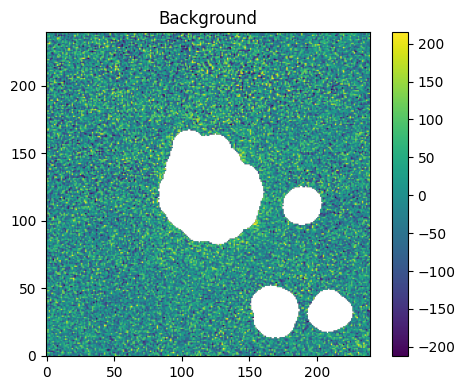

 Pixels used: 4300
 Peak img[j, k]: 121 120
 Mean (j, k): 121.15 120.44
 Theta (deg): 41.2
 Astro PA (deg): 48.8
 Eps: 0.123
 Major axis (pix): 46.9


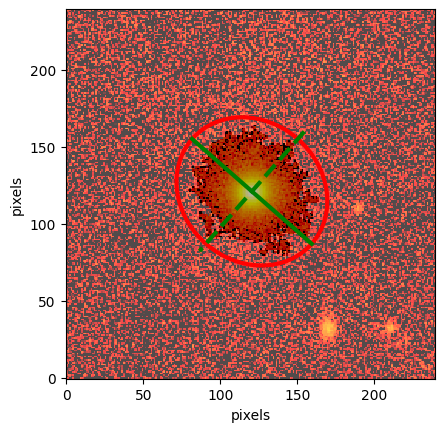

 Galaxy: ./data/e-inspire/39627799404745422_r.fits | Sky Level: 0.886, Sigma: 71.209
Sky Cell ID: 4549972


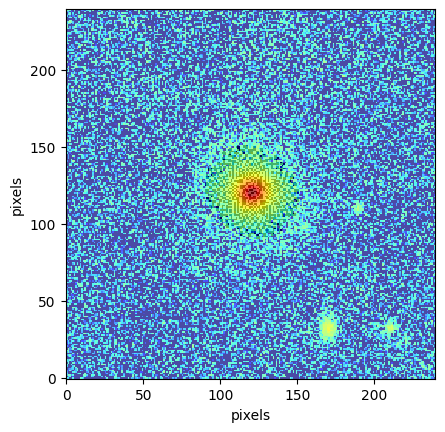

Performing MGE fit for ./data/e-inspire/39627799404745422_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5095930801728115, normpsf=1
Galaxy: ./data/e-inspire/39627799404745422_r.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 57.14  Nonzero: 2/3
Iteration: 10  chi2: 4.800  Nonzero: 3/3
Iteration: 11  chi2: 4.800  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 Total number of points fitted:  364
 Chi2: 4.800 
 STDEV: 0.1141 
 MEANABSDEV: 0.08280 
############################################
  Total_Counts   sigma_Pixels     q_obs
############################################
   5.6046e+05        2.328       1.0000
   6.9781e+05        5.674       1.0000
   6.5664e+05        16.5

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

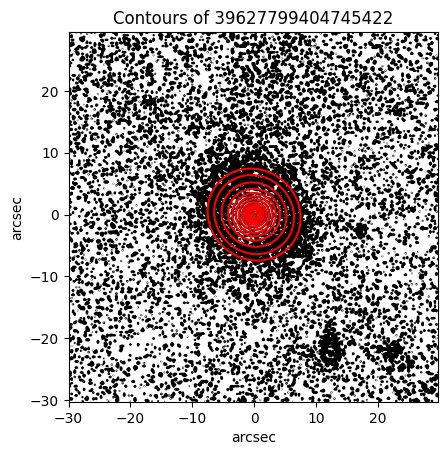

{'Galaxy': 39627799404745422,
 'Reff (arcsec)': np.float64(1.6760714157894814),
 'Reff_maj (arcsec)': np.float64(1.676612291740255),
 'Eccentricity': np.float64(0.0010388118330179053),
 'Luminosity': np.float64(0.00028130546169621916)}

In [49]:
a = get_galaxy_size(filename, row)
a


In [34]:
f, s, scale, sigma_psf, norm_psf = a
ngauss = 3  # Number of Gaussian components for MGE fit
sigmapsf = sigma_psf  # PSF sigma
normpsf = norm_psf  # Normalization factor for PSF
# MGE fit

print(f"Performing MGE fit for {filename} with ngauss={ngauss}, scale={scale}, sigmapsf={sigmapsf}, normpsf={normpsf}")
print(f"Galaxy: {filename} | Sigma PSF: {sigma_psf:.3f}, Normalization PSF: {norm_psf:.3f}")

m = mge_fit_sectors(s.radius, s.angle, s.counts, f.eps,
                    ngauss=ngauss, scale=scale, plot=0,
                    sigmapsf=sigmapsf, normpsf=normpsf)


Performing MGE fit for ./data/e-inspire/39627799404745422_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5095930801728115, normpsf=1
Galaxy: ./data/e-inspire/39627799404745422_r.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 57.14  Nonzero: 2/3
Iteration: 10  chi2: 4.800  Nonzero: 3/3
Iteration: 11  chi2: 4.800  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.03 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 Total number of points fitted:  364
 Chi2: 4.800 
 STDEV: 0.1141 
 MEANABSDEV: 0.08280 
############################################
  Total_Counts   sigma_Pixels     q_obs
############################################
   5.6046e+15        2.328       1.0000
   6.9781e+15        5.674       1.0000
   6.5664e+15        16.5

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

In [41]:
total_counts, sigma, q_obs = m.sol
surf = total_counts / (2 * np.pi * q_obs * sigma**2)
reff, reff_maj, eps_e, lum_tot = jam.mge.half_light_isophote(surf, sigma * scale, q_obs)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

In [39]:
plt.figure(figsize=(10, 5))
mge_print_contours(img, f.theta, f.xpeak, f.ypeak, m.sol, scale=scale,
                    sigmapsf=sigmapsf, normpsf=normpsf, binning=1, minlevel=minlevel)
plt.title(f"Contours of {galaxy_name}")
plt.show()


array([1.64624963e+14, 3.44937894e+13, 4.12424020e+12])

# Update results

In [19]:
df_results = pd.read_csv('results.csv', index_col=0)
df_results

RA        DEC          Target ID  Sky Cell ID  FWHM (arcsec)  \
Index                                                                         
0      134.650339  -4.602488   2842417304698883      4500357       1.258910   
1      206.999339  -1.800780   2842484900102147      3894861       1.022265   
2      154.216207  -0.796265   2842508174295043      4549942       1.263535   
3      151.622269   7.235106   2842701061947396      4557472       1.193720   
4       20.929319   8.024270   2842716870279169      4091925       1.116345   
...           ...        ...                ...          ...            ...   
1029   236.337511  44.360624  39633153941310268      3626838       1.106400   
1030   246.754521   1.223455  39627819067637938      3584463       1.012410   
1031   125.282385   2.790324   2842592249118720      4476844       1.300900   
1032   349.568591  15.124893  39628149075479853      3950806       1.126515   
1033    12.093095   5.781772  39627923711329320      3957916       1.153745   

       Sigma PSF    minlevel  Reff (arcsec)  Reff_maj (arcsec)  Eccentricity  \
Index                                                                          
0       0.534610  106.200584       1.514095           1.733903      0.239049   
1       0.434116   91.757560       1.060885           1.161201      0.142272   
2       0.536574   92.558044       3.333612           3.454338      0.067749   
3       0.506926  110.344510       1.213412           1.390007      0.236464   
4       0.474068  132.254490       1.738651           2.010362      0.241912   
...          ...         ...            ...                ...           ...   
1029    0.469845   94.516815       1.071203           1.115474      0.075818   
1030    0.429931   80.113630       1.020825           1.141003      0.201162   
1031    0.552441   94.315540       2.453524           2.757845      0.204270   
1032    0.478387  100.515570       1.514152           1.551473      0.047866   
1033    0.489950  111.422310       1.372264           1.390575      0.014591   

       Luminosity  
Index              
0        0.000948  
1        0.000078  
2        0.000963  
3        0.000264  
4        0.001540  
...           ...  
1029     0.000197  
1030     0.000107  
1031     0.000605  
1032     0.000553  
1033     0.000680  

[1029 rows x 11 columns]

In [35]:
df_panstarrs = None
ps_columns = ['Index', 'objName', 'gPSFMag', 'rPSFMag', 'iPSFMag', 'zPSFMag', 'yPSFMag',
              'gPSFMagErr', 'rPSFMagErr', 'iPSFMagErr', 'zPSFMagErr', 'yPSFMagErr',
              'gKronMag', 'rKronMag', 'iKronMag', 'zKronMag', 'yKronMag',
                'gKronMagErr', 'rKronMagErr', 'iKronMagErr', 'zKronMagErr', 'yKronMagErr',
                'gKronRad', 'rKronRad', 'iKronRad', 'zKronRad', 'yKronRad',
                'gexpTime', 'rexpTime', 'iexpTime', 'zexpTime', 'yexpTime',
                'distance']

for i, row in df_results.iterrows():
    ra = row['RA']
    dec = row['DEC']
    idx = row['Target ID']

    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')
    
    try:
        catalog_data = Catalogs.query_region( # type: ignore
            coord,
            radius=0.5/3600.0,
            catalog="Panstarrs",
            data_release="dr2",
            # skyCellID=int(skyCellID),
            table="stack").to_pandas()
        
    except Exception as e:
        print(f"Error querying catalog: {e}")
        continue

    if catalog_data.empty:
        print(f"No catalog data found for RA: {ra}, DEC: {dec}")
        continue


    catalog_data['Index'] = i
    catalog_data['distance'] = catalog_data['distance']* 3600.0  # Convert distance to arcseconds
    if df_panstarrs is None:
        df_panstarrs = catalog_data # type: ignore
    else:
        df_panstarrs = pd.concat([df_panstarrs, catalog_data], ignore_index=True)


    if i > 0 and i % 20 == 0:
        print(f"Processed {i+1} rows, breaking the loop for testing.")
        # df_panstarrs.to_csv('panstarrs_results.csv', index_label='Index')
        # break

df_panstarrs.to_csv('panstarrs_results.csv', index_label='Index')

Processed 21 rows, breaking the loop for testing.
Processed 41 rows, breaking the loop for testing.


No catalog data found for RA: 173.5028032710028, DEC: -4.831274630733524
Processed 61 rows, breaking the loop for testing.


No catalog data found for RA: 215.58178326139495, DEC: -3.428833987229864
Processed 81 rows, breaking the loop for testing.


No catalog data found for RA: 190.2275203511928, DEC: -1.1223263445714635
Processed 101 rows, breaking the loop for testing.
Processed 121 rows, breaking the loop for testing.
Processed 141 rows, breaking the loop for testing.
Processed 161 rows, breaking the loop for testing.


No catalog data found for RA: 160.14652508456712, DEC: 2.287128245637528
Processed 181 rows, breaking the loop for testing.
Processed 201 rows, breaking the loop for testing.


No catalog data found for RA: 251.7750667895849, DEC: 5.809404050466034
Processed 221 rows, breaking the loop for testing.


No catalog data found for RA: 139.8287988754851, DEC: 7.3052646500342355
Processed 241 rows, breaking the loop for testing.
Processed 261 rows, breaking the loop for testing.


No catalog data found for RA: 116.40903250753382, DEC: 15.298976223773447
Processed 281 rows, breaking the loop for testing.
Processed 301 rows, breaking the loop for testing.
Processed 321 rows, breaking the loop for testing.
Processed 341 rows, breaking the loop for testing.
Processed 361 rows, breaking the loop for testing.


No catalog data found for RA: 335.8059386577979, DEC: 31.45349173192225


No catalog data found for RA: 227.41426289207376, DEC: 32.44202133472231
Processed 381 rows, breaking the loop for testing.
Processed 401 rows, breaking the loop for testing.


No catalog data found for RA: 261.93041071907123, DEC: 38.564475784365
Processed 421 rows, breaking the loop for testing.
Processed 441 rows, breaking the loop for testing.
Processed 461 rows, breaking the loop for testing.
Processed 481 rows, breaking the loop for testing.
Processed 501 rows, breaking the loop for testing.
Processed 521 rows, breaking the loop for testing.
Processed 541 rows, breaking the loop for testing.


No catalog data found for RA: 268.71018598933927, DEC: 57.62420448127105
Processed 561 rows, breaking the loop for testing.
Processed 581 rows, breaking the loop for testing.
Processed 601 rows, breaking the loop for testing.
Processed 621 rows, breaking the loop for testing.
Processed 641 rows, breaking the loop for testing.
Processed 661 rows, breaking the loop for testing.
Processed 681 rows, breaking the loop for testing.
Processed 701 rows, breaking the loop for testing.
Processed 721 rows, breaking the loop for testing.
Processed 741 rows, breaking the loop for testing.
Processed 761 rows, breaking the loop for testing.
Processed 781 rows, breaking the loop for testing.
Processed 801 rows, breaking the loop for testing.
Processed 821 rows, breaking the loop for testing.
Processed 841 rows, breaking the loop for testing.
Processed 861 rows, breaking the loop for testing.
Processed 881 rows, breaking the loop for testing.
Processed 901 rows, breaking the loop for testing.
Processed

In [36]:
df_single = df_panstarrs.loc[df_panstarrs.groupby('objName')['nDetections'].idxmax(), ps_columns].sort_values(by='Index')
df_single

Index                objName    gPSFMag    rPSFMag    iPSFMag  \
0         0  PSO J134.6503-04.6025  16.932699  16.326401  15.901900   
1         1  PSO J206.9993-01.8008  19.202101  18.354200  17.862499   
2         2  PSO J154.2162-00.7963  17.933100  16.861500  16.423800   
4         3  PSO J151.6223+07.2351  18.125500  17.156601  16.874599   
5         4  PSO J020.9293+08.0243  17.443701  16.617100  16.074100   
...     ...                    ...        ...        ...        ...   
1253   1029  PSO J236.3375+44.3606  18.390800  17.658100  17.331800   
1254   1030  PSO J246.7545+01.2235  18.977501  18.131201  17.784901   
1255   1031  PSO J125.2824+02.7903  18.209299  17.221001  16.901899   
1257   1032  PSO J349.5686+15.1249  17.587099  16.818199  16.583099   
1258   1033  PSO J012.0931+05.7818  18.091801  17.209400  16.791201   

        zPSFMag    yPSFMag  gPSFMagErr  rPSFMagErr  iPSFMagErr  ...  rKronRad  \
0     15.867400  15.677800    0.002156    0.001078    0.000691  ...   5.92489   
1     17.724400  17.426901    0.005255    0.003981    0.004059  ...   3.77888   
2     16.387400  16.039600    0.003340    0.001488    0.000892  ...       NaN   
4     16.597099  16.573700    0.003621    0.002104    0.001135  ...   4.67951   
5     15.922200  15.668000    0.002205    0.000860    0.000682  ...   7.02077   
...         ...        ...         ...         ...         ...  ...       ...   
1253  17.047300  16.963200    0.005113    0.002082    0.001774  ...   4.66037   
1254  17.551300  17.340500    0.004576    0.002577    0.002124  ...   3.93676   
1255  16.667900  16.601299    0.003682    0.001705    0.001331  ...   8.44656   
1257  16.459700  16.309799    0.002131    0.001297    0.001077  ...   5.78557   
1258  16.625401  16.454901    0.003143    0.001386    0.001155  ...   5.49927   

      iKronRad  zKronRad   yKronRad  gexpTime  rexpTime  iexpTime  zexpTime  \
0      5.69025   5.76032   6.747650     792.0    1035.0    1800.0     570.0   
1      4.42783   4.38289   3.829400     896.0     712.0     855.0     660.0   
2      5.15522  19.41630  16.260401     672.0     784.0    1748.0     766.0   
4      4.70363   4.74848   4.650870     638.0     792.0    1774.0     632.0   
5      8.04871   7.51381   7.888320     602.0    1640.0    1440.0     660.0   
...        ...       ...        ...       ...       ...       ...       ...   
1253   4.48335   4.62352   4.362330     688.0     945.0    1080.0     540.0   
1254   4.30833   3.46435   3.066730     860.0     872.0    1845.0     780.0   
1255   7.79516   8.94037   8.509730     688.0    1000.0    1305.0     750.0   
1257   5.94989   5.57175   6.121010     860.0     960.0    1080.0     660.0   
1258   5.75609   5.36771   5.460790     688.0    1040.0    1935.0     840.0   

      yexpTime  distance  
0        780.0  0.014316  
1        970.0  0.009588  
2        810.0  0.021443  
4        670.0  0.008947  
5        640.0  0.026664  
...        ...       ...  
1253     590.0  0.005744  
1254     790.0  0.005669  
1255     700.0  0.019720  
1257     720.0  0.006391  
1258     940.0  0.049275  

[1018 rows x 33 columns]

In [37]:
df_merged = pd.merge(df_results, df_single, on='Index', how='outer')
df_merged.to_csv('./data/merged_results.csv', index_label='Index')
df_merged

Index          RA        DEC          Target ID  Sky Cell ID  \
0         0  134.650339  -4.602488   2842417304698883      4500357   
1         1  206.999339  -1.800780   2842484900102147      3894861   
2         2  154.216207  -0.796265   2842508174295043      4549942   
3         3  151.622269   7.235106   2842701061947396      4557472   
4         4   20.929319   8.024270   2842716870279169      4091925   
...     ...         ...        ...                ...          ...   
1024   1029  236.337511  44.360624  39633153941310268      3626838   
1025   1030  246.754521   1.223455  39627819067637938      3584463   
1026   1031  125.282385   2.790324   2842592249118720      4476844   
1027   1032  349.568591  15.124893  39628149075479853      3950806   
1028   1033   12.093095   5.781772  39627923711329320      3957916   

      FWHM (arcsec)  Sigma PSF    minlevel  Reff (arcsec)  Reff_maj (arcsec)  \
0          1.258910   0.534610  106.200584       1.514095           1.733903   
1          1.022265   0.434116   91.757560       1.060885           1.161201   
2          1.263535   0.536574   92.558044       3.333612           3.454338   
3          1.193720   0.506926  110.344510       1.213412           1.390007   
4          1.116345   0.474068  132.254490       1.738651           2.010362   
...             ...        ...         ...            ...                ...   
1024       1.106400   0.469845   94.516815       1.071203           1.115474   
1025       1.012410   0.429931   80.113630       1.020825           1.141003   
1026       1.300900   0.552441   94.315540       2.453524           2.757845   
1027       1.126515   0.478387  100.515570       1.514152           1.551473   
1028       1.153745   0.489950  111.422310       1.372264           1.390575   

      ...  rKronRad  iKronRad  zKronRad   yKronRad  gexpTime  rexpTime  \
0     ...   5.92489   5.69025   5.76032   6.747650     792.0    1035.0   
1     ...   3.77888   4.42783   4.38289   3.829400     896.0     712.0   
2     ...       NaN   5.15522  19.41630  16.260401     672.0     784.0   
3     ...   4.67951   4.70363   4.74848   4.650870     638.0     792.0   
4     ...   7.02077   8.04871   7.51381   7.888320     602.0    1640.0   
...   ...       ...       ...       ...        ...       ...       ...   
1024  ...   4.66037   4.48335   4.62352   4.362330     688.0     945.0   
1025  ...   3.93676   4.30833   3.46435   3.066730     860.0     872.0   
1026  ...   8.44656   7.79516   8.94037   8.509730     688.0    1000.0   
1027  ...   5.78557   5.94989   5.57175   6.121010     860.0     960.0   
1028  ...   5.49927   5.75609   5.36771   5.460790     688.0    1040.0   

      iexpTime  zexpTime  yexpTime  distance  
0       1800.0     570.0     780.0  0.014316  
1        855.0     660.0     970.0  0.009588  
2       1748.0     766.0     810.0  0.021443  
3       1774.0     632.0     670.0  0.008947  
4       1440.0     660.0     640.0  0.026664  
...        ...       ...       ...       ...  
1024    1080.0     540.0     590.0  0.005744  
1025    1845.0     780.0     790.0  0.005669  
1026    1305.0     750.0     700.0  0.019720  
1027    1080.0     660.0     720.0  0.006391  
1028    1935.0     840.0     940.0  0.049275  

[1029 rows x 44 columns]

Index                objName    gPSFMag    rPSFMag    iPSFMag    zPSFMag  \
0       0  PSO J134.6503-04.6025  16.932699  16.326401  15.901900  15.867400   
1       1  PSO J206.9993-01.8008  19.202101  18.354200  17.862499  17.724400   
2       2  PSO J154.2162-00.7963  17.933100  16.861500  16.423800  16.387400   
4       3  PSO J151.6223+07.2351  18.125500  17.156601  16.874599  16.597099   
5       4  PSO J020.9293+08.0243  17.443701  16.617100  16.074100  15.922200   
6       5  PSO J122.7971+16.7228  19.281700  18.509001  18.114201  17.728901   
7       6  PSO J087.7325-24.2527  22.303400  21.069901  20.186701  19.806801   
8       7  PSO J086.7256-20.6296  20.581900  19.311001  18.778200  18.636499   
9       8  PSO J062.9508-16.6838  18.424000  17.769501  17.456699  17.126200   
10      9  PSO J046.3087-14.3811  16.554001  15.971100  15.626400  15.445000   
12     10  PSO J023.1220-13.6060  18.889200  17.934299  17.578501  17.386299   
14     11  PSO J060.1709-12.7722  18.069201  17.148199  17.052200  16.623501   
15     12  PSO J343.9588-10.8467  18.235001  17.467699  17.202101  16.904200   
16     13  PSO J019.5099-10.1735  20.629700  19.178301  18.749500  18.604700   
17     14  PSO J020.5384-09.8886  16.382299  15.788100  15.467400  15.407500   
18     15  PSO J047.1118-10.0444  21.084900  19.326599  18.766500  18.384899   
19     16  PSO J332.5009-09.4683  18.408300  17.710300  17.266800  17.062000   
21     17  PSO J172.2438-08.8913  19.046400  18.145700  17.807301  17.515301   
22     18  PSO J060.7981-08.5864  17.570801  16.603800  16.349100  15.999400   
23     19  PSO J201.7507-08.5226  20.185400  18.840401  18.547600  18.430099   
24     20  PSO J213.9988-08.4851  19.018200  18.251801  17.978201  17.811800   

      yPSFMag  gPSFMagErr  rPSFMagErr  iPSFMagErr  ...  rKronRad  iKronRad  \
0   15.677800    0.002156    0.001078    0.000691  ...   5.92489   5.69025   
1   17.426901    0.005255    0.003981    0.004059  ...   3.77888   4.42783   
2   16.039600    0.003340    0.001488    0.000892  ...       NaN   5.15522   
4   16.573700    0.003621    0.002104    0.001135  ...   4.67951   4.70363   
5   15.668000    0.002205    0.000860    0.000682  ...   7.02077   8.04871   
6   17.593300    0.006177    0.003347    0.002641  ...   2.61992   3.45760   
7   19.512600    0.128185    0.090101    0.026619  ...   3.05062   3.25221   
8   18.347000    0.017442    0.007282    0.005630  ...   3.80949   4.10973   
9   17.062500    0.004481    0.002167    0.001288  ...   5.62175   4.74317   
10  15.038100    0.001418    0.000986    0.000660  ...   5.14622   5.24241   
12  17.094999    0.005299    0.003180    0.001692  ...   5.57941   5.75447   
14  16.497200    0.003553    0.002431    0.001151  ...   5.52986   5.53449   
15  16.709200    0.003480    0.002049    0.001165  ...   6.55446   6.76588   
16  18.497900    0.019477    0.004450    0.003632  ...   3.71351   3.47776   
17  15.041400    0.001187    0.001024    0.000731  ...  11.58340  11.18790   
18  18.286699    0.036232    0.006529    0.005393  ...   4.70802   5.37810   
19  16.822001    0.003598    0.001932    0.001283  ...   3.88392   3.88571   
21  17.449499    0.005707    0.002551    0.002836  ...   5.10128   5.43232   
22  15.932600    0.003321    0.000947    0.000680  ...   7.24516   7.68338   
23  18.344200    0.011482    0.004325    0.004973  ...   3.77160   3.59189   
24  17.696699    0.005269    0.003684    0.002854  ...   3.75821   3.97903   

    zKronRad   yKronRad  gexpTime  rexpTime  iexpTime  zexpTime  yexpTime  \
0    5.76032   6.747650     792.0    1035.0    1800.0     570.0     780.0   
1    4.38289   3.829400     896.0     712.0     855.0     660.0     970.0   
2   19.41630  16.260401     672.0     784.0    1748.0     766.0     810.0   
4    4.74848   4.650870     638.0     792.0    1774.0     632.0     670.0   
5    7.51381   7.888320     602.0    1640.0    1440.0     660.0     640.0   
6    2.98247   3.071860     688.0    1222.0    1455.0     750.0 